##### Copyright 2022 The TensorFlow Compression Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Learned data compression

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/data_compression">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/data_compression.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/data_compression.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This notebook shows how to do lossy data compression using neural networks and [TensorFlow Compression](https://github.com/tensorflow/compression).

Lossy compression involves making a trade-off between **rate**, the expected number of bits needed to encode a sample, and **distortion**, the expected error in the reconstruction of the sample.

The examples below use an autoencoder-like model to compress images from the MNIST dataset. The method is based on the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

More background on learned data compression can be found in [this paper](https://arxiv.org/abs/2007.03034) targeted at people familiar with classical data compression, or [this survey](https://arxiv.org/abs/2202.06533) targeted at a machine learning audience.


## Setup

Install Tensorflow Compression via `pip`.

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"


  Using cached tensorflow_compression-2.14.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)


  Using cached scipy-1.11.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)


  Using cached tensorflow-2.14.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)


  Using cached tensorflow_probability-0.22.1-py2.py3-none-any.whl.metadata (13 kB)


  Using cached ml_dtypes-0.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)


  Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)


  Using cached tensorboard-2.14.1-py3-none-any.whl.metadata (1.7 kB)


  Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl.metadata (1.3 kB)


  Using cached keras-2.14.0-py3-none-any.whl.metadata (2.4 kB)


  Using cached cloudpickle-3.0.0-py3-none-any.whl.metadata (7.0 kB)


  Using cached google_auth-2.33.0-py2.py3-none-any.whl.metadata (4.7 kB)


  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl.metadata (2.7 kB)


  Using cached pyasn1_modules-0.4.0-py3-none-any.whl.metadata (3.4 kB)


  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)


  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)


  Using cached pyasn1-0.6.0-py2.py3-none-any.whl.metadata (8.3 kB)


  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)


Using cached tensorflow_compression-2.14.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (262 kB)


Using cached scipy-1.11.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (36.6 MB)


Using cached tensorflow-2.14.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (489.9 MB)


Using cached ml_dtypes-0.2.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)


Using cached tensorflow_probability-0.22.1-py2.py3-none-any.whl (6.9 MB)


Using cached cloudpickle-3.0.0-py3-none-any.whl (20 kB)


Using cached keras-2.14.0-py3-none-any.whl (1.7 MB)


Using cached tensorboard-2.14.1-py3-none-any.whl (5.5 MB)


Using cached tensorflow_estimator-2.14.0-py2.py3-none-any.whl (440 kB)


Using cached wrapt-1.14.1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (77 kB)


Using cached google_auth-2.33.0-py2.py3-none-any.whl (200 kB)


Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)


Using cached pyasn1_modules-0.4.0-py3-none-any.whl (181 kB)


Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl (24 kB)


Using cached rsa-4.9-py3-none-any.whl (34 kB)


Using cached oauthlib-3.2.2-py3-none-any.whl (151 kB)


Using cached pyasn1-0.6.0-py2.py3-none-any.whl (85 kB)


  Attempting uninstall: wrapt


    Found existing installation: wrapt 1.16.0


    Uninstalling wrapt-1.16.0:


      Successfully uninstalled wrapt-1.16.0


  Attempting uninstall: scipy


    Found existing installation: scipy 1.13.1


    Uninstalling scipy-1.13.1:


      Successfully uninstalled scipy-1.13.1


  Attempting uninstall: ml-dtypes


    Found existing installation: ml-dtypes 0.4.0


    Uninstalling ml-dtypes-0.4.0:


      Successfully uninstalled ml-dtypes-0.4.0


  Attempting uninstall: keras


    Found existing installation: keras 3.5.0


    Uninstalling keras-3.5.0:


      Successfully uninstalled keras-3.5.0


  Attempting uninstall: tensorboard


    Found existing installation: tensorboard 2.17.1


    Uninstalling tensorboard-2.17.1:


      Successfully uninstalled tensorboard-2.17.1


  Attempting uninstall: tensorflow


    Found existing installation: tensorflow 2.17.0


    Uninstalling tensorflow-2.17.0:


      Successfully uninstalled tensorflow-2.17.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.


tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.14.1 which is incompatible.


Import library dependencies.

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds


2024-08-16 06:46:30.122902: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 06:46:30.122949: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 06:46:30.122988: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define the trainer model.

Because the model resembles an autoencoder, and we need to perform a different set of functions during training and inference, the setup is a little different from, say, a classifier.

The training model consists of three parts:
- the **analysis** (or encoder) transform, converting from the image into a latent space,
- the **synthesis** (or decoder) transform, converting from the latent space back into image space, and
- a **prior** and entropy model, modeling the marginal probabilities of the latents.

First, define the transforms:

In [4]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


In [5]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Dense(
          500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          2450, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((7, 7, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          1, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")


The trainer holds an instance of both transforms, as well as the parameters of the prior.

Its `call` method is set up to compute:
- **rate**, an estimate of the number of bits needed to represent the batch of digits, and
- **distortion**, the mean absolute difference between the pixels of the original digits and their reconstructions.


In [6]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


### Compute rate and distortion.

Let's walk through this step by step, using one image from the training set. Load the MNIST dataset for training and validation:

In [7]:
training_dataset, validation_dataset = tfds.load(
    "mnist",
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)


2024-08-16 06:46:34.105151: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


And extract one image $x$:

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


2024-08-16 06:46:34.371046: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


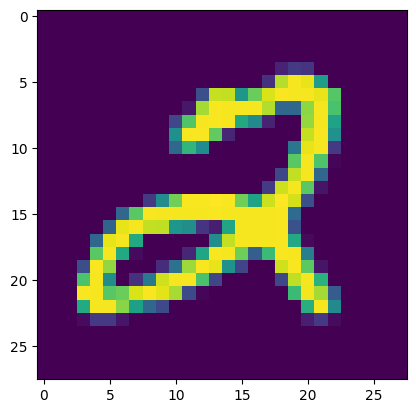

In [8]:
(x, _), = validation_dataset.take(1)

plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")


To get the latent representation $y$, we need to cast it to `float32`, add a batch dimension, and pass it through the analysis transform.

In [9]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

print("y:", y)


y: tf.Tensor(
[[-0.03515958 -0.04426444  0.02830836 -0.00623044  0.00728801 -0.01185333
  -0.06493839  0.02908771 -0.05313966 -0.01150604]], shape=(1, 10), dtype=float32)


The latents will be quantized at test time. To model this in a differentiable way during training, we add uniform noise in the interval $(-.5, .5)$ and call the result $\tilde y$. This is the same terminology as used in the paper [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704).

In [10]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

print("y_tilde:", y_tilde)


y_tilde: tf.Tensor(
[[ 0.23809135 -0.00584603  0.09636745  0.20950142  0.13149777 -0.12119483
  -0.3411804   0.1945247   0.43893054  0.08348517]], shape=(1, 10), dtype=float32)


The "prior" is a probability density that we train to model the marginal distribution of the noisy latents. For example, it could be a set of independent [logistic distributions](https://en.wikipedia.org/wiki/Logistic_distribution) with different scales for each latent dimension. `tfc.NoisyLogistic` accounts for the fact that the latents have additive noise. As the scale approaches zero, a logistic distribution approaches a dirac delta (spike), but the added noise causes the "noisy" distribution to approach the uniform distribution instead.

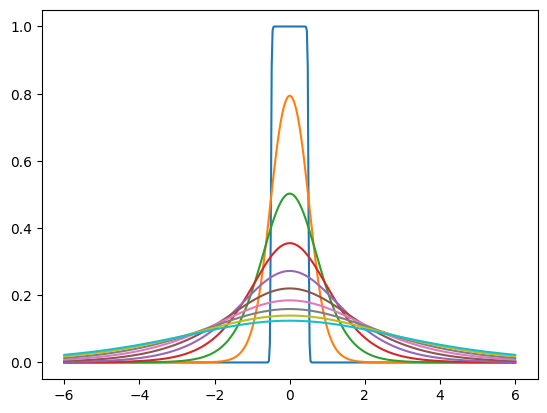

In [11]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))

_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));


During training, `tfc.ContinuousBatchedEntropyModel` adds uniform noise, and uses the noise and the prior to compute a (differentiable) upper bound on the rate (the average number of bits necessary to encode the latent representation). That bound can be minimized as a loss.

In [12]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
    prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

print("rate:", rate)
print("y_tilde:", y_tilde)


rate: tf.Tensor([18.123432], shape=(1,), dtype=float32)
y_tilde: tf.Tensor(
[[ 0.2644348   0.00915181  0.23324046 -0.40824887  0.424091    0.3612876
   0.02335981  0.2968393  -0.1207529   0.05890064]], shape=(1, 10), dtype=float32)


Lastly, the noisy latents are passed back through the synthesis transform to produce an image reconstruction $\tilde x$. Distortion is the error between original image and reconstruction. Obviously, with the transforms untrained, the reconstruction is not very useful.

distortion: tf.Tensor(0.17096801, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


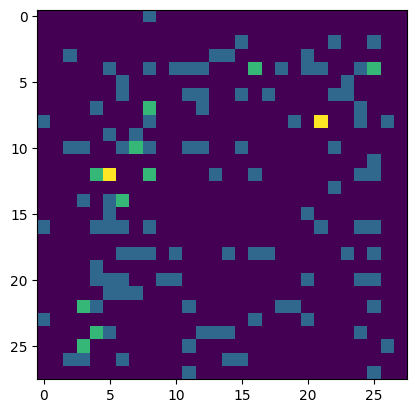

In [13]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


For every batch of digits, calling the `MNISTCompressionTrainer` produces the rate and distortion as an average over that batch:


In [14]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])


rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


2024-08-16 06:46:35.159201: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In the next section, we set up the model to do gradient descent on these two losses.

## Train the model.

We compile the trainer in a way that it optimizes the rate–distortion Lagrangian, that is, a sum of rate and distortion, where one of the terms is weighted by Lagrange parameter $\lambda$.

This loss function affects the different parts of the model differently:
- The analysis transform is trained to produce a latent representation that achieves the desired trade-off between rate and distortion.
- The synthesis transform is trained to minimize distortion, given the latent representation.
- The parameters of the prior are trained to minimize the rate given the latent representation. This is identical to fitting the prior to the marginal distribution of latents in a maximum likelihood sense.

In [15]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


Next, train the model. The human annotations are not necessary here, since we just want to compress the images, so we drop them using a `map` and instead add "dummy" targets for rate and distortion.

In [16]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=15,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_mnist_model(lmbda=2000)


Epoch 1/15


  1/469 [..............................] - ETA: 20:30 - loss: 350.3091 - distortion_loss: 0.1237 - rate_loss: 102.9188 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 102.9188

  3/469 [..............................] - ETA: 11s - loss: 361.2815 - distortion_loss: 0.1292 - rate_loss: 102.9133 - distortion_pass_through_loss: 0.1292 - rate_pass_through_loss: 102.9133  

  6/469 [..............................] - ETA: 11s - loss: 365.3575 - distortion_loss: 0.1313 - rate_loss: 102.7866 - distortion_pass_through_loss: 0.1313 - rate_pass_through_loss: 102.7866

  9/469 [..............................] - ETA: 10s - loss: 366.6797 - distortion_loss: 0.1320 - rate_loss: 102.6677 - distortion_pass_through_loss: 0.1320 - rate_pass_through_loss: 102.6677

 12/469 [..............................] - ETA: 10s - loss: 366.0358 - distortion_loss: 0.1317 - rate_loss: 102.5753 - distortion_pass_through_loss: 0.1317 - rate_pass_through_loss: 102.5753

 15/469 [..............................] - ETA: 9s - loss: 362.6654 - distortion_loss: 0.1300 - rate_loss: 102.6425 - distortion_pass_through_loss: 0.1300 - rate_pass_through_loss: 102.6425 

 18/469 [>.............................] - ETA: 9s - loss: 361.0542 - distortion_loss: 0.1292 - rate_loss: 102.7403 - distortion_pass_through_loss: 0.1292 - rate_pass_through_loss: 102.7403

 21/469 [>.............................] - ETA: 9s - loss: 359.3939 - distortion_loss: 0.1283 - rate_loss: 102.6986 - distortion_pass_through_loss: 0.1283 - rate_pass_through_loss: 102.6986

 24/469 [>.............................] - ETA: 9s - loss: 357.1002 - distortion_loss: 0.1272 - rate_loss: 102.7243 - distortion_pass_through_loss: 0.1272 - rate_pass_through_loss: 102.7243

 27/469 [>.............................] - ETA: 9s - loss: 355.1216 - distortion_loss: 0.1262 - rate_loss: 102.8079 - distortion_pass_through_loss: 0.1262 - rate_pass_through_loss: 102.8079

 30/469 [>.............................] - ETA: 9s - loss: 352.1895 - distortion_loss: 0.1247 - rate_loss: 102.8825 - distortion_pass_through_loss: 0.1247 - rate_pass_through_loss: 102.8825

 33/469 [=>............................] - ETA: 9s - loss: 349.1003 - distortion_loss: 0.1231 - rate_loss: 102.9673 - distortion_pass_through_loss: 0.1231 - rate_pass_through_loss: 102.9673

 36/469 [=>............................] - ETA: 9s - loss: 345.7501 - distortion_loss: 0.1214 - rate_loss: 103.0233 - distortion_pass_through_loss: 0.1214 - rate_pass_through_loss: 103.0233

 39/469 [=>............................] - ETA: 9s - loss: 342.0116 - distortion_loss: 0.1195 - rate_loss: 103.1108 - distortion_pass_through_loss: 0.1195 - rate_pass_through_loss: 103.1108

 42/469 [=>............................] - ETA: 8s - loss: 338.7086 - distortion_loss: 0.1177 - rate_loss: 103.2171 - distortion_pass_through_loss: 0.1177 - rate_pass_through_loss: 103.2171

 45/469 [=>............................] - ETA: 8s - loss: 335.2554 - distortion_loss: 0.1160 - rate_loss: 103.2611 - distortion_pass_through_loss: 0.1160 - rate_pass_through_loss: 103.2611

 48/469 [==>...........................] - ETA: 8s - loss: 332.3196 - distortion_loss: 0.1145 - rate_loss: 103.2948 - distortion_pass_through_loss: 0.1145 - rate_pass_through_loss: 103.2948

 51/469 [==>...........................] - ETA: 8s - loss: 329.4074 - distortion_loss: 0.1130 - rate_loss: 103.3169 - distortion_pass_through_loss: 0.1130 - rate_pass_through_loss: 103.3169

 54/469 [==>...........................] - ETA: 8s - loss: 326.3450 - distortion_loss: 0.1115 - rate_loss: 103.3367 - distortion_pass_through_loss: 0.1115 - rate_pass_through_loss: 103.3367

 57/469 [==>...........................] - ETA: 8s - loss: 323.4956 - distortion_loss: 0.1101 - rate_loss: 103.3503 - distortion_pass_through_loss: 0.1101 - rate_pass_through_loss: 103.3503

 60/469 [==>...........................] - ETA: 8s - loss: 320.8785 - distortion_loss: 0.1088 - rate_loss: 103.3647 - distortion_pass_through_loss: 0.1088 - rate_pass_through_loss: 103.3647

 63/469 [===>..........................] - ETA: 8s - loss: 318.4072 - distortion_loss: 0.1075 - rate_loss: 103.3804 - distortion_pass_through_loss: 0.1075 - rate_pass_through_loss: 103.3804

 66/469 [===>..........................] - ETA: 8s - loss: 315.9233 - distortion_loss: 0.1063 - rate_loss: 103.4105 - distortion_pass_through_loss: 0.1063 - rate_pass_through_loss: 103.4105

 69/469 [===>..........................] - ETA: 8s - loss: 313.4915 - distortion_loss: 0.1050 - rate_loss: 103.4505 - distortion_pass_through_loss: 0.1050 - rate_pass_through_loss: 103.4505

 72/469 [===>..........................] - ETA: 8s - loss: 310.9263 - distortion_loss: 0.1037 - rate_loss: 103.4873 - distortion_pass_through_loss: 0.1037 - rate_pass_through_loss: 103.4873

 75/469 [===>..........................] - ETA: 8s - loss: 308.5104 - distortion_loss: 0.1025 - rate_loss: 103.5258 - distortion_pass_through_loss: 0.1025 - rate_pass_through_loss: 103.5258

 78/469 [===>..........................] - ETA: 8s - loss: 306.2590 - distortion_loss: 0.1013 - rate_loss: 103.5643 - distortion_pass_through_loss: 0.1013 - rate_pass_through_loss: 103.5643

 81/469 [====>.........................] - ETA: 7s - loss: 304.1591 - distortion_loss: 0.1003 - rate_loss: 103.6067 - distortion_pass_through_loss: 0.1003 - rate_pass_through_loss: 103.6067

 84/469 [====>.........................] - ETA: 7s - loss: 302.0565 - distortion_loss: 0.0992 - rate_loss: 103.6323 - distortion_pass_through_loss: 0.0992 - rate_pass_through_loss: 103.6323

 87/469 [====>.........................] - ETA: 7s - loss: 300.0394 - distortion_loss: 0.0982 - rate_loss: 103.6587 - distortion_pass_through_loss: 0.0982 - rate_pass_through_loss: 103.6587

 90/469 [====>.........................] - ETA: 7s - loss: 298.0091 - distortion_loss: 0.0972 - rate_loss: 103.6853 - distortion_pass_through_loss: 0.0972 - rate_pass_through_loss: 103.6853

 93/469 [====>.........................] - ETA: 7s - loss: 296.0487 - distortion_loss: 0.0962 - rate_loss: 103.7078 - distortion_pass_through_loss: 0.0962 - rate_pass_through_loss: 103.7078

 96/469 [=====>........................] - ETA: 7s - loss: 294.2064 - distortion_loss: 0.0952 - rate_loss: 103.7356 - distortion_pass_through_loss: 0.0952 - rate_pass_through_loss: 103.7356

 99/469 [=====>........................] - ETA: 7s - loss: 292.4286 - distortion_loss: 0.0943 - rate_loss: 103.7662 - distortion_pass_through_loss: 0.0943 - rate_pass_through_loss: 103.7662

102/469 [=====>........................] - ETA: 7s - loss: 290.8248 - distortion_loss: 0.0935 - rate_loss: 103.7980 - distortion_pass_through_loss: 0.0935 - rate_pass_through_loss: 103.7980

105/469 [=====>........................] - ETA: 7s - loss: 289.1110 - distortion_loss: 0.0926 - rate_loss: 103.8116 - distortion_pass_through_loss: 0.0926 - rate_pass_through_loss: 103.8116

108/469 [=====>........................] - ETA: 7s - loss: 287.4872 - distortion_loss: 0.0918 - rate_loss: 103.8139 - distortion_pass_through_loss: 0.0918 - rate_pass_through_loss: 103.8139

111/469 [======>.......................] - ETA: 7s - loss: 285.9745 - distortion_loss: 0.0911 - rate_loss: 103.8316 - distortion_pass_through_loss: 0.0911 - rate_pass_through_loss: 103.8316

114/469 [======>.......................] - ETA: 7s - loss: 284.5540 - distortion_loss: 0.0904 - rate_loss: 103.8489 - distortion_pass_through_loss: 0.0904 - rate_pass_through_loss: 103.8489

117/469 [======>.......................] - ETA: 7s - loss: 283.0460 - distortion_loss: 0.0896 - rate_loss: 103.8600 - distortion_pass_through_loss: 0.0896 - rate_pass_through_loss: 103.8600

120/469 [======>.......................] - ETA: 7s - loss: 281.6014 - distortion_loss: 0.0889 - rate_loss: 103.8721 - distortion_pass_through_loss: 0.0889 - rate_pass_through_loss: 103.8721

123/469 [======>.......................] - ETA: 7s - loss: 280.1584 - distortion_loss: 0.0881 - rate_loss: 103.8792 - distortion_pass_through_loss: 0.0881 - rate_pass_through_loss: 103.8792

126/469 [=======>......................] - ETA: 6s - loss: 278.7748 - distortion_loss: 0.0874 - rate_loss: 103.8862 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 103.8862

129/469 [=======>......................] - ETA: 6s - loss: 277.4364 - distortion_loss: 0.0868 - rate_loss: 103.8813 - distortion_pass_through_loss: 0.0868 - rate_pass_through_loss: 103.8813

132/469 [=======>......................] - ETA: 6s - loss: 276.1412 - distortion_loss: 0.0861 - rate_loss: 103.8907 - distortion_pass_through_loss: 0.0861 - rate_pass_through_loss: 103.8907

135/469 [=======>......................] - ETA: 6s - loss: 274.8774 - distortion_loss: 0.0855 - rate_loss: 103.8900 - distortion_pass_through_loss: 0.0855 - rate_pass_through_loss: 103.8900

138/469 [=======>......................] - ETA: 6s - loss: 273.6785 - distortion_loss: 0.0849 - rate_loss: 103.9027 - distortion_pass_through_loss: 0.0849 - rate_pass_through_loss: 103.9027

141/469 [========>.....................] - ETA: 6s - loss: 272.5396 - distortion_loss: 0.0843 - rate_loss: 103.9049 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 103.9049

144/469 [========>.....................] - ETA: 6s - loss: 271.3813 - distortion_loss: 0.0837 - rate_loss: 103.9079 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 103.9079

147/469 [========>.....................] - ETA: 6s - loss: 270.3023 - distortion_loss: 0.0832 - rate_loss: 103.9032 - distortion_pass_through_loss: 0.0832 - rate_pass_through_loss: 103.9032

150/469 [========>.....................] - ETA: 6s - loss: 269.2224 - distortion_loss: 0.0827 - rate_loss: 103.8947 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 103.8947

153/469 [========>.....................] - ETA: 6s - loss: 268.2123 - distortion_loss: 0.0822 - rate_loss: 103.9019 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 103.9019

156/469 [========>.....................] - ETA: 6s - loss: 267.2144 - distortion_loss: 0.0817 - rate_loss: 103.8981 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 103.8981

159/469 [=========>....................] - ETA: 6s - loss: 266.2293 - distortion_loss: 0.0812 - rate_loss: 103.8985 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 103.8985

162/469 [=========>....................] - ETA: 6s - loss: 265.2411 - distortion_loss: 0.0807 - rate_loss: 103.8860 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 103.8860

165/469 [=========>....................] - ETA: 6s - loss: 264.3223 - distortion_loss: 0.0802 - rate_loss: 103.8758 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 103.8758

168/469 [=========>....................] - ETA: 6s - loss: 263.3676 - distortion_loss: 0.0797 - rate_loss: 103.8679 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 103.8679

171/469 [=========>....................] - ETA: 5s - loss: 262.4379 - distortion_loss: 0.0793 - rate_loss: 103.8592 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 103.8592

174/469 [==========>...................] - ETA: 5s - loss: 261.5429 - distortion_loss: 0.0788 - rate_loss: 103.8459 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 103.8459

177/469 [==========>...................] - ETA: 5s - loss: 260.6741 - distortion_loss: 0.0784 - rate_loss: 103.8369 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 103.8369

180/469 [==========>...................] - ETA: 5s - loss: 259.8146 - distortion_loss: 0.0780 - rate_loss: 103.8276 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 103.8276

183/469 [==========>...................] - ETA: 5s - loss: 258.9891 - distortion_loss: 0.0776 - rate_loss: 103.8139 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 103.8139

186/469 [==========>...................] - ETA: 5s - loss: 258.1586 - distortion_loss: 0.0772 - rate_loss: 103.8006 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 103.8006

189/469 [===========>..................] - ETA: 5s - loss: 257.3926 - distortion_loss: 0.0768 - rate_loss: 103.7850 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 103.7850

192/469 [===========>..................] - ETA: 5s - loss: 256.6410 - distortion_loss: 0.0764 - rate_loss: 103.7701 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 103.7701

195/469 [===========>..................] - ETA: 5s - loss: 255.8563 - distortion_loss: 0.0761 - rate_loss: 103.7458 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 103.7458

198/469 [===========>..................] - ETA: 5s - loss: 255.0801 - distortion_loss: 0.0757 - rate_loss: 103.7305 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 103.7305

201/469 [===========>..................] - ETA: 5s - loss: 254.3045 - distortion_loss: 0.0753 - rate_loss: 103.7073 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 103.7073

204/469 [============>.................] - ETA: 5s - loss: 253.5542 - distortion_loss: 0.0749 - rate_loss: 103.6876 - distortion_pass_through_loss: 0.0749 - rate_pass_through_loss: 103.6876

207/469 [============>.................] - ETA: 5s - loss: 252.8433 - distortion_loss: 0.0746 - rate_loss: 103.6673 - distortion_pass_through_loss: 0.0746 - rate_pass_through_loss: 103.6673

210/469 [============>.................] - ETA: 5s - loss: 252.0525 - distortion_loss: 0.0742 - rate_loss: 103.6407 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 103.6407

213/469 [============>.................] - ETA: 5s - loss: 251.3558 - distortion_loss: 0.0739 - rate_loss: 103.6193 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 103.6193

216/469 [============>.................] - ETA: 5s - loss: 250.6494 - distortion_loss: 0.0735 - rate_loss: 103.5969 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 103.5969

219/469 [=============>................] - ETA: 5s - loss: 249.9680 - distortion_loss: 0.0732 - rate_loss: 103.5760 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 103.5760

222/469 [=============>................] - ETA: 4s - loss: 249.3005 - distortion_loss: 0.0729 - rate_loss: 103.5485 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 103.5485

225/469 [=============>................] - ETA: 4s - loss: 248.6339 - distortion_loss: 0.0726 - rate_loss: 103.5191 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 103.5191

228/469 [=============>................] - ETA: 4s - loss: 248.0160 - distortion_loss: 0.0723 - rate_loss: 103.4935 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 103.4935

231/469 [=============>................] - ETA: 4s - loss: 247.4002 - distortion_loss: 0.0720 - rate_loss: 103.4737 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 103.4737

234/469 [=============>................] - ETA: 4s - loss: 246.7763 - distortion_loss: 0.0717 - rate_loss: 103.4434 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 103.4434

237/469 [==============>...............] - ETA: 4s - loss: 246.1509 - distortion_loss: 0.0714 - rate_loss: 103.4190 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 103.4190

240/469 [==============>...............] - ETA: 4s - loss: 245.5698 - distortion_loss: 0.0711 - rate_loss: 103.3870 - distortion_pass_through_loss: 0.0711 - rate_pass_through_loss: 103.3870

243/469 [==============>...............] - ETA: 4s - loss: 244.9462 - distortion_loss: 0.0708 - rate_loss: 103.3555 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 103.3555

246/469 [==============>...............] - ETA: 4s - loss: 244.4195 - distortion_loss: 0.0705 - rate_loss: 103.3271 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 103.3271

249/469 [==============>...............] - ETA: 4s - loss: 243.8751 - distortion_loss: 0.0703 - rate_loss: 103.2999 - distortion_pass_through_loss: 0.0703 - rate_pass_through_loss: 103.2999

252/469 [===============>..............] - ETA: 4s - loss: 243.3085 - distortion_loss: 0.0700 - rate_loss: 103.2651 - distortion_pass_through_loss: 0.0700 - rate_pass_through_loss: 103.2651

255/469 [===============>..............] - ETA: 4s - loss: 242.7524 - distortion_loss: 0.0698 - rate_loss: 103.2340 - distortion_pass_through_loss: 0.0698 - rate_pass_through_loss: 103.2340

258/469 [===============>..............] - ETA: 4s - loss: 242.2084 - distortion_loss: 0.0695 - rate_loss: 103.1981 - distortion_pass_through_loss: 0.0695 - rate_pass_through_loss: 103.1981

261/469 [===============>..............] - ETA: 4s - loss: 241.6601 - distortion_loss: 0.0692 - rate_loss: 103.1677 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 103.1677

264/469 [===============>..............] - ETA: 4s - loss: 241.1050 - distortion_loss: 0.0690 - rate_loss: 103.1339 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 103.1339

267/469 [================>.............] - ETA: 4s - loss: 240.5835 - distortion_loss: 0.0687 - rate_loss: 103.1021 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 103.1021

270/469 [================>.............] - ETA: 3s - loss: 240.0640 - distortion_loss: 0.0685 - rate_loss: 103.0663 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 103.0663

273/469 [================>.............] - ETA: 3s - loss: 239.5648 - distortion_loss: 0.0683 - rate_loss: 103.0322 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 103.0322

276/469 [================>.............] - ETA: 3s - loss: 239.0760 - distortion_loss: 0.0680 - rate_loss: 103.0017 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 103.0017

279/469 [================>.............] - ETA: 3s - loss: 238.5914 - distortion_loss: 0.0678 - rate_loss: 102.9632 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 102.9632

282/469 [=================>............] - ETA: 3s - loss: 238.1212 - distortion_loss: 0.0676 - rate_loss: 102.9265 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 102.9265

285/469 [=================>............] - ETA: 3s - loss: 237.6912 - distortion_loss: 0.0674 - rate_loss: 102.8914 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 102.8914

288/469 [=================>............] - ETA: 3s - loss: 237.2061 - distortion_loss: 0.0672 - rate_loss: 102.8480 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 102.8480

291/469 [=================>............] - ETA: 3s - loss: 236.7488 - distortion_loss: 0.0670 - rate_loss: 102.8084 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 102.8084

294/469 [=================>............] - ETA: 3s - loss: 236.2809 - distortion_loss: 0.0668 - rate_loss: 102.7631 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 102.7631

297/469 [=================>............] - ETA: 3s - loss: 235.8160 - distortion_loss: 0.0665 - rate_loss: 102.7247 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 102.7247

300/469 [==================>...........] - ETA: 3s - loss: 235.3941 - distortion_loss: 0.0664 - rate_loss: 102.6842 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 102.6842

303/469 [==================>...........] - ETA: 3s - loss: 234.9678 - distortion_loss: 0.0662 - rate_loss: 102.6447 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 102.6447

306/469 [==================>...........] - ETA: 3s - loss: 234.5403 - distortion_loss: 0.0660 - rate_loss: 102.6061 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 102.6061

309/469 [==================>...........] - ETA: 3s - loss: 234.1255 - distortion_loss: 0.0658 - rate_loss: 102.5659 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 102.5659

312/469 [==================>...........] - ETA: 3s - loss: 233.7067 - distortion_loss: 0.0656 - rate_loss: 102.5244 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 102.5244

315/469 [===================>..........] - ETA: 3s - loss: 233.3045 - distortion_loss: 0.0654 - rate_loss: 102.4856 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 102.4856

318/469 [===================>..........] - ETA: 3s - loss: 232.8988 - distortion_loss: 0.0652 - rate_loss: 102.4460 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 102.4460

321/469 [===================>..........] - ETA: 2s - loss: 232.4736 - distortion_loss: 0.0650 - rate_loss: 102.4060 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 102.4060

324/469 [===================>..........] - ETA: 2s - loss: 232.0741 - distortion_loss: 0.0649 - rate_loss: 102.3652 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 102.3652

327/469 [===================>..........] - ETA: 2s - loss: 231.6749 - distortion_loss: 0.0647 - rate_loss: 102.3235 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 102.3235

330/469 [====================>.........] - ETA: 2s - loss: 231.2936 - distortion_loss: 0.0645 - rate_loss: 102.2858 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 102.2858

333/469 [====================>.........] - ETA: 2s - loss: 230.9049 - distortion_loss: 0.0643 - rate_loss: 102.2424 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 102.2424

336/469 [====================>.........] - ETA: 2s - loss: 230.5297 - distortion_loss: 0.0642 - rate_loss: 102.2033 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 102.2033

339/469 [====================>.........] - ETA: 2s - loss: 230.1426 - distortion_loss: 0.0640 - rate_loss: 102.1606 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 102.1606

342/469 [====================>.........] - ETA: 2s - loss: 229.7705 - distortion_loss: 0.0638 - rate_loss: 102.1193 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 102.1193

345/469 [=====================>........] - ETA: 2s - loss: 229.3839 - distortion_loss: 0.0637 - rate_loss: 102.0735 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 102.0735

348/469 [=====================>........] - ETA: 2s - loss: 229.0081 - distortion_loss: 0.0635 - rate_loss: 102.0314 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 102.0314

351/469 [=====================>........] - ETA: 2s - loss: 228.6692 - distortion_loss: 0.0633 - rate_loss: 101.9895 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 101.9895

354/469 [=====================>........] - ETA: 2s - loss: 228.2993 - distortion_loss: 0.0632 - rate_loss: 101.9458 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 101.9458

357/469 [=====================>........] - ETA: 2s - loss: 227.9419 - distortion_loss: 0.0630 - rate_loss: 101.9018 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 101.9018

360/469 [======================>.......] - ETA: 2s - loss: 227.5900 - distortion_loss: 0.0629 - rate_loss: 101.8592 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 101.8592

363/469 [======================>.......] - ETA: 2s - loss: 227.2544 - distortion_loss: 0.0627 - rate_loss: 101.8161 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 101.8161

366/469 [======================>.......] - ETA: 2s - loss: 226.9108 - distortion_loss: 0.0626 - rate_loss: 101.7717 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 101.7717

369/469 [======================>.......] - ETA: 1s - loss: 226.5694 - distortion_loss: 0.0624 - rate_loss: 101.7253 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 101.7253

372/469 [======================>.......] - ETA: 1s - loss: 226.2196 - distortion_loss: 0.0623 - rate_loss: 101.6797 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 101.6797

375/469 [======================>.......] - ETA: 1s - loss: 225.8797 - distortion_loss: 0.0621 - rate_loss: 101.6355 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 101.6355

378/469 [=======================>......] - ETA: 1s - loss: 225.5263 - distortion_loss: 0.0620 - rate_loss: 101.5880 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 101.5880

381/469 [=======================>......] - ETA: 1s - loss: 225.2032 - distortion_loss: 0.0618 - rate_loss: 101.5433 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 101.5433

384/469 [=======================>......] - ETA: 1s - loss: 224.8906 - distortion_loss: 0.0617 - rate_loss: 101.5006 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 101.5006

387/469 [=======================>......] - ETA: 1s - loss: 224.5548 - distortion_loss: 0.0615 - rate_loss: 101.4553 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 101.4553

390/469 [=======================>......] - ETA: 1s - loss: 224.2321 - distortion_loss: 0.0614 - rate_loss: 101.4094 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 101.4094

393/469 [========================>.....] - ETA: 1s - loss: 223.9277 - distortion_loss: 0.0613 - rate_loss: 101.3659 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 101.3659

396/469 [========================>.....] - ETA: 1s - loss: 223.5979 - distortion_loss: 0.0611 - rate_loss: 101.3177 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 101.3177

399/469 [========================>.....] - ETA: 1s - loss: 223.2732 - distortion_loss: 0.0610 - rate_loss: 101.2710 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 101.2710

402/469 [========================>.....] - ETA: 1s - loss: 222.9556 - distortion_loss: 0.0609 - rate_loss: 101.2220 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 101.2220

405/469 [========================>.....] - ETA: 1s - loss: 222.6428 - distortion_loss: 0.0607 - rate_loss: 101.1715 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 101.1715

408/469 [=========================>....] - ETA: 1s - loss: 222.3247 - distortion_loss: 0.0606 - rate_loss: 101.1223 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 101.1223

411/469 [=========================>....] - ETA: 1s - loss: 222.0444 - distortion_loss: 0.0605 - rate_loss: 101.0743 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 101.0743

414/469 [=========================>....] - ETA: 1s - loss: 221.7591 - distortion_loss: 0.0604 - rate_loss: 101.0279 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 101.0279

417/469 [=========================>....] - ETA: 1s - loss: 221.4540 - distortion_loss: 0.0602 - rate_loss: 100.9790 - distortion_pass_through_loss: 0.0602 - rate_pass_through_loss: 100.9790

420/469 [=========================>....] - ETA: 0s - loss: 221.1595 - distortion_loss: 0.0601 - rate_loss: 100.9318 - distortion_pass_through_loss: 0.0601 - rate_pass_through_loss: 100.9318

423/469 [==========================>...] - ETA: 0s - loss: 220.8706 - distortion_loss: 0.0600 - rate_loss: 100.8847 - distortion_pass_through_loss: 0.0600 - rate_pass_through_loss: 100.8847

426/469 [==========================>...] - ETA: 0s - loss: 220.5938 - distortion_loss: 0.0599 - rate_loss: 100.8365 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 100.8365

429/469 [==========================>...] - ETA: 0s - loss: 220.3284 - distortion_loss: 0.0598 - rate_loss: 100.7900 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 100.7900

432/469 [==========================>...] - ETA: 0s - loss: 220.0448 - distortion_loss: 0.0597 - rate_loss: 100.7376 - distortion_pass_through_loss: 0.0597 - rate_pass_through_loss: 100.7376

435/469 [==========================>...] - ETA: 0s - loss: 219.7721 - distortion_loss: 0.0595 - rate_loss: 100.6875 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 100.6875

438/469 [===========================>..] - ETA: 0s - loss: 219.5010 - distortion_loss: 0.0594 - rate_loss: 100.6377 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 100.6377

441/469 [===========================>..] - ETA: 0s - loss: 219.2414 - distortion_loss: 0.0593 - rate_loss: 100.5887 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 100.5887

444/469 [===========================>..] - ETA: 0s - loss: 218.9640 - distortion_loss: 0.0592 - rate_loss: 100.5390 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 100.5390

447/469 [===========================>..] - ETA: 0s - loss: 218.7029 - distortion_loss: 0.0591 - rate_loss: 100.4885 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 100.4885

450/469 [===========================>..] - ETA: 0s - loss: 218.4362 - distortion_loss: 0.0590 - rate_loss: 100.4399 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 100.4399

453/469 [===========================>..] - ETA: 0s - loss: 218.1598 - distortion_loss: 0.0589 - rate_loss: 100.3905 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 100.3905

456/469 [============================>.] - ETA: 0s - loss: 217.8920 - distortion_loss: 0.0588 - rate_loss: 100.3416 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 100.3416

459/469 [============================>.] - ETA: 0s - loss: 217.6357 - distortion_loss: 0.0587 - rate_loss: 100.2922 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 100.2922

462/469 [============================>.] - ETA: 0s - loss: 217.3841 - distortion_loss: 0.0586 - rate_loss: 100.2438 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 100.2438

465/469 [============================>.] - ETA: 0s - loss: 217.1358 - distortion_loss: 0.0585 - rate_loss: 100.1956 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 100.1956

468/469 [============================>.] - ETA: 0s - loss: 216.8709 - distortion_loss: 0.0584 - rate_loss: 100.1461 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 100.1461

469/469 [==============================] - 13s 22ms/step - loss: 216.7950 - distortion_loss: 0.0583 - rate_loss: 100.1332 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 100.1289 - val_loss: 176.3082 - val_distortion_loss: 0.0421 - val_rate_loss: 92.0145 - val_distortion_pass_through_loss: 0.0421 - val_rate_pass_through_loss: 92.0216


Epoch 2/15


  1/469 [..............................] - ETA: 10s - loss: 170.3036 - distortion_loss: 0.0392 - rate_loss: 91.8305 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 91.8305

  4/469 [..............................] - ETA: 9s - loss: 176.0688 - distortion_loss: 0.0421 - rate_loss: 91.8658 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.8658 

  7/469 [..............................] - ETA: 9s - loss: 176.8407 - distortion_loss: 0.0424 - rate_loss: 91.9965 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 91.9965

 10/469 [..............................] - ETA: 8s - loss: 177.5666 - distortion_loss: 0.0428 - rate_loss: 92.0619 - distortion_pass_through_loss: 0.0428 - rate_pass_through_loss: 92.0619

 13/469 [..............................] - ETA: 8s - loss: 177.0558 - distortion_loss: 0.0425 - rate_loss: 91.9618 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 91.9618

 16/469 [>.............................] - ETA: 8s - loss: 176.6483 - distortion_loss: 0.0424 - rate_loss: 91.9268 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 91.9268

 19/469 [>.............................] - ETA: 8s - loss: 176.6074 - distortion_loss: 0.0424 - rate_loss: 91.9038 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 91.9038

 22/469 [>.............................] - ETA: 8s - loss: 176.8085 - distortion_loss: 0.0425 - rate_loss: 91.8885 - distortion_pass_through_loss: 0.0425 - rate_pass_through_loss: 91.8885

 25/469 [>.............................] - ETA: 8s - loss: 176.6624 - distortion_loss: 0.0424 - rate_loss: 91.7836 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 91.7836

 28/469 [>.............................] - ETA: 8s - loss: 176.6412 - distortion_loss: 0.0424 - rate_loss: 91.7965 - distortion_pass_through_loss: 0.0424 - rate_pass_through_loss: 91.7965

 31/469 [>.............................] - ETA: 8s - loss: 176.4179 - distortion_loss: 0.0423 - rate_loss: 91.7327 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.7327

 34/469 [=>............................] - ETA: 8s - loss: 176.3631 - distortion_loss: 0.0423 - rate_loss: 91.7057 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.7057

 37/469 [=>............................] - ETA: 8s - loss: 176.0318 - distortion_loss: 0.0422 - rate_loss: 91.6082 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.6082

 40/469 [=>............................] - ETA: 8s - loss: 175.9063 - distortion_loss: 0.0422 - rate_loss: 91.5368 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.5368

 43/469 [=>............................] - ETA: 8s - loss: 175.8160 - distortion_loss: 0.0422 - rate_loss: 91.4714 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.4714

 46/469 [=>............................] - ETA: 8s - loss: 175.6527 - distortion_loss: 0.0421 - rate_loss: 91.3926 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 91.3926

 49/469 [==>...........................] - ETA: 8s - loss: 175.6846 - distortion_loss: 0.0422 - rate_loss: 91.3650 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.3650

 52/469 [==>...........................] - ETA: 8s - loss: 175.6595 - distortion_loss: 0.0422 - rate_loss: 91.3034 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.3034

 55/469 [==>...........................] - ETA: 8s - loss: 175.5964 - distortion_loss: 0.0422 - rate_loss: 91.2461 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.2461

 58/469 [==>...........................] - ETA: 7s - loss: 175.6158 - distortion_loss: 0.0422 - rate_loss: 91.1728 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.1728

 61/469 [==>...........................] - ETA: 7s - loss: 175.5996 - distortion_loss: 0.0422 - rate_loss: 91.1160 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 91.1160

 64/469 [===>..........................] - ETA: 7s - loss: 175.6442 - distortion_loss: 0.0423 - rate_loss: 91.0432 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 91.0432

 67/469 [===>..........................] - ETA: 7s - loss: 175.6460 - distortion_loss: 0.0423 - rate_loss: 90.9826 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.9826

 70/469 [===>..........................] - ETA: 7s - loss: 175.5429 - distortion_loss: 0.0423 - rate_loss: 90.9109 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.9109

 73/469 [===>..........................] - ETA: 7s - loss: 175.3661 - distortion_loss: 0.0423 - rate_loss: 90.8233 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.8233

 76/469 [===>..........................] - ETA: 7s - loss: 175.2886 - distortion_loss: 0.0423 - rate_loss: 90.7777 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.7777

 79/469 [====>.........................] - ETA: 7s - loss: 175.2168 - distortion_loss: 0.0423 - rate_loss: 90.7083 - distortion_pass_through_loss: 0.0423 - rate_pass_through_loss: 90.7083

 82/469 [====>.........................] - ETA: 7s - loss: 175.1199 - distortion_loss: 0.0422 - rate_loss: 90.6599 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.6599

 85/469 [====>.........................] - ETA: 7s - loss: 174.9803 - distortion_loss: 0.0422 - rate_loss: 90.5953 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.5953

 88/469 [====>.........................] - ETA: 7s - loss: 174.8876 - distortion_loss: 0.0422 - rate_loss: 90.5442 - distortion_pass_through_loss: 0.0422 - rate_pass_through_loss: 90.5442

 91/469 [====>.........................] - ETA: 7s - loss: 174.7170 - distortion_loss: 0.0421 - rate_loss: 90.4709 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 90.4709

 94/469 [=====>........................] - ETA: 7s - loss: 174.6484 - distortion_loss: 0.0421 - rate_loss: 90.4212 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 90.4212

 97/469 [=====>........................] - ETA: 7s - loss: 174.4824 - distortion_loss: 0.0421 - rate_loss: 90.3501 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 90.3501

100/469 [=====>........................] - ETA: 7s - loss: 174.4303 - distortion_loss: 0.0421 - rate_loss: 90.3025 - distortion_pass_through_loss: 0.0421 - rate_pass_through_loss: 90.3025

103/469 [=====>........................] - ETA: 7s - loss: 174.3252 - distortion_loss: 0.0420 - rate_loss: 90.2482 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.2482

106/469 [=====>........................] - ETA: 7s - loss: 174.1642 - distortion_loss: 0.0420 - rate_loss: 90.1927 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.1927

109/469 [=====>........................] - ETA: 6s - loss: 174.0393 - distortion_loss: 0.0420 - rate_loss: 90.1355 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.1355

112/469 [======>.......................] - ETA: 6s - loss: 173.9718 - distortion_loss: 0.0419 - rate_loss: 90.0862 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 90.0862

115/469 [======>.......................] - ETA: 6s - loss: 173.9647 - distortion_loss: 0.0420 - rate_loss: 90.0390 - distortion_pass_through_loss: 0.0420 - rate_pass_through_loss: 90.0390

118/469 [======>.......................] - ETA: 6s - loss: 173.8088 - distortion_loss: 0.0419 - rate_loss: 89.9680 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.9680

121/469 [======>.......................] - ETA: 6s - loss: 173.6964 - distortion_loss: 0.0419 - rate_loss: 89.9029 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.9029

124/469 [======>.......................] - ETA: 6s - loss: 173.5762 - distortion_loss: 0.0419 - rate_loss: 89.8447 - distortion_pass_through_loss: 0.0419 - rate_pass_through_loss: 89.8447

127/469 [=======>......................] - ETA: 6s - loss: 173.4372 - distortion_loss: 0.0418 - rate_loss: 89.7774 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.7774

130/469 [=======>......................] - ETA: 6s - loss: 173.3071 - distortion_loss: 0.0418 - rate_loss: 89.7159 - distortion_pass_through_loss: 0.0418 - rate_pass_through_loss: 89.7159

133/469 [=======>......................] - ETA: 6s - loss: 173.1517 - distortion_loss: 0.0417 - rate_loss: 89.6544 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.6544

136/469 [=======>......................] - ETA: 6s - loss: 173.0572 - distortion_loss: 0.0417 - rate_loss: 89.5984 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.5984

139/469 [=======>......................] - ETA: 6s - loss: 172.9850 - distortion_loss: 0.0417 - rate_loss: 89.5409 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.5409

142/469 [========>.....................] - ETA: 6s - loss: 172.8633 - distortion_loss: 0.0417 - rate_loss: 89.4854 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.4854

145/469 [========>.....................] - ETA: 6s - loss: 172.7532 - distortion_loss: 0.0417 - rate_loss: 89.4283 - distortion_pass_through_loss: 0.0417 - rate_pass_through_loss: 89.4283

148/469 [========>.....................] - ETA: 6s - loss: 172.6583 - distortion_loss: 0.0416 - rate_loss: 89.3663 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.3663

151/469 [========>.....................] - ETA: 6s - loss: 172.5747 - distortion_loss: 0.0416 - rate_loss: 89.3069 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.3069

154/469 [========>.....................] - ETA: 6s - loss: 172.5252 - distortion_loss: 0.0416 - rate_loss: 89.2693 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.2693

157/469 [=========>....................] - ETA: 6s - loss: 172.4351 - distortion_loss: 0.0416 - rate_loss: 89.2194 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.2194

160/469 [=========>....................] - ETA: 5s - loss: 172.3835 - distortion_loss: 0.0416 - rate_loss: 89.1713 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.1713

163/469 [=========>....................] - ETA: 5s - loss: 172.2805 - distortion_loss: 0.0416 - rate_loss: 89.1106 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.1106

166/469 [=========>....................] - ETA: 5s - loss: 172.2175 - distortion_loss: 0.0416 - rate_loss: 89.0517 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.0517

169/469 [=========>....................] - ETA: 5s - loss: 172.1552 - distortion_loss: 0.0416 - rate_loss: 89.0016 - distortion_pass_through_loss: 0.0416 - rate_pass_through_loss: 89.0016

172/469 [==========>...................] - ETA: 5s - loss: 172.0424 - distortion_loss: 0.0415 - rate_loss: 88.9462 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.9462

175/469 [==========>...................] - ETA: 5s - loss: 171.9877 - distortion_loss: 0.0415 - rate_loss: 88.8923 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.8923

178/469 [==========>...................] - ETA: 5s - loss: 171.9081 - distortion_loss: 0.0415 - rate_loss: 88.8386 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.8386

181/469 [==========>...................] - ETA: 5s - loss: 171.8429 - distortion_loss: 0.0415 - rate_loss: 88.7880 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.7880

184/469 [==========>...................] - ETA: 5s - loss: 171.7881 - distortion_loss: 0.0415 - rate_loss: 88.7363 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.7363

187/469 [==========>...................] - ETA: 5s - loss: 171.7016 - distortion_loss: 0.0415 - rate_loss: 88.6732 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.6732

190/469 [===========>..................] - ETA: 5s - loss: 171.6478 - distortion_loss: 0.0415 - rate_loss: 88.6280 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.6280

193/469 [===========>..................] - ETA: 5s - loss: 171.5838 - distortion_loss: 0.0415 - rate_loss: 88.5795 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.5795

196/469 [===========>..................] - ETA: 5s - loss: 171.5051 - distortion_loss: 0.0415 - rate_loss: 88.5312 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.5312

199/469 [===========>..................] - ETA: 5s - loss: 171.4036 - distortion_loss: 0.0415 - rate_loss: 88.4709 - distortion_pass_through_loss: 0.0415 - rate_pass_through_loss: 88.4709

202/469 [===========>..................] - ETA: 5s - loss: 171.3063 - distortion_loss: 0.0414 - rate_loss: 88.4128 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.4128

205/469 [============>.................] - ETA: 5s - loss: 171.2232 - distortion_loss: 0.0414 - rate_loss: 88.3550 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.3550

208/469 [============>.................] - ETA: 5s - loss: 171.1231 - distortion_loss: 0.0414 - rate_loss: 88.3022 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.3022

211/469 [============>.................] - ETA: 4s - loss: 171.0070 - distortion_loss: 0.0414 - rate_loss: 88.2421 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.2421

214/469 [============>.................] - ETA: 4s - loss: 170.9359 - distortion_loss: 0.0414 - rate_loss: 88.1886 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.1886

217/469 [============>.................] - ETA: 4s - loss: 170.8442 - distortion_loss: 0.0414 - rate_loss: 88.1331 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 88.1331

220/469 [=============>................] - ETA: 4s - loss: 170.7607 - distortion_loss: 0.0413 - rate_loss: 88.0841 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 88.0841

223/469 [=============>................] - ETA: 4s - loss: 170.6863 - distortion_loss: 0.0413 - rate_loss: 88.0375 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 88.0375

226/469 [=============>................] - ETA: 4s - loss: 170.5783 - distortion_loss: 0.0413 - rate_loss: 87.9765 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.9765

229/469 [=============>................] - ETA: 4s - loss: 170.5260 - distortion_loss: 0.0413 - rate_loss: 87.9269 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.9269

232/469 [=============>................] - ETA: 4s - loss: 170.4744 - distortion_loss: 0.0413 - rate_loss: 87.8749 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.8749

235/469 [==============>...............] - ETA: 4s - loss: 170.4065 - distortion_loss: 0.0413 - rate_loss: 87.8225 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.8225

238/469 [==============>...............] - ETA: 4s - loss: 170.3372 - distortion_loss: 0.0413 - rate_loss: 87.7628 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.7628

241/469 [==============>...............] - ETA: 4s - loss: 170.2797 - distortion_loss: 0.0413 - rate_loss: 87.7105 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.7105

244/469 [==============>...............] - ETA: 4s - loss: 170.2126 - distortion_loss: 0.0413 - rate_loss: 87.6477 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.6477

247/469 [==============>...............] - ETA: 4s - loss: 170.1894 - distortion_loss: 0.0413 - rate_loss: 87.5990 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.5990

250/469 [==============>...............] - ETA: 4s - loss: 170.1356 - distortion_loss: 0.0413 - rate_loss: 87.5480 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.5480

253/469 [===============>..............] - ETA: 4s - loss: 170.0598 - distortion_loss: 0.0413 - rate_loss: 87.4940 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.4940

256/469 [===============>..............] - ETA: 4s - loss: 169.9731 - distortion_loss: 0.0413 - rate_loss: 87.4405 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.4405

259/469 [===============>..............] - ETA: 4s - loss: 169.8984 - distortion_loss: 0.0413 - rate_loss: 87.3900 - distortion_pass_through_loss: 0.0413 - rate_pass_through_loss: 87.3900

262/469 [===============>..............] - ETA: 4s - loss: 169.8161 - distortion_loss: 0.0412 - rate_loss: 87.3453 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.3453

265/469 [===============>..............] - ETA: 3s - loss: 169.7324 - distortion_loss: 0.0412 - rate_loss: 87.2953 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.2953

268/469 [================>.............] - ETA: 3s - loss: 169.6424 - distortion_loss: 0.0412 - rate_loss: 87.2431 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.2431

271/469 [================>.............] - ETA: 3s - loss: 169.5895 - distortion_loss: 0.0412 - rate_loss: 87.1883 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.1883

274/469 [================>.............] - ETA: 3s - loss: 169.5375 - distortion_loss: 0.0412 - rate_loss: 87.1411 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.1411

277/469 [================>.............] - ETA: 3s - loss: 169.4717 - distortion_loss: 0.0412 - rate_loss: 87.0905 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.0905

280/469 [================>.............] - ETA: 3s - loss: 169.3890 - distortion_loss: 0.0412 - rate_loss: 87.0404 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 87.0404

283/469 [=================>............] - ETA: 3s - loss: 169.3467 - distortion_loss: 0.0412 - rate_loss: 86.9936 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.9936

286/469 [=================>............] - ETA: 3s - loss: 169.2821 - distortion_loss: 0.0412 - rate_loss: 86.9473 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.9473

289/469 [=================>............] - ETA: 3s - loss: 169.2099 - distortion_loss: 0.0412 - rate_loss: 86.8908 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 86.8908

292/469 [=================>............] - ETA: 3s - loss: 169.1129 - distortion_loss: 0.0411 - rate_loss: 86.8390 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.8390

295/469 [=================>............] - ETA: 3s - loss: 169.0238 - distortion_loss: 0.0411 - rate_loss: 86.7874 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.7874

298/469 [==================>...........] - ETA: 3s - loss: 168.9328 - distortion_loss: 0.0411 - rate_loss: 86.7370 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.7370

301/469 [==================>...........] - ETA: 3s - loss: 168.8717 - distortion_loss: 0.0411 - rate_loss: 86.6875 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.6875

304/469 [==================>...........] - ETA: 3s - loss: 168.7822 - distortion_loss: 0.0411 - rate_loss: 86.6327 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.6327

307/469 [==================>...........] - ETA: 3s - loss: 168.7303 - distortion_loss: 0.0411 - rate_loss: 86.5779 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.5779

310/469 [==================>...........] - ETA: 3s - loss: 168.6812 - distortion_loss: 0.0411 - rate_loss: 86.5238 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.5238

313/469 [===================>..........] - ETA: 3s - loss: 168.6194 - distortion_loss: 0.0411 - rate_loss: 86.4736 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.4736

316/469 [===================>..........] - ETA: 2s - loss: 168.5527 - distortion_loss: 0.0411 - rate_loss: 86.4230 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.4230

319/469 [===================>..........] - ETA: 2s - loss: 168.4825 - distortion_loss: 0.0411 - rate_loss: 86.3760 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 86.3760

322/469 [===================>..........] - ETA: 2s - loss: 168.4242 - distortion_loss: 0.0410 - rate_loss: 86.3270 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.3270

325/469 [===================>..........] - ETA: 2s - loss: 168.3570 - distortion_loss: 0.0410 - rate_loss: 86.2728 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.2728

328/469 [===================>..........] - ETA: 2s - loss: 168.3092 - distortion_loss: 0.0410 - rate_loss: 86.2201 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.2201

331/469 [====================>.........] - ETA: 2s - loss: 168.2355 - distortion_loss: 0.0410 - rate_loss: 86.1674 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.1674

334/469 [====================>.........] - ETA: 2s - loss: 168.1776 - distortion_loss: 0.0410 - rate_loss: 86.1179 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.1179

337/469 [====================>.........] - ETA: 2s - loss: 168.1159 - distortion_loss: 0.0410 - rate_loss: 86.0681 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.0681

340/469 [====================>.........] - ETA: 2s - loss: 168.0481 - distortion_loss: 0.0410 - rate_loss: 86.0205 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 86.0205

343/469 [====================>.........] - ETA: 2s - loss: 167.9727 - distortion_loss: 0.0410 - rate_loss: 85.9696 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.9696

346/469 [=====================>........] - ETA: 2s - loss: 167.8904 - distortion_loss: 0.0410 - rate_loss: 85.9163 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.9163

349/469 [=====================>........] - ETA: 2s - loss: 167.8406 - distortion_loss: 0.0410 - rate_loss: 85.8713 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.8713

352/469 [=====================>........] - ETA: 2s - loss: 167.7844 - distortion_loss: 0.0410 - rate_loss: 85.8208 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.8208

355/469 [=====================>........] - ETA: 2s - loss: 167.7062 - distortion_loss: 0.0410 - rate_loss: 85.7694 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.7694

358/469 [=====================>........] - ETA: 2s - loss: 167.6294 - distortion_loss: 0.0410 - rate_loss: 85.7213 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.7213

361/469 [======================>.......] - ETA: 2s - loss: 167.5737 - distortion_loss: 0.0410 - rate_loss: 85.6723 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 85.6723

364/469 [======================>.......] - ETA: 2s - loss: 167.5198 - distortion_loss: 0.0409 - rate_loss: 85.6259 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.6259

367/469 [======================>.......] - ETA: 1s - loss: 167.4540 - distortion_loss: 0.0409 - rate_loss: 85.5756 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.5756

370/469 [======================>.......] - ETA: 1s - loss: 167.3876 - distortion_loss: 0.0409 - rate_loss: 85.5266 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.5266

373/469 [======================>.......] - ETA: 1s - loss: 167.3167 - distortion_loss: 0.0409 - rate_loss: 85.4779 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.4779

376/469 [=======================>......] - ETA: 1s - loss: 167.2386 - distortion_loss: 0.0409 - rate_loss: 85.4299 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.4299

379/469 [=======================>......] - ETA: 1s - loss: 167.1679 - distortion_loss: 0.0409 - rate_loss: 85.3795 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.3795

382/469 [=======================>......] - ETA: 1s - loss: 167.0971 - distortion_loss: 0.0409 - rate_loss: 85.3287 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.3287

385/469 [=======================>......] - ETA: 1s - loss: 167.0220 - distortion_loss: 0.0409 - rate_loss: 85.2750 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.2750

388/469 [=======================>......] - ETA: 1s - loss: 166.9712 - distortion_loss: 0.0409 - rate_loss: 85.2259 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.2259

391/469 [========================>.....] - ETA: 1s - loss: 166.9055 - distortion_loss: 0.0409 - rate_loss: 85.1770 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.1770

394/469 [========================>.....] - ETA: 1s - loss: 166.8423 - distortion_loss: 0.0409 - rate_loss: 85.1291 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.1291

397/469 [========================>.....] - ETA: 1s - loss: 166.7858 - distortion_loss: 0.0409 - rate_loss: 85.0847 - distortion_pass_through_loss: 0.0409 - rate_pass_through_loss: 85.0847

400/469 [========================>.....] - ETA: 1s - loss: 166.7228 - distortion_loss: 0.0408 - rate_loss: 85.0326 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 85.0326

403/469 [========================>.....] - ETA: 1s - loss: 166.6368 - distortion_loss: 0.0408 - rate_loss: 84.9806 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.9806

406/469 [========================>.....] - ETA: 1s - loss: 166.5750 - distortion_loss: 0.0408 - rate_loss: 84.9328 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.9328

409/469 [=========================>....] - ETA: 1s - loss: 166.5146 - distortion_loss: 0.0408 - rate_loss: 84.8844 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.8844

412/469 [=========================>....] - ETA: 1s - loss: 166.4678 - distortion_loss: 0.0408 - rate_loss: 84.8343 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.8343

415/469 [=========================>....] - ETA: 1s - loss: 166.4113 - distortion_loss: 0.0408 - rate_loss: 84.7870 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.7870

418/469 [=========================>....] - ETA: 0s - loss: 166.3424 - distortion_loss: 0.0408 - rate_loss: 84.7402 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.7402

421/469 [=========================>....] - ETA: 0s - loss: 166.2668 - distortion_loss: 0.0408 - rate_loss: 84.6960 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.6960

424/469 [==========================>...] - ETA: 0s - loss: 166.1945 - distortion_loss: 0.0408 - rate_loss: 84.6502 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.6502

427/469 [==========================>...] - ETA: 0s - loss: 166.1373 - distortion_loss: 0.0408 - rate_loss: 84.6029 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.6029

430/469 [==========================>...] - ETA: 0s - loss: 166.0894 - distortion_loss: 0.0408 - rate_loss: 84.5570 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.5570

433/469 [==========================>...] - ETA: 0s - loss: 166.0345 - distortion_loss: 0.0408 - rate_loss: 84.5092 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.5092

436/469 [==========================>...] - ETA: 0s - loss: 165.9696 - distortion_loss: 0.0408 - rate_loss: 84.4615 - distortion_pass_through_loss: 0.0408 - rate_pass_through_loss: 84.4615

439/469 [===========================>..] - ETA: 0s - loss: 165.9099 - distortion_loss: 0.0407 - rate_loss: 84.4142 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.4142

442/469 [===========================>..] - ETA: 0s - loss: 165.8552 - distortion_loss: 0.0407 - rate_loss: 84.3681 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.3681

445/469 [===========================>..] - ETA: 0s - loss: 165.7986 - distortion_loss: 0.0407 - rate_loss: 84.3158 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.3158

448/469 [===========================>..] - ETA: 0s - loss: 165.7510 - distortion_loss: 0.0407 - rate_loss: 84.2680 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.2680

451/469 [===========================>..] - ETA: 0s - loss: 165.6931 - distortion_loss: 0.0407 - rate_loss: 84.2217 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.2217

454/469 [============================>.] - ETA: 0s - loss: 165.6328 - distortion_loss: 0.0407 - rate_loss: 84.1718 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.1718

457/469 [============================>.] - ETA: 0s - loss: 165.5756 - distortion_loss: 0.0407 - rate_loss: 84.1284 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.1284

460/469 [============================>.] - ETA: 0s - loss: 165.5226 - distortion_loss: 0.0407 - rate_loss: 84.0810 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.0810

463/469 [============================>.] - ETA: 0s - loss: 165.4694 - distortion_loss: 0.0407 - rate_loss: 84.0372 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 84.0372

466/469 [============================>.] - ETA: 0s - loss: 165.4169 - distortion_loss: 0.0407 - rate_loss: 83.9937 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 83.9937

469/469 [==============================] - ETA: 0s - loss: 165.3472 - distortion_loss: 0.0407 - rate_loss: 83.9473 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 83.9427

469/469 [==============================] - 10s 20ms/step - loss: 165.3472 - distortion_loss: 0.0407 - rate_loss: 83.9473 - distortion_pass_through_loss: 0.0407 - rate_pass_through_loss: 83.9427 - val_loss: 155.3631 - val_distortion_loss: 0.0397 - val_rate_loss: 75.9290 - val_distortion_pass_through_loss: 0.0397 - val_rate_pass_through_loss: 75.9372


Epoch 3/15


  1/469 [..............................] - ETA: 11s - loss: 150.3190 - distortion_loss: 0.0371 - rate_loss: 76.1751 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 76.1751

  4/469 [..............................] - ETA: 9s - loss: 154.4831 - distortion_loss: 0.0390 - rate_loss: 76.4059 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 76.4059 

  7/469 [..............................] - ETA: 8s - loss: 155.9625 - distortion_loss: 0.0397 - rate_loss: 76.6158 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 76.6158

 10/469 [..............................] - ETA: 8s - loss: 156.7444 - distortion_loss: 0.0400 - rate_loss: 76.6467 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.6467

 13/469 [..............................] - ETA: 8s - loss: 156.3486 - distortion_loss: 0.0400 - rate_loss: 76.4215 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.4215

 16/469 [>.............................] - ETA: 8s - loss: 155.8877 - distortion_loss: 0.0398 - rate_loss: 76.3389 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 76.3389

 19/469 [>.............................] - ETA: 8s - loss: 155.8842 - distortion_loss: 0.0397 - rate_loss: 76.3992 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 76.3992

 22/469 [>.............................] - ETA: 8s - loss: 156.3021 - distortion_loss: 0.0400 - rate_loss: 76.3679 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.3679

 25/469 [>.............................] - ETA: 8s - loss: 156.2147 - distortion_loss: 0.0399 - rate_loss: 76.3427 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.3427

 28/469 [>.............................] - ETA: 8s - loss: 156.3439 - distortion_loss: 0.0400 - rate_loss: 76.3256 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.3256

 31/469 [>.............................] - ETA: 8s - loss: 156.1606 - distortion_loss: 0.0399 - rate_loss: 76.2799 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.2799

 34/469 [=>............................] - ETA: 8s - loss: 156.1545 - distortion_loss: 0.0400 - rate_loss: 76.2262 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 76.2262

 37/469 [=>............................] - ETA: 8s - loss: 155.9072 - distortion_loss: 0.0399 - rate_loss: 76.1294 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.1294

 40/469 [=>............................] - ETA: 8s - loss: 155.8184 - distortion_loss: 0.0399 - rate_loss: 76.0675 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.0675

 43/469 [=>............................] - ETA: 8s - loss: 155.7484 - distortion_loss: 0.0399 - rate_loss: 76.0427 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 76.0427

 46/469 [=>............................] - ETA: 8s - loss: 155.6213 - distortion_loss: 0.0398 - rate_loss: 75.9827 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.9827

 49/469 [==>...........................] - ETA: 8s - loss: 155.6332 - distortion_loss: 0.0398 - rate_loss: 75.9594 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.9594

 52/469 [==>...........................] - ETA: 8s - loss: 155.6354 - distortion_loss: 0.0399 - rate_loss: 75.9074 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.9074

 55/469 [==>...........................] - ETA: 8s - loss: 155.4782 - distortion_loss: 0.0398 - rate_loss: 75.8549 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.8549

 58/469 [==>...........................] - ETA: 8s - loss: 155.4870 - distortion_loss: 0.0398 - rate_loss: 75.8166 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.8166

 61/469 [==>...........................] - ETA: 8s - loss: 155.4956 - distortion_loss: 0.0398 - rate_loss: 75.7974 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.7974

 64/469 [===>..........................] - ETA: 7s - loss: 155.5287 - distortion_loss: 0.0399 - rate_loss: 75.7752 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.7752

 67/469 [===>..........................] - ETA: 7s - loss: 155.5179 - distortion_loss: 0.0399 - rate_loss: 75.7587 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.7587

 70/469 [===>..........................] - ETA: 7s - loss: 155.4773 - distortion_loss: 0.0399 - rate_loss: 75.7284 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 75.7284

 73/469 [===>..........................] - ETA: 7s - loss: 155.3322 - distortion_loss: 0.0398 - rate_loss: 75.6689 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.6689

 76/469 [===>..........................] - ETA: 7s - loss: 155.3127 - distortion_loss: 0.0398 - rate_loss: 75.6467 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.6467

 79/469 [====>.........................] - ETA: 7s - loss: 155.2523 - distortion_loss: 0.0398 - rate_loss: 75.5829 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.5829

 82/469 [====>.........................] - ETA: 7s - loss: 155.1981 - distortion_loss: 0.0398 - rate_loss: 75.5546 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.5546

 85/469 [====>.........................] - ETA: 7s - loss: 155.0910 - distortion_loss: 0.0398 - rate_loss: 75.5107 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.5107

 88/469 [====>.........................] - ETA: 7s - loss: 155.0348 - distortion_loss: 0.0398 - rate_loss: 75.4667 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.4667

 91/469 [====>.........................] - ETA: 7s - loss: 154.8935 - distortion_loss: 0.0397 - rate_loss: 75.4168 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.4168

 94/469 [=====>........................] - ETA: 7s - loss: 154.8499 - distortion_loss: 0.0397 - rate_loss: 75.3802 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.3802

 97/469 [=====>........................] - ETA: 7s - loss: 154.7620 - distortion_loss: 0.0397 - rate_loss: 75.3195 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.3195

100/469 [=====>........................] - ETA: 7s - loss: 154.7767 - distortion_loss: 0.0397 - rate_loss: 75.2788 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.2788

103/469 [=====>........................] - ETA: 7s - loss: 154.7672 - distortion_loss: 0.0398 - rate_loss: 75.2477 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.2477

106/469 [=====>........................] - ETA: 7s - loss: 154.6846 - distortion_loss: 0.0397 - rate_loss: 75.1991 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.1991

109/469 [=====>........................] - ETA: 7s - loss: 154.6119 - distortion_loss: 0.0397 - rate_loss: 75.1420 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.1420

112/469 [======>.......................] - ETA: 6s - loss: 154.6063 - distortion_loss: 0.0398 - rate_loss: 75.1027 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.1027

115/469 [======>.......................] - ETA: 6s - loss: 154.6507 - distortion_loss: 0.0398 - rate_loss: 75.0787 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.0787

118/469 [======>.......................] - ETA: 6s - loss: 154.5623 - distortion_loss: 0.0398 - rate_loss: 75.0345 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 75.0345

121/469 [======>.......................] - ETA: 6s - loss: 154.4783 - distortion_loss: 0.0397 - rate_loss: 75.0014 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 75.0014

124/469 [======>.......................] - ETA: 6s - loss: 154.4220 - distortion_loss: 0.0397 - rate_loss: 74.9483 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.9483

127/469 [=======>......................] - ETA: 6s - loss: 154.3298 - distortion_loss: 0.0397 - rate_loss: 74.8997 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.8997

130/469 [=======>......................] - ETA: 6s - loss: 154.2323 - distortion_loss: 0.0397 - rate_loss: 74.8456 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.8456

133/469 [=======>......................] - ETA: 6s - loss: 154.1488 - distortion_loss: 0.0397 - rate_loss: 74.8038 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.8038

136/469 [=======>......................] - ETA: 6s - loss: 154.0876 - distortion_loss: 0.0397 - rate_loss: 74.7675 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.7675

139/469 [=======>......................] - ETA: 6s - loss: 154.0941 - distortion_loss: 0.0397 - rate_loss: 74.7436 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.7436

142/469 [========>.....................] - ETA: 6s - loss: 154.0401 - distortion_loss: 0.0397 - rate_loss: 74.7100 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.7100

145/469 [========>.....................] - ETA: 6s - loss: 153.9933 - distortion_loss: 0.0397 - rate_loss: 74.6770 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.6770

148/469 [========>.....................] - ETA: 6s - loss: 153.9661 - distortion_loss: 0.0397 - rate_loss: 74.6416 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.6416

151/469 [========>.....................] - ETA: 6s - loss: 153.9250 - distortion_loss: 0.0397 - rate_loss: 74.6068 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.6068

154/469 [========>.....................] - ETA: 6s - loss: 153.9139 - distortion_loss: 0.0397 - rate_loss: 74.5782 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.5782

157/469 [=========>....................] - ETA: 6s - loss: 153.8784 - distortion_loss: 0.0397 - rate_loss: 74.5486 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.5486

160/469 [=========>....................] - ETA: 6s - loss: 153.8675 - distortion_loss: 0.0397 - rate_loss: 74.5110 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.5110

163/469 [=========>....................] - ETA: 5s - loss: 153.8023 - distortion_loss: 0.0397 - rate_loss: 74.4681 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.4681

166/469 [=========>....................] - ETA: 5s - loss: 153.7911 - distortion_loss: 0.0397 - rate_loss: 74.4312 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.4312

169/469 [=========>....................] - ETA: 5s - loss: 153.7733 - distortion_loss: 0.0397 - rate_loss: 74.3969 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.3969

172/469 [==========>...................] - ETA: 5s - loss: 153.7079 - distortion_loss: 0.0397 - rate_loss: 74.3597 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.3597

175/469 [==========>...................] - ETA: 5s - loss: 153.7030 - distortion_loss: 0.0397 - rate_loss: 74.3344 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.3344

178/469 [==========>...................] - ETA: 5s - loss: 153.6560 - distortion_loss: 0.0397 - rate_loss: 74.3022 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.3022

181/469 [==========>...................] - ETA: 5s - loss: 153.6573 - distortion_loss: 0.0397 - rate_loss: 74.2646 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.2646

184/469 [==========>...................] - ETA: 5s - loss: 153.6498 - distortion_loss: 0.0397 - rate_loss: 74.2193 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.2193

187/469 [==========>...................] - ETA: 5s - loss: 153.6203 - distortion_loss: 0.0397 - rate_loss: 74.1778 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.1778

190/469 [===========>..................] - ETA: 5s - loss: 153.6251 - distortion_loss: 0.0397 - rate_loss: 74.1515 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.1515

193/469 [===========>..................] - ETA: 5s - loss: 153.6159 - distortion_loss: 0.0397 - rate_loss: 74.1197 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.1197

196/469 [===========>..................] - ETA: 5s - loss: 153.5857 - distortion_loss: 0.0398 - rate_loss: 74.0852 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 74.0852

199/469 [===========>..................] - ETA: 5s - loss: 153.5275 - distortion_loss: 0.0397 - rate_loss: 74.0433 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.0433

202/469 [===========>..................] - ETA: 5s - loss: 153.4797 - distortion_loss: 0.0397 - rate_loss: 74.0034 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 74.0034

205/469 [============>.................] - ETA: 5s - loss: 153.4374 - distortion_loss: 0.0397 - rate_loss: 73.9677 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.9677

208/469 [============>.................] - ETA: 5s - loss: 153.3830 - distortion_loss: 0.0397 - rate_loss: 73.9394 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.9394

211/469 [============>.................] - ETA: 4s - loss: 153.3100 - distortion_loss: 0.0397 - rate_loss: 73.9000 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.9000

214/469 [============>.................] - ETA: 4s - loss: 153.2755 - distortion_loss: 0.0397 - rate_loss: 73.8618 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.8618

217/469 [============>.................] - ETA: 4s - loss: 153.2172 - distortion_loss: 0.0397 - rate_loss: 73.8247 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.8247

220/469 [=============>................] - ETA: 4s - loss: 153.1649 - distortion_loss: 0.0397 - rate_loss: 73.7962 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.7962

223/469 [=============>................] - ETA: 4s - loss: 153.1204 - distortion_loss: 0.0397 - rate_loss: 73.7676 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.7676

226/469 [=============>................] - ETA: 4s - loss: 153.0600 - distortion_loss: 0.0397 - rate_loss: 73.7261 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.7261

229/469 [=============>................] - ETA: 4s - loss: 153.0349 - distortion_loss: 0.0397 - rate_loss: 73.6915 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.6915

232/469 [=============>................] - ETA: 4s - loss: 153.0110 - distortion_loss: 0.0397 - rate_loss: 73.6646 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.6646

235/469 [==============>...............] - ETA: 4s - loss: 152.9660 - distortion_loss: 0.0397 - rate_loss: 73.6321 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.6321

238/469 [==============>...............] - ETA: 4s - loss: 152.9233 - distortion_loss: 0.0397 - rate_loss: 73.6050 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.6050

241/469 [==============>...............] - ETA: 4s - loss: 152.8985 - distortion_loss: 0.0397 - rate_loss: 73.5693 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.5693

244/469 [==============>...............] - ETA: 4s - loss: 152.8414 - distortion_loss: 0.0397 - rate_loss: 73.5347 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.5347

247/469 [==============>...............] - ETA: 4s - loss: 152.8222 - distortion_loss: 0.0397 - rate_loss: 73.5060 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.5060

250/469 [==============>...............] - ETA: 4s - loss: 152.8037 - distortion_loss: 0.0397 - rate_loss: 73.4733 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.4733

253/469 [===============>..............] - ETA: 4s - loss: 152.7678 - distortion_loss: 0.0397 - rate_loss: 73.4378 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.4378

256/469 [===============>..............] - ETA: 4s - loss: 152.7226 - distortion_loss: 0.0397 - rate_loss: 73.4018 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.4018

259/469 [===============>..............] - ETA: 4s - loss: 152.6898 - distortion_loss: 0.0397 - rate_loss: 73.3695 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.3695

262/469 [===============>..............] - ETA: 3s - loss: 152.6565 - distortion_loss: 0.0397 - rate_loss: 73.3387 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.3387

265/469 [===============>..............] - ETA: 3s - loss: 152.6150 - distortion_loss: 0.0397 - rate_loss: 73.3041 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.3041

268/469 [================>.............] - ETA: 3s - loss: 152.5830 - distortion_loss: 0.0397 - rate_loss: 73.2673 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.2673

271/469 [================>.............] - ETA: 3s - loss: 152.5596 - distortion_loss: 0.0397 - rate_loss: 73.2341 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.2341

274/469 [================>.............] - ETA: 3s - loss: 152.5428 - distortion_loss: 0.0397 - rate_loss: 73.2034 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.2034

277/469 [================>.............] - ETA: 3s - loss: 152.5177 - distortion_loss: 0.0397 - rate_loss: 73.1654 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.1654

280/469 [================>.............] - ETA: 3s - loss: 152.4716 - distortion_loss: 0.0397 - rate_loss: 73.1304 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.1304

283/469 [=================>............] - ETA: 3s - loss: 152.4685 - distortion_loss: 0.0397 - rate_loss: 73.1037 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.1037

286/469 [=================>............] - ETA: 3s - loss: 152.4425 - distortion_loss: 0.0397 - rate_loss: 73.0739 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.0739

289/469 [=================>............] - ETA: 3s - loss: 152.4079 - distortion_loss: 0.0397 - rate_loss: 73.0428 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.0428

292/469 [=================>............] - ETA: 3s - loss: 152.3611 - distortion_loss: 0.0397 - rate_loss: 73.0103 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 73.0103

295/469 [=================>............] - ETA: 3s - loss: 152.3211 - distortion_loss: 0.0397 - rate_loss: 72.9704 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.9704

298/469 [==================>...........] - ETA: 3s - loss: 152.2854 - distortion_loss: 0.0397 - rate_loss: 72.9342 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.9342

301/469 [==================>...........] - ETA: 3s - loss: 152.2794 - distortion_loss: 0.0397 - rate_loss: 72.8960 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.8960

304/469 [==================>...........] - ETA: 3s - loss: 152.2362 - distortion_loss: 0.0397 - rate_loss: 72.8553 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.8553

307/469 [==================>...........] - ETA: 3s - loss: 152.2197 - distortion_loss: 0.0397 - rate_loss: 72.8189 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.8189

310/469 [==================>...........] - ETA: 3s - loss: 152.1980 - distortion_loss: 0.0397 - rate_loss: 72.7892 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.7892

313/469 [===================>..........] - ETA: 2s - loss: 152.1694 - distortion_loss: 0.0397 - rate_loss: 72.7612 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.7612

316/469 [===================>..........] - ETA: 2s - loss: 152.1377 - distortion_loss: 0.0397 - rate_loss: 72.7296 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.7296

319/469 [===================>..........] - ETA: 2s - loss: 152.0942 - distortion_loss: 0.0397 - rate_loss: 72.6992 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.6992

322/469 [===================>..........] - ETA: 2s - loss: 152.0625 - distortion_loss: 0.0397 - rate_loss: 72.6672 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.6672

325/469 [===================>..........] - ETA: 2s - loss: 152.0213 - distortion_loss: 0.0397 - rate_loss: 72.6310 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.6310

328/469 [===================>..........] - ETA: 2s - loss: 151.9884 - distortion_loss: 0.0397 - rate_loss: 72.6014 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.6014

331/469 [====================>.........] - ETA: 2s - loss: 151.9455 - distortion_loss: 0.0397 - rate_loss: 72.5725 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.5725

334/469 [====================>.........] - ETA: 2s - loss: 151.9211 - distortion_loss: 0.0397 - rate_loss: 72.5415 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.5415

337/469 [====================>.........] - ETA: 2s - loss: 151.8841 - distortion_loss: 0.0397 - rate_loss: 72.5079 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.5079

340/469 [====================>.........] - ETA: 2s - loss: 151.8473 - distortion_loss: 0.0397 - rate_loss: 72.4773 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.4773

343/469 [====================>.........] - ETA: 2s - loss: 151.8007 - distortion_loss: 0.0397 - rate_loss: 72.4457 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.4457

346/469 [=====================>........] - ETA: 2s - loss: 151.7523 - distortion_loss: 0.0397 - rate_loss: 72.4091 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.4091

349/469 [=====================>........] - ETA: 2s - loss: 151.7314 - distortion_loss: 0.0397 - rate_loss: 72.3840 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.3840

352/469 [=====================>........] - ETA: 2s - loss: 151.7018 - distortion_loss: 0.0397 - rate_loss: 72.3474 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.3474

355/469 [=====================>........] - ETA: 2s - loss: 151.6613 - distortion_loss: 0.0397 - rate_loss: 72.3175 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.3175

358/469 [=====================>........] - ETA: 2s - loss: 151.6176 - distortion_loss: 0.0397 - rate_loss: 72.2874 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.2874

361/469 [======================>.......] - ETA: 2s - loss: 151.5949 - distortion_loss: 0.0397 - rate_loss: 72.2624 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.2624

364/469 [======================>.......] - ETA: 2s - loss: 151.5696 - distortion_loss: 0.0397 - rate_loss: 72.2328 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.2328

367/469 [======================>.......] - ETA: 1s - loss: 151.5463 - distortion_loss: 0.0397 - rate_loss: 72.1988 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.1988

370/469 [======================>.......] - ETA: 1s - loss: 151.5203 - distortion_loss: 0.0397 - rate_loss: 72.1610 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.1610

373/469 [======================>.......] - ETA: 1s - loss: 151.4850 - distortion_loss: 0.0397 - rate_loss: 72.1288 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.1288

376/469 [=======================>......] - ETA: 1s - loss: 151.4491 - distortion_loss: 0.0397 - rate_loss: 72.0958 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.0958

379/469 [=======================>......] - ETA: 1s - loss: 151.4156 - distortion_loss: 0.0397 - rate_loss: 72.0652 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.0652

382/469 [=======================>......] - ETA: 1s - loss: 151.3827 - distortion_loss: 0.0397 - rate_loss: 72.0371 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.0371

385/469 [=======================>......] - ETA: 1s - loss: 151.3391 - distortion_loss: 0.0397 - rate_loss: 72.0027 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 72.0027

388/469 [=======================>......] - ETA: 1s - loss: 151.3175 - distortion_loss: 0.0397 - rate_loss: 71.9717 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.9717

391/469 [========================>.....] - ETA: 1s - loss: 151.2754 - distortion_loss: 0.0397 - rate_loss: 71.9386 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.9386

394/469 [========================>.....] - ETA: 1s - loss: 151.2422 - distortion_loss: 0.0397 - rate_loss: 71.9070 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.9070

397/469 [========================>.....] - ETA: 1s - loss: 151.2033 - distortion_loss: 0.0397 - rate_loss: 71.8775 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.8775

400/469 [========================>.....] - ETA: 1s - loss: 151.1584 - distortion_loss: 0.0397 - rate_loss: 71.8444 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 71.8444

403/469 [========================>.....] - ETA: 1s - loss: 151.0941 - distortion_loss: 0.0396 - rate_loss: 71.8093 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.8093

406/469 [========================>.....] - ETA: 1s - loss: 151.0623 - distortion_loss: 0.0396 - rate_loss: 71.7768 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.7768

409/469 [=========================>....] - ETA: 1s - loss: 151.0253 - distortion_loss: 0.0396 - rate_loss: 71.7444 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.7444

412/469 [=========================>....] - ETA: 1s - loss: 151.0074 - distortion_loss: 0.0396 - rate_loss: 71.7127 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.7127

415/469 [=========================>....] - ETA: 1s - loss: 150.9745 - distortion_loss: 0.0396 - rate_loss: 71.6819 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.6819

418/469 [=========================>....] - ETA: 0s - loss: 150.9389 - distortion_loss: 0.0396 - rate_loss: 71.6484 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.6484

421/469 [=========================>....] - ETA: 0s - loss: 150.8968 - distortion_loss: 0.0396 - rate_loss: 71.6180 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.6180

424/469 [==========================>...] - ETA: 0s - loss: 150.8617 - distortion_loss: 0.0396 - rate_loss: 71.5872 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.5872

427/469 [==========================>...] - ETA: 0s - loss: 150.8407 - distortion_loss: 0.0396 - rate_loss: 71.5568 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.5568

430/469 [==========================>...] - ETA: 0s - loss: 150.8134 - distortion_loss: 0.0396 - rate_loss: 71.5256 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.5256

433/469 [==========================>...] - ETA: 0s - loss: 150.7831 - distortion_loss: 0.0396 - rate_loss: 71.4947 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.4947

436/469 [==========================>...] - ETA: 0s - loss: 150.7406 - distortion_loss: 0.0396 - rate_loss: 71.4632 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.4632

439/469 [===========================>..] - ETA: 0s - loss: 150.7049 - distortion_loss: 0.0396 - rate_loss: 71.4349 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.4349

442/469 [===========================>..] - ETA: 0s - loss: 150.6744 - distortion_loss: 0.0396 - rate_loss: 71.4053 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.4053

445/469 [===========================>..] - ETA: 0s - loss: 150.6376 - distortion_loss: 0.0396 - rate_loss: 71.3747 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.3747

448/469 [===========================>..] - ETA: 0s - loss: 150.6211 - distortion_loss: 0.0396 - rate_loss: 71.3461 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.3461

451/469 [===========================>..] - ETA: 0s - loss: 150.5871 - distortion_loss: 0.0396 - rate_loss: 71.3150 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.3150

454/469 [============================>.] - ETA: 0s - loss: 150.5545 - distortion_loss: 0.0396 - rate_loss: 71.2870 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.2870

457/469 [============================>.] - ETA: 0s - loss: 150.5235 - distortion_loss: 0.0396 - rate_loss: 71.2593 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.2593

460/469 [============================>.] - ETA: 0s - loss: 150.4996 - distortion_loss: 0.0396 - rate_loss: 71.2281 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.2281

463/469 [============================>.] - ETA: 0s - loss: 150.4738 - distortion_loss: 0.0396 - rate_loss: 71.1989 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.1989

466/469 [============================>.] - ETA: 0s - loss: 150.4546 - distortion_loss: 0.0396 - rate_loss: 71.1732 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.1732

469/469 [==============================] - ETA: 0s - loss: 150.4180 - distortion_loss: 0.0396 - rate_loss: 71.1453 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.1426

469/469 [==============================] - 9s 20ms/step - loss: 150.4180 - distortion_loss: 0.0396 - rate_loss: 71.1453 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 71.1426 - val_loss: 144.3111 - val_distortion_loss: 0.0401 - val_rate_loss: 64.0771 - val_distortion_pass_through_loss: 0.0401 - val_rate_pass_through_loss: 64.0679


Epoch 4/15


  1/469 [..............................] - ETA: 11s - loss: 139.6801 - distortion_loss: 0.0372 - rate_loss: 65.3399 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 65.3399

  4/469 [..............................] - ETA: 9s - loss: 144.0957 - distortion_loss: 0.0391 - rate_loss: 65.9529 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 65.9529 

  7/469 [..............................] - ETA: 9s - loss: 145.3451 - distortion_loss: 0.0395 - rate_loss: 66.3615 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 66.3615

 10/469 [..............................] - ETA: 9s - loss: 146.0751 - distortion_loss: 0.0399 - rate_loss: 66.3552 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 66.3552

 13/469 [..............................] - ETA: 8s - loss: 145.5751 - distortion_loss: 0.0397 - rate_loss: 66.2273 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.2273

 16/469 [>.............................] - ETA: 8s - loss: 145.3838 - distortion_loss: 0.0395 - rate_loss: 66.3001 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 66.3001

 19/469 [>.............................] - ETA: 8s - loss: 145.4343 - distortion_loss: 0.0396 - rate_loss: 66.3340 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.3340

 22/469 [>.............................] - ETA: 8s - loss: 145.7817 - distortion_loss: 0.0397 - rate_loss: 66.4182 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.4182

 25/469 [>.............................] - ETA: 8s - loss: 145.6671 - distortion_loss: 0.0397 - rate_loss: 66.3546 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.3546

 28/469 [>.............................] - ETA: 8s - loss: 145.7990 - distortion_loss: 0.0397 - rate_loss: 66.4017 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.4017

 31/469 [>.............................] - ETA: 8s - loss: 145.6309 - distortion_loss: 0.0397 - rate_loss: 66.3054 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.3054

 34/469 [=>............................] - ETA: 8s - loss: 145.7103 - distortion_loss: 0.0397 - rate_loss: 66.3850 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.3850

 37/469 [=>............................] - ETA: 8s - loss: 145.4583 - distortion_loss: 0.0396 - rate_loss: 66.2754 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.2754

 40/469 [=>............................] - ETA: 8s - loss: 145.4173 - distortion_loss: 0.0396 - rate_loss: 66.2331 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.2331

 43/469 [=>............................] - ETA: 8s - loss: 145.4025 - distortion_loss: 0.0396 - rate_loss: 66.1740 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.1740

 46/469 [=>............................] - ETA: 8s - loss: 145.3183 - distortion_loss: 0.0396 - rate_loss: 66.1150 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.1150

 49/469 [==>...........................] - ETA: 8s - loss: 145.4200 - distortion_loss: 0.0397 - rate_loss: 66.1176 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1176

 52/469 [==>...........................] - ETA: 8s - loss: 145.4735 - distortion_loss: 0.0397 - rate_loss: 66.1050 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.1050

 55/469 [==>...........................] - ETA: 7s - loss: 145.3726 - distortion_loss: 0.0396 - rate_loss: 66.0757 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 66.0757

 58/469 [==>...........................] - ETA: 7s - loss: 145.3866 - distortion_loss: 0.0397 - rate_loss: 66.0671 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.0671

 61/469 [==>...........................] - ETA: 7s - loss: 145.4322 - distortion_loss: 0.0397 - rate_loss: 66.0317 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 66.0317

 64/469 [===>..........................] - ETA: 7s - loss: 145.5257 - distortion_loss: 0.0398 - rate_loss: 66.0075 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 66.0075

 67/469 [===>..........................] - ETA: 7s - loss: 145.5476 - distortion_loss: 0.0398 - rate_loss: 65.9872 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.9872

 70/469 [===>..........................] - ETA: 7s - loss: 145.4728 - distortion_loss: 0.0398 - rate_loss: 65.9625 - distortion_pass_through_loss: 0.0398 - rate_pass_through_loss: 65.9625

 73/469 [===>..........................] - ETA: 7s - loss: 145.3368 - distortion_loss: 0.0397 - rate_loss: 65.9171 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.9171

 76/469 [===>..........................] - ETA: 7s - loss: 145.2978 - distortion_loss: 0.0397 - rate_loss: 65.8982 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.8982

 79/469 [====>.........................] - ETA: 7s - loss: 145.2406 - distortion_loss: 0.0397 - rate_loss: 65.8870 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.8870

 82/469 [====>.........................] - ETA: 7s - loss: 145.2036 - distortion_loss: 0.0397 - rate_loss: 65.8621 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.8621

 85/469 [====>.........................] - ETA: 7s - loss: 145.1283 - distortion_loss: 0.0397 - rate_loss: 65.8221 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.8221

 88/469 [====>.........................] - ETA: 7s - loss: 145.0667 - distortion_loss: 0.0396 - rate_loss: 65.7905 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7905

 91/469 [====>.........................] - ETA: 7s - loss: 144.9240 - distortion_loss: 0.0396 - rate_loss: 65.7564 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7564

 94/469 [=====>........................] - ETA: 7s - loss: 144.9257 - distortion_loss: 0.0396 - rate_loss: 65.7447 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7447

 97/469 [=====>........................] - ETA: 7s - loss: 144.8556 - distortion_loss: 0.0396 - rate_loss: 65.7025 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.7025

100/469 [=====>........................] - ETA: 7s - loss: 144.8615 - distortion_loss: 0.0396 - rate_loss: 65.6698 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6698

103/469 [=====>........................] - ETA: 6s - loss: 144.8580 - distortion_loss: 0.0396 - rate_loss: 65.6394 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.6394

106/469 [=====>........................] - ETA: 6s - loss: 144.7830 - distortion_loss: 0.0396 - rate_loss: 65.5960 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.5960

109/469 [=====>........................] - ETA: 6s - loss: 144.7531 - distortion_loss: 0.0396 - rate_loss: 65.5577 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.5577

112/469 [======>.......................] - ETA: 6s - loss: 144.7957 - distortion_loss: 0.0396 - rate_loss: 65.5423 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.5423

115/469 [======>.......................] - ETA: 6s - loss: 144.8933 - distortion_loss: 0.0397 - rate_loss: 65.5306 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.5306

118/469 [======>.......................] - ETA: 6s - loss: 144.8091 - distortion_loss: 0.0397 - rate_loss: 65.4849 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.4849

121/469 [======>.......................] - ETA: 6s - loss: 144.7781 - distortion_loss: 0.0397 - rate_loss: 65.4530 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.4530

124/469 [======>.......................] - ETA: 6s - loss: 144.7472 - distortion_loss: 0.0397 - rate_loss: 65.4115 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.4115

127/469 [=======>......................] - ETA: 6s - loss: 144.7133 - distortion_loss: 0.0397 - rate_loss: 65.3901 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 65.3901

130/469 [=======>......................] - ETA: 6s - loss: 144.6444 - distortion_loss: 0.0396 - rate_loss: 65.3611 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.3611

133/469 [=======>......................] - ETA: 6s - loss: 144.5677 - distortion_loss: 0.0396 - rate_loss: 65.3176 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.3176

136/469 [=======>......................] - ETA: 6s - loss: 144.5478 - distortion_loss: 0.0396 - rate_loss: 65.2948 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2948

139/469 [=======>......................] - ETA: 6s - loss: 144.5268 - distortion_loss: 0.0396 - rate_loss: 65.2726 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2726

142/469 [========>.....................] - ETA: 6s - loss: 144.4814 - distortion_loss: 0.0396 - rate_loss: 65.2582 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2582

145/469 [========>.....................] - ETA: 6s - loss: 144.4436 - distortion_loss: 0.0396 - rate_loss: 65.2507 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2507

148/469 [========>.....................] - ETA: 6s - loss: 144.4039 - distortion_loss: 0.0396 - rate_loss: 65.2335 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2335

151/469 [========>.....................] - ETA: 6s - loss: 144.3582 - distortion_loss: 0.0396 - rate_loss: 65.2067 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.2067

154/469 [========>.....................] - ETA: 6s - loss: 144.3632 - distortion_loss: 0.0396 - rate_loss: 65.1902 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1902

157/469 [=========>....................] - ETA: 5s - loss: 144.3359 - distortion_loss: 0.0396 - rate_loss: 65.1781 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1781

160/469 [=========>....................] - ETA: 5s - loss: 144.3366 - distortion_loss: 0.0396 - rate_loss: 65.1642 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1642

163/469 [=========>....................] - ETA: 5s - loss: 144.2858 - distortion_loss: 0.0396 - rate_loss: 65.1424 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1424

166/469 [=========>....................] - ETA: 5s - loss: 144.2774 - distortion_loss: 0.0396 - rate_loss: 65.1210 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.1210

169/469 [=========>....................] - ETA: 5s - loss: 144.2707 - distortion_loss: 0.0396 - rate_loss: 65.0924 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0924

172/469 [==========>...................] - ETA: 5s - loss: 144.2136 - distortion_loss: 0.0396 - rate_loss: 65.0607 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0607

175/469 [==========>...................] - ETA: 5s - loss: 144.1997 - distortion_loss: 0.0396 - rate_loss: 65.0479 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0479

178/469 [==========>...................] - ETA: 5s - loss: 144.1682 - distortion_loss: 0.0396 - rate_loss: 65.0354 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0354

181/469 [==========>...................] - ETA: 5s - loss: 144.1751 - distortion_loss: 0.0396 - rate_loss: 65.0099 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 65.0099

184/469 [==========>...................] - ETA: 5s - loss: 144.1643 - distortion_loss: 0.0396 - rate_loss: 64.9952 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9952

187/469 [==========>...................] - ETA: 5s - loss: 144.1260 - distortion_loss: 0.0396 - rate_loss: 64.9708 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9708

190/469 [===========>..................] - ETA: 5s - loss: 144.1317 - distortion_loss: 0.0396 - rate_loss: 64.9633 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9633

193/469 [===========>..................] - ETA: 5s - loss: 144.1376 - distortion_loss: 0.0396 - rate_loss: 64.9504 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9504

196/469 [===========>..................] - ETA: 5s - loss: 144.1083 - distortion_loss: 0.0396 - rate_loss: 64.9361 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9361

199/469 [===========>..................] - ETA: 5s - loss: 144.0517 - distortion_loss: 0.0396 - rate_loss: 64.9086 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.9086

202/469 [===========>..................] - ETA: 5s - loss: 144.0020 - distortion_loss: 0.0396 - rate_loss: 64.8811 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8811

205/469 [============>.................] - ETA: 5s - loss: 143.9650 - distortion_loss: 0.0396 - rate_loss: 64.8557 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.8557

208/469 [============>.................] - ETA: 4s - loss: 143.9213 - distortion_loss: 0.0395 - rate_loss: 64.8313 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.8313

211/469 [============>.................] - ETA: 4s - loss: 143.8730 - distortion_loss: 0.0395 - rate_loss: 64.8049 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.8049

214/469 [============>.................] - ETA: 4s - loss: 143.8506 - distortion_loss: 0.0395 - rate_loss: 64.7906 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.7906

217/469 [============>.................] - ETA: 4s - loss: 143.8124 - distortion_loss: 0.0395 - rate_loss: 64.7720 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.7720

220/469 [=============>................] - ETA: 4s - loss: 143.7811 - distortion_loss: 0.0395 - rate_loss: 64.7544 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.7544

223/469 [=============>................] - ETA: 4s - loss: 143.7673 - distortion_loss: 0.0395 - rate_loss: 64.7407 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.7407

226/469 [=============>................] - ETA: 4s - loss: 143.7198 - distortion_loss: 0.0395 - rate_loss: 64.7118 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.7118

229/469 [=============>................] - ETA: 4s - loss: 143.7191 - distortion_loss: 0.0395 - rate_loss: 64.6912 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.6912

232/469 [=============>................] - ETA: 4s - loss: 143.7178 - distortion_loss: 0.0395 - rate_loss: 64.6664 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.6664

235/469 [==============>...............] - ETA: 4s - loss: 143.6996 - distortion_loss: 0.0395 - rate_loss: 64.6433 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.6433

238/469 [==============>...............] - ETA: 4s - loss: 143.6780 - distortion_loss: 0.0395 - rate_loss: 64.6192 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.6192

241/469 [==============>...............] - ETA: 4s - loss: 143.6600 - distortion_loss: 0.0395 - rate_loss: 64.6082 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.6082

244/469 [==============>...............] - ETA: 4s - loss: 143.6232 - distortion_loss: 0.0395 - rate_loss: 64.5886 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5886

247/469 [==============>...............] - ETA: 4s - loss: 143.6312 - distortion_loss: 0.0395 - rate_loss: 64.5772 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5772

250/469 [==============>...............] - ETA: 4s - loss: 143.6174 - distortion_loss: 0.0395 - rate_loss: 64.5553 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5553

253/469 [===============>..............] - ETA: 4s - loss: 143.6024 - distortion_loss: 0.0395 - rate_loss: 64.5396 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5396

256/469 [===============>..............] - ETA: 4s - loss: 143.5723 - distortion_loss: 0.0395 - rate_loss: 64.5215 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5215

259/469 [===============>..............] - ETA: 4s - loss: 143.5531 - distortion_loss: 0.0395 - rate_loss: 64.5094 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.5094

262/469 [===============>..............] - ETA: 3s - loss: 143.5316 - distortion_loss: 0.0395 - rate_loss: 64.4876 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.4876

265/469 [===============>..............] - ETA: 3s - loss: 143.4910 - distortion_loss: 0.0395 - rate_loss: 64.4648 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.4648

268/469 [================>.............] - ETA: 3s - loss: 143.4683 - distortion_loss: 0.0395 - rate_loss: 64.4392 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.4392

271/469 [================>.............] - ETA: 3s - loss: 143.4594 - distortion_loss: 0.0395 - rate_loss: 64.4118 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.4118

274/469 [================>.............] - ETA: 3s - loss: 143.4630 - distortion_loss: 0.0395 - rate_loss: 64.3960 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.3960

277/469 [================>.............] - ETA: 3s - loss: 143.4570 - distortion_loss: 0.0395 - rate_loss: 64.3797 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.3797

280/469 [================>.............] - ETA: 3s - loss: 143.4287 - distortion_loss: 0.0395 - rate_loss: 64.3627 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.3627

283/469 [=================>............] - ETA: 3s - loss: 143.4461 - distortion_loss: 0.0396 - rate_loss: 64.3390 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.3390

286/469 [=================>............] - ETA: 3s - loss: 143.4384 - distortion_loss: 0.0396 - rate_loss: 64.3187 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.3187

289/469 [=================>............] - ETA: 3s - loss: 143.4189 - distortion_loss: 0.0396 - rate_loss: 64.3023 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 64.3023

292/469 [=================>............] - ETA: 3s - loss: 143.3734 - distortion_loss: 0.0395 - rate_loss: 64.2823 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2823

295/469 [=================>............] - ETA: 3s - loss: 143.3410 - distortion_loss: 0.0395 - rate_loss: 64.2598 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2598

298/469 [==================>...........] - ETA: 3s - loss: 143.3052 - distortion_loss: 0.0395 - rate_loss: 64.2301 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2301

301/469 [==================>...........] - ETA: 3s - loss: 143.3004 - distortion_loss: 0.0395 - rate_loss: 64.2133 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.2133

304/469 [==================>...........] - ETA: 3s - loss: 143.2592 - distortion_loss: 0.0395 - rate_loss: 64.1875 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.1875

307/469 [==================>...........] - ETA: 3s - loss: 143.2456 - distortion_loss: 0.0395 - rate_loss: 64.1684 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.1684

310/469 [==================>...........] - ETA: 3s - loss: 143.2395 - distortion_loss: 0.0395 - rate_loss: 64.1462 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.1462

313/469 [===================>..........] - ETA: 2s - loss: 143.2290 - distortion_loss: 0.0395 - rate_loss: 64.1322 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.1322

316/469 [===================>..........] - ETA: 2s - loss: 143.2092 - distortion_loss: 0.0395 - rate_loss: 64.1093 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.1093

319/469 [===================>..........] - ETA: 2s - loss: 143.1789 - distortion_loss: 0.0395 - rate_loss: 64.0923 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.0923

322/469 [===================>..........] - ETA: 2s - loss: 143.1638 - distortion_loss: 0.0395 - rate_loss: 64.0732 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.0732

325/469 [===================>..........] - ETA: 2s - loss: 143.1397 - distortion_loss: 0.0395 - rate_loss: 64.0560 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.0560

328/469 [===================>..........] - ETA: 2s - loss: 143.1307 - distortion_loss: 0.0395 - rate_loss: 64.0354 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.0354

331/469 [====================>.........] - ETA: 2s - loss: 143.1075 - distortion_loss: 0.0395 - rate_loss: 64.0167 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.0167

334/469 [====================>.........] - ETA: 2s - loss: 143.0974 - distortion_loss: 0.0395 - rate_loss: 64.0071 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 64.0071

337/469 [====================>.........] - ETA: 2s - loss: 143.0783 - distortion_loss: 0.0395 - rate_loss: 63.9929 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.9929

340/469 [====================>.........] - ETA: 2s - loss: 143.0543 - distortion_loss: 0.0395 - rate_loss: 63.9694 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.9694

343/469 [====================>.........] - ETA: 2s - loss: 143.0165 - distortion_loss: 0.0395 - rate_loss: 63.9491 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.9491

346/469 [=====================>........] - ETA: 2s - loss: 142.9793 - distortion_loss: 0.0395 - rate_loss: 63.9264 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.9264

349/469 [=====================>........] - ETA: 2s - loss: 142.9741 - distortion_loss: 0.0395 - rate_loss: 63.9148 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.9148

352/469 [=====================>........] - ETA: 2s - loss: 142.9640 - distortion_loss: 0.0395 - rate_loss: 63.8923 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8923

355/469 [=====================>........] - ETA: 2s - loss: 142.9347 - distortion_loss: 0.0395 - rate_loss: 63.8688 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8688

358/469 [=====================>........] - ETA: 2s - loss: 142.9040 - distortion_loss: 0.0395 - rate_loss: 63.8486 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8486

361/469 [======================>.......] - ETA: 2s - loss: 142.8896 - distortion_loss: 0.0395 - rate_loss: 63.8370 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8370

364/469 [======================>.......] - ETA: 2s - loss: 142.8761 - distortion_loss: 0.0395 - rate_loss: 63.8254 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8254

367/469 [======================>.......] - ETA: 1s - loss: 142.8605 - distortion_loss: 0.0395 - rate_loss: 63.8082 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.8082

370/469 [======================>.......] - ETA: 1s - loss: 142.8404 - distortion_loss: 0.0395 - rate_loss: 63.7881 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7881

373/469 [======================>.......] - ETA: 1s - loss: 142.8243 - distortion_loss: 0.0395 - rate_loss: 63.7655 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7655

376/469 [=======================>......] - ETA: 1s - loss: 142.8040 - distortion_loss: 0.0395 - rate_loss: 63.7405 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7405

379/469 [=======================>......] - ETA: 1s - loss: 142.7811 - distortion_loss: 0.0395 - rate_loss: 63.7183 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.7183

382/469 [=======================>......] - ETA: 1s - loss: 142.7620 - distortion_loss: 0.0395 - rate_loss: 63.6975 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6975

385/469 [=======================>......] - ETA: 1s - loss: 142.7275 - distortion_loss: 0.0395 - rate_loss: 63.6825 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6825

388/469 [=======================>......] - ETA: 1s - loss: 142.7283 - distortion_loss: 0.0395 - rate_loss: 63.6658 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6658

391/469 [========================>.....] - ETA: 1s - loss: 142.6919 - distortion_loss: 0.0395 - rate_loss: 63.6477 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6477

394/469 [========================>.....] - ETA: 1s - loss: 142.6660 - distortion_loss: 0.0395 - rate_loss: 63.6234 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6234

397/469 [========================>.....] - ETA: 1s - loss: 142.6472 - distortion_loss: 0.0395 - rate_loss: 63.6049 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.6049

400/469 [========================>.....] - ETA: 1s - loss: 142.6178 - distortion_loss: 0.0395 - rate_loss: 63.5871 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5871

403/469 [========================>.....] - ETA: 1s - loss: 142.5652 - distortion_loss: 0.0395 - rate_loss: 63.5664 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5664

406/469 [========================>.....] - ETA: 1s - loss: 142.5491 - distortion_loss: 0.0395 - rate_loss: 63.5464 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5464

409/469 [=========================>....] - ETA: 1s - loss: 142.5222 - distortion_loss: 0.0395 - rate_loss: 63.5252 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5252

412/469 [=========================>....] - ETA: 1s - loss: 142.5040 - distortion_loss: 0.0395 - rate_loss: 63.5085 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.5085

415/469 [=========================>....] - ETA: 1s - loss: 142.4849 - distortion_loss: 0.0395 - rate_loss: 63.4889 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4889

418/469 [=========================>....] - ETA: 0s - loss: 142.4532 - distortion_loss: 0.0395 - rate_loss: 63.4707 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4707

421/469 [=========================>....] - ETA: 0s - loss: 142.4238 - distortion_loss: 0.0395 - rate_loss: 63.4482 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4482

424/469 [==========================>...] - ETA: 0s - loss: 142.3922 - distortion_loss: 0.0395 - rate_loss: 63.4285 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4285

427/469 [==========================>...] - ETA: 0s - loss: 142.3894 - distortion_loss: 0.0395 - rate_loss: 63.4092 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.4092

430/469 [==========================>...] - ETA: 0s - loss: 142.3872 - distortion_loss: 0.0395 - rate_loss: 63.3981 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3981

433/469 [==========================>...] - ETA: 0s - loss: 142.3786 - distortion_loss: 0.0395 - rate_loss: 63.3825 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3825

436/469 [==========================>...] - ETA: 0s - loss: 142.3579 - distortion_loss: 0.0395 - rate_loss: 63.3646 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3646

439/469 [===========================>..] - ETA: 0s - loss: 142.3406 - distortion_loss: 0.0395 - rate_loss: 63.3449 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3449

442/469 [===========================>..] - ETA: 0s - loss: 142.3245 - distortion_loss: 0.0395 - rate_loss: 63.3232 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3232

445/469 [===========================>..] - ETA: 0s - loss: 142.2974 - distortion_loss: 0.0395 - rate_loss: 63.3022 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.3022

448/469 [===========================>..] - ETA: 0s - loss: 142.2903 - distortion_loss: 0.0395 - rate_loss: 63.2837 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2837

451/469 [===========================>..] - ETA: 0s - loss: 142.2673 - distortion_loss: 0.0395 - rate_loss: 63.2693 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2693

454/469 [============================>.] - ETA: 0s - loss: 142.2461 - distortion_loss: 0.0395 - rate_loss: 63.2519 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2519

457/469 [============================>.] - ETA: 0s - loss: 142.2259 - distortion_loss: 0.0395 - rate_loss: 63.2361 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2361

460/469 [============================>.] - ETA: 0s - loss: 142.2050 - distortion_loss: 0.0395 - rate_loss: 63.2164 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.2164

463/469 [============================>.] - ETA: 0s - loss: 142.1833 - distortion_loss: 0.0395 - rate_loss: 63.1995 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.1995

466/469 [============================>.] - ETA: 0s - loss: 142.1736 - distortion_loss: 0.0395 - rate_loss: 63.1843 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.1843

469/469 [==============================] - ETA: 0s - loss: 142.1455 - distortion_loss: 0.0395 - rate_loss: 63.1692 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.1674

469/469 [==============================] - 9s 20ms/step - loss: 142.1455 - distortion_loss: 0.0395 - rate_loss: 63.1692 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 63.1674 - val_loss: 136.5376 - val_distortion_loss: 0.0404 - val_rate_loss: 55.8161 - val_distortion_pass_through_loss: 0.0404 - val_rate_pass_through_loss: 55.8286


Epoch 5/15


  1/469 [..............................] - ETA: 10s - loss: 133.0973 - distortion_loss: 0.0365 - rate_loss: 60.0801 - distortion_pass_through_loss: 0.0365 - rate_pass_through_loss: 60.0801

  4/469 [..............................] - ETA: 8s - loss: 137.7421 - distortion_loss: 0.0389 - rate_loss: 59.9802 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 59.9802 

  7/469 [..............................] - ETA: 8s - loss: 138.9849 - distortion_loss: 0.0393 - rate_loss: 60.4061 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.4061

 10/469 [..............................] - ETA: 8s - loss: 139.6147 - distortion_loss: 0.0396 - rate_loss: 60.5124 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.5124

 13/469 [..............................] - ETA: 8s - loss: 138.9110 - distortion_loss: 0.0393 - rate_loss: 60.3181 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.3181

 16/469 [>.............................] - ETA: 8s - loss: 138.6907 - distortion_loss: 0.0392 - rate_loss: 60.2840 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 60.2840

 19/469 [>.............................] - ETA: 8s - loss: 138.9705 - distortion_loss: 0.0393 - rate_loss: 60.3415 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 60.3415

 22/469 [>.............................] - ETA: 8s - loss: 139.5188 - distortion_loss: 0.0396 - rate_loss: 60.2681 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.2681

 25/469 [>.............................] - ETA: 8s - loss: 139.5208 - distortion_loss: 0.0396 - rate_loss: 60.2847 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.2847

 28/469 [>.............................] - ETA: 8s - loss: 139.6833 - distortion_loss: 0.0397 - rate_loss: 60.3069 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 60.3069

 31/469 [>.............................] - ETA: 8s - loss: 139.5476 - distortion_loss: 0.0396 - rate_loss: 60.2770 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.2770

 34/469 [=>............................] - ETA: 8s - loss: 139.6598 - distortion_loss: 0.0397 - rate_loss: 60.2690 - distortion_pass_through_loss: 0.0397 - rate_pass_through_loss: 60.2690

 37/469 [=>............................] - ETA: 8s - loss: 139.3944 - distortion_loss: 0.0396 - rate_loss: 60.2150 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.2150

 40/469 [=>............................] - ETA: 8s - loss: 139.3244 - distortion_loss: 0.0396 - rate_loss: 60.1747 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1747

 43/469 [=>............................] - ETA: 8s - loss: 139.3378 - distortion_loss: 0.0396 - rate_loss: 60.1152 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.1152

 46/469 [=>............................] - ETA: 7s - loss: 139.1726 - distortion_loss: 0.0395 - rate_loss: 60.0953 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0953

 49/469 [==>...........................] - ETA: 7s - loss: 139.1644 - distortion_loss: 0.0395 - rate_loss: 60.1291 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.1291

 52/469 [==>...........................] - ETA: 7s - loss: 139.1931 - distortion_loss: 0.0395 - rate_loss: 60.1294 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.1294

 55/469 [==>...........................] - ETA: 7s - loss: 139.0838 - distortion_loss: 0.0395 - rate_loss: 60.0551 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0551

 58/469 [==>...........................] - ETA: 7s - loss: 139.1113 - distortion_loss: 0.0395 - rate_loss: 60.0371 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0371

 61/469 [==>...........................] - ETA: 7s - loss: 139.1129 - distortion_loss: 0.0395 - rate_loss: 60.0583 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0583

 64/469 [===>..........................] - ETA: 7s - loss: 139.1883 - distortion_loss: 0.0395 - rate_loss: 60.0987 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0987

 67/469 [===>..........................] - ETA: 7s - loss: 139.2457 - distortion_loss: 0.0396 - rate_loss: 60.0923 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.0923

 70/469 [===>..........................] - ETA: 7s - loss: 139.2301 - distortion_loss: 0.0396 - rate_loss: 60.0578 - distortion_pass_through_loss: 0.0396 - rate_pass_through_loss: 60.0578

 73/469 [===>..........................] - ETA: 7s - loss: 139.1111 - distortion_loss: 0.0395 - rate_loss: 60.0450 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0450

 76/469 [===>..........................] - ETA: 7s - loss: 139.0677 - distortion_loss: 0.0395 - rate_loss: 60.0126 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0126

 79/469 [====>.........................] - ETA: 7s - loss: 139.0250 - distortion_loss: 0.0395 - rate_loss: 59.9978 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 59.9978

 82/469 [====>.........................] - ETA: 7s - loss: 139.0372 - distortion_loss: 0.0395 - rate_loss: 60.0025 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 60.0025

 85/469 [====>.........................] - ETA: 7s - loss: 138.9668 - distortion_loss: 0.0395 - rate_loss: 59.9945 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 59.9945

 88/469 [====>.........................] - ETA: 7s - loss: 138.8966 - distortion_loss: 0.0395 - rate_loss: 59.9815 - distortion_pass_through_loss: 0.0395 - rate_pass_through_loss: 59.9815

 91/469 [====>.........................] - ETA: 7s - loss: 138.7610 - distortion_loss: 0.0394 - rate_loss: 59.9273 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9273

 94/469 [=====>........................] - ETA: 7s - loss: 138.7451 - distortion_loss: 0.0394 - rate_loss: 59.9062 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.9062

 97/469 [=====>........................] - ETA: 7s - loss: 138.6806 - distortion_loss: 0.0394 - rate_loss: 59.8762 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8762

100/469 [=====>........................] - ETA: 7s - loss: 138.6677 - distortion_loss: 0.0394 - rate_loss: 59.8704 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8704

103/469 [=====>........................] - ETA: 6s - loss: 138.6696 - distortion_loss: 0.0394 - rate_loss: 59.8721 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8721

106/469 [=====>........................] - ETA: 6s - loss: 138.6066 - distortion_loss: 0.0394 - rate_loss: 59.8586 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8586

109/469 [=====>........................] - ETA: 6s - loss: 138.5345 - distortion_loss: 0.0394 - rate_loss: 59.8300 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8300

112/469 [======>.......................] - ETA: 6s - loss: 138.5173 - distortion_loss: 0.0394 - rate_loss: 59.8102 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8102

115/469 [======>.......................] - ETA: 6s - loss: 138.5877 - distortion_loss: 0.0394 - rate_loss: 59.8141 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.8141

118/469 [======>.......................] - ETA: 6s - loss: 138.5107 - distortion_loss: 0.0394 - rate_loss: 59.7942 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 59.7942

121/469 [======>.......................] - ETA: 6s - loss: 138.4651 - distortion_loss: 0.0393 - rate_loss: 59.7864 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7864

124/469 [======>.......................] - ETA: 6s - loss: 138.4318 - distortion_loss: 0.0393 - rate_loss: 59.7674 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7674

127/469 [=======>......................] - ETA: 6s - loss: 138.3615 - distortion_loss: 0.0393 - rate_loss: 59.7426 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7426

130/469 [=======>......................] - ETA: 6s - loss: 138.3227 - distortion_loss: 0.0393 - rate_loss: 59.7123 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.7123

133/469 [=======>......................] - ETA: 6s - loss: 138.2536 - distortion_loss: 0.0393 - rate_loss: 59.6792 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6792

136/469 [=======>......................] - ETA: 6s - loss: 138.2394 - distortion_loss: 0.0393 - rate_loss: 59.6764 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6764

139/469 [=======>......................] - ETA: 6s - loss: 138.2469 - distortion_loss: 0.0393 - rate_loss: 59.6486 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6486

142/469 [========>.....................] - ETA: 6s - loss: 138.2198 - distortion_loss: 0.0393 - rate_loss: 59.6468 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6468

145/469 [========>.....................] - ETA: 6s - loss: 138.2115 - distortion_loss: 0.0393 - rate_loss: 59.6415 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6415

148/469 [========>.....................] - ETA: 6s - loss: 138.1949 - distortion_loss: 0.0393 - rate_loss: 59.6271 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6271

151/469 [========>.....................] - ETA: 6s - loss: 138.1768 - distortion_loss: 0.0393 - rate_loss: 59.6206 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6206

154/469 [========>.....................] - ETA: 5s - loss: 138.1923 - distortion_loss: 0.0393 - rate_loss: 59.6132 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.6132

157/469 [=========>....................] - ETA: 5s - loss: 138.1805 - distortion_loss: 0.0393 - rate_loss: 59.5985 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5985

160/469 [=========>....................] - ETA: 5s - loss: 138.1777 - distortion_loss: 0.0393 - rate_loss: 59.5735 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5735

163/469 [=========>....................] - ETA: 5s - loss: 138.1426 - distortion_loss: 0.0393 - rate_loss: 59.5588 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5588

166/469 [=========>....................] - ETA: 5s - loss: 138.1561 - distortion_loss: 0.0393 - rate_loss: 59.5586 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5586

169/469 [=========>....................] - ETA: 5s - loss: 138.1515 - distortion_loss: 0.0393 - rate_loss: 59.5633 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5633

172/469 [==========>...................] - ETA: 5s - loss: 138.1102 - distortion_loss: 0.0393 - rate_loss: 59.5341 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5341

175/469 [==========>...................] - ETA: 5s - loss: 138.1336 - distortion_loss: 0.0393 - rate_loss: 59.5187 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.5187

178/469 [==========>...................] - ETA: 5s - loss: 138.1332 - distortion_loss: 0.0393 - rate_loss: 59.4972 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4972

181/469 [==========>...................] - ETA: 5s - loss: 138.1400 - distortion_loss: 0.0393 - rate_loss: 59.4980 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4980

184/469 [==========>...................] - ETA: 5s - loss: 138.1536 - distortion_loss: 0.0393 - rate_loss: 59.4957 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4957

187/469 [==========>...................] - ETA: 5s - loss: 138.1358 - distortion_loss: 0.0393 - rate_loss: 59.4795 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4795

190/469 [===========>..................] - ETA: 5s - loss: 138.1432 - distortion_loss: 0.0393 - rate_loss: 59.4760 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4760

193/469 [===========>..................] - ETA: 5s - loss: 138.1537 - distortion_loss: 0.0393 - rate_loss: 59.4746 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4746

196/469 [===========>..................] - ETA: 5s - loss: 138.1336 - distortion_loss: 0.0393 - rate_loss: 59.4615 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4615

199/469 [===========>..................] - ETA: 5s - loss: 138.0984 - distortion_loss: 0.0393 - rate_loss: 59.4456 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4456

202/469 [===========>..................] - ETA: 5s - loss: 138.0682 - distortion_loss: 0.0393 - rate_loss: 59.4296 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4296

205/469 [============>.................] - ETA: 5s - loss: 138.0327 - distortion_loss: 0.0393 - rate_loss: 59.4183 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.4183

208/469 [============>.................] - ETA: 4s - loss: 138.0159 - distortion_loss: 0.0393 - rate_loss: 59.3928 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3928

211/469 [============>.................] - ETA: 4s - loss: 137.9859 - distortion_loss: 0.0393 - rate_loss: 59.3722 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3722

214/469 [============>.................] - ETA: 4s - loss: 137.9823 - distortion_loss: 0.0393 - rate_loss: 59.3657 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3657

217/469 [============>.................] - ETA: 4s - loss: 137.9683 - distortion_loss: 0.0393 - rate_loss: 59.3527 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3527

220/469 [=============>................] - ETA: 4s - loss: 137.9550 - distortion_loss: 0.0393 - rate_loss: 59.3360 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3360

223/469 [=============>................] - ETA: 4s - loss: 137.9461 - distortion_loss: 0.0393 - rate_loss: 59.3316 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3316

226/469 [=============>................] - ETA: 4s - loss: 137.9092 - distortion_loss: 0.0393 - rate_loss: 59.3081 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3081

229/469 [=============>................] - ETA: 4s - loss: 137.9128 - distortion_loss: 0.0393 - rate_loss: 59.3001 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.3001

232/469 [=============>................] - ETA: 4s - loss: 137.9231 - distortion_loss: 0.0393 - rate_loss: 59.2936 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2936

235/469 [==============>...............] - ETA: 4s - loss: 137.9021 - distortion_loss: 0.0393 - rate_loss: 59.2862 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2862

238/469 [==============>...............] - ETA: 4s - loss: 137.8997 - distortion_loss: 0.0393 - rate_loss: 59.2739 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2739

241/469 [==============>...............] - ETA: 4s - loss: 137.8827 - distortion_loss: 0.0393 - rate_loss: 59.2661 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2661

244/469 [==============>...............] - ETA: 4s - loss: 137.8564 - distortion_loss: 0.0393 - rate_loss: 59.2453 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2453

247/469 [==============>...............] - ETA: 4s - loss: 137.8818 - distortion_loss: 0.0393 - rate_loss: 59.2374 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2374

250/469 [==============>...............] - ETA: 4s - loss: 137.8916 - distortion_loss: 0.0393 - rate_loss: 59.2349 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2349

253/469 [===============>..............] - ETA: 4s - loss: 137.8805 - distortion_loss: 0.0393 - rate_loss: 59.2224 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2224

256/469 [===============>..............] - ETA: 4s - loss: 137.8588 - distortion_loss: 0.0393 - rate_loss: 59.2049 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.2049

259/469 [===============>..............] - ETA: 3s - loss: 137.8443 - distortion_loss: 0.0393 - rate_loss: 59.1859 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1859

262/469 [===============>..............] - ETA: 3s - loss: 137.8321 - distortion_loss: 0.0393 - rate_loss: 59.1766 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1766

265/469 [===============>..............] - ETA: 3s - loss: 137.8216 - distortion_loss: 0.0393 - rate_loss: 59.1629 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1629

268/469 [================>.............] - ETA: 3s - loss: 137.7999 - distortion_loss: 0.0393 - rate_loss: 59.1507 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1507

271/469 [================>.............] - ETA: 3s - loss: 137.7981 - distortion_loss: 0.0393 - rate_loss: 59.1448 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1448

274/469 [================>.............] - ETA: 3s - loss: 137.8014 - distortion_loss: 0.0393 - rate_loss: 59.1374 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1374

277/469 [================>.............] - ETA: 3s - loss: 137.7890 - distortion_loss: 0.0393 - rate_loss: 59.1226 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1226

280/469 [================>.............] - ETA: 3s - loss: 137.7628 - distortion_loss: 0.0393 - rate_loss: 59.1051 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.1051

283/469 [=================>............] - ETA: 3s - loss: 137.7851 - distortion_loss: 0.0393 - rate_loss: 59.0978 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0978

286/469 [=================>............] - ETA: 3s - loss: 137.7722 - distortion_loss: 0.0393 - rate_loss: 59.0875 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0875

289/469 [=================>............] - ETA: 3s - loss: 137.7504 - distortion_loss: 0.0393 - rate_loss: 59.0784 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0784

292/469 [=================>............] - ETA: 3s - loss: 137.7105 - distortion_loss: 0.0393 - rate_loss: 59.0636 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0636

295/469 [=================>............] - ETA: 3s - loss: 137.6785 - distortion_loss: 0.0393 - rate_loss: 59.0444 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0444

298/469 [==================>...........] - ETA: 3s - loss: 137.6477 - distortion_loss: 0.0393 - rate_loss: 59.0265 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0265

301/469 [==================>...........] - ETA: 3s - loss: 137.6482 - distortion_loss: 0.0393 - rate_loss: 59.0175 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0175

304/469 [==================>...........] - ETA: 3s - loss: 137.6113 - distortion_loss: 0.0393 - rate_loss: 59.0035 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 59.0035

307/469 [==================>...........] - ETA: 3s - loss: 137.6035 - distortion_loss: 0.0393 - rate_loss: 58.9873 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9873

310/469 [==================>...........] - ETA: 3s - loss: 137.5930 - distortion_loss: 0.0393 - rate_loss: 58.9828 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9828

313/469 [===================>..........] - ETA: 2s - loss: 137.5827 - distortion_loss: 0.0393 - rate_loss: 58.9787 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9787

316/469 [===================>..........] - ETA: 2s - loss: 137.5706 - distortion_loss: 0.0393 - rate_loss: 58.9649 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9649

319/469 [===================>..........] - ETA: 2s - loss: 137.5501 - distortion_loss: 0.0393 - rate_loss: 58.9523 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9523

322/469 [===================>..........] - ETA: 2s - loss: 137.5372 - distortion_loss: 0.0393 - rate_loss: 58.9389 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9389

325/469 [===================>..........] - ETA: 2s - loss: 137.5172 - distortion_loss: 0.0393 - rate_loss: 58.9247 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9247

328/469 [===================>..........] - ETA: 2s - loss: 137.5132 - distortion_loss: 0.0393 - rate_loss: 58.9123 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9123

331/469 [====================>.........] - ETA: 2s - loss: 137.4851 - distortion_loss: 0.0393 - rate_loss: 58.9014 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.9014

334/469 [====================>.........] - ETA: 2s - loss: 137.4782 - distortion_loss: 0.0393 - rate_loss: 58.8932 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8932

337/469 [====================>.........] - ETA: 2s - loss: 137.4643 - distortion_loss: 0.0393 - rate_loss: 58.8815 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8815

340/469 [====================>.........] - ETA: 2s - loss: 137.4574 - distortion_loss: 0.0393 - rate_loss: 58.8692 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8692

343/469 [====================>.........] - ETA: 2s - loss: 137.4428 - distortion_loss: 0.0393 - rate_loss: 58.8586 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8586

346/469 [=====================>........] - ETA: 2s - loss: 137.4170 - distortion_loss: 0.0393 - rate_loss: 58.8432 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8432

349/469 [=====================>........] - ETA: 2s - loss: 137.4181 - distortion_loss: 0.0393 - rate_loss: 58.8369 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8369

352/469 [=====================>........] - ETA: 2s - loss: 137.4193 - distortion_loss: 0.0393 - rate_loss: 58.8244 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8244

355/469 [=====================>........] - ETA: 2s - loss: 137.4008 - distortion_loss: 0.0393 - rate_loss: 58.8154 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.8154

358/469 [=====================>........] - ETA: 2s - loss: 137.3918 - distortion_loss: 0.0393 - rate_loss: 58.7976 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7976

361/469 [======================>.......] - ETA: 2s - loss: 137.3989 - distortion_loss: 0.0393 - rate_loss: 58.7917 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7917

364/469 [======================>.......] - ETA: 2s - loss: 137.3991 - distortion_loss: 0.0393 - rate_loss: 58.7795 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7795

367/469 [======================>.......] - ETA: 1s - loss: 137.3889 - distortion_loss: 0.0393 - rate_loss: 58.7671 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7671

370/469 [======================>.......] - ETA: 1s - loss: 137.3827 - distortion_loss: 0.0393 - rate_loss: 58.7553 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7553

373/469 [======================>.......] - ETA: 1s - loss: 137.3628 - distortion_loss: 0.0393 - rate_loss: 58.7449 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7449

376/469 [=======================>......] - ETA: 1s - loss: 137.3435 - distortion_loss: 0.0393 - rate_loss: 58.7320 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7320

379/469 [=======================>......] - ETA: 1s - loss: 137.3246 - distortion_loss: 0.0393 - rate_loss: 58.7162 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7162

382/469 [=======================>......] - ETA: 1s - loss: 137.3113 - distortion_loss: 0.0393 - rate_loss: 58.7079 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.7079

385/469 [=======================>......] - ETA: 1s - loss: 137.2830 - distortion_loss: 0.0393 - rate_loss: 58.6991 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6991

388/469 [=======================>......] - ETA: 1s - loss: 137.2866 - distortion_loss: 0.0393 - rate_loss: 58.6866 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6866

391/469 [========================>.....] - ETA: 1s - loss: 137.2621 - distortion_loss: 0.0393 - rate_loss: 58.6715 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6715

394/469 [========================>.....] - ETA: 1s - loss: 137.2441 - distortion_loss: 0.0393 - rate_loss: 58.6612 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6612

397/469 [========================>.....] - ETA: 1s - loss: 137.2295 - distortion_loss: 0.0393 - rate_loss: 58.6540 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6540

400/469 [========================>.....] - ETA: 1s - loss: 137.2096 - distortion_loss: 0.0393 - rate_loss: 58.6433 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6433

403/469 [========================>.....] - ETA: 1s - loss: 137.1651 - distortion_loss: 0.0393 - rate_loss: 58.6292 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6292

406/469 [========================>.....] - ETA: 1s - loss: 137.1479 - distortion_loss: 0.0393 - rate_loss: 58.6151 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.6151

409/469 [=========================>....] - ETA: 1s - loss: 137.1315 - distortion_loss: 0.0393 - rate_loss: 58.5968 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5968

412/469 [=========================>....] - ETA: 1s - loss: 137.1231 - distortion_loss: 0.0393 - rate_loss: 58.5903 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5903

415/469 [=========================>....] - ETA: 1s - loss: 137.1147 - distortion_loss: 0.0393 - rate_loss: 58.5793 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5793

418/469 [=========================>....] - ETA: 0s - loss: 137.0954 - distortion_loss: 0.0393 - rate_loss: 58.5716 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5716

421/469 [=========================>....] - ETA: 0s - loss: 137.0744 - distortion_loss: 0.0393 - rate_loss: 58.5607 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5607

424/469 [==========================>...] - ETA: 0s - loss: 137.0674 - distortion_loss: 0.0393 - rate_loss: 58.5508 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5508

427/469 [==========================>...] - ETA: 0s - loss: 137.0696 - distortion_loss: 0.0393 - rate_loss: 58.5435 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5435

430/469 [==========================>...] - ETA: 0s - loss: 137.0679 - distortion_loss: 0.0393 - rate_loss: 58.5331 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5331

433/469 [==========================>...] - ETA: 0s - loss: 137.0601 - distortion_loss: 0.0393 - rate_loss: 58.5212 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5212

436/469 [==========================>...] - ETA: 0s - loss: 137.0435 - distortion_loss: 0.0393 - rate_loss: 58.5087 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5087

439/469 [===========================>..] - ETA: 0s - loss: 137.0336 - distortion_loss: 0.0393 - rate_loss: 58.5015 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.5015

442/469 [===========================>..] - ETA: 0s - loss: 137.0234 - distortion_loss: 0.0393 - rate_loss: 58.4885 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4885

445/469 [===========================>..] - ETA: 0s - loss: 137.0073 - distortion_loss: 0.0393 - rate_loss: 58.4742 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4742

448/469 [===========================>..] - ETA: 0s - loss: 137.0129 - distortion_loss: 0.0393 - rate_loss: 58.4680 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4680

451/469 [===========================>..] - ETA: 0s - loss: 137.0018 - distortion_loss: 0.0393 - rate_loss: 58.4604 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4604

454/469 [============================>.] - ETA: 0s - loss: 136.9900 - distortion_loss: 0.0393 - rate_loss: 58.4528 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4528

457/469 [============================>.] - ETA: 0s - loss: 136.9822 - distortion_loss: 0.0393 - rate_loss: 58.4435 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4435

460/469 [============================>.] - ETA: 0s - loss: 136.9713 - distortion_loss: 0.0393 - rate_loss: 58.4308 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4308

463/469 [============================>.] - ETA: 0s - loss: 136.9564 - distortion_loss: 0.0393 - rate_loss: 58.4181 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4181

466/469 [============================>.] - ETA: 0s - loss: 136.9513 - distortion_loss: 0.0393 - rate_loss: 58.4108 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.4108

469/469 [==============================] - ETA: 0s - loss: 136.9274 - distortion_loss: 0.0393 - rate_loss: 58.3971 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.3959

469/469 [==============================] - 10s 20ms/step - loss: 136.9274 - distortion_loss: 0.0393 - rate_loss: 58.3971 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 58.3959 - val_loss: 131.0551 - val_distortion_loss: 0.0407 - val_rate_loss: 49.5784 - val_distortion_pass_through_loss: 0.0407 - val_rate_pass_through_loss: 49.5649


Epoch 6/15


  1/469 [..............................] - ETA: 14s - loss: 128.6754 - distortion_loss: 0.0366 - rate_loss: 55.5457 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 55.5457

  4/469 [..............................] - ETA: 9s - loss: 133.1813 - distortion_loss: 0.0383 - rate_loss: 56.4825 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 56.4825 

  7/469 [..............................] - ETA: 9s - loss: 134.9210 - distortion_loss: 0.0389 - rate_loss: 57.0449 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 57.0449

 10/469 [..............................] - ETA: 8s - loss: 135.5942 - distortion_loss: 0.0393 - rate_loss: 56.9018 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.9018

 13/469 [..............................] - ETA: 8s - loss: 134.9359 - distortion_loss: 0.0391 - rate_loss: 56.6649 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6649

 16/469 [>.............................] - ETA: 8s - loss: 134.7018 - distortion_loss: 0.0390 - rate_loss: 56.7709 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.7709

 19/469 [>.............................] - ETA: 8s - loss: 134.8049 - distortion_loss: 0.0390 - rate_loss: 56.8474 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.8474

 22/469 [>.............................] - ETA: 8s - loss: 135.2677 - distortion_loss: 0.0392 - rate_loss: 56.8699 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.8699

 25/469 [>.............................] - ETA: 8s - loss: 135.1655 - distortion_loss: 0.0392 - rate_loss: 56.7773 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.7773

 28/469 [>.............................] - ETA: 8s - loss: 135.3125 - distortion_loss: 0.0392 - rate_loss: 56.8253 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.8253

 31/469 [>.............................] - ETA: 8s - loss: 135.1318 - distortion_loss: 0.0392 - rate_loss: 56.7977 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.7977

 34/469 [=>............................] - ETA: 8s - loss: 135.1994 - distortion_loss: 0.0392 - rate_loss: 56.8084 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.8084

 37/469 [=>............................] - ETA: 8s - loss: 134.8812 - distortion_loss: 0.0391 - rate_loss: 56.7049 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.7049

 40/469 [=>............................] - ETA: 8s - loss: 134.8191 - distortion_loss: 0.0391 - rate_loss: 56.6850 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6850

 43/469 [=>............................] - ETA: 8s - loss: 134.7826 - distortion_loss: 0.0391 - rate_loss: 56.6466 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6466

 46/469 [=>............................] - ETA: 8s - loss: 134.6591 - distortion_loss: 0.0390 - rate_loss: 56.5714 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.5714

 49/469 [==>...........................] - ETA: 8s - loss: 134.7566 - distortion_loss: 0.0391 - rate_loss: 56.6085 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6085

 52/469 [==>...........................] - ETA: 7s - loss: 134.8513 - distortion_loss: 0.0391 - rate_loss: 56.6328 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6328

 55/469 [==>...........................] - ETA: 7s - loss: 134.8534 - distortion_loss: 0.0391 - rate_loss: 56.6741 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6741

 58/469 [==>...........................] - ETA: 7s - loss: 134.8983 - distortion_loss: 0.0391 - rate_loss: 56.6530 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.6530

 61/469 [==>...........................] - ETA: 7s - loss: 134.9522 - distortion_loss: 0.0392 - rate_loss: 56.6099 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.6099

 64/469 [===>..........................] - ETA: 7s - loss: 135.0872 - distortion_loss: 0.0392 - rate_loss: 56.6154 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.6154

 67/469 [===>..........................] - ETA: 7s - loss: 135.1145 - distortion_loss: 0.0393 - rate_loss: 56.6016 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.6016

 70/469 [===>..........................] - ETA: 7s - loss: 135.0968 - distortion_loss: 0.0393 - rate_loss: 56.5961 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5961

 73/469 [===>..........................] - ETA: 7s - loss: 135.0346 - distortion_loss: 0.0392 - rate_loss: 56.5798 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.5798

 76/469 [===>..........................] - ETA: 7s - loss: 135.0323 - distortion_loss: 0.0392 - rate_loss: 56.5467 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.5467

 79/469 [====>.........................] - ETA: 7s - loss: 135.0284 - distortion_loss: 0.0393 - rate_loss: 56.5094 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5094

 82/469 [====>.........................] - ETA: 7s - loss: 135.0366 - distortion_loss: 0.0393 - rate_loss: 56.5242 - distortion_pass_through_loss: 0.0393 - rate_pass_through_loss: 56.5242

 85/469 [====>.........................] - ETA: 7s - loss: 134.9802 - distortion_loss: 0.0392 - rate_loss: 56.4874 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4874

 88/469 [====>.........................] - ETA: 7s - loss: 134.9404 - distortion_loss: 0.0392 - rate_loss: 56.4469 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4469

 91/469 [====>.........................] - ETA: 7s - loss: 134.8214 - distortion_loss: 0.0392 - rate_loss: 56.4230 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4230

 94/469 [=====>........................] - ETA: 7s - loss: 134.8326 - distortion_loss: 0.0392 - rate_loss: 56.4340 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.4340

 97/469 [=====>........................] - ETA: 7s - loss: 134.7747 - distortion_loss: 0.0392 - rate_loss: 56.3874 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3874

100/469 [=====>........................] - ETA: 7s - loss: 134.8069 - distortion_loss: 0.0392 - rate_loss: 56.3603 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3603

103/469 [=====>........................] - ETA: 6s - loss: 134.8208 - distortion_loss: 0.0392 - rate_loss: 56.3612 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3612

106/469 [=====>........................] - ETA: 6s - loss: 134.7593 - distortion_loss: 0.0392 - rate_loss: 56.3403 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3403

109/469 [=====>........................] - ETA: 6s - loss: 134.7289 - distortion_loss: 0.0392 - rate_loss: 56.3314 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3314

112/469 [======>.......................] - ETA: 6s - loss: 134.7401 - distortion_loss: 0.0392 - rate_loss: 56.3317 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3317

115/469 [======>.......................] - ETA: 6s - loss: 134.8372 - distortion_loss: 0.0392 - rate_loss: 56.3423 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3423

118/469 [======>.......................] - ETA: 6s - loss: 134.7397 - distortion_loss: 0.0392 - rate_loss: 56.3229 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.3229

121/469 [======>.......................] - ETA: 6s - loss: 134.6829 - distortion_loss: 0.0392 - rate_loss: 56.2979 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.2979

124/469 [======>.......................] - ETA: 6s - loss: 134.6336 - distortion_loss: 0.0392 - rate_loss: 56.2950 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 56.2950

127/469 [=======>......................] - ETA: 6s - loss: 134.5501 - distortion_loss: 0.0391 - rate_loss: 56.2670 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2670

130/469 [=======>......................] - ETA: 6s - loss: 134.5016 - distortion_loss: 0.0391 - rate_loss: 56.2498 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2498

133/469 [=======>......................] - ETA: 6s - loss: 134.4264 - distortion_loss: 0.0391 - rate_loss: 56.2274 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2274

136/469 [=======>......................] - ETA: 6s - loss: 134.3940 - distortion_loss: 0.0391 - rate_loss: 56.2225 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.2225

139/469 [=======>......................] - ETA: 6s - loss: 134.3960 - distortion_loss: 0.0391 - rate_loss: 56.1966 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1966

142/469 [========>.....................] - ETA: 6s - loss: 134.3440 - distortion_loss: 0.0391 - rate_loss: 56.1887 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1887

145/469 [========>.....................] - ETA: 6s - loss: 134.3199 - distortion_loss: 0.0391 - rate_loss: 56.1922 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1922

148/469 [========>.....................] - ETA: 6s - loss: 134.3179 - distortion_loss: 0.0391 - rate_loss: 56.1921 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1921

151/469 [========>.....................] - ETA: 6s - loss: 134.3001 - distortion_loss: 0.0391 - rate_loss: 56.1872 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1872

154/469 [========>.....................] - ETA: 5s - loss: 134.3100 - distortion_loss: 0.0391 - rate_loss: 56.1934 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1934

157/469 [=========>....................] - ETA: 5s - loss: 134.3060 - distortion_loss: 0.0391 - rate_loss: 56.1846 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1846

160/469 [=========>....................] - ETA: 5s - loss: 134.3116 - distortion_loss: 0.0391 - rate_loss: 56.1642 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1642

163/469 [=========>....................] - ETA: 5s - loss: 134.2792 - distortion_loss: 0.0391 - rate_loss: 56.1548 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1548

166/469 [=========>....................] - ETA: 5s - loss: 134.3036 - distortion_loss: 0.0391 - rate_loss: 56.1552 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1552

169/469 [=========>....................] - ETA: 5s - loss: 134.3121 - distortion_loss: 0.0391 - rate_loss: 56.1471 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1471

172/469 [==========>...................] - ETA: 5s - loss: 134.2596 - distortion_loss: 0.0391 - rate_loss: 56.1243 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1243

175/469 [==========>...................] - ETA: 5s - loss: 134.2718 - distortion_loss: 0.0391 - rate_loss: 56.1243 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1243

178/469 [==========>...................] - ETA: 5s - loss: 134.2586 - distortion_loss: 0.0391 - rate_loss: 56.1295 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1295

181/469 [==========>...................] - ETA: 5s - loss: 134.2636 - distortion_loss: 0.0391 - rate_loss: 56.1384 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1384

184/469 [==========>...................] - ETA: 5s - loss: 134.2633 - distortion_loss: 0.0391 - rate_loss: 56.1246 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1246

187/469 [==========>...................] - ETA: 5s - loss: 134.2278 - distortion_loss: 0.0391 - rate_loss: 56.1072 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.1072

190/469 [===========>..................] - ETA: 5s - loss: 134.2246 - distortion_loss: 0.0391 - rate_loss: 56.0967 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.0967

193/469 [===========>..................] - ETA: 5s - loss: 134.2354 - distortion_loss: 0.0391 - rate_loss: 56.0974 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.0974

196/469 [===========>..................] - ETA: 5s - loss: 134.2089 - distortion_loss: 0.0391 - rate_loss: 56.0887 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 56.0887

199/469 [===========>..................] - ETA: 5s - loss: 134.1767 - distortion_loss: 0.0390 - rate_loss: 56.0811 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0811

202/469 [===========>..................] - ETA: 5s - loss: 134.1386 - distortion_loss: 0.0390 - rate_loss: 56.0624 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0624

205/469 [============>.................] - ETA: 5s - loss: 134.1097 - distortion_loss: 0.0390 - rate_loss: 56.0503 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0503

208/469 [============>.................] - ETA: 4s - loss: 134.0826 - distortion_loss: 0.0390 - rate_loss: 56.0416 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0416

211/469 [============>.................] - ETA: 4s - loss: 134.0395 - distortion_loss: 0.0390 - rate_loss: 56.0273 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0273

214/469 [============>.................] - ETA: 4s - loss: 134.0286 - distortion_loss: 0.0390 - rate_loss: 56.0248 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0248

217/469 [============>.................] - ETA: 4s - loss: 134.0023 - distortion_loss: 0.0390 - rate_loss: 56.0144 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0144

220/469 [=============>................] - ETA: 4s - loss: 133.9938 - distortion_loss: 0.0390 - rate_loss: 56.0158 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0158

223/469 [=============>................] - ETA: 4s - loss: 134.0013 - distortion_loss: 0.0390 - rate_loss: 56.0067 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0067

226/469 [=============>................] - ETA: 4s - loss: 133.9675 - distortion_loss: 0.0390 - rate_loss: 56.0009 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 56.0009

229/469 [=============>................] - ETA: 4s - loss: 133.9906 - distortion_loss: 0.0390 - rate_loss: 55.9917 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9917

232/469 [=============>................] - ETA: 4s - loss: 134.0077 - distortion_loss: 0.0390 - rate_loss: 55.9759 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9759

235/469 [==============>...............] - ETA: 4s - loss: 133.9978 - distortion_loss: 0.0390 - rate_loss: 55.9607 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9607

238/469 [==============>...............] - ETA: 4s - loss: 133.9978 - distortion_loss: 0.0390 - rate_loss: 55.9523 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9523

241/469 [==============>...............] - ETA: 4s - loss: 133.9927 - distortion_loss: 0.0390 - rate_loss: 55.9368 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9368

244/469 [==============>...............] - ETA: 4s - loss: 133.9775 - distortion_loss: 0.0390 - rate_loss: 55.9242 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9242

247/469 [==============>...............] - ETA: 4s - loss: 133.9982 - distortion_loss: 0.0390 - rate_loss: 55.9248 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9248

250/469 [==============>...............] - ETA: 4s - loss: 134.0078 - distortion_loss: 0.0390 - rate_loss: 55.9223 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9223

253/469 [===============>..............] - ETA: 4s - loss: 133.9940 - distortion_loss: 0.0390 - rate_loss: 55.9115 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9115

256/469 [===============>..............] - ETA: 4s - loss: 133.9694 - distortion_loss: 0.0390 - rate_loss: 55.9024 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.9024

259/469 [===============>..............] - ETA: 3s - loss: 133.9717 - distortion_loss: 0.0390 - rate_loss: 55.8980 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8980

262/469 [===============>..............] - ETA: 3s - loss: 133.9466 - distortion_loss: 0.0390 - rate_loss: 55.8867 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8867

265/469 [===============>..............] - ETA: 3s - loss: 133.9246 - distortion_loss: 0.0390 - rate_loss: 55.8799 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8799

268/469 [================>.............] - ETA: 3s - loss: 133.9029 - distortion_loss: 0.0390 - rate_loss: 55.8720 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8720

271/469 [================>.............] - ETA: 3s - loss: 133.9119 - distortion_loss: 0.0390 - rate_loss: 55.8636 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8636

274/469 [================>.............] - ETA: 3s - loss: 133.9256 - distortion_loss: 0.0390 - rate_loss: 55.8594 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8594

277/469 [================>.............] - ETA: 3s - loss: 133.9227 - distortion_loss: 0.0390 - rate_loss: 55.8498 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8498

280/469 [================>.............] - ETA: 3s - loss: 133.8956 - distortion_loss: 0.0390 - rate_loss: 55.8419 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8419

283/469 [=================>............] - ETA: 3s - loss: 133.9243 - distortion_loss: 0.0390 - rate_loss: 55.8479 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8479

286/469 [=================>............] - ETA: 3s - loss: 133.9133 - distortion_loss: 0.0390 - rate_loss: 55.8375 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8375

289/469 [=================>............] - ETA: 3s - loss: 133.9000 - distortion_loss: 0.0390 - rate_loss: 55.8343 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8343

292/469 [=================>............] - ETA: 3s - loss: 133.8669 - distortion_loss: 0.0390 - rate_loss: 55.8256 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8256

295/469 [=================>............] - ETA: 3s - loss: 133.8447 - distortion_loss: 0.0390 - rate_loss: 55.8200 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8200

298/469 [==================>...........] - ETA: 3s - loss: 133.8291 - distortion_loss: 0.0390 - rate_loss: 55.8064 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.8064

301/469 [==================>...........] - ETA: 3s - loss: 133.8389 - distortion_loss: 0.0390 - rate_loss: 55.7969 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7969

304/469 [==================>...........] - ETA: 3s - loss: 133.8201 - distortion_loss: 0.0390 - rate_loss: 55.7819 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7819

307/469 [==================>...........] - ETA: 3s - loss: 133.8207 - distortion_loss: 0.0390 - rate_loss: 55.7651 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7651

310/469 [==================>...........] - ETA: 3s - loss: 133.8277 - distortion_loss: 0.0390 - rate_loss: 55.7611 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7611

313/469 [===================>..........] - ETA: 2s - loss: 133.8252 - distortion_loss: 0.0390 - rate_loss: 55.7548 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7548

316/469 [===================>..........] - ETA: 2s - loss: 133.8181 - distortion_loss: 0.0390 - rate_loss: 55.7510 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7510

319/469 [===================>..........] - ETA: 2s - loss: 133.8024 - distortion_loss: 0.0390 - rate_loss: 55.7358 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7358

322/469 [===================>..........] - ETA: 2s - loss: 133.7950 - distortion_loss: 0.0390 - rate_loss: 55.7280 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7280

325/469 [===================>..........] - ETA: 2s - loss: 133.7794 - distortion_loss: 0.0390 - rate_loss: 55.7200 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7200

328/469 [===================>..........] - ETA: 2s - loss: 133.7802 - distortion_loss: 0.0390 - rate_loss: 55.7224 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7224

331/469 [====================>.........] - ETA: 2s - loss: 133.7623 - distortion_loss: 0.0390 - rate_loss: 55.7122 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7122

334/469 [====================>.........] - ETA: 2s - loss: 133.7621 - distortion_loss: 0.0390 - rate_loss: 55.7077 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7077

337/469 [====================>.........] - ETA: 2s - loss: 133.7457 - distortion_loss: 0.0390 - rate_loss: 55.7036 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.7036

340/469 [====================>.........] - ETA: 2s - loss: 133.7362 - distortion_loss: 0.0390 - rate_loss: 55.6876 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6876

343/469 [====================>.........] - ETA: 2s - loss: 133.7156 - distortion_loss: 0.0390 - rate_loss: 55.6779 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6779

346/469 [=====================>........] - ETA: 2s - loss: 133.6862 - distortion_loss: 0.0390 - rate_loss: 55.6666 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6666

349/469 [=====================>........] - ETA: 2s - loss: 133.6892 - distortion_loss: 0.0390 - rate_loss: 55.6659 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6659

352/469 [=====================>........] - ETA: 2s - loss: 133.6893 - distortion_loss: 0.0390 - rate_loss: 55.6651 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6651

355/469 [=====================>........] - ETA: 2s - loss: 133.6776 - distortion_loss: 0.0390 - rate_loss: 55.6572 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6572

358/469 [=====================>........] - ETA: 2s - loss: 133.6681 - distortion_loss: 0.0390 - rate_loss: 55.6442 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6442

361/469 [======================>.......] - ETA: 2s - loss: 133.6785 - distortion_loss: 0.0390 - rate_loss: 55.6422 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6422

364/469 [======================>.......] - ETA: 2s - loss: 133.6760 - distortion_loss: 0.0390 - rate_loss: 55.6349 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6349

367/469 [======================>.......] - ETA: 1s - loss: 133.6816 - distortion_loss: 0.0390 - rate_loss: 55.6315 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6315

370/469 [======================>.......] - ETA: 1s - loss: 133.6871 - distortion_loss: 0.0390 - rate_loss: 55.6191 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6191

373/469 [======================>.......] - ETA: 1s - loss: 133.6848 - distortion_loss: 0.0390 - rate_loss: 55.6132 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6132

376/469 [=======================>......] - ETA: 1s - loss: 133.6807 - distortion_loss: 0.0390 - rate_loss: 55.6026 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.6026

379/469 [=======================>......] - ETA: 1s - loss: 133.6740 - distortion_loss: 0.0390 - rate_loss: 55.5891 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5891

382/469 [=======================>......] - ETA: 1s - loss: 133.6681 - distortion_loss: 0.0390 - rate_loss: 55.5769 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5769

385/469 [=======================>......] - ETA: 1s - loss: 133.6507 - distortion_loss: 0.0390 - rate_loss: 55.5697 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5697

388/469 [=======================>......] - ETA: 1s - loss: 133.6699 - distortion_loss: 0.0391 - rate_loss: 55.5658 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 55.5658

391/469 [========================>.....] - ETA: 1s - loss: 133.6452 - distortion_loss: 0.0390 - rate_loss: 55.5566 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5566

394/469 [========================>.....] - ETA: 1s - loss: 133.6288 - distortion_loss: 0.0390 - rate_loss: 55.5452 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5452

397/469 [========================>.....] - ETA: 1s - loss: 133.6255 - distortion_loss: 0.0390 - rate_loss: 55.5396 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5396

400/469 [========================>.....] - ETA: 1s - loss: 133.6028 - distortion_loss: 0.0390 - rate_loss: 55.5312 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5312

403/469 [========================>.....] - ETA: 1s - loss: 133.5679 - distortion_loss: 0.0390 - rate_loss: 55.5227 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5227

406/469 [========================>.....] - ETA: 1s - loss: 133.5588 - distortion_loss: 0.0390 - rate_loss: 55.5191 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5191

409/469 [=========================>....] - ETA: 1s - loss: 133.5508 - distortion_loss: 0.0390 - rate_loss: 55.5092 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5092

412/469 [=========================>....] - ETA: 1s - loss: 133.5486 - distortion_loss: 0.0390 - rate_loss: 55.5046 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5046

415/469 [=========================>....] - ETA: 1s - loss: 133.5367 - distortion_loss: 0.0390 - rate_loss: 55.5034 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.5034

418/469 [=========================>....] - ETA: 0s - loss: 133.5133 - distortion_loss: 0.0390 - rate_loss: 55.4957 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4957

421/469 [=========================>....] - ETA: 0s - loss: 133.4876 - distortion_loss: 0.0390 - rate_loss: 55.4865 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4865

424/469 [==========================>...] - ETA: 0s - loss: 133.4647 - distortion_loss: 0.0390 - rate_loss: 55.4788 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4788

427/469 [==========================>...] - ETA: 0s - loss: 133.4706 - distortion_loss: 0.0390 - rate_loss: 55.4794 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4794

430/469 [==========================>...] - ETA: 0s - loss: 133.4793 - distortion_loss: 0.0390 - rate_loss: 55.4741 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4741

433/469 [==========================>...] - ETA: 0s - loss: 133.4792 - distortion_loss: 0.0390 - rate_loss: 55.4649 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4649

436/469 [==========================>...] - ETA: 0s - loss: 133.4686 - distortion_loss: 0.0390 - rate_loss: 55.4527 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4527

439/469 [===========================>..] - ETA: 0s - loss: 133.4584 - distortion_loss: 0.0390 - rate_loss: 55.4477 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4477

442/469 [===========================>..] - ETA: 0s - loss: 133.4489 - distortion_loss: 0.0390 - rate_loss: 55.4397 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4397

445/469 [===========================>..] - ETA: 0s - loss: 133.4362 - distortion_loss: 0.0390 - rate_loss: 55.4307 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4307

448/469 [===========================>..] - ETA: 0s - loss: 133.4402 - distortion_loss: 0.0390 - rate_loss: 55.4274 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4274

451/469 [===========================>..] - ETA: 0s - loss: 133.4323 - distortion_loss: 0.0390 - rate_loss: 55.4264 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4264

454/469 [============================>.] - ETA: 0s - loss: 133.4270 - distortion_loss: 0.0390 - rate_loss: 55.4223 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4223

457/469 [============================>.] - ETA: 0s - loss: 133.4228 - distortion_loss: 0.0390 - rate_loss: 55.4090 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.4090

460/469 [============================>.] - ETA: 0s - loss: 133.4206 - distortion_loss: 0.0390 - rate_loss: 55.3968 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.3968

463/469 [============================>.] - ETA: 0s - loss: 133.4130 - distortion_loss: 0.0390 - rate_loss: 55.3929 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.3929

466/469 [============================>.] - ETA: 0s - loss: 133.4117 - distortion_loss: 0.0390 - rate_loss: 55.3892 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.3892

469/469 [==============================] - ETA: 0s - loss: 133.3907 - distortion_loss: 0.0390 - rate_loss: 55.3780 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.3764

469/469 [==============================] - 10s 20ms/step - loss: 133.3907 - distortion_loss: 0.0390 - rate_loss: 55.3780 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 55.3764 - val_loss: 128.4564 - val_distortion_loss: 0.0417 - val_rate_loss: 45.1091 - val_distortion_pass_through_loss: 0.0417 - val_rate_pass_through_loss: 45.0806


Epoch 7/15


  1/469 [..............................] - ETA: 11s - loss: 126.9809 - distortion_loss: 0.0370 - rate_loss: 53.0385 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 53.0385

  4/469 [..............................] - ETA: 8s - loss: 130.1827 - distortion_loss: 0.0383 - rate_loss: 53.6153 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 53.6153 

  7/469 [..............................] - ETA: 9s - loss: 132.0838 - distortion_loss: 0.0391 - rate_loss: 53.8677 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 53.8677

 10/469 [..............................] - ETA: 9s - loss: 133.0290 - distortion_loss: 0.0394 - rate_loss: 54.3008 - distortion_pass_through_loss: 0.0394 - rate_pass_through_loss: 54.3008

 13/469 [..............................] - ETA: 9s - loss: 132.4081 - distortion_loss: 0.0391 - rate_loss: 54.2463 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 54.2463

 16/469 [>.............................] - ETA: 9s - loss: 131.9891 - distortion_loss: 0.0389 - rate_loss: 54.2173 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.2173

 19/469 [>.............................] - ETA: 8s - loss: 132.0503 - distortion_loss: 0.0390 - rate_loss: 54.1392 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 54.1392

 22/469 [>.............................] - ETA: 8s - loss: 132.4951 - distortion_loss: 0.0392 - rate_loss: 54.1099 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 54.1099

 25/469 [>.............................] - ETA: 8s - loss: 132.4066 - distortion_loss: 0.0392 - rate_loss: 54.0876 - distortion_pass_through_loss: 0.0392 - rate_pass_through_loss: 54.0876

 28/469 [>.............................] - ETA: 8s - loss: 132.4531 - distortion_loss: 0.0391 - rate_loss: 54.2561 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 54.2561

 31/469 [>.............................] - ETA: 8s - loss: 132.3530 - distortion_loss: 0.0391 - rate_loss: 54.2121 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 54.2121

 34/469 [=>............................] - ETA: 8s - loss: 132.4357 - distortion_loss: 0.0391 - rate_loss: 54.2552 - distortion_pass_through_loss: 0.0391 - rate_pass_through_loss: 54.2552

 37/469 [=>............................] - ETA: 8s - loss: 132.1470 - distortion_loss: 0.0390 - rate_loss: 54.2057 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 54.2057

 40/469 [=>............................] - ETA: 8s - loss: 132.1317 - distortion_loss: 0.0390 - rate_loss: 54.2011 - distortion_pass_through_loss: 0.0390 - rate_pass_through_loss: 54.2011

 43/469 [=>............................] - ETA: 8s - loss: 132.0483 - distortion_loss: 0.0389 - rate_loss: 54.1538 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1538

 46/469 [=>............................] - ETA: 8s - loss: 131.8758 - distortion_loss: 0.0389 - rate_loss: 54.1016 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1016

 49/469 [==>...........................] - ETA: 8s - loss: 131.9023 - distortion_loss: 0.0389 - rate_loss: 54.1585 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1585

 52/469 [==>...........................] - ETA: 8s - loss: 131.9327 - distortion_loss: 0.0389 - rate_loss: 54.1634 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1634

 55/469 [==>...........................] - ETA: 8s - loss: 131.8513 - distortion_loss: 0.0389 - rate_loss: 54.1198 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1198

 58/469 [==>...........................] - ETA: 8s - loss: 131.8645 - distortion_loss: 0.0389 - rate_loss: 54.1137 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1137

 61/469 [==>...........................] - ETA: 7s - loss: 131.8875 - distortion_loss: 0.0389 - rate_loss: 54.1068 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1068

 64/469 [===>..........................] - ETA: 7s - loss: 131.9735 - distortion_loss: 0.0389 - rate_loss: 54.1051 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1051

 67/469 [===>..........................] - ETA: 7s - loss: 131.9861 - distortion_loss: 0.0389 - rate_loss: 54.1185 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1185

 70/469 [===>..........................] - ETA: 7s - loss: 131.9362 - distortion_loss: 0.0389 - rate_loss: 54.1298 - distortion_pass_through_loss: 0.0389 - rate_pass_through_loss: 54.1298

 73/469 [===>..........................] - ETA: 7s - loss: 131.7837 - distortion_loss: 0.0388 - rate_loss: 54.0890 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.0890

 76/469 [===>..........................] - ETA: 7s - loss: 131.7371 - distortion_loss: 0.0388 - rate_loss: 54.0738 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.0738

 79/469 [====>.........................] - ETA: 7s - loss: 131.6469 - distortion_loss: 0.0388 - rate_loss: 54.0743 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.0743

 82/469 [====>.........................] - ETA: 7s - loss: 131.6207 - distortion_loss: 0.0388 - rate_loss: 54.1079 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 54.1079

 85/469 [====>.........................] - ETA: 7s - loss: 131.5372 - distortion_loss: 0.0387 - rate_loss: 54.0769 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0769

 88/469 [====>.........................] - ETA: 7s - loss: 131.4922 - distortion_loss: 0.0387 - rate_loss: 54.0561 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0561

 91/469 [====>.........................] - ETA: 7s - loss: 131.4008 - distortion_loss: 0.0387 - rate_loss: 54.0357 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0357

 94/469 [=====>........................] - ETA: 7s - loss: 131.4124 - distortion_loss: 0.0387 - rate_loss: 54.0464 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0464

 97/469 [=====>........................] - ETA: 7s - loss: 131.3803 - distortion_loss: 0.0387 - rate_loss: 54.0128 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0128

100/469 [=====>........................] - ETA: 7s - loss: 131.4168 - distortion_loss: 0.0387 - rate_loss: 54.0147 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0147

103/469 [=====>........................] - ETA: 7s - loss: 131.4280 - distortion_loss: 0.0387 - rate_loss: 54.0137 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0137

106/469 [=====>........................] - ETA: 7s - loss: 131.3812 - distortion_loss: 0.0387 - rate_loss: 54.0017 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 54.0017

109/469 [=====>........................] - ETA: 6s - loss: 131.3759 - distortion_loss: 0.0387 - rate_loss: 53.9744 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9744

112/469 [======>.......................] - ETA: 6s - loss: 131.4267 - distortion_loss: 0.0387 - rate_loss: 53.9627 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9627

115/469 [======>.......................] - ETA: 6s - loss: 131.5219 - distortion_loss: 0.0388 - rate_loss: 53.9789 - distortion_pass_through_loss: 0.0388 - rate_pass_through_loss: 53.9789

118/469 [======>.......................] - ETA: 6s - loss: 131.4492 - distortion_loss: 0.0387 - rate_loss: 53.9613 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9613

121/469 [======>.......................] - ETA: 6s - loss: 131.3974 - distortion_loss: 0.0387 - rate_loss: 53.9397 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9397

124/469 [======>.......................] - ETA: 6s - loss: 131.3849 - distortion_loss: 0.0387 - rate_loss: 53.9288 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9288

127/469 [=======>......................] - ETA: 6s - loss: 131.3127 - distortion_loss: 0.0387 - rate_loss: 53.9156 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9156

130/469 [=======>......................] - ETA: 6s - loss: 131.2781 - distortion_loss: 0.0387 - rate_loss: 53.9016 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.9016

133/469 [=======>......................] - ETA: 6s - loss: 131.2045 - distortion_loss: 0.0387 - rate_loss: 53.8807 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.8807

136/469 [=======>......................] - ETA: 6s - loss: 131.1822 - distortion_loss: 0.0387 - rate_loss: 53.8769 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.8769

139/469 [=======>......................] - ETA: 6s - loss: 131.1777 - distortion_loss: 0.0387 - rate_loss: 53.8704 - distortion_pass_through_loss: 0.0387 - rate_pass_through_loss: 53.8704

142/469 [========>.....................] - ETA: 6s - loss: 131.1359 - distortion_loss: 0.0386 - rate_loss: 53.8597 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8597

145/469 [========>.....................] - ETA: 6s - loss: 131.1269 - distortion_loss: 0.0386 - rate_loss: 53.8584 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8584

148/469 [========>.....................] - ETA: 6s - loss: 131.1226 - distortion_loss: 0.0386 - rate_loss: 53.8481 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8481

151/469 [========>.....................] - ETA: 6s - loss: 131.1062 - distortion_loss: 0.0386 - rate_loss: 53.8410 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8410

154/469 [========>.....................] - ETA: 6s - loss: 131.1224 - distortion_loss: 0.0386 - rate_loss: 53.8504 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8504

157/469 [=========>....................] - ETA: 6s - loss: 131.1187 - distortion_loss: 0.0386 - rate_loss: 53.8525 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8525

160/469 [=========>....................] - ETA: 5s - loss: 131.1302 - distortion_loss: 0.0386 - rate_loss: 53.8579 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8579

163/469 [=========>....................] - ETA: 5s - loss: 131.0889 - distortion_loss: 0.0386 - rate_loss: 53.8426 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8426

166/469 [=========>....................] - ETA: 5s - loss: 131.1068 - distortion_loss: 0.0386 - rate_loss: 53.8207 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8207

169/469 [=========>....................] - ETA: 5s - loss: 131.1068 - distortion_loss: 0.0386 - rate_loss: 53.8075 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8075

172/469 [==========>...................] - ETA: 5s - loss: 131.0705 - distortion_loss: 0.0386 - rate_loss: 53.8056 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8056

175/469 [==========>...................] - ETA: 5s - loss: 131.0826 - distortion_loss: 0.0386 - rate_loss: 53.8163 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8163

178/469 [==========>...................] - ETA: 5s - loss: 131.0642 - distortion_loss: 0.0386 - rate_loss: 53.8072 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8072

181/469 [==========>...................] - ETA: 5s - loss: 131.0758 - distortion_loss: 0.0386 - rate_loss: 53.8090 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8090

184/469 [==========>...................] - ETA: 5s - loss: 131.0690 - distortion_loss: 0.0386 - rate_loss: 53.8158 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8158

187/469 [==========>...................] - ETA: 5s - loss: 131.0394 - distortion_loss: 0.0386 - rate_loss: 53.8056 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8056

190/469 [===========>..................] - ETA: 5s - loss: 131.0574 - distortion_loss: 0.0386 - rate_loss: 53.8041 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8041

193/469 [===========>..................] - ETA: 5s - loss: 131.0637 - distortion_loss: 0.0386 - rate_loss: 53.8099 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8099

196/469 [===========>..................] - ETA: 5s - loss: 131.0543 - distortion_loss: 0.0386 - rate_loss: 53.8108 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.8108

199/469 [===========>..................] - ETA: 5s - loss: 131.0110 - distortion_loss: 0.0386 - rate_loss: 53.7967 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7967

202/469 [===========>..................] - ETA: 5s - loss: 130.9774 - distortion_loss: 0.0386 - rate_loss: 53.7886 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7886

205/469 [============>.................] - ETA: 5s - loss: 130.9628 - distortion_loss: 0.0386 - rate_loss: 53.7894 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7894

208/469 [============>.................] - ETA: 5s - loss: 130.9315 - distortion_loss: 0.0386 - rate_loss: 53.7805 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7805

211/469 [============>.................] - ETA: 4s - loss: 130.9066 - distortion_loss: 0.0386 - rate_loss: 53.7630 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7630

214/469 [============>.................] - ETA: 4s - loss: 130.9067 - distortion_loss: 0.0386 - rate_loss: 53.7532 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7532

217/469 [============>.................] - ETA: 4s - loss: 130.8885 - distortion_loss: 0.0386 - rate_loss: 53.7409 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7409

220/469 [=============>................] - ETA: 4s - loss: 130.8725 - distortion_loss: 0.0386 - rate_loss: 53.7314 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7314

223/469 [=============>................] - ETA: 4s - loss: 130.8633 - distortion_loss: 0.0386 - rate_loss: 53.7203 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7203

226/469 [=============>................] - ETA: 4s - loss: 130.8218 - distortion_loss: 0.0386 - rate_loss: 53.6994 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6994

229/469 [=============>................] - ETA: 4s - loss: 130.8370 - distortion_loss: 0.0386 - rate_loss: 53.7005 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7005

232/469 [=============>................] - ETA: 4s - loss: 130.8465 - distortion_loss: 0.0386 - rate_loss: 53.7018 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.7018

235/469 [==============>...............] - ETA: 4s - loss: 130.8159 - distortion_loss: 0.0386 - rate_loss: 53.6920 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6920

238/469 [==============>...............] - ETA: 4s - loss: 130.8123 - distortion_loss: 0.0386 - rate_loss: 53.6905 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6905

241/469 [==============>...............] - ETA: 4s - loss: 130.7983 - distortion_loss: 0.0386 - rate_loss: 53.6884 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6884

244/469 [==============>...............] - ETA: 4s - loss: 130.7757 - distortion_loss: 0.0385 - rate_loss: 53.6777 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.6777

247/469 [==============>...............] - ETA: 4s - loss: 130.8109 - distortion_loss: 0.0386 - rate_loss: 53.6740 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6740

250/469 [==============>...............] - ETA: 4s - loss: 130.8221 - distortion_loss: 0.0386 - rate_loss: 53.6746 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6746

253/469 [===============>..............] - ETA: 4s - loss: 130.8241 - distortion_loss: 0.0386 - rate_loss: 53.6674 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6674

256/469 [===============>..............] - ETA: 4s - loss: 130.8121 - distortion_loss: 0.0386 - rate_loss: 53.6595 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6595

259/469 [===============>..............] - ETA: 4s - loss: 130.8141 - distortion_loss: 0.0386 - rate_loss: 53.6553 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6553

262/469 [===============>..............] - ETA: 3s - loss: 130.8024 - distortion_loss: 0.0386 - rate_loss: 53.6489 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6489

265/469 [===============>..............] - ETA: 3s - loss: 130.7838 - distortion_loss: 0.0386 - rate_loss: 53.6400 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6400

268/469 [================>.............] - ETA: 3s - loss: 130.7607 - distortion_loss: 0.0386 - rate_loss: 53.6333 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6333

271/469 [================>.............] - ETA: 3s - loss: 130.7677 - distortion_loss: 0.0386 - rate_loss: 53.6282 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6282

274/469 [================>.............] - ETA: 3s - loss: 130.7701 - distortion_loss: 0.0386 - rate_loss: 53.6243 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6243

277/469 [================>.............] - ETA: 3s - loss: 130.7688 - distortion_loss: 0.0386 - rate_loss: 53.6224 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6224

280/469 [================>.............] - ETA: 3s - loss: 130.7580 - distortion_loss: 0.0386 - rate_loss: 53.6271 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6271

283/469 [=================>............] - ETA: 3s - loss: 130.8013 - distortion_loss: 0.0386 - rate_loss: 53.6257 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6257

286/469 [=================>............] - ETA: 3s - loss: 130.7916 - distortion_loss: 0.0386 - rate_loss: 53.6226 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6226

289/469 [=================>............] - ETA: 3s - loss: 130.7887 - distortion_loss: 0.0386 - rate_loss: 53.6155 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.6155

292/469 [=================>............] - ETA: 3s - loss: 130.7652 - distortion_loss: 0.0386 - rate_loss: 53.5987 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5987

295/469 [=================>............] - ETA: 3s - loss: 130.7473 - distortion_loss: 0.0386 - rate_loss: 53.5918 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5918

298/469 [==================>...........] - ETA: 3s - loss: 130.7254 - distortion_loss: 0.0386 - rate_loss: 53.5882 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5882

301/469 [==================>...........] - ETA: 3s - loss: 130.7309 - distortion_loss: 0.0386 - rate_loss: 53.5906 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5906

304/469 [==================>...........] - ETA: 3s - loss: 130.6926 - distortion_loss: 0.0386 - rate_loss: 53.5794 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5794

307/469 [==================>...........] - ETA: 3s - loss: 130.6927 - distortion_loss: 0.0386 - rate_loss: 53.5742 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5742

310/469 [==================>...........] - ETA: 3s - loss: 130.6892 - distortion_loss: 0.0386 - rate_loss: 53.5696 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5696

313/469 [===================>..........] - ETA: 2s - loss: 130.6812 - distortion_loss: 0.0386 - rate_loss: 53.5681 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5681

316/469 [===================>..........] - ETA: 2s - loss: 130.6749 - distortion_loss: 0.0386 - rate_loss: 53.5668 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5668

319/469 [===================>..........] - ETA: 2s - loss: 130.6552 - distortion_loss: 0.0385 - rate_loss: 53.5564 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.5564

322/469 [===================>..........] - ETA: 2s - loss: 130.6443 - distortion_loss: 0.0385 - rate_loss: 53.5516 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.5516

325/469 [===================>..........] - ETA: 2s - loss: 130.6331 - distortion_loss: 0.0385 - rate_loss: 53.5412 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.5412

328/469 [===================>..........] - ETA: 2s - loss: 130.6418 - distortion_loss: 0.0386 - rate_loss: 53.5401 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5401

331/469 [====================>.........] - ETA: 2s - loss: 130.6259 - distortion_loss: 0.0385 - rate_loss: 53.5318 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.5318

334/469 [====================>.........] - ETA: 2s - loss: 130.6236 - distortion_loss: 0.0386 - rate_loss: 53.5174 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5174

337/469 [====================>.........] - ETA: 2s - loss: 130.6207 - distortion_loss: 0.0386 - rate_loss: 53.5078 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5078

340/469 [====================>.........] - ETA: 2s - loss: 130.6157 - distortion_loss: 0.0386 - rate_loss: 53.5030 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.5030

343/469 [====================>.........] - ETA: 2s - loss: 130.6008 - distortion_loss: 0.0386 - rate_loss: 53.4986 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.4986

346/469 [=====================>........] - ETA: 2s - loss: 130.5763 - distortion_loss: 0.0385 - rate_loss: 53.4834 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4834

349/469 [=====================>........] - ETA: 2s - loss: 130.5907 - distortion_loss: 0.0386 - rate_loss: 53.4857 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.4857

352/469 [=====================>........] - ETA: 2s - loss: 130.5979 - distortion_loss: 0.0386 - rate_loss: 53.4901 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.4901

355/469 [=====================>........] - ETA: 2s - loss: 130.5823 - distortion_loss: 0.0385 - rate_loss: 53.4830 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4830

358/469 [=====================>........] - ETA: 2s - loss: 130.5674 - distortion_loss: 0.0385 - rate_loss: 53.4696 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4696

361/469 [======================>.......] - ETA: 2s - loss: 130.5721 - distortion_loss: 0.0386 - rate_loss: 53.4681 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.4681

364/469 [======================>.......] - ETA: 2s - loss: 130.5695 - distortion_loss: 0.0385 - rate_loss: 53.4703 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4703

367/469 [======================>.......] - ETA: 1s - loss: 130.5649 - distortion_loss: 0.0385 - rate_loss: 53.4678 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4678

370/469 [======================>.......] - ETA: 1s - loss: 130.5552 - distortion_loss: 0.0386 - rate_loss: 53.4551 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 53.4551

373/469 [======================>.......] - ETA: 1s - loss: 130.5387 - distortion_loss: 0.0385 - rate_loss: 53.4458 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4458

376/469 [=======================>......] - ETA: 1s - loss: 130.5280 - distortion_loss: 0.0385 - rate_loss: 53.4365 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4365

379/469 [=======================>......] - ETA: 1s - loss: 130.5151 - distortion_loss: 0.0385 - rate_loss: 53.4360 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4360

382/469 [=======================>......] - ETA: 1s - loss: 130.4989 - distortion_loss: 0.0385 - rate_loss: 53.4313 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4313

385/469 [=======================>......] - ETA: 1s - loss: 130.4814 - distortion_loss: 0.0385 - rate_loss: 53.4271 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4271

388/469 [=======================>......] - ETA: 1s - loss: 130.4974 - distortion_loss: 0.0385 - rate_loss: 53.4284 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4284

391/469 [========================>.....] - ETA: 1s - loss: 130.4779 - distortion_loss: 0.0385 - rate_loss: 53.4192 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4192

394/469 [========================>.....] - ETA: 1s - loss: 130.4645 - distortion_loss: 0.0385 - rate_loss: 53.4154 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4154

397/469 [========================>.....] - ETA: 1s - loss: 130.4571 - distortion_loss: 0.0385 - rate_loss: 53.4129 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4129

400/469 [========================>.....] - ETA: 1s - loss: 130.4363 - distortion_loss: 0.0385 - rate_loss: 53.4009 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.4009

403/469 [========================>.....] - ETA: 1s - loss: 130.4054 - distortion_loss: 0.0385 - rate_loss: 53.3874 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3874

406/469 [========================>.....] - ETA: 1s - loss: 130.3988 - distortion_loss: 0.0385 - rate_loss: 53.3904 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3904

409/469 [=========================>....] - ETA: 1s - loss: 130.3918 - distortion_loss: 0.0385 - rate_loss: 53.3881 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3881

412/469 [=========================>....] - ETA: 1s - loss: 130.4026 - distortion_loss: 0.0385 - rate_loss: 53.3832 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3832

415/469 [=========================>....] - ETA: 1s - loss: 130.3966 - distortion_loss: 0.0385 - rate_loss: 53.3759 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3759

418/469 [=========================>....] - ETA: 0s - loss: 130.3842 - distortion_loss: 0.0385 - rate_loss: 53.3720 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3720

421/469 [=========================>....] - ETA: 0s - loss: 130.3682 - distortion_loss: 0.0385 - rate_loss: 53.3667 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3667

424/469 [==========================>...] - ETA: 0s - loss: 130.3599 - distortion_loss: 0.0385 - rate_loss: 53.3558 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3558

427/469 [==========================>...] - ETA: 0s - loss: 130.3765 - distortion_loss: 0.0385 - rate_loss: 53.3530 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3530

430/469 [==========================>...] - ETA: 0s - loss: 130.3892 - distortion_loss: 0.0385 - rate_loss: 53.3507 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3507

433/469 [==========================>...] - ETA: 0s - loss: 130.3818 - distortion_loss: 0.0385 - rate_loss: 53.3412 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3412

436/469 [==========================>...] - ETA: 0s - loss: 130.3711 - distortion_loss: 0.0385 - rate_loss: 53.3268 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3268

439/469 [===========================>..] - ETA: 0s - loss: 130.3698 - distortion_loss: 0.0385 - rate_loss: 53.3227 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3227

442/469 [===========================>..] - ETA: 0s - loss: 130.3665 - distortion_loss: 0.0385 - rate_loss: 53.3206 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3206

445/469 [===========================>..] - ETA: 0s - loss: 130.3581 - distortion_loss: 0.0385 - rate_loss: 53.3121 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3121

448/469 [===========================>..] - ETA: 0s - loss: 130.3662 - distortion_loss: 0.0385 - rate_loss: 53.3083 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.3083

451/469 [===========================>..] - ETA: 0s - loss: 130.3597 - distortion_loss: 0.0385 - rate_loss: 53.2998 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2998

454/469 [============================>.] - ETA: 0s - loss: 130.3549 - distortion_loss: 0.0385 - rate_loss: 53.2943 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2943

457/469 [============================>.] - ETA: 0s - loss: 130.3520 - distortion_loss: 0.0385 - rate_loss: 53.2886 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2886

460/469 [============================>.] - ETA: 0s - loss: 130.3463 - distortion_loss: 0.0385 - rate_loss: 53.2853 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2853

463/469 [============================>.] - ETA: 0s - loss: 130.3371 - distortion_loss: 0.0385 - rate_loss: 53.2791 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2791

466/469 [============================>.] - ETA: 0s - loss: 130.3374 - distortion_loss: 0.0385 - rate_loss: 53.2755 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2755

469/469 [==============================] - ETA: 0s - loss: 130.3171 - distortion_loss: 0.0385 - rate_loss: 53.2658 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2643

469/469 [==============================] - 10s 20ms/step - loss: 130.3171 - distortion_loss: 0.0385 - rate_loss: 53.2658 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 53.2643 - val_loss: 124.0318 - val_distortion_loss: 0.0405 - val_rate_loss: 42.9713 - val_distortion_pass_through_loss: 0.0405 - val_rate_pass_through_loss: 42.9749


Epoch 8/15


  1/469 [..............................] - ETA: 10s - loss: 123.5701 - distortion_loss: 0.0361 - rate_loss: 51.2970 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 51.2970

  4/469 [..............................] - ETA: 9s - loss: 128.1913 - distortion_loss: 0.0379 - rate_loss: 52.4875 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 52.4875 

  7/469 [..............................] - ETA: 9s - loss: 128.8587 - distortion_loss: 0.0381 - rate_loss: 52.5751 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 52.5751

 10/469 [..............................] - ETA: 8s - loss: 129.4436 - distortion_loss: 0.0384 - rate_loss: 52.5825 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.5825

 13/469 [..............................] - ETA: 9s - loss: 128.9057 - distortion_loss: 0.0383 - rate_loss: 52.3743 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.3743

 16/469 [>.............................] - ETA: 8s - loss: 128.7115 - distortion_loss: 0.0381 - rate_loss: 52.4212 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 52.4212

 19/469 [>.............................] - ETA: 8s - loss: 128.9209 - distortion_loss: 0.0382 - rate_loss: 52.5556 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.5556

 22/469 [>.............................] - ETA: 8s - loss: 129.2988 - distortion_loss: 0.0384 - rate_loss: 52.5342 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.5342

 25/469 [>.............................] - ETA: 8s - loss: 129.2727 - distortion_loss: 0.0384 - rate_loss: 52.3992 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.3992

 28/469 [>.............................] - ETA: 8s - loss: 129.4675 - distortion_loss: 0.0385 - rate_loss: 52.4934 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.4934

 31/469 [>.............................] - ETA: 8s - loss: 129.3408 - distortion_loss: 0.0384 - rate_loss: 52.4996 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.4996

 34/469 [=>............................] - ETA: 8s - loss: 129.3995 - distortion_loss: 0.0385 - rate_loss: 52.4801 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.4801

 37/469 [=>............................] - ETA: 8s - loss: 129.1941 - distortion_loss: 0.0384 - rate_loss: 52.4362 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.4362

 40/469 [=>............................] - ETA: 8s - loss: 129.2179 - distortion_loss: 0.0384 - rate_loss: 52.4361 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.4361

 43/469 [=>............................] - ETA: 8s - loss: 129.0828 - distortion_loss: 0.0383 - rate_loss: 52.4150 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.4150

 46/469 [=>............................] - ETA: 8s - loss: 129.0380 - distortion_loss: 0.0383 - rate_loss: 52.3411 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.3411

 49/469 [==>...........................] - ETA: 8s - loss: 129.1310 - distortion_loss: 0.0384 - rate_loss: 52.3873 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.3873

 52/469 [==>...........................] - ETA: 8s - loss: 129.2157 - distortion_loss: 0.0384 - rate_loss: 52.4278 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.4278

 55/469 [==>...........................] - ETA: 8s - loss: 129.1945 - distortion_loss: 0.0384 - rate_loss: 52.3813 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.3813

 58/469 [==>...........................] - ETA: 8s - loss: 129.2184 - distortion_loss: 0.0384 - rate_loss: 52.3709 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.3709

 61/469 [==>...........................] - ETA: 7s - loss: 129.2591 - distortion_loss: 0.0384 - rate_loss: 52.3915 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.3915

 64/469 [===>..........................] - ETA: 7s - loss: 129.3484 - distortion_loss: 0.0385 - rate_loss: 52.3913 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3913

 67/469 [===>..........................] - ETA: 7s - loss: 129.3793 - distortion_loss: 0.0385 - rate_loss: 52.4016 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.4016

 70/469 [===>..........................] - ETA: 7s - loss: 129.3473 - distortion_loss: 0.0385 - rate_loss: 52.3748 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3748

 73/469 [===>..........................] - ETA: 7s - loss: 129.2273 - distortion_loss: 0.0384 - rate_loss: 52.3523 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.3523

 76/469 [===>..........................] - ETA: 7s - loss: 129.2556 - distortion_loss: 0.0385 - rate_loss: 52.3372 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.3372

 79/469 [====>.........................] - ETA: 7s - loss: 129.1920 - distortion_loss: 0.0384 - rate_loss: 52.2951 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2951

 82/469 [====>.........................] - ETA: 7s - loss: 129.2176 - distortion_loss: 0.0385 - rate_loss: 52.2855 - distortion_pass_through_loss: 0.0385 - rate_pass_through_loss: 52.2855

 85/469 [====>.........................] - ETA: 7s - loss: 129.1230 - distortion_loss: 0.0384 - rate_loss: 52.2629 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2629

 88/469 [====>.........................] - ETA: 7s - loss: 129.0809 - distortion_loss: 0.0384 - rate_loss: 52.2488 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2488

 91/469 [====>.........................] - ETA: 7s - loss: 128.9914 - distortion_loss: 0.0384 - rate_loss: 52.2219 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2219

 94/469 [=====>........................] - ETA: 7s - loss: 128.9926 - distortion_loss: 0.0384 - rate_loss: 52.2172 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.2172

 97/469 [=====>........................] - ETA: 7s - loss: 128.9095 - distortion_loss: 0.0384 - rate_loss: 52.1908 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.1908

100/469 [=====>........................] - ETA: 7s - loss: 128.9102 - distortion_loss: 0.0384 - rate_loss: 52.1772 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.1772

103/469 [=====>........................] - ETA: 7s - loss: 128.9042 - distortion_loss: 0.0384 - rate_loss: 52.1856 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 52.1856

106/469 [=====>........................] - ETA: 7s - loss: 128.8283 - distortion_loss: 0.0383 - rate_loss: 52.1700 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1700

109/469 [=====>........................] - ETA: 7s - loss: 128.7751 - distortion_loss: 0.0383 - rate_loss: 52.1722 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1722

112/469 [======>.......................] - ETA: 6s - loss: 128.7788 - distortion_loss: 0.0383 - rate_loss: 52.1656 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1656

115/469 [======>.......................] - ETA: 6s - loss: 128.8427 - distortion_loss: 0.0383 - rate_loss: 52.1760 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1760

118/469 [======>.......................] - ETA: 6s - loss: 128.7618 - distortion_loss: 0.0383 - rate_loss: 52.1610 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1610

121/469 [======>.......................] - ETA: 6s - loss: 128.6877 - distortion_loss: 0.0383 - rate_loss: 52.1518 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1518

124/469 [======>.......................] - ETA: 6s - loss: 128.6592 - distortion_loss: 0.0383 - rate_loss: 52.1407 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 52.1407

127/469 [=======>......................] - ETA: 6s - loss: 128.5864 - distortion_loss: 0.0382 - rate_loss: 52.1215 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.1215

130/469 [=======>......................] - ETA: 6s - loss: 128.5274 - distortion_loss: 0.0382 - rate_loss: 52.1198 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.1198

133/469 [=======>......................] - ETA: 6s - loss: 128.4749 - distortion_loss: 0.0382 - rate_loss: 52.1127 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.1127

136/469 [=======>......................] - ETA: 6s - loss: 128.4663 - distortion_loss: 0.0382 - rate_loss: 52.0966 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0966

139/469 [=======>......................] - ETA: 6s - loss: 128.4555 - distortion_loss: 0.0382 - rate_loss: 52.0831 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0831

142/469 [========>.....................] - ETA: 6s - loss: 128.4269 - distortion_loss: 0.0382 - rate_loss: 52.0841 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0841

145/469 [========>.....................] - ETA: 6s - loss: 128.4068 - distortion_loss: 0.0382 - rate_loss: 52.0698 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0698

148/469 [========>.....................] - ETA: 6s - loss: 128.4095 - distortion_loss: 0.0382 - rate_loss: 52.0615 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0615

151/469 [========>.....................] - ETA: 6s - loss: 128.3916 - distortion_loss: 0.0382 - rate_loss: 52.0591 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0591

154/469 [========>.....................] - ETA: 6s - loss: 128.4122 - distortion_loss: 0.0382 - rate_loss: 52.0676 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0676

157/469 [=========>....................] - ETA: 6s - loss: 128.4275 - distortion_loss: 0.0382 - rate_loss: 52.0531 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0531

160/469 [=========>....................] - ETA: 5s - loss: 128.4580 - distortion_loss: 0.0382 - rate_loss: 52.0509 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0509

163/469 [=========>....................] - ETA: 5s - loss: 128.4359 - distortion_loss: 0.0382 - rate_loss: 52.0455 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0455

166/469 [=========>....................] - ETA: 5s - loss: 128.4518 - distortion_loss: 0.0382 - rate_loss: 52.0441 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0441

169/469 [=========>....................] - ETA: 5s - loss: 128.4626 - distortion_loss: 0.0382 - rate_loss: 52.0300 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0300

172/469 [==========>...................] - ETA: 5s - loss: 128.4294 - distortion_loss: 0.0382 - rate_loss: 52.0238 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0238

175/469 [==========>...................] - ETA: 5s - loss: 128.4654 - distortion_loss: 0.0382 - rate_loss: 52.0316 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0316

178/469 [==========>...................] - ETA: 5s - loss: 128.4620 - distortion_loss: 0.0382 - rate_loss: 52.0185 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0185

181/469 [==========>...................] - ETA: 5s - loss: 128.4872 - distortion_loss: 0.0382 - rate_loss: 52.0259 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0259

184/469 [==========>...................] - ETA: 5s - loss: 128.5073 - distortion_loss: 0.0382 - rate_loss: 52.0310 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0310

187/469 [==========>...................] - ETA: 5s - loss: 128.4877 - distortion_loss: 0.0382 - rate_loss: 52.0175 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0175

190/469 [===========>..................] - ETA: 5s - loss: 128.5036 - distortion_loss: 0.0382 - rate_loss: 52.0122 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0122

193/469 [===========>..................] - ETA: 5s - loss: 128.4888 - distortion_loss: 0.0382 - rate_loss: 52.0174 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0174

196/469 [===========>..................] - ETA: 5s - loss: 128.4862 - distortion_loss: 0.0382 - rate_loss: 52.0234 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0234

199/469 [===========>..................] - ETA: 5s - loss: 128.4447 - distortion_loss: 0.0382 - rate_loss: 52.0155 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0155

202/469 [===========>..................] - ETA: 5s - loss: 128.4202 - distortion_loss: 0.0382 - rate_loss: 52.0007 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 52.0007

205/469 [============>.................] - ETA: 5s - loss: 128.4029 - distortion_loss: 0.0382 - rate_loss: 51.9956 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9956

208/469 [============>.................] - ETA: 5s - loss: 128.3889 - distortion_loss: 0.0382 - rate_loss: 51.9963 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9963

211/469 [============>.................] - ETA: 4s - loss: 128.3645 - distortion_loss: 0.0382 - rate_loss: 51.9870 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9870

214/469 [============>.................] - ETA: 4s - loss: 128.3675 - distortion_loss: 0.0382 - rate_loss: 51.9892 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9892

217/469 [============>.................] - ETA: 4s - loss: 128.3386 - distortion_loss: 0.0382 - rate_loss: 51.9792 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9792

220/469 [=============>................] - ETA: 4s - loss: 128.3307 - distortion_loss: 0.0382 - rate_loss: 51.9815 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9815

223/469 [=============>................] - ETA: 4s - loss: 128.3268 - distortion_loss: 0.0382 - rate_loss: 51.9806 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9806

226/469 [=============>................] - ETA: 4s - loss: 128.3085 - distortion_loss: 0.0382 - rate_loss: 51.9648 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9648

229/469 [=============>................] - ETA: 4s - loss: 128.3399 - distortion_loss: 0.0382 - rate_loss: 51.9686 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9686

232/469 [=============>................] - ETA: 4s - loss: 128.3549 - distortion_loss: 0.0382 - rate_loss: 51.9691 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9691

235/469 [==============>...............] - ETA: 4s - loss: 128.3475 - distortion_loss: 0.0382 - rate_loss: 51.9562 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9562

238/469 [==============>...............] - ETA: 4s - loss: 128.3440 - distortion_loss: 0.0382 - rate_loss: 51.9524 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9524

241/469 [==============>...............] - ETA: 4s - loss: 128.3290 - distortion_loss: 0.0382 - rate_loss: 51.9486 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9486

244/469 [==============>...............] - ETA: 4s - loss: 128.3071 - distortion_loss: 0.0382 - rate_loss: 51.9408 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9408

247/469 [==============>...............] - ETA: 4s - loss: 128.3354 - distortion_loss: 0.0382 - rate_loss: 51.9416 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9416

250/469 [==============>...............] - ETA: 4s - loss: 128.3513 - distortion_loss: 0.0382 - rate_loss: 51.9363 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9363

253/469 [===============>..............] - ETA: 4s - loss: 128.3489 - distortion_loss: 0.0382 - rate_loss: 51.9307 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9307

256/469 [===============>..............] - ETA: 4s - loss: 128.3418 - distortion_loss: 0.0382 - rate_loss: 51.9222 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9222

259/469 [===============>..............] - ETA: 4s - loss: 128.3434 - distortion_loss: 0.0382 - rate_loss: 51.9192 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9192

262/469 [===============>..............] - ETA: 3s - loss: 128.3337 - distortion_loss: 0.0382 - rate_loss: 51.9131 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9131

265/469 [===============>..............] - ETA: 3s - loss: 128.3208 - distortion_loss: 0.0382 - rate_loss: 51.9083 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.9083

268/469 [================>.............] - ETA: 3s - loss: 128.3044 - distortion_loss: 0.0382 - rate_loss: 51.8961 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8961

271/469 [================>.............] - ETA: 3s - loss: 128.3020 - distortion_loss: 0.0382 - rate_loss: 51.8937 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8937

274/469 [================>.............] - ETA: 3s - loss: 128.3218 - distortion_loss: 0.0382 - rate_loss: 51.8921 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8921

277/469 [================>.............] - ETA: 3s - loss: 128.3141 - distortion_loss: 0.0382 - rate_loss: 51.8879 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8879

280/469 [================>.............] - ETA: 3s - loss: 128.2929 - distortion_loss: 0.0382 - rate_loss: 51.8862 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8862

283/469 [=================>............] - ETA: 3s - loss: 128.3225 - distortion_loss: 0.0382 - rate_loss: 51.8874 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8874

286/469 [=================>............] - ETA: 3s - loss: 128.3088 - distortion_loss: 0.0382 - rate_loss: 51.8858 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8858

289/469 [=================>............] - ETA: 3s - loss: 128.2979 - distortion_loss: 0.0382 - rate_loss: 51.8813 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8813

292/469 [=================>............] - ETA: 3s - loss: 128.2762 - distortion_loss: 0.0382 - rate_loss: 51.8726 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8726

295/469 [=================>............] - ETA: 3s - loss: 128.2635 - distortion_loss: 0.0382 - rate_loss: 51.8640 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8640

298/469 [==================>...........] - ETA: 3s - loss: 128.2499 - distortion_loss: 0.0382 - rate_loss: 51.8559 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8559

301/469 [==================>...........] - ETA: 3s - loss: 128.2584 - distortion_loss: 0.0382 - rate_loss: 51.8521 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8521

304/469 [==================>...........] - ETA: 3s - loss: 128.2385 - distortion_loss: 0.0382 - rate_loss: 51.8401 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8401

307/469 [==================>...........] - ETA: 3s - loss: 128.2426 - distortion_loss: 0.0382 - rate_loss: 51.8403 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8403

310/469 [==================>...........] - ETA: 3s - loss: 128.2448 - distortion_loss: 0.0382 - rate_loss: 51.8355 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8355

313/469 [===================>..........] - ETA: 3s - loss: 128.2402 - distortion_loss: 0.0382 - rate_loss: 51.8307 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8307

316/469 [===================>..........] - ETA: 2s - loss: 128.2337 - distortion_loss: 0.0382 - rate_loss: 51.8196 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8196

319/469 [===================>..........] - ETA: 2s - loss: 128.2150 - distortion_loss: 0.0382 - rate_loss: 51.8172 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8172

322/469 [===================>..........] - ETA: 2s - loss: 128.2078 - distortion_loss: 0.0382 - rate_loss: 51.8162 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8162

325/469 [===================>..........] - ETA: 2s - loss: 128.2005 - distortion_loss: 0.0382 - rate_loss: 51.8075 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8075

328/469 [===================>..........] - ETA: 2s - loss: 128.2039 - distortion_loss: 0.0382 - rate_loss: 51.8067 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8067

331/469 [====================>.........] - ETA: 2s - loss: 128.1930 - distortion_loss: 0.0382 - rate_loss: 51.8082 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8082

334/469 [====================>.........] - ETA: 2s - loss: 128.1967 - distortion_loss: 0.0382 - rate_loss: 51.8066 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8066

337/469 [====================>.........] - ETA: 2s - loss: 128.1951 - distortion_loss: 0.0382 - rate_loss: 51.8042 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.8042

340/469 [====================>.........] - ETA: 2s - loss: 128.1905 - distortion_loss: 0.0382 - rate_loss: 51.7951 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7951

343/469 [====================>.........] - ETA: 2s - loss: 128.1755 - distortion_loss: 0.0382 - rate_loss: 51.7890 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7890

346/469 [=====================>........] - ETA: 2s - loss: 128.1589 - distortion_loss: 0.0382 - rate_loss: 51.7806 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7806

349/469 [=====================>........] - ETA: 2s - loss: 128.1632 - distortion_loss: 0.0382 - rate_loss: 51.7831 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7831

352/469 [=====================>........] - ETA: 2s - loss: 128.1716 - distortion_loss: 0.0382 - rate_loss: 51.7792 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7792

355/469 [=====================>........] - ETA: 2s - loss: 128.1549 - distortion_loss: 0.0382 - rate_loss: 51.7727 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7727

358/469 [=====================>........] - ETA: 2s - loss: 128.1449 - distortion_loss: 0.0382 - rate_loss: 51.7676 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7676

361/469 [======================>.......] - ETA: 2s - loss: 128.1504 - distortion_loss: 0.0382 - rate_loss: 51.7661 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7661

364/469 [======================>.......] - ETA: 2s - loss: 128.1479 - distortion_loss: 0.0382 - rate_loss: 51.7601 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7601

367/469 [======================>.......] - ETA: 1s - loss: 128.1421 - distortion_loss: 0.0382 - rate_loss: 51.7529 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7529

370/469 [======================>.......] - ETA: 1s - loss: 128.1373 - distortion_loss: 0.0382 - rate_loss: 51.7525 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7525

373/469 [======================>.......] - ETA: 1s - loss: 128.1274 - distortion_loss: 0.0382 - rate_loss: 51.7516 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7516

376/469 [=======================>......] - ETA: 1s - loss: 128.1122 - distortion_loss: 0.0382 - rate_loss: 51.7405 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7405

379/469 [=======================>......] - ETA: 1s - loss: 128.1012 - distortion_loss: 0.0382 - rate_loss: 51.7268 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7268

382/469 [=======================>......] - ETA: 1s - loss: 128.0893 - distortion_loss: 0.0382 - rate_loss: 51.7207 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7207

385/469 [=======================>......] - ETA: 1s - loss: 128.0715 - distortion_loss: 0.0382 - rate_loss: 51.7171 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7171

388/469 [=======================>......] - ETA: 1s - loss: 128.0905 - distortion_loss: 0.0382 - rate_loss: 51.7178 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7178

391/469 [========================>.....] - ETA: 1s - loss: 128.0763 - distortion_loss: 0.0382 - rate_loss: 51.7104 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7104

394/469 [========================>.....] - ETA: 1s - loss: 128.0776 - distortion_loss: 0.0382 - rate_loss: 51.7094 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7094

397/469 [========================>.....] - ETA: 1s - loss: 128.0636 - distortion_loss: 0.0382 - rate_loss: 51.7003 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.7003

400/469 [========================>.....] - ETA: 1s - loss: 128.0444 - distortion_loss: 0.0382 - rate_loss: 51.6930 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6930

403/469 [========================>.....] - ETA: 1s - loss: 128.0129 - distortion_loss: 0.0382 - rate_loss: 51.6797 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6797

406/469 [========================>.....] - ETA: 1s - loss: 128.0153 - distortion_loss: 0.0382 - rate_loss: 51.6779 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6779

409/469 [=========================>....] - ETA: 1s - loss: 128.0082 - distortion_loss: 0.0382 - rate_loss: 51.6739 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6739

412/469 [=========================>....] - ETA: 1s - loss: 128.0100 - distortion_loss: 0.0382 - rate_loss: 51.6735 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6735

415/469 [=========================>....] - ETA: 1s - loss: 128.0141 - distortion_loss: 0.0382 - rate_loss: 51.6718 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6718

418/469 [=========================>....] - ETA: 0s - loss: 128.0064 - distortion_loss: 0.0382 - rate_loss: 51.6658 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6658

421/469 [=========================>....] - ETA: 0s - loss: 127.9914 - distortion_loss: 0.0382 - rate_loss: 51.6623 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6623

424/469 [==========================>...] - ETA: 0s - loss: 127.9744 - distortion_loss: 0.0382 - rate_loss: 51.6558 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6558

427/469 [==========================>...] - ETA: 0s - loss: 127.9831 - distortion_loss: 0.0382 - rate_loss: 51.6534 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6534

430/469 [==========================>...] - ETA: 0s - loss: 127.9855 - distortion_loss: 0.0382 - rate_loss: 51.6498 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6498

433/469 [==========================>...] - ETA: 0s - loss: 127.9785 - distortion_loss: 0.0382 - rate_loss: 51.6483 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6483

436/469 [==========================>...] - ETA: 0s - loss: 127.9680 - distortion_loss: 0.0382 - rate_loss: 51.6436 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6436

439/469 [===========================>..] - ETA: 0s - loss: 127.9607 - distortion_loss: 0.0382 - rate_loss: 51.6395 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6395

442/469 [===========================>..] - ETA: 0s - loss: 127.9553 - distortion_loss: 0.0382 - rate_loss: 51.6347 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6347

445/469 [===========================>..] - ETA: 0s - loss: 127.9406 - distortion_loss: 0.0382 - rate_loss: 51.6337 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6337

448/469 [===========================>..] - ETA: 0s - loss: 127.9471 - distortion_loss: 0.0382 - rate_loss: 51.6362 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6362

451/469 [===========================>..] - ETA: 0s - loss: 127.9388 - distortion_loss: 0.0382 - rate_loss: 51.6266 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6266

454/469 [============================>.] - ETA: 0s - loss: 127.9309 - distortion_loss: 0.0382 - rate_loss: 51.6190 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6190

457/469 [============================>.] - ETA: 0s - loss: 127.9212 - distortion_loss: 0.0382 - rate_loss: 51.6136 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6136

460/469 [============================>.] - ETA: 0s - loss: 127.9196 - distortion_loss: 0.0382 - rate_loss: 51.6150 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6150

463/469 [============================>.] - ETA: 0s - loss: 127.9128 - distortion_loss: 0.0381 - rate_loss: 51.6157 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.6157

466/469 [============================>.] - ETA: 0s - loss: 127.9125 - distortion_loss: 0.0382 - rate_loss: 51.6111 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 51.6111

469/469 [==============================] - ETA: 0s - loss: 127.8933 - distortion_loss: 0.0381 - rate_loss: 51.6005 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.5994

469/469 [==============================] - 10s 20ms/step - loss: 127.8933 - distortion_loss: 0.0381 - rate_loss: 51.6005 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 51.5994 - val_loss: 123.1978 - val_distortion_loss: 0.0405 - val_rate_loss: 42.1649 - val_distortion_pass_through_loss: 0.0405 - val_rate_pass_through_loss: 42.1638


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 122.6458 - distortion_loss: 0.0361 - rate_loss: 50.3990 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 50.3990

  4/469 [..............................] - ETA: 9s - loss: 126.3275 - distortion_loss: 0.0378 - rate_loss: 50.6390 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6390 

  7/469 [..............................] - ETA: 9s - loss: 127.4157 - distortion_loss: 0.0384 - rate_loss: 50.6194 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.6194

 10/469 [..............................] - ETA: 9s - loss: 128.0629 - distortion_loss: 0.0386 - rate_loss: 50.8078 - distortion_pass_through_loss: 0.0386 - rate_pass_through_loss: 50.8078

 13/469 [..............................] - ETA: 8s - loss: 127.4880 - distortion_loss: 0.0383 - rate_loss: 50.8218 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.8218

 16/469 [>.............................] - ETA: 8s - loss: 127.2652 - distortion_loss: 0.0382 - rate_loss: 50.7919 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.7919

 19/469 [>.............................] - ETA: 8s - loss: 127.3020 - distortion_loss: 0.0383 - rate_loss: 50.7365 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.7365

 22/469 [>.............................] - ETA: 8s - loss: 127.5887 - distortion_loss: 0.0384 - rate_loss: 50.7810 - distortion_pass_through_loss: 0.0384 - rate_pass_through_loss: 50.7810

 25/469 [>.............................] - ETA: 8s - loss: 127.5232 - distortion_loss: 0.0383 - rate_loss: 50.8240 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.8240

 28/469 [>.............................] - ETA: 8s - loss: 127.6105 - distortion_loss: 0.0383 - rate_loss: 50.9237 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.9237

 31/469 [>.............................] - ETA: 8s - loss: 127.4105 - distortion_loss: 0.0383 - rate_loss: 50.9015 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.9015

 34/469 [=>............................] - ETA: 8s - loss: 127.5118 - distortion_loss: 0.0383 - rate_loss: 50.8608 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.8608

 37/469 [=>............................] - ETA: 8s - loss: 127.2762 - distortion_loss: 0.0382 - rate_loss: 50.8151 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.8151

 40/469 [=>............................] - ETA: 8s - loss: 127.2370 - distortion_loss: 0.0382 - rate_loss: 50.7995 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.7995

 43/469 [=>............................] - ETA: 8s - loss: 127.2491 - distortion_loss: 0.0382 - rate_loss: 50.7691 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.7691

 46/469 [=>............................] - ETA: 8s - loss: 127.1711 - distortion_loss: 0.0382 - rate_loss: 50.7038 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.7038

 49/469 [==>...........................] - ETA: 8s - loss: 127.2627 - distortion_loss: 0.0383 - rate_loss: 50.7496 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.7496

 52/469 [==>...........................] - ETA: 8s - loss: 127.3210 - distortion_loss: 0.0383 - rate_loss: 50.7960 - distortion_pass_through_loss: 0.0383 - rate_pass_through_loss: 50.7960

 55/469 [==>...........................] - ETA: 8s - loss: 127.2319 - distortion_loss: 0.0382 - rate_loss: 50.8056 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.8056

 58/469 [==>...........................] - ETA: 7s - loss: 127.1810 - distortion_loss: 0.0382 - rate_loss: 50.7863 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.7863

 61/469 [==>...........................] - ETA: 7s - loss: 127.1777 - distortion_loss: 0.0382 - rate_loss: 50.7881 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.7881

 64/469 [===>..........................] - ETA: 7s - loss: 127.2277 - distortion_loss: 0.0382 - rate_loss: 50.8292 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.8292

 67/469 [===>..........................] - ETA: 7s - loss: 127.2202 - distortion_loss: 0.0382 - rate_loss: 50.8383 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.8383

 70/469 [===>..........................] - ETA: 7s - loss: 127.1742 - distortion_loss: 0.0382 - rate_loss: 50.8514 - distortion_pass_through_loss: 0.0382 - rate_pass_through_loss: 50.8514

 73/469 [===>..........................] - ETA: 7s - loss: 127.0304 - distortion_loss: 0.0381 - rate_loss: 50.8348 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 50.8348

 76/469 [===>..........................] - ETA: 7s - loss: 126.9966 - distortion_loss: 0.0381 - rate_loss: 50.8201 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 50.8201

 79/469 [====>.........................] - ETA: 7s - loss: 126.9242 - distortion_loss: 0.0381 - rate_loss: 50.8163 - distortion_pass_through_loss: 0.0381 - rate_pass_through_loss: 50.8163

 82/469 [====>.........................] - ETA: 7s - loss: 126.8837 - distortion_loss: 0.0380 - rate_loss: 50.7987 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 50.7987

 85/469 [====>.........................] - ETA: 7s - loss: 126.8110 - distortion_loss: 0.0380 - rate_loss: 50.7842 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 50.7842

 88/469 [====>.........................] - ETA: 7s - loss: 126.7249 - distortion_loss: 0.0380 - rate_loss: 50.7783 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 50.7783

 91/469 [====>.........................] - ETA: 7s - loss: 126.6262 - distortion_loss: 0.0379 - rate_loss: 50.7830 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7830

 94/469 [=====>........................] - ETA: 7s - loss: 126.6313 - distortion_loss: 0.0379 - rate_loss: 50.7839 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7839

 97/469 [=====>........................] - ETA: 7s - loss: 126.5550 - distortion_loss: 0.0379 - rate_loss: 50.7548 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7548

100/469 [=====>........................] - ETA: 7s - loss: 126.5858 - distortion_loss: 0.0379 - rate_loss: 50.7449 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7449

103/469 [=====>........................] - ETA: 7s - loss: 126.6052 - distortion_loss: 0.0379 - rate_loss: 50.7475 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7475

106/469 [=====>........................] - ETA: 7s - loss: 126.5407 - distortion_loss: 0.0379 - rate_loss: 50.7344 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7344

109/469 [=====>........................] - ETA: 6s - loss: 126.4991 - distortion_loss: 0.0379 - rate_loss: 50.7144 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7144

112/469 [======>.......................] - ETA: 6s - loss: 126.5336 - distortion_loss: 0.0379 - rate_loss: 50.7147 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7147

115/469 [======>.......................] - ETA: 6s - loss: 126.6403 - distortion_loss: 0.0380 - rate_loss: 50.7266 - distortion_pass_through_loss: 0.0380 - rate_pass_through_loss: 50.7266

118/469 [======>.......................] - ETA: 6s - loss: 126.5661 - distortion_loss: 0.0379 - rate_loss: 50.7217 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7217

121/469 [======>.......................] - ETA: 6s - loss: 126.5200 - distortion_loss: 0.0379 - rate_loss: 50.7093 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.7093

124/469 [======>.......................] - ETA: 6s - loss: 126.4832 - distortion_loss: 0.0379 - rate_loss: 50.6866 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6866

127/469 [=======>......................] - ETA: 6s - loss: 126.4158 - distortion_loss: 0.0379 - rate_loss: 50.6647 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6647

130/469 [=======>......................] - ETA: 6s - loss: 126.3724 - distortion_loss: 0.0379 - rate_loss: 50.6691 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6691

133/469 [=======>......................] - ETA: 6s - loss: 126.3028 - distortion_loss: 0.0378 - rate_loss: 50.6618 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6618

136/469 [=======>......................] - ETA: 6s - loss: 126.2978 - distortion_loss: 0.0378 - rate_loss: 50.6443 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6443

139/469 [=======>......................] - ETA: 6s - loss: 126.3175 - distortion_loss: 0.0378 - rate_loss: 50.6409 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6409

142/469 [========>.....................] - ETA: 6s - loss: 126.2766 - distortion_loss: 0.0378 - rate_loss: 50.6335 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6335

145/469 [========>.....................] - ETA: 6s - loss: 126.2832 - distortion_loss: 0.0378 - rate_loss: 50.6514 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6514

148/469 [========>.....................] - ETA: 6s - loss: 126.2899 - distortion_loss: 0.0378 - rate_loss: 50.6557 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6557

151/469 [========>.....................] - ETA: 6s - loss: 126.2821 - distortion_loss: 0.0378 - rate_loss: 50.6448 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6448

154/469 [========>.....................] - ETA: 6s - loss: 126.3217 - distortion_loss: 0.0378 - rate_loss: 50.6454 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6454

157/469 [=========>....................] - ETA: 6s - loss: 126.3250 - distortion_loss: 0.0378 - rate_loss: 50.6591 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6591

160/469 [=========>....................] - ETA: 5s - loss: 126.3388 - distortion_loss: 0.0378 - rate_loss: 50.6666 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6666

163/469 [=========>....................] - ETA: 5s - loss: 126.3278 - distortion_loss: 0.0378 - rate_loss: 50.6430 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.6430

166/469 [=========>....................] - ETA: 5s - loss: 126.3623 - distortion_loss: 0.0379 - rate_loss: 50.6255 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6255

169/469 [=========>....................] - ETA: 5s - loss: 126.3636 - distortion_loss: 0.0379 - rate_loss: 50.6194 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6194

172/469 [==========>...................] - ETA: 5s - loss: 126.3321 - distortion_loss: 0.0379 - rate_loss: 50.6187 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6187

175/469 [==========>...................] - ETA: 5s - loss: 126.3462 - distortion_loss: 0.0379 - rate_loss: 50.6316 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6316

178/469 [==========>...................] - ETA: 5s - loss: 126.3387 - distortion_loss: 0.0379 - rate_loss: 50.6187 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6187

181/469 [==========>...................] - ETA: 5s - loss: 126.3609 - distortion_loss: 0.0379 - rate_loss: 50.6218 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6218

184/469 [==========>...................] - ETA: 5s - loss: 126.3748 - distortion_loss: 0.0379 - rate_loss: 50.6237 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6237

187/469 [==========>...................] - ETA: 5s - loss: 126.3530 - distortion_loss: 0.0379 - rate_loss: 50.6034 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.6034

190/469 [===========>..................] - ETA: 5s - loss: 126.3792 - distortion_loss: 0.0379 - rate_loss: 50.5980 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5980

193/469 [===========>..................] - ETA: 5s - loss: 126.3761 - distortion_loss: 0.0379 - rate_loss: 50.5949 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5949

196/469 [===========>..................] - ETA: 5s - loss: 126.3751 - distortion_loss: 0.0379 - rate_loss: 50.5973 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5973

199/469 [===========>..................] - ETA: 5s - loss: 126.3399 - distortion_loss: 0.0379 - rate_loss: 50.5907 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5907

202/469 [===========>..................] - ETA: 5s - loss: 126.3092 - distortion_loss: 0.0379 - rate_loss: 50.5870 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 50.5870

205/469 [============>.................] - ETA: 5s - loss: 126.2862 - distortion_loss: 0.0378 - rate_loss: 50.5875 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5875

208/469 [============>.................] - ETA: 5s - loss: 126.2590 - distortion_loss: 0.0378 - rate_loss: 50.5717 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5717

211/469 [============>.................] - ETA: 5s - loss: 126.2248 - distortion_loss: 0.0378 - rate_loss: 50.5578 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5578

214/469 [============>.................] - ETA: 4s - loss: 126.2192 - distortion_loss: 0.0378 - rate_loss: 50.5583 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5583

217/469 [============>.................] - ETA: 4s - loss: 126.1969 - distortion_loss: 0.0378 - rate_loss: 50.5571 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5571

220/469 [=============>................] - ETA: 4s - loss: 126.1722 - distortion_loss: 0.0378 - rate_loss: 50.5554 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5554

223/469 [=============>................] - ETA: 4s - loss: 126.1503 - distortion_loss: 0.0378 - rate_loss: 50.5472 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5472

226/469 [=============>................] - ETA: 4s - loss: 126.1085 - distortion_loss: 0.0378 - rate_loss: 50.5294 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5294

229/469 [=============>................] - ETA: 4s - loss: 126.1211 - distortion_loss: 0.0378 - rate_loss: 50.5287 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5287

232/469 [=============>................] - ETA: 4s - loss: 126.1318 - distortion_loss: 0.0378 - rate_loss: 50.5314 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5314

235/469 [==============>...............] - ETA: 4s - loss: 126.1297 - distortion_loss: 0.0378 - rate_loss: 50.5268 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5268

238/469 [==============>...............] - ETA: 4s - loss: 126.1253 - distortion_loss: 0.0378 - rate_loss: 50.5190 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5190

241/469 [==============>...............] - ETA: 4s - loss: 126.1135 - distortion_loss: 0.0378 - rate_loss: 50.5078 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5078

244/469 [==============>...............] - ETA: 4s - loss: 126.0988 - distortion_loss: 0.0378 - rate_loss: 50.5037 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5037

247/469 [==============>...............] - ETA: 4s - loss: 126.1294 - distortion_loss: 0.0378 - rate_loss: 50.5111 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5111

250/469 [==============>...............] - ETA: 4s - loss: 126.1358 - distortion_loss: 0.0378 - rate_loss: 50.5076 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5076

253/469 [===============>..............] - ETA: 4s - loss: 126.1388 - distortion_loss: 0.0378 - rate_loss: 50.5006 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.5006

256/469 [===============>..............] - ETA: 4s - loss: 126.1276 - distortion_loss: 0.0378 - rate_loss: 50.4964 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4964

259/469 [===============>..............] - ETA: 4s - loss: 126.1382 - distortion_loss: 0.0378 - rate_loss: 50.4968 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4968

262/469 [===============>..............] - ETA: 4s - loss: 126.1356 - distortion_loss: 0.0378 - rate_loss: 50.4949 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4949

265/469 [===============>..............] - ETA: 3s - loss: 126.1279 - distortion_loss: 0.0378 - rate_loss: 50.4893 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4893

268/469 [================>.............] - ETA: 3s - loss: 126.1141 - distortion_loss: 0.0378 - rate_loss: 50.4785 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4785

271/469 [================>.............] - ETA: 3s - loss: 126.1152 - distortion_loss: 0.0378 - rate_loss: 50.4730 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4730

274/469 [================>.............] - ETA: 3s - loss: 126.1165 - distortion_loss: 0.0378 - rate_loss: 50.4637 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4637

277/469 [================>.............] - ETA: 3s - loss: 126.1076 - distortion_loss: 0.0378 - rate_loss: 50.4687 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4687

280/469 [================>.............] - ETA: 3s - loss: 126.0895 - distortion_loss: 0.0378 - rate_loss: 50.4637 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4637

283/469 [=================>............] - ETA: 3s - loss: 126.1119 - distortion_loss: 0.0378 - rate_loss: 50.4620 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4620

286/469 [=================>............] - ETA: 3s - loss: 126.1047 - distortion_loss: 0.0378 - rate_loss: 50.4565 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4565

289/469 [=================>............] - ETA: 3s - loss: 126.0927 - distortion_loss: 0.0378 - rate_loss: 50.4545 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4545

292/469 [=================>............] - ETA: 3s - loss: 126.0648 - distortion_loss: 0.0378 - rate_loss: 50.4475 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4475

295/469 [=================>............] - ETA: 3s - loss: 126.0469 - distortion_loss: 0.0378 - rate_loss: 50.4402 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4402

298/469 [==================>...........] - ETA: 3s - loss: 126.0248 - distortion_loss: 0.0378 - rate_loss: 50.4277 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4277

301/469 [==================>...........] - ETA: 3s - loss: 126.0223 - distortion_loss: 0.0378 - rate_loss: 50.4270 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4270

304/469 [==================>...........] - ETA: 3s - loss: 125.9962 - distortion_loss: 0.0378 - rate_loss: 50.4169 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4169

307/469 [==================>...........] - ETA: 3s - loss: 125.9994 - distortion_loss: 0.0378 - rate_loss: 50.4125 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4125

310/469 [==================>...........] - ETA: 3s - loss: 125.9980 - distortion_loss: 0.0378 - rate_loss: 50.4164 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4164

313/469 [===================>..........] - ETA: 3s - loss: 126.0001 - distortion_loss: 0.0378 - rate_loss: 50.4171 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4171

316/469 [===================>..........] - ETA: 2s - loss: 125.9930 - distortion_loss: 0.0378 - rate_loss: 50.4131 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4131

319/469 [===================>..........] - ETA: 2s - loss: 125.9709 - distortion_loss: 0.0378 - rate_loss: 50.4002 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.4002

322/469 [===================>..........] - ETA: 2s - loss: 125.9745 - distortion_loss: 0.0378 - rate_loss: 50.3971 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3971

325/469 [===================>..........] - ETA: 2s - loss: 125.9624 - distortion_loss: 0.0378 - rate_loss: 50.3956 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3956

328/469 [===================>..........] - ETA: 2s - loss: 125.9635 - distortion_loss: 0.0378 - rate_loss: 50.3935 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3935

331/469 [====================>.........] - ETA: 2s - loss: 125.9576 - distortion_loss: 0.0378 - rate_loss: 50.3842 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3842

334/469 [====================>.........] - ETA: 2s - loss: 125.9659 - distortion_loss: 0.0378 - rate_loss: 50.3845 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3845

337/469 [====================>.........] - ETA: 2s - loss: 125.9611 - distortion_loss: 0.0378 - rate_loss: 50.3841 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3841

340/469 [====================>.........] - ETA: 2s - loss: 125.9543 - distortion_loss: 0.0378 - rate_loss: 50.3827 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3827

343/469 [====================>.........] - ETA: 2s - loss: 125.9387 - distortion_loss: 0.0378 - rate_loss: 50.3732 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3732

346/469 [=====================>........] - ETA: 2s - loss: 125.9146 - distortion_loss: 0.0378 - rate_loss: 50.3598 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3598

349/469 [=====================>........] - ETA: 2s - loss: 125.9229 - distortion_loss: 0.0378 - rate_loss: 50.3638 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3638

352/469 [=====================>........] - ETA: 2s - loss: 125.9252 - distortion_loss: 0.0378 - rate_loss: 50.3644 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3644

355/469 [=====================>........] - ETA: 2s - loss: 125.9054 - distortion_loss: 0.0378 - rate_loss: 50.3594 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3594

358/469 [=====================>........] - ETA: 2s - loss: 125.8936 - distortion_loss: 0.0378 - rate_loss: 50.3554 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3554

361/469 [======================>.......] - ETA: 2s - loss: 125.9025 - distortion_loss: 0.0378 - rate_loss: 50.3535 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3535

364/469 [======================>.......] - ETA: 2s - loss: 125.8966 - distortion_loss: 0.0378 - rate_loss: 50.3540 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3540

367/469 [======================>.......] - ETA: 1s - loss: 125.8911 - distortion_loss: 0.0378 - rate_loss: 50.3469 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3469

370/469 [======================>.......] - ETA: 1s - loss: 125.8918 - distortion_loss: 0.0378 - rate_loss: 50.3436 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3436

373/469 [======================>.......] - ETA: 1s - loss: 125.8820 - distortion_loss: 0.0378 - rate_loss: 50.3426 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3426

376/469 [=======================>......] - ETA: 1s - loss: 125.8680 - distortion_loss: 0.0378 - rate_loss: 50.3377 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3377

379/469 [=======================>......] - ETA: 1s - loss: 125.8587 - distortion_loss: 0.0378 - rate_loss: 50.3305 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3305

382/469 [=======================>......] - ETA: 1s - loss: 125.8522 - distortion_loss: 0.0378 - rate_loss: 50.3265 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3265

385/469 [=======================>......] - ETA: 1s - loss: 125.8343 - distortion_loss: 0.0378 - rate_loss: 50.3231 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3231

388/469 [=======================>......] - ETA: 1s - loss: 125.8449 - distortion_loss: 0.0378 - rate_loss: 50.3209 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3209

391/469 [========================>.....] - ETA: 1s - loss: 125.8346 - distortion_loss: 0.0378 - rate_loss: 50.3110 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3110

394/469 [========================>.....] - ETA: 1s - loss: 125.8240 - distortion_loss: 0.0378 - rate_loss: 50.3050 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.3050

397/469 [========================>.....] - ETA: 1s - loss: 125.8127 - distortion_loss: 0.0378 - rate_loss: 50.2973 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2973

400/469 [========================>.....] - ETA: 1s - loss: 125.7906 - distortion_loss: 0.0378 - rate_loss: 50.2889 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 50.2889

403/469 [========================>.....] - ETA: 1s - loss: 125.7516 - distortion_loss: 0.0377 - rate_loss: 50.2803 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2803

406/469 [========================>.....] - ETA: 1s - loss: 125.7508 - distortion_loss: 0.0377 - rate_loss: 50.2771 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2771

409/469 [=========================>....] - ETA: 1s - loss: 125.7412 - distortion_loss: 0.0377 - rate_loss: 50.2739 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2739

412/469 [=========================>....] - ETA: 1s - loss: 125.7477 - distortion_loss: 0.0377 - rate_loss: 50.2725 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2725

415/469 [=========================>....] - ETA: 1s - loss: 125.7469 - distortion_loss: 0.0377 - rate_loss: 50.2672 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2672

418/469 [=========================>....] - ETA: 0s - loss: 125.7375 - distortion_loss: 0.0377 - rate_loss: 50.2645 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2645

421/469 [=========================>....] - ETA: 0s - loss: 125.7175 - distortion_loss: 0.0377 - rate_loss: 50.2599 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2599

424/469 [==========================>...] - ETA: 0s - loss: 125.7023 - distortion_loss: 0.0377 - rate_loss: 50.2547 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2547

427/469 [==========================>...] - ETA: 0s - loss: 125.7144 - distortion_loss: 0.0377 - rate_loss: 50.2521 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2521

430/469 [==========================>...] - ETA: 0s - loss: 125.7188 - distortion_loss: 0.0377 - rate_loss: 50.2517 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2517

433/469 [==========================>...] - ETA: 0s - loss: 125.7150 - distortion_loss: 0.0377 - rate_loss: 50.2514 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2514

436/469 [==========================>...] - ETA: 0s - loss: 125.6955 - distortion_loss: 0.0377 - rate_loss: 50.2406 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2406

439/469 [===========================>..] - ETA: 0s - loss: 125.6888 - distortion_loss: 0.0377 - rate_loss: 50.2324 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2324

442/469 [===========================>..] - ETA: 0s - loss: 125.6723 - distortion_loss: 0.0377 - rate_loss: 50.2276 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2276

445/469 [===========================>..] - ETA: 0s - loss: 125.6571 - distortion_loss: 0.0377 - rate_loss: 50.2257 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2257

448/469 [===========================>..] - ETA: 0s - loss: 125.6609 - distortion_loss: 0.0377 - rate_loss: 50.2232 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2232

451/469 [===========================>..] - ETA: 0s - loss: 125.6528 - distortion_loss: 0.0377 - rate_loss: 50.2138 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2138

454/469 [============================>.] - ETA: 0s - loss: 125.6493 - distortion_loss: 0.0377 - rate_loss: 50.2120 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2120

457/469 [============================>.] - ETA: 0s - loss: 125.6467 - distortion_loss: 0.0377 - rate_loss: 50.2145 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2145

460/469 [============================>.] - ETA: 0s - loss: 125.6513 - distortion_loss: 0.0377 - rate_loss: 50.2116 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2116

463/469 [============================>.] - ETA: 0s - loss: 125.6534 - distortion_loss: 0.0377 - rate_loss: 50.2006 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.2006

466/469 [============================>.] - ETA: 0s - loss: 125.6590 - distortion_loss: 0.0377 - rate_loss: 50.1986 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1986

469/469 [==============================] - ETA: 0s - loss: 125.6461 - distortion_loss: 0.0377 - rate_loss: 50.1962 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1950

469/469 [==============================] - 10s 20ms/step - loss: 125.6461 - distortion_loss: 0.0377 - rate_loss: 50.1962 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 50.1950 - val_loss: 120.4046 - val_distortion_loss: 0.0394 - val_rate_loss: 41.6417 - val_distortion_pass_through_loss: 0.0394 - val_rate_pass_through_loss: 41.6490


Epoch 10/15


  1/469 [..............................] - ETA: 10s - loss: 120.5146 - distortion_loss: 0.0356 - rate_loss: 49.2787 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 49.2787

  4/469 [..............................] - ETA: 8s - loss: 123.6923 - distortion_loss: 0.0371 - rate_loss: 49.5218 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 49.5218 

  7/469 [..............................] - ETA: 9s - loss: 124.6779 - distortion_loss: 0.0375 - rate_loss: 49.6723 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.6723

 10/469 [..............................] - ETA: 8s - loss: 125.3259 - distortion_loss: 0.0379 - rate_loss: 49.6243 - distortion_pass_through_loss: 0.0379 - rate_pass_through_loss: 49.6243

 13/469 [..............................] - ETA: 8s - loss: 124.8112 - distortion_loss: 0.0377 - rate_loss: 49.4871 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.4871

 16/469 [>.............................] - ETA: 8s - loss: 124.6435 - distortion_loss: 0.0376 - rate_loss: 49.4645 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.4645

 19/469 [>.............................] - ETA: 8s - loss: 124.8523 - distortion_loss: 0.0376 - rate_loss: 49.5722 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.5722

 22/469 [>.............................] - ETA: 8s - loss: 125.1238 - distortion_loss: 0.0378 - rate_loss: 49.6017 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.6017

 25/469 [>.............................] - ETA: 8s - loss: 125.0613 - distortion_loss: 0.0378 - rate_loss: 49.5540 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.5540

 28/469 [>.............................] - ETA: 8s - loss: 125.2013 - distortion_loss: 0.0378 - rate_loss: 49.6265 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.6265

 31/469 [>.............................] - ETA: 8s - loss: 125.0995 - distortion_loss: 0.0377 - rate_loss: 49.6215 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.6215

 34/469 [=>............................] - ETA: 8s - loss: 125.1204 - distortion_loss: 0.0378 - rate_loss: 49.5585 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.5585

 37/469 [=>............................] - ETA: 8s - loss: 124.9346 - distortion_loss: 0.0378 - rate_loss: 49.3984 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3984

 40/469 [=>............................] - ETA: 8s - loss: 124.9997 - distortion_loss: 0.0378 - rate_loss: 49.3716 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3716

 43/469 [=>............................] - ETA: 8s - loss: 124.9428 - distortion_loss: 0.0378 - rate_loss: 49.3680 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3680

 46/469 [=>............................] - ETA: 8s - loss: 124.8945 - distortion_loss: 0.0378 - rate_loss: 49.3673 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3673

 49/469 [==>...........................] - ETA: 7s - loss: 124.9399 - distortion_loss: 0.0378 - rate_loss: 49.3859 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3859

 52/469 [==>...........................] - ETA: 7s - loss: 125.0238 - distortion_loss: 0.0378 - rate_loss: 49.3903 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3903

 55/469 [==>...........................] - ETA: 7s - loss: 124.9434 - distortion_loss: 0.0378 - rate_loss: 49.3884 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3884

 58/469 [==>...........................] - ETA: 7s - loss: 124.9221 - distortion_loss: 0.0378 - rate_loss: 49.4030 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.4030

 61/469 [==>...........................] - ETA: 7s - loss: 124.9302 - distortion_loss: 0.0378 - rate_loss: 49.3989 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.3989

 64/469 [===>..........................] - ETA: 7s - loss: 125.0342 - distortion_loss: 0.0378 - rate_loss: 49.4240 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.4240

 67/469 [===>..........................] - ETA: 7s - loss: 125.0459 - distortion_loss: 0.0378 - rate_loss: 49.4376 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.4376

 70/469 [===>..........................] - ETA: 7s - loss: 124.9940 - distortion_loss: 0.0378 - rate_loss: 49.4398 - distortion_pass_through_loss: 0.0378 - rate_pass_through_loss: 49.4398

 73/469 [===>..........................] - ETA: 7s - loss: 124.8652 - distortion_loss: 0.0377 - rate_loss: 49.3810 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.3810

 76/469 [===>..........................] - ETA: 7s - loss: 124.8202 - distortion_loss: 0.0377 - rate_loss: 49.3789 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.3789

 79/469 [====>.........................] - ETA: 7s - loss: 124.7432 - distortion_loss: 0.0377 - rate_loss: 49.3663 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.3663

 82/469 [====>.........................] - ETA: 7s - loss: 124.7007 - distortion_loss: 0.0377 - rate_loss: 49.3941 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.3941

 85/469 [====>.........................] - ETA: 7s - loss: 124.6381 - distortion_loss: 0.0376 - rate_loss: 49.3754 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.3754

 88/469 [====>.........................] - ETA: 7s - loss: 124.5861 - distortion_loss: 0.0376 - rate_loss: 49.3579 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.3579

 91/469 [====>.........................] - ETA: 7s - loss: 124.5161 - distortion_loss: 0.0376 - rate_loss: 49.3240 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.3240

 94/469 [=====>........................] - ETA: 7s - loss: 124.5247 - distortion_loss: 0.0376 - rate_loss: 49.3440 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.3440

 97/469 [=====>........................] - ETA: 7s - loss: 124.5090 - distortion_loss: 0.0376 - rate_loss: 49.3223 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.3223

100/469 [=====>........................] - ETA: 6s - loss: 124.5501 - distortion_loss: 0.0376 - rate_loss: 49.3003 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.3003

103/469 [=====>........................] - ETA: 6s - loss: 124.5693 - distortion_loss: 0.0376 - rate_loss: 49.2953 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2953

106/469 [=====>........................] - ETA: 6s - loss: 124.5055 - distortion_loss: 0.0376 - rate_loss: 49.2908 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2908

109/469 [=====>........................] - ETA: 6s - loss: 124.4712 - distortion_loss: 0.0376 - rate_loss: 49.2893 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2893

112/469 [======>.......................] - ETA: 6s - loss: 124.4925 - distortion_loss: 0.0376 - rate_loss: 49.2949 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2949

115/469 [======>.......................] - ETA: 6s - loss: 124.6059 - distortion_loss: 0.0377 - rate_loss: 49.3059 - distortion_pass_through_loss: 0.0377 - rate_pass_through_loss: 49.3059

118/469 [======>.......................] - ETA: 6s - loss: 124.5521 - distortion_loss: 0.0376 - rate_loss: 49.2827 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2827

121/469 [======>.......................] - ETA: 6s - loss: 124.5196 - distortion_loss: 0.0376 - rate_loss: 49.2656 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2656

124/469 [======>.......................] - ETA: 6s - loss: 124.4967 - distortion_loss: 0.0376 - rate_loss: 49.2485 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2485

127/469 [=======>......................] - ETA: 6s - loss: 124.4388 - distortion_loss: 0.0376 - rate_loss: 49.2484 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2484

130/469 [=======>......................] - ETA: 6s - loss: 124.3992 - distortion_loss: 0.0376 - rate_loss: 49.2276 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2276

133/469 [=======>......................] - ETA: 6s - loss: 124.3306 - distortion_loss: 0.0376 - rate_loss: 49.2051 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2051

136/469 [=======>......................] - ETA: 6s - loss: 124.3216 - distortion_loss: 0.0376 - rate_loss: 49.2165 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2165

139/469 [=======>......................] - ETA: 6s - loss: 124.3374 - distortion_loss: 0.0376 - rate_loss: 49.2228 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2228

142/469 [========>.....................] - ETA: 6s - loss: 124.3065 - distortion_loss: 0.0376 - rate_loss: 49.1993 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1993

145/469 [========>.....................] - ETA: 6s - loss: 124.3063 - distortion_loss: 0.0376 - rate_loss: 49.1805 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1805

148/469 [========>.....................] - ETA: 6s - loss: 124.3129 - distortion_loss: 0.0376 - rate_loss: 49.1755 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1755

151/469 [========>.....................] - ETA: 5s - loss: 124.3127 - distortion_loss: 0.0376 - rate_loss: 49.1859 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1859

154/469 [========>.....................] - ETA: 5s - loss: 124.3396 - distortion_loss: 0.0376 - rate_loss: 49.2017 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.2017

157/469 [=========>....................] - ETA: 5s - loss: 124.3328 - distortion_loss: 0.0376 - rate_loss: 49.1960 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1960

160/469 [=========>....................] - ETA: 5s - loss: 124.3434 - distortion_loss: 0.0376 - rate_loss: 49.1792 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1792

163/469 [=========>....................] - ETA: 5s - loss: 124.3345 - distortion_loss: 0.0376 - rate_loss: 49.1731 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1731

166/469 [=========>....................] - ETA: 5s - loss: 124.3571 - distortion_loss: 0.0376 - rate_loss: 49.1774 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1774

169/469 [=========>....................] - ETA: 5s - loss: 124.3605 - distortion_loss: 0.0376 - rate_loss: 49.1681 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1681

172/469 [==========>...................] - ETA: 5s - loss: 124.3077 - distortion_loss: 0.0376 - rate_loss: 49.1660 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1660

175/469 [==========>...................] - ETA: 5s - loss: 124.3122 - distortion_loss: 0.0376 - rate_loss: 49.1782 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1782

178/469 [==========>...................] - ETA: 5s - loss: 124.2808 - distortion_loss: 0.0376 - rate_loss: 49.1645 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1645

181/469 [==========>...................] - ETA: 5s - loss: 124.2975 - distortion_loss: 0.0376 - rate_loss: 49.1814 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1814

184/469 [==========>...................] - ETA: 5s - loss: 124.2919 - distortion_loss: 0.0376 - rate_loss: 49.1850 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1850

187/469 [==========>...................] - ETA: 5s - loss: 124.2715 - distortion_loss: 0.0375 - rate_loss: 49.1769 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1769

190/469 [===========>..................] - ETA: 5s - loss: 124.2931 - distortion_loss: 0.0376 - rate_loss: 49.1684 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1684

193/469 [===========>..................] - ETA: 5s - loss: 124.3074 - distortion_loss: 0.0376 - rate_loss: 49.1704 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1704

196/469 [===========>..................] - ETA: 5s - loss: 124.2954 - distortion_loss: 0.0376 - rate_loss: 49.1827 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 49.1827

199/469 [===========>..................] - ETA: 5s - loss: 124.2710 - distortion_loss: 0.0375 - rate_loss: 49.1719 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1719

202/469 [===========>..................] - ETA: 5s - loss: 124.2500 - distortion_loss: 0.0375 - rate_loss: 49.1567 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1567

205/469 [============>.................] - ETA: 4s - loss: 124.2337 - distortion_loss: 0.0375 - rate_loss: 49.1499 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1499

208/469 [============>.................] - ETA: 4s - loss: 124.2070 - distortion_loss: 0.0375 - rate_loss: 49.1490 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1490

211/469 [============>.................] - ETA: 4s - loss: 124.1772 - distortion_loss: 0.0375 - rate_loss: 49.1336 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1336

214/469 [============>.................] - ETA: 4s - loss: 124.1674 - distortion_loss: 0.0375 - rate_loss: 49.1174 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1174

217/469 [============>.................] - ETA: 4s - loss: 124.1326 - distortion_loss: 0.0375 - rate_loss: 49.1130 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1130

220/469 [=============>................] - ETA: 4s - loss: 124.1075 - distortion_loss: 0.0375 - rate_loss: 49.1180 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1180

223/469 [=============>................] - ETA: 4s - loss: 124.0962 - distortion_loss: 0.0375 - rate_loss: 49.1227 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1227

226/469 [=============>................] - ETA: 4s - loss: 124.0700 - distortion_loss: 0.0375 - rate_loss: 49.1052 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.1052

229/469 [=============>................] - ETA: 4s - loss: 124.0793 - distortion_loss: 0.0375 - rate_loss: 49.0994 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0994

232/469 [=============>................] - ETA: 4s - loss: 124.0787 - distortion_loss: 0.0375 - rate_loss: 49.0981 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0981

235/469 [==============>...............] - ETA: 4s - loss: 124.0686 - distortion_loss: 0.0375 - rate_loss: 49.0934 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0934

238/469 [==============>...............] - ETA: 4s - loss: 124.0734 - distortion_loss: 0.0375 - rate_loss: 49.0832 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0832

241/469 [==============>...............] - ETA: 4s - loss: 124.0765 - distortion_loss: 0.0375 - rate_loss: 49.0810 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0810

244/469 [==============>...............] - ETA: 4s - loss: 124.0599 - distortion_loss: 0.0375 - rate_loss: 49.0789 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0789

247/469 [==============>...............] - ETA: 4s - loss: 124.0930 - distortion_loss: 0.0375 - rate_loss: 49.0859 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0859

250/469 [==============>...............] - ETA: 4s - loss: 124.0976 - distortion_loss: 0.0375 - rate_loss: 49.0923 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0923

253/469 [===============>..............] - ETA: 4s - loss: 124.0881 - distortion_loss: 0.0375 - rate_loss: 49.0843 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0843

256/469 [===============>..............] - ETA: 4s - loss: 124.0594 - distortion_loss: 0.0375 - rate_loss: 49.0744 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0744

259/469 [===============>..............] - ETA: 3s - loss: 124.0443 - distortion_loss: 0.0375 - rate_loss: 49.0720 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0720

262/469 [===============>..............] - ETA: 3s - loss: 124.0303 - distortion_loss: 0.0375 - rate_loss: 49.0772 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0772

265/469 [===============>..............] - ETA: 3s - loss: 124.0060 - distortion_loss: 0.0375 - rate_loss: 49.0776 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0776

268/469 [================>.............] - ETA: 3s - loss: 123.9852 - distortion_loss: 0.0375 - rate_loss: 49.0712 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0712

271/469 [================>.............] - ETA: 3s - loss: 123.9902 - distortion_loss: 0.0375 - rate_loss: 49.0676 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0676

274/469 [================>.............] - ETA: 3s - loss: 124.0079 - distortion_loss: 0.0375 - rate_loss: 49.0631 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0631

277/469 [================>.............] - ETA: 3s - loss: 124.0007 - distortion_loss: 0.0375 - rate_loss: 49.0639 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0639

280/469 [================>.............] - ETA: 3s - loss: 123.9741 - distortion_loss: 0.0375 - rate_loss: 49.0589 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0589

283/469 [=================>............] - ETA: 3s - loss: 124.0057 - distortion_loss: 0.0375 - rate_loss: 49.0678 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0678

286/469 [=================>............] - ETA: 3s - loss: 124.0029 - distortion_loss: 0.0375 - rate_loss: 49.0694 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0694

289/469 [=================>............] - ETA: 3s - loss: 123.9790 - distortion_loss: 0.0375 - rate_loss: 49.0663 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 49.0663

292/469 [=================>............] - ETA: 3s - loss: 123.9494 - distortion_loss: 0.0374 - rate_loss: 49.0543 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0543

295/469 [=================>............] - ETA: 3s - loss: 123.9253 - distortion_loss: 0.0374 - rate_loss: 49.0454 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0454

298/469 [==================>...........] - ETA: 3s - loss: 123.9027 - distortion_loss: 0.0374 - rate_loss: 49.0404 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0404

301/469 [==================>...........] - ETA: 3s - loss: 123.8972 - distortion_loss: 0.0374 - rate_loss: 49.0388 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0388

304/469 [==================>...........] - ETA: 3s - loss: 123.8715 - distortion_loss: 0.0374 - rate_loss: 49.0257 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0257

307/469 [==================>...........] - ETA: 3s - loss: 123.8694 - distortion_loss: 0.0374 - rate_loss: 49.0262 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0262

310/469 [==================>...........] - ETA: 3s - loss: 123.8736 - distortion_loss: 0.0374 - rate_loss: 49.0217 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0217

313/469 [===================>..........] - ETA: 2s - loss: 123.8729 - distortion_loss: 0.0374 - rate_loss: 49.0218 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0218

316/469 [===================>..........] - ETA: 2s - loss: 123.8672 - distortion_loss: 0.0374 - rate_loss: 49.0133 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0133

319/469 [===================>..........] - ETA: 2s - loss: 123.8612 - distortion_loss: 0.0374 - rate_loss: 49.0097 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0097

322/469 [===================>..........] - ETA: 2s - loss: 123.8557 - distortion_loss: 0.0374 - rate_loss: 49.0113 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0113

325/469 [===================>..........] - ETA: 2s - loss: 123.8466 - distortion_loss: 0.0374 - rate_loss: 49.0085 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0085

328/469 [===================>..........] - ETA: 2s - loss: 123.8401 - distortion_loss: 0.0374 - rate_loss: 49.0011 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0011

331/469 [====================>.........] - ETA: 2s - loss: 123.8276 - distortion_loss: 0.0374 - rate_loss: 48.9991 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9991

334/469 [====================>.........] - ETA: 2s - loss: 123.8337 - distortion_loss: 0.0374 - rate_loss: 49.0039 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 49.0039

337/469 [====================>.........] - ETA: 2s - loss: 123.8245 - distortion_loss: 0.0374 - rate_loss: 48.9986 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9986

340/469 [====================>.........] - ETA: 2s - loss: 123.8226 - distortion_loss: 0.0374 - rate_loss: 48.9920 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9920

343/469 [====================>.........] - ETA: 2s - loss: 123.8118 - distortion_loss: 0.0374 - rate_loss: 48.9881 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9881

346/469 [=====================>........] - ETA: 2s - loss: 123.7885 - distortion_loss: 0.0374 - rate_loss: 48.9801 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9801

349/469 [=====================>........] - ETA: 2s - loss: 123.7990 - distortion_loss: 0.0374 - rate_loss: 48.9760 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9760

352/469 [=====================>........] - ETA: 2s - loss: 123.8168 - distortion_loss: 0.0374 - rate_loss: 48.9772 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9772

355/469 [=====================>........] - ETA: 2s - loss: 123.8005 - distortion_loss: 0.0374 - rate_loss: 48.9771 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9771

358/469 [=====================>........] - ETA: 2s - loss: 123.7867 - distortion_loss: 0.0374 - rate_loss: 48.9772 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9772

361/469 [======================>.......] - ETA: 2s - loss: 123.7951 - distortion_loss: 0.0374 - rate_loss: 48.9730 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9730

364/469 [======================>.......] - ETA: 1s - loss: 123.8018 - distortion_loss: 0.0374 - rate_loss: 48.9666 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9666

367/469 [======================>.......] - ETA: 1s - loss: 123.7987 - distortion_loss: 0.0374 - rate_loss: 48.9715 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9715

370/469 [======================>.......] - ETA: 1s - loss: 123.7891 - distortion_loss: 0.0374 - rate_loss: 48.9683 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9683

373/469 [======================>.......] - ETA: 1s - loss: 123.7751 - distortion_loss: 0.0374 - rate_loss: 48.9548 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9548

376/469 [=======================>......] - ETA: 1s - loss: 123.7689 - distortion_loss: 0.0374 - rate_loss: 48.9464 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9464

379/469 [=======================>......] - ETA: 1s - loss: 123.7532 - distortion_loss: 0.0374 - rate_loss: 48.9446 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9446

382/469 [=======================>......] - ETA: 1s - loss: 123.7439 - distortion_loss: 0.0374 - rate_loss: 48.9392 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9392

385/469 [=======================>......] - ETA: 1s - loss: 123.7287 - distortion_loss: 0.0374 - rate_loss: 48.9348 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9348

388/469 [=======================>......] - ETA: 1s - loss: 123.7488 - distortion_loss: 0.0374 - rate_loss: 48.9305 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9305

391/469 [========================>.....] - ETA: 1s - loss: 123.7364 - distortion_loss: 0.0374 - rate_loss: 48.9281 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9281

394/469 [========================>.....] - ETA: 1s - loss: 123.7352 - distortion_loss: 0.0374 - rate_loss: 48.9251 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9251

397/469 [========================>.....] - ETA: 1s - loss: 123.7295 - distortion_loss: 0.0374 - rate_loss: 48.9207 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9207

400/469 [========================>.....] - ETA: 1s - loss: 123.7164 - distortion_loss: 0.0374 - rate_loss: 48.9117 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9117

403/469 [========================>.....] - ETA: 1s - loss: 123.6819 - distortion_loss: 0.0374 - rate_loss: 48.9070 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9070

406/469 [========================>.....] - ETA: 1s - loss: 123.6793 - distortion_loss: 0.0374 - rate_loss: 48.9066 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9066

409/469 [=========================>....] - ETA: 1s - loss: 123.6694 - distortion_loss: 0.0374 - rate_loss: 48.8987 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8987

412/469 [=========================>....] - ETA: 1s - loss: 123.6711 - distortion_loss: 0.0374 - rate_loss: 48.8992 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8992

415/469 [=========================>....] - ETA: 1s - loss: 123.6721 - distortion_loss: 0.0374 - rate_loss: 48.9074 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9074

418/469 [=========================>....] - ETA: 0s - loss: 123.6600 - distortion_loss: 0.0374 - rate_loss: 48.9063 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.9063

421/469 [=========================>....] - ETA: 0s - loss: 123.6445 - distortion_loss: 0.0374 - rate_loss: 48.8993 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8993

424/469 [==========================>...] - ETA: 0s - loss: 123.6256 - distortion_loss: 0.0374 - rate_loss: 48.8905 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8905

427/469 [==========================>...] - ETA: 0s - loss: 123.6311 - distortion_loss: 0.0374 - rate_loss: 48.8883 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8883

430/469 [==========================>...] - ETA: 0s - loss: 123.6317 - distortion_loss: 0.0374 - rate_loss: 48.8865 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8865

433/469 [==========================>...] - ETA: 0s - loss: 123.6288 - distortion_loss: 0.0374 - rate_loss: 48.8877 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8877

436/469 [==========================>...] - ETA: 0s - loss: 123.6194 - distortion_loss: 0.0374 - rate_loss: 48.8796 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8796

439/469 [===========================>..] - ETA: 0s - loss: 123.6101 - distortion_loss: 0.0374 - rate_loss: 48.8777 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8777

442/469 [===========================>..] - ETA: 0s - loss: 123.5960 - distortion_loss: 0.0374 - rate_loss: 48.8738 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8738

445/469 [===========================>..] - ETA: 0s - loss: 123.5864 - distortion_loss: 0.0374 - rate_loss: 48.8728 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8728

448/469 [===========================>..] - ETA: 0s - loss: 123.5884 - distortion_loss: 0.0374 - rate_loss: 48.8702 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8702

451/469 [===========================>..] - ETA: 0s - loss: 123.5796 - distortion_loss: 0.0374 - rate_loss: 48.8636 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8636

454/469 [============================>.] - ETA: 0s - loss: 123.5726 - distortion_loss: 0.0374 - rate_loss: 48.8622 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.8622

457/469 [============================>.] - ETA: 0s - loss: 123.5606 - distortion_loss: 0.0373 - rate_loss: 48.8649 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8649

460/469 [============================>.] - ETA: 0s - loss: 123.5537 - distortion_loss: 0.0373 - rate_loss: 48.8614 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8614

463/469 [============================>.] - ETA: 0s - loss: 123.5488 - distortion_loss: 0.0373 - rate_loss: 48.8545 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8545

466/469 [============================>.] - ETA: 0s - loss: 123.5462 - distortion_loss: 0.0373 - rate_loss: 48.8524 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8524

469/469 [==============================] - ETA: 0s - loss: 123.5309 - distortion_loss: 0.0373 - rate_loss: 48.8519 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8512

469/469 [==============================] - 9s 20ms/step - loss: 123.5309 - distortion_loss: 0.0373 - rate_loss: 48.8519 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.8512 - val_loss: 117.5625 - val_distortion_loss: 0.0381 - val_rate_loss: 41.4515 - val_distortion_pass_through_loss: 0.0381 - val_rate_pass_through_loss: 41.4562


Epoch 11/15


  1/469 [..............................] - ETA: 10s - loss: 117.2039 - distortion_loss: 0.0351 - rate_loss: 47.0775 - distortion_pass_through_loss: 0.0351 - rate_pass_through_loss: 47.0775

  4/469 [..............................] - ETA: 8s - loss: 121.3037 - distortion_loss: 0.0367 - rate_loss: 47.9984 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.9984 

  7/469 [..............................] - ETA: 8s - loss: 122.5609 - distortion_loss: 0.0373 - rate_loss: 48.0079 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.0079

 10/469 [..............................] - ETA: 8s - loss: 123.4431 - distortion_loss: 0.0375 - rate_loss: 48.4419 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 48.4419

 13/469 [..............................] - ETA: 8s - loss: 122.9697 - distortion_loss: 0.0373 - rate_loss: 48.3901 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.3901

 16/469 [>.............................] - ETA: 8s - loss: 122.8900 - distortion_loss: 0.0373 - rate_loss: 48.3763 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.3763

 19/469 [>.............................] - ETA: 8s - loss: 123.0759 - distortion_loss: 0.0374 - rate_loss: 48.2755 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.2755

 22/469 [>.............................] - ETA: 8s - loss: 123.5151 - distortion_loss: 0.0376 - rate_loss: 48.2369 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 48.2369

 25/469 [>.............................] - ETA: 8s - loss: 123.4028 - distortion_loss: 0.0376 - rate_loss: 48.1993 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 48.1993

 28/469 [>.............................] - ETA: 8s - loss: 123.4856 - distortion_loss: 0.0376 - rate_loss: 48.2890 - distortion_pass_through_loss: 0.0376 - rate_pass_through_loss: 48.2890

 31/469 [>.............................] - ETA: 8s - loss: 123.2825 - distortion_loss: 0.0375 - rate_loss: 48.3207 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 48.3207

 34/469 [=>............................] - ETA: 8s - loss: 123.2362 - distortion_loss: 0.0375 - rate_loss: 48.2981 - distortion_pass_through_loss: 0.0375 - rate_pass_through_loss: 48.2981

 37/469 [=>............................] - ETA: 8s - loss: 122.9413 - distortion_loss: 0.0374 - rate_loss: 48.2267 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.2267

 40/469 [=>............................] - ETA: 8s - loss: 122.9422 - distortion_loss: 0.0374 - rate_loss: 48.2093 - distortion_pass_through_loss: 0.0374 - rate_pass_through_loss: 48.2093

 43/469 [=>............................] - ETA: 8s - loss: 122.8736 - distortion_loss: 0.0373 - rate_loss: 48.2155 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.2155

 46/469 [=>............................] - ETA: 8s - loss: 122.7152 - distortion_loss: 0.0373 - rate_loss: 48.1429 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.1429

 49/469 [==>...........................] - ETA: 8s - loss: 122.7415 - distortion_loss: 0.0373 - rate_loss: 48.1816 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.1816

 52/469 [==>...........................] - ETA: 8s - loss: 122.7912 - distortion_loss: 0.0373 - rate_loss: 48.2481 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.2481

 55/469 [==>...........................] - ETA: 8s - loss: 122.6636 - distortion_loss: 0.0372 - rate_loss: 48.2365 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.2365

 58/469 [==>...........................] - ETA: 7s - loss: 122.6569 - distortion_loss: 0.0372 - rate_loss: 48.2352 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.2352

 61/469 [==>...........................] - ETA: 7s - loss: 122.6556 - distortion_loss: 0.0372 - rate_loss: 48.2361 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.2361

 64/469 [===>..........................] - ETA: 7s - loss: 122.7546 - distortion_loss: 0.0373 - rate_loss: 48.2473 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.2473

 67/469 [===>..........................] - ETA: 7s - loss: 122.8000 - distortion_loss: 0.0373 - rate_loss: 48.2530 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.2530

 70/469 [===>..........................] - ETA: 7s - loss: 122.7815 - distortion_loss: 0.0373 - rate_loss: 48.2511 - distortion_pass_through_loss: 0.0373 - rate_pass_through_loss: 48.2511

 73/469 [===>..........................] - ETA: 7s - loss: 122.6409 - distortion_loss: 0.0372 - rate_loss: 48.2090 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.2090

 76/469 [===>..........................] - ETA: 7s - loss: 122.6414 - distortion_loss: 0.0372 - rate_loss: 48.2142 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.2142

 79/469 [====>.........................] - ETA: 7s - loss: 122.6133 - distortion_loss: 0.0372 - rate_loss: 48.1910 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1910

 82/469 [====>.........................] - ETA: 7s - loss: 122.6145 - distortion_loss: 0.0372 - rate_loss: 48.1981 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1981

 85/469 [====>.........................] - ETA: 7s - loss: 122.5656 - distortion_loss: 0.0372 - rate_loss: 48.1768 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1768

 88/469 [====>.........................] - ETA: 7s - loss: 122.5552 - distortion_loss: 0.0372 - rate_loss: 48.1627 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1627

 91/469 [====>.........................] - ETA: 7s - loss: 122.4684 - distortion_loss: 0.0372 - rate_loss: 48.1474 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1474

 94/469 [=====>........................] - ETA: 7s - loss: 122.4893 - distortion_loss: 0.0372 - rate_loss: 48.1457 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1457

 97/469 [=====>........................] - ETA: 7s - loss: 122.4391 - distortion_loss: 0.0372 - rate_loss: 48.1299 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1299

100/469 [=====>........................] - ETA: 7s - loss: 122.4790 - distortion_loss: 0.0372 - rate_loss: 48.1243 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1243

103/469 [=====>........................] - ETA: 7s - loss: 122.4917 - distortion_loss: 0.0372 - rate_loss: 48.1307 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1307

106/469 [=====>........................] - ETA: 6s - loss: 122.4140 - distortion_loss: 0.0372 - rate_loss: 48.1067 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1067

109/469 [=====>........................] - ETA: 6s - loss: 122.3460 - distortion_loss: 0.0371 - rate_loss: 48.0813 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0813

112/469 [======>.......................] - ETA: 6s - loss: 122.3408 - distortion_loss: 0.0371 - rate_loss: 48.0941 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0941

115/469 [======>.......................] - ETA: 6s - loss: 122.4269 - distortion_loss: 0.0372 - rate_loss: 48.1090 - distortion_pass_through_loss: 0.0372 - rate_pass_through_loss: 48.1090

118/469 [======>.......................] - ETA: 6s - loss: 122.3444 - distortion_loss: 0.0371 - rate_loss: 48.1100 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.1100

121/469 [======>.......................] - ETA: 6s - loss: 122.3093 - distortion_loss: 0.0371 - rate_loss: 48.1024 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.1024

124/469 [======>.......................] - ETA: 6s - loss: 122.2651 - distortion_loss: 0.0371 - rate_loss: 48.0956 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0956

127/469 [=======>......................] - ETA: 6s - loss: 122.1981 - distortion_loss: 0.0371 - rate_loss: 48.0628 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0628

130/469 [=======>......................] - ETA: 6s - loss: 122.1763 - distortion_loss: 0.0371 - rate_loss: 48.0503 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0503

133/469 [=======>......................] - ETA: 6s - loss: 122.1063 - distortion_loss: 0.0370 - rate_loss: 48.0469 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0469

136/469 [=======>......................] - ETA: 6s - loss: 122.0866 - distortion_loss: 0.0370 - rate_loss: 48.0449 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0449

139/469 [=======>......................] - ETA: 6s - loss: 122.0902 - distortion_loss: 0.0370 - rate_loss: 48.0164 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0164

142/469 [========>.....................] - ETA: 6s - loss: 122.0682 - distortion_loss: 0.0370 - rate_loss: 48.0002 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0002

145/469 [========>.....................] - ETA: 6s - loss: 122.0627 - distortion_loss: 0.0370 - rate_loss: 48.0157 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0157

148/469 [========>.....................] - ETA: 6s - loss: 122.0426 - distortion_loss: 0.0370 - rate_loss: 48.0164 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0164

151/469 [========>.....................] - ETA: 6s - loss: 122.0533 - distortion_loss: 0.0370 - rate_loss: 48.0097 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0097

154/469 [========>.....................] - ETA: 6s - loss: 122.0838 - distortion_loss: 0.0370 - rate_loss: 48.0148 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0148

157/469 [=========>....................] - ETA: 6s - loss: 122.0998 - distortion_loss: 0.0370 - rate_loss: 48.0077 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0077

160/469 [=========>....................] - ETA: 5s - loss: 122.1108 - distortion_loss: 0.0371 - rate_loss: 47.9978 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9978

163/469 [=========>....................] - ETA: 5s - loss: 122.0919 - distortion_loss: 0.0370 - rate_loss: 47.9937 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9937

166/469 [=========>....................] - ETA: 5s - loss: 122.1231 - distortion_loss: 0.0371 - rate_loss: 47.9860 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9860

169/469 [=========>....................] - ETA: 5s - loss: 122.1236 - distortion_loss: 0.0371 - rate_loss: 47.9842 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9842

172/469 [==========>...................] - ETA: 5s - loss: 122.1015 - distortion_loss: 0.0371 - rate_loss: 47.9858 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9858

175/469 [==========>...................] - ETA: 5s - loss: 122.1216 - distortion_loss: 0.0371 - rate_loss: 48.0013 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0013

178/469 [==========>...................] - ETA: 5s - loss: 122.1066 - distortion_loss: 0.0371 - rate_loss: 47.9957 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9957

181/469 [==========>...................] - ETA: 5s - loss: 122.1174 - distortion_loss: 0.0371 - rate_loss: 47.9964 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9964

184/469 [==========>...................] - ETA: 5s - loss: 122.1104 - distortion_loss: 0.0371 - rate_loss: 48.0066 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 48.0066

187/469 [==========>...................] - ETA: 5s - loss: 122.0953 - distortion_loss: 0.0370 - rate_loss: 48.0026 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 48.0026

190/469 [===========>..................] - ETA: 5s - loss: 122.1152 - distortion_loss: 0.0371 - rate_loss: 47.9932 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9932

193/469 [===========>..................] - ETA: 5s - loss: 122.1351 - distortion_loss: 0.0371 - rate_loss: 47.9892 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9892

196/469 [===========>..................] - ETA: 5s - loss: 122.1199 - distortion_loss: 0.0371 - rate_loss: 47.9933 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9933

199/469 [===========>..................] - ETA: 5s - loss: 122.1065 - distortion_loss: 0.0371 - rate_loss: 47.9920 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.9920

202/469 [===========>..................] - ETA: 5s - loss: 122.0816 - distortion_loss: 0.0370 - rate_loss: 47.9828 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9828

205/469 [============>.................] - ETA: 5s - loss: 122.0644 - distortion_loss: 0.0370 - rate_loss: 47.9731 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9731

208/469 [============>.................] - ETA: 5s - loss: 122.0466 - distortion_loss: 0.0370 - rate_loss: 47.9628 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9628

211/469 [============>.................] - ETA: 5s - loss: 122.0263 - distortion_loss: 0.0370 - rate_loss: 47.9543 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9543

214/469 [============>.................] - ETA: 4s - loss: 122.0394 - distortion_loss: 0.0370 - rate_loss: 47.9443 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9443

217/469 [============>.................] - ETA: 4s - loss: 122.0308 - distortion_loss: 0.0370 - rate_loss: 47.9334 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9334

220/469 [=============>................] - ETA: 4s - loss: 122.0184 - distortion_loss: 0.0370 - rate_loss: 47.9399 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9399

223/469 [=============>................] - ETA: 4s - loss: 122.0204 - distortion_loss: 0.0370 - rate_loss: 47.9394 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9394

226/469 [=============>................] - ETA: 4s - loss: 121.9968 - distortion_loss: 0.0370 - rate_loss: 47.9259 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9259

229/469 [=============>................] - ETA: 4s - loss: 122.0155 - distortion_loss: 0.0370 - rate_loss: 47.9324 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9324

232/469 [=============>................] - ETA: 4s - loss: 122.0144 - distortion_loss: 0.0370 - rate_loss: 47.9321 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9321

235/469 [==============>...............] - ETA: 4s - loss: 121.9963 - distortion_loss: 0.0370 - rate_loss: 47.9272 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9272

238/469 [==============>...............] - ETA: 4s - loss: 121.9875 - distortion_loss: 0.0370 - rate_loss: 47.9168 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9168

241/469 [==============>...............] - ETA: 4s - loss: 121.9903 - distortion_loss: 0.0370 - rate_loss: 47.9123 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9123

244/469 [==============>...............] - ETA: 4s - loss: 121.9655 - distortion_loss: 0.0370 - rate_loss: 47.9076 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9076

247/469 [==============>...............] - ETA: 4s - loss: 121.9989 - distortion_loss: 0.0370 - rate_loss: 47.9186 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9186

250/469 [==============>...............] - ETA: 4s - loss: 122.0067 - distortion_loss: 0.0370 - rate_loss: 47.9162 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9162

253/469 [===============>..............] - ETA: 4s - loss: 122.0043 - distortion_loss: 0.0370 - rate_loss: 47.9121 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9121

256/469 [===============>..............] - ETA: 4s - loss: 121.9855 - distortion_loss: 0.0370 - rate_loss: 47.9133 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9133

259/469 [===============>..............] - ETA: 4s - loss: 121.9901 - distortion_loss: 0.0370 - rate_loss: 47.9170 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9170

262/469 [===============>..............] - ETA: 4s - loss: 121.9804 - distortion_loss: 0.0370 - rate_loss: 47.9101 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9101

265/469 [===============>..............] - ETA: 3s - loss: 121.9640 - distortion_loss: 0.0370 - rate_loss: 47.9023 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9023

268/469 [================>.............] - ETA: 3s - loss: 121.9528 - distortion_loss: 0.0370 - rate_loss: 47.9032 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9032

271/469 [================>.............] - ETA: 3s - loss: 121.9613 - distortion_loss: 0.0370 - rate_loss: 47.9038 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9038

274/469 [================>.............] - ETA: 3s - loss: 121.9812 - distortion_loss: 0.0370 - rate_loss: 47.9018 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.9018

277/469 [================>.............] - ETA: 3s - loss: 121.9727 - distortion_loss: 0.0370 - rate_loss: 47.8907 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8907

280/469 [================>.............] - ETA: 3s - loss: 121.9583 - distortion_loss: 0.0370 - rate_loss: 47.8858 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8858

283/469 [=================>............] - ETA: 3s - loss: 121.9972 - distortion_loss: 0.0371 - rate_loss: 47.8926 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.8926

286/469 [=================>............] - ETA: 3s - loss: 121.9986 - distortion_loss: 0.0371 - rate_loss: 47.8904 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.8904

289/469 [=================>............] - ETA: 3s - loss: 121.9987 - distortion_loss: 0.0371 - rate_loss: 47.8863 - distortion_pass_through_loss: 0.0371 - rate_pass_through_loss: 47.8863

292/469 [=================>............] - ETA: 3s - loss: 121.9729 - distortion_loss: 0.0370 - rate_loss: 47.8756 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8756

295/469 [=================>............] - ETA: 3s - loss: 121.9534 - distortion_loss: 0.0370 - rate_loss: 47.8683 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8683

298/469 [==================>...........] - ETA: 3s - loss: 121.9303 - distortion_loss: 0.0370 - rate_loss: 47.8642 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8642

301/469 [==================>...........] - ETA: 3s - loss: 121.9412 - distortion_loss: 0.0370 - rate_loss: 47.8645 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8645

304/469 [==================>...........] - ETA: 3s - loss: 121.9050 - distortion_loss: 0.0370 - rate_loss: 47.8544 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8544

307/469 [==================>...........] - ETA: 3s - loss: 121.8987 - distortion_loss: 0.0370 - rate_loss: 47.8544 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8544

310/469 [==================>...........] - ETA: 3s - loss: 121.8982 - distortion_loss: 0.0370 - rate_loss: 47.8518 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8518

313/469 [===================>..........] - ETA: 3s - loss: 121.9006 - distortion_loss: 0.0370 - rate_loss: 47.8513 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8513

316/469 [===================>..........] - ETA: 2s - loss: 121.8944 - distortion_loss: 0.0370 - rate_loss: 47.8485 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8485

319/469 [===================>..........] - ETA: 2s - loss: 121.8864 - distortion_loss: 0.0370 - rate_loss: 47.8433 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8433

322/469 [===================>..........] - ETA: 2s - loss: 121.8855 - distortion_loss: 0.0370 - rate_loss: 47.8374 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8374

325/469 [===================>..........] - ETA: 2s - loss: 121.8817 - distortion_loss: 0.0370 - rate_loss: 47.8376 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8376

328/469 [===================>..........] - ETA: 2s - loss: 121.8809 - distortion_loss: 0.0370 - rate_loss: 47.8385 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8385

331/469 [====================>.........] - ETA: 2s - loss: 121.8666 - distortion_loss: 0.0370 - rate_loss: 47.8333 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8333

334/469 [====================>.........] - ETA: 2s - loss: 121.8682 - distortion_loss: 0.0370 - rate_loss: 47.8286 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8286

337/469 [====================>.........] - ETA: 2s - loss: 121.8565 - distortion_loss: 0.0370 - rate_loss: 47.8285 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8285

340/469 [====================>.........] - ETA: 2s - loss: 121.8490 - distortion_loss: 0.0370 - rate_loss: 47.8267 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8267

343/469 [====================>.........] - ETA: 2s - loss: 121.8257 - distortion_loss: 0.0370 - rate_loss: 47.8203 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8203

346/469 [=====================>........] - ETA: 2s - loss: 121.8031 - distortion_loss: 0.0370 - rate_loss: 47.8094 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8094

349/469 [=====================>........] - ETA: 2s - loss: 121.8078 - distortion_loss: 0.0370 - rate_loss: 47.8152 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8152

352/469 [=====================>........] - ETA: 2s - loss: 121.8191 - distortion_loss: 0.0370 - rate_loss: 47.8209 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8209

355/469 [=====================>........] - ETA: 2s - loss: 121.8059 - distortion_loss: 0.0370 - rate_loss: 47.8178 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8178

358/469 [=====================>........] - ETA: 2s - loss: 121.7937 - distortion_loss: 0.0370 - rate_loss: 47.8102 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8102

361/469 [======================>.......] - ETA: 2s - loss: 121.8017 - distortion_loss: 0.0370 - rate_loss: 47.8066 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8066

364/469 [======================>.......] - ETA: 2s - loss: 121.8070 - distortion_loss: 0.0370 - rate_loss: 47.8009 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.8009

367/469 [======================>.......] - ETA: 1s - loss: 121.8062 - distortion_loss: 0.0370 - rate_loss: 47.7978 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7978

370/469 [======================>.......] - ETA: 1s - loss: 121.8067 - distortion_loss: 0.0370 - rate_loss: 47.7940 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7940

373/469 [======================>.......] - ETA: 1s - loss: 121.7949 - distortion_loss: 0.0370 - rate_loss: 47.7878 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7878

376/469 [=======================>......] - ETA: 1s - loss: 121.7804 - distortion_loss: 0.0370 - rate_loss: 47.7792 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7792

379/469 [=======================>......] - ETA: 1s - loss: 121.7800 - distortion_loss: 0.0370 - rate_loss: 47.7787 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7787

382/469 [=======================>......] - ETA: 1s - loss: 121.7689 - distortion_loss: 0.0370 - rate_loss: 47.7798 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7798

385/469 [=======================>......] - ETA: 1s - loss: 121.7515 - distortion_loss: 0.0370 - rate_loss: 47.7714 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7714

388/469 [=======================>......] - ETA: 1s - loss: 121.7741 - distortion_loss: 0.0370 - rate_loss: 47.7699 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7699

391/469 [========================>.....] - ETA: 1s - loss: 121.7566 - distortion_loss: 0.0370 - rate_loss: 47.7701 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7701

394/469 [========================>.....] - ETA: 1s - loss: 121.7477 - distortion_loss: 0.0370 - rate_loss: 47.7699 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7699

397/469 [========================>.....] - ETA: 1s - loss: 121.7437 - distortion_loss: 0.0370 - rate_loss: 47.7627 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7627

400/469 [========================>.....] - ETA: 1s - loss: 121.7241 - distortion_loss: 0.0370 - rate_loss: 47.7580 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7580

403/469 [========================>.....] - ETA: 1s - loss: 121.6923 - distortion_loss: 0.0370 - rate_loss: 47.7547 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7547

406/469 [========================>.....] - ETA: 1s - loss: 121.6931 - distortion_loss: 0.0370 - rate_loss: 47.7510 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7510

409/469 [=========================>....] - ETA: 1s - loss: 121.6902 - distortion_loss: 0.0370 - rate_loss: 47.7473 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7473

412/469 [=========================>....] - ETA: 1s - loss: 121.6925 - distortion_loss: 0.0370 - rate_loss: 47.7510 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7510

415/469 [=========================>....] - ETA: 1s - loss: 121.6923 - distortion_loss: 0.0370 - rate_loss: 47.7533 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7533

418/469 [=========================>....] - ETA: 0s - loss: 121.6858 - distortion_loss: 0.0370 - rate_loss: 47.7492 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7492

421/469 [=========================>....] - ETA: 0s - loss: 121.6694 - distortion_loss: 0.0370 - rate_loss: 47.7484 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7484

424/469 [==========================>...] - ETA: 0s - loss: 121.6534 - distortion_loss: 0.0370 - rate_loss: 47.7471 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7471

427/469 [==========================>...] - ETA: 0s - loss: 121.6613 - distortion_loss: 0.0370 - rate_loss: 47.7422 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7422

430/469 [==========================>...] - ETA: 0s - loss: 121.6681 - distortion_loss: 0.0370 - rate_loss: 47.7408 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7408

433/469 [==========================>...] - ETA: 0s - loss: 121.6720 - distortion_loss: 0.0370 - rate_loss: 47.7392 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7392

436/469 [==========================>...] - ETA: 0s - loss: 121.6612 - distortion_loss: 0.0370 - rate_loss: 47.7354 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7354

439/469 [===========================>..] - ETA: 0s - loss: 121.6543 - distortion_loss: 0.0370 - rate_loss: 47.7309 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7309

442/469 [===========================>..] - ETA: 0s - loss: 121.6495 - distortion_loss: 0.0370 - rate_loss: 47.7261 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7261

445/469 [===========================>..] - ETA: 0s - loss: 121.6420 - distortion_loss: 0.0370 - rate_loss: 47.7212 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7212

448/469 [===========================>..] - ETA: 0s - loss: 121.6511 - distortion_loss: 0.0370 - rate_loss: 47.7226 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7226

451/469 [===========================>..] - ETA: 0s - loss: 121.6463 - distortion_loss: 0.0370 - rate_loss: 47.7188 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7188

454/469 [============================>.] - ETA: 0s - loss: 121.6412 - distortion_loss: 0.0370 - rate_loss: 47.7151 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7151

457/469 [============================>.] - ETA: 0s - loss: 121.6331 - distortion_loss: 0.0370 - rate_loss: 47.7121 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7121

460/469 [============================>.] - ETA: 0s - loss: 121.6310 - distortion_loss: 0.0370 - rate_loss: 47.7105 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7105

463/469 [============================>.] - ETA: 0s - loss: 121.6225 - distortion_loss: 0.0370 - rate_loss: 47.7087 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7087

466/469 [============================>.] - ETA: 0s - loss: 121.6273 - distortion_loss: 0.0370 - rate_loss: 47.7074 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.7074

469/469 [==============================] - ETA: 0s - loss: 121.6021 - distortion_loss: 0.0370 - rate_loss: 47.7015 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.7005

469/469 [==============================] - 10s 21ms/step - loss: 121.6021 - distortion_loss: 0.0370 - rate_loss: 47.7015 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.7005 - val_loss: 115.9406 - val_distortion_loss: 0.0374 - val_rate_loss: 41.1221 - val_distortion_pass_through_loss: 0.0374 - val_rate_pass_through_loss: 41.1329


Epoch 12/15


  1/469 [..............................] - ETA: 11s - loss: 115.2269 - distortion_loss: 0.0345 - rate_loss: 46.2727 - distortion_pass_through_loss: 0.0345 - rate_pass_through_loss: 46.2727

  4/469 [..............................] - ETA: 9s - loss: 119.1028 - distortion_loss: 0.0361 - rate_loss: 46.9981 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.9981 

  7/469 [..............................] - ETA: 8s - loss: 120.1573 - distortion_loss: 0.0364 - rate_loss: 47.2623 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 47.2623

 10/469 [..............................] - ETA: 8s - loss: 121.2271 - distortion_loss: 0.0370 - rate_loss: 47.3181 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.3181

 13/469 [..............................] - ETA: 8s - loss: 120.7531 - distortion_loss: 0.0368 - rate_loss: 47.1917 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1917

 16/469 [>.............................] - ETA: 8s - loss: 120.5851 - distortion_loss: 0.0367 - rate_loss: 47.2650 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.2650

 19/469 [>.............................] - ETA: 8s - loss: 120.8347 - distortion_loss: 0.0368 - rate_loss: 47.2886 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2886

 22/469 [>.............................] - ETA: 8s - loss: 121.1173 - distortion_loss: 0.0369 - rate_loss: 47.2996 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.2996

 25/469 [>.............................] - ETA: 8s - loss: 121.1132 - distortion_loss: 0.0369 - rate_loss: 47.2353 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.2353

 28/469 [>.............................] - ETA: 8s - loss: 121.1728 - distortion_loss: 0.0370 - rate_loss: 47.2687 - distortion_pass_through_loss: 0.0370 - rate_pass_through_loss: 47.2687

 31/469 [>.............................] - ETA: 8s - loss: 121.0053 - distortion_loss: 0.0369 - rate_loss: 47.2213 - distortion_pass_through_loss: 0.0369 - rate_pass_through_loss: 47.2213

 34/469 [=>............................] - ETA: 8s - loss: 120.9620 - distortion_loss: 0.0368 - rate_loss: 47.2691 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2691

 37/469 [=>............................] - ETA: 8s - loss: 120.7630 - distortion_loss: 0.0368 - rate_loss: 47.2043 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2043

 40/469 [=>............................] - ETA: 8s - loss: 120.7926 - distortion_loss: 0.0368 - rate_loss: 47.1587 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1587

 43/469 [=>............................] - ETA: 8s - loss: 120.7610 - distortion_loss: 0.0368 - rate_loss: 47.1570 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1570

 46/469 [=>............................] - ETA: 8s - loss: 120.6735 - distortion_loss: 0.0368 - rate_loss: 47.1127 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1127

 49/469 [==>...........................] - ETA: 8s - loss: 120.7444 - distortion_loss: 0.0368 - rate_loss: 47.1340 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1340

 52/469 [==>...........................] - ETA: 8s - loss: 120.8107 - distortion_loss: 0.0368 - rate_loss: 47.1563 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1563

 55/469 [==>...........................] - ETA: 8s - loss: 120.7254 - distortion_loss: 0.0368 - rate_loss: 47.1592 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1592

 58/469 [==>...........................] - ETA: 8s - loss: 120.7514 - distortion_loss: 0.0368 - rate_loss: 47.2022 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2022

 61/469 [==>...........................] - ETA: 7s - loss: 120.7318 - distortion_loss: 0.0368 - rate_loss: 47.2220 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2220

 64/469 [===>..........................] - ETA: 7s - loss: 120.8349 - distortion_loss: 0.0368 - rate_loss: 47.2327 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2327

 67/469 [===>..........................] - ETA: 7s - loss: 120.8391 - distortion_loss: 0.0368 - rate_loss: 47.2524 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2524

 70/469 [===>..........................] - ETA: 7s - loss: 120.8258 - distortion_loss: 0.0368 - rate_loss: 47.2411 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.2411

 73/469 [===>..........................] - ETA: 7s - loss: 120.7574 - distortion_loss: 0.0368 - rate_loss: 47.1848 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1848

 76/469 [===>..........................] - ETA: 7s - loss: 120.7713 - distortion_loss: 0.0368 - rate_loss: 47.1440 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1440

 79/469 [====>.........................] - ETA: 7s - loss: 120.7882 - distortion_loss: 0.0368 - rate_loss: 47.1359 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1359

 82/469 [====>.........................] - ETA: 7s - loss: 120.7930 - distortion_loss: 0.0368 - rate_loss: 47.1576 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1576

 85/469 [====>.........................] - ETA: 7s - loss: 120.7356 - distortion_loss: 0.0368 - rate_loss: 47.1518 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1518

 88/469 [====>.........................] - ETA: 7s - loss: 120.7060 - distortion_loss: 0.0368 - rate_loss: 47.1096 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.1096

 91/469 [====>.........................] - ETA: 7s - loss: 120.6325 - distortion_loss: 0.0368 - rate_loss: 47.0820 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.0820

 94/469 [=====>........................] - ETA: 7s - loss: 120.6533 - distortion_loss: 0.0368 - rate_loss: 47.0947 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.0947

 97/469 [=====>........................] - ETA: 7s - loss: 120.5978 - distortion_loss: 0.0368 - rate_loss: 47.0788 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.0788

100/469 [=====>........................] - ETA: 7s - loss: 120.6020 - distortion_loss: 0.0368 - rate_loss: 47.0625 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.0625

103/469 [=====>........................] - ETA: 7s - loss: 120.6213 - distortion_loss: 0.0368 - rate_loss: 47.0543 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.0543

106/469 [=====>........................] - ETA: 7s - loss: 120.5430 - distortion_loss: 0.0367 - rate_loss: 47.0535 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0535

109/469 [=====>........................] - ETA: 6s - loss: 120.5032 - distortion_loss: 0.0367 - rate_loss: 47.0535 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0535

112/469 [======>.......................] - ETA: 6s - loss: 120.4941 - distortion_loss: 0.0367 - rate_loss: 47.0504 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0504

115/469 [======>.......................] - ETA: 6s - loss: 120.5740 - distortion_loss: 0.0368 - rate_loss: 47.0486 - distortion_pass_through_loss: 0.0368 - rate_pass_through_loss: 47.0486

118/469 [======>.......................] - ETA: 6s - loss: 120.4918 - distortion_loss: 0.0367 - rate_loss: 47.0347 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0347

121/469 [======>.......................] - ETA: 6s - loss: 120.4403 - distortion_loss: 0.0367 - rate_loss: 47.0304 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0304

124/469 [======>.......................] - ETA: 6s - loss: 120.4154 - distortion_loss: 0.0367 - rate_loss: 47.0301 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0301

127/469 [=======>......................] - ETA: 6s - loss: 120.3689 - distortion_loss: 0.0367 - rate_loss: 47.0209 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0209

130/469 [=======>......................] - ETA: 6s - loss: 120.3255 - distortion_loss: 0.0367 - rate_loss: 47.0104 - distortion_pass_through_loss: 0.0367 - rate_pass_through_loss: 47.0104

133/469 [=======>......................] - ETA: 6s - loss: 120.2569 - distortion_loss: 0.0366 - rate_loss: 46.9943 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9943

136/469 [=======>......................] - ETA: 6s - loss: 120.2376 - distortion_loss: 0.0366 - rate_loss: 46.9927 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9927

139/469 [=======>......................] - ETA: 6s - loss: 120.2479 - distortion_loss: 0.0366 - rate_loss: 46.9861 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9861

142/469 [========>.....................] - ETA: 6s - loss: 120.2022 - distortion_loss: 0.0366 - rate_loss: 46.9730 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9730

145/469 [========>.....................] - ETA: 6s - loss: 120.1908 - distortion_loss: 0.0366 - rate_loss: 46.9757 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9757

148/469 [========>.....................] - ETA: 6s - loss: 120.1901 - distortion_loss: 0.0366 - rate_loss: 46.9854 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9854

151/469 [========>.....................] - ETA: 6s - loss: 120.1872 - distortion_loss: 0.0366 - rate_loss: 46.9878 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9878

154/469 [========>.....................] - ETA: 6s - loss: 120.2118 - distortion_loss: 0.0366 - rate_loss: 46.9881 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9881

157/469 [=========>....................] - ETA: 6s - loss: 120.2265 - distortion_loss: 0.0366 - rate_loss: 46.9837 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9837

160/469 [=========>....................] - ETA: 5s - loss: 120.2325 - distortion_loss: 0.0366 - rate_loss: 46.9860 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9860

163/469 [=========>....................] - ETA: 5s - loss: 120.2084 - distortion_loss: 0.0366 - rate_loss: 46.9707 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9707

166/469 [=========>....................] - ETA: 5s - loss: 120.2312 - distortion_loss: 0.0366 - rate_loss: 46.9618 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9618

169/469 [=========>....................] - ETA: 5s - loss: 120.2402 - distortion_loss: 0.0366 - rate_loss: 46.9559 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9559

172/469 [==========>...................] - ETA: 5s - loss: 120.2189 - distortion_loss: 0.0366 - rate_loss: 46.9516 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9516

175/469 [==========>...................] - ETA: 5s - loss: 120.2406 - distortion_loss: 0.0366 - rate_loss: 46.9662 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9662

178/469 [==========>...................] - ETA: 5s - loss: 120.2317 - distortion_loss: 0.0366 - rate_loss: 46.9614 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9614

181/469 [==========>...................] - ETA: 5s - loss: 120.2548 - distortion_loss: 0.0366 - rate_loss: 46.9645 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9645

184/469 [==========>...................] - ETA: 5s - loss: 120.2588 - distortion_loss: 0.0366 - rate_loss: 46.9739 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9739

187/469 [==========>...................] - ETA: 5s - loss: 120.2352 - distortion_loss: 0.0366 - rate_loss: 46.9598 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9598

190/469 [===========>..................] - ETA: 5s - loss: 120.2370 - distortion_loss: 0.0366 - rate_loss: 46.9606 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9606

193/469 [===========>..................] - ETA: 5s - loss: 120.2411 - distortion_loss: 0.0366 - rate_loss: 46.9538 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9538

196/469 [===========>..................] - ETA: 5s - loss: 120.2535 - distortion_loss: 0.0366 - rate_loss: 46.9556 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9556

199/469 [===========>..................] - ETA: 5s - loss: 120.2313 - distortion_loss: 0.0366 - rate_loss: 46.9541 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9541

202/469 [===========>..................] - ETA: 5s - loss: 120.2049 - distortion_loss: 0.0366 - rate_loss: 46.9556 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9556

205/469 [============>.................] - ETA: 5s - loss: 120.1940 - distortion_loss: 0.0366 - rate_loss: 46.9561 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9561

208/469 [============>.................] - ETA: 5s - loss: 120.1839 - distortion_loss: 0.0366 - rate_loss: 46.9434 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9434

211/469 [============>.................] - ETA: 4s - loss: 120.1580 - distortion_loss: 0.0366 - rate_loss: 46.9398 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9398

214/469 [============>.................] - ETA: 4s - loss: 120.1537 - distortion_loss: 0.0366 - rate_loss: 46.9419 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9419

217/469 [============>.................] - ETA: 4s - loss: 120.1216 - distortion_loss: 0.0366 - rate_loss: 46.9375 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9375

220/469 [=============>................] - ETA: 4s - loss: 120.0887 - distortion_loss: 0.0366 - rate_loss: 46.9350 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9350

223/469 [=============>................] - ETA: 4s - loss: 120.0865 - distortion_loss: 0.0366 - rate_loss: 46.9333 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9333

226/469 [=============>................] - ETA: 4s - loss: 120.0431 - distortion_loss: 0.0366 - rate_loss: 46.9237 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9237

229/469 [=============>................] - ETA: 4s - loss: 120.0598 - distortion_loss: 0.0366 - rate_loss: 46.9264 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9264

232/469 [=============>................] - ETA: 4s - loss: 120.0655 - distortion_loss: 0.0366 - rate_loss: 46.9265 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9265

235/469 [==============>...............] - ETA: 4s - loss: 120.0505 - distortion_loss: 0.0366 - rate_loss: 46.9256 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9256

238/469 [==============>...............] - ETA: 4s - loss: 120.0631 - distortion_loss: 0.0366 - rate_loss: 46.9256 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9256

241/469 [==============>...............] - ETA: 4s - loss: 120.0724 - distortion_loss: 0.0366 - rate_loss: 46.9195 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9195

244/469 [==============>...............] - ETA: 4s - loss: 120.0687 - distortion_loss: 0.0366 - rate_loss: 46.9122 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9122

247/469 [==============>...............] - ETA: 4s - loss: 120.1119 - distortion_loss: 0.0366 - rate_loss: 46.9213 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9213

250/469 [==============>...............] - ETA: 4s - loss: 120.1296 - distortion_loss: 0.0366 - rate_loss: 46.9191 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9191

253/469 [===============>..............] - ETA: 4s - loss: 120.1494 - distortion_loss: 0.0366 - rate_loss: 46.9090 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9090

256/469 [===============>..............] - ETA: 4s - loss: 120.1465 - distortion_loss: 0.0366 - rate_loss: 46.9059 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9059

259/469 [===============>..............] - ETA: 4s - loss: 120.1571 - distortion_loss: 0.0366 - rate_loss: 46.9102 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9102

262/469 [===============>..............] - ETA: 3s - loss: 120.1519 - distortion_loss: 0.0366 - rate_loss: 46.9040 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9040

265/469 [===============>..............] - ETA: 3s - loss: 120.1492 - distortion_loss: 0.0366 - rate_loss: 46.8943 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8943

268/469 [================>.............] - ETA: 3s - loss: 120.1340 - distortion_loss: 0.0366 - rate_loss: 46.8933 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8933

271/469 [================>.............] - ETA: 3s - loss: 120.1481 - distortion_loss: 0.0366 - rate_loss: 46.8983 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8983

274/469 [================>.............] - ETA: 3s - loss: 120.1660 - distortion_loss: 0.0366 - rate_loss: 46.9012 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9012

277/469 [================>.............] - ETA: 3s - loss: 120.1583 - distortion_loss: 0.0366 - rate_loss: 46.8989 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8989

280/469 [================>.............] - ETA: 3s - loss: 120.1426 - distortion_loss: 0.0366 - rate_loss: 46.8944 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8944

283/469 [=================>............] - ETA: 3s - loss: 120.1692 - distortion_loss: 0.0366 - rate_loss: 46.8993 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8993

286/469 [=================>............] - ETA: 3s - loss: 120.1636 - distortion_loss: 0.0366 - rate_loss: 46.9045 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.9045

289/469 [=================>............] - ETA: 3s - loss: 120.1522 - distortion_loss: 0.0366 - rate_loss: 46.8986 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8986

292/469 [=================>............] - ETA: 3s - loss: 120.1235 - distortion_loss: 0.0366 - rate_loss: 46.8916 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8916

295/469 [=================>............] - ETA: 3s - loss: 120.1042 - distortion_loss: 0.0366 - rate_loss: 46.8864 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8864

298/469 [==================>...........] - ETA: 3s - loss: 120.0957 - distortion_loss: 0.0366 - rate_loss: 46.8795 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8795

301/469 [==================>...........] - ETA: 3s - loss: 120.1134 - distortion_loss: 0.0366 - rate_loss: 46.8768 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8768

304/469 [==================>...........] - ETA: 3s - loss: 120.0982 - distortion_loss: 0.0366 - rate_loss: 46.8670 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8670

307/469 [==================>...........] - ETA: 3s - loss: 120.1139 - distortion_loss: 0.0366 - rate_loss: 46.8662 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8662

310/469 [==================>...........] - ETA: 3s - loss: 120.1212 - distortion_loss: 0.0366 - rate_loss: 46.8624 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8624

313/469 [===================>..........] - ETA: 3s - loss: 120.1343 - distortion_loss: 0.0366 - rate_loss: 46.8640 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8640

316/469 [===================>..........] - ETA: 2s - loss: 120.1357 - distortion_loss: 0.0366 - rate_loss: 46.8639 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8639

319/469 [===================>..........] - ETA: 2s - loss: 120.1241 - distortion_loss: 0.0366 - rate_loss: 46.8635 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8635

322/469 [===================>..........] - ETA: 2s - loss: 120.1232 - distortion_loss: 0.0366 - rate_loss: 46.8599 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8599

325/469 [===================>..........] - ETA: 2s - loss: 120.1167 - distortion_loss: 0.0366 - rate_loss: 46.8520 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8520

328/469 [===================>..........] - ETA: 2s - loss: 120.1204 - distortion_loss: 0.0366 - rate_loss: 46.8505 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8505

331/469 [====================>.........] - ETA: 2s - loss: 120.1147 - distortion_loss: 0.0366 - rate_loss: 46.8461 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8461

334/469 [====================>.........] - ETA: 2s - loss: 120.1245 - distortion_loss: 0.0366 - rate_loss: 46.8465 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8465

337/469 [====================>.........] - ETA: 2s - loss: 120.1206 - distortion_loss: 0.0366 - rate_loss: 46.8471 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8471

340/469 [====================>.........] - ETA: 2s - loss: 120.1190 - distortion_loss: 0.0366 - rate_loss: 46.8448 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8448

343/469 [====================>.........] - ETA: 2s - loss: 120.1150 - distortion_loss: 0.0366 - rate_loss: 46.8410 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8410

346/469 [=====================>........] - ETA: 2s - loss: 120.0948 - distortion_loss: 0.0366 - rate_loss: 46.8357 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8357

349/469 [=====================>........] - ETA: 2s - loss: 120.1122 - distortion_loss: 0.0366 - rate_loss: 46.8402 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8402

352/469 [=====================>........] - ETA: 2s - loss: 120.1250 - distortion_loss: 0.0366 - rate_loss: 46.8391 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8391

355/469 [=====================>........] - ETA: 2s - loss: 120.1117 - distortion_loss: 0.0366 - rate_loss: 46.8344 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8344

358/469 [=====================>........] - ETA: 2s - loss: 120.1117 - distortion_loss: 0.0366 - rate_loss: 46.8338 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8338

361/469 [======================>.......] - ETA: 2s - loss: 120.1188 - distortion_loss: 0.0366 - rate_loss: 46.8362 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8362

364/469 [======================>.......] - ETA: 2s - loss: 120.1288 - distortion_loss: 0.0366 - rate_loss: 46.8395 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8395

367/469 [======================>.......] - ETA: 1s - loss: 120.1266 - distortion_loss: 0.0366 - rate_loss: 46.8351 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8351

370/469 [======================>.......] - ETA: 1s - loss: 120.1244 - distortion_loss: 0.0366 - rate_loss: 46.8293 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8293

373/469 [======================>.......] - ETA: 1s - loss: 120.1188 - distortion_loss: 0.0366 - rate_loss: 46.8277 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8277

376/469 [=======================>......] - ETA: 1s - loss: 120.1107 - distortion_loss: 0.0366 - rate_loss: 46.8271 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8271

379/469 [=======================>......] - ETA: 1s - loss: 120.1009 - distortion_loss: 0.0366 - rate_loss: 46.8223 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8223

382/469 [=======================>......] - ETA: 1s - loss: 120.0964 - distortion_loss: 0.0366 - rate_loss: 46.8184 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8184

385/469 [=======================>......] - ETA: 1s - loss: 120.0819 - distortion_loss: 0.0366 - rate_loss: 46.8236 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8236

388/469 [=======================>......] - ETA: 1s - loss: 120.0967 - distortion_loss: 0.0366 - rate_loss: 46.8289 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8289

391/469 [========================>.....] - ETA: 1s - loss: 120.0785 - distortion_loss: 0.0366 - rate_loss: 46.8257 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8257

394/469 [========================>.....] - ETA: 1s - loss: 120.0658 - distortion_loss: 0.0366 - rate_loss: 46.8191 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8191

397/469 [========================>.....] - ETA: 1s - loss: 120.0565 - distortion_loss: 0.0366 - rate_loss: 46.8197 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8197

400/469 [========================>.....] - ETA: 1s - loss: 120.0365 - distortion_loss: 0.0366 - rate_loss: 46.8157 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8157

403/469 [========================>.....] - ETA: 1s - loss: 120.0060 - distortion_loss: 0.0366 - rate_loss: 46.8064 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8064

406/469 [========================>.....] - ETA: 1s - loss: 119.9982 - distortion_loss: 0.0366 - rate_loss: 46.8031 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8031

409/469 [=========================>....] - ETA: 1s - loss: 119.9852 - distortion_loss: 0.0366 - rate_loss: 46.8034 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8034

412/469 [=========================>....] - ETA: 1s - loss: 119.9848 - distortion_loss: 0.0366 - rate_loss: 46.8069 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8069

415/469 [=========================>....] - ETA: 1s - loss: 119.9819 - distortion_loss: 0.0366 - rate_loss: 46.8042 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8042

418/469 [=========================>....] - ETA: 0s - loss: 119.9704 - distortion_loss: 0.0366 - rate_loss: 46.8003 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8003

421/469 [=========================>....] - ETA: 0s - loss: 119.9488 - distortion_loss: 0.0366 - rate_loss: 46.7993 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7993

424/469 [==========================>...] - ETA: 0s - loss: 119.9390 - distortion_loss: 0.0366 - rate_loss: 46.8001 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.8001

427/469 [==========================>...] - ETA: 0s - loss: 119.9520 - distortion_loss: 0.0366 - rate_loss: 46.7954 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7954

430/469 [==========================>...] - ETA: 0s - loss: 119.9639 - distortion_loss: 0.0366 - rate_loss: 46.7898 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7898

433/469 [==========================>...] - ETA: 0s - loss: 119.9737 - distortion_loss: 0.0366 - rate_loss: 46.7900 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7900

436/469 [==========================>...] - ETA: 0s - loss: 119.9674 - distortion_loss: 0.0366 - rate_loss: 46.7898 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7898

439/469 [===========================>..] - ETA: 0s - loss: 119.9658 - distortion_loss: 0.0366 - rate_loss: 46.7872 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7872

442/469 [===========================>..] - ETA: 0s - loss: 119.9599 - distortion_loss: 0.0366 - rate_loss: 46.7830 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7830

445/469 [===========================>..] - ETA: 0s - loss: 119.9533 - distortion_loss: 0.0366 - rate_loss: 46.7798 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7798

448/469 [===========================>..] - ETA: 0s - loss: 119.9599 - distortion_loss: 0.0366 - rate_loss: 46.7818 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7818

451/469 [===========================>..] - ETA: 0s - loss: 119.9520 - distortion_loss: 0.0366 - rate_loss: 46.7803 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7803

454/469 [============================>.] - ETA: 0s - loss: 119.9490 - distortion_loss: 0.0366 - rate_loss: 46.7789 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7789

457/469 [============================>.] - ETA: 0s - loss: 119.9463 - distortion_loss: 0.0366 - rate_loss: 46.7756 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7756

460/469 [============================>.] - ETA: 0s - loss: 119.9415 - distortion_loss: 0.0366 - rate_loss: 46.7738 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7738

463/469 [============================>.] - ETA: 0s - loss: 119.9380 - distortion_loss: 0.0366 - rate_loss: 46.7746 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7746

466/469 [============================>.] - ETA: 0s - loss: 119.9408 - distortion_loss: 0.0366 - rate_loss: 46.7748 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7748

469/469 [==============================] - ETA: 0s - loss: 119.9221 - distortion_loss: 0.0366 - rate_loss: 46.7678 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7669

469/469 [==============================] - 10s 20ms/step - loss: 119.9221 - distortion_loss: 0.0366 - rate_loss: 46.7678 - distortion_pass_through_loss: 0.0366 - rate_pass_through_loss: 46.7669 - val_loss: 115.2949 - val_distortion_loss: 0.0370 - val_rate_loss: 41.2657 - val_distortion_pass_through_loss: 0.0370 - val_rate_pass_through_loss: 41.2901


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 113.8134 - distortion_loss: 0.0342 - rate_loss: 45.4731 - distortion_pass_through_loss: 0.0342 - rate_pass_through_loss: 45.4731

  4/469 [..............................] - ETA: 9s - loss: 117.0612 - distortion_loss: 0.0355 - rate_loss: 46.1473 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 46.1473 

  7/469 [..............................] - ETA: 8s - loss: 118.3773 - distortion_loss: 0.0361 - rate_loss: 46.2553 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2553

 10/469 [..............................] - ETA: 8s - loss: 119.2787 - distortion_loss: 0.0364 - rate_loss: 46.5231 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.5231

 13/469 [..............................] - ETA: 8s - loss: 118.7474 - distortion_loss: 0.0362 - rate_loss: 46.4126 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.4126

 16/469 [>.............................] - ETA: 8s - loss: 118.4850 - distortion_loss: 0.0360 - rate_loss: 46.4196 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 46.4196

 19/469 [>.............................] - ETA: 8s - loss: 118.5819 - distortion_loss: 0.0361 - rate_loss: 46.3672 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.3672

 22/469 [>.............................] - ETA: 8s - loss: 119.0530 - distortion_loss: 0.0363 - rate_loss: 46.4049 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.4049

 25/469 [>.............................] - ETA: 8s - loss: 119.0246 - distortion_loss: 0.0363 - rate_loss: 46.3335 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3335

 28/469 [>.............................] - ETA: 8s - loss: 119.1051 - distortion_loss: 0.0363 - rate_loss: 46.4184 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.4184

 31/469 [>.............................] - ETA: 8s - loss: 119.0017 - distortion_loss: 0.0363 - rate_loss: 46.4067 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.4067

 34/469 [=>............................] - ETA: 8s - loss: 119.0900 - distortion_loss: 0.0364 - rate_loss: 46.3759 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.3759

 37/469 [=>............................] - ETA: 8s - loss: 118.8767 - distortion_loss: 0.0363 - rate_loss: 46.3052 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3052

 40/469 [=>............................] - ETA: 8s - loss: 118.9525 - distortion_loss: 0.0363 - rate_loss: 46.3175 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3175

 43/469 [=>............................] - ETA: 8s - loss: 118.9496 - distortion_loss: 0.0363 - rate_loss: 46.3129 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3129

 46/469 [=>............................] - ETA: 8s - loss: 118.8753 - distortion_loss: 0.0363 - rate_loss: 46.3105 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3105

 49/469 [==>...........................] - ETA: 7s - loss: 118.9709 - distortion_loss: 0.0363 - rate_loss: 46.3631 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3631

 52/469 [==>...........................] - ETA: 7s - loss: 119.0682 - distortion_loss: 0.0364 - rate_loss: 46.3665 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.3665

 55/469 [==>...........................] - ETA: 7s - loss: 118.9651 - distortion_loss: 0.0363 - rate_loss: 46.3551 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3551

 58/469 [==>...........................] - ETA: 7s - loss: 118.9914 - distortion_loss: 0.0363 - rate_loss: 46.3693 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3693

 61/469 [==>...........................] - ETA: 7s - loss: 119.0266 - distortion_loss: 0.0363 - rate_loss: 46.3922 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3922

 64/469 [===>..........................] - ETA: 7s - loss: 119.1311 - distortion_loss: 0.0364 - rate_loss: 46.3700 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.3700

 67/469 [===>..........................] - ETA: 7s - loss: 119.1645 - distortion_loss: 0.0364 - rate_loss: 46.3599 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.3599

 70/469 [===>..........................] - ETA: 7s - loss: 119.1227 - distortion_loss: 0.0364 - rate_loss: 46.3781 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.3781

 73/469 [===>..........................] - ETA: 7s - loss: 119.0007 - distortion_loss: 0.0363 - rate_loss: 46.3609 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3609

 76/469 [===>..........................] - ETA: 7s - loss: 119.0072 - distortion_loss: 0.0363 - rate_loss: 46.3484 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3484

 79/469 [====>.........................] - ETA: 7s - loss: 119.0056 - distortion_loss: 0.0363 - rate_loss: 46.3127 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3127

 82/469 [====>.........................] - ETA: 7s - loss: 119.0533 - distortion_loss: 0.0364 - rate_loss: 46.3216 - distortion_pass_through_loss: 0.0364 - rate_pass_through_loss: 46.3216

 85/469 [====>.........................] - ETA: 7s - loss: 119.0163 - distortion_loss: 0.0363 - rate_loss: 46.3166 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.3166

 88/469 [====>.........................] - ETA: 7s - loss: 118.9648 - distortion_loss: 0.0363 - rate_loss: 46.2997 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2997

 91/469 [====>.........................] - ETA: 7s - loss: 118.8747 - distortion_loss: 0.0363 - rate_loss: 46.2597 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2597

 94/469 [=====>........................] - ETA: 7s - loss: 118.8763 - distortion_loss: 0.0363 - rate_loss: 46.2712 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2712

 97/469 [=====>........................] - ETA: 7s - loss: 118.8144 - distortion_loss: 0.0363 - rate_loss: 46.2593 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2593

100/469 [=====>........................] - ETA: 7s - loss: 118.8340 - distortion_loss: 0.0363 - rate_loss: 46.2318 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2318

103/469 [=====>........................] - ETA: 6s - loss: 118.8583 - distortion_loss: 0.0363 - rate_loss: 46.2316 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2316

106/469 [=====>........................] - ETA: 6s - loss: 118.7717 - distortion_loss: 0.0363 - rate_loss: 46.2339 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2339

109/469 [=====>........................] - ETA: 6s - loss: 118.7392 - distortion_loss: 0.0363 - rate_loss: 46.2269 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2269

112/469 [======>.......................] - ETA: 6s - loss: 118.7374 - distortion_loss: 0.0363 - rate_loss: 46.2327 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2327

115/469 [======>.......................] - ETA: 6s - loss: 118.8057 - distortion_loss: 0.0363 - rate_loss: 46.2616 - distortion_pass_through_loss: 0.0363 - rate_pass_through_loss: 46.2616

118/469 [======>.......................] - ETA: 6s - loss: 118.7308 - distortion_loss: 0.0362 - rate_loss: 46.2575 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2575

121/469 [======>.......................] - ETA: 6s - loss: 118.6700 - distortion_loss: 0.0362 - rate_loss: 46.2603 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2603

124/469 [======>.......................] - ETA: 6s - loss: 118.6528 - distortion_loss: 0.0362 - rate_loss: 46.2501 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2501

127/469 [=======>......................] - ETA: 6s - loss: 118.6129 - distortion_loss: 0.0362 - rate_loss: 46.2369 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2369

130/469 [=======>......................] - ETA: 6s - loss: 118.5781 - distortion_loss: 0.0362 - rate_loss: 46.2171 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2171

133/469 [=======>......................] - ETA: 6s - loss: 118.5180 - distortion_loss: 0.0361 - rate_loss: 46.2189 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.2189

136/469 [=======>......................] - ETA: 6s - loss: 118.5311 - distortion_loss: 0.0362 - rate_loss: 46.2257 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2257

139/469 [=======>......................] - ETA: 6s - loss: 118.5555 - distortion_loss: 0.0362 - rate_loss: 46.2153 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2153

142/469 [========>.....................] - ETA: 6s - loss: 118.5410 - distortion_loss: 0.0362 - rate_loss: 46.1983 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1983

145/469 [========>.....................] - ETA: 6s - loss: 118.5455 - distortion_loss: 0.0362 - rate_loss: 46.2044 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2044

148/469 [========>.....................] - ETA: 6s - loss: 118.5321 - distortion_loss: 0.0362 - rate_loss: 46.2071 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2071

151/469 [========>.....................] - ETA: 6s - loss: 118.5401 - distortion_loss: 0.0362 - rate_loss: 46.1966 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1966

154/469 [========>.....................] - ETA: 5s - loss: 118.5689 - distortion_loss: 0.0362 - rate_loss: 46.2037 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2037

157/469 [=========>....................] - ETA: 5s - loss: 118.5874 - distortion_loss: 0.0362 - rate_loss: 46.2147 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2147

160/469 [=========>....................] - ETA: 5s - loss: 118.5876 - distortion_loss: 0.0362 - rate_loss: 46.2160 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2160

163/469 [=========>....................] - ETA: 5s - loss: 118.5693 - distortion_loss: 0.0362 - rate_loss: 46.1967 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1967

166/469 [=========>....................] - ETA: 5s - loss: 118.5763 - distortion_loss: 0.0362 - rate_loss: 46.1878 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1878

169/469 [=========>....................] - ETA: 5s - loss: 118.5844 - distortion_loss: 0.0362 - rate_loss: 46.1942 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1942

172/469 [==========>...................] - ETA: 5s - loss: 118.5637 - distortion_loss: 0.0362 - rate_loss: 46.1836 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1836

175/469 [==========>...................] - ETA: 5s - loss: 118.5935 - distortion_loss: 0.0362 - rate_loss: 46.1917 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1917

178/469 [==========>...................] - ETA: 5s - loss: 118.5839 - distortion_loss: 0.0362 - rate_loss: 46.1947 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1947

181/469 [==========>...................] - ETA: 5s - loss: 118.5999 - distortion_loss: 0.0362 - rate_loss: 46.2072 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2072

184/469 [==========>...................] - ETA: 5s - loss: 118.5965 - distortion_loss: 0.0362 - rate_loss: 46.2073 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2073

187/469 [==========>...................] - ETA: 5s - loss: 118.5705 - distortion_loss: 0.0362 - rate_loss: 46.2068 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2068

190/469 [===========>..................] - ETA: 5s - loss: 118.5785 - distortion_loss: 0.0362 - rate_loss: 46.2045 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.2045

193/469 [===========>..................] - ETA: 5s - loss: 118.6026 - distortion_loss: 0.0362 - rate_loss: 46.1954 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1954

196/469 [===========>..................] - ETA: 5s - loss: 118.5933 - distortion_loss: 0.0362 - rate_loss: 46.1922 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1922

199/469 [===========>..................] - ETA: 5s - loss: 118.5734 - distortion_loss: 0.0362 - rate_loss: 46.1885 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1885

202/469 [===========>..................] - ETA: 5s - loss: 118.5455 - distortion_loss: 0.0362 - rate_loss: 46.1814 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1814

205/469 [============>.................] - ETA: 5s - loss: 118.5316 - distortion_loss: 0.0362 - rate_loss: 46.1720 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1720

208/469 [============>.................] - ETA: 4s - loss: 118.5199 - distortion_loss: 0.0362 - rate_loss: 46.1666 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1666

211/469 [============>.................] - ETA: 4s - loss: 118.5096 - distortion_loss: 0.0362 - rate_loss: 46.1520 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1520

214/469 [============>.................] - ETA: 4s - loss: 118.5274 - distortion_loss: 0.0362 - rate_loss: 46.1537 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1537

217/469 [============>.................] - ETA: 4s - loss: 118.5209 - distortion_loss: 0.0362 - rate_loss: 46.1471 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1471

220/469 [=============>................] - ETA: 4s - loss: 118.5119 - distortion_loss: 0.0362 - rate_loss: 46.1420 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1420

223/469 [=============>................] - ETA: 4s - loss: 118.5248 - distortion_loss: 0.0362 - rate_loss: 46.1403 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1403

226/469 [=============>................] - ETA: 4s - loss: 118.4953 - distortion_loss: 0.0362 - rate_loss: 46.1347 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1347

229/469 [=============>................] - ETA: 4s - loss: 118.5117 - distortion_loss: 0.0362 - rate_loss: 46.1340 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1340

232/469 [=============>................] - ETA: 4s - loss: 118.5187 - distortion_loss: 0.0362 - rate_loss: 46.1282 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1282

235/469 [==============>...............] - ETA: 4s - loss: 118.5109 - distortion_loss: 0.0362 - rate_loss: 46.1293 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1293

238/469 [==============>...............] - ETA: 4s - loss: 118.5147 - distortion_loss: 0.0362 - rate_loss: 46.1316 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1316

241/469 [==============>...............] - ETA: 4s - loss: 118.5126 - distortion_loss: 0.0362 - rate_loss: 46.1317 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1317

244/469 [==============>...............] - ETA: 4s - loss: 118.4955 - distortion_loss: 0.0362 - rate_loss: 46.1288 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1288

247/469 [==============>...............] - ETA: 4s - loss: 118.5294 - distortion_loss: 0.0362 - rate_loss: 46.1318 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1318

250/469 [==============>...............] - ETA: 4s - loss: 118.5335 - distortion_loss: 0.0362 - rate_loss: 46.1313 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1313

253/469 [===============>..............] - ETA: 4s - loss: 118.5307 - distortion_loss: 0.0362 - rate_loss: 46.1338 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1338

256/469 [===============>..............] - ETA: 4s - loss: 118.5154 - distortion_loss: 0.0362 - rate_loss: 46.1283 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1283

259/469 [===============>..............] - ETA: 3s - loss: 118.5140 - distortion_loss: 0.0362 - rate_loss: 46.1209 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1209

262/469 [===============>..............] - ETA: 3s - loss: 118.5144 - distortion_loss: 0.0362 - rate_loss: 46.1148 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1148

265/469 [===============>..............] - ETA: 3s - loss: 118.5029 - distortion_loss: 0.0362 - rate_loss: 46.1084 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1084

268/469 [================>.............] - ETA: 3s - loss: 118.4888 - distortion_loss: 0.0362 - rate_loss: 46.1114 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1114

271/469 [================>.............] - ETA: 3s - loss: 118.4951 - distortion_loss: 0.0362 - rate_loss: 46.1139 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1139

274/469 [================>.............] - ETA: 3s - loss: 118.5086 - distortion_loss: 0.0362 - rate_loss: 46.1059 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1059

277/469 [================>.............] - ETA: 3s - loss: 118.4992 - distortion_loss: 0.0362 - rate_loss: 46.1050 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1050

280/469 [================>.............] - ETA: 3s - loss: 118.4793 - distortion_loss: 0.0362 - rate_loss: 46.1029 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1029

283/469 [=================>............] - ETA: 3s - loss: 118.5038 - distortion_loss: 0.0362 - rate_loss: 46.1111 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1111

286/469 [=================>............] - ETA: 3s - loss: 118.4897 - distortion_loss: 0.0362 - rate_loss: 46.1128 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1128

289/469 [=================>............] - ETA: 3s - loss: 118.4879 - distortion_loss: 0.0362 - rate_loss: 46.1110 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1110

292/469 [=================>............] - ETA: 3s - loss: 118.4625 - distortion_loss: 0.0362 - rate_loss: 46.1102 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1102

295/469 [=================>............] - ETA: 3s - loss: 118.4436 - distortion_loss: 0.0362 - rate_loss: 46.1037 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1037

298/469 [==================>...........] - ETA: 3s - loss: 118.4268 - distortion_loss: 0.0362 - rate_loss: 46.0994 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0994

301/469 [==================>...........] - ETA: 3s - loss: 118.4441 - distortion_loss: 0.0362 - rate_loss: 46.1038 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.1038

304/469 [==================>...........] - ETA: 3s - loss: 118.4226 - distortion_loss: 0.0362 - rate_loss: 46.0926 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0926

307/469 [==================>...........] - ETA: 3s - loss: 118.4274 - distortion_loss: 0.0362 - rate_loss: 46.0912 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0912

310/469 [==================>...........] - ETA: 3s - loss: 118.4346 - distortion_loss: 0.0362 - rate_loss: 46.0942 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0942

313/469 [===================>..........] - ETA: 2s - loss: 118.4410 - distortion_loss: 0.0362 - rate_loss: 46.0930 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0930

316/469 [===================>..........] - ETA: 2s - loss: 118.4438 - distortion_loss: 0.0362 - rate_loss: 46.0913 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0913

319/469 [===================>..........] - ETA: 2s - loss: 118.4335 - distortion_loss: 0.0362 - rate_loss: 46.0879 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0879

322/469 [===================>..........] - ETA: 2s - loss: 118.4369 - distortion_loss: 0.0362 - rate_loss: 46.0893 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0893

325/469 [===================>..........] - ETA: 2s - loss: 118.4334 - distortion_loss: 0.0362 - rate_loss: 46.0844 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0844

328/469 [===================>..........] - ETA: 2s - loss: 118.4381 - distortion_loss: 0.0362 - rate_loss: 46.0858 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0858

331/469 [====================>.........] - ETA: 2s - loss: 118.4270 - distortion_loss: 0.0362 - rate_loss: 46.0813 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0813

334/469 [====================>.........] - ETA: 2s - loss: 118.4287 - distortion_loss: 0.0362 - rate_loss: 46.0777 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0777

337/469 [====================>.........] - ETA: 2s - loss: 118.4274 - distortion_loss: 0.0362 - rate_loss: 46.0777 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0777

340/469 [====================>.........] - ETA: 2s - loss: 118.4194 - distortion_loss: 0.0362 - rate_loss: 46.0767 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0767

343/469 [====================>.........] - ETA: 2s - loss: 118.3951 - distortion_loss: 0.0362 - rate_loss: 46.0732 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0732

346/469 [=====================>........] - ETA: 2s - loss: 118.3710 - distortion_loss: 0.0362 - rate_loss: 46.0647 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0647

349/469 [=====================>........] - ETA: 2s - loss: 118.3820 - distortion_loss: 0.0362 - rate_loss: 46.0670 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0670

352/469 [=====================>........] - ETA: 2s - loss: 118.3896 - distortion_loss: 0.0362 - rate_loss: 46.0685 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0685

355/469 [=====================>........] - ETA: 2s - loss: 118.3748 - distortion_loss: 0.0362 - rate_loss: 46.0713 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0713

358/469 [=====================>........] - ETA: 2s - loss: 118.3736 - distortion_loss: 0.0362 - rate_loss: 46.0667 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0667

361/469 [======================>.......] - ETA: 2s - loss: 118.3876 - distortion_loss: 0.0362 - rate_loss: 46.0639 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0639

364/469 [======================>.......] - ETA: 1s - loss: 118.4027 - distortion_loss: 0.0362 - rate_loss: 46.0667 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0667

367/469 [======================>.......] - ETA: 1s - loss: 118.4082 - distortion_loss: 0.0362 - rate_loss: 46.0664 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0664

370/469 [======================>.......] - ETA: 1s - loss: 118.4144 - distortion_loss: 0.0362 - rate_loss: 46.0583 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0583

373/469 [======================>.......] - ETA: 1s - loss: 118.4062 - distortion_loss: 0.0362 - rate_loss: 46.0541 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0541

376/469 [=======================>......] - ETA: 1s - loss: 118.4014 - distortion_loss: 0.0362 - rate_loss: 46.0541 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0541

379/469 [=======================>......] - ETA: 1s - loss: 118.3994 - distortion_loss: 0.0362 - rate_loss: 46.0528 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0528

382/469 [=======================>......] - ETA: 1s - loss: 118.3925 - distortion_loss: 0.0362 - rate_loss: 46.0461 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0461

385/469 [=======================>......] - ETA: 1s - loss: 118.3831 - distortion_loss: 0.0362 - rate_loss: 46.0438 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0438

388/469 [=======================>......] - ETA: 1s - loss: 118.4028 - distortion_loss: 0.0362 - rate_loss: 46.0472 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0472

391/469 [========================>.....] - ETA: 1s - loss: 118.3907 - distortion_loss: 0.0362 - rate_loss: 46.0456 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0456

394/469 [========================>.....] - ETA: 1s - loss: 118.3854 - distortion_loss: 0.0362 - rate_loss: 46.0389 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0389

397/469 [========================>.....] - ETA: 1s - loss: 118.3801 - distortion_loss: 0.0362 - rate_loss: 46.0403 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0403

400/469 [========================>.....] - ETA: 1s - loss: 118.3671 - distortion_loss: 0.0362 - rate_loss: 46.0401 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0401

403/469 [========================>.....] - ETA: 1s - loss: 118.3399 - distortion_loss: 0.0362 - rate_loss: 46.0321 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0321

406/469 [========================>.....] - ETA: 1s - loss: 118.3439 - distortion_loss: 0.0362 - rate_loss: 46.0270 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0270

409/469 [=========================>....] - ETA: 1s - loss: 118.3404 - distortion_loss: 0.0362 - rate_loss: 46.0283 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0283

412/469 [=========================>....] - ETA: 1s - loss: 118.3485 - distortion_loss: 0.0362 - rate_loss: 46.0329 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0329

415/469 [=========================>....] - ETA: 1s - loss: 118.3518 - distortion_loss: 0.0362 - rate_loss: 46.0295 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0295

418/469 [=========================>....] - ETA: 0s - loss: 118.3475 - distortion_loss: 0.0362 - rate_loss: 46.0257 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0257

421/469 [=========================>....] - ETA: 0s - loss: 118.3352 - distortion_loss: 0.0362 - rate_loss: 46.0260 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0260

424/469 [==========================>...] - ETA: 0s - loss: 118.3201 - distortion_loss: 0.0361 - rate_loss: 46.0224 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 46.0224

427/469 [==========================>...] - ETA: 0s - loss: 118.3345 - distortion_loss: 0.0362 - rate_loss: 46.0230 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0230

430/469 [==========================>...] - ETA: 0s - loss: 118.3405 - distortion_loss: 0.0362 - rate_loss: 46.0241 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0241

433/469 [==========================>...] - ETA: 0s - loss: 118.3451 - distortion_loss: 0.0362 - rate_loss: 46.0200 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0200

436/469 [==========================>...] - ETA: 0s - loss: 118.3422 - distortion_loss: 0.0362 - rate_loss: 46.0181 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0181

439/469 [===========================>..] - ETA: 0s - loss: 118.3399 - distortion_loss: 0.0362 - rate_loss: 46.0201 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0201

442/469 [===========================>..] - ETA: 0s - loss: 118.3388 - distortion_loss: 0.0362 - rate_loss: 46.0188 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0188

445/469 [===========================>..] - ETA: 0s - loss: 118.3403 - distortion_loss: 0.0362 - rate_loss: 46.0162 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0162

448/469 [===========================>..] - ETA: 0s - loss: 118.3573 - distortion_loss: 0.0362 - rate_loss: 46.0143 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0143

451/469 [===========================>..] - ETA: 0s - loss: 118.3545 - distortion_loss: 0.0362 - rate_loss: 46.0071 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0071

454/469 [============================>.] - ETA: 0s - loss: 118.3512 - distortion_loss: 0.0362 - rate_loss: 46.0103 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0103

457/469 [============================>.] - ETA: 0s - loss: 118.3446 - distortion_loss: 0.0362 - rate_loss: 46.0098 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0098

460/469 [============================>.] - ETA: 0s - loss: 118.3437 - distortion_loss: 0.0362 - rate_loss: 46.0066 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0066

463/469 [============================>.] - ETA: 0s - loss: 118.3395 - distortion_loss: 0.0362 - rate_loss: 46.0078 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0078

466/469 [============================>.] - ETA: 0s - loss: 118.3456 - distortion_loss: 0.0362 - rate_loss: 46.0072 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0072

469/469 [==============================] - ETA: 0s - loss: 118.3295 - distortion_loss: 0.0362 - rate_loss: 46.0043 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0035

469/469 [==============================] - 9s 20ms/step - loss: 118.3295 - distortion_loss: 0.0362 - rate_loss: 46.0043 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 46.0035 - val_loss: 114.3115 - val_distortion_loss: 0.0365 - val_rate_loss: 41.3752 - val_distortion_pass_through_loss: 0.0365 - val_rate_pass_through_loss: 41.3830


Epoch 14/15


  1/469 [..............................] - ETA: 11s - loss: 112.7465 - distortion_loss: 0.0339 - rate_loss: 44.8925 - distortion_pass_through_loss: 0.0339 - rate_pass_through_loss: 44.8925

  4/469 [..............................] - ETA: 9s - loss: 116.3210 - distortion_loss: 0.0354 - rate_loss: 45.5873 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 45.5873 

  7/469 [..............................] - ETA: 9s - loss: 117.3654 - distortion_loss: 0.0357 - rate_loss: 45.9316 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.9316

 10/469 [..............................] - ETA: 8s - loss: 117.9796 - distortion_loss: 0.0360 - rate_loss: 45.9908 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.9908

 13/469 [..............................] - ETA: 8s - loss: 117.3920 - distortion_loss: 0.0358 - rate_loss: 45.7637 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.7637

 16/469 [>.............................] - ETA: 8s - loss: 117.3117 - distortion_loss: 0.0358 - rate_loss: 45.8030 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.8030

 19/469 [>.............................] - ETA: 8s - loss: 117.5906 - distortion_loss: 0.0359 - rate_loss: 45.7976 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.7976

 22/469 [>.............................] - ETA: 8s - loss: 117.9860 - distortion_loss: 0.0361 - rate_loss: 45.7954 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.7954

 25/469 [>.............................] - ETA: 8s - loss: 117.9421 - distortion_loss: 0.0361 - rate_loss: 45.7316 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.7316

 28/469 [>.............................] - ETA: 8s - loss: 118.0951 - distortion_loss: 0.0362 - rate_loss: 45.7916 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.7916

 31/469 [>.............................] - ETA: 8s - loss: 118.0185 - distortion_loss: 0.0361 - rate_loss: 45.8484 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.8484

 34/469 [=>............................] - ETA: 8s - loss: 118.0811 - distortion_loss: 0.0361 - rate_loss: 45.8331 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.8331

 37/469 [=>............................] - ETA: 8s - loss: 117.9159 - distortion_loss: 0.0361 - rate_loss: 45.7280 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.7280

 40/469 [=>............................] - ETA: 8s - loss: 117.9302 - distortion_loss: 0.0361 - rate_loss: 45.7321 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.7321

 43/469 [=>............................] - ETA: 7s - loss: 117.8680 - distortion_loss: 0.0361 - rate_loss: 45.7066 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.7066

 46/469 [=>............................] - ETA: 7s - loss: 117.8734 - distortion_loss: 0.0361 - rate_loss: 45.6532 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6532

 49/469 [==>...........................] - ETA: 7s - loss: 118.0198 - distortion_loss: 0.0362 - rate_loss: 45.6927 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.6927

 52/469 [==>...........................] - ETA: 7s - loss: 118.1514 - distortion_loss: 0.0362 - rate_loss: 45.6835 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.6835

 55/469 [==>...........................] - ETA: 7s - loss: 118.0665 - distortion_loss: 0.0362 - rate_loss: 45.6593 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.6593

 58/469 [==>...........................] - ETA: 7s - loss: 118.0610 - distortion_loss: 0.0362 - rate_loss: 45.6767 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.6767

 61/469 [==>...........................] - ETA: 7s - loss: 118.0648 - distortion_loss: 0.0362 - rate_loss: 45.6648 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.6648

 64/469 [===>..........................] - ETA: 7s - loss: 118.1410 - distortion_loss: 0.0362 - rate_loss: 45.6639 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.6639

 67/469 [===>..........................] - ETA: 7s - loss: 118.1505 - distortion_loss: 0.0362 - rate_loss: 45.7095 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.7095

 70/469 [===>..........................] - ETA: 7s - loss: 118.0997 - distortion_loss: 0.0362 - rate_loss: 45.7171 - distortion_pass_through_loss: 0.0362 - rate_pass_through_loss: 45.7171

 73/469 [===>..........................] - ETA: 7s - loss: 117.9608 - distortion_loss: 0.0361 - rate_loss: 45.6775 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6775

 76/469 [===>..........................] - ETA: 7s - loss: 117.9405 - distortion_loss: 0.0361 - rate_loss: 45.6700 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6700

 79/469 [====>.........................] - ETA: 7s - loss: 117.8734 - distortion_loss: 0.0361 - rate_loss: 45.6745 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6745

 82/469 [====>.........................] - ETA: 7s - loss: 117.8528 - distortion_loss: 0.0361 - rate_loss: 45.6898 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6898

 85/469 [====>.........................] - ETA: 7s - loss: 117.8168 - distortion_loss: 0.0361 - rate_loss: 45.6724 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6724

 88/469 [====>.........................] - ETA: 7s - loss: 117.7794 - distortion_loss: 0.0361 - rate_loss: 45.6427 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6427

 91/469 [====>.........................] - ETA: 7s - loss: 117.7185 - distortion_loss: 0.0360 - rate_loss: 45.6241 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.6241

 94/469 [=====>........................] - ETA: 7s - loss: 117.7386 - distortion_loss: 0.0360 - rate_loss: 45.6389 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.6389

 97/469 [=====>........................] - ETA: 6s - loss: 117.6885 - distortion_loss: 0.0360 - rate_loss: 45.6230 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.6230

100/469 [=====>........................] - ETA: 6s - loss: 117.7086 - distortion_loss: 0.0360 - rate_loss: 45.6155 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.6155

103/469 [=====>........................] - ETA: 6s - loss: 117.7300 - distortion_loss: 0.0361 - rate_loss: 45.6209 - distortion_pass_through_loss: 0.0361 - rate_pass_through_loss: 45.6209

106/469 [=====>........................] - ETA: 6s - loss: 117.6604 - distortion_loss: 0.0360 - rate_loss: 45.6183 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.6183

109/469 [=====>........................] - ETA: 6s - loss: 117.5975 - distortion_loss: 0.0360 - rate_loss: 45.5849 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5849

112/469 [======>.......................] - ETA: 6s - loss: 117.5918 - distortion_loss: 0.0360 - rate_loss: 45.5808 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5808

115/469 [======>.......................] - ETA: 6s - loss: 117.6412 - distortion_loss: 0.0360 - rate_loss: 45.5987 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5987

118/469 [======>.......................] - ETA: 6s - loss: 117.5718 - distortion_loss: 0.0360 - rate_loss: 45.6023 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.6023

121/469 [======>.......................] - ETA: 6s - loss: 117.5199 - distortion_loss: 0.0360 - rate_loss: 45.5959 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5959

124/469 [======>.......................] - ETA: 6s - loss: 117.4887 - distortion_loss: 0.0360 - rate_loss: 45.5865 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.5865

127/469 [=======>......................] - ETA: 6s - loss: 117.4171 - distortion_loss: 0.0359 - rate_loss: 45.5822 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5822

130/469 [=======>......................] - ETA: 6s - loss: 117.3554 - distortion_loss: 0.0359 - rate_loss: 45.5758 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5758

133/469 [=======>......................] - ETA: 6s - loss: 117.2993 - distortion_loss: 0.0359 - rate_loss: 45.5629 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5629

136/469 [=======>......................] - ETA: 6s - loss: 117.2867 - distortion_loss: 0.0359 - rate_loss: 45.5610 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5610

139/469 [=======>......................] - ETA: 6s - loss: 117.2883 - distortion_loss: 0.0359 - rate_loss: 45.5552 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5552

142/469 [========>.....................] - ETA: 6s - loss: 117.2539 - distortion_loss: 0.0358 - rate_loss: 45.5594 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.5594

145/469 [========>.....................] - ETA: 6s - loss: 117.2546 - distortion_loss: 0.0358 - rate_loss: 45.5624 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.5624

148/469 [========>.....................] - ETA: 6s - loss: 117.2487 - distortion_loss: 0.0358 - rate_loss: 45.5538 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.5538

151/469 [========>.....................] - ETA: 5s - loss: 117.2532 - distortion_loss: 0.0359 - rate_loss: 45.5431 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5431

154/469 [========>.....................] - ETA: 5s - loss: 117.3042 - distortion_loss: 0.0359 - rate_loss: 45.5466 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5466

157/469 [=========>....................] - ETA: 5s - loss: 117.3209 - distortion_loss: 0.0359 - rate_loss: 45.5480 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5480

160/469 [=========>....................] - ETA: 5s - loss: 117.3406 - distortion_loss: 0.0359 - rate_loss: 45.5408 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5408

163/469 [=========>....................] - ETA: 5s - loss: 117.3108 - distortion_loss: 0.0359 - rate_loss: 45.5333 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5333

166/469 [=========>....................] - ETA: 5s - loss: 117.3329 - distortion_loss: 0.0359 - rate_loss: 45.5375 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5375

169/469 [=========>....................] - ETA: 5s - loss: 117.3605 - distortion_loss: 0.0359 - rate_loss: 45.5425 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5425

172/469 [==========>...................] - ETA: 5s - loss: 117.3256 - distortion_loss: 0.0359 - rate_loss: 45.5404 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5404

175/469 [==========>...................] - ETA: 5s - loss: 117.3537 - distortion_loss: 0.0359 - rate_loss: 45.5495 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5495

178/469 [==========>...................] - ETA: 5s - loss: 117.3470 - distortion_loss: 0.0359 - rate_loss: 45.5377 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5377

181/469 [==========>...................] - ETA: 5s - loss: 117.3734 - distortion_loss: 0.0359 - rate_loss: 45.5415 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5415

184/469 [==========>...................] - ETA: 5s - loss: 117.3717 - distortion_loss: 0.0359 - rate_loss: 45.5482 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5482

187/469 [==========>...................] - ETA: 5s - loss: 117.3672 - distortion_loss: 0.0359 - rate_loss: 45.5501 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5501

190/469 [===========>..................] - ETA: 5s - loss: 117.3914 - distortion_loss: 0.0359 - rate_loss: 45.5491 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5491

193/469 [===========>..................] - ETA: 5s - loss: 117.4039 - distortion_loss: 0.0359 - rate_loss: 45.5497 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5497

196/469 [===========>..................] - ETA: 5s - loss: 117.4030 - distortion_loss: 0.0359 - rate_loss: 45.5560 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5560

199/469 [===========>..................] - ETA: 5s - loss: 117.4021 - distortion_loss: 0.0359 - rate_loss: 45.5533 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5533

202/469 [===========>..................] - ETA: 5s - loss: 117.3907 - distortion_loss: 0.0359 - rate_loss: 45.5516 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5516

205/469 [============>.................] - ETA: 4s - loss: 117.3651 - distortion_loss: 0.0359 - rate_loss: 45.5488 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5488

208/469 [============>.................] - ETA: 4s - loss: 117.3497 - distortion_loss: 0.0359 - rate_loss: 45.5380 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5380

211/469 [============>.................] - ETA: 4s - loss: 117.3310 - distortion_loss: 0.0359 - rate_loss: 45.5305 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5305

214/469 [============>.................] - ETA: 4s - loss: 117.3350 - distortion_loss: 0.0359 - rate_loss: 45.5311 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5311

217/469 [============>.................] - ETA: 4s - loss: 117.3143 - distortion_loss: 0.0359 - rate_loss: 45.5219 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5219

220/469 [=============>................] - ETA: 4s - loss: 117.3059 - distortion_loss: 0.0359 - rate_loss: 45.5259 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5259

223/469 [=============>................] - ETA: 4s - loss: 117.3009 - distortion_loss: 0.0359 - rate_loss: 45.5280 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5280

226/469 [=============>................] - ETA: 4s - loss: 117.2791 - distortion_loss: 0.0359 - rate_loss: 45.5222 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5222

229/469 [=============>................] - ETA: 4s - loss: 117.2886 - distortion_loss: 0.0359 - rate_loss: 45.5142 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5142

232/469 [=============>................] - ETA: 4s - loss: 117.2924 - distortion_loss: 0.0359 - rate_loss: 45.5110 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5110

235/469 [==============>...............] - ETA: 4s - loss: 117.2848 - distortion_loss: 0.0359 - rate_loss: 45.5128 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5128

238/469 [==============>...............] - ETA: 4s - loss: 117.2780 - distortion_loss: 0.0359 - rate_loss: 45.5176 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5176

241/469 [==============>...............] - ETA: 4s - loss: 117.2843 - distortion_loss: 0.0359 - rate_loss: 45.5111 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5111

244/469 [==============>...............] - ETA: 4s - loss: 117.2753 - distortion_loss: 0.0359 - rate_loss: 45.5031 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5031

247/469 [==============>...............] - ETA: 4s - loss: 117.3162 - distortion_loss: 0.0359 - rate_loss: 45.5096 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5096

250/469 [==============>...............] - ETA: 4s - loss: 117.3408 - distortion_loss: 0.0359 - rate_loss: 45.5112 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5112

253/469 [===============>..............] - ETA: 4s - loss: 117.3578 - distortion_loss: 0.0359 - rate_loss: 45.5042 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.5042

256/469 [===============>..............] - ETA: 4s - loss: 117.3458 - distortion_loss: 0.0359 - rate_loss: 45.4930 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4930

259/469 [===============>..............] - ETA: 3s - loss: 117.3505 - distortion_loss: 0.0359 - rate_loss: 45.4950 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4950

262/469 [===============>..............] - ETA: 3s - loss: 117.3443 - distortion_loss: 0.0359 - rate_loss: 45.4980 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4980

265/469 [===============>..............] - ETA: 3s - loss: 117.3394 - distortion_loss: 0.0359 - rate_loss: 45.4947 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4947

268/469 [================>.............] - ETA: 3s - loss: 117.3299 - distortion_loss: 0.0359 - rate_loss: 45.4885 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4885

271/469 [================>.............] - ETA: 3s - loss: 117.3451 - distortion_loss: 0.0359 - rate_loss: 45.4913 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4913

274/469 [================>.............] - ETA: 3s - loss: 117.3650 - distortion_loss: 0.0359 - rate_loss: 45.4897 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4897

277/469 [================>.............] - ETA: 3s - loss: 117.3601 - distortion_loss: 0.0359 - rate_loss: 45.4879 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4879

280/469 [================>.............] - ETA: 3s - loss: 117.3519 - distortion_loss: 0.0359 - rate_loss: 45.4816 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4816

283/469 [=================>............] - ETA: 3s - loss: 117.3837 - distortion_loss: 0.0359 - rate_loss: 45.4892 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4892

286/469 [=================>............] - ETA: 3s - loss: 117.3809 - distortion_loss: 0.0359 - rate_loss: 45.4878 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4878

289/469 [=================>............] - ETA: 3s - loss: 117.3735 - distortion_loss: 0.0359 - rate_loss: 45.4887 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4887

292/469 [=================>............] - ETA: 3s - loss: 117.3534 - distortion_loss: 0.0359 - rate_loss: 45.4842 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4842

295/469 [=================>............] - ETA: 3s - loss: 117.3451 - distortion_loss: 0.0359 - rate_loss: 45.4764 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4764

298/469 [==================>...........] - ETA: 3s - loss: 117.3288 - distortion_loss: 0.0359 - rate_loss: 45.4694 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4694

301/469 [==================>...........] - ETA: 3s - loss: 117.3530 - distortion_loss: 0.0359 - rate_loss: 45.4732 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4732

304/469 [==================>...........] - ETA: 3s - loss: 117.3342 - distortion_loss: 0.0359 - rate_loss: 45.4621 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4621

307/469 [==================>...........] - ETA: 3s - loss: 117.3464 - distortion_loss: 0.0359 - rate_loss: 45.4658 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4658

310/469 [==================>...........] - ETA: 2s - loss: 117.3509 - distortion_loss: 0.0359 - rate_loss: 45.4625 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4625

313/469 [===================>..........] - ETA: 2s - loss: 117.3546 - distortion_loss: 0.0359 - rate_loss: 45.4595 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4595

316/469 [===================>..........] - ETA: 2s - loss: 117.3601 - distortion_loss: 0.0360 - rate_loss: 45.4590 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4590

319/469 [===================>..........] - ETA: 2s - loss: 117.3546 - distortion_loss: 0.0359 - rate_loss: 45.4580 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4580

322/469 [===================>..........] - ETA: 2s - loss: 117.3632 - distortion_loss: 0.0360 - rate_loss: 45.4595 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4595

325/469 [===================>..........] - ETA: 2s - loss: 117.3676 - distortion_loss: 0.0360 - rate_loss: 45.4561 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4561

328/469 [===================>..........] - ETA: 2s - loss: 117.3760 - distortion_loss: 0.0360 - rate_loss: 45.4477 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4477

331/469 [====================>.........] - ETA: 2s - loss: 117.3711 - distortion_loss: 0.0360 - rate_loss: 45.4465 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4465

334/469 [====================>.........] - ETA: 2s - loss: 117.3875 - distortion_loss: 0.0360 - rate_loss: 45.4553 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4553

337/469 [====================>.........] - ETA: 2s - loss: 117.3838 - distortion_loss: 0.0360 - rate_loss: 45.4563 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4563

340/469 [====================>.........] - ETA: 2s - loss: 117.3883 - distortion_loss: 0.0360 - rate_loss: 45.4502 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4502

343/469 [====================>.........] - ETA: 2s - loss: 117.3795 - distortion_loss: 0.0360 - rate_loss: 45.4532 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4532

346/469 [=====================>........] - ETA: 2s - loss: 117.3586 - distortion_loss: 0.0360 - rate_loss: 45.4526 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4526

349/469 [=====================>........] - ETA: 2s - loss: 117.3838 - distortion_loss: 0.0360 - rate_loss: 45.4479 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4479

352/469 [=====================>........] - ETA: 2s - loss: 117.3938 - distortion_loss: 0.0360 - rate_loss: 45.4442 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4442

355/469 [=====================>........] - ETA: 2s - loss: 117.3808 - distortion_loss: 0.0360 - rate_loss: 45.4471 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4471

358/469 [=====================>........] - ETA: 2s - loss: 117.3802 - distortion_loss: 0.0360 - rate_loss: 45.4421 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4421

361/469 [======================>.......] - ETA: 2s - loss: 117.3970 - distortion_loss: 0.0360 - rate_loss: 45.4391 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4391

364/469 [======================>.......] - ETA: 1s - loss: 117.4029 - distortion_loss: 0.0360 - rate_loss: 45.4383 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4383

367/469 [======================>.......] - ETA: 1s - loss: 117.4030 - distortion_loss: 0.0360 - rate_loss: 45.4422 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4422

370/469 [======================>.......] - ETA: 1s - loss: 117.3977 - distortion_loss: 0.0360 - rate_loss: 45.4369 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4369

373/469 [======================>.......] - ETA: 1s - loss: 117.3908 - distortion_loss: 0.0360 - rate_loss: 45.4353 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4353

376/469 [=======================>......] - ETA: 1s - loss: 117.3800 - distortion_loss: 0.0360 - rate_loss: 45.4348 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4348

379/469 [=======================>......] - ETA: 1s - loss: 117.3657 - distortion_loss: 0.0360 - rate_loss: 45.4340 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4340

382/469 [=======================>......] - ETA: 1s - loss: 117.3629 - distortion_loss: 0.0360 - rate_loss: 45.4298 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4298

385/469 [=======================>......] - ETA: 1s - loss: 117.3535 - distortion_loss: 0.0360 - rate_loss: 45.4260 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4260

388/469 [=======================>......] - ETA: 1s - loss: 117.3767 - distortion_loss: 0.0360 - rate_loss: 45.4330 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4330

391/469 [========================>.....] - ETA: 1s - loss: 117.3594 - distortion_loss: 0.0360 - rate_loss: 45.4341 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4341

394/469 [========================>.....] - ETA: 1s - loss: 117.3515 - distortion_loss: 0.0360 - rate_loss: 45.4332 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4332

397/469 [========================>.....] - ETA: 1s - loss: 117.3454 - distortion_loss: 0.0360 - rate_loss: 45.4272 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4272

400/469 [========================>.....] - ETA: 1s - loss: 117.3324 - distortion_loss: 0.0360 - rate_loss: 45.4264 - distortion_pass_through_loss: 0.0360 - rate_pass_through_loss: 45.4264

403/469 [========================>.....] - ETA: 1s - loss: 117.3008 - distortion_loss: 0.0359 - rate_loss: 45.4245 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4245

406/469 [========================>.....] - ETA: 1s - loss: 117.3048 - distortion_loss: 0.0359 - rate_loss: 45.4205 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4205

409/469 [=========================>....] - ETA: 1s - loss: 117.3015 - distortion_loss: 0.0359 - rate_loss: 45.4132 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4132

412/469 [=========================>....] - ETA: 1s - loss: 117.3068 - distortion_loss: 0.0359 - rate_loss: 45.4174 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4174

415/469 [=========================>....] - ETA: 1s - loss: 117.3036 - distortion_loss: 0.0359 - rate_loss: 45.4189 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4189

418/469 [=========================>....] - ETA: 0s - loss: 117.2967 - distortion_loss: 0.0359 - rate_loss: 45.4133 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4133

421/469 [=========================>....] - ETA: 0s - loss: 117.2813 - distortion_loss: 0.0359 - rate_loss: 45.4063 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4063

424/469 [==========================>...] - ETA: 0s - loss: 117.2659 - distortion_loss: 0.0359 - rate_loss: 45.4077 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4077

427/469 [==========================>...] - ETA: 0s - loss: 117.2681 - distortion_loss: 0.0359 - rate_loss: 45.4139 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4139

430/469 [==========================>...] - ETA: 0s - loss: 117.2691 - distortion_loss: 0.0359 - rate_loss: 45.4149 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4149

433/469 [==========================>...] - ETA: 0s - loss: 117.2704 - distortion_loss: 0.0359 - rate_loss: 45.4146 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4146

436/469 [==========================>...] - ETA: 0s - loss: 117.2644 - distortion_loss: 0.0359 - rate_loss: 45.4122 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4122

439/469 [===========================>..] - ETA: 0s - loss: 117.2597 - distortion_loss: 0.0359 - rate_loss: 45.4120 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4120

442/469 [===========================>..] - ETA: 0s - loss: 117.2579 - distortion_loss: 0.0359 - rate_loss: 45.4100 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4100

445/469 [===========================>..] - ETA: 0s - loss: 117.2509 - distortion_loss: 0.0359 - rate_loss: 45.4064 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4064

448/469 [===========================>..] - ETA: 0s - loss: 117.2604 - distortion_loss: 0.0359 - rate_loss: 45.4080 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4080

451/469 [===========================>..] - ETA: 0s - loss: 117.2558 - distortion_loss: 0.0359 - rate_loss: 45.4077 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4077

454/469 [============================>.] - ETA: 0s - loss: 117.2559 - distortion_loss: 0.0359 - rate_loss: 45.4061 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4061

457/469 [============================>.] - ETA: 0s - loss: 117.2561 - distortion_loss: 0.0359 - rate_loss: 45.4060 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4060

460/469 [============================>.] - ETA: 0s - loss: 117.2548 - distortion_loss: 0.0359 - rate_loss: 45.4064 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4064

463/469 [============================>.] - ETA: 0s - loss: 117.2556 - distortion_loss: 0.0359 - rate_loss: 45.4023 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.4023

466/469 [============================>.] - ETA: 0s - loss: 117.2569 - distortion_loss: 0.0359 - rate_loss: 45.3979 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3979

469/469 [==============================] - ETA: 0s - loss: 117.2416 - distortion_loss: 0.0359 - rate_loss: 45.3939 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3932

469/469 [==============================] - 9s 20ms/step - loss: 117.2416 - distortion_loss: 0.0359 - rate_loss: 45.3939 - distortion_pass_through_loss: 0.0359 - rate_pass_through_loss: 45.3932 - val_loss: 113.1450 - val_distortion_loss: 0.0357 - val_rate_loss: 41.7618 - val_distortion_pass_through_loss: 0.0357 - val_rate_pass_through_loss: 41.7776


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 110.1854 - distortion_loss: 0.0326 - rate_loss: 44.9926 - distortion_pass_through_loss: 0.0326 - rate_pass_through_loss: 44.9926

  4/469 [..............................] - ETA: 8s - loss: 115.0458 - distortion_loss: 0.0347 - rate_loss: 45.6161 - distortion_pass_through_loss: 0.0347 - rate_pass_through_loss: 45.6161 

  7/469 [..............................] - ETA: 8s - loss: 116.1507 - distortion_loss: 0.0352 - rate_loss: 45.7127 - distortion_pass_through_loss: 0.0352 - rate_pass_through_loss: 45.7127

 10/469 [..............................] - ETA: 8s - loss: 116.8813 - distortion_loss: 0.0356 - rate_loss: 45.6626 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.6626

 13/469 [..............................] - ETA: 8s - loss: 116.5310 - distortion_loss: 0.0355 - rate_loss: 45.5242 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.5242

 16/469 [>.............................] - ETA: 8s - loss: 116.2234 - distortion_loss: 0.0354 - rate_loss: 45.4864 - distortion_pass_through_loss: 0.0354 - rate_pass_through_loss: 45.4864

 19/469 [>.............................] - ETA: 8s - loss: 116.4355 - distortion_loss: 0.0355 - rate_loss: 45.4448 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.4448

 22/469 [>.............................] - ETA: 8s - loss: 116.8427 - distortion_loss: 0.0357 - rate_loss: 45.4489 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4489

 25/469 [>.............................] - ETA: 8s - loss: 116.8040 - distortion_loss: 0.0357 - rate_loss: 45.4035 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4035

 28/469 [>.............................] - ETA: 8s - loss: 116.9674 - distortion_loss: 0.0357 - rate_loss: 45.4903 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4903

 31/469 [>.............................] - ETA: 8s - loss: 116.8447 - distortion_loss: 0.0357 - rate_loss: 45.4205 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.4205

 34/469 [=>............................] - ETA: 8s - loss: 116.9215 - distortion_loss: 0.0358 - rate_loss: 45.3604 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.3604

 37/469 [=>............................] - ETA: 8s - loss: 116.7559 - distortion_loss: 0.0357 - rate_loss: 45.2965 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2965

 40/469 [=>............................] - ETA: 8s - loss: 116.7659 - distortion_loss: 0.0357 - rate_loss: 45.2734 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2734

 43/469 [=>............................] - ETA: 8s - loss: 116.7390 - distortion_loss: 0.0357 - rate_loss: 45.2560 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2560

 46/469 [=>............................] - ETA: 7s - loss: 116.6565 - distortion_loss: 0.0357 - rate_loss: 45.2050 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2050

 49/469 [==>...........................] - ETA: 7s - loss: 116.7218 - distortion_loss: 0.0357 - rate_loss: 45.2286 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2286

 52/469 [==>...........................] - ETA: 7s - loss: 116.8028 - distortion_loss: 0.0358 - rate_loss: 45.2289 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2289

 55/469 [==>...........................] - ETA: 7s - loss: 116.6918 - distortion_loss: 0.0357 - rate_loss: 45.2259 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2259

 58/469 [==>...........................] - ETA: 7s - loss: 116.7201 - distortion_loss: 0.0357 - rate_loss: 45.2395 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2395

 61/469 [==>...........................] - ETA: 7s - loss: 116.7142 - distortion_loss: 0.0357 - rate_loss: 45.2435 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2435

 64/469 [===>..........................] - ETA: 7s - loss: 116.8220 - distortion_loss: 0.0358 - rate_loss: 45.2218 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2218

 67/469 [===>..........................] - ETA: 7s - loss: 116.8336 - distortion_loss: 0.0358 - rate_loss: 45.2345 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2345

 70/469 [===>..........................] - ETA: 7s - loss: 116.8030 - distortion_loss: 0.0358 - rate_loss: 45.2298 - distortion_pass_through_loss: 0.0358 - rate_pass_through_loss: 45.2298

 73/469 [===>..........................] - ETA: 7s - loss: 116.6853 - distortion_loss: 0.0357 - rate_loss: 45.2019 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2019

 76/469 [===>..........................] - ETA: 7s - loss: 116.6606 - distortion_loss: 0.0357 - rate_loss: 45.2105 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.2105

 79/469 [====>.........................] - ETA: 7s - loss: 116.6527 - distortion_loss: 0.0357 - rate_loss: 45.1978 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1978

 82/469 [====>.........................] - ETA: 7s - loss: 116.6742 - distortion_loss: 0.0357 - rate_loss: 45.1985 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1985

 85/469 [====>.........................] - ETA: 7s - loss: 116.6124 - distortion_loss: 0.0357 - rate_loss: 45.1995 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1995

 88/469 [====>.........................] - ETA: 7s - loss: 116.5742 - distortion_loss: 0.0357 - rate_loss: 45.1842 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1842

 91/469 [====>.........................] - ETA: 7s - loss: 116.4934 - distortion_loss: 0.0357 - rate_loss: 45.1558 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1558

 94/469 [=====>........................] - ETA: 7s - loss: 116.5146 - distortion_loss: 0.0357 - rate_loss: 45.1661 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1661

 97/469 [=====>........................] - ETA: 6s - loss: 116.5072 - distortion_loss: 0.0357 - rate_loss: 45.1597 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1597

100/469 [=====>........................] - ETA: 6s - loss: 116.5053 - distortion_loss: 0.0357 - rate_loss: 45.1574 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1574

103/469 [=====>........................] - ETA: 6s - loss: 116.5214 - distortion_loss: 0.0357 - rate_loss: 45.1555 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1555

106/469 [=====>........................] - ETA: 6s - loss: 116.4706 - distortion_loss: 0.0357 - rate_loss: 45.1369 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1369

109/469 [=====>........................] - ETA: 6s - loss: 116.4098 - distortion_loss: 0.0356 - rate_loss: 45.1281 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.1281

112/469 [======>.......................] - ETA: 6s - loss: 116.4229 - distortion_loss: 0.0356 - rate_loss: 45.1299 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.1299

115/469 [======>.......................] - ETA: 6s - loss: 116.5128 - distortion_loss: 0.0357 - rate_loss: 45.1383 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.1383

118/469 [======>.......................] - ETA: 6s - loss: 116.4329 - distortion_loss: 0.0356 - rate_loss: 45.1350 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.1350

121/469 [======>.......................] - ETA: 6s - loss: 116.3683 - distortion_loss: 0.0356 - rate_loss: 45.1212 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.1212

124/469 [======>.......................] - ETA: 6s - loss: 116.3391 - distortion_loss: 0.0356 - rate_loss: 45.1089 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.1089

127/469 [=======>......................] - ETA: 6s - loss: 116.2959 - distortion_loss: 0.0356 - rate_loss: 45.1030 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.1030

130/469 [=======>......................] - ETA: 6s - loss: 116.2426 - distortion_loss: 0.0356 - rate_loss: 45.0947 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0947

133/469 [=======>......................] - ETA: 6s - loss: 116.1949 - distortion_loss: 0.0356 - rate_loss: 45.0937 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0937

136/469 [=======>......................] - ETA: 6s - loss: 116.1844 - distortion_loss: 0.0355 - rate_loss: 45.0907 - distortion_pass_through_loss: 0.0355 - rate_pass_through_loss: 45.0907

139/469 [=======>......................] - ETA: 6s - loss: 116.2066 - distortion_loss: 0.0356 - rate_loss: 45.0888 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0888

142/469 [========>.....................] - ETA: 6s - loss: 116.1942 - distortion_loss: 0.0356 - rate_loss: 45.0766 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0766

145/469 [========>.....................] - ETA: 6s - loss: 116.2000 - distortion_loss: 0.0356 - rate_loss: 45.0698 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0698

148/469 [========>.....................] - ETA: 6s - loss: 116.2046 - distortion_loss: 0.0356 - rate_loss: 45.0714 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0714

151/469 [========>.....................] - ETA: 5s - loss: 116.2054 - distortion_loss: 0.0356 - rate_loss: 45.0675 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0675

154/469 [========>.....................] - ETA: 5s - loss: 116.2339 - distortion_loss: 0.0356 - rate_loss: 45.0699 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0699

157/469 [=========>....................] - ETA: 5s - loss: 116.2401 - distortion_loss: 0.0356 - rate_loss: 45.0650 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0650

160/469 [=========>....................] - ETA: 5s - loss: 116.2439 - distortion_loss: 0.0356 - rate_loss: 45.0603 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0603

163/469 [=========>....................] - ETA: 5s - loss: 116.2374 - distortion_loss: 0.0356 - rate_loss: 45.0531 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0531

166/469 [=========>....................] - ETA: 5s - loss: 116.2541 - distortion_loss: 0.0356 - rate_loss: 45.0416 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0416

169/469 [=========>....................] - ETA: 5s - loss: 116.2555 - distortion_loss: 0.0356 - rate_loss: 45.0474 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0474

172/469 [==========>...................] - ETA: 5s - loss: 116.2392 - distortion_loss: 0.0356 - rate_loss: 45.0453 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0453

175/469 [==========>...................] - ETA: 5s - loss: 116.2663 - distortion_loss: 0.0356 - rate_loss: 45.0473 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0473

178/469 [==========>...................] - ETA: 5s - loss: 116.2646 - distortion_loss: 0.0356 - rate_loss: 45.0379 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0379

181/469 [==========>...................] - ETA: 5s - loss: 116.3008 - distortion_loss: 0.0356 - rate_loss: 45.0492 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0492

184/469 [==========>...................] - ETA: 5s - loss: 116.3185 - distortion_loss: 0.0356 - rate_loss: 45.0586 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0586

187/469 [==========>...................] - ETA: 5s - loss: 116.3370 - distortion_loss: 0.0356 - rate_loss: 45.0544 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0544

190/469 [===========>..................] - ETA: 5s - loss: 116.3687 - distortion_loss: 0.0357 - rate_loss: 45.0491 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0491

193/469 [===========>..................] - ETA: 5s - loss: 116.3916 - distortion_loss: 0.0357 - rate_loss: 45.0495 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0495

196/469 [===========>..................] - ETA: 5s - loss: 116.3877 - distortion_loss: 0.0357 - rate_loss: 45.0529 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0529

199/469 [===========>..................] - ETA: 5s - loss: 116.3641 - distortion_loss: 0.0357 - rate_loss: 45.0538 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0538

202/469 [===========>..................] - ETA: 5s - loss: 116.3323 - distortion_loss: 0.0356 - rate_loss: 45.0517 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0517

205/469 [============>.................] - ETA: 4s - loss: 116.3235 - distortion_loss: 0.0356 - rate_loss: 45.0551 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0551

208/469 [============>.................] - ETA: 4s - loss: 116.3121 - distortion_loss: 0.0356 - rate_loss: 45.0616 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0616

211/469 [============>.................] - ETA: 4s - loss: 116.2939 - distortion_loss: 0.0356 - rate_loss: 45.0527 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0527

214/469 [============>.................] - ETA: 4s - loss: 116.2939 - distortion_loss: 0.0356 - rate_loss: 45.0484 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0484

217/469 [============>.................] - ETA: 4s - loss: 116.2888 - distortion_loss: 0.0356 - rate_loss: 45.0455 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0455

220/469 [=============>................] - ETA: 4s - loss: 116.2916 - distortion_loss: 0.0356 - rate_loss: 45.0488 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0488

223/469 [=============>................] - ETA: 4s - loss: 116.3018 - distortion_loss: 0.0356 - rate_loss: 45.0448 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0448

226/469 [=============>................] - ETA: 4s - loss: 116.2857 - distortion_loss: 0.0356 - rate_loss: 45.0299 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0299

229/469 [=============>................] - ETA: 4s - loss: 116.3038 - distortion_loss: 0.0356 - rate_loss: 45.0302 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0302

232/469 [=============>................] - ETA: 4s - loss: 116.3353 - distortion_loss: 0.0357 - rate_loss: 45.0353 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0353

235/469 [==============>...............] - ETA: 4s - loss: 116.3285 - distortion_loss: 0.0356 - rate_loss: 45.0337 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0337

238/469 [==============>...............] - ETA: 4s - loss: 116.3276 - distortion_loss: 0.0356 - rate_loss: 45.0308 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0308

241/469 [==============>...............] - ETA: 4s - loss: 116.3396 - distortion_loss: 0.0357 - rate_loss: 45.0248 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0248

244/469 [==============>...............] - ETA: 4s - loss: 116.3273 - distortion_loss: 0.0357 - rate_loss: 45.0152 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0152

247/469 [==============>...............] - ETA: 4s - loss: 116.3632 - distortion_loss: 0.0357 - rate_loss: 45.0203 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0203

250/469 [==============>...............] - ETA: 4s - loss: 116.3782 - distortion_loss: 0.0357 - rate_loss: 45.0231 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0231

253/469 [===============>..............] - ETA: 4s - loss: 116.3804 - distortion_loss: 0.0357 - rate_loss: 45.0233 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0233

256/469 [===============>..............] - ETA: 3s - loss: 116.3581 - distortion_loss: 0.0357 - rate_loss: 45.0192 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0192

259/469 [===============>..............] - ETA: 3s - loss: 116.3539 - distortion_loss: 0.0357 - rate_loss: 45.0210 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0210

262/469 [===============>..............] - ETA: 3s - loss: 116.3471 - distortion_loss: 0.0357 - rate_loss: 45.0207 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0207

265/469 [===============>..............] - ETA: 3s - loss: 116.3293 - distortion_loss: 0.0357 - rate_loss: 45.0169 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0169

268/469 [================>.............] - ETA: 3s - loss: 116.3028 - distortion_loss: 0.0356 - rate_loss: 45.0126 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0126

271/469 [================>.............] - ETA: 3s - loss: 116.3190 - distortion_loss: 0.0356 - rate_loss: 45.0192 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0192

274/469 [================>.............] - ETA: 3s - loss: 116.3307 - distortion_loss: 0.0357 - rate_loss: 45.0156 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0156

277/469 [================>.............] - ETA: 3s - loss: 116.3324 - distortion_loss: 0.0357 - rate_loss: 45.0132 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0132

280/469 [================>.............] - ETA: 3s - loss: 116.3156 - distortion_loss: 0.0357 - rate_loss: 45.0082 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0082

283/469 [=================>............] - ETA: 3s - loss: 116.3467 - distortion_loss: 0.0357 - rate_loss: 45.0169 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0169

286/469 [=================>............] - ETA: 3s - loss: 116.3400 - distortion_loss: 0.0357 - rate_loss: 45.0167 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0167

289/469 [=================>............] - ETA: 3s - loss: 116.3288 - distortion_loss: 0.0357 - rate_loss: 45.0163 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 45.0163

292/469 [=================>............] - ETA: 3s - loss: 116.2997 - distortion_loss: 0.0356 - rate_loss: 45.0111 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0111

295/469 [=================>............] - ETA: 3s - loss: 116.2852 - distortion_loss: 0.0356 - rate_loss: 45.0026 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 45.0026

298/469 [==================>...........] - ETA: 3s - loss: 116.2635 - distortion_loss: 0.0356 - rate_loss: 44.9910 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9910

301/469 [==================>...........] - ETA: 3s - loss: 116.2774 - distortion_loss: 0.0356 - rate_loss: 44.9939 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9939

304/469 [==================>...........] - ETA: 3s - loss: 116.2538 - distortion_loss: 0.0356 - rate_loss: 44.9899 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9899

307/469 [==================>...........] - ETA: 3s - loss: 116.2619 - distortion_loss: 0.0356 - rate_loss: 44.9956 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9956

310/469 [==================>...........] - ETA: 2s - loss: 116.2750 - distortion_loss: 0.0356 - rate_loss: 44.9915 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9915

313/469 [===================>..........] - ETA: 2s - loss: 116.2845 - distortion_loss: 0.0356 - rate_loss: 44.9942 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9942

316/469 [===================>..........] - ETA: 2s - loss: 116.2843 - distortion_loss: 0.0356 - rate_loss: 44.9915 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9915

319/469 [===================>..........] - ETA: 2s - loss: 116.2721 - distortion_loss: 0.0356 - rate_loss: 44.9912 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9912

322/469 [===================>..........] - ETA: 2s - loss: 116.2770 - distortion_loss: 0.0356 - rate_loss: 44.9962 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9962

325/469 [===================>..........] - ETA: 2s - loss: 116.2717 - distortion_loss: 0.0356 - rate_loss: 44.9948 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9948

328/469 [===================>..........] - ETA: 2s - loss: 116.2782 - distortion_loss: 0.0356 - rate_loss: 44.9939 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9939

331/469 [====================>.........] - ETA: 2s - loss: 116.2691 - distortion_loss: 0.0356 - rate_loss: 44.9858 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9858

334/469 [====================>.........] - ETA: 2s - loss: 116.2819 - distortion_loss: 0.0356 - rate_loss: 44.9882 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9882

337/469 [====================>.........] - ETA: 2s - loss: 116.2811 - distortion_loss: 0.0356 - rate_loss: 44.9870 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9870

340/469 [====================>.........] - ETA: 2s - loss: 116.2769 - distortion_loss: 0.0356 - rate_loss: 44.9844 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9844

343/469 [====================>.........] - ETA: 2s - loss: 116.2635 - distortion_loss: 0.0356 - rate_loss: 44.9828 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9828

346/469 [=====================>........] - ETA: 2s - loss: 116.2507 - distortion_loss: 0.0356 - rate_loss: 44.9811 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9811

349/469 [=====================>........] - ETA: 2s - loss: 116.2615 - distortion_loss: 0.0356 - rate_loss: 44.9884 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9884

352/469 [=====================>........] - ETA: 2s - loss: 116.2707 - distortion_loss: 0.0356 - rate_loss: 44.9876 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9876

355/469 [=====================>........] - ETA: 2s - loss: 116.2610 - distortion_loss: 0.0356 - rate_loss: 44.9871 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9871

358/469 [=====================>........] - ETA: 2s - loss: 116.2567 - distortion_loss: 0.0356 - rate_loss: 44.9836 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9836

361/469 [======================>.......] - ETA: 2s - loss: 116.2706 - distortion_loss: 0.0356 - rate_loss: 44.9844 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9844

364/469 [======================>.......] - ETA: 1s - loss: 116.2850 - distortion_loss: 0.0356 - rate_loss: 44.9865 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9865

367/469 [======================>.......] - ETA: 1s - loss: 116.2906 - distortion_loss: 0.0357 - rate_loss: 44.9876 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9876

370/469 [======================>.......] - ETA: 1s - loss: 116.2898 - distortion_loss: 0.0357 - rate_loss: 44.9867 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9867

373/469 [======================>.......] - ETA: 1s - loss: 116.2830 - distortion_loss: 0.0356 - rate_loss: 44.9832 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9832

376/469 [=======================>......] - ETA: 1s - loss: 116.2763 - distortion_loss: 0.0356 - rate_loss: 44.9771 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9771

379/469 [=======================>......] - ETA: 1s - loss: 116.2717 - distortion_loss: 0.0356 - rate_loss: 44.9798 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9798

382/469 [=======================>......] - ETA: 1s - loss: 116.2695 - distortion_loss: 0.0356 - rate_loss: 44.9761 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9761

385/469 [=======================>......] - ETA: 1s - loss: 116.2593 - distortion_loss: 0.0356 - rate_loss: 44.9715 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9715

388/469 [=======================>......] - ETA: 1s - loss: 116.2842 - distortion_loss: 0.0357 - rate_loss: 44.9756 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9756

391/469 [========================>.....] - ETA: 1s - loss: 116.2674 - distortion_loss: 0.0356 - rate_loss: 44.9745 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9745

394/469 [========================>.....] - ETA: 1s - loss: 116.2615 - distortion_loss: 0.0356 - rate_loss: 44.9718 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9718

397/469 [========================>.....] - ETA: 1s - loss: 116.2540 - distortion_loss: 0.0356 - rate_loss: 44.9696 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9696

400/469 [========================>.....] - ETA: 1s - loss: 116.2424 - distortion_loss: 0.0356 - rate_loss: 44.9690 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9690

403/469 [========================>.....] - ETA: 1s - loss: 116.2240 - distortion_loss: 0.0356 - rate_loss: 44.9661 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9661

406/469 [========================>.....] - ETA: 1s - loss: 116.2326 - distortion_loss: 0.0356 - rate_loss: 44.9608 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9608

409/469 [=========================>....] - ETA: 1s - loss: 116.2394 - distortion_loss: 0.0356 - rate_loss: 44.9570 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9570

412/469 [=========================>....] - ETA: 1s - loss: 116.2532 - distortion_loss: 0.0356 - rate_loss: 44.9606 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9606

415/469 [=========================>....] - ETA: 1s - loss: 116.2567 - distortion_loss: 0.0356 - rate_loss: 44.9656 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9656

418/469 [=========================>....] - ETA: 0s - loss: 116.2558 - distortion_loss: 0.0356 - rate_loss: 44.9629 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9629

421/469 [=========================>....] - ETA: 0s - loss: 116.2384 - distortion_loss: 0.0356 - rate_loss: 44.9606 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9606

424/469 [==========================>...] - ETA: 0s - loss: 116.2284 - distortion_loss: 0.0356 - rate_loss: 44.9582 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9582

427/469 [==========================>...] - ETA: 0s - loss: 116.2394 - distortion_loss: 0.0356 - rate_loss: 44.9580 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9580

430/469 [==========================>...] - ETA: 0s - loss: 116.2494 - distortion_loss: 0.0356 - rate_loss: 44.9628 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9628

433/469 [==========================>...] - ETA: 0s - loss: 116.2499 - distortion_loss: 0.0356 - rate_loss: 44.9649 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9649

436/469 [==========================>...] - ETA: 0s - loss: 116.2397 - distortion_loss: 0.0356 - rate_loss: 44.9603 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9603

439/469 [===========================>..] - ETA: 0s - loss: 116.2431 - distortion_loss: 0.0356 - rate_loss: 44.9573 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9573

442/469 [===========================>..] - ETA: 0s - loss: 116.2453 - distortion_loss: 0.0356 - rate_loss: 44.9567 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9567

445/469 [===========================>..] - ETA: 0s - loss: 116.2467 - distortion_loss: 0.0356 - rate_loss: 44.9585 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9585

448/469 [===========================>..] - ETA: 0s - loss: 116.2651 - distortion_loss: 0.0357 - rate_loss: 44.9603 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9603

451/469 [===========================>..] - ETA: 0s - loss: 116.2662 - distortion_loss: 0.0357 - rate_loss: 44.9568 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9568

454/469 [============================>.] - ETA: 0s - loss: 116.2678 - distortion_loss: 0.0357 - rate_loss: 44.9524 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9524

457/469 [============================>.] - ETA: 0s - loss: 116.2659 - distortion_loss: 0.0357 - rate_loss: 44.9506 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9506

460/469 [============================>.] - ETA: 0s - loss: 116.2683 - distortion_loss: 0.0357 - rate_loss: 44.9520 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9520

463/469 [============================>.] - ETA: 0s - loss: 116.2706 - distortion_loss: 0.0357 - rate_loss: 44.9541 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9541

466/469 [============================>.] - ETA: 0s - loss: 116.2692 - distortion_loss: 0.0357 - rate_loss: 44.9538 - distortion_pass_through_loss: 0.0357 - rate_pass_through_loss: 44.9538

469/469 [==============================] - ETA: 0s - loss: 116.2503 - distortion_loss: 0.0357 - rate_loss: 44.9476 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9467

469/469 [==============================] - 9s 20ms/step - loss: 116.2503 - distortion_loss: 0.0357 - rate_loss: 44.9476 - distortion_pass_through_loss: 0.0356 - rate_pass_through_loss: 44.9467 - val_loss: 112.1821 - val_distortion_loss: 0.0355 - val_rate_loss: 41.1623 - val_distortion_pass_through_loss: 0.0355 - val_rate_pass_through_loss: 41.1731


## Compress some MNIST images.

For compression and decompression at test time, we split the trained model in two parts:

- The encoder side consists of the analysis transform and the entropy model.
- The decoder side consists of the synthesis transform and the same entropy model.

At test time, the latents will not have additive noise, but they will be quantized and then losslessly compressed, so we give them new names. We call them and the image reconstruction $\hat x$ and $\hat y$, respectively (following [End-to-end Optimized Image Compression](https://arxiv.org/abs/1611.01704)).

In [17]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [18]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)


When instantiated with `compression=True`, the entropy model converts the learned prior into tables for a range coding algorithm. When calling `compress()`, this algorithm is invoked to convert the latent space vector into bit sequences. The length of each binary string approximates the information content of the latent (the negative log likelihood of the latent under the prior).

The entropy model for compression and decompression must be the same instance, because the range coding tables need to be exactly identical on both sides. Otherwise, decoding errors can occur.

In [19]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_mnist_codec(trainer)


Grab 16 images from the validation dataset. You can select a different subset by changing the argument to `skip`.

In [20]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)


Compress them to strings, and keep track of each of their information content in bits.

In [21]:
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of first digit in hexadecimal: 0x089a8d9686
Number of bits actually needed to represent it: 37.59


Decompress the images back from the strings.

In [22]:
reconstructions = decompressor(strings)


Display each of the 16 original digits together with its compressed binary representation, and the reconstructed digit.

In [23]:
#@title

def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((28, 14), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        .5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


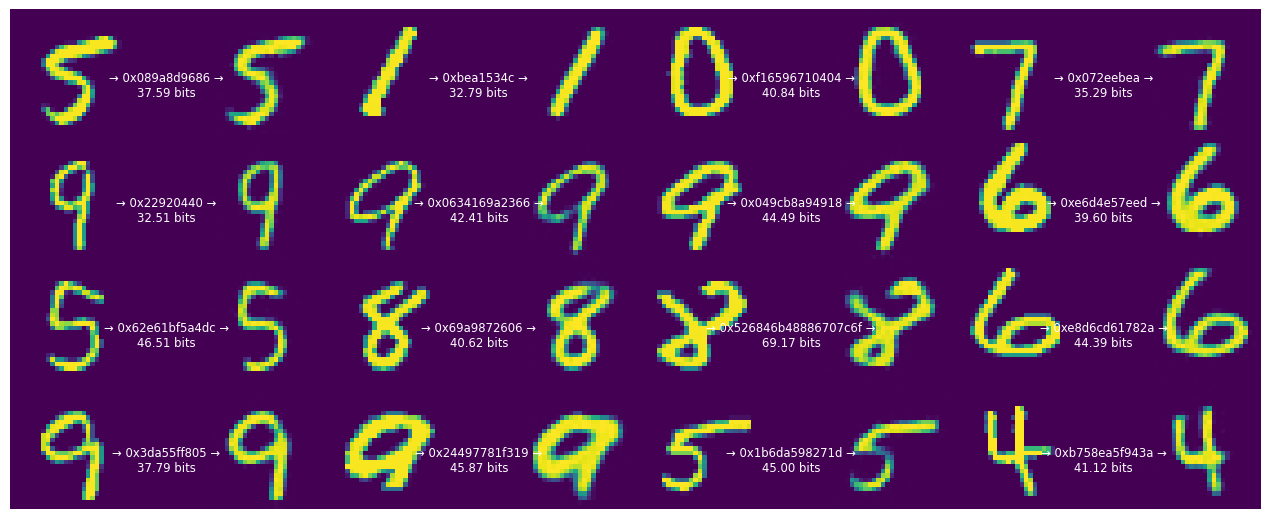

In [24]:
display_digits(originals, strings, entropies, reconstructions)


Note that the length of the encoded string differs from the information content of each digit.

This is because the range coding process works with discrete probabilities, and has a small amount of overhead. So, especially for short strings, the correspondence is only approximate. However, range coding is **asymptotically optimal**: in the limit, the expected bit count will approach the cross entropy (the expected information content), for which the rate term in the training model is an upper bound.

## The rate–distortion trade-off

Above, the model was trained for a specific trade-off (given by `lmbda=2000`) between the average number of bits used to represent each digit and the incurred error in the reconstruction.

What happens when we repeat the experiment with different values?

Let's start by reducing $\lambda$ to 500.

Epoch 1/15


  1/469 [..............................] - ETA: 15:44 - loss: 164.7716 - distortion_loss: 0.1237 - rate_loss: 102.9134 - distortion_pass_through_loss: 0.1237 - rate_pass_through_loss: 102.9134

  4/469 [..............................] - ETA: 8s - loss: 168.3027 - distortion_loss: 0.1309 - rate_loss: 102.8313 - distortion_pass_through_loss: 0.1309 - rate_pass_through_loss: 102.8313   

  7/469 [..............................] - ETA: 8s - loss: 168.6250 - distortion_loss: 0.1318 - rate_loss: 102.7136 - distortion_pass_through_loss: 0.1318 - rate_pass_through_loss: 102.7136

 10/469 [..............................] - ETA: 8s - loss: 168.6644 - distortion_loss: 0.1321 - rate_loss: 102.6060 - distortion_pass_through_loss: 0.1321 - rate_pass_through_loss: 102.6060

 13/469 [..............................] - ETA: 8s - loss: 168.3125 - distortion_loss: 0.1316 - rate_loss: 102.5072 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5072

 16/469 [>.............................] - ETA: 8s - loss: 167.8739 - distortion_loss: 0.1309 - rate_loss: 102.4085 - distortion_pass_through_loss: 0.1309 - rate_pass_through_loss: 102.4085

 19/469 [>.............................] - ETA: 8s - loss: 167.6097 - distortion_loss: 0.1306 - rate_loss: 102.3158 - distortion_pass_through_loss: 0.1306 - rate_pass_through_loss: 102.3158

 22/469 [>.............................] - ETA: 8s - loss: 167.4111 - distortion_loss: 0.1303 - rate_loss: 102.2534 - distortion_pass_through_loss: 0.1303 - rate_pass_through_loss: 102.2534

 25/469 [>.............................] - ETA: 8s - loss: 166.8903 - distortion_loss: 0.1294 - rate_loss: 102.1792 - distortion_pass_through_loss: 0.1294 - rate_pass_through_loss: 102.1792

 28/469 [>.............................] - ETA: 8s - loss: 166.7047 - distortion_loss: 0.1292 - rate_loss: 102.0835 - distortion_pass_through_loss: 0.1292 - rate_pass_through_loss: 102.0835

 31/469 [>.............................] - ETA: 8s - loss: 166.3094 - distortion_loss: 0.1286 - rate_loss: 101.9936 - distortion_pass_through_loss: 0.1286 - rate_pass_through_loss: 101.9936

 34/469 [=>............................] - ETA: 8s - loss: 165.9297 - distortion_loss: 0.1281 - rate_loss: 101.9009 - distortion_pass_through_loss: 0.1281 - rate_pass_through_loss: 101.9009

 37/469 [=>............................] - ETA: 8s - loss: 165.3974 - distortion_loss: 0.1272 - rate_loss: 101.8127 - distortion_pass_through_loss: 0.1272 - rate_pass_through_loss: 101.8127

 40/469 [=>............................] - ETA: 8s - loss: 164.9619 - distortion_loss: 0.1265 - rate_loss: 101.7315 - distortion_pass_through_loss: 0.1265 - rate_pass_through_loss: 101.7315

 43/469 [=>............................] - ETA: 8s - loss: 164.6508 - distortion_loss: 0.1260 - rate_loss: 101.6503 - distortion_pass_through_loss: 0.1260 - rate_pass_through_loss: 101.6503

 46/469 [=>............................] - ETA: 8s - loss: 164.2846 - distortion_loss: 0.1254 - rate_loss: 101.5701 - distortion_pass_through_loss: 0.1254 - rate_pass_through_loss: 101.5701

 49/469 [==>...........................] - ETA: 7s - loss: 163.9357 - distortion_loss: 0.1248 - rate_loss: 101.5118 - distortion_pass_through_loss: 0.1248 - rate_pass_through_loss: 101.5118

 52/469 [==>...........................] - ETA: 7s - loss: 163.4965 - distortion_loss: 0.1240 - rate_loss: 101.4851 - distortion_pass_through_loss: 0.1240 - rate_pass_through_loss: 101.4851

 55/469 [==>...........................] - ETA: 7s - loss: 162.9647 - distortion_loss: 0.1230 - rate_loss: 101.4596 - distortion_pass_through_loss: 0.1230 - rate_pass_through_loss: 101.4596

 58/469 [==>...........................] - ETA: 7s - loss: 162.4712 - distortion_loss: 0.1221 - rate_loss: 101.4073 - distortion_pass_through_loss: 0.1221 - rate_pass_through_loss: 101.4073

 61/469 [==>...........................] - ETA: 7s - loss: 161.9366 - distortion_loss: 0.1212 - rate_loss: 101.3476 - distortion_pass_through_loss: 0.1212 - rate_pass_through_loss: 101.3476

 64/469 [===>..........................] - ETA: 7s - loss: 161.4371 - distortion_loss: 0.1203 - rate_loss: 101.2971 - distortion_pass_through_loss: 0.1203 - rate_pass_through_loss: 101.2971

 67/469 [===>..........................] - ETA: 7s - loss: 160.8956 - distortion_loss: 0.1193 - rate_loss: 101.2457 - distortion_pass_through_loss: 0.1193 - rate_pass_through_loss: 101.2457

 70/469 [===>..........................] - ETA: 7s - loss: 160.3096 - distortion_loss: 0.1182 - rate_loss: 101.1920 - distortion_pass_through_loss: 0.1182 - rate_pass_through_loss: 101.1920

 73/469 [===>..........................] - ETA: 7s - loss: 159.6873 - distortion_loss: 0.1171 - rate_loss: 101.1435 - distortion_pass_through_loss: 0.1171 - rate_pass_through_loss: 101.1435

 76/469 [===>..........................] - ETA: 7s - loss: 159.1487 - distortion_loss: 0.1161 - rate_loss: 101.1008 - distortion_pass_through_loss: 0.1161 - rate_pass_through_loss: 101.1008

 79/469 [====>.........................] - ETA: 7s - loss: 158.5719 - distortion_loss: 0.1150 - rate_loss: 101.0541 - distortion_pass_through_loss: 0.1150 - rate_pass_through_loss: 101.0541

 82/469 [====>.........................] - ETA: 7s - loss: 158.0314 - distortion_loss: 0.1141 - rate_loss: 101.0049 - distortion_pass_through_loss: 0.1141 - rate_pass_through_loss: 101.0049

 85/469 [====>.........................] - ETA: 7s - loss: 157.4592 - distortion_loss: 0.1130 - rate_loss: 100.9643 - distortion_pass_through_loss: 0.1130 - rate_pass_through_loss: 100.9643

 88/469 [====>.........................] - ETA: 7s - loss: 156.9155 - distortion_loss: 0.1120 - rate_loss: 100.9204 - distortion_pass_through_loss: 0.1120 - rate_pass_through_loss: 100.9204

 91/469 [====>.........................] - ETA: 7s - loss: 156.3587 - distortion_loss: 0.1110 - rate_loss: 100.8779 - distortion_pass_through_loss: 0.1110 - rate_pass_through_loss: 100.8779

 94/469 [=====>........................] - ETA: 7s - loss: 155.8546 - distortion_loss: 0.1100 - rate_loss: 100.8332 - distortion_pass_through_loss: 0.1100 - rate_pass_through_loss: 100.8332

 97/469 [=====>........................] - ETA: 7s - loss: 155.3255 - distortion_loss: 0.1091 - rate_loss: 100.7834 - distortion_pass_through_loss: 0.1091 - rate_pass_through_loss: 100.7834

100/469 [=====>........................] - ETA: 6s - loss: 154.8534 - distortion_loss: 0.1082 - rate_loss: 100.7366 - distortion_pass_through_loss: 0.1082 - rate_pass_through_loss: 100.7366

103/469 [=====>........................] - ETA: 6s - loss: 154.3833 - distortion_loss: 0.1074 - rate_loss: 100.6885 - distortion_pass_through_loss: 0.1074 - rate_pass_through_loss: 100.6885

106/469 [=====>........................] - ETA: 6s - loss: 153.8937 - distortion_loss: 0.1065 - rate_loss: 100.6358 - distortion_pass_through_loss: 0.1065 - rate_pass_through_loss: 100.6358

109/469 [=====>........................] - ETA: 6s - loss: 153.4096 - distortion_loss: 0.1056 - rate_loss: 100.5852 - distortion_pass_through_loss: 0.1056 - rate_pass_through_loss: 100.5852

112/469 [======>.......................] - ETA: 6s - loss: 152.9764 - distortion_loss: 0.1049 - rate_loss: 100.5382 - distortion_pass_through_loss: 0.1049 - rate_pass_through_loss: 100.5382

115/469 [======>.......................] - ETA: 6s - loss: 152.5687 - distortion_loss: 0.1042 - rate_loss: 100.4877 - distortion_pass_through_loss: 0.1042 - rate_pass_through_loss: 100.4877

118/469 [======>.......................] - ETA: 6s - loss: 152.1100 - distortion_loss: 0.1033 - rate_loss: 100.4359 - distortion_pass_through_loss: 0.1033 - rate_pass_through_loss: 100.4359

121/469 [======>.......................] - ETA: 6s - loss: 151.6818 - distortion_loss: 0.1026 - rate_loss: 100.3838 - distortion_pass_through_loss: 0.1026 - rate_pass_through_loss: 100.3838

124/469 [======>.......................] - ETA: 6s - loss: 151.2592 - distortion_loss: 0.1019 - rate_loss: 100.3324 - distortion_pass_through_loss: 0.1019 - rate_pass_through_loss: 100.3324

127/469 [=======>......................] - ETA: 6s - loss: 150.8367 - distortion_loss: 0.1011 - rate_loss: 100.2794 - distortion_pass_through_loss: 0.1011 - rate_pass_through_loss: 100.2794

130/469 [=======>......................] - ETA: 6s - loss: 150.4238 - distortion_loss: 0.1004 - rate_loss: 100.2215 - distortion_pass_through_loss: 0.1004 - rate_pass_through_loss: 100.2215

133/469 [=======>......................] - ETA: 6s - loss: 150.0182 - distortion_loss: 0.0997 - rate_loss: 100.1688 - distortion_pass_through_loss: 0.0997 - rate_pass_through_loss: 100.1688

136/469 [=======>......................] - ETA: 6s - loss: 149.6361 - distortion_loss: 0.0990 - rate_loss: 100.1167 - distortion_pass_through_loss: 0.0990 - rate_pass_through_loss: 100.1167

139/469 [=======>......................] - ETA: 6s - loss: 149.2748 - distortion_loss: 0.0984 - rate_loss: 100.0679 - distortion_pass_through_loss: 0.0984 - rate_pass_through_loss: 100.0679

142/469 [========>.....................] - ETA: 6s - loss: 148.9004 - distortion_loss: 0.0978 - rate_loss: 100.0127 - distortion_pass_through_loss: 0.0978 - rate_pass_through_loss: 100.0127

145/469 [========>.....................] - ETA: 6s - loss: 148.5444 - distortion_loss: 0.0972 - rate_loss: 99.9631 - distortion_pass_through_loss: 0.0972 - rate_pass_through_loss: 99.9631  

148/469 [========>.....................] - ETA: 6s - loss: 148.1949 - distortion_loss: 0.0966 - rate_loss: 99.9050 - distortion_pass_through_loss: 0.0966 - rate_pass_through_loss: 99.9050

151/469 [========>.....................] - ETA: 6s - loss: 147.8523 - distortion_loss: 0.0960 - rate_loss: 99.8492 - distortion_pass_through_loss: 0.0960 - rate_pass_through_loss: 99.8492

154/469 [========>.....................] - ETA: 5s - loss: 147.5378 - distortion_loss: 0.0955 - rate_loss: 99.7984 - distortion_pass_through_loss: 0.0955 - rate_pass_through_loss: 99.7984

157/469 [=========>....................] - ETA: 5s - loss: 147.2128 - distortion_loss: 0.0949 - rate_loss: 99.7457 - distortion_pass_through_loss: 0.0949 - rate_pass_through_loss: 99.7457

160/469 [=========>....................] - ETA: 5s - loss: 146.9005 - distortion_loss: 0.0944 - rate_loss: 99.6887 - distortion_pass_through_loss: 0.0944 - rate_pass_through_loss: 99.6887

163/469 [=========>....................] - ETA: 5s - loss: 146.5686 - distortion_loss: 0.0939 - rate_loss: 99.6307 - distortion_pass_through_loss: 0.0939 - rate_pass_through_loss: 99.6307

166/469 [=========>....................] - ETA: 5s - loss: 146.2613 - distortion_loss: 0.0934 - rate_loss: 99.5702 - distortion_pass_through_loss: 0.0934 - rate_pass_through_loss: 99.5702

169/469 [=========>....................] - ETA: 5s - loss: 145.9605 - distortion_loss: 0.0929 - rate_loss: 99.5146 - distortion_pass_through_loss: 0.0929 - rate_pass_through_loss: 99.5146

172/469 [==========>...................] - ETA: 5s - loss: 145.6522 - distortion_loss: 0.0924 - rate_loss: 99.4544 - distortion_pass_through_loss: 0.0924 - rate_pass_through_loss: 99.4544

175/469 [==========>...................] - ETA: 5s - loss: 145.3663 - distortion_loss: 0.0919 - rate_loss: 99.3964 - distortion_pass_through_loss: 0.0919 - rate_pass_through_loss: 99.3964

178/469 [==========>...................] - ETA: 5s - loss: 145.0703 - distortion_loss: 0.0915 - rate_loss: 99.3381 - distortion_pass_through_loss: 0.0915 - rate_pass_through_loss: 99.3381

181/469 [==========>...................] - ETA: 5s - loss: 144.7908 - distortion_loss: 0.0910 - rate_loss: 99.2815 - distortion_pass_through_loss: 0.0910 - rate_pass_through_loss: 99.2815

184/469 [==========>...................] - ETA: 5s - loss: 144.5142 - distortion_loss: 0.0906 - rate_loss: 99.2231 - distortion_pass_through_loss: 0.0906 - rate_pass_through_loss: 99.2231

187/469 [==========>...................] - ETA: 5s - loss: 144.2305 - distortion_loss: 0.0901 - rate_loss: 99.1619 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 99.1619

190/469 [===========>..................] - ETA: 5s - loss: 143.9668 - distortion_loss: 0.0897 - rate_loss: 99.1041 - distortion_pass_through_loss: 0.0897 - rate_pass_through_loss: 99.1041

193/469 [===========>..................] - ETA: 5s - loss: 143.7064 - distortion_loss: 0.0893 - rate_loss: 99.0408 - distortion_pass_through_loss: 0.0893 - rate_pass_through_loss: 99.0408

196/469 [===========>..................] - ETA: 5s - loss: 143.4428 - distortion_loss: 0.0889 - rate_loss: 98.9799 - distortion_pass_through_loss: 0.0889 - rate_pass_through_loss: 98.9799

199/469 [===========>..................] - ETA: 5s - loss: 143.1714 - distortion_loss: 0.0885 - rate_loss: 98.9175 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 98.9175

202/469 [===========>..................] - ETA: 5s - loss: 142.9095 - distortion_loss: 0.0881 - rate_loss: 98.8526 - distortion_pass_through_loss: 0.0881 - rate_pass_through_loss: 98.8526

205/469 [============>.................] - ETA: 5s - loss: 142.6514 - distortion_loss: 0.0877 - rate_loss: 98.7914 - distortion_pass_through_loss: 0.0877 - rate_pass_through_loss: 98.7914

208/469 [============>.................] - ETA: 4s - loss: 142.3964 - distortion_loss: 0.0873 - rate_loss: 98.7278 - distortion_pass_through_loss: 0.0873 - rate_pass_through_loss: 98.7278

211/469 [============>.................] - ETA: 4s - loss: 142.1366 - distortion_loss: 0.0869 - rate_loss: 98.6648 - distortion_pass_through_loss: 0.0869 - rate_pass_through_loss: 98.6648

214/469 [============>.................] - ETA: 4s - loss: 141.8924 - distortion_loss: 0.0866 - rate_loss: 98.6022 - distortion_pass_through_loss: 0.0866 - rate_pass_through_loss: 98.6022

217/469 [============>.................] - ETA: 4s - loss: 141.6486 - distortion_loss: 0.0862 - rate_loss: 98.5377 - distortion_pass_through_loss: 0.0862 - rate_pass_through_loss: 98.5377

220/469 [=============>................] - ETA: 4s - loss: 141.4084 - distortion_loss: 0.0859 - rate_loss: 98.4735 - distortion_pass_through_loss: 0.0859 - rate_pass_through_loss: 98.4735

223/469 [=============>................] - ETA: 4s - loss: 141.1736 - distortion_loss: 0.0855 - rate_loss: 98.4100 - distortion_pass_through_loss: 0.0855 - rate_pass_through_loss: 98.4100

226/469 [=============>................] - ETA: 4s - loss: 140.9348 - distortion_loss: 0.0852 - rate_loss: 98.3407 - distortion_pass_through_loss: 0.0852 - rate_pass_through_loss: 98.3407

229/469 [=============>................] - ETA: 4s - loss: 140.7152 - distortion_loss: 0.0849 - rate_loss: 98.2752 - distortion_pass_through_loss: 0.0849 - rate_pass_through_loss: 98.2752

232/469 [=============>................] - ETA: 4s - loss: 140.4990 - distortion_loss: 0.0846 - rate_loss: 98.2122 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 98.2122

235/469 [==============>...............] - ETA: 4s - loss: 140.2699 - distortion_loss: 0.0843 - rate_loss: 98.1432 - distortion_pass_through_loss: 0.0843 - rate_pass_through_loss: 98.1432

238/469 [==============>...............] - ETA: 4s - loss: 140.0486 - distortion_loss: 0.0839 - rate_loss: 98.0785 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 98.0785

241/469 [==============>...............] - ETA: 4s - loss: 139.8302 - distortion_loss: 0.0836 - rate_loss: 98.0142 - distortion_pass_through_loss: 0.0836 - rate_pass_through_loss: 98.0142

244/469 [==============>...............] - ETA: 4s - loss: 139.6058 - distortion_loss: 0.0833 - rate_loss: 97.9438 - distortion_pass_through_loss: 0.0833 - rate_pass_through_loss: 97.9438

247/469 [==============>...............] - ETA: 4s - loss: 139.4073 - distortion_loss: 0.0831 - rate_loss: 97.8784 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 97.8784

250/469 [==============>...............] - ETA: 4s - loss: 139.2000 - distortion_loss: 0.0828 - rate_loss: 97.8113 - distortion_pass_through_loss: 0.0828 - rate_pass_through_loss: 97.8113

253/469 [===============>..............] - ETA: 4s - loss: 138.9901 - distortion_loss: 0.0825 - rate_loss: 97.7424 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 97.7424

256/469 [===============>..............] - ETA: 4s - loss: 138.7763 - distortion_loss: 0.0822 - rate_loss: 97.6729 - distortion_pass_through_loss: 0.0822 - rate_pass_through_loss: 97.6729

259/469 [===============>..............] - ETA: 3s - loss: 138.5707 - distortion_loss: 0.0819 - rate_loss: 97.6075 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 97.6075

262/469 [===============>..............] - ETA: 3s - loss: 138.3666 - distortion_loss: 0.0817 - rate_loss: 97.5409 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 97.5409

265/469 [===============>..............] - ETA: 3s - loss: 138.1621 - distortion_loss: 0.0814 - rate_loss: 97.4722 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 97.4722

268/469 [================>.............] - ETA: 3s - loss: 137.9588 - distortion_loss: 0.0811 - rate_loss: 97.4037 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 97.4037

271/469 [================>.............] - ETA: 3s - loss: 137.7642 - distortion_loss: 0.0809 - rate_loss: 97.3349 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 97.3349

274/469 [================>.............] - ETA: 3s - loss: 137.5763 - distortion_loss: 0.0806 - rate_loss: 97.2675 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 97.2675

277/469 [================>.............] - ETA: 3s - loss: 137.3852 - distortion_loss: 0.0804 - rate_loss: 97.1994 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 97.1994

280/469 [================>.............] - ETA: 3s - loss: 137.1873 - distortion_loss: 0.0801 - rate_loss: 97.1314 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 97.1314

283/469 [=================>............] - ETA: 3s - loss: 137.0147 - distortion_loss: 0.0799 - rate_loss: 97.0630 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 97.0630

286/469 [=================>............] - ETA: 3s - loss: 136.8339 - distortion_loss: 0.0797 - rate_loss: 96.9936 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 96.9936

289/469 [=================>............] - ETA: 3s - loss: 136.6508 - distortion_loss: 0.0795 - rate_loss: 96.9224 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 96.9224

292/469 [=================>............] - ETA: 3s - loss: 136.4619 - distortion_loss: 0.0792 - rate_loss: 96.8519 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 96.8519

295/469 [=================>............] - ETA: 3s - loss: 136.2743 - distortion_loss: 0.0790 - rate_loss: 96.7826 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 96.7826

298/469 [==================>...........] - ETA: 3s - loss: 136.0858 - distortion_loss: 0.0787 - rate_loss: 96.7148 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 96.7148

301/469 [==================>...........] - ETA: 3s - loss: 135.9131 - distortion_loss: 0.0785 - rate_loss: 96.6459 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 96.6459

304/469 [==================>...........] - ETA: 3s - loss: 135.7303 - distortion_loss: 0.0783 - rate_loss: 96.5745 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 96.5745

307/469 [==================>...........] - ETA: 3s - loss: 135.5591 - distortion_loss: 0.0781 - rate_loss: 96.5029 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 96.5029

310/469 [==================>...........] - ETA: 3s - loss: 135.3897 - distortion_loss: 0.0779 - rate_loss: 96.4302 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 96.4302

313/469 [===================>..........] - ETA: 2s - loss: 135.2198 - distortion_loss: 0.0777 - rate_loss: 96.3612 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 96.3612

316/469 [===================>..........] - ETA: 2s - loss: 135.0482 - distortion_loss: 0.0775 - rate_loss: 96.2900 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 96.2900

319/469 [===================>..........] - ETA: 2s - loss: 134.8769 - distortion_loss: 0.0773 - rate_loss: 96.2227 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 96.2227

322/469 [===================>..........] - ETA: 2s - loss: 134.7084 - distortion_loss: 0.0771 - rate_loss: 96.1499 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 96.1499

325/469 [===================>..........] - ETA: 2s - loss: 134.5403 - distortion_loss: 0.0769 - rate_loss: 96.0772 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 96.0772

328/469 [===================>..........] - ETA: 2s - loss: 134.3760 - distortion_loss: 0.0767 - rate_loss: 96.0049 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 96.0049

331/469 [====================>.........] - ETA: 2s - loss: 134.2071 - distortion_loss: 0.0765 - rate_loss: 95.9332 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 95.9332

334/469 [====================>.........] - ETA: 2s - loss: 134.0456 - distortion_loss: 0.0764 - rate_loss: 95.8635 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 95.8635

337/469 [====================>.........] - ETA: 2s - loss: 133.8845 - distortion_loss: 0.0762 - rate_loss: 95.7923 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 95.7923

340/469 [====================>.........] - ETA: 2s - loss: 133.7209 - distortion_loss: 0.0760 - rate_loss: 95.7198 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 95.7198

343/469 [====================>.........] - ETA: 2s - loss: 133.5603 - distortion_loss: 0.0758 - rate_loss: 95.6476 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 95.6476

346/469 [=====================>........] - ETA: 2s - loss: 133.3964 - distortion_loss: 0.0756 - rate_loss: 95.5749 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 95.5749

349/469 [=====================>........] - ETA: 2s - loss: 133.2455 - distortion_loss: 0.0755 - rate_loss: 95.5044 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 95.5044

352/469 [=====================>........] - ETA: 2s - loss: 133.0911 - distortion_loss: 0.0753 - rate_loss: 95.4326 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 95.4326

355/469 [=====================>........] - ETA: 2s - loss: 132.9352 - distortion_loss: 0.0752 - rate_loss: 95.3584 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 95.3584

358/469 [=====================>........] - ETA: 2s - loss: 132.7807 - distortion_loss: 0.0750 - rate_loss: 95.2864 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 95.2864

361/469 [======================>.......] - ETA: 2s - loss: 132.6350 - distortion_loss: 0.0748 - rate_loss: 95.2133 - distortion_pass_through_loss: 0.0748 - rate_pass_through_loss: 95.2133

364/469 [======================>.......] - ETA: 1s - loss: 132.4868 - distortion_loss: 0.0747 - rate_loss: 95.1404 - distortion_pass_through_loss: 0.0747 - rate_pass_through_loss: 95.1404

367/469 [======================>.......] - ETA: 1s - loss: 132.3373 - distortion_loss: 0.0745 - rate_loss: 95.0684 - distortion_pass_through_loss: 0.0745 - rate_pass_through_loss: 95.0684

370/469 [======================>.......] - ETA: 1s - loss: 132.1889 - distortion_loss: 0.0744 - rate_loss: 94.9959 - distortion_pass_through_loss: 0.0744 - rate_pass_through_loss: 94.9959

373/469 [======================>.......] - ETA: 1s - loss: 132.0387 - distortion_loss: 0.0742 - rate_loss: 94.9238 - distortion_pass_through_loss: 0.0742 - rate_pass_through_loss: 94.9238

376/469 [=======================>......] - ETA: 1s - loss: 131.8872 - distortion_loss: 0.0741 - rate_loss: 94.8499 - distortion_pass_through_loss: 0.0741 - rate_pass_through_loss: 94.8499

379/469 [=======================>......] - ETA: 1s - loss: 131.7373 - distortion_loss: 0.0739 - rate_loss: 94.7765 - distortion_pass_through_loss: 0.0739 - rate_pass_through_loss: 94.7765

382/469 [=======================>......] - ETA: 1s - loss: 131.5896 - distortion_loss: 0.0738 - rate_loss: 94.7035 - distortion_pass_through_loss: 0.0738 - rate_pass_through_loss: 94.7035

385/469 [=======================>......] - ETA: 1s - loss: 131.4417 - distortion_loss: 0.0736 - rate_loss: 94.6306 - distortion_pass_through_loss: 0.0736 - rate_pass_through_loss: 94.6306

388/469 [=======================>......] - ETA: 1s - loss: 131.3028 - distortion_loss: 0.0735 - rate_loss: 94.5599 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 94.5599

391/469 [========================>.....] - ETA: 1s - loss: 131.1570 - distortion_loss: 0.0733 - rate_loss: 94.4854 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 94.4854

394/469 [========================>.....] - ETA: 1s - loss: 131.0153 - distortion_loss: 0.0732 - rate_loss: 94.4111 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 94.4111

397/469 [========================>.....] - ETA: 1s - loss: 130.8731 - distortion_loss: 0.0731 - rate_loss: 94.3384 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 94.3384

400/469 [========================>.....] - ETA: 1s - loss: 130.7336 - distortion_loss: 0.0729 - rate_loss: 94.2626 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 94.2626

403/469 [========================>.....] - ETA: 1s - loss: 130.5850 - distortion_loss: 0.0728 - rate_loss: 94.1883 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 94.1883

406/469 [========================>.....] - ETA: 1s - loss: 130.4493 - distortion_loss: 0.0727 - rate_loss: 94.1154 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 94.1154

409/469 [=========================>....] - ETA: 1s - loss: 130.3106 - distortion_loss: 0.0725 - rate_loss: 94.0430 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 94.0430

412/469 [=========================>....] - ETA: 1s - loss: 130.1763 - distortion_loss: 0.0724 - rate_loss: 93.9700 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 93.9700

415/469 [=========================>....] - ETA: 1s - loss: 130.0394 - distortion_loss: 0.0723 - rate_loss: 93.8953 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 93.8953

418/469 [=========================>....] - ETA: 0s - loss: 129.9024 - distortion_loss: 0.0722 - rate_loss: 93.8219 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 93.8219

421/469 [=========================>....] - ETA: 0s - loss: 129.7637 - distortion_loss: 0.0720 - rate_loss: 93.7467 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 93.7467

424/469 [==========================>...] - ETA: 0s - loss: 129.6259 - distortion_loss: 0.0719 - rate_loss: 93.6740 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 93.6740

427/469 [==========================>...] - ETA: 0s - loss: 129.4930 - distortion_loss: 0.0718 - rate_loss: 93.6005 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 93.6005

430/469 [==========================>...] - ETA: 0s - loss: 129.3636 - distortion_loss: 0.0717 - rate_loss: 93.5274 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 93.5274

433/469 [==========================>...] - ETA: 0s - loss: 129.2329 - distortion_loss: 0.0716 - rate_loss: 93.4537 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 93.4537

436/469 [==========================>...] - ETA: 0s - loss: 129.0987 - distortion_loss: 0.0714 - rate_loss: 93.3792 - distortion_pass_through_loss: 0.0714 - rate_pass_through_loss: 93.3792

439/469 [===========================>..] - ETA: 0s - loss: 128.9679 - distortion_loss: 0.0713 - rate_loss: 93.3059 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 93.3059

442/469 [===========================>..] - ETA: 0s - loss: 128.8371 - distortion_loss: 0.0712 - rate_loss: 93.2313 - distortion_pass_through_loss: 0.0712 - rate_pass_through_loss: 93.2313

445/469 [===========================>..] - ETA: 0s - loss: 128.7048 - distortion_loss: 0.0711 - rate_loss: 93.1570 - distortion_pass_through_loss: 0.0711 - rate_pass_through_loss: 93.1570

448/469 [===========================>..] - ETA: 0s - loss: 128.5815 - distortion_loss: 0.0710 - rate_loss: 93.0830 - distortion_pass_through_loss: 0.0710 - rate_pass_through_loss: 93.0830

451/469 [===========================>..] - ETA: 0s - loss: 128.4511 - distortion_loss: 0.0709 - rate_loss: 93.0094 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 93.0094

454/469 [============================>.] - ETA: 0s - loss: 128.3224 - distortion_loss: 0.0708 - rate_loss: 92.9363 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 92.9363

457/469 [============================>.] - ETA: 0s - loss: 128.1947 - distortion_loss: 0.0707 - rate_loss: 92.8647 - distortion_pass_through_loss: 0.0707 - rate_pass_through_loss: 92.8647

460/469 [============================>.] - ETA: 0s - loss: 128.0684 - distortion_loss: 0.0706 - rate_loss: 92.7902 - distortion_pass_through_loss: 0.0706 - rate_pass_through_loss: 92.7902

463/469 [============================>.] - ETA: 0s - loss: 127.9433 - distortion_loss: 0.0705 - rate_loss: 92.7161 - distortion_pass_through_loss: 0.0705 - rate_pass_through_loss: 92.7161

466/469 [============================>.] - ETA: 0s - loss: 127.8207 - distortion_loss: 0.0704 - rate_loss: 92.6411 - distortion_pass_through_loss: 0.0704 - rate_pass_through_loss: 92.6411

469/469 [==============================] - ETA: 0s - loss: 127.7013 - distortion_loss: 0.0703 - rate_loss: 92.5737 - distortion_pass_through_loss: 0.0702 - rate_pass_through_loss: 92.5675

469/469 [==============================] - 12s 21ms/step - loss: 127.7013 - distortion_loss: 0.0703 - rate_loss: 92.5737 - distortion_pass_through_loss: 0.0702 - rate_pass_through_loss: 92.5675 - val_loss: 107.4871 - val_distortion_loss: 0.0552 - val_rate_loss: 79.8772 - val_distortion_pass_through_loss: 0.0552 - val_rate_pass_through_loss: 79.8765


Epoch 2/15


  1/469 [..............................] - ETA: 9s - loss: 106.0444 - distortion_loss: 0.0506 - rate_loss: 80.7637 - distortion_pass_through_loss: 0.0506 - rate_pass_through_loss: 80.7637

  4/469 [..............................] - ETA: 8s - loss: 107.4350 - distortion_loss: 0.0533 - rate_loss: 80.7835 - distortion_pass_through_loss: 0.0533 - rate_pass_through_loss: 80.7835

  7/469 [..............................] - ETA: 8s - loss: 107.9235 - distortion_loss: 0.0542 - rate_loss: 80.8196 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 80.8196

 10/469 [..............................] - ETA: 8s - loss: 108.0684 - distortion_loss: 0.0546 - rate_loss: 80.7817 - distortion_pass_through_loss: 0.0546 - rate_pass_through_loss: 80.7817

 13/469 [..............................] - ETA: 8s - loss: 107.8460 - distortion_loss: 0.0543 - rate_loss: 80.7184 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 80.7184

 16/469 [>.............................] - ETA: 8s - loss: 107.6964 - distortion_loss: 0.0541 - rate_loss: 80.6317 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 80.6317

 19/469 [>.............................] - ETA: 8s - loss: 107.6452 - distortion_loss: 0.0542 - rate_loss: 80.5458 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 80.5458

 22/469 [>.............................] - ETA: 8s - loss: 107.7052 - distortion_loss: 0.0544 - rate_loss: 80.5124 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.5124

 25/469 [>.............................] - ETA: 8s - loss: 107.6292 - distortion_loss: 0.0544 - rate_loss: 80.4049 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.4049

 28/469 [>.............................] - ETA: 8s - loss: 107.6017 - distortion_loss: 0.0545 - rate_loss: 80.3596 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 80.3596

 31/469 [>.............................] - ETA: 8s - loss: 107.4844 - distortion_loss: 0.0544 - rate_loss: 80.2770 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 80.2770

 34/469 [=>............................] - ETA: 8s - loss: 107.4342 - distortion_loss: 0.0545 - rate_loss: 80.2045 - distortion_pass_through_loss: 0.0545 - rate_pass_through_loss: 80.2045

 37/469 [=>............................] - ETA: 8s - loss: 107.2830 - distortion_loss: 0.0543 - rate_loss: 80.1093 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 80.1093

 40/469 [=>............................] - ETA: 8s - loss: 107.1849 - distortion_loss: 0.0543 - rate_loss: 80.0303 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 80.0303

 43/469 [=>............................] - ETA: 8s - loss: 107.1068 - distortion_loss: 0.0543 - rate_loss: 79.9620 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.9620

 46/469 [=>............................] - ETA: 7s - loss: 107.0171 - distortion_loss: 0.0542 - rate_loss: 79.8922 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 79.8922

 49/469 [==>...........................] - ETA: 7s - loss: 107.0059 - distortion_loss: 0.0543 - rate_loss: 79.8373 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.8373

 52/469 [==>...........................] - ETA: 7s - loss: 106.9513 - distortion_loss: 0.0544 - rate_loss: 79.7707 - distortion_pass_through_loss: 0.0544 - rate_pass_through_loss: 79.7707

 55/469 [==>...........................] - ETA: 7s - loss: 106.8477 - distortion_loss: 0.0543 - rate_loss: 79.6912 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.6912

 58/469 [==>...........................] - ETA: 7s - loss: 106.7689 - distortion_loss: 0.0543 - rate_loss: 79.6153 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.6153

 61/469 [==>...........................] - ETA: 7s - loss: 106.6903 - distortion_loss: 0.0543 - rate_loss: 79.5413 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.5413

 64/469 [===>..........................] - ETA: 7s - loss: 106.6386 - distortion_loss: 0.0543 - rate_loss: 79.4778 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.4778

 67/469 [===>..........................] - ETA: 7s - loss: 106.5613 - distortion_loss: 0.0543 - rate_loss: 79.4062 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.4062

 70/469 [===>..........................] - ETA: 7s - loss: 106.4737 - distortion_loss: 0.0543 - rate_loss: 79.3359 - distortion_pass_through_loss: 0.0543 - rate_pass_through_loss: 79.3359

 73/469 [===>..........................] - ETA: 7s - loss: 106.3611 - distortion_loss: 0.0542 - rate_loss: 79.2561 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 79.2561

 76/469 [===>..........................] - ETA: 7s - loss: 106.2820 - distortion_loss: 0.0542 - rate_loss: 79.1841 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 79.1841

 79/469 [====>.........................] - ETA: 7s - loss: 106.1905 - distortion_loss: 0.0542 - rate_loss: 79.1032 - distortion_pass_through_loss: 0.0542 - rate_pass_through_loss: 79.1032

 82/469 [====>.........................] - ETA: 7s - loss: 106.1101 - distortion_loss: 0.0541 - rate_loss: 79.0352 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 79.0352

 85/469 [====>.........................] - ETA: 7s - loss: 106.0033 - distortion_loss: 0.0541 - rate_loss: 78.9580 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.9580

 88/469 [====>.........................] - ETA: 7s - loss: 105.9247 - distortion_loss: 0.0541 - rate_loss: 78.8863 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 78.8863

 91/469 [====>.........................] - ETA: 7s - loss: 105.8153 - distortion_loss: 0.0540 - rate_loss: 78.8035 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.8035

 94/469 [=====>........................] - ETA: 7s - loss: 105.7466 - distortion_loss: 0.0540 - rate_loss: 78.7317 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.7317

 97/469 [=====>........................] - ETA: 7s - loss: 105.6470 - distortion_loss: 0.0540 - rate_loss: 78.6559 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.6559

100/469 [=====>........................] - ETA: 7s - loss: 105.5916 - distortion_loss: 0.0540 - rate_loss: 78.5856 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.5856

103/469 [=====>........................] - ETA: 6s - loss: 105.5176 - distortion_loss: 0.0540 - rate_loss: 78.5118 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.5118

106/469 [=====>........................] - ETA: 6s - loss: 105.4279 - distortion_loss: 0.0540 - rate_loss: 78.4360 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.4360

109/469 [=====>........................] - ETA: 6s - loss: 105.3390 - distortion_loss: 0.0540 - rate_loss: 78.3598 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.3598

112/469 [======>.......................] - ETA: 6s - loss: 105.2721 - distortion_loss: 0.0540 - rate_loss: 78.2932 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.2932

115/469 [======>.......................] - ETA: 6s - loss: 105.2143 - distortion_loss: 0.0540 - rate_loss: 78.2222 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 78.2222

118/469 [======>.......................] - ETA: 6s - loss: 105.1156 - distortion_loss: 0.0539 - rate_loss: 78.1478 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 78.1478

121/469 [======>.......................] - ETA: 6s - loss: 105.0295 - distortion_loss: 0.0539 - rate_loss: 78.0720 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 78.0720

124/469 [======>.......................] - ETA: 6s - loss: 104.9481 - distortion_loss: 0.0539 - rate_loss: 77.9961 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.9961

127/469 [=======>......................] - ETA: 6s - loss: 104.8609 - distortion_loss: 0.0539 - rate_loss: 77.9226 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.9226

130/469 [=======>......................] - ETA: 6s - loss: 104.7755 - distortion_loss: 0.0539 - rate_loss: 77.8444 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.8444

133/469 [=======>......................] - ETA: 6s - loss: 104.6872 - distortion_loss: 0.0538 - rate_loss: 77.7687 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.7687

136/469 [=======>......................] - ETA: 6s - loss: 104.6139 - distortion_loss: 0.0538 - rate_loss: 77.6931 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.6931

139/469 [=======>......................] - ETA: 6s - loss: 104.5507 - distortion_loss: 0.0538 - rate_loss: 77.6260 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.6260

142/469 [========>.....................] - ETA: 6s - loss: 104.4696 - distortion_loss: 0.0538 - rate_loss: 77.5517 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.5517

145/469 [========>.....................] - ETA: 6s - loss: 104.4018 - distortion_loss: 0.0538 - rate_loss: 77.4781 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.4781

148/469 [========>.....................] - ETA: 6s - loss: 104.3343 - distortion_loss: 0.0539 - rate_loss: 77.4089 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.4089

151/469 [========>.....................] - ETA: 6s - loss: 104.2595 - distortion_loss: 0.0538 - rate_loss: 77.3385 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.3385

154/469 [========>.....................] - ETA: 5s - loss: 104.2013 - distortion_loss: 0.0538 - rate_loss: 77.2785 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 77.2785

157/469 [=========>....................] - ETA: 5s - loss: 104.1309 - distortion_loss: 0.0539 - rate_loss: 77.2030 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.2030

160/469 [=========>....................] - ETA: 5s - loss: 104.0736 - distortion_loss: 0.0539 - rate_loss: 77.1322 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.1322

163/469 [=========>....................] - ETA: 5s - loss: 103.9998 - distortion_loss: 0.0539 - rate_loss: 77.0554 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 77.0554

166/469 [=========>....................] - ETA: 5s - loss: 103.9328 - distortion_loss: 0.0539 - rate_loss: 76.9883 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.9883

169/469 [=========>....................] - ETA: 5s - loss: 103.8648 - distortion_loss: 0.0539 - rate_loss: 76.9232 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.9232

172/469 [==========>...................] - ETA: 5s - loss: 103.7854 - distortion_loss: 0.0539 - rate_loss: 76.8499 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.8499

175/469 [==========>...................] - ETA: 5s - loss: 103.7221 - distortion_loss: 0.0539 - rate_loss: 76.7773 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.7773

178/469 [==========>...................] - ETA: 5s - loss: 103.6474 - distortion_loss: 0.0539 - rate_loss: 76.7044 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.7044

181/469 [==========>...................] - ETA: 5s - loss: 103.5808 - distortion_loss: 0.0539 - rate_loss: 76.6359 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.6359

184/469 [==========>...................] - ETA: 5s - loss: 103.5140 - distortion_loss: 0.0539 - rate_loss: 76.5717 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.5717

187/469 [==========>...................] - ETA: 5s - loss: 103.4399 - distortion_loss: 0.0539 - rate_loss: 76.4981 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.4981

190/469 [===========>..................] - ETA: 5s - loss: 103.3809 - distortion_loss: 0.0539 - rate_loss: 76.4290 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.4290

193/469 [===========>..................] - ETA: 5s - loss: 103.3185 - distortion_loss: 0.0539 - rate_loss: 76.3618 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.3618

196/469 [===========>..................] - ETA: 5s - loss: 103.2463 - distortion_loss: 0.0539 - rate_loss: 76.2944 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.2944

199/469 [===========>..................] - ETA: 5s - loss: 103.1689 - distortion_loss: 0.0539 - rate_loss: 76.2265 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.2265

202/469 [===========>..................] - ETA: 5s - loss: 103.0960 - distortion_loss: 0.0539 - rate_loss: 76.1554 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.1554

205/469 [============>.................] - ETA: 5s - loss: 103.0233 - distortion_loss: 0.0539 - rate_loss: 76.0879 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.0879

208/469 [============>.................] - ETA: 4s - loss: 102.9455 - distortion_loss: 0.0539 - rate_loss: 76.0181 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 76.0181

211/469 [============>.................] - ETA: 4s - loss: 102.8692 - distortion_loss: 0.0538 - rate_loss: 75.9458 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.9458

214/469 [============>.................] - ETA: 4s - loss: 102.7989 - distortion_loss: 0.0538 - rate_loss: 75.8775 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.8775

217/469 [============>.................] - ETA: 4s - loss: 102.7247 - distortion_loss: 0.0538 - rate_loss: 75.8082 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.8082

220/469 [=============>................] - ETA: 4s - loss: 102.6563 - distortion_loss: 0.0538 - rate_loss: 75.7394 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.7394

223/469 [=============>................] - ETA: 4s - loss: 102.5853 - distortion_loss: 0.0538 - rate_loss: 75.6707 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.6707

226/469 [=============>................] - ETA: 4s - loss: 102.5057 - distortion_loss: 0.0538 - rate_loss: 75.6000 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.6000

229/469 [=============>................] - ETA: 4s - loss: 102.4424 - distortion_loss: 0.0538 - rate_loss: 75.5309 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.5309

232/469 [=============>................] - ETA: 4s - loss: 102.3811 - distortion_loss: 0.0538 - rate_loss: 75.4651 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.4651

235/469 [==============>...............] - ETA: 4s - loss: 102.3152 - distortion_loss: 0.0538 - rate_loss: 75.3932 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.3932

238/469 [==============>...............] - ETA: 4s - loss: 102.2501 - distortion_loss: 0.0538 - rate_loss: 75.3259 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.3259

241/469 [==============>...............] - ETA: 4s - loss: 102.1799 - distortion_loss: 0.0538 - rate_loss: 75.2567 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.2567

244/469 [==============>...............] - ETA: 4s - loss: 102.1065 - distortion_loss: 0.0538 - rate_loss: 75.1854 - distortion_pass_through_loss: 0.0538 - rate_pass_through_loss: 75.1854

247/469 [==============>...............] - ETA: 4s - loss: 102.0507 - distortion_loss: 0.0539 - rate_loss: 75.1218 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.1218

250/469 [==============>...............] - ETA: 4s - loss: 101.9887 - distortion_loss: 0.0539 - rate_loss: 75.0560 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 75.0560

253/469 [===============>..............] - ETA: 4s - loss: 101.9193 - distortion_loss: 0.0539 - rate_loss: 74.9855 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.9855

256/469 [===============>..............] - ETA: 4s - loss: 101.8484 - distortion_loss: 0.0539 - rate_loss: 74.9141 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.9141

259/469 [===============>..............] - ETA: 3s - loss: 101.7831 - distortion_loss: 0.0539 - rate_loss: 74.8446 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.8446

262/469 [===============>..............] - ETA: 3s - loss: 101.7166 - distortion_loss: 0.0539 - rate_loss: 74.7788 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.7788

265/469 [===============>..............] - ETA: 3s - loss: 101.6490 - distortion_loss: 0.0539 - rate_loss: 74.7144 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.7144

268/469 [================>.............] - ETA: 3s - loss: 101.5770 - distortion_loss: 0.0539 - rate_loss: 74.6476 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.6476

271/469 [================>.............] - ETA: 3s - loss: 101.5113 - distortion_loss: 0.0539 - rate_loss: 74.5806 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.5806

274/469 [================>.............] - ETA: 3s - loss: 101.4540 - distortion_loss: 0.0539 - rate_loss: 74.5098 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.5098

277/469 [================>.............] - ETA: 3s - loss: 101.3863 - distortion_loss: 0.0539 - rate_loss: 74.4439 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.4439

280/469 [================>.............] - ETA: 3s - loss: 101.3146 - distortion_loss: 0.0539 - rate_loss: 74.3781 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.3781

283/469 [=================>............] - ETA: 3s - loss: 101.2614 - distortion_loss: 0.0539 - rate_loss: 74.3132 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.3132

286/469 [=================>............] - ETA: 3s - loss: 101.1947 - distortion_loss: 0.0539 - rate_loss: 74.2469 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.2469

289/469 [=================>............] - ETA: 3s - loss: 101.1322 - distortion_loss: 0.0539 - rate_loss: 74.1787 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.1787

292/469 [=================>............] - ETA: 3s - loss: 101.0618 - distortion_loss: 0.0539 - rate_loss: 74.1082 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.1082

295/469 [=================>............] - ETA: 3s - loss: 100.9913 - distortion_loss: 0.0539 - rate_loss: 74.0412 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 74.0412

298/469 [==================>...........] - ETA: 3s - loss: 100.9232 - distortion_loss: 0.0539 - rate_loss: 73.9756 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.9756

301/469 [==================>...........] - ETA: 3s - loss: 100.8675 - distortion_loss: 0.0539 - rate_loss: 73.9136 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.9136

304/469 [==================>...........] - ETA: 3s - loss: 100.7940 - distortion_loss: 0.0539 - rate_loss: 73.8459 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.8459

307/469 [==================>...........] - ETA: 3s - loss: 100.7358 - distortion_loss: 0.0539 - rate_loss: 73.7783 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.7783

310/469 [==================>...........] - ETA: 3s - loss: 100.6787 - distortion_loss: 0.0539 - rate_loss: 73.7113 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.7113

313/469 [===================>..........] - ETA: 2s - loss: 100.6169 - distortion_loss: 0.0539 - rate_loss: 73.6451 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.6451

316/469 [===================>..........] - ETA: 2s - loss: 100.5552 - distortion_loss: 0.0539 - rate_loss: 73.5804 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.5804

319/469 [===================>..........] - ETA: 2s - loss: 100.4906 - distortion_loss: 0.0539 - rate_loss: 73.5159 - distortion_pass_through_loss: 0.0539 - rate_pass_through_loss: 73.5159

322/469 [===================>..........] - ETA: 2s - loss: 100.4282 - distortion_loss: 0.0540 - rate_loss: 73.4506 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.4506

325/469 [===================>..........] - ETA: 2s - loss: 100.3624 - distortion_loss: 0.0540 - rate_loss: 73.3830 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.3830

328/469 [===================>..........] - ETA: 2s - loss: 100.3008 - distortion_loss: 0.0540 - rate_loss: 73.3179 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.3179

331/469 [====================>.........] - ETA: 2s - loss: 100.2340 - distortion_loss: 0.0540 - rate_loss: 73.2535 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.2535

334/469 [====================>.........] - ETA: 2s - loss: 100.1701 - distortion_loss: 0.0540 - rate_loss: 73.1852 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.1852

337/469 [====================>.........] - ETA: 2s - loss: 100.1051 - distortion_loss: 0.0540 - rate_loss: 73.1212 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.1212

340/469 [====================>.........] - ETA: 2s - loss: 100.0402 - distortion_loss: 0.0540 - rate_loss: 73.0543 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 73.0543

343/469 [====================>.........] - ETA: 2s - loss: 99.9738 - distortion_loss: 0.0540 - rate_loss: 72.9908 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.9908 

346/469 [=====================>........] - ETA: 2s - loss: 99.9057 - distortion_loss: 0.0540 - rate_loss: 72.9212 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.9212

349/469 [=====================>........] - ETA: 2s - loss: 99.8457 - distortion_loss: 0.0540 - rate_loss: 72.8558 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.8558

352/469 [=====================>........] - ETA: 2s - loss: 99.7815 - distortion_loss: 0.0540 - rate_loss: 72.7915 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.7915

355/469 [=====================>........] - ETA: 2s - loss: 99.7148 - distortion_loss: 0.0540 - rate_loss: 72.7251 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.7251

358/469 [=====================>........] - ETA: 2s - loss: 99.6501 - distortion_loss: 0.0540 - rate_loss: 72.6607 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.6607

361/469 [======================>.......] - ETA: 2s - loss: 99.5896 - distortion_loss: 0.0540 - rate_loss: 72.5952 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.5952

364/469 [======================>.......] - ETA: 1s - loss: 99.5301 - distortion_loss: 0.0540 - rate_loss: 72.5299 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.5299

367/469 [======================>.......] - ETA: 1s - loss: 99.4662 - distortion_loss: 0.0540 - rate_loss: 72.4645 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.4645

370/469 [======================>.......] - ETA: 1s - loss: 99.4048 - distortion_loss: 0.0540 - rate_loss: 72.4018 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.4018

373/469 [======================>.......] - ETA: 1s - loss: 99.3393 - distortion_loss: 0.0540 - rate_loss: 72.3383 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.3383

376/469 [=======================>......] - ETA: 1s - loss: 99.2746 - distortion_loss: 0.0540 - rate_loss: 72.2724 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.2724

379/469 [=======================>......] - ETA: 1s - loss: 99.2092 - distortion_loss: 0.0540 - rate_loss: 72.2068 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.2068

382/469 [=======================>......] - ETA: 1s - loss: 99.1473 - distortion_loss: 0.0540 - rate_loss: 72.1419 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.1419

385/469 [=======================>......] - ETA: 1s - loss: 99.0827 - distortion_loss: 0.0540 - rate_loss: 72.0782 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.0782

388/469 [=======================>......] - ETA: 1s - loss: 99.0234 - distortion_loss: 0.0540 - rate_loss: 72.0139 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 72.0139

391/469 [========================>.....] - ETA: 1s - loss: 98.9573 - distortion_loss: 0.0540 - rate_loss: 71.9503 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.9503

394/469 [========================>.....] - ETA: 1s - loss: 98.8943 - distortion_loss: 0.0540 - rate_loss: 71.8876 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.8876

397/469 [========================>.....] - ETA: 1s - loss: 98.8306 - distortion_loss: 0.0540 - rate_loss: 71.8218 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.8218

400/469 [========================>.....] - ETA: 1s - loss: 98.7672 - distortion_loss: 0.0540 - rate_loss: 71.7572 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.7572

403/469 [========================>.....] - ETA: 1s - loss: 98.6950 - distortion_loss: 0.0540 - rate_loss: 71.6939 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.6939

406/469 [========================>.....] - ETA: 1s - loss: 98.6347 - distortion_loss: 0.0540 - rate_loss: 71.6328 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.6328

409/469 [=========================>....] - ETA: 1s - loss: 98.5740 - distortion_loss: 0.0540 - rate_loss: 71.5679 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.5679

412/469 [=========================>....] - ETA: 1s - loss: 98.5150 - distortion_loss: 0.0540 - rate_loss: 71.5043 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.5043

415/469 [=========================>....] - ETA: 1s - loss: 98.4530 - distortion_loss: 0.0540 - rate_loss: 71.4401 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.4401

418/469 [=========================>....] - ETA: 0s - loss: 98.3883 - distortion_loss: 0.0540 - rate_loss: 71.3778 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.3778

421/469 [=========================>....] - ETA: 0s - loss: 98.3218 - distortion_loss: 0.0540 - rate_loss: 71.3145 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.3145

424/469 [==========================>...] - ETA: 0s - loss: 98.2596 - distortion_loss: 0.0540 - rate_loss: 71.2516 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.2516

427/469 [==========================>...] - ETA: 0s - loss: 98.2013 - distortion_loss: 0.0540 - rate_loss: 71.1861 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.1861

430/469 [==========================>...] - ETA: 0s - loss: 98.1427 - distortion_loss: 0.0540 - rate_loss: 71.1242 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.1242

433/469 [==========================>...] - ETA: 0s - loss: 98.0839 - distortion_loss: 0.0540 - rate_loss: 71.0609 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 71.0609

436/469 [==========================>...] - ETA: 0s - loss: 98.0220 - distortion_loss: 0.0540 - rate_loss: 70.9993 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.9993

439/469 [===========================>..] - ETA: 0s - loss: 97.9641 - distortion_loss: 0.0541 - rate_loss: 70.9364 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.9364

442/469 [===========================>..] - ETA: 0s - loss: 97.9066 - distortion_loss: 0.0541 - rate_loss: 70.8719 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.8719

445/469 [===========================>..] - ETA: 0s - loss: 97.8465 - distortion_loss: 0.0541 - rate_loss: 70.8107 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.8107

448/469 [===========================>..] - ETA: 0s - loss: 97.7924 - distortion_loss: 0.0541 - rate_loss: 70.7484 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.7484

451/469 [===========================>..] - ETA: 0s - loss: 97.7324 - distortion_loss: 0.0541 - rate_loss: 70.6864 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.6864

454/469 [============================>.] - ETA: 0s - loss: 97.6723 - distortion_loss: 0.0541 - rate_loss: 70.6215 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.6215

457/469 [============================>.] - ETA: 0s - loss: 97.6165 - distortion_loss: 0.0541 - rate_loss: 70.5602 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.5602

460/469 [============================>.] - ETA: 0s - loss: 97.5593 - distortion_loss: 0.0541 - rate_loss: 70.4974 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.4974

463/469 [============================>.] - ETA: 0s - loss: 97.5013 - distortion_loss: 0.0541 - rate_loss: 70.4356 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.4356

466/469 [============================>.] - ETA: 0s - loss: 97.4467 - distortion_loss: 0.0541 - rate_loss: 70.3743 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.3743

469/469 [==============================] - ETA: 0s - loss: 97.3885 - distortion_loss: 0.0541 - rate_loss: 70.3172 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.3120

469/469 [==============================] - 9s 20ms/step - loss: 97.3885 - distortion_loss: 0.0541 - rate_loss: 70.3172 - distortion_pass_through_loss: 0.0541 - rate_pass_through_loss: 70.3120 - val_loss: 86.6660 - val_distortion_loss: 0.0612 - val_rate_loss: 56.0898 - val_distortion_pass_through_loss: 0.0611 - val_rate_pass_through_loss: 56.0988


Epoch 3/15


  1/469 [..............................] - ETA: 10s - loss: 86.2930 - distortion_loss: 0.0523 - rate_loss: 60.1209 - distortion_pass_through_loss: 0.0523 - rate_pass_through_loss: 60.1209

  4/469 [..............................] - ETA: 10s - loss: 87.7243 - distortion_loss: 0.0548 - rate_loss: 60.3045 - distortion_pass_through_loss: 0.0548 - rate_pass_through_loss: 60.3045

  7/469 [..............................] - ETA: 9s - loss: 88.0054 - distortion_loss: 0.0551 - rate_loss: 60.4553 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.4553 

 10/469 [..............................] - ETA: 8s - loss: 88.1367 - distortion_loss: 0.0552 - rate_loss: 60.5413 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.5413

 13/469 [..............................] - ETA: 8s - loss: 87.9412 - distortion_loss: 0.0550 - rate_loss: 60.4390 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.4390

 16/469 [>.............................] - ETA: 8s - loss: 87.8278 - distortion_loss: 0.0550 - rate_loss: 60.3181 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.3181

 19/469 [>.............................] - ETA: 8s - loss: 87.7812 - distortion_loss: 0.0550 - rate_loss: 60.2827 - distortion_pass_through_loss: 0.0550 - rate_pass_through_loss: 60.2827

 22/469 [>.............................] - ETA: 8s - loss: 87.8505 - distortion_loss: 0.0552 - rate_loss: 60.2686 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.2686

 25/469 [>.............................] - ETA: 8s - loss: 87.7713 - distortion_loss: 0.0551 - rate_loss: 60.2162 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 60.2162

 28/469 [>.............................] - ETA: 8s - loss: 87.7614 - distortion_loss: 0.0552 - rate_loss: 60.1512 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.1512

 31/469 [>.............................] - ETA: 8s - loss: 87.6763 - distortion_loss: 0.0552 - rate_loss: 60.0853 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.0853

 34/469 [=>............................] - ETA: 8s - loss: 87.6273 - distortion_loss: 0.0552 - rate_loss: 60.0460 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 60.0460

 37/469 [=>............................] - ETA: 8s - loss: 87.4974 - distortion_loss: 0.0551 - rate_loss: 59.9565 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.9565

 40/469 [=>............................] - ETA: 8s - loss: 87.4621 - distortion_loss: 0.0552 - rate_loss: 59.8719 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.8719

 43/469 [=>............................] - ETA: 8s - loss: 87.4135 - distortion_loss: 0.0552 - rate_loss: 59.8156 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.8156

 46/469 [=>............................] - ETA: 7s - loss: 87.3346 - distortion_loss: 0.0551 - rate_loss: 59.7934 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.7934

 49/469 [==>...........................] - ETA: 7s - loss: 87.3172 - distortion_loss: 0.0551 - rate_loss: 59.7647 - distortion_pass_through_loss: 0.0551 - rate_pass_through_loss: 59.7647

 52/469 [==>...........................] - ETA: 7s - loss: 87.2888 - distortion_loss: 0.0552 - rate_loss: 59.7099 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.7099

 55/469 [==>...........................] - ETA: 7s - loss: 87.2209 - distortion_loss: 0.0552 - rate_loss: 59.6389 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.6389

 58/469 [==>...........................] - ETA: 7s - loss: 87.1933 - distortion_loss: 0.0552 - rate_loss: 59.5871 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.5871

 61/469 [==>...........................] - ETA: 7s - loss: 87.1565 - distortion_loss: 0.0552 - rate_loss: 59.5667 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.5667

 64/469 [===>..........................] - ETA: 7s - loss: 87.1483 - distortion_loss: 0.0552 - rate_loss: 59.5307 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 59.5307

 67/469 [===>..........................] - ETA: 7s - loss: 87.1133 - distortion_loss: 0.0553 - rate_loss: 59.4822 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.4822

 70/469 [===>..........................] - ETA: 7s - loss: 87.0805 - distortion_loss: 0.0553 - rate_loss: 59.4197 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.4197

 73/469 [===>..........................] - ETA: 7s - loss: 86.9979 - distortion_loss: 0.0553 - rate_loss: 59.3645 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.3645

 76/469 [===>..........................] - ETA: 7s - loss: 86.9633 - distortion_loss: 0.0553 - rate_loss: 59.3160 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.3160

 79/469 [====>.........................] - ETA: 7s - loss: 86.9122 - distortion_loss: 0.0553 - rate_loss: 59.2578 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.2578

 82/469 [====>.........................] - ETA: 7s - loss: 86.8745 - distortion_loss: 0.0553 - rate_loss: 59.2066 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.2066

 85/469 [====>.........................] - ETA: 7s - loss: 86.8133 - distortion_loss: 0.0553 - rate_loss: 59.1534 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.1534

 88/469 [====>.........................] - ETA: 7s - loss: 86.7559 - distortion_loss: 0.0553 - rate_loss: 59.0936 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.0936

 91/469 [====>.........................] - ETA: 7s - loss: 86.6764 - distortion_loss: 0.0553 - rate_loss: 59.0398 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 59.0398

 94/469 [=====>........................] - ETA: 7s - loss: 86.6237 - distortion_loss: 0.0553 - rate_loss: 58.9914 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 58.9914

 97/469 [=====>........................] - ETA: 6s - loss: 86.5529 - distortion_loss: 0.0552 - rate_loss: 58.9390 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.9390

100/469 [=====>........................] - ETA: 6s - loss: 86.5130 - distortion_loss: 0.0552 - rate_loss: 58.9000 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.9000

103/469 [=====>........................] - ETA: 6s - loss: 86.4627 - distortion_loss: 0.0553 - rate_loss: 58.8314 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 58.8314

106/469 [=====>........................] - ETA: 6s - loss: 86.3856 - distortion_loss: 0.0552 - rate_loss: 58.7781 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.7781

109/469 [=====>........................] - ETA: 6s - loss: 86.3180 - distortion_loss: 0.0552 - rate_loss: 58.7289 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.7289

112/469 [======>.......................] - ETA: 6s - loss: 86.2748 - distortion_loss: 0.0552 - rate_loss: 58.6786 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.6786

115/469 [======>.......................] - ETA: 6s - loss: 86.2571 - distortion_loss: 0.0553 - rate_loss: 58.6286 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 58.6286

118/469 [======>.......................] - ETA: 6s - loss: 86.1880 - distortion_loss: 0.0552 - rate_loss: 58.5643 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.5643

121/469 [======>.......................] - ETA: 6s - loss: 86.1367 - distortion_loss: 0.0552 - rate_loss: 58.5171 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.5171

124/469 [======>.......................] - ETA: 6s - loss: 86.0811 - distortion_loss: 0.0552 - rate_loss: 58.4608 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.4608

127/469 [=======>......................] - ETA: 6s - loss: 86.0248 - distortion_loss: 0.0552 - rate_loss: 58.3999 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.3999

130/469 [=======>......................] - ETA: 6s - loss: 85.9654 - distortion_loss: 0.0552 - rate_loss: 58.3440 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.3440

133/469 [=======>......................] - ETA: 6s - loss: 85.9014 - distortion_loss: 0.0552 - rate_loss: 58.2914 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.2914

136/469 [=======>......................] - ETA: 6s - loss: 85.8500 - distortion_loss: 0.0552 - rate_loss: 58.2476 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.2476

139/469 [=======>......................] - ETA: 6s - loss: 85.8092 - distortion_loss: 0.0552 - rate_loss: 58.1971 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.1971

142/469 [========>.....................] - ETA: 6s - loss: 85.7649 - distortion_loss: 0.0552 - rate_loss: 58.1489 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.1489

145/469 [========>.....................] - ETA: 6s - loss: 85.7220 - distortion_loss: 0.0552 - rate_loss: 58.0996 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.0996

148/469 [========>.....................] - ETA: 5s - loss: 85.6853 - distortion_loss: 0.0553 - rate_loss: 58.0557 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 58.0557

151/469 [========>.....................] - ETA: 5s - loss: 85.6355 - distortion_loss: 0.0552 - rate_loss: 58.0111 - distortion_pass_through_loss: 0.0552 - rate_pass_through_loss: 58.0111

154/469 [========>.....................] - ETA: 5s - loss: 85.5965 - distortion_loss: 0.0553 - rate_loss: 57.9656 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.9656

157/469 [=========>....................] - ETA: 5s - loss: 85.5512 - distortion_loss: 0.0553 - rate_loss: 57.9140 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.9140

160/469 [=========>....................] - ETA: 5s - loss: 85.5141 - distortion_loss: 0.0553 - rate_loss: 57.8606 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.8606

163/469 [=========>....................] - ETA: 5s - loss: 85.4613 - distortion_loss: 0.0553 - rate_loss: 57.8080 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.8080

166/469 [=========>....................] - ETA: 5s - loss: 85.4215 - distortion_loss: 0.0553 - rate_loss: 57.7566 - distortion_pass_through_loss: 0.0553 - rate_pass_through_loss: 57.7566

169/469 [=========>....................] - ETA: 5s - loss: 85.3900 - distortion_loss: 0.0554 - rate_loss: 57.7050 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.7050

172/469 [==========>...................] - ETA: 5s - loss: 85.3400 - distortion_loss: 0.0554 - rate_loss: 57.6548 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.6548

175/469 [==========>...................] - ETA: 5s - loss: 85.3012 - distortion_loss: 0.0554 - rate_loss: 57.6077 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.6077

178/469 [==========>...................] - ETA: 5s - loss: 85.2518 - distortion_loss: 0.0554 - rate_loss: 57.5594 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.5594

181/469 [==========>...................] - ETA: 5s - loss: 85.2172 - distortion_loss: 0.0554 - rate_loss: 57.5079 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.5079

184/469 [==========>...................] - ETA: 5s - loss: 85.1761 - distortion_loss: 0.0554 - rate_loss: 57.4636 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.4636

187/469 [==========>...................] - ETA: 5s - loss: 85.1319 - distortion_loss: 0.0554 - rate_loss: 57.4105 - distortion_pass_through_loss: 0.0554 - rate_pass_through_loss: 57.4105

190/469 [===========>..................] - ETA: 5s - loss: 85.1014 - distortion_loss: 0.0555 - rate_loss: 57.3587 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.3587

193/469 [===========>..................] - ETA: 5s - loss: 85.0645 - distortion_loss: 0.0555 - rate_loss: 57.3085 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.3085

196/469 [===========>..................] - ETA: 5s - loss: 85.0200 - distortion_loss: 0.0555 - rate_loss: 57.2595 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.2595

199/469 [===========>..................] - ETA: 5s - loss: 84.9664 - distortion_loss: 0.0555 - rate_loss: 57.2123 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.2123

202/469 [===========>..................] - ETA: 4s - loss: 84.9157 - distortion_loss: 0.0555 - rate_loss: 57.1589 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.1589

205/469 [============>.................] - ETA: 4s - loss: 84.8686 - distortion_loss: 0.0555 - rate_loss: 57.1073 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.1073

208/469 [============>.................] - ETA: 4s - loss: 84.8204 - distortion_loss: 0.0555 - rate_loss: 57.0594 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.0594

211/469 [============>.................] - ETA: 4s - loss: 84.7629 - distortion_loss: 0.0555 - rate_loss: 57.0131 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 57.0131

214/469 [============>.................] - ETA: 4s - loss: 84.7169 - distortion_loss: 0.0555 - rate_loss: 56.9663 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.9663

217/469 [============>.................] - ETA: 4s - loss: 84.6693 - distortion_loss: 0.0555 - rate_loss: 56.9201 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.9201

220/469 [=============>................] - ETA: 4s - loss: 84.6240 - distortion_loss: 0.0555 - rate_loss: 56.8684 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.8684

223/469 [=============>................] - ETA: 4s - loss: 84.5814 - distortion_loss: 0.0555 - rate_loss: 56.8201 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.8201

226/469 [=============>................] - ETA: 4s - loss: 84.5257 - distortion_loss: 0.0555 - rate_loss: 56.7766 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.7766

229/469 [=============>................] - ETA: 4s - loss: 84.4883 - distortion_loss: 0.0555 - rate_loss: 56.7268 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.7268

232/469 [=============>................] - ETA: 4s - loss: 84.4506 - distortion_loss: 0.0555 - rate_loss: 56.6778 - distortion_pass_through_loss: 0.0555 - rate_pass_through_loss: 56.6778

235/469 [==============>...............] - ETA: 4s - loss: 84.4062 - distortion_loss: 0.0556 - rate_loss: 56.6241 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.6241

238/469 [==============>...............] - ETA: 4s - loss: 84.3629 - distortion_loss: 0.0556 - rate_loss: 56.5827 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.5827

241/469 [==============>...............] - ETA: 4s - loss: 84.3200 - distortion_loss: 0.0556 - rate_loss: 56.5401 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.5401

244/469 [==============>...............] - ETA: 4s - loss: 84.2691 - distortion_loss: 0.0556 - rate_loss: 56.4854 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.4854

247/469 [==============>...............] - ETA: 4s - loss: 84.2377 - distortion_loss: 0.0556 - rate_loss: 56.4362 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.4362

250/469 [==============>...............] - ETA: 4s - loss: 84.1949 - distortion_loss: 0.0556 - rate_loss: 56.3900 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.3900

253/469 [===============>..............] - ETA: 4s - loss: 84.1488 - distortion_loss: 0.0556 - rate_loss: 56.3453 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.3453

256/469 [===============>..............] - ETA: 3s - loss: 84.1028 - distortion_loss: 0.0556 - rate_loss: 56.2976 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.2976

259/469 [===============>..............] - ETA: 3s - loss: 84.0640 - distortion_loss: 0.0556 - rate_loss: 56.2460 - distortion_pass_through_loss: 0.0556 - rate_pass_through_loss: 56.2460

262/469 [===============>..............] - ETA: 3s - loss: 84.0256 - distortion_loss: 0.0557 - rate_loss: 56.1998 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.1998

265/469 [===============>..............] - ETA: 3s - loss: 83.9816 - distortion_loss: 0.0557 - rate_loss: 56.1552 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.1552

268/469 [================>.............] - ETA: 3s - loss: 83.9392 - distortion_loss: 0.0557 - rate_loss: 56.1102 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.1102

271/469 [================>.............] - ETA: 3s - loss: 83.9017 - distortion_loss: 0.0557 - rate_loss: 56.0651 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.0651

274/469 [================>.............] - ETA: 3s - loss: 83.8670 - distortion_loss: 0.0557 - rate_loss: 56.0146 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 56.0146

277/469 [================>.............] - ETA: 3s - loss: 83.8236 - distortion_loss: 0.0557 - rate_loss: 55.9676 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.9676

280/469 [================>.............] - ETA: 3s - loss: 83.7795 - distortion_loss: 0.0557 - rate_loss: 55.9214 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.9214

283/469 [=================>............] - ETA: 3s - loss: 83.7483 - distortion_loss: 0.0557 - rate_loss: 55.8792 - distortion_pass_through_loss: 0.0557 - rate_pass_through_loss: 55.8792

286/469 [=================>............] - ETA: 3s - loss: 83.7094 - distortion_loss: 0.0558 - rate_loss: 55.8322 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.8322

289/469 [=================>............] - ETA: 3s - loss: 83.6668 - distortion_loss: 0.0558 - rate_loss: 55.7854 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.7854

292/469 [=================>............] - ETA: 3s - loss: 83.6190 - distortion_loss: 0.0558 - rate_loss: 55.7353 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.7353

295/469 [=================>............] - ETA: 3s - loss: 83.5752 - distortion_loss: 0.0558 - rate_loss: 55.6906 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.6906

298/469 [==================>...........] - ETA: 3s - loss: 83.5243 - distortion_loss: 0.0558 - rate_loss: 55.6423 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.6423

301/469 [==================>...........] - ETA: 3s - loss: 83.4883 - distortion_loss: 0.0558 - rate_loss: 55.5968 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.5968

304/469 [==================>...........] - ETA: 3s - loss: 83.4393 - distortion_loss: 0.0558 - rate_loss: 55.5509 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.5509

307/469 [==================>...........] - ETA: 3s - loss: 83.3996 - distortion_loss: 0.0558 - rate_loss: 55.5048 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.5048

310/469 [==================>...........] - ETA: 2s - loss: 83.3629 - distortion_loss: 0.0558 - rate_loss: 55.4603 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.4603

313/469 [===================>..........] - ETA: 2s - loss: 83.3250 - distortion_loss: 0.0558 - rate_loss: 55.4096 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.4096

316/469 [===================>..........] - ETA: 2s - loss: 83.2844 - distortion_loss: 0.0558 - rate_loss: 55.3621 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.3621

319/469 [===================>..........] - ETA: 2s - loss: 83.2393 - distortion_loss: 0.0558 - rate_loss: 55.3191 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.3191

322/469 [===================>..........] - ETA: 2s - loss: 83.1989 - distortion_loss: 0.0558 - rate_loss: 55.2756 - distortion_pass_through_loss: 0.0558 - rate_pass_through_loss: 55.2756

325/469 [===================>..........] - ETA: 2s - loss: 83.1598 - distortion_loss: 0.0559 - rate_loss: 55.2275 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.2275

328/469 [===================>..........] - ETA: 2s - loss: 83.1254 - distortion_loss: 0.0559 - rate_loss: 55.1804 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.1804

331/469 [====================>.........] - ETA: 2s - loss: 83.0842 - distortion_loss: 0.0559 - rate_loss: 55.1369 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.1369

334/469 [====================>.........] - ETA: 2s - loss: 83.0499 - distortion_loss: 0.0559 - rate_loss: 55.0937 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.0937

337/469 [====================>.........] - ETA: 2s - loss: 83.0101 - distortion_loss: 0.0559 - rate_loss: 55.0490 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 55.0490

340/469 [====================>.........] - ETA: 2s - loss: 82.9690 - distortion_loss: 0.0559 - rate_loss: 54.9999 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.9999

343/469 [====================>.........] - ETA: 2s - loss: 82.9254 - distortion_loss: 0.0559 - rate_loss: 54.9556 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.9556

346/469 [=====================>........] - ETA: 2s - loss: 82.8814 - distortion_loss: 0.0559 - rate_loss: 54.9153 - distortion_pass_through_loss: 0.0559 - rate_pass_through_loss: 54.9153

349/469 [=====================>........] - ETA: 2s - loss: 82.8480 - distortion_loss: 0.0560 - rate_loss: 54.8722 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.8722

352/469 [=====================>........] - ETA: 2s - loss: 82.8117 - distortion_loss: 0.0560 - rate_loss: 54.8297 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.8297

355/469 [=====================>........] - ETA: 2s - loss: 82.7673 - distortion_loss: 0.0560 - rate_loss: 54.7837 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.7837

358/469 [=====================>........] - ETA: 2s - loss: 82.7262 - distortion_loss: 0.0560 - rate_loss: 54.7384 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.7384

361/469 [======================>.......] - ETA: 2s - loss: 82.6904 - distortion_loss: 0.0560 - rate_loss: 54.6957 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.6957

364/469 [======================>.......] - ETA: 1s - loss: 82.6554 - distortion_loss: 0.0560 - rate_loss: 54.6526 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.6526

367/469 [======================>.......] - ETA: 1s - loss: 82.6143 - distortion_loss: 0.0560 - rate_loss: 54.6079 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.6079

370/469 [======================>.......] - ETA: 1s - loss: 82.5747 - distortion_loss: 0.0560 - rate_loss: 54.5626 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.5626

373/469 [======================>.......] - ETA: 1s - loss: 82.5323 - distortion_loss: 0.0560 - rate_loss: 54.5149 - distortion_pass_through_loss: 0.0560 - rate_pass_through_loss: 54.5149

376/469 [=======================>......] - ETA: 1s - loss: 82.4933 - distortion_loss: 0.0561 - rate_loss: 54.4666 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.4666

379/469 [=======================>......] - ETA: 1s - loss: 82.4548 - distortion_loss: 0.0561 - rate_loss: 54.4255 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.4255

382/469 [=======================>......] - ETA: 1s - loss: 82.4171 - distortion_loss: 0.0561 - rate_loss: 54.3829 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.3829

385/469 [=======================>......] - ETA: 1s - loss: 82.3731 - distortion_loss: 0.0561 - rate_loss: 54.3394 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.3394

388/469 [=======================>......] - ETA: 1s - loss: 82.3399 - distortion_loss: 0.0561 - rate_loss: 54.2948 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.2948

391/469 [========================>.....] - ETA: 1s - loss: 82.2983 - distortion_loss: 0.0561 - rate_loss: 54.2463 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.2463

394/469 [========================>.....] - ETA: 1s - loss: 82.2648 - distortion_loss: 0.0561 - rate_loss: 54.2055 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.2055

397/469 [========================>.....] - ETA: 1s - loss: 82.2281 - distortion_loss: 0.0561 - rate_loss: 54.1625 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.1625

400/469 [========================>.....] - ETA: 1s - loss: 82.1853 - distortion_loss: 0.0561 - rate_loss: 54.1192 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.1192

403/469 [========================>.....] - ETA: 1s - loss: 82.1365 - distortion_loss: 0.0561 - rate_loss: 54.0734 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.0734

406/469 [========================>.....] - ETA: 1s - loss: 82.0983 - distortion_loss: 0.0561 - rate_loss: 54.0303 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 54.0303

409/469 [=========================>....] - ETA: 1s - loss: 82.0604 - distortion_loss: 0.0561 - rate_loss: 53.9869 - distortion_pass_through_loss: 0.0561 - rate_pass_through_loss: 53.9869

412/469 [=========================>....] - ETA: 1s - loss: 82.0272 - distortion_loss: 0.0562 - rate_loss: 53.9464 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.9464

415/469 [=========================>....] - ETA: 1s - loss: 81.9909 - distortion_loss: 0.0562 - rate_loss: 53.9057 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.9057

418/469 [=========================>....] - ETA: 0s - loss: 81.9517 - distortion_loss: 0.0562 - rate_loss: 53.8622 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.8622

421/469 [=========================>....] - ETA: 0s - loss: 81.9115 - distortion_loss: 0.0562 - rate_loss: 53.8185 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.8185

424/469 [==========================>...] - ETA: 0s - loss: 81.8745 - distortion_loss: 0.0562 - rate_loss: 53.7762 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.7762

427/469 [==========================>...] - ETA: 0s - loss: 81.8408 - distortion_loss: 0.0562 - rate_loss: 53.7346 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.7346

430/469 [==========================>...] - ETA: 0s - loss: 81.8074 - distortion_loss: 0.0562 - rate_loss: 53.6890 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.6890

433/469 [==========================>...] - ETA: 0s - loss: 81.7701 - distortion_loss: 0.0562 - rate_loss: 53.6459 - distortion_pass_through_loss: 0.0562 - rate_pass_through_loss: 53.6459

436/469 [==========================>...] - ETA: 0s - loss: 81.7313 - distortion_loss: 0.0563 - rate_loss: 53.6054 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.6054

439/469 [===========================>..] - ETA: 0s - loss: 81.6940 - distortion_loss: 0.0563 - rate_loss: 53.5644 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.5644

442/469 [===========================>..] - ETA: 0s - loss: 81.6543 - distortion_loss: 0.0563 - rate_loss: 53.5202 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.5202

445/469 [===========================>..] - ETA: 0s - loss: 81.6152 - distortion_loss: 0.0563 - rate_loss: 53.4726 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.4726

448/469 [===========================>..] - ETA: 0s - loss: 81.5808 - distortion_loss: 0.0563 - rate_loss: 53.4353 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.4353

451/469 [===========================>..] - ETA: 0s - loss: 81.5428 - distortion_loss: 0.0563 - rate_loss: 53.3967 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.3967

454/469 [============================>.] - ETA: 0s - loss: 81.5058 - distortion_loss: 0.0563 - rate_loss: 53.3480 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.3480

457/469 [============================>.] - ETA: 0s - loss: 81.4700 - distortion_loss: 0.0563 - rate_loss: 53.3075 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.3075

460/469 [============================>.] - ETA: 0s - loss: 81.4341 - distortion_loss: 0.0563 - rate_loss: 53.2709 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.2709

463/469 [============================>.] - ETA: 0s - loss: 81.3983 - distortion_loss: 0.0563 - rate_loss: 53.2298 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.2298

466/469 [============================>.] - ETA: 0s - loss: 81.3648 - distortion_loss: 0.0564 - rate_loss: 53.1878 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 53.1878

469/469 [==============================] - ETA: 0s - loss: 81.3244 - distortion_loss: 0.0564 - rate_loss: 53.1456 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 53.1418

469/469 [==============================] - 9s 20ms/step - loss: 81.3244 - distortion_loss: 0.0564 - rate_loss: 53.1456 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 53.1418 - val_loss: 71.7392 - val_distortion_loss: 0.0673 - val_rate_loss: 38.0721 - val_distortion_pass_through_loss: 0.0673 - val_rate_pass_through_loss: 38.0759


Epoch 4/15


  1/469 [..............................] - ETA: 10s - loss: 73.8260 - distortion_loss: 0.0547 - rate_loss: 46.4678 - distortion_pass_through_loss: 0.0547 - rate_pass_through_loss: 46.4678

  4/469 [..............................] - ETA: 9s - loss: 75.2967 - distortion_loss: 0.0571 - rate_loss: 46.7415 - distortion_pass_through_loss: 0.0571 - rate_pass_through_loss: 46.7415 

  7/469 [..............................] - ETA: 9s - loss: 75.8709 - distortion_loss: 0.0584 - rate_loss: 46.6768 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.6768

 10/469 [..............................] - ETA: 8s - loss: 76.0663 - distortion_loss: 0.0588 - rate_loss: 46.6683 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 46.6683

 13/469 [..............................] - ETA: 8s - loss: 75.7524 - distortion_loss: 0.0585 - rate_loss: 46.5145 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 46.5145

 16/469 [>.............................] - ETA: 8s - loss: 75.7382 - distortion_loss: 0.0587 - rate_loss: 46.4054 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.4054

 19/469 [>.............................] - ETA: 8s - loss: 75.6903 - distortion_loss: 0.0586 - rate_loss: 46.3659 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 46.3659

 22/469 [>.............................] - ETA: 8s - loss: 75.8076 - distortion_loss: 0.0589 - rate_loss: 46.3542 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 46.3542

 25/469 [>.............................] - ETA: 8s - loss: 75.7179 - distortion_loss: 0.0587 - rate_loss: 46.3845 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.3845

 28/469 [>.............................] - ETA: 8s - loss: 75.7360 - distortion_loss: 0.0587 - rate_loss: 46.3967 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.3967

 31/469 [>.............................] - ETA: 8s - loss: 75.6265 - distortion_loss: 0.0587 - rate_loss: 46.2968 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.2968

 34/469 [=>............................] - ETA: 8s - loss: 75.5819 - distortion_loss: 0.0587 - rate_loss: 46.2502 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 46.2502

 37/469 [=>............................] - ETA: 8s - loss: 75.4369 - distortion_loss: 0.0584 - rate_loss: 46.2442 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.2442

 40/469 [=>............................] - ETA: 8s - loss: 75.3973 - distortion_loss: 0.0584 - rate_loss: 46.2121 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.2121

 43/469 [=>............................] - ETA: 8s - loss: 75.3344 - distortion_loss: 0.0584 - rate_loss: 46.1442 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.1442

 46/469 [=>............................] - ETA: 8s - loss: 75.2873 - distortion_loss: 0.0584 - rate_loss: 46.1002 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.1002

 49/469 [==>...........................] - ETA: 7s - loss: 75.3189 - distortion_loss: 0.0584 - rate_loss: 46.1134 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.1134

 52/469 [==>...........................] - ETA: 7s - loss: 75.3243 - distortion_loss: 0.0585 - rate_loss: 46.0793 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 46.0793

 55/469 [==>...........................] - ETA: 7s - loss: 75.2668 - distortion_loss: 0.0585 - rate_loss: 46.0207 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 46.0207

 58/469 [==>...........................] - ETA: 7s - loss: 75.2316 - distortion_loss: 0.0584 - rate_loss: 46.0125 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 46.0125

 61/469 [==>...........................] - ETA: 7s - loss: 75.2124 - distortion_loss: 0.0584 - rate_loss: 45.9902 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.9902

 64/469 [===>..........................] - ETA: 7s - loss: 75.1936 - distortion_loss: 0.0585 - rate_loss: 45.9367 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.9367

 67/469 [===>..........................] - ETA: 7s - loss: 75.1705 - distortion_loss: 0.0585 - rate_loss: 45.9122 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.9122

 70/469 [===>..........................] - ETA: 7s - loss: 75.1378 - distortion_loss: 0.0585 - rate_loss: 45.8793 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.8793

 73/469 [===>..........................] - ETA: 7s - loss: 75.0592 - distortion_loss: 0.0584 - rate_loss: 45.8368 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.8368

 76/469 [===>..........................] - ETA: 7s - loss: 75.0595 - distortion_loss: 0.0585 - rate_loss: 45.8080 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.8080

 79/469 [====>.........................] - ETA: 7s - loss: 75.0190 - distortion_loss: 0.0585 - rate_loss: 45.7939 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.7939

 82/469 [====>.........................] - ETA: 7s - loss: 74.9968 - distortion_loss: 0.0585 - rate_loss: 45.7602 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 45.7602

 85/469 [====>.........................] - ETA: 7s - loss: 74.9293 - distortion_loss: 0.0584 - rate_loss: 45.7051 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.7051

 88/469 [====>.........................] - ETA: 7s - loss: 74.8829 - distortion_loss: 0.0584 - rate_loss: 45.6602 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.6602

 91/469 [====>.........................] - ETA: 7s - loss: 74.8239 - distortion_loss: 0.0584 - rate_loss: 45.6153 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.6153

 94/469 [=====>........................] - ETA: 7s - loss: 74.7939 - distortion_loss: 0.0584 - rate_loss: 45.5988 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.5988

 97/469 [=====>........................] - ETA: 7s - loss: 74.7419 - distortion_loss: 0.0584 - rate_loss: 45.5601 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.5601

100/469 [=====>........................] - ETA: 6s - loss: 74.7143 - distortion_loss: 0.0584 - rate_loss: 45.5284 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.5284

103/469 [=====>........................] - ETA: 6s - loss: 74.6933 - distortion_loss: 0.0584 - rate_loss: 45.5128 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.5128

106/469 [=====>........................] - ETA: 6s - loss: 74.6408 - distortion_loss: 0.0583 - rate_loss: 45.4712 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.4712

109/469 [=====>........................] - ETA: 6s - loss: 74.5921 - distortion_loss: 0.0583 - rate_loss: 45.4281 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.4281

112/469 [======>.......................] - ETA: 6s - loss: 74.5702 - distortion_loss: 0.0583 - rate_loss: 45.4015 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.4015

115/469 [======>.......................] - ETA: 6s - loss: 74.5714 - distortion_loss: 0.0584 - rate_loss: 45.3698 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.3698

118/469 [======>.......................] - ETA: 6s - loss: 74.5195 - distortion_loss: 0.0584 - rate_loss: 45.3361 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.3361

121/469 [======>.......................] - ETA: 6s - loss: 74.4813 - distortion_loss: 0.0584 - rate_loss: 45.3029 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 45.3029

124/469 [======>.......................] - ETA: 6s - loss: 74.4405 - distortion_loss: 0.0583 - rate_loss: 45.2699 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.2699

127/469 [=======>......................] - ETA: 6s - loss: 74.3984 - distortion_loss: 0.0583 - rate_loss: 45.2405 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.2405

130/469 [=======>......................] - ETA: 6s - loss: 74.3538 - distortion_loss: 0.0583 - rate_loss: 45.2017 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.2017

133/469 [=======>......................] - ETA: 6s - loss: 74.3044 - distortion_loss: 0.0583 - rate_loss: 45.1557 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.1557

136/469 [=======>......................] - ETA: 6s - loss: 74.2760 - distortion_loss: 0.0583 - rate_loss: 45.1211 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.1211

139/469 [=======>......................] - ETA: 6s - loss: 74.2589 - distortion_loss: 0.0583 - rate_loss: 45.0985 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.0985

142/469 [========>.....................] - ETA: 6s - loss: 74.2233 - distortion_loss: 0.0583 - rate_loss: 45.0662 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.0662

145/469 [========>.....................] - ETA: 6s - loss: 74.1929 - distortion_loss: 0.0583 - rate_loss: 45.0252 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 45.0252

148/469 [========>.....................] - ETA: 6s - loss: 74.1647 - distortion_loss: 0.0583 - rate_loss: 44.9925 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.9925

151/469 [========>.....................] - ETA: 6s - loss: 74.1415 - distortion_loss: 0.0583 - rate_loss: 44.9693 - distortion_pass_through_loss: 0.0583 - rate_pass_through_loss: 44.9693

154/469 [========>.....................] - ETA: 5s - loss: 74.1341 - distortion_loss: 0.0584 - rate_loss: 44.9471 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.9471

157/469 [=========>....................] - ETA: 5s - loss: 74.1051 - distortion_loss: 0.0584 - rate_loss: 44.9160 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.9160

160/469 [=========>....................] - ETA: 5s - loss: 74.0838 - distortion_loss: 0.0584 - rate_loss: 44.8793 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.8793

163/469 [=========>....................] - ETA: 5s - loss: 74.0462 - distortion_loss: 0.0584 - rate_loss: 44.8466 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.8466

166/469 [=========>....................] - ETA: 5s - loss: 74.0225 - distortion_loss: 0.0584 - rate_loss: 44.8066 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.8066

169/469 [=========>....................] - ETA: 5s - loss: 73.9945 - distortion_loss: 0.0584 - rate_loss: 44.7806 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.7806

172/469 [==========>...................] - ETA: 5s - loss: 73.9557 - distortion_loss: 0.0584 - rate_loss: 44.7479 - distortion_pass_through_loss: 0.0584 - rate_pass_through_loss: 44.7479

175/469 [==========>...................] - ETA: 5s - loss: 73.9378 - distortion_loss: 0.0585 - rate_loss: 44.7111 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.7111

178/469 [==========>...................] - ETA: 5s - loss: 73.9083 - distortion_loss: 0.0585 - rate_loss: 44.6786 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.6786

181/469 [==========>...................] - ETA: 5s - loss: 73.8893 - distortion_loss: 0.0585 - rate_loss: 44.6523 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.6523

184/469 [==========>...................] - ETA: 5s - loss: 73.8701 - distortion_loss: 0.0585 - rate_loss: 44.6301 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.6301

187/469 [==========>...................] - ETA: 5s - loss: 73.8454 - distortion_loss: 0.0585 - rate_loss: 44.5879 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.5879

190/469 [===========>..................] - ETA: 5s - loss: 73.8307 - distortion_loss: 0.0585 - rate_loss: 44.5560 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 44.5560

193/469 [===========>..................] - ETA: 5s - loss: 73.8138 - distortion_loss: 0.0586 - rate_loss: 44.5361 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.5361

196/469 [===========>..................] - ETA: 5s - loss: 73.7942 - distortion_loss: 0.0586 - rate_loss: 44.5037 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.5037

199/469 [===========>..................] - ETA: 5s - loss: 73.7600 - distortion_loss: 0.0586 - rate_loss: 44.4619 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.4619

202/469 [===========>..................] - ETA: 5s - loss: 73.7252 - distortion_loss: 0.0586 - rate_loss: 44.4342 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.4342

205/469 [============>.................] - ETA: 4s - loss: 73.6910 - distortion_loss: 0.0586 - rate_loss: 44.4100 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.4100

208/469 [============>.................] - ETA: 4s - loss: 73.6614 - distortion_loss: 0.0586 - rate_loss: 44.3733 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.3733

211/469 [============>.................] - ETA: 4s - loss: 73.6231 - distortion_loss: 0.0586 - rate_loss: 44.3403 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.3403

214/469 [============>.................] - ETA: 4s - loss: 73.6042 - distortion_loss: 0.0586 - rate_loss: 44.3150 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.3150

217/469 [============>.................] - ETA: 4s - loss: 73.5756 - distortion_loss: 0.0586 - rate_loss: 44.2853 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.2853

220/469 [=============>................] - ETA: 4s - loss: 73.5434 - distortion_loss: 0.0586 - rate_loss: 44.2562 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.2562

223/469 [=============>................] - ETA: 4s - loss: 73.5178 - distortion_loss: 0.0586 - rate_loss: 44.2252 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.2252

226/469 [=============>................] - ETA: 4s - loss: 73.4846 - distortion_loss: 0.0586 - rate_loss: 44.1891 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.1891

229/469 [=============>................] - ETA: 4s - loss: 73.4657 - distortion_loss: 0.0586 - rate_loss: 44.1662 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.1662

232/469 [=============>................] - ETA: 4s - loss: 73.4459 - distortion_loss: 0.0586 - rate_loss: 44.1300 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.1300

235/469 [==============>...............] - ETA: 4s - loss: 73.4111 - distortion_loss: 0.0586 - rate_loss: 44.0954 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.0954

238/469 [==============>...............] - ETA: 4s - loss: 73.3878 - distortion_loss: 0.0586 - rate_loss: 44.0702 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.0702

241/469 [==============>...............] - ETA: 4s - loss: 73.3610 - distortion_loss: 0.0586 - rate_loss: 44.0392 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 44.0392

244/469 [==============>...............] - ETA: 4s - loss: 73.3274 - distortion_loss: 0.0587 - rate_loss: 44.0002 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 44.0002

247/469 [==============>...............] - ETA: 4s - loss: 73.3183 - distortion_loss: 0.0587 - rate_loss: 43.9705 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.9705

250/469 [==============>...............] - ETA: 4s - loss: 73.2979 - distortion_loss: 0.0587 - rate_loss: 43.9426 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.9426

253/469 [===============>..............] - ETA: 4s - loss: 73.2742 - distortion_loss: 0.0587 - rate_loss: 43.9152 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.9152

256/469 [===============>..............] - ETA: 4s - loss: 73.2527 - distortion_loss: 0.0587 - rate_loss: 43.8817 - distortion_pass_through_loss: 0.0587 - rate_pass_through_loss: 43.8817

259/469 [===============>..............] - ETA: 3s - loss: 73.2363 - distortion_loss: 0.0588 - rate_loss: 43.8595 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.8595

262/469 [===============>..............] - ETA: 3s - loss: 73.2194 - distortion_loss: 0.0588 - rate_loss: 43.8346 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.8346

265/469 [===============>..............] - ETA: 3s - loss: 73.1910 - distortion_loss: 0.0588 - rate_loss: 43.7983 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.7983

268/469 [================>.............] - ETA: 3s - loss: 73.1645 - distortion_loss: 0.0588 - rate_loss: 43.7576 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.7576

271/469 [================>.............] - ETA: 3s - loss: 73.1432 - distortion_loss: 0.0588 - rate_loss: 43.7273 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.7273

274/469 [================>.............] - ETA: 3s - loss: 73.1263 - distortion_loss: 0.0588 - rate_loss: 43.7040 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 43.7040

277/469 [================>.............] - ETA: 3s - loss: 73.1052 - distortion_loss: 0.0589 - rate_loss: 43.6748 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.6748

280/469 [================>.............] - ETA: 3s - loss: 73.0765 - distortion_loss: 0.0589 - rate_loss: 43.6379 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.6379

283/469 [=================>............] - ETA: 3s - loss: 73.0675 - distortion_loss: 0.0589 - rate_loss: 43.6132 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.6132

286/469 [=================>............] - ETA: 3s - loss: 73.0473 - distortion_loss: 0.0589 - rate_loss: 43.5933 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.5933

289/469 [=================>............] - ETA: 3s - loss: 73.0200 - distortion_loss: 0.0589 - rate_loss: 43.5643 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.5643

292/469 [=================>............] - ETA: 3s - loss: 72.9856 - distortion_loss: 0.0589 - rate_loss: 43.5288 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.5288

295/469 [=================>............] - ETA: 3s - loss: 72.9526 - distortion_loss: 0.0589 - rate_loss: 43.5024 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.5024

298/469 [==================>...........] - ETA: 3s - loss: 72.9208 - distortion_loss: 0.0589 - rate_loss: 43.4766 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.4766

301/469 [==================>...........] - ETA: 3s - loss: 72.8990 - distortion_loss: 0.0589 - rate_loss: 43.4448 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.4448

304/469 [==================>...........] - ETA: 3s - loss: 72.8704 - distortion_loss: 0.0589 - rate_loss: 43.4084 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.4084

307/469 [==================>...........] - ETA: 3s - loss: 72.8504 - distortion_loss: 0.0589 - rate_loss: 43.3861 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.3861

310/469 [==================>...........] - ETA: 2s - loss: 72.8254 - distortion_loss: 0.0589 - rate_loss: 43.3591 - distortion_pass_through_loss: 0.0589 - rate_pass_through_loss: 43.3591

313/469 [===================>..........] - ETA: 2s - loss: 72.8007 - distortion_loss: 0.0590 - rate_loss: 43.3241 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.3241

316/469 [===================>..........] - ETA: 2s - loss: 72.7826 - distortion_loss: 0.0590 - rate_loss: 43.2904 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.2904

319/469 [===================>..........] - ETA: 2s - loss: 72.7577 - distortion_loss: 0.0590 - rate_loss: 43.2641 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.2641

322/469 [===================>..........] - ETA: 2s - loss: 72.7380 - distortion_loss: 0.0590 - rate_loss: 43.2413 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.2413

325/469 [===================>..........] - ETA: 2s - loss: 72.7122 - distortion_loss: 0.0590 - rate_loss: 43.2091 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.2091

328/469 [===================>..........] - ETA: 2s - loss: 72.6929 - distortion_loss: 0.0590 - rate_loss: 43.1795 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.1795

331/469 [====================>.........] - ETA: 2s - loss: 72.6719 - distortion_loss: 0.0590 - rate_loss: 43.1533 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.1533

334/469 [====================>.........] - ETA: 2s - loss: 72.6525 - distortion_loss: 0.0590 - rate_loss: 43.1310 - distortion_pass_through_loss: 0.0590 - rate_pass_through_loss: 43.1310

337/469 [====================>.........] - ETA: 2s - loss: 72.6298 - distortion_loss: 0.0591 - rate_loss: 43.1013 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 43.1013

340/469 [====================>.........] - ETA: 2s - loss: 72.6075 - distortion_loss: 0.0591 - rate_loss: 43.0683 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 43.0683

343/469 [====================>.........] - ETA: 2s - loss: 72.5822 - distortion_loss: 0.0591 - rate_loss: 43.0452 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 43.0452

346/469 [=====================>........] - ETA: 2s - loss: 72.5510 - distortion_loss: 0.0591 - rate_loss: 43.0125 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 43.0125

349/469 [=====================>........] - ETA: 2s - loss: 72.5358 - distortion_loss: 0.0591 - rate_loss: 42.9874 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.9874

352/469 [=====================>........] - ETA: 2s - loss: 72.5182 - distortion_loss: 0.0591 - rate_loss: 42.9612 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.9612

355/469 [=====================>........] - ETA: 2s - loss: 72.4931 - distortion_loss: 0.0591 - rate_loss: 42.9328 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.9328

358/469 [=====================>........] - ETA: 2s - loss: 72.4696 - distortion_loss: 0.0591 - rate_loss: 42.9044 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.9044

361/469 [======================>.......] - ETA: 2s - loss: 72.4509 - distortion_loss: 0.0591 - rate_loss: 42.8794 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 42.8794

364/469 [======================>.......] - ETA: 1s - loss: 72.4316 - distortion_loss: 0.0592 - rate_loss: 42.8503 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.8503

367/469 [======================>.......] - ETA: 1s - loss: 72.4084 - distortion_loss: 0.0592 - rate_loss: 42.8216 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.8216

370/469 [======================>.......] - ETA: 1s - loss: 72.3863 - distortion_loss: 0.0592 - rate_loss: 42.7932 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.7932

373/469 [======================>.......] - ETA: 1s - loss: 72.3610 - distortion_loss: 0.0592 - rate_loss: 42.7674 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.7674

376/469 [=======================>......] - ETA: 1s - loss: 72.3367 - distortion_loss: 0.0592 - rate_loss: 42.7389 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.7389

379/469 [=======================>......] - ETA: 1s - loss: 72.3103 - distortion_loss: 0.0592 - rate_loss: 42.7089 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.7089

382/469 [=======================>......] - ETA: 1s - loss: 72.2855 - distortion_loss: 0.0592 - rate_loss: 42.6787 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.6787

385/469 [=======================>......] - ETA: 1s - loss: 72.2596 - distortion_loss: 0.0592 - rate_loss: 42.6535 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.6535

388/469 [=======================>......] - ETA: 1s - loss: 72.2444 - distortion_loss: 0.0592 - rate_loss: 42.6295 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.6295

391/469 [========================>.....] - ETA: 1s - loss: 72.2185 - distortion_loss: 0.0592 - rate_loss: 42.5990 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5990

394/469 [========================>.....] - ETA: 1s - loss: 72.1958 - distortion_loss: 0.0593 - rate_loss: 42.5680 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.5680

397/469 [========================>.....] - ETA: 1s - loss: 72.1684 - distortion_loss: 0.0592 - rate_loss: 42.5466 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5466

400/469 [========================>.....] - ETA: 1s - loss: 72.1417 - distortion_loss: 0.0592 - rate_loss: 42.5205 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.5205

403/469 [========================>.....] - ETA: 1s - loss: 72.1071 - distortion_loss: 0.0592 - rate_loss: 42.4877 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 42.4877

406/469 [========================>.....] - ETA: 1s - loss: 72.0852 - distortion_loss: 0.0593 - rate_loss: 42.4577 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.4577

409/469 [=========================>....] - ETA: 1s - loss: 72.0613 - distortion_loss: 0.0593 - rate_loss: 42.4331 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.4331

412/469 [=========================>....] - ETA: 1s - loss: 72.0433 - distortion_loss: 0.0593 - rate_loss: 42.4088 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.4088

415/469 [=========================>....] - ETA: 1s - loss: 72.0213 - distortion_loss: 0.0593 - rate_loss: 42.3786 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.3786

418/469 [=========================>....] - ETA: 0s - loss: 72.0012 - distortion_loss: 0.0593 - rate_loss: 42.3494 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.3494

421/469 [=========================>....] - ETA: 0s - loss: 71.9797 - distortion_loss: 0.0593 - rate_loss: 42.3277 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.3277

424/469 [==========================>...] - ETA: 0s - loss: 71.9548 - distortion_loss: 0.0593 - rate_loss: 42.3055 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.3055

427/469 [==========================>...] - ETA: 0s - loss: 71.9384 - distortion_loss: 0.0593 - rate_loss: 42.2746 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 42.2746

430/469 [==========================>...] - ETA: 0s - loss: 71.9237 - distortion_loss: 0.0594 - rate_loss: 42.2476 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.2476

433/469 [==========================>...] - ETA: 0s - loss: 71.9038 - distortion_loss: 0.0594 - rate_loss: 42.2266 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.2266

436/469 [==========================>...] - ETA: 0s - loss: 71.8788 - distortion_loss: 0.0594 - rate_loss: 42.1976 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.1976

439/469 [===========================>..] - ETA: 0s - loss: 71.8559 - distortion_loss: 0.0594 - rate_loss: 42.1656 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.1656

442/469 [===========================>..] - ETA: 0s - loss: 71.8338 - distortion_loss: 0.0594 - rate_loss: 42.1433 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.1433

445/469 [===========================>..] - ETA: 0s - loss: 71.8104 - distortion_loss: 0.0594 - rate_loss: 42.1207 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.1207

448/469 [===========================>..] - ETA: 0s - loss: 71.7923 - distortion_loss: 0.0594 - rate_loss: 42.0929 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.0929

451/469 [===========================>..] - ETA: 0s - loss: 71.7670 - distortion_loss: 0.0594 - rate_loss: 42.0626 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.0626

454/469 [============================>.] - ETA: 0s - loss: 71.7416 - distortion_loss: 0.0594 - rate_loss: 42.0335 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.0335

457/469 [============================>.] - ETA: 0s - loss: 71.7215 - distortion_loss: 0.0594 - rate_loss: 42.0110 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 42.0110

460/469 [============================>.] - ETA: 0s - loss: 71.7023 - distortion_loss: 0.0594 - rate_loss: 41.9796 - distortion_pass_through_loss: 0.0594 - rate_pass_through_loss: 41.9796

463/469 [============================>.] - ETA: 0s - loss: 71.6807 - distortion_loss: 0.0595 - rate_loss: 41.9542 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 41.9542

466/469 [============================>.] - ETA: 0s - loss: 71.6629 - distortion_loss: 0.0595 - rate_loss: 41.9337 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 41.9337

469/469 [==============================] - ETA: 0s - loss: 71.6396 - distortion_loss: 0.0595 - rate_loss: 41.9071 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 41.9044

469/469 [==============================] - 9s 20ms/step - loss: 71.6396 - distortion_loss: 0.0595 - rate_loss: 41.9071 - distortion_pass_through_loss: 0.0595 - rate_pass_through_loss: 41.9044 - val_loss: 63.2747 - val_distortion_loss: 0.0767 - val_rate_loss: 24.9434 - val_distortion_pass_through_loss: 0.0766 - val_rate_pass_through_loss: 24.9559


Epoch 5/15


  1/469 [..............................] - ETA: 10s - loss: 66.8832 - distortion_loss: 0.0585 - rate_loss: 37.6094 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 37.6094

  4/469 [..............................] - ETA: 8s - loss: 68.2140 - distortion_loss: 0.0606 - rate_loss: 37.9390 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 37.9390 

  7/469 [..............................] - ETA: 8s - loss: 68.7192 - distortion_loss: 0.0613 - rate_loss: 38.0594 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 38.0594

 10/469 [..............................] - ETA: 8s - loss: 68.8064 - distortion_loss: 0.0617 - rate_loss: 37.9752 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 37.9752

 13/469 [..............................] - ETA: 8s - loss: 68.5566 - distortion_loss: 0.0614 - rate_loss: 37.8323 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 37.8323

 16/469 [>.............................] - ETA: 8s - loss: 68.3379 - distortion_loss: 0.0609 - rate_loss: 37.8718 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 37.8718

 19/469 [>.............................] - ETA: 8s - loss: 68.3490 - distortion_loss: 0.0610 - rate_loss: 37.8360 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 37.8360

 22/469 [>.............................] - ETA: 8s - loss: 68.4303 - distortion_loss: 0.0613 - rate_loss: 37.7847 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.7847

 25/469 [>.............................] - ETA: 8s - loss: 68.3704 - distortion_loss: 0.0613 - rate_loss: 37.7424 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.7424

 28/469 [>.............................] - ETA: 8s - loss: 68.3997 - distortion_loss: 0.0613 - rate_loss: 37.7326 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.7326

 31/469 [>.............................] - ETA: 7s - loss: 68.3134 - distortion_loss: 0.0613 - rate_loss: 37.6861 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.6861

 34/469 [=>............................] - ETA: 7s - loss: 68.3212 - distortion_loss: 0.0612 - rate_loss: 37.7120 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.7120

 37/469 [=>............................] - ETA: 7s - loss: 68.2157 - distortion_loss: 0.0611 - rate_loss: 37.6744 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.6744

 40/469 [=>............................] - ETA: 7s - loss: 68.2078 - distortion_loss: 0.0611 - rate_loss: 37.6525 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.6525

 43/469 [=>............................] - ETA: 7s - loss: 68.1837 - distortion_loss: 0.0611 - rate_loss: 37.6270 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.6270

 46/469 [=>............................] - ETA: 7s - loss: 68.1169 - distortion_loss: 0.0611 - rate_loss: 37.5845 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 37.5845

 49/469 [==>...........................] - ETA: 7s - loss: 68.1672 - distortion_loss: 0.0612 - rate_loss: 37.5709 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.5709

 52/469 [==>...........................] - ETA: 7s - loss: 68.1709 - distortion_loss: 0.0613 - rate_loss: 37.5230 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.5230

 55/469 [==>...........................] - ETA: 7s - loss: 68.1128 - distortion_loss: 0.0612 - rate_loss: 37.4955 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.4955

 58/469 [==>...........................] - ETA: 7s - loss: 68.1008 - distortion_loss: 0.0612 - rate_loss: 37.5006 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.5006

 61/469 [==>...........................] - ETA: 7s - loss: 68.1104 - distortion_loss: 0.0613 - rate_loss: 37.4808 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.4808

 64/469 [===>..........................] - ETA: 7s - loss: 68.1301 - distortion_loss: 0.0613 - rate_loss: 37.4639 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.4639

 67/469 [===>..........................] - ETA: 7s - loss: 68.1374 - distortion_loss: 0.0614 - rate_loss: 37.4478 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 37.4478

 70/469 [===>..........................] - ETA: 7s - loss: 68.1114 - distortion_loss: 0.0614 - rate_loss: 37.4140 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 37.4140

 73/469 [===>..........................] - ETA: 7s - loss: 68.0488 - distortion_loss: 0.0613 - rate_loss: 37.3747 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3747

 76/469 [===>..........................] - ETA: 7s - loss: 68.0323 - distortion_loss: 0.0613 - rate_loss: 37.3777 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3777

 79/469 [====>.........................] - ETA: 7s - loss: 68.0046 - distortion_loss: 0.0613 - rate_loss: 37.3571 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3571

 82/469 [====>.........................] - ETA: 7s - loss: 67.9873 - distortion_loss: 0.0613 - rate_loss: 37.3208 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3208

 85/469 [====>.........................] - ETA: 7s - loss: 67.9559 - distortion_loss: 0.0613 - rate_loss: 37.3106 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.3106

 88/469 [====>.........................] - ETA: 6s - loss: 67.9162 - distortion_loss: 0.0613 - rate_loss: 37.2813 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.2813

 91/469 [====>.........................] - ETA: 6s - loss: 67.8746 - distortion_loss: 0.0612 - rate_loss: 37.2556 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.2556

 94/469 [=====>........................] - ETA: 6s - loss: 67.8570 - distortion_loss: 0.0612 - rate_loss: 37.2406 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.2406

 97/469 [=====>........................] - ETA: 6s - loss: 67.8095 - distortion_loss: 0.0612 - rate_loss: 37.1933 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1933

100/469 [=====>........................] - ETA: 6s - loss: 67.8074 - distortion_loss: 0.0612 - rate_loss: 37.1913 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1913

103/469 [=====>........................] - ETA: 6s - loss: 67.7952 - distortion_loss: 0.0612 - rate_loss: 37.1741 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1741

106/469 [=====>........................] - ETA: 6s - loss: 67.7448 - distortion_loss: 0.0612 - rate_loss: 37.1388 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1388

109/469 [=====>........................] - ETA: 6s - loss: 67.7105 - distortion_loss: 0.0612 - rate_loss: 37.1052 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.1052

112/469 [======>.......................] - ETA: 6s - loss: 67.7016 - distortion_loss: 0.0612 - rate_loss: 37.0876 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.0876

115/469 [======>.......................] - ETA: 6s - loss: 67.7220 - distortion_loss: 0.0613 - rate_loss: 37.0805 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.0805

118/469 [======>.......................] - ETA: 6s - loss: 67.6773 - distortion_loss: 0.0613 - rate_loss: 37.0513 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 37.0513

121/469 [======>.......................] - ETA: 6s - loss: 67.6414 - distortion_loss: 0.0612 - rate_loss: 37.0306 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.0306

124/469 [======>.......................] - ETA: 6s - loss: 67.6149 - distortion_loss: 0.0612 - rate_loss: 37.0209 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 37.0209

127/469 [=======>......................] - ETA: 6s - loss: 67.5758 - distortion_loss: 0.0612 - rate_loss: 36.9939 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9939

130/469 [=======>......................] - ETA: 6s - loss: 67.5410 - distortion_loss: 0.0612 - rate_loss: 36.9400 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9400

133/469 [=======>......................] - ETA: 6s - loss: 67.5113 - distortion_loss: 0.0612 - rate_loss: 36.9189 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9189

136/469 [=======>......................] - ETA: 6s - loss: 67.5004 - distortion_loss: 0.0612 - rate_loss: 36.9148 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.9148

139/469 [=======>......................] - ETA: 6s - loss: 67.4827 - distortion_loss: 0.0612 - rate_loss: 36.8919 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.8919

142/469 [========>.....................] - ETA: 5s - loss: 67.4447 - distortion_loss: 0.0612 - rate_loss: 36.8557 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.8557

145/469 [========>.....................] - ETA: 5s - loss: 67.4313 - distortion_loss: 0.0612 - rate_loss: 36.8350 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.8350

148/469 [========>.....................] - ETA: 5s - loss: 67.4106 - distortion_loss: 0.0612 - rate_loss: 36.8149 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.8149

151/469 [========>.....................] - ETA: 5s - loss: 67.4022 - distortion_loss: 0.0612 - rate_loss: 36.7960 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7960

154/469 [========>.....................] - ETA: 5s - loss: 67.4014 - distortion_loss: 0.0612 - rate_loss: 36.7829 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 36.7829

157/469 [=========>....................] - ETA: 5s - loss: 67.3920 - distortion_loss: 0.0613 - rate_loss: 36.7641 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7641

160/469 [=========>....................] - ETA: 5s - loss: 67.3862 - distortion_loss: 0.0613 - rate_loss: 36.7327 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7327

163/469 [=========>....................] - ETA: 5s - loss: 67.3647 - distortion_loss: 0.0613 - rate_loss: 36.7158 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7158

166/469 [=========>....................] - ETA: 5s - loss: 67.3585 - distortion_loss: 0.0613 - rate_loss: 36.7050 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.7050

169/469 [=========>....................] - ETA: 5s - loss: 67.3560 - distortion_loss: 0.0613 - rate_loss: 36.6828 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 36.6828

172/469 [==========>...................] - ETA: 5s - loss: 67.3303 - distortion_loss: 0.0614 - rate_loss: 36.6431 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6431

175/469 [==========>...................] - ETA: 5s - loss: 67.3320 - distortion_loss: 0.0614 - rate_loss: 36.6427 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6427

178/469 [==========>...................] - ETA: 5s - loss: 67.3166 - distortion_loss: 0.0614 - rate_loss: 36.6331 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6331

181/469 [==========>...................] - ETA: 5s - loss: 67.3199 - distortion_loss: 0.0614 - rate_loss: 36.6138 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.6138

184/469 [==========>...................] - ETA: 5s - loss: 67.3106 - distortion_loss: 0.0614 - rate_loss: 36.5968 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 36.5968

187/469 [==========>...................] - ETA: 5s - loss: 67.2958 - distortion_loss: 0.0615 - rate_loss: 36.5677 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5677

190/469 [===========>..................] - ETA: 5s - loss: 67.2869 - distortion_loss: 0.0615 - rate_loss: 36.5527 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5527

193/469 [===========>..................] - ETA: 5s - loss: 67.2809 - distortion_loss: 0.0615 - rate_loss: 36.5332 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5332

196/469 [===========>..................] - ETA: 5s - loss: 67.2641 - distortion_loss: 0.0615 - rate_loss: 36.5177 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.5177

199/469 [===========>..................] - ETA: 4s - loss: 67.2393 - distortion_loss: 0.0615 - rate_loss: 36.4896 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4896

202/469 [===========>..................] - ETA: 4s - loss: 67.2207 - distortion_loss: 0.0615 - rate_loss: 36.4642 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4642

205/469 [============>.................] - ETA: 4s - loss: 67.2093 - distortion_loss: 0.0615 - rate_loss: 36.4503 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4503

208/469 [============>.................] - ETA: 4s - loss: 67.1864 - distortion_loss: 0.0615 - rate_loss: 36.4401 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4401

211/469 [============>.................] - ETA: 4s - loss: 67.1586 - distortion_loss: 0.0615 - rate_loss: 36.4102 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.4102

214/469 [============>.................] - ETA: 4s - loss: 67.1427 - distortion_loss: 0.0615 - rate_loss: 36.3828 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3828

217/469 [============>.................] - ETA: 4s - loss: 67.1245 - distortion_loss: 0.0615 - rate_loss: 36.3639 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3639

220/469 [=============>................] - ETA: 4s - loss: 67.1043 - distortion_loss: 0.0615 - rate_loss: 36.3536 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3536

223/469 [=============>................] - ETA: 4s - loss: 67.0951 - distortion_loss: 0.0615 - rate_loss: 36.3329 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3329

226/469 [=============>................] - ETA: 4s - loss: 67.0703 - distortion_loss: 0.0615 - rate_loss: 36.3065 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.3065

229/469 [=============>................] - ETA: 4s - loss: 67.0614 - distortion_loss: 0.0615 - rate_loss: 36.2943 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2943

232/469 [=============>................] - ETA: 4s - loss: 67.0450 - distortion_loss: 0.0615 - rate_loss: 36.2782 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2782

235/469 [==============>...............] - ETA: 4s - loss: 67.0286 - distortion_loss: 0.0615 - rate_loss: 36.2566 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 36.2566

238/469 [==============>...............] - ETA: 4s - loss: 67.0202 - distortion_loss: 0.0616 - rate_loss: 36.2339 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.2339

241/469 [==============>...............] - ETA: 4s - loss: 67.0025 - distortion_loss: 0.0616 - rate_loss: 36.2157 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.2157

244/469 [==============>...............] - ETA: 4s - loss: 66.9749 - distortion_loss: 0.0616 - rate_loss: 36.1941 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1941

247/469 [==============>...............] - ETA: 4s - loss: 66.9718 - distortion_loss: 0.0616 - rate_loss: 36.1749 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1749

250/469 [==============>...............] - ETA: 4s - loss: 66.9626 - distortion_loss: 0.0616 - rate_loss: 36.1544 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1544

253/469 [===============>..............] - ETA: 3s - loss: 66.9452 - distortion_loss: 0.0616 - rate_loss: 36.1334 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1334

256/469 [===============>..............] - ETA: 3s - loss: 66.9265 - distortion_loss: 0.0616 - rate_loss: 36.1151 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.1151

259/469 [===============>..............] - ETA: 3s - loss: 66.9102 - distortion_loss: 0.0616 - rate_loss: 36.0999 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0999

262/469 [===============>..............] - ETA: 3s - loss: 66.8962 - distortion_loss: 0.0616 - rate_loss: 36.0819 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 36.0819

265/469 [===============>..............] - ETA: 3s - loss: 66.8806 - distortion_loss: 0.0617 - rate_loss: 36.0483 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0483

268/469 [================>.............] - ETA: 3s - loss: 66.8667 - distortion_loss: 0.0617 - rate_loss: 36.0344 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0344

271/469 [================>.............] - ETA: 3s - loss: 66.8568 - distortion_loss: 0.0617 - rate_loss: 36.0221 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 36.0221

274/469 [================>.............] - ETA: 3s - loss: 66.8524 - distortion_loss: 0.0617 - rate_loss: 35.9955 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9955

277/469 [================>.............] - ETA: 3s - loss: 66.8413 - distortion_loss: 0.0617 - rate_loss: 35.9747 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9747

280/469 [================>.............] - ETA: 3s - loss: 66.8241 - distortion_loss: 0.0617 - rate_loss: 35.9644 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9644

283/469 [=================>............] - ETA: 3s - loss: 66.8204 - distortion_loss: 0.0617 - rate_loss: 35.9554 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 35.9554

286/469 [=================>............] - ETA: 3s - loss: 66.8165 - distortion_loss: 0.0618 - rate_loss: 35.9394 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.9394

289/469 [=================>............] - ETA: 3s - loss: 66.8005 - distortion_loss: 0.0618 - rate_loss: 35.9208 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.9208

292/469 [=================>............] - ETA: 3s - loss: 66.7797 - distortion_loss: 0.0618 - rate_loss: 35.8990 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8990

295/469 [=================>............] - ETA: 3s - loss: 66.7583 - distortion_loss: 0.0618 - rate_loss: 35.8757 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8757

298/469 [==================>...........] - ETA: 3s - loss: 66.7385 - distortion_loss: 0.0618 - rate_loss: 35.8587 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8587

301/469 [==================>...........] - ETA: 3s - loss: 66.7291 - distortion_loss: 0.0618 - rate_loss: 35.8420 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8420

304/469 [==================>...........] - ETA: 3s - loss: 66.7031 - distortion_loss: 0.0618 - rate_loss: 35.8199 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8199

307/469 [==================>...........] - ETA: 2s - loss: 66.6919 - distortion_loss: 0.0618 - rate_loss: 35.8037 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.8037

310/469 [==================>...........] - ETA: 2s - loss: 66.6872 - distortion_loss: 0.0618 - rate_loss: 35.7850 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7850

313/469 [===================>..........] - ETA: 2s - loss: 66.6779 - distortion_loss: 0.0618 - rate_loss: 35.7652 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7652

316/469 [===================>..........] - ETA: 2s - loss: 66.6669 - distortion_loss: 0.0618 - rate_loss: 35.7478 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7478

319/469 [===================>..........] - ETA: 2s - loss: 66.6502 - distortion_loss: 0.0618 - rate_loss: 35.7349 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7349

322/469 [===================>..........] - ETA: 2s - loss: 66.6386 - distortion_loss: 0.0618 - rate_loss: 35.7146 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7146

325/469 [===================>..........] - ETA: 2s - loss: 66.6251 - distortion_loss: 0.0618 - rate_loss: 35.7013 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 35.7013

328/469 [===================>..........] - ETA: 2s - loss: 66.6173 - distortion_loss: 0.0619 - rate_loss: 35.6838 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6838

331/469 [====================>.........] - ETA: 2s - loss: 66.5999 - distortion_loss: 0.0619 - rate_loss: 35.6646 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6646

334/469 [====================>.........] - ETA: 2s - loss: 66.5925 - distortion_loss: 0.0619 - rate_loss: 35.6506 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6506

337/469 [====================>.........] - ETA: 2s - loss: 66.5764 - distortion_loss: 0.0619 - rate_loss: 35.6339 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6339

340/469 [====================>.........] - ETA: 2s - loss: 66.5625 - distortion_loss: 0.0619 - rate_loss: 35.6084 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.6084

343/469 [====================>.........] - ETA: 2s - loss: 66.5487 - distortion_loss: 0.0619 - rate_loss: 35.5940 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5940

346/469 [=====================>........] - ETA: 2s - loss: 66.5290 - distortion_loss: 0.0619 - rate_loss: 35.5803 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5803

349/469 [=====================>........] - ETA: 2s - loss: 66.5185 - distortion_loss: 0.0619 - rate_loss: 35.5679 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5679

352/469 [=====================>........] - ETA: 2s - loss: 66.5076 - distortion_loss: 0.0619 - rate_loss: 35.5441 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5441

355/469 [=====================>........] - ETA: 2s - loss: 66.4913 - distortion_loss: 0.0619 - rate_loss: 35.5236 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5236

358/469 [=====================>........] - ETA: 2s - loss: 66.4739 - distortion_loss: 0.0619 - rate_loss: 35.5089 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.5089

361/469 [======================>.......] - ETA: 1s - loss: 66.4637 - distortion_loss: 0.0619 - rate_loss: 35.4934 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 35.4934

364/469 [======================>.......] - ETA: 1s - loss: 66.4522 - distortion_loss: 0.0620 - rate_loss: 35.4720 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4720

367/469 [======================>.......] - ETA: 1s - loss: 66.4378 - distortion_loss: 0.0620 - rate_loss: 35.4535 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4535

370/469 [======================>.......] - ETA: 1s - loss: 66.4220 - distortion_loss: 0.0620 - rate_loss: 35.4358 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4358

373/469 [======================>.......] - ETA: 1s - loss: 66.4074 - distortion_loss: 0.0620 - rate_loss: 35.4199 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.4199

376/469 [=======================>......] - ETA: 1s - loss: 66.3907 - distortion_loss: 0.0620 - rate_loss: 35.3976 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3976

379/469 [=======================>......] - ETA: 1s - loss: 66.3771 - distortion_loss: 0.0620 - rate_loss: 35.3815 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3815

382/469 [=======================>......] - ETA: 1s - loss: 66.3616 - distortion_loss: 0.0620 - rate_loss: 35.3659 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3659

385/469 [=======================>......] - ETA: 1s - loss: 66.3433 - distortion_loss: 0.0620 - rate_loss: 35.3508 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3508

388/469 [=======================>......] - ETA: 1s - loss: 66.3387 - distortion_loss: 0.0620 - rate_loss: 35.3283 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3283

391/469 [========================>.....] - ETA: 1s - loss: 66.3220 - distortion_loss: 0.0620 - rate_loss: 35.3081 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.3081

394/469 [========================>.....] - ETA: 1s - loss: 66.3101 - distortion_loss: 0.0620 - rate_loss: 35.2926 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2926

397/469 [========================>.....] - ETA: 1s - loss: 66.2981 - distortion_loss: 0.0620 - rate_loss: 35.2823 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2823

400/469 [========================>.....] - ETA: 1s - loss: 66.2828 - distortion_loss: 0.0620 - rate_loss: 35.2641 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2641

403/469 [========================>.....] - ETA: 1s - loss: 66.2589 - distortion_loss: 0.0620 - rate_loss: 35.2415 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2415

406/469 [========================>.....] - ETA: 1s - loss: 66.2493 - distortion_loss: 0.0620 - rate_loss: 35.2252 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2252

409/469 [=========================>....] - ETA: 1s - loss: 66.2340 - distortion_loss: 0.0620 - rate_loss: 35.2091 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 35.2091

412/469 [=========================>....] - ETA: 1s - loss: 66.2292 - distortion_loss: 0.0621 - rate_loss: 35.1929 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1929

415/469 [=========================>....] - ETA: 0s - loss: 66.2194 - distortion_loss: 0.0621 - rate_loss: 35.1760 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1760

418/469 [=========================>....] - ETA: 0s - loss: 66.2027 - distortion_loss: 0.0621 - rate_loss: 35.1627 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1627

421/469 [=========================>....] - ETA: 0s - loss: 66.1874 - distortion_loss: 0.0621 - rate_loss: 35.1432 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1432

424/469 [==========================>...] - ETA: 0s - loss: 66.1736 - distortion_loss: 0.0621 - rate_loss: 35.1258 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1258

427/469 [==========================>...] - ETA: 0s - loss: 66.1641 - distortion_loss: 0.0621 - rate_loss: 35.1113 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.1113

430/469 [==========================>...] - ETA: 0s - loss: 66.1588 - distortion_loss: 0.0621 - rate_loss: 35.0974 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0974

433/469 [==========================>...] - ETA: 0s - loss: 66.1471 - distortion_loss: 0.0621 - rate_loss: 35.0812 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0812

436/469 [==========================>...] - ETA: 0s - loss: 66.1290 - distortion_loss: 0.0621 - rate_loss: 35.0598 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 35.0598

439/469 [===========================>..] - ETA: 0s - loss: 66.1180 - distortion_loss: 0.0622 - rate_loss: 35.0413 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0413

442/469 [===========================>..] - ETA: 0s - loss: 66.1075 - distortion_loss: 0.0622 - rate_loss: 35.0299 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0299

445/469 [===========================>..] - ETA: 0s - loss: 66.0928 - distortion_loss: 0.0622 - rate_loss: 35.0132 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 35.0132

448/469 [===========================>..] - ETA: 0s - loss: 66.0838 - distortion_loss: 0.0622 - rate_loss: 34.9977 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9977

451/469 [===========================>..] - ETA: 0s - loss: 66.0675 - distortion_loss: 0.0622 - rate_loss: 34.9795 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9795

454/469 [============================>.] - ETA: 0s - loss: 66.0514 - distortion_loss: 0.0622 - rate_loss: 34.9605 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9605

457/469 [============================>.] - ETA: 0s - loss: 66.0367 - distortion_loss: 0.0622 - rate_loss: 34.9460 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9460

460/469 [============================>.] - ETA: 0s - loss: 66.0288 - distortion_loss: 0.0622 - rate_loss: 34.9336 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9336

463/469 [============================>.] - ETA: 0s - loss: 66.0178 - distortion_loss: 0.0622 - rate_loss: 34.9132 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.9132

466/469 [============================>.] - ETA: 0s - loss: 66.0084 - distortion_loss: 0.0622 - rate_loss: 34.8961 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8961

469/469 [==============================] - ETA: 0s - loss: 65.9924 - distortion_loss: 0.0622 - rate_loss: 34.8828 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8815

469/469 [==============================] - 9s 19ms/step - loss: 65.9924 - distortion_loss: 0.0622 - rate_loss: 34.8828 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 34.8815 - val_loss: 58.0754 - val_distortion_loss: 0.0797 - val_rate_loss: 18.2346 - val_distortion_pass_through_loss: 0.0797 - val_rate_pass_through_loss: 18.2361


Epoch 6/15


  1/469 [..............................] - ETA: 9s - loss: 62.0292 - distortion_loss: 0.0598 - rate_loss: 32.1264 - distortion_pass_through_loss: 0.0598 - rate_pass_through_loss: 32.1264

  4/469 [..............................] - ETA: 8s - loss: 63.8473 - distortion_loss: 0.0638 - rate_loss: 31.9283 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.9283

  7/469 [..............................] - ETA: 8s - loss: 64.1741 - distortion_loss: 0.0647 - rate_loss: 31.8205 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 31.8205

 10/469 [..............................] - ETA: 8s - loss: 64.4768 - distortion_loss: 0.0647 - rate_loss: 32.1356 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 32.1356

 13/469 [..............................] - ETA: 8s - loss: 64.2506 - distortion_loss: 0.0642 - rate_loss: 32.1369 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.1369

 16/469 [>.............................] - ETA: 8s - loss: 64.1331 - distortion_loss: 0.0644 - rate_loss: 31.9579 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.9579

 19/469 [>.............................] - ETA: 8s - loss: 64.1579 - distortion_loss: 0.0644 - rate_loss: 31.9348 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 31.9348

 22/469 [>.............................] - ETA: 8s - loss: 64.3334 - distortion_loss: 0.0645 - rate_loss: 32.0729 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 32.0729

 25/469 [>.............................] - ETA: 8s - loss: 64.2339 - distortion_loss: 0.0643 - rate_loss: 32.0783 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 32.0783

 28/469 [>.............................] - ETA: 8s - loss: 64.2387 - distortion_loss: 0.0644 - rate_loss: 32.0454 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 32.0454

 31/469 [>.............................] - ETA: 8s - loss: 64.1338 - distortion_loss: 0.0642 - rate_loss: 32.0264 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.0264

 34/469 [=>............................] - ETA: 8s - loss: 64.1508 - distortion_loss: 0.0642 - rate_loss: 32.0622 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 32.0622

 37/469 [=>............................] - ETA: 8s - loss: 64.0091 - distortion_loss: 0.0640 - rate_loss: 32.0299 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 32.0299

 40/469 [=>............................] - ETA: 7s - loss: 63.9761 - distortion_loss: 0.0640 - rate_loss: 31.9998 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.9998

 43/469 [=>............................] - ETA: 7s - loss: 63.9588 - distortion_loss: 0.0639 - rate_loss: 32.0029 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 32.0029

 46/469 [=>............................] - ETA: 7s - loss: 63.8984 - distortion_loss: 0.0638 - rate_loss: 31.9913 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.9913

 49/469 [==>...........................] - ETA: 7s - loss: 63.9399 - distortion_loss: 0.0640 - rate_loss: 31.9612 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.9612

 52/469 [==>...........................] - ETA: 7s - loss: 63.9579 - distortion_loss: 0.0639 - rate_loss: 31.9841 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.9841

 55/469 [==>...........................] - ETA: 7s - loss: 63.9271 - distortion_loss: 0.0638 - rate_loss: 32.0084 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 32.0084

 58/469 [==>...........................] - ETA: 7s - loss: 63.9081 - distortion_loss: 0.0638 - rate_loss: 31.9890 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.9890

 61/469 [==>...........................] - ETA: 7s - loss: 63.9142 - distortion_loss: 0.0639 - rate_loss: 31.9825 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.9825

 64/469 [===>..........................] - ETA: 7s - loss: 63.9340 - distortion_loss: 0.0639 - rate_loss: 31.9874 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.9874

 67/469 [===>..........................] - ETA: 7s - loss: 63.9447 - distortion_loss: 0.0639 - rate_loss: 31.9723 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.9723

 70/469 [===>..........................] - ETA: 7s - loss: 63.9170 - distortion_loss: 0.0639 - rate_loss: 31.9428 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.9428

 73/469 [===>..........................] - ETA: 7s - loss: 63.8684 - distortion_loss: 0.0638 - rate_loss: 31.9483 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.9483

 76/469 [===>..........................] - ETA: 7s - loss: 63.8709 - distortion_loss: 0.0638 - rate_loss: 31.9508 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.9508

 79/469 [====>.........................] - ETA: 7s - loss: 63.8508 - distortion_loss: 0.0639 - rate_loss: 31.9166 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.9166

 82/469 [====>.........................] - ETA: 7s - loss: 63.8334 - distortion_loss: 0.0639 - rate_loss: 31.8946 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.8946

 85/469 [====>.........................] - ETA: 7s - loss: 63.7978 - distortion_loss: 0.0638 - rate_loss: 31.8945 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.8945

 88/469 [====>.........................] - ETA: 7s - loss: 63.7710 - distortion_loss: 0.0638 - rate_loss: 31.8782 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.8782

 91/469 [====>.........................] - ETA: 7s - loss: 63.7248 - distortion_loss: 0.0637 - rate_loss: 31.8536 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.8536

 94/469 [=====>........................] - ETA: 6s - loss: 63.7253 - distortion_loss: 0.0638 - rate_loss: 31.8351 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.8351

 97/469 [=====>........................] - ETA: 6s - loss: 63.6891 - distortion_loss: 0.0637 - rate_loss: 31.8254 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.8254

100/469 [=====>........................] - ETA: 6s - loss: 63.6970 - distortion_loss: 0.0637 - rate_loss: 31.8228 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.8228

103/469 [=====>........................] - ETA: 6s - loss: 63.6997 - distortion_loss: 0.0638 - rate_loss: 31.8160 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.8160

106/469 [=====>........................] - ETA: 6s - loss: 63.6598 - distortion_loss: 0.0638 - rate_loss: 31.7830 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.7830

109/469 [=====>........................] - ETA: 6s - loss: 63.6299 - distortion_loss: 0.0637 - rate_loss: 31.7581 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.7581

112/469 [======>.......................] - ETA: 6s - loss: 63.6336 - distortion_loss: 0.0637 - rate_loss: 31.7586 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.7586

115/469 [======>.......................] - ETA: 6s - loss: 63.6437 - distortion_loss: 0.0638 - rate_loss: 31.7559 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.7559

118/469 [======>.......................] - ETA: 6s - loss: 63.6152 - distortion_loss: 0.0638 - rate_loss: 31.7319 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.7319

121/469 [======>.......................] - ETA: 6s - loss: 63.5892 - distortion_loss: 0.0637 - rate_loss: 31.7449 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.7449

124/469 [======>.......................] - ETA: 6s - loss: 63.5656 - distortion_loss: 0.0637 - rate_loss: 31.7275 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.7275

127/469 [=======>......................] - ETA: 6s - loss: 63.5289 - distortion_loss: 0.0637 - rate_loss: 31.6848 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.6848

130/469 [=======>......................] - ETA: 6s - loss: 63.5097 - distortion_loss: 0.0637 - rate_loss: 31.6648 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.6648

133/469 [=======>......................] - ETA: 6s - loss: 63.4842 - distortion_loss: 0.0636 - rate_loss: 31.6661 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.6661

136/469 [=======>......................] - ETA: 6s - loss: 63.4679 - distortion_loss: 0.0636 - rate_loss: 31.6552 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 31.6552

139/469 [=======>......................] - ETA: 6s - loss: 63.4702 - distortion_loss: 0.0637 - rate_loss: 31.6321 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.6321

142/469 [========>.....................] - ETA: 6s - loss: 63.4427 - distortion_loss: 0.0637 - rate_loss: 31.6061 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.6061

145/469 [========>.....................] - ETA: 6s - loss: 63.4354 - distortion_loss: 0.0637 - rate_loss: 31.6048 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.6048

148/469 [========>.....................] - ETA: 5s - loss: 63.4299 - distortion_loss: 0.0637 - rate_loss: 31.6019 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.6019

151/469 [========>.....................] - ETA: 5s - loss: 63.4120 - distortion_loss: 0.0637 - rate_loss: 31.5827 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5827

154/469 [========>.....................] - ETA: 5s - loss: 63.4144 - distortion_loss: 0.0637 - rate_loss: 31.5712 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5712

157/469 [=========>....................] - ETA: 5s - loss: 63.4102 - distortion_loss: 0.0637 - rate_loss: 31.5656 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5656

160/469 [=========>....................] - ETA: 5s - loss: 63.4145 - distortion_loss: 0.0637 - rate_loss: 31.5663 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5663

163/469 [=========>....................] - ETA: 5s - loss: 63.3849 - distortion_loss: 0.0637 - rate_loss: 31.5432 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5432

166/469 [=========>....................] - ETA: 5s - loss: 63.3810 - distortion_loss: 0.0637 - rate_loss: 31.5260 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5260

169/469 [=========>....................] - ETA: 5s - loss: 63.3818 - distortion_loss: 0.0637 - rate_loss: 31.5152 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5152

172/469 [==========>...................] - ETA: 5s - loss: 63.3703 - distortion_loss: 0.0637 - rate_loss: 31.5098 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 31.5098

175/469 [==========>...................] - ETA: 5s - loss: 63.3749 - distortion_loss: 0.0638 - rate_loss: 31.4975 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4975

178/469 [==========>...................] - ETA: 5s - loss: 63.3643 - distortion_loss: 0.0638 - rate_loss: 31.4710 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4710

181/469 [==========>...................] - ETA: 5s - loss: 63.3706 - distortion_loss: 0.0638 - rate_loss: 31.4616 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4616

184/469 [==========>...................] - ETA: 5s - loss: 63.3708 - distortion_loss: 0.0638 - rate_loss: 31.4657 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4657

187/469 [==========>...................] - ETA: 5s - loss: 63.3497 - distortion_loss: 0.0638 - rate_loss: 31.4448 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4448

190/469 [===========>..................] - ETA: 5s - loss: 63.3548 - distortion_loss: 0.0639 - rate_loss: 31.4241 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.4241

193/469 [===========>..................] - ETA: 5s - loss: 63.3534 - distortion_loss: 0.0639 - rate_loss: 31.4119 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.4119

196/469 [===========>..................] - ETA: 5s - loss: 63.3393 - distortion_loss: 0.0639 - rate_loss: 31.4118 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.4118

199/469 [===========>..................] - ETA: 5s - loss: 63.3209 - distortion_loss: 0.0638 - rate_loss: 31.4007 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.4007

202/469 [===========>..................] - ETA: 4s - loss: 63.3015 - distortion_loss: 0.0639 - rate_loss: 31.3737 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.3737

205/469 [============>.................] - ETA: 4s - loss: 63.2917 - distortion_loss: 0.0639 - rate_loss: 31.3604 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.3604

208/469 [============>.................] - ETA: 4s - loss: 63.2692 - distortion_loss: 0.0638 - rate_loss: 31.3466 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3466

211/469 [============>.................] - ETA: 4s - loss: 63.2463 - distortion_loss: 0.0638 - rate_loss: 31.3320 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3320

214/469 [============>.................] - ETA: 4s - loss: 63.2380 - distortion_loss: 0.0638 - rate_loss: 31.3168 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.3168

217/469 [============>.................] - ETA: 4s - loss: 63.2216 - distortion_loss: 0.0639 - rate_loss: 31.2962 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2962

220/469 [=============>................] - ETA: 4s - loss: 63.2140 - distortion_loss: 0.0639 - rate_loss: 31.2871 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2871

223/469 [=============>................] - ETA: 4s - loss: 63.2053 - distortion_loss: 0.0638 - rate_loss: 31.2842 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2842

226/469 [=============>................] - ETA: 4s - loss: 63.1811 - distortion_loss: 0.0638 - rate_loss: 31.2705 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2705

229/469 [=============>................] - ETA: 4s - loss: 63.1713 - distortion_loss: 0.0638 - rate_loss: 31.2520 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2520

232/469 [=============>................] - ETA: 4s - loss: 63.1660 - distortion_loss: 0.0638 - rate_loss: 31.2417 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 31.2417

235/469 [==============>...............] - ETA: 4s - loss: 63.1605 - distortion_loss: 0.0639 - rate_loss: 31.2352 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2352

238/469 [==============>...............] - ETA: 4s - loss: 63.1520 - distortion_loss: 0.0639 - rate_loss: 31.2235 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2235

241/469 [==============>...............] - ETA: 4s - loss: 63.1426 - distortion_loss: 0.0639 - rate_loss: 31.2089 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.2089

244/469 [==============>...............] - ETA: 4s - loss: 63.1244 - distortion_loss: 0.0639 - rate_loss: 31.1969 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1969

247/469 [==============>...............] - ETA: 4s - loss: 63.1287 - distortion_loss: 0.0639 - rate_loss: 31.1839 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1839

250/469 [==============>...............] - ETA: 4s - loss: 63.1205 - distortion_loss: 0.0639 - rate_loss: 31.1775 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1775

253/469 [===============>..............] - ETA: 4s - loss: 63.1085 - distortion_loss: 0.0639 - rate_loss: 31.1631 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1631

256/469 [===============>..............] - ETA: 3s - loss: 63.0949 - distortion_loss: 0.0639 - rate_loss: 31.1468 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1468

259/469 [===============>..............] - ETA: 3s - loss: 63.0884 - distortion_loss: 0.0639 - rate_loss: 31.1349 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1349

262/469 [===============>..............] - ETA: 3s - loss: 63.0793 - distortion_loss: 0.0639 - rate_loss: 31.1289 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1289

265/469 [===============>..............] - ETA: 3s - loss: 63.0676 - distortion_loss: 0.0639 - rate_loss: 31.1154 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1154

268/469 [================>.............] - ETA: 3s - loss: 63.0511 - distortion_loss: 0.0639 - rate_loss: 31.1047 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.1047

271/469 [================>.............] - ETA: 3s - loss: 63.0457 - distortion_loss: 0.0639 - rate_loss: 31.0957 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0957

274/469 [================>.............] - ETA: 3s - loss: 63.0465 - distortion_loss: 0.0639 - rate_loss: 31.0839 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0839

277/469 [================>.............] - ETA: 3s - loss: 63.0407 - distortion_loss: 0.0639 - rate_loss: 31.0701 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0701

280/469 [================>.............] - ETA: 3s - loss: 63.0282 - distortion_loss: 0.0639 - rate_loss: 31.0572 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 31.0572

283/469 [=================>............] - ETA: 3s - loss: 63.0373 - distortion_loss: 0.0640 - rate_loss: 31.0522 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0522

286/469 [=================>............] - ETA: 3s - loss: 63.0272 - distortion_loss: 0.0640 - rate_loss: 31.0355 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0355

289/469 [=================>............] - ETA: 3s - loss: 63.0173 - distortion_loss: 0.0640 - rate_loss: 31.0195 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0195

292/469 [=================>............] - ETA: 3s - loss: 63.0007 - distortion_loss: 0.0640 - rate_loss: 31.0133 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0133

295/469 [=================>............] - ETA: 3s - loss: 62.9857 - distortion_loss: 0.0640 - rate_loss: 31.0055 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 31.0055

298/469 [==================>...........] - ETA: 3s - loss: 62.9678 - distortion_loss: 0.0640 - rate_loss: 30.9882 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9882

301/469 [==================>...........] - ETA: 3s - loss: 62.9656 - distortion_loss: 0.0640 - rate_loss: 30.9738 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9738

304/469 [==================>...........] - ETA: 3s - loss: 62.9466 - distortion_loss: 0.0640 - rate_loss: 30.9655 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9655

307/469 [==================>...........] - ETA: 3s - loss: 62.9461 - distortion_loss: 0.0640 - rate_loss: 30.9637 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9637

310/469 [==================>...........] - ETA: 2s - loss: 62.9422 - distortion_loss: 0.0640 - rate_loss: 30.9441 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9441

313/469 [===================>..........] - ETA: 2s - loss: 62.9369 - distortion_loss: 0.0640 - rate_loss: 30.9312 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9312

316/469 [===================>..........] - ETA: 2s - loss: 62.9293 - distortion_loss: 0.0640 - rate_loss: 30.9265 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9265

319/469 [===================>..........] - ETA: 2s - loss: 62.9186 - distortion_loss: 0.0640 - rate_loss: 30.9171 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.9171

322/469 [===================>..........] - ETA: 2s - loss: 62.9111 - distortion_loss: 0.0640 - rate_loss: 30.8997 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8997

325/469 [===================>..........] - ETA: 2s - loss: 62.8982 - distortion_loss: 0.0640 - rate_loss: 30.8826 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8826

328/469 [===================>..........] - ETA: 2s - loss: 62.8904 - distortion_loss: 0.0640 - rate_loss: 30.8772 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8772

331/469 [====================>.........] - ETA: 2s - loss: 62.8766 - distortion_loss: 0.0640 - rate_loss: 30.8674 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8674

334/469 [====================>.........] - ETA: 2s - loss: 62.8687 - distortion_loss: 0.0640 - rate_loss: 30.8494 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8494

337/469 [====================>.........] - ETA: 2s - loss: 62.8601 - distortion_loss: 0.0640 - rate_loss: 30.8359 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8359

340/469 [====================>.........] - ETA: 2s - loss: 62.8508 - distortion_loss: 0.0640 - rate_loss: 30.8320 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8320

343/469 [====================>.........] - ETA: 2s - loss: 62.8398 - distortion_loss: 0.0640 - rate_loss: 30.8229 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8229

346/469 [=====================>........] - ETA: 2s - loss: 62.8266 - distortion_loss: 0.0640 - rate_loss: 30.8037 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 30.8037

349/469 [=====================>........] - ETA: 2s - loss: 62.8262 - distortion_loss: 0.0641 - rate_loss: 30.7951 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7951

352/469 [=====================>........] - ETA: 2s - loss: 62.8204 - distortion_loss: 0.0641 - rate_loss: 30.7910 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7910

355/469 [=====================>........] - ETA: 2s - loss: 62.8061 - distortion_loss: 0.0641 - rate_loss: 30.7797 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7797

358/469 [=====================>........] - ETA: 2s - loss: 62.7950 - distortion_loss: 0.0641 - rate_loss: 30.7602 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7602

361/469 [======================>.......] - ETA: 2s - loss: 62.7865 - distortion_loss: 0.0641 - rate_loss: 30.7448 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7448

364/469 [======================>.......] - ETA: 1s - loss: 62.7821 - distortion_loss: 0.0641 - rate_loss: 30.7377 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7377

367/469 [======================>.......] - ETA: 1s - loss: 62.7766 - distortion_loss: 0.0641 - rate_loss: 30.7264 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7264

370/469 [======================>.......] - ETA: 1s - loss: 62.7660 - distortion_loss: 0.0641 - rate_loss: 30.7146 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7146

373/469 [======================>.......] - ETA: 1s - loss: 62.7553 - distortion_loss: 0.0641 - rate_loss: 30.7023 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.7023

376/469 [=======================>......] - ETA: 1s - loss: 62.7418 - distortion_loss: 0.0641 - rate_loss: 30.6890 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6890

379/469 [=======================>......] - ETA: 1s - loss: 62.7307 - distortion_loss: 0.0641 - rate_loss: 30.6740 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6740

382/469 [=======================>......] - ETA: 1s - loss: 62.7195 - distortion_loss: 0.0641 - rate_loss: 30.6613 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6613

385/469 [=======================>......] - ETA: 1s - loss: 62.7078 - distortion_loss: 0.0641 - rate_loss: 30.6498 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6498

388/469 [=======================>......] - ETA: 1s - loss: 62.7072 - distortion_loss: 0.0641 - rate_loss: 30.6412 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6412

391/469 [========================>.....] - ETA: 1s - loss: 62.6942 - distortion_loss: 0.0641 - rate_loss: 30.6237 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6237

394/469 [========================>.....] - ETA: 1s - loss: 62.6872 - distortion_loss: 0.0642 - rate_loss: 30.6093 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.6093

397/469 [========================>.....] - ETA: 1s - loss: 62.6809 - distortion_loss: 0.0641 - rate_loss: 30.6080 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.6080

400/469 [========================>.....] - ETA: 1s - loss: 62.6683 - distortion_loss: 0.0641 - rate_loss: 30.5958 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5958

403/469 [========================>.....] - ETA: 1s - loss: 62.6470 - distortion_loss: 0.0641 - rate_loss: 30.5749 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5749

406/469 [========================>.....] - ETA: 1s - loss: 62.6386 - distortion_loss: 0.0642 - rate_loss: 30.5606 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5606

409/469 [=========================>....] - ETA: 1s - loss: 62.6300 - distortion_loss: 0.0641 - rate_loss: 30.5553 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 30.5553

412/469 [=========================>....] - ETA: 1s - loss: 62.6245 - distortion_loss: 0.0642 - rate_loss: 30.5460 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5460

415/469 [=========================>....] - ETA: 1s - loss: 62.6229 - distortion_loss: 0.0642 - rate_loss: 30.5342 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5342

418/469 [=========================>....] - ETA: 0s - loss: 62.6128 - distortion_loss: 0.0642 - rate_loss: 30.5233 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5233

421/469 [=========================>....] - ETA: 0s - loss: 62.6001 - distortion_loss: 0.0642 - rate_loss: 30.5103 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.5103

424/469 [==========================>...] - ETA: 0s - loss: 62.5898 - distortion_loss: 0.0642 - rate_loss: 30.4982 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4982

427/469 [==========================>...] - ETA: 0s - loss: 62.5877 - distortion_loss: 0.0642 - rate_loss: 30.4855 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4855

430/469 [==========================>...] - ETA: 0s - loss: 62.5848 - distortion_loss: 0.0642 - rate_loss: 30.4815 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4815

433/469 [==========================>...] - ETA: 0s - loss: 62.5806 - distortion_loss: 0.0642 - rate_loss: 30.4707 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4707

436/469 [==========================>...] - ETA: 0s - loss: 62.5728 - distortion_loss: 0.0642 - rate_loss: 30.4525 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4525

439/469 [===========================>..] - ETA: 0s - loss: 62.5666 - distortion_loss: 0.0642 - rate_loss: 30.4440 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 30.4440

442/469 [===========================>..] - ETA: 0s - loss: 62.5596 - distortion_loss: 0.0643 - rate_loss: 30.4342 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.4342

445/469 [===========================>..] - ETA: 0s - loss: 62.5463 - distortion_loss: 0.0643 - rate_loss: 30.4203 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.4203

448/469 [===========================>..] - ETA: 0s - loss: 62.5411 - distortion_loss: 0.0643 - rate_loss: 30.4086 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.4086

451/469 [===========================>..] - ETA: 0s - loss: 62.5310 - distortion_loss: 0.0643 - rate_loss: 30.3950 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3950

454/469 [============================>.] - ETA: 0s - loss: 62.5197 - distortion_loss: 0.0643 - rate_loss: 30.3843 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3843

457/469 [============================>.] - ETA: 0s - loss: 62.5096 - distortion_loss: 0.0643 - rate_loss: 30.3739 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3739

460/469 [============================>.] - ETA: 0s - loss: 62.5012 - distortion_loss: 0.0643 - rate_loss: 30.3645 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3645

463/469 [============================>.] - ETA: 0s - loss: 62.4932 - distortion_loss: 0.0643 - rate_loss: 30.3534 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3534

466/469 [============================>.] - ETA: 0s - loss: 62.4884 - distortion_loss: 0.0643 - rate_loss: 30.3419 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3419

469/469 [==============================] - ETA: 0s - loss: 62.4760 - distortion_loss: 0.0643 - rate_loss: 30.3295 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3285

469/469 [==============================] - 9s 20ms/step - loss: 62.4760 - distortion_loss: 0.0643 - rate_loss: 30.3295 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 30.3285 - val_loss: 54.3282 - val_distortion_loss: 0.0804 - val_rate_loss: 14.1167 - val_distortion_pass_through_loss: 0.0805 - val_rate_pass_through_loss: 14.0998


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 59.4782 - distortion_loss: 0.0630 - rate_loss: 27.9982 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 27.9982

  4/469 [..............................] - ETA: 8s - loss: 60.8763 - distortion_loss: 0.0641 - rate_loss: 28.8169 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 28.8169 

  7/469 [..............................] - ETA: 8s - loss: 61.2939 - distortion_loss: 0.0650 - rate_loss: 28.7770 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 28.7770

 10/469 [..............................] - ETA: 8s - loss: 61.4511 - distortion_loss: 0.0656 - rate_loss: 28.6655 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 28.6655

 13/469 [..............................] - ETA: 8s - loss: 61.1799 - distortion_loss: 0.0652 - rate_loss: 28.5905 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.5905

 16/469 [>.............................] - ETA: 8s - loss: 61.0951 - distortion_loss: 0.0649 - rate_loss: 28.6210 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 28.6210

 19/469 [>.............................] - ETA: 8s - loss: 61.1544 - distortion_loss: 0.0652 - rate_loss: 28.5448 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.5448

 22/469 [>.............................] - ETA: 8s - loss: 61.2486 - distortion_loss: 0.0654 - rate_loss: 28.5500 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.5500

 25/469 [>.............................] - ETA: 8s - loss: 61.1620 - distortion_loss: 0.0654 - rate_loss: 28.4578 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4578

 28/469 [>.............................] - ETA: 8s - loss: 61.2495 - distortion_loss: 0.0655 - rate_loss: 28.5227 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.5227

 31/469 [>.............................] - ETA: 8s - loss: 61.2082 - distortion_loss: 0.0653 - rate_loss: 28.5558 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.5558

 34/469 [=>............................] - ETA: 8s - loss: 61.2264 - distortion_loss: 0.0655 - rate_loss: 28.4969 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 28.4969

 37/469 [=>............................] - ETA: 8s - loss: 61.1154 - distortion_loss: 0.0654 - rate_loss: 28.4295 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4295

 40/469 [=>............................] - ETA: 7s - loss: 61.0897 - distortion_loss: 0.0653 - rate_loss: 28.4539 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.4539

 43/469 [=>............................] - ETA: 7s - loss: 61.0635 - distortion_loss: 0.0652 - rate_loss: 28.4610 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.4610

 46/469 [=>............................] - ETA: 7s - loss: 61.0092 - distortion_loss: 0.0652 - rate_loss: 28.4090 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.4090

 49/469 [==>...........................] - ETA: 7s - loss: 61.0596 - distortion_loss: 0.0653 - rate_loss: 28.3847 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3847

 52/469 [==>...........................] - ETA: 7s - loss: 61.0775 - distortion_loss: 0.0654 - rate_loss: 28.4013 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4013

 55/469 [==>...........................] - ETA: 7s - loss: 61.0554 - distortion_loss: 0.0653 - rate_loss: 28.4108 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.4108

 58/469 [==>...........................] - ETA: 7s - loss: 61.0386 - distortion_loss: 0.0653 - rate_loss: 28.3994 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3994

 61/469 [==>...........................] - ETA: 7s - loss: 61.0619 - distortion_loss: 0.0653 - rate_loss: 28.3992 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3992

 64/469 [===>..........................] - ETA: 7s - loss: 61.0964 - distortion_loss: 0.0654 - rate_loss: 28.4178 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4178

 67/469 [===>..........................] - ETA: 7s - loss: 61.0812 - distortion_loss: 0.0654 - rate_loss: 28.4017 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.4017

 70/469 [===>..........................] - ETA: 7s - loss: 61.0636 - distortion_loss: 0.0654 - rate_loss: 28.3825 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 28.3825

 73/469 [===>..........................] - ETA: 7s - loss: 61.0055 - distortion_loss: 0.0652 - rate_loss: 28.3811 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.3811

 76/469 [===>..........................] - ETA: 7s - loss: 60.9975 - distortion_loss: 0.0652 - rate_loss: 28.3817 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.3817

 79/469 [====>.........................] - ETA: 7s - loss: 60.9903 - distortion_loss: 0.0653 - rate_loss: 28.3545 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3545

 82/469 [====>.........................] - ETA: 7s - loss: 60.9846 - distortion_loss: 0.0653 - rate_loss: 28.3592 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3592

 85/469 [====>.........................] - ETA: 7s - loss: 60.9719 - distortion_loss: 0.0653 - rate_loss: 28.3433 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3433

 88/469 [====>.........................] - ETA: 7s - loss: 60.9562 - distortion_loss: 0.0653 - rate_loss: 28.3237 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.3237

 91/469 [====>.........................] - ETA: 7s - loss: 60.9149 - distortion_loss: 0.0652 - rate_loss: 28.3023 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.3023

 94/469 [=====>........................] - ETA: 6s - loss: 60.8948 - distortion_loss: 0.0652 - rate_loss: 28.2951 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2951

 97/469 [=====>........................] - ETA: 6s - loss: 60.8672 - distortion_loss: 0.0652 - rate_loss: 28.2762 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2762

100/469 [=====>........................] - ETA: 6s - loss: 60.8632 - distortion_loss: 0.0652 - rate_loss: 28.2696 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2696

103/469 [=====>........................] - ETA: 6s - loss: 60.8572 - distortion_loss: 0.0652 - rate_loss: 28.2578 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2578

106/469 [=====>........................] - ETA: 6s - loss: 60.8294 - distortion_loss: 0.0652 - rate_loss: 28.2495 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2495

109/469 [=====>........................] - ETA: 6s - loss: 60.8095 - distortion_loss: 0.0651 - rate_loss: 28.2373 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.2373

112/469 [======>.......................] - ETA: 6s - loss: 60.8067 - distortion_loss: 0.0652 - rate_loss: 28.2309 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.2309

115/469 [======>.......................] - ETA: 6s - loss: 60.8356 - distortion_loss: 0.0653 - rate_loss: 28.2092 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 28.2092

118/469 [======>.......................] - ETA: 6s - loss: 60.7986 - distortion_loss: 0.0652 - rate_loss: 28.1964 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1964

121/469 [======>.......................] - ETA: 6s - loss: 60.7749 - distortion_loss: 0.0652 - rate_loss: 28.1902 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1902

124/469 [======>.......................] - ETA: 6s - loss: 60.7571 - distortion_loss: 0.0652 - rate_loss: 28.1757 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.1757

127/469 [=======>......................] - ETA: 6s - loss: 60.7303 - distortion_loss: 0.0651 - rate_loss: 28.1683 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1683

130/469 [=======>......................] - ETA: 6s - loss: 60.7034 - distortion_loss: 0.0651 - rate_loss: 28.1526 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1526

133/469 [=======>......................] - ETA: 6s - loss: 60.6785 - distortion_loss: 0.0651 - rate_loss: 28.1451 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1451

136/469 [=======>......................] - ETA: 6s - loss: 60.6702 - distortion_loss: 0.0651 - rate_loss: 28.1228 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1228

139/469 [=======>......................] - ETA: 6s - loss: 60.6709 - distortion_loss: 0.0651 - rate_loss: 28.1257 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1257

142/469 [========>.....................] - ETA: 6s - loss: 60.6550 - distortion_loss: 0.0651 - rate_loss: 28.1216 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1216

145/469 [========>.....................] - ETA: 6s - loss: 60.6546 - distortion_loss: 0.0651 - rate_loss: 28.1186 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1186

148/469 [========>.....................] - ETA: 6s - loss: 60.6434 - distortion_loss: 0.0651 - rate_loss: 28.1018 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.1018

151/469 [========>.....................] - ETA: 5s - loss: 60.6305 - distortion_loss: 0.0651 - rate_loss: 28.0803 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0803

154/469 [========>.....................] - ETA: 5s - loss: 60.6355 - distortion_loss: 0.0651 - rate_loss: 28.0933 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0933

157/469 [=========>....................] - ETA: 5s - loss: 60.6306 - distortion_loss: 0.0651 - rate_loss: 28.0890 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0890

160/469 [=========>....................] - ETA: 5s - loss: 60.6287 - distortion_loss: 0.0651 - rate_loss: 28.0756 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0756

163/469 [=========>....................] - ETA: 5s - loss: 60.6054 - distortion_loss: 0.0651 - rate_loss: 28.0546 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0546

166/469 [=========>....................] - ETA: 5s - loss: 60.6015 - distortion_loss: 0.0651 - rate_loss: 28.0407 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0407

169/469 [=========>....................] - ETA: 5s - loss: 60.6011 - distortion_loss: 0.0651 - rate_loss: 28.0372 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0372

172/469 [==========>...................] - ETA: 5s - loss: 60.5905 - distortion_loss: 0.0651 - rate_loss: 28.0202 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0202

175/469 [==========>...................] - ETA: 5s - loss: 60.6022 - distortion_loss: 0.0652 - rate_loss: 28.0225 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0225

178/469 [==========>...................] - ETA: 5s - loss: 60.5930 - distortion_loss: 0.0651 - rate_loss: 28.0214 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 28.0214

181/469 [==========>...................] - ETA: 5s - loss: 60.6055 - distortion_loss: 0.0652 - rate_loss: 28.0126 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0126

184/469 [==========>...................] - ETA: 5s - loss: 60.6106 - distortion_loss: 0.0652 - rate_loss: 28.0036 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 28.0036

187/469 [==========>...................] - ETA: 5s - loss: 60.5990 - distortion_loss: 0.0652 - rate_loss: 27.9850 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9850

190/469 [===========>..................] - ETA: 5s - loss: 60.6017 - distortion_loss: 0.0652 - rate_loss: 27.9826 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9826

193/469 [===========>..................] - ETA: 5s - loss: 60.6033 - distortion_loss: 0.0652 - rate_loss: 27.9804 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 27.9804

196/469 [===========>..................] - ETA: 5s - loss: 60.6037 - distortion_loss: 0.0653 - rate_loss: 27.9697 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9697

199/469 [===========>..................] - ETA: 5s - loss: 60.5918 - distortion_loss: 0.0653 - rate_loss: 27.9652 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9652

202/469 [===========>..................] - ETA: 4s - loss: 60.5816 - distortion_loss: 0.0653 - rate_loss: 27.9561 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9561

205/469 [============>.................] - ETA: 4s - loss: 60.5762 - distortion_loss: 0.0653 - rate_loss: 27.9420 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9420

208/469 [============>.................] - ETA: 4s - loss: 60.5622 - distortion_loss: 0.0653 - rate_loss: 27.9368 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9368

211/469 [============>.................] - ETA: 4s - loss: 60.5493 - distortion_loss: 0.0653 - rate_loss: 27.9242 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9242

214/469 [============>.................] - ETA: 4s - loss: 60.5384 - distortion_loss: 0.0653 - rate_loss: 27.9046 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.9046

217/469 [============>.................] - ETA: 4s - loss: 60.5251 - distortion_loss: 0.0653 - rate_loss: 27.8891 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8891

220/469 [=============>................] - ETA: 4s - loss: 60.5181 - distortion_loss: 0.0653 - rate_loss: 27.8872 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8872

223/469 [=============>................] - ETA: 4s - loss: 60.5101 - distortion_loss: 0.0653 - rate_loss: 27.8820 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8820

226/469 [=============>................] - ETA: 4s - loss: 60.4896 - distortion_loss: 0.0653 - rate_loss: 27.8592 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8592

229/469 [=============>................] - ETA: 4s - loss: 60.4953 - distortion_loss: 0.0653 - rate_loss: 27.8459 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8459

232/469 [=============>................] - ETA: 4s - loss: 60.4979 - distortion_loss: 0.0653 - rate_loss: 27.8561 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8561

235/469 [==============>...............] - ETA: 4s - loss: 60.4840 - distortion_loss: 0.0653 - rate_loss: 27.8352 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8352

238/469 [==============>...............] - ETA: 4s - loss: 60.4779 - distortion_loss: 0.0653 - rate_loss: 27.8196 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8196

241/469 [==============>...............] - ETA: 4s - loss: 60.4750 - distortion_loss: 0.0653 - rate_loss: 27.8086 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8086

244/469 [==============>...............] - ETA: 4s - loss: 60.4624 - distortion_loss: 0.0653 - rate_loss: 27.8018 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8018

247/469 [==============>...............] - ETA: 4s - loss: 60.4711 - distortion_loss: 0.0653 - rate_loss: 27.8049 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 27.8049

250/469 [==============>...............] - ETA: 4s - loss: 60.4712 - distortion_loss: 0.0654 - rate_loss: 27.7867 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7867

253/469 [===============>..............] - ETA: 4s - loss: 60.4655 - distortion_loss: 0.0654 - rate_loss: 27.7695 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7695

256/469 [===============>..............] - ETA: 3s - loss: 60.4544 - distortion_loss: 0.0654 - rate_loss: 27.7665 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7665

259/469 [===============>..............] - ETA: 3s - loss: 60.4549 - distortion_loss: 0.0654 - rate_loss: 27.7611 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7611

262/469 [===============>..............] - ETA: 3s - loss: 60.4477 - distortion_loss: 0.0654 - rate_loss: 27.7509 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7509

265/469 [===============>..............] - ETA: 3s - loss: 60.4398 - distortion_loss: 0.0654 - rate_loss: 27.7404 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7404

268/469 [================>.............] - ETA: 3s - loss: 60.4300 - distortion_loss: 0.0654 - rate_loss: 27.7221 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7221

271/469 [================>.............] - ETA: 3s - loss: 60.4233 - distortion_loss: 0.0654 - rate_loss: 27.7217 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7217

274/469 [================>.............] - ETA: 3s - loss: 60.4219 - distortion_loss: 0.0654 - rate_loss: 27.7143 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7143

277/469 [================>.............] - ETA: 3s - loss: 60.4167 - distortion_loss: 0.0654 - rate_loss: 27.7047 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.7047

280/469 [================>.............] - ETA: 3s - loss: 60.3970 - distortion_loss: 0.0654 - rate_loss: 27.6954 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6954

283/469 [=================>............] - ETA: 3s - loss: 60.4044 - distortion_loss: 0.0654 - rate_loss: 27.6904 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6904

286/469 [=================>............] - ETA: 3s - loss: 60.3957 - distortion_loss: 0.0654 - rate_loss: 27.6870 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6870

289/469 [=================>............] - ETA: 3s - loss: 60.3839 - distortion_loss: 0.0654 - rate_loss: 27.6734 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6734

292/469 [=================>............] - ETA: 3s - loss: 60.3708 - distortion_loss: 0.0654 - rate_loss: 27.6608 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6608

295/469 [=================>............] - ETA: 3s - loss: 60.3512 - distortion_loss: 0.0654 - rate_loss: 27.6534 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6534

298/469 [==================>...........] - ETA: 3s - loss: 60.3288 - distortion_loss: 0.0654 - rate_loss: 27.6458 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6458

301/469 [==================>...........] - ETA: 3s - loss: 60.3278 - distortion_loss: 0.0654 - rate_loss: 27.6351 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6351

304/469 [==================>...........] - ETA: 3s - loss: 60.3097 - distortion_loss: 0.0654 - rate_loss: 27.6218 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6218

307/469 [==================>...........] - ETA: 3s - loss: 60.3062 - distortion_loss: 0.0654 - rate_loss: 27.6146 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6146

310/469 [==================>...........] - ETA: 2s - loss: 60.3037 - distortion_loss: 0.0654 - rate_loss: 27.6075 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6075

313/469 [===================>..........] - ETA: 2s - loss: 60.2971 - distortion_loss: 0.0654 - rate_loss: 27.6019 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.6019

316/469 [===================>..........] - ETA: 2s - loss: 60.2884 - distortion_loss: 0.0654 - rate_loss: 27.5861 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5861

319/469 [===================>..........] - ETA: 2s - loss: 60.2793 - distortion_loss: 0.0654 - rate_loss: 27.5799 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5799

322/469 [===================>..........] - ETA: 2s - loss: 60.2732 - distortion_loss: 0.0654 - rate_loss: 27.5703 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5703

325/469 [===================>..........] - ETA: 2s - loss: 60.2634 - distortion_loss: 0.0654 - rate_loss: 27.5622 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5622

328/469 [===================>..........] - ETA: 2s - loss: 60.2614 - distortion_loss: 0.0654 - rate_loss: 27.5526 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5526

331/469 [====================>.........] - ETA: 2s - loss: 60.2538 - distortion_loss: 0.0654 - rate_loss: 27.5435 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5435

334/469 [====================>.........] - ETA: 2s - loss: 60.2518 - distortion_loss: 0.0654 - rate_loss: 27.5367 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5367

337/469 [====================>.........] - ETA: 2s - loss: 60.2448 - distortion_loss: 0.0654 - rate_loss: 27.5301 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5301

340/469 [====================>.........] - ETA: 2s - loss: 60.2405 - distortion_loss: 0.0654 - rate_loss: 27.5167 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5167

343/469 [====================>.........] - ETA: 2s - loss: 60.2317 - distortion_loss: 0.0654 - rate_loss: 27.5096 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.5096

346/469 [=====================>........] - ETA: 2s - loss: 60.2187 - distortion_loss: 0.0654 - rate_loss: 27.4986 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 27.4986

349/469 [=====================>........] - ETA: 2s - loss: 60.2166 - distortion_loss: 0.0655 - rate_loss: 27.4904 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4904

352/469 [=====================>........] - ETA: 2s - loss: 60.2127 - distortion_loss: 0.0655 - rate_loss: 27.4824 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4824

355/469 [=====================>........] - ETA: 2s - loss: 60.1992 - distortion_loss: 0.0655 - rate_loss: 27.4736 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4736

358/469 [=====================>........] - ETA: 2s - loss: 60.1911 - distortion_loss: 0.0655 - rate_loss: 27.4647 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4647

361/469 [======================>.......] - ETA: 2s - loss: 60.1858 - distortion_loss: 0.0655 - rate_loss: 27.4570 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4570

364/469 [======================>.......] - ETA: 1s - loss: 60.1808 - distortion_loss: 0.0655 - rate_loss: 27.4482 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4482

367/469 [======================>.......] - ETA: 1s - loss: 60.1793 - distortion_loss: 0.0655 - rate_loss: 27.4454 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4454

370/469 [======================>.......] - ETA: 1s - loss: 60.1718 - distortion_loss: 0.0655 - rate_loss: 27.4346 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4346

373/469 [======================>.......] - ETA: 1s - loss: 60.1652 - distortion_loss: 0.0655 - rate_loss: 27.4239 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4239

376/469 [=======================>......] - ETA: 1s - loss: 60.1551 - distortion_loss: 0.0655 - rate_loss: 27.4176 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4176

379/469 [=======================>......] - ETA: 1s - loss: 60.1461 - distortion_loss: 0.0655 - rate_loss: 27.4081 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.4081

382/469 [=======================>......] - ETA: 1s - loss: 60.1338 - distortion_loss: 0.0655 - rate_loss: 27.3957 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3957

385/469 [=======================>......] - ETA: 1s - loss: 60.1263 - distortion_loss: 0.0655 - rate_loss: 27.3913 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3913

388/469 [=======================>......] - ETA: 1s - loss: 60.1289 - distortion_loss: 0.0655 - rate_loss: 27.3844 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3844

391/469 [========================>.....] - ETA: 1s - loss: 60.1170 - distortion_loss: 0.0655 - rate_loss: 27.3748 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3748

394/469 [========================>.....] - ETA: 1s - loss: 60.1076 - distortion_loss: 0.0655 - rate_loss: 27.3669 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3669

397/469 [========================>.....] - ETA: 1s - loss: 60.0978 - distortion_loss: 0.0655 - rate_loss: 27.3616 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3616

400/469 [========================>.....] - ETA: 1s - loss: 60.0885 - distortion_loss: 0.0655 - rate_loss: 27.3524 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3524

403/469 [========================>.....] - ETA: 1s - loss: 60.0712 - distortion_loss: 0.0655 - rate_loss: 27.3425 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3425

406/469 [========================>.....] - ETA: 1s - loss: 60.0633 - distortion_loss: 0.0655 - rate_loss: 27.3366 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3366

409/469 [=========================>....] - ETA: 1s - loss: 60.0537 - distortion_loss: 0.0655 - rate_loss: 27.3256 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3256

412/469 [=========================>....] - ETA: 1s - loss: 60.0514 - distortion_loss: 0.0655 - rate_loss: 27.3135 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3135

415/469 [=========================>....] - ETA: 1s - loss: 60.0453 - distortion_loss: 0.0655 - rate_loss: 27.3070 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3070

418/469 [=========================>....] - ETA: 0s - loss: 60.0364 - distortion_loss: 0.0655 - rate_loss: 27.3027 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.3027

421/469 [=========================>....] - ETA: 0s - loss: 60.0269 - distortion_loss: 0.0655 - rate_loss: 27.2939 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2939

424/469 [==========================>...] - ETA: 0s - loss: 60.0189 - distortion_loss: 0.0655 - rate_loss: 27.2815 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2815

427/469 [==========================>...] - ETA: 0s - loss: 60.0168 - distortion_loss: 0.0655 - rate_loss: 27.2723 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2723

430/469 [==========================>...] - ETA: 0s - loss: 60.0144 - distortion_loss: 0.0655 - rate_loss: 27.2658 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2658

433/469 [==========================>...] - ETA: 0s - loss: 60.0071 - distortion_loss: 0.0655 - rate_loss: 27.2571 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2571

436/469 [==========================>...] - ETA: 0s - loss: 59.9991 - distortion_loss: 0.0655 - rate_loss: 27.2481 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2481

439/469 [===========================>..] - ETA: 0s - loss: 59.9928 - distortion_loss: 0.0655 - rate_loss: 27.2389 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2389

442/469 [===========================>..] - ETA: 0s - loss: 59.9857 - distortion_loss: 0.0655 - rate_loss: 27.2330 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2330

445/469 [===========================>..] - ETA: 0s - loss: 59.9754 - distortion_loss: 0.0655 - rate_loss: 27.2203 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2203

448/469 [===========================>..] - ETA: 0s - loss: 59.9744 - distortion_loss: 0.0655 - rate_loss: 27.2098 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2098

451/469 [===========================>..] - ETA: 0s - loss: 59.9635 - distortion_loss: 0.0655 - rate_loss: 27.2027 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.2027

454/469 [============================>.] - ETA: 0s - loss: 59.9573 - distortion_loss: 0.0655 - rate_loss: 27.1943 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1943

457/469 [============================>.] - ETA: 0s - loss: 59.9514 - distortion_loss: 0.0655 - rate_loss: 27.1839 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1839

460/469 [============================>.] - ETA: 0s - loss: 59.9448 - distortion_loss: 0.0655 - rate_loss: 27.1749 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1749

463/469 [============================>.] - ETA: 0s - loss: 59.9368 - distortion_loss: 0.0655 - rate_loss: 27.1687 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1687

466/469 [============================>.] - ETA: 0s - loss: 59.9348 - distortion_loss: 0.0656 - rate_loss: 27.1594 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 27.1594

469/469 [==============================] - ETA: 0s - loss: 59.9234 - distortion_loss: 0.0655 - rate_loss: 27.1496 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1490

469/469 [==============================] - 9s 20ms/step - loss: 59.9234 - distortion_loss: 0.0655 - rate_loss: 27.1496 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 27.1490 - val_loss: 51.5607 - val_distortion_loss: 0.0785 - val_rate_loss: 12.3280 - val_distortion_pass_through_loss: 0.0785 - val_rate_pass_through_loss: 12.3260


Epoch 8/15


  1/469 [..............................] - ETA: 9s - loss: 56.2446 - distortion_loss: 0.0619 - rate_loss: 25.2700 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 25.2700

  4/469 [..............................] - ETA: 8s - loss: 58.6219 - distortion_loss: 0.0654 - rate_loss: 25.9099 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 25.9099

  7/469 [..............................] - ETA: 8s - loss: 59.0096 - distortion_loss: 0.0655 - rate_loss: 26.2447 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 26.2447

 10/469 [..............................] - ETA: 8s - loss: 59.2223 - distortion_loss: 0.0661 - rate_loss: 26.1733 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 26.1733

 13/469 [..............................] - ETA: 8s - loss: 58.9632 - distortion_loss: 0.0658 - rate_loss: 26.0559 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 26.0559

 16/469 [>.............................] - ETA: 8s - loss: 58.8335 - distortion_loss: 0.0656 - rate_loss: 26.0489 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 26.0489

 19/469 [>.............................] - ETA: 8s - loss: 58.8892 - distortion_loss: 0.0659 - rate_loss: 25.9319 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.9319

 22/469 [>.............................] - ETA: 8s - loss: 59.0670 - distortion_loss: 0.0661 - rate_loss: 26.0028 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 26.0028

 25/469 [>.............................] - ETA: 8s - loss: 59.0170 - distortion_loss: 0.0660 - rate_loss: 25.9935 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.9935

 28/469 [>.............................] - ETA: 8s - loss: 59.0901 - distortion_loss: 0.0662 - rate_loss: 25.9813 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.9813

 31/469 [>.............................] - ETA: 8s - loss: 59.0233 - distortion_loss: 0.0661 - rate_loss: 25.9623 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.9623

 34/469 [=>............................] - ETA: 8s - loss: 59.0777 - distortion_loss: 0.0663 - rate_loss: 25.9435 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 25.9435

 37/469 [=>............................] - ETA: 8s - loss: 58.9650 - distortion_loss: 0.0660 - rate_loss: 25.9430 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.9430

 40/469 [=>............................] - ETA: 8s - loss: 58.9361 - distortion_loss: 0.0660 - rate_loss: 25.9300 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.9300

 43/469 [=>............................] - ETA: 7s - loss: 58.8992 - distortion_loss: 0.0660 - rate_loss: 25.8843 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.8843

 46/469 [=>............................] - ETA: 7s - loss: 58.8484 - distortion_loss: 0.0660 - rate_loss: 25.8347 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.8347

 49/469 [==>...........................] - ETA: 7s - loss: 58.9048 - distortion_loss: 0.0661 - rate_loss: 25.8604 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.8604

 52/469 [==>...........................] - ETA: 7s - loss: 58.9265 - distortion_loss: 0.0661 - rate_loss: 25.8535 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.8535

 55/469 [==>...........................] - ETA: 7s - loss: 58.8861 - distortion_loss: 0.0661 - rate_loss: 25.8256 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.8256

 58/469 [==>...........................] - ETA: 7s - loss: 58.8718 - distortion_loss: 0.0661 - rate_loss: 25.8097 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.8097

 61/469 [==>...........................] - ETA: 7s - loss: 58.8845 - distortion_loss: 0.0661 - rate_loss: 25.8270 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.8270

 64/469 [===>..........................] - ETA: 7s - loss: 58.9021 - distortion_loss: 0.0662 - rate_loss: 25.7972 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.7972

 67/469 [===>..........................] - ETA: 7s - loss: 58.9042 - distortion_loss: 0.0662 - rate_loss: 25.7823 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.7823

 70/469 [===>..........................] - ETA: 7s - loss: 58.8738 - distortion_loss: 0.0661 - rate_loss: 25.7995 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7995

 73/469 [===>..........................] - ETA: 7s - loss: 58.8184 - distortion_loss: 0.0661 - rate_loss: 25.7575 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7575

 76/469 [===>..........................] - ETA: 7s - loss: 58.8041 - distortion_loss: 0.0661 - rate_loss: 25.7437 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7437

 79/469 [====>.........................] - ETA: 7s - loss: 58.8020 - distortion_loss: 0.0661 - rate_loss: 25.7288 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7288

 82/469 [====>.........................] - ETA: 7s - loss: 58.8126 - distortion_loss: 0.0661 - rate_loss: 25.7496 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7496

 85/469 [====>.........................] - ETA: 7s - loss: 58.7760 - distortion_loss: 0.0661 - rate_loss: 25.7295 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.7295

 88/469 [====>.........................] - ETA: 7s - loss: 58.7502 - distortion_loss: 0.0661 - rate_loss: 25.6988 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6988

 91/469 [====>.........................] - ETA: 7s - loss: 58.7125 - distortion_loss: 0.0661 - rate_loss: 25.6738 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6738

 94/469 [=====>........................] - ETA: 7s - loss: 58.7146 - distortion_loss: 0.0661 - rate_loss: 25.6848 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.6848

 97/469 [=====>........................] - ETA: 7s - loss: 58.6669 - distortion_loss: 0.0660 - rate_loss: 25.6578 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6578

100/469 [=====>........................] - ETA: 6s - loss: 58.6669 - distortion_loss: 0.0660 - rate_loss: 25.6470 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6470

103/469 [=====>........................] - ETA: 6s - loss: 58.6593 - distortion_loss: 0.0660 - rate_loss: 25.6370 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6370

106/469 [=====>........................] - ETA: 6s - loss: 58.6228 - distortion_loss: 0.0660 - rate_loss: 25.6181 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6181

109/469 [=====>........................] - ETA: 6s - loss: 58.6042 - distortion_loss: 0.0660 - rate_loss: 25.6033 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.6033

112/469 [======>.......................] - ETA: 6s - loss: 58.6091 - distortion_loss: 0.0660 - rate_loss: 25.5934 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5934

115/469 [======>.......................] - ETA: 6s - loss: 58.6293 - distortion_loss: 0.0661 - rate_loss: 25.5862 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.5862

118/469 [======>.......................] - ETA: 6s - loss: 58.5991 - distortion_loss: 0.0660 - rate_loss: 25.5822 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5822

121/469 [======>.......................] - ETA: 6s - loss: 58.5751 - distortion_loss: 0.0660 - rate_loss: 25.5768 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5768

124/469 [======>.......................] - ETA: 6s - loss: 58.5611 - distortion_loss: 0.0660 - rate_loss: 25.5551 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5551

127/469 [=======>......................] - ETA: 6s - loss: 58.5370 - distortion_loss: 0.0660 - rate_loss: 25.5426 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5426

130/469 [=======>......................] - ETA: 6s - loss: 58.5165 - distortion_loss: 0.0660 - rate_loss: 25.5331 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.5331

133/469 [=======>......................] - ETA: 6s - loss: 58.4850 - distortion_loss: 0.0659 - rate_loss: 25.5324 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5324

136/469 [=======>......................] - ETA: 6s - loss: 58.4721 - distortion_loss: 0.0659 - rate_loss: 25.5193 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5193

139/469 [=======>......................] - ETA: 6s - loss: 58.4626 - distortion_loss: 0.0659 - rate_loss: 25.5154 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5154

142/469 [========>.....................] - ETA: 6s - loss: 58.4390 - distortion_loss: 0.0659 - rate_loss: 25.5081 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.5081

145/469 [========>.....................] - ETA: 6s - loss: 58.4292 - distortion_loss: 0.0659 - rate_loss: 25.4933 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4933

148/469 [========>.....................] - ETA: 6s - loss: 58.4256 - distortion_loss: 0.0659 - rate_loss: 25.4858 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4858

151/469 [========>.....................] - ETA: 6s - loss: 58.4133 - distortion_loss: 0.0659 - rate_loss: 25.4736 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4736

154/469 [========>.....................] - ETA: 5s - loss: 58.4294 - distortion_loss: 0.0659 - rate_loss: 25.4659 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4659

157/469 [=========>....................] - ETA: 5s - loss: 58.4329 - distortion_loss: 0.0659 - rate_loss: 25.4762 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4762

160/469 [=========>....................] - ETA: 5s - loss: 58.4367 - distortion_loss: 0.0659 - rate_loss: 25.4711 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4711

163/469 [=========>....................] - ETA: 5s - loss: 58.4216 - distortion_loss: 0.0659 - rate_loss: 25.4577 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 25.4577

166/469 [=========>....................] - ETA: 5s - loss: 58.4208 - distortion_loss: 0.0660 - rate_loss: 25.4428 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4428

169/469 [=========>....................] - ETA: 5s - loss: 58.4196 - distortion_loss: 0.0660 - rate_loss: 25.4368 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4368

172/469 [==========>...................] - ETA: 5s - loss: 58.4030 - distortion_loss: 0.0660 - rate_loss: 25.4278 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4278

175/469 [==========>...................] - ETA: 5s - loss: 58.4124 - distortion_loss: 0.0660 - rate_loss: 25.4190 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4190

178/469 [==========>...................] - ETA: 5s - loss: 58.4094 - distortion_loss: 0.0660 - rate_loss: 25.4104 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4104

181/469 [==========>...................] - ETA: 5s - loss: 58.4136 - distortion_loss: 0.0660 - rate_loss: 25.4109 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4109

184/469 [==========>...................] - ETA: 5s - loss: 58.4148 - distortion_loss: 0.0660 - rate_loss: 25.4017 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.4017

187/469 [==========>...................] - ETA: 5s - loss: 58.4094 - distortion_loss: 0.0660 - rate_loss: 25.3859 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3859

190/469 [===========>..................] - ETA: 5s - loss: 58.4200 - distortion_loss: 0.0661 - rate_loss: 25.3905 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3905

193/469 [===========>..................] - ETA: 5s - loss: 58.4212 - distortion_loss: 0.0661 - rate_loss: 25.3871 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3871

196/469 [===========>..................] - ETA: 5s - loss: 58.4177 - distortion_loss: 0.0661 - rate_loss: 25.3705 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3705

199/469 [===========>..................] - ETA: 5s - loss: 58.3974 - distortion_loss: 0.0661 - rate_loss: 25.3582 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3582

202/469 [===========>..................] - ETA: 5s - loss: 58.3878 - distortion_loss: 0.0661 - rate_loss: 25.3493 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3493

205/469 [============>.................] - ETA: 4s - loss: 58.3828 - distortion_loss: 0.0661 - rate_loss: 25.3482 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3482

208/469 [============>.................] - ETA: 4s - loss: 58.3747 - distortion_loss: 0.0661 - rate_loss: 25.3402 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.3402

211/469 [============>.................] - ETA: 4s - loss: 58.3536 - distortion_loss: 0.0660 - rate_loss: 25.3413 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3413

214/469 [============>.................] - ETA: 4s - loss: 58.3468 - distortion_loss: 0.0660 - rate_loss: 25.3324 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3324

217/469 [============>.................] - ETA: 4s - loss: 58.3393 - distortion_loss: 0.0660 - rate_loss: 25.3151 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3151

220/469 [=============>................] - ETA: 4s - loss: 58.3267 - distortion_loss: 0.0660 - rate_loss: 25.3068 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3068

223/469 [=============>................] - ETA: 4s - loss: 58.3202 - distortion_loss: 0.0660 - rate_loss: 25.3104 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.3104

226/469 [=============>................] - ETA: 4s - loss: 58.2951 - distortion_loss: 0.0660 - rate_loss: 25.2953 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2953

229/469 [=============>................] - ETA: 4s - loss: 58.3019 - distortion_loss: 0.0660 - rate_loss: 25.2849 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2849

232/469 [=============>................] - ETA: 4s - loss: 58.3032 - distortion_loss: 0.0660 - rate_loss: 25.2846 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2846

235/469 [==============>...............] - ETA: 4s - loss: 58.2976 - distortion_loss: 0.0660 - rate_loss: 25.2795 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2795

238/469 [==============>...............] - ETA: 4s - loss: 58.2915 - distortion_loss: 0.0660 - rate_loss: 25.2743 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2743

241/469 [==============>...............] - ETA: 4s - loss: 58.2913 - distortion_loss: 0.0660 - rate_loss: 25.2678 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 25.2678

244/469 [==============>...............] - ETA: 4s - loss: 58.2817 - distortion_loss: 0.0661 - rate_loss: 25.2562 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2562

247/469 [==============>...............] - ETA: 4s - loss: 58.2907 - distortion_loss: 0.0661 - rate_loss: 25.2517 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2517

250/469 [==============>...............] - ETA: 4s - loss: 58.2882 - distortion_loss: 0.0661 - rate_loss: 25.2466 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2466

253/469 [===============>..............] - ETA: 4s - loss: 58.2807 - distortion_loss: 0.0661 - rate_loss: 25.2291 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2291

256/469 [===============>..............] - ETA: 4s - loss: 58.2739 - distortion_loss: 0.0661 - rate_loss: 25.2256 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2256

259/469 [===============>..............] - ETA: 3s - loss: 58.2760 - distortion_loss: 0.0661 - rate_loss: 25.2179 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2179

262/469 [===============>..............] - ETA: 3s - loss: 58.2666 - distortion_loss: 0.0661 - rate_loss: 25.2139 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2139

265/469 [===============>..............] - ETA: 3s - loss: 58.2547 - distortion_loss: 0.0661 - rate_loss: 25.2083 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.2083

268/469 [================>.............] - ETA: 3s - loss: 58.2479 - distortion_loss: 0.0661 - rate_loss: 25.1999 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1999

271/469 [================>.............] - ETA: 3s - loss: 58.2420 - distortion_loss: 0.0661 - rate_loss: 25.1918 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1918

274/469 [================>.............] - ETA: 3s - loss: 58.2408 - distortion_loss: 0.0661 - rate_loss: 25.1908 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1908

277/469 [================>.............] - ETA: 3s - loss: 58.2348 - distortion_loss: 0.0661 - rate_loss: 25.1806 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1806

280/469 [================>.............] - ETA: 3s - loss: 58.2273 - distortion_loss: 0.0661 - rate_loss: 25.1661 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1661

283/469 [=================>............] - ETA: 3s - loss: 58.2360 - distortion_loss: 0.0661 - rate_loss: 25.1656 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1656

286/469 [=================>............] - ETA: 3s - loss: 58.2291 - distortion_loss: 0.0661 - rate_loss: 25.1643 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1643

289/469 [=================>............] - ETA: 3s - loss: 58.2219 - distortion_loss: 0.0661 - rate_loss: 25.1561 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1561

292/469 [=================>............] - ETA: 3s - loss: 58.2091 - distortion_loss: 0.0661 - rate_loss: 25.1452 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1452

295/469 [=================>............] - ETA: 3s - loss: 58.1958 - distortion_loss: 0.0661 - rate_loss: 25.1378 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1378

298/469 [==================>...........] - ETA: 3s - loss: 58.1783 - distortion_loss: 0.0661 - rate_loss: 25.1350 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1350

301/469 [==================>...........] - ETA: 3s - loss: 58.1773 - distortion_loss: 0.0661 - rate_loss: 25.1311 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1311

304/469 [==================>...........] - ETA: 3s - loss: 58.1637 - distortion_loss: 0.0661 - rate_loss: 25.1232 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1232

307/469 [==================>...........] - ETA: 3s - loss: 58.1610 - distortion_loss: 0.0661 - rate_loss: 25.1145 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1145

310/469 [==================>...........] - ETA: 2s - loss: 58.1578 - distortion_loss: 0.0661 - rate_loss: 25.1043 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.1043

313/469 [===================>..........] - ETA: 2s - loss: 58.1561 - distortion_loss: 0.0661 - rate_loss: 25.0987 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0987

316/469 [===================>..........] - ETA: 2s - loss: 58.1534 - distortion_loss: 0.0661 - rate_loss: 25.0957 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0957

319/469 [===================>..........] - ETA: 2s - loss: 58.1462 - distortion_loss: 0.0661 - rate_loss: 25.0903 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0903

322/469 [===================>..........] - ETA: 2s - loss: 58.1454 - distortion_loss: 0.0661 - rate_loss: 25.0791 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0791

325/469 [===================>..........] - ETA: 2s - loss: 58.1380 - distortion_loss: 0.0661 - rate_loss: 25.0691 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0691

328/469 [===================>..........] - ETA: 2s - loss: 58.1378 - distortion_loss: 0.0661 - rate_loss: 25.0671 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0671

331/469 [====================>.........] - ETA: 2s - loss: 58.1304 - distortion_loss: 0.0662 - rate_loss: 25.0553 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0553

334/469 [====================>.........] - ETA: 2s - loss: 58.1292 - distortion_loss: 0.0662 - rate_loss: 25.0513 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0513

337/469 [====================>.........] - ETA: 2s - loss: 58.1258 - distortion_loss: 0.0662 - rate_loss: 25.0461 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0461

340/469 [====================>.........] - ETA: 2s - loss: 58.1183 - distortion_loss: 0.0662 - rate_loss: 25.0399 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0399

343/469 [====================>.........] - ETA: 2s - loss: 58.1077 - distortion_loss: 0.0662 - rate_loss: 25.0313 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0313

346/469 [=====================>........] - ETA: 2s - loss: 58.0942 - distortion_loss: 0.0661 - rate_loss: 25.0223 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 25.0223

349/469 [=====================>........] - ETA: 2s - loss: 58.0944 - distortion_loss: 0.0662 - rate_loss: 25.0156 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0156

352/469 [=====================>........] - ETA: 2s - loss: 58.0858 - distortion_loss: 0.0662 - rate_loss: 25.0050 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0050

355/469 [=====================>........] - ETA: 2s - loss: 58.0786 - distortion_loss: 0.0662 - rate_loss: 25.0000 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 25.0000

358/469 [=====================>........] - ETA: 2s - loss: 58.0687 - distortion_loss: 0.0662 - rate_loss: 24.9920 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9920

361/469 [======================>.......] - ETA: 2s - loss: 58.0695 - distortion_loss: 0.0662 - rate_loss: 24.9875 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9875

364/469 [======================>.......] - ETA: 1s - loss: 58.0692 - distortion_loss: 0.0662 - rate_loss: 24.9825 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9825

367/469 [======================>.......] - ETA: 1s - loss: 58.0656 - distortion_loss: 0.0662 - rate_loss: 24.9737 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9737

370/469 [======================>.......] - ETA: 1s - loss: 58.0575 - distortion_loss: 0.0662 - rate_loss: 24.9707 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9707

373/469 [======================>.......] - ETA: 1s - loss: 58.0519 - distortion_loss: 0.0662 - rate_loss: 24.9653 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9653

376/469 [=======================>......] - ETA: 1s - loss: 58.0439 - distortion_loss: 0.0662 - rate_loss: 24.9559 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9559

379/469 [=======================>......] - ETA: 1s - loss: 58.0362 - distortion_loss: 0.0662 - rate_loss: 24.9471 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9471

382/469 [=======================>......] - ETA: 1s - loss: 58.0289 - distortion_loss: 0.0662 - rate_loss: 24.9376 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9376

385/469 [=======================>......] - ETA: 1s - loss: 58.0194 - distortion_loss: 0.0662 - rate_loss: 24.9305 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9305

388/469 [=======================>......] - ETA: 1s - loss: 58.0240 - distortion_loss: 0.0662 - rate_loss: 24.9260 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9260

391/469 [========================>.....] - ETA: 1s - loss: 58.0137 - distortion_loss: 0.0662 - rate_loss: 24.9149 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9149

394/469 [========================>.....] - ETA: 1s - loss: 58.0075 - distortion_loss: 0.0662 - rate_loss: 24.9074 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9074

397/469 [========================>.....] - ETA: 1s - loss: 58.0030 - distortion_loss: 0.0662 - rate_loss: 24.9083 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9083

400/469 [========================>.....] - ETA: 1s - loss: 57.9900 - distortion_loss: 0.0662 - rate_loss: 24.9009 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.9009

403/469 [========================>.....] - ETA: 1s - loss: 57.9716 - distortion_loss: 0.0662 - rate_loss: 24.8872 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8872

406/469 [========================>.....] - ETA: 1s - loss: 57.9684 - distortion_loss: 0.0662 - rate_loss: 24.8815 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8815

409/469 [=========================>....] - ETA: 1s - loss: 57.9608 - distortion_loss: 0.0662 - rate_loss: 24.8758 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8758

412/469 [=========================>....] - ETA: 1s - loss: 57.9609 - distortion_loss: 0.0662 - rate_loss: 24.8731 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8731

415/469 [=========================>....] - ETA: 1s - loss: 57.9573 - distortion_loss: 0.0662 - rate_loss: 24.8655 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8655

418/469 [=========================>....] - ETA: 0s - loss: 57.9477 - distortion_loss: 0.0662 - rate_loss: 24.8569 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8569

421/469 [=========================>....] - ETA: 0s - loss: 57.9383 - distortion_loss: 0.0662 - rate_loss: 24.8510 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8510

424/469 [==========================>...] - ETA: 0s - loss: 57.9293 - distortion_loss: 0.0662 - rate_loss: 24.8401 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8401

427/469 [==========================>...] - ETA: 0s - loss: 57.9267 - distortion_loss: 0.0662 - rate_loss: 24.8364 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8364

430/469 [==========================>...] - ETA: 0s - loss: 57.9266 - distortion_loss: 0.0662 - rate_loss: 24.8319 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8319

433/469 [==========================>...] - ETA: 0s - loss: 57.9212 - distortion_loss: 0.0662 - rate_loss: 24.8261 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8261

436/469 [==========================>...] - ETA: 0s - loss: 57.9106 - distortion_loss: 0.0662 - rate_loss: 24.8186 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8186

439/469 [===========================>..] - ETA: 0s - loss: 57.9041 - distortion_loss: 0.0662 - rate_loss: 24.8111 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8111

442/469 [===========================>..] - ETA: 0s - loss: 57.9001 - distortion_loss: 0.0662 - rate_loss: 24.8070 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8070

445/469 [===========================>..] - ETA: 0s - loss: 57.8900 - distortion_loss: 0.0662 - rate_loss: 24.8027 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.8027

448/469 [===========================>..] - ETA: 0s - loss: 57.8877 - distortion_loss: 0.0662 - rate_loss: 24.7988 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7988

451/469 [===========================>..] - ETA: 0s - loss: 57.8772 - distortion_loss: 0.0662 - rate_loss: 24.7899 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7899

454/469 [============================>.] - ETA: 0s - loss: 57.8691 - distortion_loss: 0.0662 - rate_loss: 24.7795 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7795

457/469 [============================>.] - ETA: 0s - loss: 57.8623 - distortion_loss: 0.0662 - rate_loss: 24.7795 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7795

460/469 [============================>.] - ETA: 0s - loss: 57.8606 - distortion_loss: 0.0662 - rate_loss: 24.7757 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7757

463/469 [============================>.] - ETA: 0s - loss: 57.8517 - distortion_loss: 0.0662 - rate_loss: 24.7665 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7665

466/469 [============================>.] - ETA: 0s - loss: 57.8506 - distortion_loss: 0.0662 - rate_loss: 24.7573 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7573

469/469 [==============================] - ETA: 0s - loss: 57.8360 - distortion_loss: 0.0662 - rate_loss: 24.7523 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7515

469/469 [==============================] - 9s 20ms/step - loss: 57.8360 - distortion_loss: 0.0662 - rate_loss: 24.7523 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 24.7515 - val_loss: 49.1663 - val_distortion_loss: 0.0739 - val_rate_loss: 12.2225 - val_distortion_pass_through_loss: 0.0739 - val_rate_pass_through_loss: 12.2252


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 54.4255 - distortion_loss: 0.0620 - rate_loss: 23.4282 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 23.4282

  4/469 [..............................] - ETA: 8s - loss: 56.4770 - distortion_loss: 0.0656 - rate_loss: 23.6726 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 23.6726 

  7/469 [..............................] - ETA: 8s - loss: 56.9300 - distortion_loss: 0.0666 - rate_loss: 23.6242 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.6242

 10/469 [..............................] - ETA: 8s - loss: 57.2231 - distortion_loss: 0.0670 - rate_loss: 23.7211 - distortion_pass_through_loss: 0.0670 - rate_pass_through_loss: 23.7211

 13/469 [..............................] - ETA: 8s - loss: 56.9490 - distortion_loss: 0.0663 - rate_loss: 23.7747 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.7747

 16/469 [>.............................] - ETA: 8s - loss: 56.8439 - distortion_loss: 0.0663 - rate_loss: 23.7165 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.7165

 19/469 [>.............................] - ETA: 8s - loss: 56.9235 - distortion_loss: 0.0666 - rate_loss: 23.6399 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.6399

 22/469 [>.............................] - ETA: 8s - loss: 57.0754 - distortion_loss: 0.0667 - rate_loss: 23.7162 - distortion_pass_through_loss: 0.0667 - rate_pass_through_loss: 23.7162

 25/469 [>.............................] - ETA: 8s - loss: 57.0330 - distortion_loss: 0.0666 - rate_loss: 23.7303 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.7303

 28/469 [>.............................] - ETA: 8s - loss: 57.1157 - distortion_loss: 0.0668 - rate_loss: 23.6989 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6989

 31/469 [>.............................] - ETA: 8s - loss: 57.0635 - distortion_loss: 0.0668 - rate_loss: 23.6791 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6791

 34/469 [=>............................] - ETA: 8s - loss: 57.0776 - distortion_loss: 0.0668 - rate_loss: 23.6726 - distortion_pass_through_loss: 0.0668 - rate_pass_through_loss: 23.6726

 37/469 [=>............................] - ETA: 8s - loss: 56.9785 - distortion_loss: 0.0666 - rate_loss: 23.6866 - distortion_pass_through_loss: 0.0666 - rate_pass_through_loss: 23.6866

 40/469 [=>............................] - ETA: 8s - loss: 56.9307 - distortion_loss: 0.0665 - rate_loss: 23.6611 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6611

 43/469 [=>............................] - ETA: 8s - loss: 56.8783 - distortion_loss: 0.0665 - rate_loss: 23.6162 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6162

 46/469 [=>............................] - ETA: 7s - loss: 56.8361 - distortion_loss: 0.0665 - rate_loss: 23.6057 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6057

 49/469 [==>...........................] - ETA: 7s - loss: 56.8790 - distortion_loss: 0.0665 - rate_loss: 23.6059 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6059

 52/469 [==>...........................] - ETA: 7s - loss: 56.8772 - distortion_loss: 0.0665 - rate_loss: 23.6141 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6141

 55/469 [==>...........................] - ETA: 7s - loss: 56.8378 - distortion_loss: 0.0664 - rate_loss: 23.6139 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.6139

 58/469 [==>...........................] - ETA: 7s - loss: 56.8319 - distortion_loss: 0.0665 - rate_loss: 23.6033 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6033

 61/469 [==>...........................] - ETA: 7s - loss: 56.8475 - distortion_loss: 0.0665 - rate_loss: 23.6143 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6143

 64/469 [===>..........................] - ETA: 7s - loss: 56.8750 - distortion_loss: 0.0665 - rate_loss: 23.6368 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6368

 67/469 [===>..........................] - ETA: 7s - loss: 56.8768 - distortion_loss: 0.0665 - rate_loss: 23.6218 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6218

 70/469 [===>..........................] - ETA: 7s - loss: 56.8857 - distortion_loss: 0.0665 - rate_loss: 23.6250 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 23.6250

 73/469 [===>..........................] - ETA: 7s - loss: 56.8162 - distortion_loss: 0.0664 - rate_loss: 23.6245 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.6245

 76/469 [===>..........................] - ETA: 7s - loss: 56.7994 - distortion_loss: 0.0663 - rate_loss: 23.6371 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.6371

 79/469 [====>.........................] - ETA: 7s - loss: 56.7704 - distortion_loss: 0.0663 - rate_loss: 23.6239 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.6239

 82/469 [====>.........................] - ETA: 7s - loss: 56.7880 - distortion_loss: 0.0664 - rate_loss: 23.6060 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.6060

 85/469 [====>.........................] - ETA: 7s - loss: 56.7790 - distortion_loss: 0.0664 - rate_loss: 23.5933 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 23.5933

 88/469 [====>.........................] - ETA: 7s - loss: 56.7622 - distortion_loss: 0.0663 - rate_loss: 23.5933 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5933

 91/469 [====>.........................] - ETA: 7s - loss: 56.7277 - distortion_loss: 0.0663 - rate_loss: 23.5805 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5805

 94/469 [=====>........................] - ETA: 7s - loss: 56.7300 - distortion_loss: 0.0663 - rate_loss: 23.5571 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5571

 97/469 [=====>........................] - ETA: 6s - loss: 56.6932 - distortion_loss: 0.0663 - rate_loss: 23.5443 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5443

100/469 [=====>........................] - ETA: 6s - loss: 56.7033 - distortion_loss: 0.0663 - rate_loss: 23.5463 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5463

103/469 [=====>........................] - ETA: 6s - loss: 56.7072 - distortion_loss: 0.0663 - rate_loss: 23.5390 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5390

106/469 [=====>........................] - ETA: 6s - loss: 56.6750 - distortion_loss: 0.0663 - rate_loss: 23.5212 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5212

109/469 [=====>........................] - ETA: 6s - loss: 56.6528 - distortion_loss: 0.0663 - rate_loss: 23.5085 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5085

112/469 [======>.......................] - ETA: 6s - loss: 56.6605 - distortion_loss: 0.0663 - rate_loss: 23.5140 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5140

115/469 [======>.......................] - ETA: 6s - loss: 56.6859 - distortion_loss: 0.0663 - rate_loss: 23.5156 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.5156

118/469 [======>.......................] - ETA: 6s - loss: 56.6379 - distortion_loss: 0.0663 - rate_loss: 23.4970 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 23.4970

121/469 [======>.......................] - ETA: 6s - loss: 56.6101 - distortion_loss: 0.0662 - rate_loss: 23.4947 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4947

124/469 [======>.......................] - ETA: 6s - loss: 56.5910 - distortion_loss: 0.0662 - rate_loss: 23.4899 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 23.4899

127/469 [=======>......................] - ETA: 6s - loss: 56.5566 - distortion_loss: 0.0661 - rate_loss: 23.4845 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4845

130/469 [=======>......................] - ETA: 6s - loss: 56.5279 - distortion_loss: 0.0661 - rate_loss: 23.4668 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4668

133/469 [=======>......................] - ETA: 6s - loss: 56.4879 - distortion_loss: 0.0661 - rate_loss: 23.4569 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4569

136/469 [=======>......................] - ETA: 6s - loss: 56.4762 - distortion_loss: 0.0660 - rate_loss: 23.4637 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4637

139/469 [=======>......................] - ETA: 6s - loss: 56.4762 - distortion_loss: 0.0660 - rate_loss: 23.4517 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4517

142/469 [========>.....................] - ETA: 6s - loss: 56.4626 - distortion_loss: 0.0660 - rate_loss: 23.4393 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4393

145/469 [========>.....................] - ETA: 6s - loss: 56.4524 - distortion_loss: 0.0660 - rate_loss: 23.4354 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4354

148/469 [========>.....................] - ETA: 5s - loss: 56.4537 - distortion_loss: 0.0660 - rate_loss: 23.4492 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4492

151/469 [========>.....................] - ETA: 5s - loss: 56.4347 - distortion_loss: 0.0660 - rate_loss: 23.4310 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.4310

154/469 [========>.....................] - ETA: 5s - loss: 56.4509 - distortion_loss: 0.0661 - rate_loss: 23.4188 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4188

157/469 [=========>....................] - ETA: 5s - loss: 56.4472 - distortion_loss: 0.0661 - rate_loss: 23.4207 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4207

160/469 [=========>....................] - ETA: 5s - loss: 56.4478 - distortion_loss: 0.0661 - rate_loss: 23.4175 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.4175

163/469 [=========>....................] - ETA: 5s - loss: 56.4232 - distortion_loss: 0.0661 - rate_loss: 23.3971 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3971

166/469 [=========>....................] - ETA: 5s - loss: 56.4229 - distortion_loss: 0.0661 - rate_loss: 23.3943 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3943

169/469 [=========>....................] - ETA: 5s - loss: 56.4196 - distortion_loss: 0.0661 - rate_loss: 23.3933 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3933

172/469 [==========>...................] - ETA: 5s - loss: 56.4046 - distortion_loss: 0.0660 - rate_loss: 23.3902 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3902

175/469 [==========>...................] - ETA: 5s - loss: 56.4086 - distortion_loss: 0.0661 - rate_loss: 23.3809 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3809

178/469 [==========>...................] - ETA: 5s - loss: 56.4049 - distortion_loss: 0.0661 - rate_loss: 23.3789 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3789

181/469 [==========>...................] - ETA: 5s - loss: 56.4039 - distortion_loss: 0.0661 - rate_loss: 23.3770 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3770

184/469 [==========>...................] - ETA: 5s - loss: 56.4046 - distortion_loss: 0.0661 - rate_loss: 23.3736 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3736

187/469 [==========>...................] - ETA: 5s - loss: 56.3901 - distortion_loss: 0.0661 - rate_loss: 23.3636 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3636

190/469 [===========>..................] - ETA: 5s - loss: 56.3928 - distortion_loss: 0.0661 - rate_loss: 23.3648 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3648

193/469 [===========>..................] - ETA: 5s - loss: 56.4006 - distortion_loss: 0.0661 - rate_loss: 23.3635 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3635

196/469 [===========>..................] - ETA: 5s - loss: 56.3959 - distortion_loss: 0.0661 - rate_loss: 23.3591 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3591

199/469 [===========>..................] - ETA: 5s - loss: 56.3856 - distortion_loss: 0.0661 - rate_loss: 23.3469 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3469

202/469 [===========>..................] - ETA: 5s - loss: 56.3724 - distortion_loss: 0.0661 - rate_loss: 23.3365 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3365

205/469 [============>.................] - ETA: 4s - loss: 56.3642 - distortion_loss: 0.0661 - rate_loss: 23.3278 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3278

208/469 [============>.................] - ETA: 4s - loss: 56.3572 - distortion_loss: 0.0661 - rate_loss: 23.3235 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3235

211/469 [============>.................] - ETA: 4s - loss: 56.3429 - distortion_loss: 0.0661 - rate_loss: 23.3122 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3122

214/469 [============>.................] - ETA: 4s - loss: 56.3407 - distortion_loss: 0.0661 - rate_loss: 23.3102 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.3102

217/469 [============>.................] - ETA: 4s - loss: 56.3280 - distortion_loss: 0.0660 - rate_loss: 23.3081 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3081

220/469 [=============>................] - ETA: 4s - loss: 56.3207 - distortion_loss: 0.0660 - rate_loss: 23.3023 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.3023

223/469 [=============>................] - ETA: 4s - loss: 56.3145 - distortion_loss: 0.0660 - rate_loss: 23.2977 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2977

226/469 [=============>................] - ETA: 4s - loss: 56.2964 - distortion_loss: 0.0660 - rate_loss: 23.2823 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2823

229/469 [=============>................] - ETA: 4s - loss: 56.2976 - distortion_loss: 0.0660 - rate_loss: 23.2766 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2766

232/469 [=============>................] - ETA: 4s - loss: 56.2895 - distortion_loss: 0.0660 - rate_loss: 23.2767 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2767

235/469 [==============>...............] - ETA: 4s - loss: 56.2799 - distortion_loss: 0.0660 - rate_loss: 23.2633 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2633

238/469 [==============>...............] - ETA: 4s - loss: 56.2705 - distortion_loss: 0.0660 - rate_loss: 23.2520 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2520

241/469 [==============>...............] - ETA: 4s - loss: 56.2630 - distortion_loss: 0.0660 - rate_loss: 23.2456 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2456

244/469 [==============>...............] - ETA: 4s - loss: 56.2505 - distortion_loss: 0.0660 - rate_loss: 23.2417 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2417

247/469 [==============>...............] - ETA: 4s - loss: 56.2568 - distortion_loss: 0.0660 - rate_loss: 23.2335 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2335

250/469 [==============>...............] - ETA: 4s - loss: 56.2519 - distortion_loss: 0.0661 - rate_loss: 23.2239 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2239

253/469 [===============>..............] - ETA: 4s - loss: 56.2472 - distortion_loss: 0.0661 - rate_loss: 23.2157 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.2157

256/469 [===============>..............] - ETA: 3s - loss: 56.2311 - distortion_loss: 0.0660 - rate_loss: 23.2109 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2109

259/469 [===============>..............] - ETA: 3s - loss: 56.2273 - distortion_loss: 0.0660 - rate_loss: 23.2117 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2117

262/469 [===============>..............] - ETA: 3s - loss: 56.2177 - distortion_loss: 0.0660 - rate_loss: 23.2011 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.2011

265/469 [===============>..............] - ETA: 3s - loss: 56.2082 - distortion_loss: 0.0660 - rate_loss: 23.1873 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1873

268/469 [================>.............] - ETA: 3s - loss: 56.1960 - distortion_loss: 0.0660 - rate_loss: 23.1833 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1833

271/469 [================>.............] - ETA: 3s - loss: 56.1956 - distortion_loss: 0.0660 - rate_loss: 23.1795 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1795

274/469 [================>.............] - ETA: 3s - loss: 56.1926 - distortion_loss: 0.0660 - rate_loss: 23.1748 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1748

277/469 [================>.............] - ETA: 3s - loss: 56.1851 - distortion_loss: 0.0660 - rate_loss: 23.1711 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1711

280/469 [================>.............] - ETA: 3s - loss: 56.1737 - distortion_loss: 0.0660 - rate_loss: 23.1629 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1629

283/469 [=================>............] - ETA: 3s - loss: 56.1847 - distortion_loss: 0.0660 - rate_loss: 23.1615 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1615

286/469 [=================>............] - ETA: 3s - loss: 56.1859 - distortion_loss: 0.0661 - rate_loss: 23.1548 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1548

289/469 [=================>............] - ETA: 3s - loss: 56.1825 - distortion_loss: 0.0661 - rate_loss: 23.1482 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1482

292/469 [=================>............] - ETA: 3s - loss: 56.1714 - distortion_loss: 0.0661 - rate_loss: 23.1460 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 23.1460

295/469 [=================>............] - ETA: 3s - loss: 56.1565 - distortion_loss: 0.0660 - rate_loss: 23.1375 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1375

298/469 [==================>...........] - ETA: 3s - loss: 56.1424 - distortion_loss: 0.0660 - rate_loss: 23.1327 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1327

301/469 [==================>...........] - ETA: 3s - loss: 56.1396 - distortion_loss: 0.0660 - rate_loss: 23.1288 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1288

304/469 [==================>...........] - ETA: 3s - loss: 56.1224 - distortion_loss: 0.0660 - rate_loss: 23.1196 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1196

307/469 [==================>...........] - ETA: 3s - loss: 56.1217 - distortion_loss: 0.0660 - rate_loss: 23.1157 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1157

310/469 [==================>...........] - ETA: 2s - loss: 56.1177 - distortion_loss: 0.0660 - rate_loss: 23.1120 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1120

313/469 [===================>..........] - ETA: 2s - loss: 56.1133 - distortion_loss: 0.0660 - rate_loss: 23.1081 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1081

316/469 [===================>..........] - ETA: 2s - loss: 56.1053 - distortion_loss: 0.0660 - rate_loss: 23.1009 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.1009

319/469 [===================>..........] - ETA: 2s - loss: 56.0983 - distortion_loss: 0.0660 - rate_loss: 23.0932 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0932

322/469 [===================>..........] - ETA: 2s - loss: 56.0926 - distortion_loss: 0.0660 - rate_loss: 23.0834 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0834

325/469 [===================>..........] - ETA: 2s - loss: 56.0879 - distortion_loss: 0.0660 - rate_loss: 23.0787 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0787

328/469 [===================>..........] - ETA: 2s - loss: 56.0866 - distortion_loss: 0.0660 - rate_loss: 23.0781 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0781

331/469 [====================>.........] - ETA: 2s - loss: 56.0793 - distortion_loss: 0.0660 - rate_loss: 23.0704 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0704

334/469 [====================>.........] - ETA: 2s - loss: 56.0799 - distortion_loss: 0.0660 - rate_loss: 23.0682 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0682

337/469 [====================>.........] - ETA: 2s - loss: 56.0784 - distortion_loss: 0.0660 - rate_loss: 23.0679 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0679

340/469 [====================>.........] - ETA: 2s - loss: 56.0721 - distortion_loss: 0.0660 - rate_loss: 23.0602 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0602

343/469 [====================>.........] - ETA: 2s - loss: 56.0626 - distortion_loss: 0.0660 - rate_loss: 23.0505 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0505

346/469 [=====================>........] - ETA: 2s - loss: 56.0529 - distortion_loss: 0.0660 - rate_loss: 23.0413 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0413

349/469 [=====================>........] - ETA: 2s - loss: 56.0531 - distortion_loss: 0.0660 - rate_loss: 23.0418 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0418

352/469 [=====================>........] - ETA: 2s - loss: 56.0512 - distortion_loss: 0.0660 - rate_loss: 23.0362 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0362

355/469 [=====================>........] - ETA: 2s - loss: 56.0421 - distortion_loss: 0.0660 - rate_loss: 23.0300 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0300

358/469 [=====================>........] - ETA: 2s - loss: 56.0368 - distortion_loss: 0.0660 - rate_loss: 23.0223 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0223

361/469 [======================>.......] - ETA: 2s - loss: 56.0362 - distortion_loss: 0.0660 - rate_loss: 23.0211 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0211

364/469 [======================>.......] - ETA: 1s - loss: 56.0311 - distortion_loss: 0.0660 - rate_loss: 23.0160 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0160

367/469 [======================>.......] - ETA: 1s - loss: 56.0294 - distortion_loss: 0.0660 - rate_loss: 23.0109 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0109

370/469 [======================>.......] - ETA: 1s - loss: 56.0276 - distortion_loss: 0.0660 - rate_loss: 23.0044 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0044

373/469 [======================>.......] - ETA: 1s - loss: 56.0248 - distortion_loss: 0.0660 - rate_loss: 23.0033 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 23.0033

376/469 [=======================>......] - ETA: 1s - loss: 56.0165 - distortion_loss: 0.0660 - rate_loss: 22.9967 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9967

379/469 [=======================>......] - ETA: 1s - loss: 56.0142 - distortion_loss: 0.0661 - rate_loss: 22.9851 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9851

382/469 [=======================>......] - ETA: 1s - loss: 56.0091 - distortion_loss: 0.0661 - rate_loss: 22.9782 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9782

385/469 [=======================>......] - ETA: 1s - loss: 56.0010 - distortion_loss: 0.0660 - rate_loss: 22.9779 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9779

388/469 [=======================>......] - ETA: 1s - loss: 56.0017 - distortion_loss: 0.0661 - rate_loss: 22.9717 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9717

391/469 [========================>.....] - ETA: 1s - loss: 55.9894 - distortion_loss: 0.0661 - rate_loss: 22.9610 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9610

394/469 [========================>.....] - ETA: 1s - loss: 55.9811 - distortion_loss: 0.0661 - rate_loss: 22.9548 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9548

397/469 [========================>.....] - ETA: 1s - loss: 55.9799 - distortion_loss: 0.0661 - rate_loss: 22.9525 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.9525

400/469 [========================>.....] - ETA: 1s - loss: 55.9718 - distortion_loss: 0.0660 - rate_loss: 22.9520 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9520

403/469 [========================>.....] - ETA: 1s - loss: 55.9510 - distortion_loss: 0.0660 - rate_loss: 22.9434 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9434

406/469 [========================>.....] - ETA: 1s - loss: 55.9437 - distortion_loss: 0.0660 - rate_loss: 22.9355 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9355

409/469 [=========================>....] - ETA: 1s - loss: 55.9371 - distortion_loss: 0.0660 - rate_loss: 22.9299 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9299

412/469 [=========================>....] - ETA: 1s - loss: 55.9385 - distortion_loss: 0.0660 - rate_loss: 22.9278 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9278

415/469 [=========================>....] - ETA: 1s - loss: 55.9344 - distortion_loss: 0.0660 - rate_loss: 22.9225 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9225

418/469 [=========================>....] - ETA: 0s - loss: 55.9269 - distortion_loss: 0.0660 - rate_loss: 22.9163 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9163

421/469 [=========================>....] - ETA: 0s - loss: 55.9148 - distortion_loss: 0.0660 - rate_loss: 22.9097 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9097

424/469 [==========================>...] - ETA: 0s - loss: 55.9057 - distortion_loss: 0.0660 - rate_loss: 22.9036 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.9036

427/469 [==========================>...] - ETA: 0s - loss: 55.9053 - distortion_loss: 0.0660 - rate_loss: 22.8957 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.8957

430/469 [==========================>...] - ETA: 0s - loss: 55.9049 - distortion_loss: 0.0660 - rate_loss: 22.8917 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.8917

433/469 [==========================>...] - ETA: 0s - loss: 55.9049 - distortion_loss: 0.0660 - rate_loss: 22.8863 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.8863

436/469 [==========================>...] - ETA: 0s - loss: 55.8993 - distortion_loss: 0.0660 - rate_loss: 22.8807 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.8807

439/469 [===========================>..] - ETA: 0s - loss: 55.8957 - distortion_loss: 0.0660 - rate_loss: 22.8731 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.8731

442/469 [===========================>..] - ETA: 0s - loss: 55.8925 - distortion_loss: 0.0661 - rate_loss: 22.8663 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8663

445/469 [===========================>..] - ETA: 0s - loss: 55.8871 - distortion_loss: 0.0660 - rate_loss: 22.8625 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.8625

448/469 [===========================>..] - ETA: 0s - loss: 55.8886 - distortion_loss: 0.0661 - rate_loss: 22.8622 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8622

451/469 [===========================>..] - ETA: 0s - loss: 55.8850 - distortion_loss: 0.0661 - rate_loss: 22.8550 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8550

454/469 [============================>.] - ETA: 0s - loss: 55.8791 - distortion_loss: 0.0661 - rate_loss: 22.8470 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8470

457/469 [============================>.] - ETA: 0s - loss: 55.8757 - distortion_loss: 0.0661 - rate_loss: 22.8421 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8421

460/469 [============================>.] - ETA: 0s - loss: 55.8704 - distortion_loss: 0.0661 - rate_loss: 22.8400 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8400

463/469 [============================>.] - ETA: 0s - loss: 55.8659 - distortion_loss: 0.0661 - rate_loss: 22.8335 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8335

466/469 [============================>.] - ETA: 0s - loss: 55.8649 - distortion_loss: 0.0661 - rate_loss: 22.8283 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8283

469/469 [==============================] - ETA: 0s - loss: 55.8557 - distortion_loss: 0.0661 - rate_loss: 22.8270 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8269

469/469 [==============================] - 9s 20ms/step - loss: 55.8557 - distortion_loss: 0.0661 - rate_loss: 22.8270 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 22.8269 - val_loss: 47.8735 - val_distortion_loss: 0.0703 - val_rate_loss: 12.7483 - val_distortion_pass_through_loss: 0.0703 - val_rate_pass_through_loss: 12.7435


Epoch 10/15


  1/469 [..............................] - ETA: 10s - loss: 52.9792 - distortion_loss: 0.0620 - rate_loss: 21.9546 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 21.9546

  4/469 [..............................] - ETA: 8s - loss: 54.3864 - distortion_loss: 0.0653 - rate_loss: 21.7552 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.7552 

  7/469 [..............................] - ETA: 8s - loss: 54.9490 - distortion_loss: 0.0663 - rate_loss: 21.8173 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.8173

 10/469 [..............................] - ETA: 8s - loss: 55.2436 - distortion_loss: 0.0669 - rate_loss: 21.8161 - distortion_pass_through_loss: 0.0669 - rate_pass_through_loss: 21.8161

 13/469 [..............................] - ETA: 8s - loss: 55.0308 - distortion_loss: 0.0663 - rate_loss: 21.8702 - distortion_pass_through_loss: 0.0663 - rate_pass_through_loss: 21.8702

 16/469 [>.............................] - ETA: 8s - loss: 54.9761 - distortion_loss: 0.0661 - rate_loss: 21.9504 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.9504

 19/469 [>.............................] - ETA: 8s - loss: 55.0317 - distortion_loss: 0.0660 - rate_loss: 22.0159 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 22.0159

 22/469 [>.............................] - ETA: 8s - loss: 55.1800 - distortion_loss: 0.0665 - rate_loss: 21.9363 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 21.9363

 25/469 [>.............................] - ETA: 8s - loss: 55.1269 - distortion_loss: 0.0664 - rate_loss: 21.9346 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 21.9346

 28/469 [>.............................] - ETA: 8s - loss: 55.1840 - distortion_loss: 0.0664 - rate_loss: 21.9829 - distortion_pass_through_loss: 0.0664 - rate_pass_through_loss: 21.9829

 31/469 [>.............................] - ETA: 8s - loss: 55.0785 - distortion_loss: 0.0662 - rate_loss: 21.9574 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.9574

 34/469 [=>............................] - ETA: 8s - loss: 55.0928 - distortion_loss: 0.0662 - rate_loss: 21.9681 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 21.9681

 37/469 [=>............................] - ETA: 8s - loss: 55.0080 - distortion_loss: 0.0661 - rate_loss: 21.9721 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.9721

 40/469 [=>............................] - ETA: 8s - loss: 54.9893 - distortion_loss: 0.0661 - rate_loss: 21.9628 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.9628

 43/469 [=>............................] - ETA: 8s - loss: 54.9517 - distortion_loss: 0.0661 - rate_loss: 21.9216 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.9216

 46/469 [=>............................] - ETA: 7s - loss: 54.9060 - distortion_loss: 0.0660 - rate_loss: 21.8885 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8885

 49/469 [==>...........................] - ETA: 7s - loss: 54.9392 - distortion_loss: 0.0661 - rate_loss: 21.8858 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8858

 52/469 [==>...........................] - ETA: 7s - loss: 54.9476 - distortion_loss: 0.0661 - rate_loss: 21.9097 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.9097

 55/469 [==>...........................] - ETA: 7s - loss: 54.8794 - distortion_loss: 0.0660 - rate_loss: 21.9028 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.9028

 58/469 [==>...........................] - ETA: 7s - loss: 54.8880 - distortion_loss: 0.0660 - rate_loss: 21.8700 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8700

 61/469 [==>...........................] - ETA: 7s - loss: 54.8737 - distortion_loss: 0.0660 - rate_loss: 21.8858 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8858

 64/469 [===>..........................] - ETA: 7s - loss: 54.9087 - distortion_loss: 0.0661 - rate_loss: 21.8819 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8819

 67/469 [===>..........................] - ETA: 7s - loss: 54.9120 - distortion_loss: 0.0661 - rate_loss: 21.8784 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 21.8784

 70/469 [===>..........................] - ETA: 7s - loss: 54.8705 - distortion_loss: 0.0660 - rate_loss: 21.8806 - distortion_pass_through_loss: 0.0660 - rate_pass_through_loss: 21.8806

 73/469 [===>..........................] - ETA: 7s - loss: 54.7885 - distortion_loss: 0.0658 - rate_loss: 21.8708 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.8708

 76/469 [===>..........................] - ETA: 7s - loss: 54.8090 - distortion_loss: 0.0659 - rate_loss: 21.8732 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.8732

 79/469 [====>.........................] - ETA: 7s - loss: 54.7974 - distortion_loss: 0.0659 - rate_loss: 21.8684 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.8684

 82/469 [====>.........................] - ETA: 7s - loss: 54.8082 - distortion_loss: 0.0659 - rate_loss: 21.8593 - distortion_pass_through_loss: 0.0659 - rate_pass_through_loss: 21.8593

 85/469 [====>.........................] - ETA: 7s - loss: 54.7660 - distortion_loss: 0.0658 - rate_loss: 21.8494 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.8494

 88/469 [====>.........................] - ETA: 7s - loss: 54.7332 - distortion_loss: 0.0658 - rate_loss: 21.8561 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 21.8561

 91/469 [====>.........................] - ETA: 7s - loss: 54.6820 - distortion_loss: 0.0657 - rate_loss: 21.8524 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.8524

 94/469 [=====>........................] - ETA: 7s - loss: 54.6884 - distortion_loss: 0.0657 - rate_loss: 21.8454 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.8454

 97/469 [=====>........................] - ETA: 6s - loss: 54.6514 - distortion_loss: 0.0656 - rate_loss: 21.8331 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8331

100/469 [=====>........................] - ETA: 6s - loss: 54.6501 - distortion_loss: 0.0656 - rate_loss: 21.8450 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8450

103/469 [=====>........................] - ETA: 6s - loss: 54.6512 - distortion_loss: 0.0656 - rate_loss: 21.8363 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8363

106/469 [=====>........................] - ETA: 6s - loss: 54.6310 - distortion_loss: 0.0656 - rate_loss: 21.8130 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8130

109/469 [=====>........................] - ETA: 6s - loss: 54.6057 - distortion_loss: 0.0656 - rate_loss: 21.8190 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8190

112/469 [======>.......................] - ETA: 6s - loss: 54.6046 - distortion_loss: 0.0656 - rate_loss: 21.8218 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.8218

115/469 [======>.......................] - ETA: 6s - loss: 54.6405 - distortion_loss: 0.0657 - rate_loss: 21.8120 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 21.8120

118/469 [======>.......................] - ETA: 6s - loss: 54.6112 - distortion_loss: 0.0656 - rate_loss: 21.7864 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.7864

121/469 [======>.......................] - ETA: 6s - loss: 54.5862 - distortion_loss: 0.0656 - rate_loss: 21.7892 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.7892

124/469 [======>.......................] - ETA: 6s - loss: 54.5755 - distortion_loss: 0.0656 - rate_loss: 21.7886 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 21.7886

127/469 [=======>......................] - ETA: 6s - loss: 54.5448 - distortion_loss: 0.0655 - rate_loss: 21.7768 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7768

130/469 [=======>......................] - ETA: 6s - loss: 54.5240 - distortion_loss: 0.0655 - rate_loss: 21.7666 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7666

133/469 [=======>......................] - ETA: 6s - loss: 54.4904 - distortion_loss: 0.0655 - rate_loss: 21.7518 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7518

136/469 [=======>......................] - ETA: 6s - loss: 54.4841 - distortion_loss: 0.0655 - rate_loss: 21.7375 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7375

139/469 [=======>......................] - ETA: 6s - loss: 54.4851 - distortion_loss: 0.0655 - rate_loss: 21.7462 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7462

142/469 [========>.....................] - ETA: 6s - loss: 54.4800 - distortion_loss: 0.0655 - rate_loss: 21.7516 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7516

145/469 [========>.....................] - ETA: 6s - loss: 54.4826 - distortion_loss: 0.0655 - rate_loss: 21.7367 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7367

148/469 [========>.....................] - ETA: 6s - loss: 54.4778 - distortion_loss: 0.0655 - rate_loss: 21.7164 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7164

151/469 [========>.....................] - ETA: 5s - loss: 54.4686 - distortion_loss: 0.0655 - rate_loss: 21.7205 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7205

154/469 [========>.....................] - ETA: 5s - loss: 54.4781 - distortion_loss: 0.0655 - rate_loss: 21.7305 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7305

157/469 [=========>....................] - ETA: 5s - loss: 54.4749 - distortion_loss: 0.0655 - rate_loss: 21.7243 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7243

160/469 [=========>....................] - ETA: 5s - loss: 54.4789 - distortion_loss: 0.0655 - rate_loss: 21.7209 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7209

163/469 [=========>....................] - ETA: 5s - loss: 54.4589 - distortion_loss: 0.0655 - rate_loss: 21.7064 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7064

166/469 [=========>....................] - ETA: 5s - loss: 54.4573 - distortion_loss: 0.0655 - rate_loss: 21.7075 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7075

169/469 [=========>....................] - ETA: 5s - loss: 54.4662 - distortion_loss: 0.0655 - rate_loss: 21.7093 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7093

172/469 [==========>...................] - ETA: 5s - loss: 54.4494 - distortion_loss: 0.0655 - rate_loss: 21.7016 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.7016

175/469 [==========>...................] - ETA: 5s - loss: 54.4597 - distortion_loss: 0.0655 - rate_loss: 21.6970 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6970

178/469 [==========>...................] - ETA: 5s - loss: 54.4537 - distortion_loss: 0.0655 - rate_loss: 21.6971 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6971

181/469 [==========>...................] - ETA: 5s - loss: 54.4513 - distortion_loss: 0.0655 - rate_loss: 21.6901 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6901

184/469 [==========>...................] - ETA: 5s - loss: 54.4502 - distortion_loss: 0.0655 - rate_loss: 21.6899 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6899

187/469 [==========>...................] - ETA: 5s - loss: 54.4321 - distortion_loss: 0.0655 - rate_loss: 21.6824 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6824

190/469 [===========>..................] - ETA: 5s - loss: 54.4347 - distortion_loss: 0.0655 - rate_loss: 21.6758 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6758

193/469 [===========>..................] - ETA: 5s - loss: 54.4390 - distortion_loss: 0.0655 - rate_loss: 21.6792 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6792

196/469 [===========>..................] - ETA: 5s - loss: 54.4391 - distortion_loss: 0.0655 - rate_loss: 21.6780 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6780

199/469 [===========>..................] - ETA: 5s - loss: 54.4232 - distortion_loss: 0.0655 - rate_loss: 21.6639 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6639

202/469 [===========>..................] - ETA: 5s - loss: 54.4064 - distortion_loss: 0.0655 - rate_loss: 21.6589 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6589

205/469 [============>.................] - ETA: 4s - loss: 54.3960 - distortion_loss: 0.0655 - rate_loss: 21.6545 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6545

208/469 [============>.................] - ETA: 4s - loss: 54.3903 - distortion_loss: 0.0655 - rate_loss: 21.6513 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 21.6513

211/469 [============>.................] - ETA: 4s - loss: 54.3721 - distortion_loss: 0.0654 - rate_loss: 21.6472 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6472

214/469 [============>.................] - ETA: 4s - loss: 54.3686 - distortion_loss: 0.0654 - rate_loss: 21.6508 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6508

217/469 [============>.................] - ETA: 4s - loss: 54.3603 - distortion_loss: 0.0654 - rate_loss: 21.6405 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6405

220/469 [=============>................] - ETA: 4s - loss: 54.3567 - distortion_loss: 0.0654 - rate_loss: 21.6404 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6404

223/469 [=============>................] - ETA: 4s - loss: 54.3538 - distortion_loss: 0.0654 - rate_loss: 21.6380 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6380

226/469 [=============>................] - ETA: 4s - loss: 54.3369 - distortion_loss: 0.0654 - rate_loss: 21.6356 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6356

229/469 [=============>................] - ETA: 4s - loss: 54.3361 - distortion_loss: 0.0654 - rate_loss: 21.6280 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6280

232/469 [=============>................] - ETA: 4s - loss: 54.3360 - distortion_loss: 0.0654 - rate_loss: 21.6285 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6285

235/469 [==============>...............] - ETA: 4s - loss: 54.3280 - distortion_loss: 0.0654 - rate_loss: 21.6202 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6202

238/469 [==============>...............] - ETA: 4s - loss: 54.3192 - distortion_loss: 0.0654 - rate_loss: 21.6133 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6133

241/469 [==============>...............] - ETA: 4s - loss: 54.3120 - distortion_loss: 0.0654 - rate_loss: 21.6092 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6092

244/469 [==============>...............] - ETA: 4s - loss: 54.3002 - distortion_loss: 0.0654 - rate_loss: 21.6019 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6019

247/469 [==============>...............] - ETA: 4s - loss: 54.3125 - distortion_loss: 0.0654 - rate_loss: 21.6023 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.6023

250/469 [==============>...............] - ETA: 4s - loss: 54.3021 - distortion_loss: 0.0654 - rate_loss: 21.5990 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5990

253/469 [===============>..............] - ETA: 4s - loss: 54.2944 - distortion_loss: 0.0654 - rate_loss: 21.5869 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5869

256/469 [===============>..............] - ETA: 4s - loss: 54.2808 - distortion_loss: 0.0654 - rate_loss: 21.5816 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5816

259/469 [===============>..............] - ETA: 3s - loss: 54.2731 - distortion_loss: 0.0654 - rate_loss: 21.5784 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5784

262/469 [===============>..............] - ETA: 3s - loss: 54.2666 - distortion_loss: 0.0654 - rate_loss: 21.5738 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5738

265/469 [===============>..............] - ETA: 3s - loss: 54.2566 - distortion_loss: 0.0654 - rate_loss: 21.5702 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5702

268/469 [================>.............] - ETA: 3s - loss: 54.2461 - distortion_loss: 0.0654 - rate_loss: 21.5576 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5576

271/469 [================>.............] - ETA: 3s - loss: 54.2436 - distortion_loss: 0.0654 - rate_loss: 21.5500 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5500

274/469 [================>.............] - ETA: 3s - loss: 54.2422 - distortion_loss: 0.0654 - rate_loss: 21.5468 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5468

277/469 [================>.............] - ETA: 3s - loss: 54.2363 - distortion_loss: 0.0654 - rate_loss: 21.5449 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5449

280/469 [================>.............] - ETA: 3s - loss: 54.2251 - distortion_loss: 0.0654 - rate_loss: 21.5381 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5381

283/469 [=================>............] - ETA: 3s - loss: 54.2371 - distortion_loss: 0.0654 - rate_loss: 21.5391 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5391

286/469 [=================>............] - ETA: 3s - loss: 54.2312 - distortion_loss: 0.0654 - rate_loss: 21.5375 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5375

289/469 [=================>............] - ETA: 3s - loss: 54.2239 - distortion_loss: 0.0654 - rate_loss: 21.5274 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5274

292/469 [=================>............] - ETA: 3s - loss: 54.2098 - distortion_loss: 0.0654 - rate_loss: 21.5213 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5213

295/469 [=================>............] - ETA: 3s - loss: 54.1946 - distortion_loss: 0.0654 - rate_loss: 21.5192 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.5192

298/469 [==================>...........] - ETA: 3s - loss: 54.1829 - distortion_loss: 0.0653 - rate_loss: 21.5136 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5136

301/469 [==================>...........] - ETA: 3s - loss: 54.1844 - distortion_loss: 0.0653 - rate_loss: 21.5100 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5100

304/469 [==================>...........] - ETA: 3s - loss: 54.1714 - distortion_loss: 0.0653 - rate_loss: 21.5006 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.5006

307/469 [==================>...........] - ETA: 3s - loss: 54.1699 - distortion_loss: 0.0653 - rate_loss: 21.4989 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4989

310/469 [==================>...........] - ETA: 2s - loss: 54.1710 - distortion_loss: 0.0654 - rate_loss: 21.4953 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4953

313/469 [===================>..........] - ETA: 2s - loss: 54.1672 - distortion_loss: 0.0654 - rate_loss: 21.4875 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4875

316/469 [===================>..........] - ETA: 2s - loss: 54.1645 - distortion_loss: 0.0654 - rate_loss: 21.4823 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4823

319/469 [===================>..........] - ETA: 2s - loss: 54.1550 - distortion_loss: 0.0653 - rate_loss: 21.4806 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4806

322/469 [===================>..........] - ETA: 2s - loss: 54.1535 - distortion_loss: 0.0654 - rate_loss: 21.4771 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4771

325/469 [===================>..........] - ETA: 2s - loss: 54.1411 - distortion_loss: 0.0653 - rate_loss: 21.4675 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4675

328/469 [===================>..........] - ETA: 2s - loss: 54.1407 - distortion_loss: 0.0654 - rate_loss: 21.4638 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4638

331/469 [====================>.........] - ETA: 2s - loss: 54.1353 - distortion_loss: 0.0653 - rate_loss: 21.4614 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4614

334/469 [====================>.........] - ETA: 2s - loss: 54.1353 - distortion_loss: 0.0654 - rate_loss: 21.4566 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4566

337/469 [====================>.........] - ETA: 2s - loss: 54.1342 - distortion_loss: 0.0654 - rate_loss: 21.4518 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4518

340/469 [====================>.........] - ETA: 2s - loss: 54.1255 - distortion_loss: 0.0654 - rate_loss: 21.4496 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4496

343/469 [====================>.........] - ETA: 2s - loss: 54.1164 - distortion_loss: 0.0653 - rate_loss: 21.4445 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4445

346/469 [=====================>........] - ETA: 2s - loss: 54.1044 - distortion_loss: 0.0653 - rate_loss: 21.4360 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4360

349/469 [=====================>........] - ETA: 2s - loss: 54.1077 - distortion_loss: 0.0653 - rate_loss: 21.4361 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4361

352/469 [=====================>........] - ETA: 2s - loss: 54.1059 - distortion_loss: 0.0653 - rate_loss: 21.4346 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4346

355/469 [=====================>........] - ETA: 2s - loss: 54.0988 - distortion_loss: 0.0653 - rate_loss: 21.4308 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4308

358/469 [=====================>........] - ETA: 2s - loss: 54.0949 - distortion_loss: 0.0653 - rate_loss: 21.4259 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4259

361/469 [======================>.......] - ETA: 2s - loss: 54.0956 - distortion_loss: 0.0653 - rate_loss: 21.4230 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.4230

364/469 [======================>.......] - ETA: 1s - loss: 54.0946 - distortion_loss: 0.0654 - rate_loss: 21.4190 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4190

367/469 [======================>.......] - ETA: 1s - loss: 54.0956 - distortion_loss: 0.0654 - rate_loss: 21.4120 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4120

370/469 [======================>.......] - ETA: 1s - loss: 54.0909 - distortion_loss: 0.0654 - rate_loss: 21.4067 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4067

373/469 [======================>.......] - ETA: 1s - loss: 54.0858 - distortion_loss: 0.0654 - rate_loss: 21.4044 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.4044

376/469 [=======================>......] - ETA: 1s - loss: 54.0817 - distortion_loss: 0.0654 - rate_loss: 21.3992 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3992

379/469 [=======================>......] - ETA: 1s - loss: 54.0761 - distortion_loss: 0.0654 - rate_loss: 21.3924 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3924

382/469 [=======================>......] - ETA: 1s - loss: 54.0660 - distortion_loss: 0.0654 - rate_loss: 21.3852 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3852

385/469 [=======================>......] - ETA: 1s - loss: 54.0584 - distortion_loss: 0.0654 - rate_loss: 21.3834 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3834

388/469 [=======================>......] - ETA: 1s - loss: 54.0638 - distortion_loss: 0.0654 - rate_loss: 21.3796 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3796

391/469 [========================>.....] - ETA: 1s - loss: 54.0523 - distortion_loss: 0.0654 - rate_loss: 21.3735 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3735

394/469 [========================>.....] - ETA: 1s - loss: 54.0434 - distortion_loss: 0.0654 - rate_loss: 21.3659 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3659

397/469 [========================>.....] - ETA: 1s - loss: 54.0402 - distortion_loss: 0.0654 - rate_loss: 21.3636 - distortion_pass_through_loss: 0.0654 - rate_pass_through_loss: 21.3636

400/469 [========================>.....] - ETA: 1s - loss: 54.0283 - distortion_loss: 0.0653 - rate_loss: 21.3586 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3586

403/469 [========================>.....] - ETA: 1s - loss: 54.0118 - distortion_loss: 0.0653 - rate_loss: 21.3512 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3512

406/469 [========================>.....] - ETA: 1s - loss: 54.0036 - distortion_loss: 0.0653 - rate_loss: 21.3441 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3441

409/469 [=========================>....] - ETA: 1s - loss: 53.9967 - distortion_loss: 0.0653 - rate_loss: 21.3404 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3404

412/469 [=========================>....] - ETA: 1s - loss: 53.9991 - distortion_loss: 0.0653 - rate_loss: 21.3385 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3385

415/469 [=========================>....] - ETA: 1s - loss: 53.9971 - distortion_loss: 0.0653 - rate_loss: 21.3357 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3357

418/469 [=========================>....] - ETA: 0s - loss: 53.9899 - distortion_loss: 0.0653 - rate_loss: 21.3315 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3315

421/469 [=========================>....] - ETA: 0s - loss: 53.9801 - distortion_loss: 0.0653 - rate_loss: 21.3292 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3292

424/469 [==========================>...] - ETA: 0s - loss: 53.9753 - distortion_loss: 0.0653 - rate_loss: 21.3260 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3260

427/469 [==========================>...] - ETA: 0s - loss: 53.9730 - distortion_loss: 0.0653 - rate_loss: 21.3191 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3191

430/469 [==========================>...] - ETA: 0s - loss: 53.9724 - distortion_loss: 0.0653 - rate_loss: 21.3178 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3178

433/469 [==========================>...] - ETA: 0s - loss: 53.9658 - distortion_loss: 0.0653 - rate_loss: 21.3125 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3125

436/469 [==========================>...] - ETA: 0s - loss: 53.9554 - distortion_loss: 0.0653 - rate_loss: 21.3073 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3073

439/469 [===========================>..] - ETA: 0s - loss: 53.9486 - distortion_loss: 0.0653 - rate_loss: 21.3052 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3052

442/469 [===========================>..] - ETA: 0s - loss: 53.9406 - distortion_loss: 0.0653 - rate_loss: 21.3000 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.3000

445/469 [===========================>..] - ETA: 0s - loss: 53.9331 - distortion_loss: 0.0653 - rate_loss: 21.2954 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2954

448/469 [===========================>..] - ETA: 0s - loss: 53.9313 - distortion_loss: 0.0653 - rate_loss: 21.2898 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2898

451/469 [===========================>..] - ETA: 0s - loss: 53.9266 - distortion_loss: 0.0653 - rate_loss: 21.2866 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2866

454/469 [============================>.] - ETA: 0s - loss: 53.9198 - distortion_loss: 0.0653 - rate_loss: 21.2827 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2827

457/469 [============================>.] - ETA: 0s - loss: 53.9137 - distortion_loss: 0.0653 - rate_loss: 21.2790 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2790

460/469 [============================>.] - ETA: 0s - loss: 53.9082 - distortion_loss: 0.0653 - rate_loss: 21.2735 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2735

463/469 [============================>.] - ETA: 0s - loss: 53.9039 - distortion_loss: 0.0653 - rate_loss: 21.2707 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2707

466/469 [============================>.] - ETA: 0s - loss: 53.9027 - distortion_loss: 0.0653 - rate_loss: 21.2662 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2662

469/469 [==============================] - ETA: 0s - loss: 53.8931 - distortion_loss: 0.0653 - rate_loss: 21.2611 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2607

469/469 [==============================] - 9s 20ms/step - loss: 53.8931 - distortion_loss: 0.0653 - rate_loss: 21.2611 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 21.2607 - val_loss: 46.9746 - val_distortion_loss: 0.0678 - val_rate_loss: 13.0869 - val_distortion_pass_through_loss: 0.0677 - val_rate_pass_through_loss: 13.0893


Epoch 11/15


  1/469 [..............................] - ETA: 10s - loss: 51.0999 - distortion_loss: 0.0619 - rate_loss: 20.1702 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 20.1702

  4/469 [..............................] - ETA: 9s - loss: 53.2969 - distortion_loss: 0.0658 - rate_loss: 20.4194 - distortion_pass_through_loss: 0.0658 - rate_pass_through_loss: 20.4194 

  7/469 [..............................] - ETA: 8s - loss: 53.6975 - distortion_loss: 0.0661 - rate_loss: 20.6255 - distortion_pass_through_loss: 0.0661 - rate_pass_through_loss: 20.6255

 10/469 [..............................] - ETA: 8s - loss: 53.8576 - distortion_loss: 0.0665 - rate_loss: 20.5877 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 20.5877

 13/469 [..............................] - ETA: 8s - loss: 53.3776 - distortion_loss: 0.0657 - rate_loss: 20.5156 - distortion_pass_through_loss: 0.0657 - rate_pass_through_loss: 20.5156

 16/469 [>.............................] - ETA: 8s - loss: 53.2250 - distortion_loss: 0.0652 - rate_loss: 20.6028 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.6028

 19/469 [>.............................] - ETA: 8s - loss: 53.2935 - distortion_loss: 0.0655 - rate_loss: 20.5685 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.5685

 22/469 [>.............................] - ETA: 8s - loss: 53.3444 - distortion_loss: 0.0656 - rate_loss: 20.5635 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 20.5635

 25/469 [>.............................] - ETA: 8s - loss: 53.2454 - distortion_loss: 0.0655 - rate_loss: 20.5051 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.5051

 28/469 [>.............................] - ETA: 8s - loss: 53.3064 - distortion_loss: 0.0656 - rate_loss: 20.4875 - distortion_pass_through_loss: 0.0656 - rate_pass_through_loss: 20.4875

 31/469 [>.............................] - ETA: 8s - loss: 53.1972 - distortion_loss: 0.0655 - rate_loss: 20.4647 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.4647

 34/469 [=>............................] - ETA: 8s - loss: 53.1892 - distortion_loss: 0.0655 - rate_loss: 20.4476 - distortion_pass_through_loss: 0.0655 - rate_pass_through_loss: 20.4476

 37/469 [=>............................] - ETA: 8s - loss: 53.0888 - distortion_loss: 0.0653 - rate_loss: 20.4229 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4229

 40/469 [=>............................] - ETA: 8s - loss: 53.0698 - distortion_loss: 0.0653 - rate_loss: 20.4307 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4307

 43/469 [=>............................] - ETA: 7s - loss: 53.0389 - distortion_loss: 0.0652 - rate_loss: 20.4343 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4343

 46/469 [=>............................] - ETA: 7s - loss: 53.0111 - distortion_loss: 0.0651 - rate_loss: 20.4406 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4406

 49/469 [==>...........................] - ETA: 7s - loss: 53.0556 - distortion_loss: 0.0652 - rate_loss: 20.4393 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4393

 52/469 [==>...........................] - ETA: 7s - loss: 53.1013 - distortion_loss: 0.0653 - rate_loss: 20.4505 - distortion_pass_through_loss: 0.0653 - rate_pass_through_loss: 20.4505

 55/469 [==>...........................] - ETA: 7s - loss: 53.0394 - distortion_loss: 0.0652 - rate_loss: 20.4385 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4385

 58/469 [==>...........................] - ETA: 7s - loss: 53.0311 - distortion_loss: 0.0652 - rate_loss: 20.4343 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4343

 61/469 [==>...........................] - ETA: 7s - loss: 53.0454 - distortion_loss: 0.0652 - rate_loss: 20.4667 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4667

 64/469 [===>..........................] - ETA: 7s - loss: 53.0798 - distortion_loss: 0.0652 - rate_loss: 20.4566 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4566

 67/469 [===>..........................] - ETA: 7s - loss: 53.0736 - distortion_loss: 0.0652 - rate_loss: 20.4649 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4649

 70/469 [===>..........................] - ETA: 7s - loss: 53.0538 - distortion_loss: 0.0652 - rate_loss: 20.4646 - distortion_pass_through_loss: 0.0652 - rate_pass_through_loss: 20.4646

 73/469 [===>..........................] - ETA: 7s - loss: 52.9939 - distortion_loss: 0.0651 - rate_loss: 20.4542 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4542

 76/469 [===>..........................] - ETA: 7s - loss: 52.9929 - distortion_loss: 0.0651 - rate_loss: 20.4480 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4480

 79/469 [====>.........................] - ETA: 7s - loss: 52.9794 - distortion_loss: 0.0651 - rate_loss: 20.4502 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4502

 82/469 [====>.........................] - ETA: 7s - loss: 52.9897 - distortion_loss: 0.0651 - rate_loss: 20.4571 - distortion_pass_through_loss: 0.0651 - rate_pass_through_loss: 20.4571

 85/469 [====>.........................] - ETA: 7s - loss: 52.9537 - distortion_loss: 0.0650 - rate_loss: 20.4427 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4427

 88/469 [====>.........................] - ETA: 7s - loss: 52.9237 - distortion_loss: 0.0650 - rate_loss: 20.4431 - distortion_pass_through_loss: 0.0650 - rate_pass_through_loss: 20.4431

 91/469 [====>.........................] - ETA: 7s - loss: 52.8774 - distortion_loss: 0.0649 - rate_loss: 20.4417 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.4417

 94/469 [=====>........................] - ETA: 7s - loss: 52.8697 - distortion_loss: 0.0649 - rate_loss: 20.4428 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.4428

 97/469 [=====>........................] - ETA: 6s - loss: 52.8323 - distortion_loss: 0.0648 - rate_loss: 20.4193 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4193

100/469 [=====>........................] - ETA: 6s - loss: 52.8363 - distortion_loss: 0.0648 - rate_loss: 20.4217 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4217

103/469 [=====>........................] - ETA: 6s - loss: 52.8335 - distortion_loss: 0.0648 - rate_loss: 20.4252 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4252

106/469 [=====>........................] - ETA: 6s - loss: 52.8147 - distortion_loss: 0.0648 - rate_loss: 20.4111 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4111

109/469 [=====>........................] - ETA: 6s - loss: 52.7841 - distortion_loss: 0.0648 - rate_loss: 20.4009 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4009

112/469 [======>.......................] - ETA: 6s - loss: 52.7947 - distortion_loss: 0.0648 - rate_loss: 20.4016 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.4016

115/469 [======>.......................] - ETA: 6s - loss: 52.8363 - distortion_loss: 0.0649 - rate_loss: 20.4070 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 20.4070

118/469 [======>.......................] - ETA: 6s - loss: 52.8125 - distortion_loss: 0.0648 - rate_loss: 20.3983 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3983

121/469 [======>.......................] - ETA: 6s - loss: 52.7907 - distortion_loss: 0.0648 - rate_loss: 20.3805 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3805

124/469 [======>.......................] - ETA: 6s - loss: 52.7778 - distortion_loss: 0.0648 - rate_loss: 20.3710 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3710

127/469 [=======>......................] - ETA: 6s - loss: 52.7495 - distortion_loss: 0.0647 - rate_loss: 20.3749 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3749

130/469 [=======>......................] - ETA: 6s - loss: 52.7220 - distortion_loss: 0.0647 - rate_loss: 20.3578 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3578

133/469 [=======>......................] - ETA: 6s - loss: 52.6915 - distortion_loss: 0.0647 - rate_loss: 20.3462 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3462

136/469 [=======>......................] - ETA: 6s - loss: 52.6897 - distortion_loss: 0.0647 - rate_loss: 20.3435 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3435

139/469 [=======>......................] - ETA: 6s - loss: 52.6914 - distortion_loss: 0.0647 - rate_loss: 20.3508 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3508

142/469 [========>.....................] - ETA: 6s - loss: 52.6835 - distortion_loss: 0.0647 - rate_loss: 20.3392 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3392

145/469 [========>.....................] - ETA: 6s - loss: 52.6831 - distortion_loss: 0.0647 - rate_loss: 20.3376 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3376

148/469 [========>.....................] - ETA: 6s - loss: 52.6875 - distortion_loss: 0.0647 - rate_loss: 20.3324 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3324

151/469 [========>.....................] - ETA: 5s - loss: 52.6871 - distortion_loss: 0.0647 - rate_loss: 20.3322 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3322

154/469 [========>.....................] - ETA: 5s - loss: 52.6989 - distortion_loss: 0.0647 - rate_loss: 20.3307 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3307

157/469 [=========>....................] - ETA: 5s - loss: 52.7029 - distortion_loss: 0.0648 - rate_loss: 20.3201 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3201

160/469 [=========>....................] - ETA: 5s - loss: 52.7028 - distortion_loss: 0.0648 - rate_loss: 20.3237 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3237

163/469 [=========>....................] - ETA: 5s - loss: 52.6838 - distortion_loss: 0.0647 - rate_loss: 20.3208 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3208

166/469 [=========>....................] - ETA: 5s - loss: 52.6749 - distortion_loss: 0.0647 - rate_loss: 20.3130 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3130

169/469 [=========>....................] - ETA: 5s - loss: 52.6768 - distortion_loss: 0.0647 - rate_loss: 20.3136 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3136

172/469 [==========>...................] - ETA: 5s - loss: 52.6705 - distortion_loss: 0.0647 - rate_loss: 20.3086 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3086

175/469 [==========>...................] - ETA: 5s - loss: 52.6804 - distortion_loss: 0.0647 - rate_loss: 20.3063 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.3063

178/469 [==========>...................] - ETA: 5s - loss: 52.6708 - distortion_loss: 0.0647 - rate_loss: 20.2981 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2981

181/469 [==========>...................] - ETA: 5s - loss: 52.6789 - distortion_loss: 0.0648 - rate_loss: 20.2912 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.2912

184/469 [==========>...................] - ETA: 5s - loss: 52.6791 - distortion_loss: 0.0648 - rate_loss: 20.3010 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.3010

187/469 [==========>...................] - ETA: 5s - loss: 52.6609 - distortion_loss: 0.0647 - rate_loss: 20.2935 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2935

190/469 [===========>..................] - ETA: 5s - loss: 52.6642 - distortion_loss: 0.0647 - rate_loss: 20.2895 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2895

193/469 [===========>..................] - ETA: 5s - loss: 52.6712 - distortion_loss: 0.0648 - rate_loss: 20.2847 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.2847

196/469 [===========>..................] - ETA: 5s - loss: 52.6679 - distortion_loss: 0.0648 - rate_loss: 20.2749 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.2749

199/469 [===========>..................] - ETA: 5s - loss: 52.6581 - distortion_loss: 0.0648 - rate_loss: 20.2728 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.2728

202/469 [===========>..................] - ETA: 4s - loss: 52.6510 - distortion_loss: 0.0648 - rate_loss: 20.2704 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 20.2704

205/469 [============>.................] - ETA: 4s - loss: 52.6382 - distortion_loss: 0.0647 - rate_loss: 20.2664 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2664

208/469 [============>.................] - ETA: 4s - loss: 52.6269 - distortion_loss: 0.0647 - rate_loss: 20.2594 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2594

211/469 [============>.................] - ETA: 4s - loss: 52.6101 - distortion_loss: 0.0647 - rate_loss: 20.2520 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2520

214/469 [============>.................] - ETA: 4s - loss: 52.6136 - distortion_loss: 0.0647 - rate_loss: 20.2517 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2517

217/469 [============>.................] - ETA: 4s - loss: 52.6055 - distortion_loss: 0.0647 - rate_loss: 20.2465 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2465

220/469 [=============>................] - ETA: 4s - loss: 52.6040 - distortion_loss: 0.0647 - rate_loss: 20.2454 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2454

223/469 [=============>................] - ETA: 4s - loss: 52.6008 - distortion_loss: 0.0647 - rate_loss: 20.2405 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2405

226/469 [=============>................] - ETA: 4s - loss: 52.5874 - distortion_loss: 0.0647 - rate_loss: 20.2362 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2362

229/469 [=============>................] - ETA: 4s - loss: 52.5966 - distortion_loss: 0.0647 - rate_loss: 20.2438 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2438

232/469 [=============>................] - ETA: 4s - loss: 52.5962 - distortion_loss: 0.0647 - rate_loss: 20.2373 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2373

235/469 [==============>...............] - ETA: 4s - loss: 52.5941 - distortion_loss: 0.0647 - rate_loss: 20.2317 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2317

238/469 [==============>...............] - ETA: 4s - loss: 52.5900 - distortion_loss: 0.0647 - rate_loss: 20.2321 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2321

241/469 [==============>...............] - ETA: 4s - loss: 52.5852 - distortion_loss: 0.0647 - rate_loss: 20.2254 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2254

244/469 [==============>...............] - ETA: 4s - loss: 52.5681 - distortion_loss: 0.0647 - rate_loss: 20.2168 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2168

247/469 [==============>...............] - ETA: 4s - loss: 52.5833 - distortion_loss: 0.0647 - rate_loss: 20.2219 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2219

250/469 [==============>...............] - ETA: 4s - loss: 52.5803 - distortion_loss: 0.0647 - rate_loss: 20.2193 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2193

253/469 [===============>..............] - ETA: 4s - loss: 52.5745 - distortion_loss: 0.0647 - rate_loss: 20.2095 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2095

256/469 [===============>..............] - ETA: 3s - loss: 52.5594 - distortion_loss: 0.0647 - rate_loss: 20.2032 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2032

259/469 [===============>..............] - ETA: 3s - loss: 52.5567 - distortion_loss: 0.0647 - rate_loss: 20.2032 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.2032

262/469 [===============>..............] - ETA: 3s - loss: 52.5496 - distortion_loss: 0.0647 - rate_loss: 20.1979 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1979

265/469 [===============>..............] - ETA: 3s - loss: 52.5421 - distortion_loss: 0.0647 - rate_loss: 20.1919 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1919

268/469 [================>.............] - ETA: 3s - loss: 52.5304 - distortion_loss: 0.0647 - rate_loss: 20.1851 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1851

271/469 [================>.............] - ETA: 3s - loss: 52.5338 - distortion_loss: 0.0647 - rate_loss: 20.1821 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1821

274/469 [================>.............] - ETA: 3s - loss: 52.5382 - distortion_loss: 0.0647 - rate_loss: 20.1801 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1801

277/469 [================>.............] - ETA: 3s - loss: 52.5351 - distortion_loss: 0.0647 - rate_loss: 20.1792 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1792

280/469 [================>.............] - ETA: 3s - loss: 52.5251 - distortion_loss: 0.0647 - rate_loss: 20.1729 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1729

283/469 [=================>............] - ETA: 3s - loss: 52.5403 - distortion_loss: 0.0647 - rate_loss: 20.1686 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1686

286/469 [=================>............] - ETA: 3s - loss: 52.5394 - distortion_loss: 0.0647 - rate_loss: 20.1728 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1728

289/469 [=================>............] - ETA: 3s - loss: 52.5338 - distortion_loss: 0.0647 - rate_loss: 20.1713 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1713

292/469 [=================>............] - ETA: 3s - loss: 52.5218 - distortion_loss: 0.0647 - rate_loss: 20.1655 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1655

295/469 [=================>............] - ETA: 3s - loss: 52.5130 - distortion_loss: 0.0647 - rate_loss: 20.1577 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1577

298/469 [==================>...........] - ETA: 3s - loss: 52.5017 - distortion_loss: 0.0647 - rate_loss: 20.1523 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1523

301/469 [==================>...........] - ETA: 3s - loss: 52.5000 - distortion_loss: 0.0647 - rate_loss: 20.1551 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1551

304/469 [==================>...........] - ETA: 3s - loss: 52.4860 - distortion_loss: 0.0647 - rate_loss: 20.1472 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1472

307/469 [==================>...........] - ETA: 3s - loss: 52.4851 - distortion_loss: 0.0647 - rate_loss: 20.1430 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1430

310/469 [==================>...........] - ETA: 2s - loss: 52.4857 - distortion_loss: 0.0647 - rate_loss: 20.1365 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1365

313/469 [===================>..........] - ETA: 2s - loss: 52.4830 - distortion_loss: 0.0647 - rate_loss: 20.1345 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1345

316/469 [===================>..........] - ETA: 2s - loss: 52.4817 - distortion_loss: 0.0647 - rate_loss: 20.1313 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1313

319/469 [===================>..........] - ETA: 2s - loss: 52.4700 - distortion_loss: 0.0647 - rate_loss: 20.1310 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1310

322/469 [===================>..........] - ETA: 2s - loss: 52.4652 - distortion_loss: 0.0647 - rate_loss: 20.1285 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1285

325/469 [===================>..........] - ETA: 2s - loss: 52.4588 - distortion_loss: 0.0647 - rate_loss: 20.1245 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1245

328/469 [===================>..........] - ETA: 2s - loss: 52.4572 - distortion_loss: 0.0647 - rate_loss: 20.1206 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1206

331/469 [====================>.........] - ETA: 2s - loss: 52.4555 - distortion_loss: 0.0647 - rate_loss: 20.1176 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1176

334/469 [====================>.........] - ETA: 2s - loss: 52.4524 - distortion_loss: 0.0647 - rate_loss: 20.1154 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1154

337/469 [====================>.........] - ETA: 2s - loss: 52.4493 - distortion_loss: 0.0647 - rate_loss: 20.1110 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1110

340/469 [====================>.........] - ETA: 2s - loss: 52.4423 - distortion_loss: 0.0647 - rate_loss: 20.1045 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1045

343/469 [====================>.........] - ETA: 2s - loss: 52.4322 - distortion_loss: 0.0647 - rate_loss: 20.1036 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.1036

346/469 [=====================>........] - ETA: 2s - loss: 52.4200 - distortion_loss: 0.0646 - rate_loss: 20.0998 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0998

349/469 [=====================>........] - ETA: 2s - loss: 52.4220 - distortion_loss: 0.0646 - rate_loss: 20.0995 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0995

352/469 [=====================>........] - ETA: 2s - loss: 52.4203 - distortion_loss: 0.0647 - rate_loss: 20.0946 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.0946

355/469 [=====================>........] - ETA: 2s - loss: 52.4107 - distortion_loss: 0.0646 - rate_loss: 20.0891 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0891

358/469 [=====================>........] - ETA: 2s - loss: 52.4063 - distortion_loss: 0.0646 - rate_loss: 20.0819 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0819

361/469 [======================>.......] - ETA: 2s - loss: 52.4033 - distortion_loss: 0.0646 - rate_loss: 20.0824 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0824

364/469 [======================>.......] - ETA: 1s - loss: 52.4037 - distortion_loss: 0.0646 - rate_loss: 20.0812 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0812

367/469 [======================>.......] - ETA: 1s - loss: 52.4007 - distortion_loss: 0.0647 - rate_loss: 20.0742 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 20.0742

370/469 [======================>.......] - ETA: 1s - loss: 52.3925 - distortion_loss: 0.0646 - rate_loss: 20.0718 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0718

373/469 [======================>.......] - ETA: 1s - loss: 52.3877 - distortion_loss: 0.0646 - rate_loss: 20.0708 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0708

376/469 [=======================>......] - ETA: 1s - loss: 52.3807 - distortion_loss: 0.0646 - rate_loss: 20.0650 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0650

379/469 [=======================>......] - ETA: 1s - loss: 52.3733 - distortion_loss: 0.0646 - rate_loss: 20.0600 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0600

382/469 [=======================>......] - ETA: 1s - loss: 52.3667 - distortion_loss: 0.0646 - rate_loss: 20.0585 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0585

385/469 [=======================>......] - ETA: 1s - loss: 52.3591 - distortion_loss: 0.0646 - rate_loss: 20.0577 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0577

388/469 [=======================>......] - ETA: 1s - loss: 52.3584 - distortion_loss: 0.0646 - rate_loss: 20.0472 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0472

391/469 [========================>.....] - ETA: 1s - loss: 52.3522 - distortion_loss: 0.0646 - rate_loss: 20.0410 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0410

394/469 [========================>.....] - ETA: 1s - loss: 52.3428 - distortion_loss: 0.0646 - rate_loss: 20.0379 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0379

397/469 [========================>.....] - ETA: 1s - loss: 52.3368 - distortion_loss: 0.0646 - rate_loss: 20.0364 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0364

400/469 [========================>.....] - ETA: 1s - loss: 52.3295 - distortion_loss: 0.0646 - rate_loss: 20.0339 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0339

403/469 [========================>.....] - ETA: 1s - loss: 52.3147 - distortion_loss: 0.0646 - rate_loss: 20.0248 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0248

406/469 [========================>.....] - ETA: 1s - loss: 52.3096 - distortion_loss: 0.0646 - rate_loss: 20.0233 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0233

409/469 [=========================>....] - ETA: 1s - loss: 52.3085 - distortion_loss: 0.0646 - rate_loss: 20.0236 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0236

412/469 [=========================>....] - ETA: 1s - loss: 52.3095 - distortion_loss: 0.0646 - rate_loss: 20.0246 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0246

415/469 [=========================>....] - ETA: 1s - loss: 52.3104 - distortion_loss: 0.0646 - rate_loss: 20.0205 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0205

418/469 [=========================>....] - ETA: 0s - loss: 52.2998 - distortion_loss: 0.0646 - rate_loss: 20.0168 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0168

421/469 [=========================>....] - ETA: 0s - loss: 52.2909 - distortion_loss: 0.0646 - rate_loss: 20.0133 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0133

424/469 [==========================>...] - ETA: 0s - loss: 52.2835 - distortion_loss: 0.0645 - rate_loss: 20.0088 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 20.0088

427/469 [==========================>...] - ETA: 0s - loss: 52.2830 - distortion_loss: 0.0646 - rate_loss: 20.0045 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0045

430/469 [==========================>...] - ETA: 0s - loss: 52.2831 - distortion_loss: 0.0646 - rate_loss: 20.0013 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 20.0013

433/469 [==========================>...] - ETA: 0s - loss: 52.2750 - distortion_loss: 0.0646 - rate_loss: 19.9973 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 19.9973

436/469 [==========================>...] - ETA: 0s - loss: 52.2649 - distortion_loss: 0.0645 - rate_loss: 19.9929 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9929

439/469 [===========================>..] - ETA: 0s - loss: 52.2595 - distortion_loss: 0.0645 - rate_loss: 19.9884 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9884

442/469 [===========================>..] - ETA: 0s - loss: 52.2546 - distortion_loss: 0.0645 - rate_loss: 19.9839 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9839

445/469 [===========================>..] - ETA: 0s - loss: 52.2482 - distortion_loss: 0.0645 - rate_loss: 19.9829 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9829

448/469 [===========================>..] - ETA: 0s - loss: 52.2480 - distortion_loss: 0.0645 - rate_loss: 19.9821 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9821

451/469 [===========================>..] - ETA: 0s - loss: 52.2421 - distortion_loss: 0.0645 - rate_loss: 19.9765 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9765

454/469 [============================>.] - ETA: 0s - loss: 52.2383 - distortion_loss: 0.0645 - rate_loss: 19.9739 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9739

457/469 [============================>.] - ETA: 0s - loss: 52.2357 - distortion_loss: 0.0645 - rate_loss: 19.9723 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9723

460/469 [============================>.] - ETA: 0s - loss: 52.2313 - distortion_loss: 0.0645 - rate_loss: 19.9711 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9711

463/469 [============================>.] - ETA: 0s - loss: 52.2268 - distortion_loss: 0.0645 - rate_loss: 19.9656 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9656

466/469 [============================>.] - ETA: 0s - loss: 52.2248 - distortion_loss: 0.0645 - rate_loss: 19.9634 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9634

469/469 [==============================] - ETA: 0s - loss: 52.2135 - distortion_loss: 0.0645 - rate_loss: 19.9613 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9613

469/469 [==============================] - 9s 20ms/step - loss: 52.2135 - distortion_loss: 0.0645 - rate_loss: 19.9613 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 19.9613 - val_loss: 46.1504 - val_distortion_loss: 0.0649 - val_rate_loss: 13.6771 - val_distortion_pass_through_loss: 0.0649 - val_rate_pass_through_loss: 13.6784


Epoch 12/15


  1/469 [..............................] - ETA: 10s - loss: 49.3148 - distortion_loss: 0.0599 - rate_loss: 19.3589 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 19.3589

  4/469 [..............................] - ETA: 8s - loss: 51.2494 - distortion_loss: 0.0647 - rate_loss: 18.9040 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 18.9040 

  7/469 [..............................] - ETA: 8s - loss: 51.6556 - distortion_loss: 0.0649 - rate_loss: 19.2261 - distortion_pass_through_loss: 0.0649 - rate_pass_through_loss: 19.2261

 10/469 [..............................] - ETA: 8s - loss: 51.8887 - distortion_loss: 0.0648 - rate_loss: 19.4648 - distortion_pass_through_loss: 0.0648 - rate_pass_through_loss: 19.4648

 13/469 [..............................] - ETA: 8s - loss: 51.5011 - distortion_loss: 0.0640 - rate_loss: 19.4987 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4987

 16/469 [>.............................] - ETA: 8s - loss: 51.3662 - distortion_loss: 0.0639 - rate_loss: 19.4212 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.4212

 19/469 [>.............................] - ETA: 8s - loss: 51.4181 - distortion_loss: 0.0640 - rate_loss: 19.3959 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3959

 22/469 [>.............................] - ETA: 8s - loss: 51.5710 - distortion_loss: 0.0644 - rate_loss: 19.3721 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 19.3721

 25/469 [>.............................] - ETA: 8s - loss: 51.5054 - distortion_loss: 0.0642 - rate_loss: 19.4073 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.4073

 28/469 [>.............................] - ETA: 8s - loss: 51.5613 - distortion_loss: 0.0643 - rate_loss: 19.4131 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 19.4131

 31/469 [>.............................] - ETA: 8s - loss: 51.4530 - distortion_loss: 0.0641 - rate_loss: 19.3869 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.3869

 34/469 [=>............................] - ETA: 8s - loss: 51.5355 - distortion_loss: 0.0642 - rate_loss: 19.4223 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.4223

 37/469 [=>............................] - ETA: 8s - loss: 51.4661 - distortion_loss: 0.0640 - rate_loss: 19.4496 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.4496

 40/469 [=>............................] - ETA: 7s - loss: 51.4881 - distortion_loss: 0.0642 - rate_loss: 19.3971 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3971

 43/469 [=>............................] - ETA: 7s - loss: 51.4476 - distortion_loss: 0.0642 - rate_loss: 19.3558 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3558

 46/469 [=>............................] - ETA: 7s - loss: 51.4215 - distortion_loss: 0.0642 - rate_loss: 19.3398 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3398

 49/469 [==>...........................] - ETA: 7s - loss: 51.4612 - distortion_loss: 0.0642 - rate_loss: 19.3395 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3395

 52/469 [==>...........................] - ETA: 7s - loss: 51.4753 - distortion_loss: 0.0643 - rate_loss: 19.3431 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 19.3431

 55/469 [==>...........................] - ETA: 7s - loss: 51.4314 - distortion_loss: 0.0642 - rate_loss: 19.3394 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3394

 58/469 [==>...........................] - ETA: 7s - loss: 51.4381 - distortion_loss: 0.0642 - rate_loss: 19.3470 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3470

 61/469 [==>...........................] - ETA: 7s - loss: 51.4701 - distortion_loss: 0.0642 - rate_loss: 19.3802 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3802

 64/469 [===>..........................] - ETA: 7s - loss: 51.4760 - distortion_loss: 0.0642 - rate_loss: 19.3869 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3869

 67/469 [===>..........................] - ETA: 7s - loss: 51.4964 - distortion_loss: 0.0643 - rate_loss: 19.3510 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 19.3510

 70/469 [===>..........................] - ETA: 7s - loss: 51.4797 - distortion_loss: 0.0643 - rate_loss: 19.3428 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 19.3428

 73/469 [===>..........................] - ETA: 7s - loss: 51.4476 - distortion_loss: 0.0642 - rate_loss: 19.3629 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3629

 76/469 [===>..........................] - ETA: 7s - loss: 51.4351 - distortion_loss: 0.0641 - rate_loss: 19.3632 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.3632

 79/469 [====>.........................] - ETA: 7s - loss: 51.4323 - distortion_loss: 0.0642 - rate_loss: 19.3375 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3375

 82/469 [====>.........................] - ETA: 7s - loss: 51.4465 - distortion_loss: 0.0642 - rate_loss: 19.3430 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3430

 85/469 [====>.........................] - ETA: 7s - loss: 51.4316 - distortion_loss: 0.0642 - rate_loss: 19.3556 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 19.3556

 88/469 [====>.........................] - ETA: 7s - loss: 51.4137 - distortion_loss: 0.0641 - rate_loss: 19.3604 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.3604

 91/469 [====>.........................] - ETA: 7s - loss: 51.3638 - distortion_loss: 0.0640 - rate_loss: 19.3430 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3430

 94/469 [=====>........................] - ETA: 7s - loss: 51.3561 - distortion_loss: 0.0641 - rate_loss: 19.3306 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 19.3306

 97/469 [=====>........................] - ETA: 6s - loss: 51.3235 - distortion_loss: 0.0640 - rate_loss: 19.3198 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3198

100/469 [=====>........................] - ETA: 6s - loss: 51.3380 - distortion_loss: 0.0640 - rate_loss: 19.3408 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3408

103/469 [=====>........................] - ETA: 6s - loss: 51.3398 - distortion_loss: 0.0640 - rate_loss: 19.3414 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3414

106/469 [=====>........................] - ETA: 6s - loss: 51.3093 - distortion_loss: 0.0640 - rate_loss: 19.3228 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3228

109/469 [=====>........................] - ETA: 6s - loss: 51.2827 - distortion_loss: 0.0639 - rate_loss: 19.3102 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.3102

112/469 [======>.......................] - ETA: 6s - loss: 51.2925 - distortion_loss: 0.0640 - rate_loss: 19.3147 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3147

115/469 [======>.......................] - ETA: 6s - loss: 51.3247 - distortion_loss: 0.0640 - rate_loss: 19.3167 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 19.3167

118/469 [======>.......................] - ETA: 6s - loss: 51.2852 - distortion_loss: 0.0639 - rate_loss: 19.3175 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.3175

121/469 [======>.......................] - ETA: 6s - loss: 51.2568 - distortion_loss: 0.0639 - rate_loss: 19.3192 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 19.3192

124/469 [======>.......................] - ETA: 6s - loss: 51.2340 - distortion_loss: 0.0638 - rate_loss: 19.3098 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.3098

127/469 [=======>......................] - ETA: 6s - loss: 51.2005 - distortion_loss: 0.0638 - rate_loss: 19.3081 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.3081

130/469 [=======>......................] - ETA: 6s - loss: 51.1782 - distortion_loss: 0.0638 - rate_loss: 19.2960 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 19.2960

133/469 [=======>......................] - ETA: 6s - loss: 51.1438 - distortion_loss: 0.0637 - rate_loss: 19.2961 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2961

136/469 [=======>......................] - ETA: 6s - loss: 51.1342 - distortion_loss: 0.0637 - rate_loss: 19.2878 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2878

139/469 [=======>......................] - ETA: 6s - loss: 51.1231 - distortion_loss: 0.0637 - rate_loss: 19.2851 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2851

142/469 [========>.....................] - ETA: 6s - loss: 51.1110 - distortion_loss: 0.0636 - rate_loss: 19.2916 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2916

145/469 [========>.....................] - ETA: 6s - loss: 51.1077 - distortion_loss: 0.0636 - rate_loss: 19.2848 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2848

148/469 [========>.....................] - ETA: 6s - loss: 51.1031 - distortion_loss: 0.0637 - rate_loss: 19.2738 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2738

151/469 [========>.....................] - ETA: 5s - loss: 51.0866 - distortion_loss: 0.0636 - rate_loss: 19.2682 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2682

154/469 [========>.....................] - ETA: 5s - loss: 51.0954 - distortion_loss: 0.0636 - rate_loss: 19.2777 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2777

157/469 [=========>....................] - ETA: 5s - loss: 51.0936 - distortion_loss: 0.0636 - rate_loss: 19.2753 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2753

160/469 [=========>....................] - ETA: 5s - loss: 51.0962 - distortion_loss: 0.0637 - rate_loss: 19.2704 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2704

163/469 [=========>....................] - ETA: 5s - loss: 51.0753 - distortion_loss: 0.0636 - rate_loss: 19.2694 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2694

166/469 [=========>....................] - ETA: 5s - loss: 51.0708 - distortion_loss: 0.0636 - rate_loss: 19.2585 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2585

169/469 [=========>....................] - ETA: 5s - loss: 51.0703 - distortion_loss: 0.0636 - rate_loss: 19.2609 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2609

172/469 [==========>...................] - ETA: 5s - loss: 51.0596 - distortion_loss: 0.0636 - rate_loss: 19.2601 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2601

175/469 [==========>...................] - ETA: 5s - loss: 51.0611 - distortion_loss: 0.0636 - rate_loss: 19.2533 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2533

178/469 [==========>...................] - ETA: 5s - loss: 51.0583 - distortion_loss: 0.0636 - rate_loss: 19.2498 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2498

181/469 [==========>...................] - ETA: 5s - loss: 51.0623 - distortion_loss: 0.0636 - rate_loss: 19.2482 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2482

184/469 [==========>...................] - ETA: 5s - loss: 51.0657 - distortion_loss: 0.0636 - rate_loss: 19.2491 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2491

187/469 [==========>...................] - ETA: 5s - loss: 51.0598 - distortion_loss: 0.0636 - rate_loss: 19.2393 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2393

190/469 [===========>..................] - ETA: 5s - loss: 51.0679 - distortion_loss: 0.0637 - rate_loss: 19.2415 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2415

193/469 [===========>..................] - ETA: 5s - loss: 51.0723 - distortion_loss: 0.0637 - rate_loss: 19.2419 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2419

196/469 [===========>..................] - ETA: 5s - loss: 51.0706 - distortion_loss: 0.0637 - rate_loss: 19.2356 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2356

199/469 [===========>..................] - ETA: 5s - loss: 51.0696 - distortion_loss: 0.0637 - rate_loss: 19.2277 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2277

202/469 [===========>..................] - ETA: 5s - loss: 51.0646 - distortion_loss: 0.0637 - rate_loss: 19.2276 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2276

205/469 [============>.................] - ETA: 4s - loss: 51.0590 - distortion_loss: 0.0637 - rate_loss: 19.2275 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2275

208/469 [============>.................] - ETA: 4s - loss: 51.0502 - distortion_loss: 0.0637 - rate_loss: 19.2198 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 19.2198

211/469 [============>.................] - ETA: 4s - loss: 51.0346 - distortion_loss: 0.0636 - rate_loss: 19.2111 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2111

214/469 [============>.................] - ETA: 4s - loss: 51.0307 - distortion_loss: 0.0636 - rate_loss: 19.2096 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2096

217/469 [============>.................] - ETA: 4s - loss: 51.0184 - distortion_loss: 0.0636 - rate_loss: 19.2110 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2110

220/469 [=============>................] - ETA: 4s - loss: 51.0104 - distortion_loss: 0.0636 - rate_loss: 19.2056 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.2056

223/469 [=============>................] - ETA: 4s - loss: 50.9981 - distortion_loss: 0.0636 - rate_loss: 19.1983 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1983

226/469 [=============>................] - ETA: 4s - loss: 50.9844 - distortion_loss: 0.0636 - rate_loss: 19.1937 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1937

229/469 [=============>................] - ETA: 4s - loss: 50.9842 - distortion_loss: 0.0636 - rate_loss: 19.1937 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1937

232/469 [=============>................] - ETA: 4s - loss: 50.9862 - distortion_loss: 0.0636 - rate_loss: 19.1903 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1903

235/469 [==============>...............] - ETA: 4s - loss: 50.9801 - distortion_loss: 0.0636 - rate_loss: 19.1872 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1872

238/469 [==============>...............] - ETA: 4s - loss: 50.9746 - distortion_loss: 0.0636 - rate_loss: 19.1842 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1842

241/469 [==============>...............] - ETA: 4s - loss: 50.9709 - distortion_loss: 0.0636 - rate_loss: 19.1812 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1812

244/469 [==============>...............] - ETA: 4s - loss: 50.9650 - distortion_loss: 0.0636 - rate_loss: 19.1711 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1711

247/469 [==============>...............] - ETA: 4s - loss: 50.9790 - distortion_loss: 0.0636 - rate_loss: 19.1696 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1696

250/469 [==============>...............] - ETA: 4s - loss: 50.9796 - distortion_loss: 0.0636 - rate_loss: 19.1664 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1664

253/469 [===============>..............] - ETA: 4s - loss: 50.9750 - distortion_loss: 0.0636 - rate_loss: 19.1621 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1621

256/469 [===============>..............] - ETA: 3s - loss: 50.9642 - distortion_loss: 0.0636 - rate_loss: 19.1578 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1578

259/469 [===============>..............] - ETA: 3s - loss: 50.9644 - distortion_loss: 0.0636 - rate_loss: 19.1559 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1559

262/469 [===============>..............] - ETA: 3s - loss: 50.9633 - distortion_loss: 0.0636 - rate_loss: 19.1564 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1564

265/469 [===============>..............] - ETA: 3s - loss: 50.9570 - distortion_loss: 0.0636 - rate_loss: 19.1498 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1498

268/469 [================>.............] - ETA: 3s - loss: 50.9464 - distortion_loss: 0.0636 - rate_loss: 19.1471 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1471

271/469 [================>.............] - ETA: 3s - loss: 50.9445 - distortion_loss: 0.0636 - rate_loss: 19.1477 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1477

274/469 [================>.............] - ETA: 3s - loss: 50.9474 - distortion_loss: 0.0636 - rate_loss: 19.1412 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1412

277/469 [================>.............] - ETA: 3s - loss: 50.9442 - distortion_loss: 0.0636 - rate_loss: 19.1419 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1419

280/469 [================>.............] - ETA: 3s - loss: 50.9428 - distortion_loss: 0.0636 - rate_loss: 19.1369 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1369

283/469 [=================>............] - ETA: 3s - loss: 50.9505 - distortion_loss: 0.0636 - rate_loss: 19.1367 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1367

286/469 [=================>............] - ETA: 3s - loss: 50.9497 - distortion_loss: 0.0636 - rate_loss: 19.1399 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1399

289/469 [=================>............] - ETA: 3s - loss: 50.9452 - distortion_loss: 0.0636 - rate_loss: 19.1363 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1363

292/469 [=================>............] - ETA: 3s - loss: 50.9364 - distortion_loss: 0.0636 - rate_loss: 19.1351 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1351

295/469 [=================>............] - ETA: 3s - loss: 50.9285 - distortion_loss: 0.0636 - rate_loss: 19.1296 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1296

298/469 [==================>...........] - ETA: 3s - loss: 50.9155 - distortion_loss: 0.0636 - rate_loss: 19.1250 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1250

301/469 [==================>...........] - ETA: 3s - loss: 50.9136 - distortion_loss: 0.0636 - rate_loss: 19.1217 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1217

304/469 [==================>...........] - ETA: 3s - loss: 50.8943 - distortion_loss: 0.0636 - rate_loss: 19.1170 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1170

307/469 [==================>...........] - ETA: 3s - loss: 50.8962 - distortion_loss: 0.0636 - rate_loss: 19.1161 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1161

310/469 [==================>...........] - ETA: 2s - loss: 50.8973 - distortion_loss: 0.0636 - rate_loss: 19.1136 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1136

313/469 [===================>..........] - ETA: 2s - loss: 50.8998 - distortion_loss: 0.0636 - rate_loss: 19.1051 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1051

316/469 [===================>..........] - ETA: 2s - loss: 50.9021 - distortion_loss: 0.0636 - rate_loss: 19.0997 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0997

319/469 [===================>..........] - ETA: 2s - loss: 50.8981 - distortion_loss: 0.0636 - rate_loss: 19.1047 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.1047

322/469 [===================>..........] - ETA: 2s - loss: 50.8980 - distortion_loss: 0.0636 - rate_loss: 19.0979 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0979

325/469 [===================>..........] - ETA: 2s - loss: 50.8943 - distortion_loss: 0.0636 - rate_loss: 19.0930 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0930

328/469 [===================>..........] - ETA: 2s - loss: 50.8883 - distortion_loss: 0.0636 - rate_loss: 19.0911 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0911

331/469 [====================>.........] - ETA: 2s - loss: 50.8836 - distortion_loss: 0.0636 - rate_loss: 19.0920 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0920

334/469 [====================>.........] - ETA: 2s - loss: 50.8841 - distortion_loss: 0.0636 - rate_loss: 19.0864 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0864

337/469 [====================>.........] - ETA: 2s - loss: 50.8830 - distortion_loss: 0.0636 - rate_loss: 19.0838 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0838

340/469 [====================>.........] - ETA: 2s - loss: 50.8782 - distortion_loss: 0.0636 - rate_loss: 19.0833 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0833

343/469 [====================>.........] - ETA: 2s - loss: 50.8735 - distortion_loss: 0.0636 - rate_loss: 19.0820 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0820

346/469 [=====================>........] - ETA: 2s - loss: 50.8618 - distortion_loss: 0.0636 - rate_loss: 19.0725 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0725

349/469 [=====================>........] - ETA: 2s - loss: 50.8660 - distortion_loss: 0.0636 - rate_loss: 19.0722 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0722

352/469 [=====================>........] - ETA: 2s - loss: 50.8645 - distortion_loss: 0.0636 - rate_loss: 19.0723 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0723

355/469 [=====================>........] - ETA: 2s - loss: 50.8571 - distortion_loss: 0.0636 - rate_loss: 19.0675 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0675

358/469 [=====================>........] - ETA: 2s - loss: 50.8559 - distortion_loss: 0.0636 - rate_loss: 19.0621 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0621

361/469 [======================>.......] - ETA: 2s - loss: 50.8586 - distortion_loss: 0.0636 - rate_loss: 19.0636 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0636

364/469 [======================>.......] - ETA: 1s - loss: 50.8537 - distortion_loss: 0.0636 - rate_loss: 19.0606 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0606

367/469 [======================>.......] - ETA: 1s - loss: 50.8475 - distortion_loss: 0.0636 - rate_loss: 19.0559 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0559

370/469 [======================>.......] - ETA: 1s - loss: 50.8439 - distortion_loss: 0.0636 - rate_loss: 19.0529 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0529

373/469 [======================>.......] - ETA: 1s - loss: 50.8370 - distortion_loss: 0.0636 - rate_loss: 19.0522 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0522

376/469 [=======================>......] - ETA: 1s - loss: 50.8321 - distortion_loss: 0.0636 - rate_loss: 19.0474 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0474

379/469 [=======================>......] - ETA: 1s - loss: 50.8286 - distortion_loss: 0.0636 - rate_loss: 19.0416 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0416

382/469 [=======================>......] - ETA: 1s - loss: 50.8218 - distortion_loss: 0.0636 - rate_loss: 19.0396 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0396

385/469 [=======================>......] - ETA: 1s - loss: 50.8186 - distortion_loss: 0.0636 - rate_loss: 19.0415 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0415

388/469 [=======================>......] - ETA: 1s - loss: 50.8208 - distortion_loss: 0.0636 - rate_loss: 19.0383 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0383

391/469 [========================>.....] - ETA: 1s - loss: 50.8111 - distortion_loss: 0.0636 - rate_loss: 19.0343 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 19.0343

394/469 [========================>.....] - ETA: 1s - loss: 50.8036 - distortion_loss: 0.0635 - rate_loss: 19.0294 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0294

397/469 [========================>.....] - ETA: 1s - loss: 50.7993 - distortion_loss: 0.0635 - rate_loss: 19.0297 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0297

400/469 [========================>.....] - ETA: 1s - loss: 50.7928 - distortion_loss: 0.0635 - rate_loss: 19.0266 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0266

403/469 [========================>.....] - ETA: 1s - loss: 50.7786 - distortion_loss: 0.0635 - rate_loss: 19.0172 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0172

406/469 [========================>.....] - ETA: 1s - loss: 50.7748 - distortion_loss: 0.0635 - rate_loss: 19.0185 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0185

409/469 [=========================>....] - ETA: 1s - loss: 50.7718 - distortion_loss: 0.0635 - rate_loss: 19.0159 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0159

412/469 [=========================>....] - ETA: 1s - loss: 50.7719 - distortion_loss: 0.0635 - rate_loss: 19.0125 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0125

415/469 [=========================>....] - ETA: 1s - loss: 50.7727 - distortion_loss: 0.0635 - rate_loss: 19.0095 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0095

418/469 [=========================>....] - ETA: 0s - loss: 50.7674 - distortion_loss: 0.0635 - rate_loss: 19.0069 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0069

421/469 [=========================>....] - ETA: 0s - loss: 50.7567 - distortion_loss: 0.0635 - rate_loss: 19.0060 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0060

424/469 [==========================>...] - ETA: 0s - loss: 50.7505 - distortion_loss: 0.0635 - rate_loss: 19.0024 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 19.0024

427/469 [==========================>...] - ETA: 0s - loss: 50.7470 - distortion_loss: 0.0635 - rate_loss: 18.9981 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9981

430/469 [==========================>...] - ETA: 0s - loss: 50.7480 - distortion_loss: 0.0635 - rate_loss: 18.9953 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9953

433/469 [==========================>...] - ETA: 0s - loss: 50.7455 - distortion_loss: 0.0635 - rate_loss: 18.9933 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9933

436/469 [==========================>...] - ETA: 0s - loss: 50.7365 - distortion_loss: 0.0635 - rate_loss: 18.9887 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9887

439/469 [===========================>..] - ETA: 0s - loss: 50.7330 - distortion_loss: 0.0635 - rate_loss: 18.9856 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9856

442/469 [===========================>..] - ETA: 0s - loss: 50.7289 - distortion_loss: 0.0635 - rate_loss: 18.9844 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9844

445/469 [===========================>..] - ETA: 0s - loss: 50.7256 - distortion_loss: 0.0635 - rate_loss: 18.9811 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9811

448/469 [===========================>..] - ETA: 0s - loss: 50.7283 - distortion_loss: 0.0635 - rate_loss: 18.9786 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9786

451/469 [===========================>..] - ETA: 0s - loss: 50.7226 - distortion_loss: 0.0635 - rate_loss: 18.9781 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9781

454/469 [============================>.] - ETA: 0s - loss: 50.7221 - distortion_loss: 0.0635 - rate_loss: 18.9752 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9752

457/469 [============================>.] - ETA: 0s - loss: 50.7190 - distortion_loss: 0.0635 - rate_loss: 18.9722 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9722

460/469 [============================>.] - ETA: 0s - loss: 50.7155 - distortion_loss: 0.0635 - rate_loss: 18.9701 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9701

463/469 [============================>.] - ETA: 0s - loss: 50.7118 - distortion_loss: 0.0635 - rate_loss: 18.9677 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9677

466/469 [============================>.] - ETA: 0s - loss: 50.7132 - distortion_loss: 0.0635 - rate_loss: 18.9660 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9660

469/469 [==============================] - ETA: 0s - loss: 50.7047 - distortion_loss: 0.0635 - rate_loss: 18.9639 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9636

469/469 [==============================] - 9s 20ms/step - loss: 50.7047 - distortion_loss: 0.0635 - rate_loss: 18.9639 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.9636 - val_loss: 45.6434 - val_distortion_loss: 0.0636 - val_rate_loss: 13.8268 - val_distortion_pass_through_loss: 0.0636 - val_rate_pass_through_loss: 13.8222


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 48.1341 - distortion_loss: 0.0599 - rate_loss: 18.1658 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 18.1658

  4/469 [..............................] - ETA: 8s - loss: 49.8119 - distortion_loss: 0.0633 - rate_loss: 18.1732 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.1732 

  7/469 [..............................] - ETA: 8s - loss: 50.2156 - distortion_loss: 0.0634 - rate_loss: 18.4990 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.4990

 10/469 [..............................] - ETA: 8s - loss: 50.4336 - distortion_loss: 0.0638 - rate_loss: 18.5569 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 18.5569

 13/469 [..............................] - ETA: 8s - loss: 50.2183 - distortion_loss: 0.0634 - rate_loss: 18.5036 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.5036

 16/469 [>.............................] - ETA: 8s - loss: 50.0610 - distortion_loss: 0.0631 - rate_loss: 18.4910 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4910

 19/469 [>.............................] - ETA: 8s - loss: 50.1186 - distortion_loss: 0.0632 - rate_loss: 18.5181 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.5181

 22/469 [>.............................] - ETA: 8s - loss: 50.2589 - distortion_loss: 0.0635 - rate_loss: 18.5091 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.5091

 25/469 [>.............................] - ETA: 8s - loss: 50.2046 - distortion_loss: 0.0636 - rate_loss: 18.3967 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 18.3967

 28/469 [>.............................] - ETA: 8s - loss: 50.2874 - distortion_loss: 0.0637 - rate_loss: 18.4335 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 18.4335

 31/469 [>.............................] - ETA: 8s - loss: 50.2042 - distortion_loss: 0.0635 - rate_loss: 18.4710 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.4710

 34/469 [=>............................] - ETA: 7s - loss: 50.2347 - distortion_loss: 0.0635 - rate_loss: 18.4711 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 18.4711

 37/469 [=>............................] - ETA: 7s - loss: 50.1365 - distortion_loss: 0.0634 - rate_loss: 18.4452 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.4452

 40/469 [=>............................] - ETA: 7s - loss: 50.1359 - distortion_loss: 0.0634 - rate_loss: 18.4326 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.4326

 43/469 [=>............................] - ETA: 7s - loss: 50.1149 - distortion_loss: 0.0633 - rate_loss: 18.4742 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4742

 46/469 [=>............................] - ETA: 7s - loss: 50.0801 - distortion_loss: 0.0632 - rate_loss: 18.4667 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4667

 49/469 [==>...........................] - ETA: 7s - loss: 50.1334 - distortion_loss: 0.0633 - rate_loss: 18.4720 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4720

 52/469 [==>...........................] - ETA: 7s - loss: 50.1722 - distortion_loss: 0.0634 - rate_loss: 18.4815 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.4815

 55/469 [==>...........................] - ETA: 7s - loss: 50.1337 - distortion_loss: 0.0633 - rate_loss: 18.4773 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4773

 58/469 [==>...........................] - ETA: 7s - loss: 50.1302 - distortion_loss: 0.0633 - rate_loss: 18.4789 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4789

 61/469 [==>...........................] - ETA: 7s - loss: 50.1502 - distortion_loss: 0.0633 - rate_loss: 18.4956 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4956

 64/469 [===>..........................] - ETA: 7s - loss: 50.1734 - distortion_loss: 0.0634 - rate_loss: 18.4979 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.4979

 67/469 [===>..........................] - ETA: 7s - loss: 50.1827 - distortion_loss: 0.0634 - rate_loss: 18.5027 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 18.5027

 70/469 [===>..........................] - ETA: 7s - loss: 50.1646 - distortion_loss: 0.0633 - rate_loss: 18.4906 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4906

 73/469 [===>..........................] - ETA: 7s - loss: 50.1110 - distortion_loss: 0.0633 - rate_loss: 18.4796 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 18.4796

 76/469 [===>..........................] - ETA: 7s - loss: 50.0969 - distortion_loss: 0.0632 - rate_loss: 18.4776 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4776

 79/469 [====>.........................] - ETA: 7s - loss: 50.0848 - distortion_loss: 0.0632 - rate_loss: 18.4906 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4906

 82/469 [====>.........................] - ETA: 7s - loss: 50.1060 - distortion_loss: 0.0632 - rate_loss: 18.4893 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4893

 85/469 [====>.........................] - ETA: 7s - loss: 50.1004 - distortion_loss: 0.0632 - rate_loss: 18.4779 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4779

 88/469 [====>.........................] - ETA: 7s - loss: 50.0822 - distortion_loss: 0.0632 - rate_loss: 18.4632 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4632

 91/469 [====>.........................] - ETA: 6s - loss: 50.0457 - distortion_loss: 0.0631 - rate_loss: 18.4717 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4717

 94/469 [=====>........................] - ETA: 6s - loss: 50.0471 - distortion_loss: 0.0632 - rate_loss: 18.4693 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 18.4693

 97/469 [=====>........................] - ETA: 6s - loss: 50.0093 - distortion_loss: 0.0631 - rate_loss: 18.4621 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4621

100/469 [=====>........................] - ETA: 6s - loss: 50.0154 - distortion_loss: 0.0631 - rate_loss: 18.4634 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4634

103/469 [=====>........................] - ETA: 6s - loss: 50.0153 - distortion_loss: 0.0631 - rate_loss: 18.4589 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4589

106/469 [=====>........................] - ETA: 6s - loss: 49.9923 - distortion_loss: 0.0631 - rate_loss: 18.4498 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4498

109/469 [=====>........................] - ETA: 6s - loss: 49.9738 - distortion_loss: 0.0631 - rate_loss: 18.4320 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4320

112/469 [======>.......................] - ETA: 6s - loss: 49.9778 - distortion_loss: 0.0631 - rate_loss: 18.4314 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4314

115/469 [======>.......................] - ETA: 6s - loss: 50.0096 - distortion_loss: 0.0631 - rate_loss: 18.4447 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4447

118/469 [======>.......................] - ETA: 6s - loss: 49.9710 - distortion_loss: 0.0631 - rate_loss: 18.4414 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 18.4414

121/469 [======>.......................] - ETA: 6s - loss: 49.9363 - distortion_loss: 0.0630 - rate_loss: 18.4403 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.4403

124/469 [======>.......................] - ETA: 6s - loss: 49.9204 - distortion_loss: 0.0630 - rate_loss: 18.4337 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 18.4337

127/469 [=======>......................] - ETA: 6s - loss: 49.8920 - distortion_loss: 0.0629 - rate_loss: 18.4224 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.4224

130/469 [=======>......................] - ETA: 6s - loss: 49.8703 - distortion_loss: 0.0629 - rate_loss: 18.4152 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.4152

133/469 [=======>......................] - ETA: 6s - loss: 49.8354 - distortion_loss: 0.0629 - rate_loss: 18.4101 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.4101

136/469 [=======>......................] - ETA: 6s - loss: 49.8295 - distortion_loss: 0.0629 - rate_loss: 18.4036 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.4036

139/469 [=======>......................] - ETA: 6s - loss: 49.8233 - distortion_loss: 0.0628 - rate_loss: 18.4101 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4101

142/469 [========>.....................] - ETA: 6s - loss: 49.8042 - distortion_loss: 0.0628 - rate_loss: 18.4139 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4139

145/469 [========>.....................] - ETA: 5s - loss: 49.8053 - distortion_loss: 0.0628 - rate_loss: 18.4079 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4079

148/469 [========>.....................] - ETA: 5s - loss: 49.8122 - distortion_loss: 0.0628 - rate_loss: 18.4043 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4043

151/469 [========>.....................] - ETA: 5s - loss: 49.8099 - distortion_loss: 0.0628 - rate_loss: 18.4059 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4059

154/469 [========>.....................] - ETA: 5s - loss: 49.8270 - distortion_loss: 0.0628 - rate_loss: 18.4085 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4085

157/469 [=========>....................] - ETA: 5s - loss: 49.8374 - distortion_loss: 0.0628 - rate_loss: 18.4159 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4159

160/469 [=========>....................] - ETA: 5s - loss: 49.8390 - distortion_loss: 0.0629 - rate_loss: 18.4130 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.4130

163/469 [=========>....................] - ETA: 5s - loss: 49.8206 - distortion_loss: 0.0628 - rate_loss: 18.4055 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4055

166/469 [=========>....................] - ETA: 5s - loss: 49.8224 - distortion_loss: 0.0628 - rate_loss: 18.4004 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4004

169/469 [=========>....................] - ETA: 5s - loss: 49.8274 - distortion_loss: 0.0628 - rate_loss: 18.4035 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.4035

172/469 [==========>...................] - ETA: 5s - loss: 49.8115 - distortion_loss: 0.0628 - rate_loss: 18.3940 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3940

175/469 [==========>...................] - ETA: 5s - loss: 49.8153 - distortion_loss: 0.0628 - rate_loss: 18.3913 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3913

178/469 [==========>...................] - ETA: 5s - loss: 49.8100 - distortion_loss: 0.0628 - rate_loss: 18.3895 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3895

181/469 [==========>...................] - ETA: 5s - loss: 49.8115 - distortion_loss: 0.0629 - rate_loss: 18.3843 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3843

184/469 [==========>...................] - ETA: 5s - loss: 49.8118 - distortion_loss: 0.0629 - rate_loss: 18.3856 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3856

187/469 [==========>...................] - ETA: 5s - loss: 49.8013 - distortion_loss: 0.0628 - rate_loss: 18.3854 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3854

190/469 [===========>..................] - ETA: 5s - loss: 49.8108 - distortion_loss: 0.0628 - rate_loss: 18.3944 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3944

193/469 [===========>..................] - ETA: 5s - loss: 49.8193 - distortion_loss: 0.0629 - rate_loss: 18.3902 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3902

196/469 [===========>..................] - ETA: 5s - loss: 49.8257 - distortion_loss: 0.0629 - rate_loss: 18.3943 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3943

199/469 [===========>..................] - ETA: 4s - loss: 49.8205 - distortion_loss: 0.0629 - rate_loss: 18.3926 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3926

202/469 [===========>..................] - ETA: 4s - loss: 49.8196 - distortion_loss: 0.0629 - rate_loss: 18.3862 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3862

205/469 [============>.................] - ETA: 4s - loss: 49.8170 - distortion_loss: 0.0629 - rate_loss: 18.3904 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3904

208/469 [============>.................] - ETA: 4s - loss: 49.8071 - distortion_loss: 0.0628 - rate_loss: 18.3895 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3895

211/469 [============>.................] - ETA: 4s - loss: 49.7979 - distortion_loss: 0.0628 - rate_loss: 18.3804 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3804

214/469 [============>.................] - ETA: 4s - loss: 49.7979 - distortion_loss: 0.0629 - rate_loss: 18.3702 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3702

217/469 [============>.................] - ETA: 4s - loss: 49.7868 - distortion_loss: 0.0628 - rate_loss: 18.3681 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3681

220/469 [=============>................] - ETA: 4s - loss: 49.7809 - distortion_loss: 0.0628 - rate_loss: 18.3728 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3728

223/469 [=============>................] - ETA: 4s - loss: 49.7741 - distortion_loss: 0.0628 - rate_loss: 18.3732 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3732

226/469 [=============>................] - ETA: 4s - loss: 49.7539 - distortion_loss: 0.0628 - rate_loss: 18.3689 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3689

229/469 [=============>................] - ETA: 4s - loss: 49.7569 - distortion_loss: 0.0628 - rate_loss: 18.3632 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3632

232/469 [=============>................] - ETA: 4s - loss: 49.7613 - distortion_loss: 0.0628 - rate_loss: 18.3628 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3628

235/469 [==============>...............] - ETA: 4s - loss: 49.7583 - distortion_loss: 0.0628 - rate_loss: 18.3562 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3562

238/469 [==============>...............] - ETA: 4s - loss: 49.7532 - distortion_loss: 0.0628 - rate_loss: 18.3522 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3522

241/469 [==============>...............] - ETA: 4s - loss: 49.7553 - distortion_loss: 0.0628 - rate_loss: 18.3520 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3520

244/469 [==============>...............] - ETA: 4s - loss: 49.7511 - distortion_loss: 0.0628 - rate_loss: 18.3469 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3469

247/469 [==============>...............] - ETA: 4s - loss: 49.7634 - distortion_loss: 0.0628 - rate_loss: 18.3428 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3428

250/469 [==============>...............] - ETA: 4s - loss: 49.7675 - distortion_loss: 0.0629 - rate_loss: 18.3384 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3384

253/469 [===============>..............] - ETA: 3s - loss: 49.7641 - distortion_loss: 0.0629 - rate_loss: 18.3353 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3353

256/469 [===============>..............] - ETA: 3s - loss: 49.7529 - distortion_loss: 0.0628 - rate_loss: 18.3318 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3318

259/469 [===============>..............] - ETA: 3s - loss: 49.7502 - distortion_loss: 0.0628 - rate_loss: 18.3306 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3306

262/469 [===============>..............] - ETA: 3s - loss: 49.7437 - distortion_loss: 0.0628 - rate_loss: 18.3263 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3263

265/469 [===============>..............] - ETA: 3s - loss: 49.7390 - distortion_loss: 0.0628 - rate_loss: 18.3297 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3297

268/469 [================>.............] - ETA: 3s - loss: 49.7373 - distortion_loss: 0.0628 - rate_loss: 18.3248 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3248

271/469 [================>.............] - ETA: 3s - loss: 49.7368 - distortion_loss: 0.0628 - rate_loss: 18.3188 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3188

274/469 [================>.............] - ETA: 3s - loss: 49.7382 - distortion_loss: 0.0628 - rate_loss: 18.3224 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3224

277/469 [================>.............] - ETA: 3s - loss: 49.7347 - distortion_loss: 0.0628 - rate_loss: 18.3208 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3208

280/469 [================>.............] - ETA: 3s - loss: 49.7272 - distortion_loss: 0.0628 - rate_loss: 18.3181 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3181

283/469 [=================>............] - ETA: 3s - loss: 49.7430 - distortion_loss: 0.0629 - rate_loss: 18.3169 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 18.3169

286/469 [=================>............] - ETA: 3s - loss: 49.7441 - distortion_loss: 0.0628 - rate_loss: 18.3206 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3206

289/469 [=================>............] - ETA: 3s - loss: 49.7402 - distortion_loss: 0.0628 - rate_loss: 18.3180 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3180

292/469 [=================>............] - ETA: 3s - loss: 49.7306 - distortion_loss: 0.0628 - rate_loss: 18.3160 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3160

295/469 [=================>............] - ETA: 3s - loss: 49.7216 - distortion_loss: 0.0628 - rate_loss: 18.3164 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3164

298/469 [==================>...........] - ETA: 3s - loss: 49.7084 - distortion_loss: 0.0628 - rate_loss: 18.3129 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3129

301/469 [==================>...........] - ETA: 3s - loss: 49.7135 - distortion_loss: 0.0628 - rate_loss: 18.3149 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3149

304/469 [==================>...........] - ETA: 3s - loss: 49.6987 - distortion_loss: 0.0628 - rate_loss: 18.3069 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3069

307/469 [==================>...........] - ETA: 3s - loss: 49.7026 - distortion_loss: 0.0628 - rate_loss: 18.3043 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3043

310/469 [==================>...........] - ETA: 2s - loss: 49.7040 - distortion_loss: 0.0628 - rate_loss: 18.3038 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.3038

313/469 [===================>..........] - ETA: 2s - loss: 49.7036 - distortion_loss: 0.0628 - rate_loss: 18.2986 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2986

316/469 [===================>..........] - ETA: 2s - loss: 49.7035 - distortion_loss: 0.0628 - rate_loss: 18.2964 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2964

319/469 [===================>..........] - ETA: 2s - loss: 49.6962 - distortion_loss: 0.0628 - rate_loss: 18.2981 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2981

322/469 [===================>..........] - ETA: 2s - loss: 49.6944 - distortion_loss: 0.0628 - rate_loss: 18.2988 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2988

325/469 [===================>..........] - ETA: 2s - loss: 49.6924 - distortion_loss: 0.0628 - rate_loss: 18.2928 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2928

328/469 [===================>..........] - ETA: 2s - loss: 49.6895 - distortion_loss: 0.0628 - rate_loss: 18.2905 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2905

331/469 [====================>.........] - ETA: 2s - loss: 49.6843 - distortion_loss: 0.0628 - rate_loss: 18.2894 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2894

334/469 [====================>.........] - ETA: 2s - loss: 49.6831 - distortion_loss: 0.0628 - rate_loss: 18.2896 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2896

337/469 [====================>.........] - ETA: 2s - loss: 49.6770 - distortion_loss: 0.0628 - rate_loss: 18.2851 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2851

340/469 [====================>.........] - ETA: 2s - loss: 49.6683 - distortion_loss: 0.0628 - rate_loss: 18.2823 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2823

343/469 [====================>.........] - ETA: 2s - loss: 49.6621 - distortion_loss: 0.0628 - rate_loss: 18.2845 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2845

346/469 [=====================>........] - ETA: 2s - loss: 49.6533 - distortion_loss: 0.0627 - rate_loss: 18.2811 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2811

349/469 [=====================>........] - ETA: 2s - loss: 49.6582 - distortion_loss: 0.0628 - rate_loss: 18.2803 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2803

352/469 [=====================>........] - ETA: 2s - loss: 49.6616 - distortion_loss: 0.0628 - rate_loss: 18.2767 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2767

355/469 [=====================>........] - ETA: 2s - loss: 49.6575 - distortion_loss: 0.0628 - rate_loss: 18.2754 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2754

358/469 [=====================>........] - ETA: 2s - loss: 49.6555 - distortion_loss: 0.0628 - rate_loss: 18.2712 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2712

361/469 [======================>.......] - ETA: 1s - loss: 49.6568 - distortion_loss: 0.0628 - rate_loss: 18.2675 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2675

364/469 [======================>.......] - ETA: 1s - loss: 49.6604 - distortion_loss: 0.0628 - rate_loss: 18.2667 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2667

367/469 [======================>.......] - ETA: 1s - loss: 49.6583 - distortion_loss: 0.0628 - rate_loss: 18.2671 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2671

370/469 [======================>.......] - ETA: 1s - loss: 49.6565 - distortion_loss: 0.0628 - rate_loss: 18.2633 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2633

373/469 [======================>.......] - ETA: 1s - loss: 49.6503 - distortion_loss: 0.0628 - rate_loss: 18.2605 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2605

376/469 [=======================>......] - ETA: 1s - loss: 49.6455 - distortion_loss: 0.0628 - rate_loss: 18.2561 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2561

379/469 [=======================>......] - ETA: 1s - loss: 49.6403 - distortion_loss: 0.0628 - rate_loss: 18.2571 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2571

382/469 [=======================>......] - ETA: 1s - loss: 49.6361 - distortion_loss: 0.0628 - rate_loss: 18.2556 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2556

385/469 [=======================>......] - ETA: 1s - loss: 49.6325 - distortion_loss: 0.0628 - rate_loss: 18.2499 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2499

388/469 [=======================>......] - ETA: 1s - loss: 49.6344 - distortion_loss: 0.0628 - rate_loss: 18.2451 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2451

391/469 [========================>.....] - ETA: 1s - loss: 49.6263 - distortion_loss: 0.0628 - rate_loss: 18.2459 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2459

394/469 [========================>.....] - ETA: 1s - loss: 49.6194 - distortion_loss: 0.0628 - rate_loss: 18.2440 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2440

397/469 [========================>.....] - ETA: 1s - loss: 49.6169 - distortion_loss: 0.0628 - rate_loss: 18.2398 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 18.2398

400/469 [========================>.....] - ETA: 1s - loss: 49.6077 - distortion_loss: 0.0627 - rate_loss: 18.2383 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2383

403/469 [========================>.....] - ETA: 1s - loss: 49.5956 - distortion_loss: 0.0627 - rate_loss: 18.2325 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2325

406/469 [========================>.....] - ETA: 1s - loss: 49.5942 - distortion_loss: 0.0627 - rate_loss: 18.2340 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2340

409/469 [=========================>....] - ETA: 1s - loss: 49.5906 - distortion_loss: 0.0627 - rate_loss: 18.2277 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2277

412/469 [=========================>....] - ETA: 1s - loss: 49.5924 - distortion_loss: 0.0627 - rate_loss: 18.2265 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2265

415/469 [=========================>....] - ETA: 0s - loss: 49.5968 - distortion_loss: 0.0627 - rate_loss: 18.2265 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2265

418/469 [=========================>....] - ETA: 0s - loss: 49.5932 - distortion_loss: 0.0627 - rate_loss: 18.2258 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2258

421/469 [=========================>....] - ETA: 0s - loss: 49.5852 - distortion_loss: 0.0627 - rate_loss: 18.2217 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2217

424/469 [==========================>...] - ETA: 0s - loss: 49.5809 - distortion_loss: 0.0627 - rate_loss: 18.2191 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2191

427/469 [==========================>...] - ETA: 0s - loss: 49.5807 - distortion_loss: 0.0627 - rate_loss: 18.2157 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2157

430/469 [==========================>...] - ETA: 0s - loss: 49.5822 - distortion_loss: 0.0627 - rate_loss: 18.2135 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2135

433/469 [==========================>...] - ETA: 0s - loss: 49.5786 - distortion_loss: 0.0627 - rate_loss: 18.2100 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2100

436/469 [==========================>...] - ETA: 0s - loss: 49.5731 - distortion_loss: 0.0627 - rate_loss: 18.2077 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2077

439/469 [===========================>..] - ETA: 0s - loss: 49.5683 - distortion_loss: 0.0627 - rate_loss: 18.2080 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2080

442/469 [===========================>..] - ETA: 0s - loss: 49.5635 - distortion_loss: 0.0627 - rate_loss: 18.2058 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2058

445/469 [===========================>..] - ETA: 0s - loss: 49.5560 - distortion_loss: 0.0627 - rate_loss: 18.2005 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.2005

448/469 [===========================>..] - ETA: 0s - loss: 49.5571 - distortion_loss: 0.0627 - rate_loss: 18.1994 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1994

451/469 [===========================>..] - ETA: 0s - loss: 49.5541 - distortion_loss: 0.0627 - rate_loss: 18.1977 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1977

454/469 [============================>.] - ETA: 0s - loss: 49.5504 - distortion_loss: 0.0627 - rate_loss: 18.1955 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1955

457/469 [============================>.] - ETA: 0s - loss: 49.5472 - distortion_loss: 0.0627 - rate_loss: 18.1929 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1929

460/469 [============================>.] - ETA: 0s - loss: 49.5461 - distortion_loss: 0.0627 - rate_loss: 18.1922 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1922

463/469 [============================>.] - ETA: 0s - loss: 49.5441 - distortion_loss: 0.0627 - rate_loss: 18.1921 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1921

466/469 [============================>.] - ETA: 0s - loss: 49.5453 - distortion_loss: 0.0627 - rate_loss: 18.1921 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1921

469/469 [==============================] - ETA: 0s - loss: 49.5375 - distortion_loss: 0.0627 - rate_loss: 18.1879 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1875

469/469 [==============================] - 9s 20ms/step - loss: 49.5375 - distortion_loss: 0.0627 - rate_loss: 18.1879 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 18.1875 - val_loss: 45.3913 - val_distortion_loss: 0.0623 - val_rate_loss: 14.2331 - val_distortion_pass_through_loss: 0.0623 - val_rate_pass_through_loss: 14.2288


Epoch 14/15


  1/469 [..............................] - ETA: 9s - loss: 46.7853 - distortion_loss: 0.0585 - rate_loss: 17.5474 - distortion_pass_through_loss: 0.0585 - rate_pass_through_loss: 17.5474

  4/469 [..............................] - ETA: 8s - loss: 48.4318 - distortion_loss: 0.0615 - rate_loss: 17.7022 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.7022

  7/469 [..............................] - ETA: 8s - loss: 49.1315 - distortion_loss: 0.0625 - rate_loss: 17.8687 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8687

 10/469 [..............................] - ETA: 8s - loss: 49.3900 - distortion_loss: 0.0632 - rate_loss: 17.8124 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 17.8124

 13/469 [..............................] - ETA: 8s - loss: 49.1167 - distortion_loss: 0.0627 - rate_loss: 17.7510 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 17.7510

 16/469 [>.............................] - ETA: 8s - loss: 48.9955 - distortion_loss: 0.0624 - rate_loss: 17.7770 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.7770

 19/469 [>.............................] - ETA: 8s - loss: 49.0649 - distortion_loss: 0.0625 - rate_loss: 17.8000 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8000

 22/469 [>.............................] - ETA: 8s - loss: 49.2859 - distortion_loss: 0.0630 - rate_loss: 17.7677 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 17.7677

 25/469 [>.............................] - ETA: 8s - loss: 49.2012 - distortion_loss: 0.0628 - rate_loss: 17.7775 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 17.7775

 28/469 [>.............................] - ETA: 8s - loss: 49.2945 - distortion_loss: 0.0629 - rate_loss: 17.8641 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 17.8641

 31/469 [>.............................] - ETA: 8s - loss: 49.2302 - distortion_loss: 0.0628 - rate_loss: 17.8278 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 17.8278

 34/469 [=>............................] - ETA: 7s - loss: 49.2278 - distortion_loss: 0.0628 - rate_loss: 17.8373 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 17.8373

 37/469 [=>............................] - ETA: 7s - loss: 49.1372 - distortion_loss: 0.0626 - rate_loss: 17.8343 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 17.8343

 40/469 [=>............................] - ETA: 7s - loss: 49.1344 - distortion_loss: 0.0626 - rate_loss: 17.8369 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 17.8369

 43/469 [=>............................] - ETA: 7s - loss: 49.0726 - distortion_loss: 0.0625 - rate_loss: 17.8347 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8347

 46/469 [=>............................] - ETA: 7s - loss: 49.0411 - distortion_loss: 0.0625 - rate_loss: 17.8116 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8116

 49/469 [==>...........................] - ETA: 7s - loss: 49.0849 - distortion_loss: 0.0625 - rate_loss: 17.8265 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8265

 52/469 [==>...........................] - ETA: 7s - loss: 49.0993 - distortion_loss: 0.0625 - rate_loss: 17.8383 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8383

 55/469 [==>...........................] - ETA: 7s - loss: 49.0667 - distortion_loss: 0.0625 - rate_loss: 17.8370 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8370

 58/469 [==>...........................] - ETA: 7s - loss: 49.0522 - distortion_loss: 0.0624 - rate_loss: 17.8353 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8353

 61/469 [==>...........................] - ETA: 7s - loss: 49.0584 - distortion_loss: 0.0624 - rate_loss: 17.8501 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8501

 64/469 [===>..........................] - ETA: 7s - loss: 49.0890 - distortion_loss: 0.0624 - rate_loss: 17.8645 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8645

 67/469 [===>..........................] - ETA: 7s - loss: 49.1150 - distortion_loss: 0.0625 - rate_loss: 17.8713 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8713

 70/469 [===>..........................] - ETA: 7s - loss: 49.1144 - distortion_loss: 0.0625 - rate_loss: 17.8633 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 17.8633

 73/469 [===>..........................] - ETA: 7s - loss: 49.0739 - distortion_loss: 0.0624 - rate_loss: 17.8576 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8576

 76/469 [===>..........................] - ETA: 7s - loss: 49.0649 - distortion_loss: 0.0624 - rate_loss: 17.8770 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8770

 79/469 [====>.........................] - ETA: 7s - loss: 49.0507 - distortion_loss: 0.0624 - rate_loss: 17.8663 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8663

 82/469 [====>.........................] - ETA: 7s - loss: 49.0652 - distortion_loss: 0.0624 - rate_loss: 17.8542 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8542

 85/469 [====>.........................] - ETA: 6s - loss: 49.0373 - distortion_loss: 0.0624 - rate_loss: 17.8474 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 17.8474

 88/469 [====>.........................] - ETA: 6s - loss: 49.0129 - distortion_loss: 0.0623 - rate_loss: 17.8400 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 17.8400

 91/469 [====>.........................] - ETA: 6s - loss: 48.9727 - distortion_loss: 0.0623 - rate_loss: 17.8356 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 17.8356

 94/469 [=====>........................] - ETA: 6s - loss: 48.9676 - distortion_loss: 0.0623 - rate_loss: 17.8409 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 17.8409

 97/469 [=====>........................] - ETA: 6s - loss: 48.9382 - distortion_loss: 0.0622 - rate_loss: 17.8373 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.8373

100/469 [=====>........................] - ETA: 6s - loss: 48.9453 - distortion_loss: 0.0622 - rate_loss: 17.8363 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.8363

103/469 [=====>........................] - ETA: 6s - loss: 48.9436 - distortion_loss: 0.0622 - rate_loss: 17.8350 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.8350

106/469 [=====>........................] - ETA: 6s - loss: 48.9124 - distortion_loss: 0.0622 - rate_loss: 17.8307 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.8307

109/469 [=====>........................] - ETA: 6s - loss: 48.8948 - distortion_loss: 0.0621 - rate_loss: 17.8281 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.8281

112/469 [======>.......................] - ETA: 6s - loss: 48.8957 - distortion_loss: 0.0621 - rate_loss: 17.8308 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.8308

115/469 [======>.......................] - ETA: 6s - loss: 48.9182 - distortion_loss: 0.0622 - rate_loss: 17.8421 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.8421

118/469 [======>.......................] - ETA: 6s - loss: 48.8835 - distortion_loss: 0.0621 - rate_loss: 17.8348 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 17.8348

121/469 [======>.......................] - ETA: 6s - loss: 48.8557 - distortion_loss: 0.0620 - rate_loss: 17.8331 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.8331

124/469 [======>.......................] - ETA: 6s - loss: 48.8400 - distortion_loss: 0.0620 - rate_loss: 17.8298 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.8298

127/469 [=======>......................] - ETA: 6s - loss: 48.8169 - distortion_loss: 0.0620 - rate_loss: 17.8229 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.8229

130/469 [=======>......................] - ETA: 6s - loss: 48.7951 - distortion_loss: 0.0620 - rate_loss: 17.8126 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.8126

133/469 [=======>......................] - ETA: 6s - loss: 48.7678 - distortion_loss: 0.0619 - rate_loss: 17.8116 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.8116

136/469 [=======>......................] - ETA: 6s - loss: 48.7672 - distortion_loss: 0.0619 - rate_loss: 17.8092 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.8092

139/469 [=======>......................] - ETA: 6s - loss: 48.7686 - distortion_loss: 0.0619 - rate_loss: 17.8069 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.8069

142/469 [========>.....................] - ETA: 5s - loss: 48.7616 - distortion_loss: 0.0619 - rate_loss: 17.8111 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.8111

145/469 [========>.....................] - ETA: 5s - loss: 48.7670 - distortion_loss: 0.0619 - rate_loss: 17.8019 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.8019

148/469 [========>.....................] - ETA: 5s - loss: 48.7704 - distortion_loss: 0.0619 - rate_loss: 17.7962 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7962

151/469 [========>.....................] - ETA: 5s - loss: 48.7685 - distortion_loss: 0.0620 - rate_loss: 17.7929 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7929

154/469 [========>.....................] - ETA: 5s - loss: 48.7866 - distortion_loss: 0.0620 - rate_loss: 17.7997 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7997

157/469 [=========>....................] - ETA: 5s - loss: 48.7922 - distortion_loss: 0.0620 - rate_loss: 17.8071 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.8071

160/469 [=========>....................] - ETA: 5s - loss: 48.7944 - distortion_loss: 0.0620 - rate_loss: 17.8041 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.8041

163/469 [=========>....................] - ETA: 5s - loss: 48.7651 - distortion_loss: 0.0619 - rate_loss: 17.7951 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7951

166/469 [=========>....................] - ETA: 5s - loss: 48.7644 - distortion_loss: 0.0620 - rate_loss: 17.7889 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7889

169/469 [=========>....................] - ETA: 5s - loss: 48.7675 - distortion_loss: 0.0620 - rate_loss: 17.7893 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7893

172/469 [==========>...................] - ETA: 5s - loss: 48.7549 - distortion_loss: 0.0619 - rate_loss: 17.7927 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7927

175/469 [==========>...................] - ETA: 5s - loss: 48.7658 - distortion_loss: 0.0619 - rate_loss: 17.7947 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7947

178/469 [==========>...................] - ETA: 5s - loss: 48.7593 - distortion_loss: 0.0619 - rate_loss: 17.7937 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7937

181/469 [==========>...................] - ETA: 5s - loss: 48.7670 - distortion_loss: 0.0619 - rate_loss: 17.7972 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7972

184/469 [==========>...................] - ETA: 5s - loss: 48.7670 - distortion_loss: 0.0619 - rate_loss: 17.8049 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.8049

187/469 [==========>...................] - ETA: 5s - loss: 48.7631 - distortion_loss: 0.0619 - rate_loss: 17.7961 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7961

190/469 [===========>..................] - ETA: 5s - loss: 48.7628 - distortion_loss: 0.0619 - rate_loss: 17.7962 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7962

193/469 [===========>..................] - ETA: 5s - loss: 48.7681 - distortion_loss: 0.0620 - rate_loss: 17.7924 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7924

196/469 [===========>..................] - ETA: 4s - loss: 48.7704 - distortion_loss: 0.0620 - rate_loss: 17.7921 - distortion_pass_through_loss: 0.0620 - rate_pass_through_loss: 17.7921

199/469 [===========>..................] - ETA: 4s - loss: 48.7623 - distortion_loss: 0.0619 - rate_loss: 17.7878 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7878

202/469 [===========>..................] - ETA: 4s - loss: 48.7549 - distortion_loss: 0.0619 - rate_loss: 17.7895 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7895

205/469 [============>.................] - ETA: 4s - loss: 48.7469 - distortion_loss: 0.0619 - rate_loss: 17.7922 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7922

208/469 [============>.................] - ETA: 4s - loss: 48.7388 - distortion_loss: 0.0619 - rate_loss: 17.7929 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7929

211/469 [============>.................] - ETA: 4s - loss: 48.7200 - distortion_loss: 0.0619 - rate_loss: 17.7834 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7834

214/469 [============>.................] - ETA: 4s - loss: 48.7217 - distortion_loss: 0.0619 - rate_loss: 17.7755 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7755

217/469 [============>.................] - ETA: 4s - loss: 48.7109 - distortion_loss: 0.0619 - rate_loss: 17.7772 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7772

220/469 [=============>................] - ETA: 4s - loss: 48.7030 - distortion_loss: 0.0618 - rate_loss: 17.7822 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7822

223/469 [=============>................] - ETA: 4s - loss: 48.6969 - distortion_loss: 0.0618 - rate_loss: 17.7752 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7752

226/469 [=============>................] - ETA: 4s - loss: 48.6837 - distortion_loss: 0.0618 - rate_loss: 17.7696 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7696

229/469 [=============>................] - ETA: 4s - loss: 48.6849 - distortion_loss: 0.0618 - rate_loss: 17.7694 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7694

232/469 [=============>................] - ETA: 4s - loss: 48.6840 - distortion_loss: 0.0618 - rate_loss: 17.7669 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7669

235/469 [==============>...............] - ETA: 4s - loss: 48.6839 - distortion_loss: 0.0618 - rate_loss: 17.7672 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7672

238/469 [==============>...............] - ETA: 4s - loss: 48.6812 - distortion_loss: 0.0618 - rate_loss: 17.7660 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7660

241/469 [==============>...............] - ETA: 4s - loss: 48.6799 - distortion_loss: 0.0618 - rate_loss: 17.7585 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7585

244/469 [==============>...............] - ETA: 4s - loss: 48.6705 - distortion_loss: 0.0618 - rate_loss: 17.7529 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7529

247/469 [==============>...............] - ETA: 4s - loss: 48.6806 - distortion_loss: 0.0618 - rate_loss: 17.7557 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7557

250/469 [==============>...............] - ETA: 3s - loss: 48.6859 - distortion_loss: 0.0619 - rate_loss: 17.7588 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7588

253/469 [===============>..............] - ETA: 3s - loss: 48.6798 - distortion_loss: 0.0619 - rate_loss: 17.7514 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.7514

256/469 [===============>..............] - ETA: 3s - loss: 48.6691 - distortion_loss: 0.0618 - rate_loss: 17.7482 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7482

259/469 [===============>..............] - ETA: 3s - loss: 48.6671 - distortion_loss: 0.0618 - rate_loss: 17.7477 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7477

262/469 [===============>..............] - ETA: 3s - loss: 48.6620 - distortion_loss: 0.0618 - rate_loss: 17.7497 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7497

265/469 [===============>..............] - ETA: 3s - loss: 48.6580 - distortion_loss: 0.0618 - rate_loss: 17.7453 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7453

268/469 [================>.............] - ETA: 3s - loss: 48.6524 - distortion_loss: 0.0618 - rate_loss: 17.7459 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7459

271/469 [================>.............] - ETA: 3s - loss: 48.6511 - distortion_loss: 0.0618 - rate_loss: 17.7422 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7422

274/469 [================>.............] - ETA: 3s - loss: 48.6520 - distortion_loss: 0.0618 - rate_loss: 17.7392 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7392

277/469 [================>.............] - ETA: 3s - loss: 48.6500 - distortion_loss: 0.0618 - rate_loss: 17.7386 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7386

280/469 [================>.............] - ETA: 3s - loss: 48.6421 - distortion_loss: 0.0618 - rate_loss: 17.7349 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7349

283/469 [=================>............] - ETA: 3s - loss: 48.6557 - distortion_loss: 0.0618 - rate_loss: 17.7388 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7388

286/469 [=================>............] - ETA: 3s - loss: 48.6564 - distortion_loss: 0.0618 - rate_loss: 17.7398 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7398

289/469 [=================>............] - ETA: 3s - loss: 48.6533 - distortion_loss: 0.0618 - rate_loss: 17.7416 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7416

292/469 [=================>............] - ETA: 3s - loss: 48.6432 - distortion_loss: 0.0618 - rate_loss: 17.7410 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7410

295/469 [=================>............] - ETA: 3s - loss: 48.6363 - distortion_loss: 0.0618 - rate_loss: 17.7353 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7353

298/469 [==================>...........] - ETA: 3s - loss: 48.6283 - distortion_loss: 0.0618 - rate_loss: 17.7351 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7351

301/469 [==================>...........] - ETA: 3s - loss: 48.6307 - distortion_loss: 0.0618 - rate_loss: 17.7343 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7343

304/469 [==================>...........] - ETA: 3s - loss: 48.6188 - distortion_loss: 0.0618 - rate_loss: 17.7334 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7334

307/469 [==================>...........] - ETA: 2s - loss: 48.6216 - distortion_loss: 0.0618 - rate_loss: 17.7352 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7352

310/469 [==================>...........] - ETA: 2s - loss: 48.6264 - distortion_loss: 0.0618 - rate_loss: 17.7297 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7297

313/469 [===================>..........] - ETA: 2s - loss: 48.6262 - distortion_loss: 0.0618 - rate_loss: 17.7283 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7283

316/469 [===================>..........] - ETA: 2s - loss: 48.6254 - distortion_loss: 0.0618 - rate_loss: 17.7272 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7272

319/469 [===================>..........] - ETA: 2s - loss: 48.6210 - distortion_loss: 0.0618 - rate_loss: 17.7270 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7270

322/469 [===================>..........] - ETA: 2s - loss: 48.6182 - distortion_loss: 0.0618 - rate_loss: 17.7250 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7250

325/469 [===================>..........] - ETA: 2s - loss: 48.6118 - distortion_loss: 0.0618 - rate_loss: 17.7193 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7193

328/469 [===================>..........] - ETA: 2s - loss: 48.6082 - distortion_loss: 0.0618 - rate_loss: 17.7204 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7204

331/469 [====================>.........] - ETA: 2s - loss: 48.6034 - distortion_loss: 0.0618 - rate_loss: 17.7203 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7203

334/469 [====================>.........] - ETA: 2s - loss: 48.6069 - distortion_loss: 0.0618 - rate_loss: 17.7158 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7158

337/469 [====================>.........] - ETA: 2s - loss: 48.6090 - distortion_loss: 0.0618 - rate_loss: 17.7123 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7123

340/469 [====================>.........] - ETA: 2s - loss: 48.6030 - distortion_loss: 0.0618 - rate_loss: 17.7144 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7144

343/469 [====================>.........] - ETA: 2s - loss: 48.5998 - distortion_loss: 0.0618 - rate_loss: 17.7164 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7164

346/469 [=====================>........] - ETA: 2s - loss: 48.5890 - distortion_loss: 0.0618 - rate_loss: 17.7116 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7116

349/469 [=====================>........] - ETA: 2s - loss: 48.5947 - distortion_loss: 0.0618 - rate_loss: 17.7104 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7104

352/469 [=====================>........] - ETA: 2s - loss: 48.5968 - distortion_loss: 0.0618 - rate_loss: 17.7110 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7110

355/469 [=====================>........] - ETA: 2s - loss: 48.5938 - distortion_loss: 0.0618 - rate_loss: 17.7095 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7095

358/469 [=====================>........] - ETA: 2s - loss: 48.5897 - distortion_loss: 0.0618 - rate_loss: 17.7059 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7059

361/469 [======================>.......] - ETA: 1s - loss: 48.5924 - distortion_loss: 0.0618 - rate_loss: 17.7058 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7058

364/469 [======================>.......] - ETA: 1s - loss: 48.5948 - distortion_loss: 0.0618 - rate_loss: 17.7044 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7044

367/469 [======================>.......] - ETA: 1s - loss: 48.5923 - distortion_loss: 0.0618 - rate_loss: 17.7034 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7034

370/469 [======================>.......] - ETA: 1s - loss: 48.5926 - distortion_loss: 0.0618 - rate_loss: 17.7011 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7011

373/469 [======================>.......] - ETA: 1s - loss: 48.5877 - distortion_loss: 0.0618 - rate_loss: 17.7009 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.7009

376/469 [=======================>......] - ETA: 1s - loss: 48.5874 - distortion_loss: 0.0618 - rate_loss: 17.6990 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6990

379/469 [=======================>......] - ETA: 1s - loss: 48.5852 - distortion_loss: 0.0618 - rate_loss: 17.6976 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6976

382/469 [=======================>......] - ETA: 1s - loss: 48.5807 - distortion_loss: 0.0618 - rate_loss: 17.6955 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6955

385/469 [=======================>......] - ETA: 1s - loss: 48.5732 - distortion_loss: 0.0618 - rate_loss: 17.6917 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6917

388/469 [=======================>......] - ETA: 1s - loss: 48.5811 - distortion_loss: 0.0618 - rate_loss: 17.6923 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6923

391/469 [========================>.....] - ETA: 1s - loss: 48.5739 - distortion_loss: 0.0618 - rate_loss: 17.6883 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6883

394/469 [========================>.....] - ETA: 1s - loss: 48.5667 - distortion_loss: 0.0618 - rate_loss: 17.6841 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6841

397/469 [========================>.....] - ETA: 1s - loss: 48.5619 - distortion_loss: 0.0618 - rate_loss: 17.6823 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.6823

400/469 [========================>.....] - ETA: 1s - loss: 48.5555 - distortion_loss: 0.0617 - rate_loss: 17.6830 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6830

403/469 [========================>.....] - ETA: 1s - loss: 48.5432 - distortion_loss: 0.0617 - rate_loss: 17.6798 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6798

406/469 [========================>.....] - ETA: 1s - loss: 48.5412 - distortion_loss: 0.0617 - rate_loss: 17.6775 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6775

409/469 [=========================>....] - ETA: 1s - loss: 48.5402 - distortion_loss: 0.0617 - rate_loss: 17.6777 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6777

412/469 [=========================>....] - ETA: 1s - loss: 48.5436 - distortion_loss: 0.0617 - rate_loss: 17.6795 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6795

415/469 [=========================>....] - ETA: 0s - loss: 48.5453 - distortion_loss: 0.0617 - rate_loss: 17.6786 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6786

418/469 [=========================>....] - ETA: 0s - loss: 48.5417 - distortion_loss: 0.0617 - rate_loss: 17.6755 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6755

421/469 [=========================>....] - ETA: 0s - loss: 48.5366 - distortion_loss: 0.0617 - rate_loss: 17.6732 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6732

424/469 [==========================>...] - ETA: 0s - loss: 48.5339 - distortion_loss: 0.0617 - rate_loss: 17.6782 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6782

427/469 [==========================>...] - ETA: 0s - loss: 48.5337 - distortion_loss: 0.0617 - rate_loss: 17.6748 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6748

430/469 [==========================>...] - ETA: 0s - loss: 48.5357 - distortion_loss: 0.0617 - rate_loss: 17.6715 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6715

433/469 [==========================>...] - ETA: 0s - loss: 48.5341 - distortion_loss: 0.0617 - rate_loss: 17.6706 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6706

436/469 [==========================>...] - ETA: 0s - loss: 48.5281 - distortion_loss: 0.0617 - rate_loss: 17.6676 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6676

439/469 [===========================>..] - ETA: 0s - loss: 48.5253 - distortion_loss: 0.0617 - rate_loss: 17.6675 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6675

442/469 [===========================>..] - ETA: 0s - loss: 48.5239 - distortion_loss: 0.0617 - rate_loss: 17.6670 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6670

445/469 [===========================>..] - ETA: 0s - loss: 48.5176 - distortion_loss: 0.0617 - rate_loss: 17.6638 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6638

448/469 [===========================>..] - ETA: 0s - loss: 48.5186 - distortion_loss: 0.0617 - rate_loss: 17.6630 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6630

451/469 [===========================>..] - ETA: 0s - loss: 48.5163 - distortion_loss: 0.0617 - rate_loss: 17.6594 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6594

454/469 [============================>.] - ETA: 0s - loss: 48.5124 - distortion_loss: 0.0617 - rate_loss: 17.6580 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6580

457/469 [============================>.] - ETA: 0s - loss: 48.5099 - distortion_loss: 0.0617 - rate_loss: 17.6581 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6581

460/469 [============================>.] - ETA: 0s - loss: 48.5102 - distortion_loss: 0.0617 - rate_loss: 17.6578 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6578

463/469 [============================>.] - ETA: 0s - loss: 48.5091 - distortion_loss: 0.0617 - rate_loss: 17.6551 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6551

466/469 [============================>.] - ETA: 0s - loss: 48.5098 - distortion_loss: 0.0617 - rate_loss: 17.6539 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6539

469/469 [==============================] - ETA: 0s - loss: 48.5012 - distortion_loss: 0.0617 - rate_loss: 17.6528 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6525

469/469 [==============================] - 9s 19ms/step - loss: 48.5012 - distortion_loss: 0.0617 - rate_loss: 17.6528 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.6525 - val_loss: 45.0980 - val_distortion_loss: 0.0618 - val_rate_loss: 14.1822 - val_distortion_pass_through_loss: 0.0619 - val_rate_pass_through_loss: 14.1783


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 45.9432 - distortion_loss: 0.0588 - rate_loss: 16.5648 - distortion_pass_through_loss: 0.0588 - rate_pass_through_loss: 16.5648

  4/469 [..............................] - ETA: 8s - loss: 47.6683 - distortion_loss: 0.0612 - rate_loss: 17.0702 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.0702 

  7/469 [..............................] - ETA: 8s - loss: 48.2867 - distortion_loss: 0.0622 - rate_loss: 17.1744 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.1744

 10/469 [..............................] - ETA: 8s - loss: 48.5935 - distortion_loss: 0.0622 - rate_loss: 17.4755 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 17.4755

 13/469 [..............................] - ETA: 8s - loss: 48.2474 - distortion_loss: 0.0617 - rate_loss: 17.3900 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3900

 16/469 [>.............................] - ETA: 8s - loss: 48.1080 - distortion_loss: 0.0617 - rate_loss: 17.2810 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.2810

 19/469 [>.............................] - ETA: 8s - loss: 48.1317 - distortion_loss: 0.0616 - rate_loss: 17.3272 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.3272

 22/469 [>.............................] - ETA: 8s - loss: 48.2846 - distortion_loss: 0.0618 - rate_loss: 17.3927 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.3927

 25/469 [>.............................] - ETA: 8s - loss: 48.2429 - distortion_loss: 0.0617 - rate_loss: 17.3747 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3747

 28/469 [>.............................] - ETA: 8s - loss: 48.2792 - distortion_loss: 0.0618 - rate_loss: 17.3797 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.3797

 31/469 [>.............................] - ETA: 8s - loss: 48.2279 - distortion_loss: 0.0617 - rate_loss: 17.3751 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3751

 34/469 [=>............................] - ETA: 8s - loss: 48.2454 - distortion_loss: 0.0618 - rate_loss: 17.3685 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.3685

 37/469 [=>............................] - ETA: 7s - loss: 48.1628 - distortion_loss: 0.0616 - rate_loss: 17.3566 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.3566

 40/469 [=>............................] - ETA: 7s - loss: 48.1598 - distortion_loss: 0.0616 - rate_loss: 17.3625 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.3625

 43/469 [=>............................] - ETA: 7s - loss: 48.1550 - distortion_loss: 0.0616 - rate_loss: 17.3605 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.3605

 46/469 [=>............................] - ETA: 7s - loss: 48.1362 - distortion_loss: 0.0616 - rate_loss: 17.3580 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.3580

 49/469 [==>...........................] - ETA: 7s - loss: 48.2086 - distortion_loss: 0.0617 - rate_loss: 17.3627 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3627

 52/469 [==>...........................] - ETA: 7s - loss: 48.2430 - distortion_loss: 0.0618 - rate_loss: 17.3502 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.3502

 55/469 [==>...........................] - ETA: 7s - loss: 48.1982 - distortion_loss: 0.0617 - rate_loss: 17.3399 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3399

 58/469 [==>...........................] - ETA: 7s - loss: 48.2052 - distortion_loss: 0.0617 - rate_loss: 17.3465 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3465

 61/469 [==>...........................] - ETA: 7s - loss: 48.2051 - distortion_loss: 0.0617 - rate_loss: 17.3597 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3597

 64/469 [===>..........................] - ETA: 7s - loss: 48.2418 - distortion_loss: 0.0618 - rate_loss: 17.3497 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.3497

 67/469 [===>..........................] - ETA: 7s - loss: 48.2811 - distortion_loss: 0.0619 - rate_loss: 17.3527 - distortion_pass_through_loss: 0.0619 - rate_pass_through_loss: 17.3527

 70/469 [===>..........................] - ETA: 7s - loss: 48.2694 - distortion_loss: 0.0618 - rate_loss: 17.3580 - distortion_pass_through_loss: 0.0618 - rate_pass_through_loss: 17.3580

 73/469 [===>..........................] - ETA: 7s - loss: 48.2038 - distortion_loss: 0.0617 - rate_loss: 17.3497 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3497

 76/469 [===>..........................] - ETA: 7s - loss: 48.2078 - distortion_loss: 0.0617 - rate_loss: 17.3515 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3515

 79/469 [====>.........................] - ETA: 7s - loss: 48.2058 - distortion_loss: 0.0617 - rate_loss: 17.3603 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3603

 82/469 [====>.........................] - ETA: 7s - loss: 48.2094 - distortion_loss: 0.0617 - rate_loss: 17.3620 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3620

 85/469 [====>.........................] - ETA: 7s - loss: 48.1815 - distortion_loss: 0.0617 - rate_loss: 17.3550 - distortion_pass_through_loss: 0.0617 - rate_pass_through_loss: 17.3550

 88/469 [====>.........................] - ETA: 7s - loss: 48.1581 - distortion_loss: 0.0616 - rate_loss: 17.3540 - distortion_pass_through_loss: 0.0616 - rate_pass_through_loss: 17.3540

 91/469 [====>.........................] - ETA: 7s - loss: 48.1186 - distortion_loss: 0.0615 - rate_loss: 17.3499 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.3499

 94/469 [=====>........................] - ETA: 6s - loss: 48.1147 - distortion_loss: 0.0615 - rate_loss: 17.3463 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.3463

 97/469 [=====>........................] - ETA: 6s - loss: 48.0838 - distortion_loss: 0.0615 - rate_loss: 17.3439 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.3439

100/469 [=====>........................] - ETA: 6s - loss: 48.0778 - distortion_loss: 0.0614 - rate_loss: 17.3587 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3587

103/469 [=====>........................] - ETA: 6s - loss: 48.0745 - distortion_loss: 0.0614 - rate_loss: 17.3556 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3556

106/469 [=====>........................] - ETA: 6s - loss: 48.0604 - distortion_loss: 0.0614 - rate_loss: 17.3450 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3450

109/469 [=====>........................] - ETA: 6s - loss: 48.0478 - distortion_loss: 0.0614 - rate_loss: 17.3402 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3402

112/469 [======>.......................] - ETA: 6s - loss: 48.0560 - distortion_loss: 0.0614 - rate_loss: 17.3506 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3506

115/469 [======>.......................] - ETA: 6s - loss: 48.0958 - distortion_loss: 0.0615 - rate_loss: 17.3639 - distortion_pass_through_loss: 0.0615 - rate_pass_through_loss: 17.3639

118/469 [======>.......................] - ETA: 6s - loss: 48.0654 - distortion_loss: 0.0614 - rate_loss: 17.3617 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3617

121/469 [======>.......................] - ETA: 6s - loss: 48.0431 - distortion_loss: 0.0614 - rate_loss: 17.3560 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3560

124/469 [======>.......................] - ETA: 6s - loss: 48.0440 - distortion_loss: 0.0614 - rate_loss: 17.3554 - distortion_pass_through_loss: 0.0614 - rate_pass_through_loss: 17.3554

127/469 [=======>......................] - ETA: 6s - loss: 48.0150 - distortion_loss: 0.0613 - rate_loss: 17.3595 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.3595

130/469 [=======>......................] - ETA: 6s - loss: 47.9918 - distortion_loss: 0.0613 - rate_loss: 17.3446 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.3446

133/469 [=======>......................] - ETA: 6s - loss: 47.9635 - distortion_loss: 0.0612 - rate_loss: 17.3420 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3420

136/469 [=======>......................] - ETA: 6s - loss: 47.9552 - distortion_loss: 0.0612 - rate_loss: 17.3365 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3365

139/469 [=======>......................] - ETA: 6s - loss: 47.9491 - distortion_loss: 0.0612 - rate_loss: 17.3422 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3422

142/469 [========>.....................] - ETA: 6s - loss: 47.9297 - distortion_loss: 0.0612 - rate_loss: 17.3431 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3431

145/469 [========>.....................] - ETA: 5s - loss: 47.9311 - distortion_loss: 0.0612 - rate_loss: 17.3371 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3371

148/469 [========>.....................] - ETA: 5s - loss: 47.9340 - distortion_loss: 0.0612 - rate_loss: 17.3308 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3308

151/469 [========>.....................] - ETA: 5s - loss: 47.9346 - distortion_loss: 0.0612 - rate_loss: 17.3311 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3311

154/469 [========>.....................] - ETA: 5s - loss: 47.9554 - distortion_loss: 0.0612 - rate_loss: 17.3433 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3433

157/469 [=========>....................] - ETA: 5s - loss: 47.9546 - distortion_loss: 0.0612 - rate_loss: 17.3491 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3491

160/469 [=========>....................] - ETA: 5s - loss: 47.9630 - distortion_loss: 0.0612 - rate_loss: 17.3484 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3484

163/469 [=========>....................] - ETA: 5s - loss: 47.9382 - distortion_loss: 0.0612 - rate_loss: 17.3468 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3468

166/469 [=========>....................] - ETA: 5s - loss: 47.9412 - distortion_loss: 0.0612 - rate_loss: 17.3387 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3387

169/469 [=========>....................] - ETA: 5s - loss: 47.9446 - distortion_loss: 0.0612 - rate_loss: 17.3374 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3374

172/469 [==========>...................] - ETA: 5s - loss: 47.9348 - distortion_loss: 0.0612 - rate_loss: 17.3374 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3374

175/469 [==========>...................] - ETA: 5s - loss: 47.9493 - distortion_loss: 0.0612 - rate_loss: 17.3397 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3397

178/469 [==========>...................] - ETA: 5s - loss: 47.9487 - distortion_loss: 0.0612 - rate_loss: 17.3391 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3391

181/469 [==========>...................] - ETA: 5s - loss: 47.9576 - distortion_loss: 0.0612 - rate_loss: 17.3382 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3382

184/469 [==========>...................] - ETA: 5s - loss: 47.9592 - distortion_loss: 0.0612 - rate_loss: 17.3461 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3461

187/469 [==========>...................] - ETA: 5s - loss: 47.9538 - distortion_loss: 0.0612 - rate_loss: 17.3421 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3421

190/469 [===========>..................] - ETA: 5s - loss: 47.9623 - distortion_loss: 0.0612 - rate_loss: 17.3422 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3422

193/469 [===========>..................] - ETA: 5s - loss: 47.9665 - distortion_loss: 0.0613 - rate_loss: 17.3414 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.3414

196/469 [===========>..................] - ETA: 5s - loss: 47.9684 - distortion_loss: 0.0613 - rate_loss: 17.3401 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.3401

199/469 [===========>..................] - ETA: 5s - loss: 47.9626 - distortion_loss: 0.0613 - rate_loss: 17.3367 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.3367

202/469 [===========>..................] - ETA: 4s - loss: 47.9562 - distortion_loss: 0.0613 - rate_loss: 17.3289 - distortion_pass_through_loss: 0.0613 - rate_pass_through_loss: 17.3289

205/469 [============>.................] - ETA: 4s - loss: 47.9517 - distortion_loss: 0.0612 - rate_loss: 17.3325 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3325

208/469 [============>.................] - ETA: 4s - loss: 47.9477 - distortion_loss: 0.0612 - rate_loss: 17.3296 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3296

211/469 [============>.................] - ETA: 4s - loss: 47.9369 - distortion_loss: 0.0612 - rate_loss: 17.3249 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3249

214/469 [============>.................] - ETA: 4s - loss: 47.9404 - distortion_loss: 0.0612 - rate_loss: 17.3159 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3159

217/469 [============>.................] - ETA: 4s - loss: 47.9347 - distortion_loss: 0.0612 - rate_loss: 17.3104 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3104

220/469 [=============>................] - ETA: 4s - loss: 47.9293 - distortion_loss: 0.0612 - rate_loss: 17.3138 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3138

223/469 [=============>................] - ETA: 4s - loss: 47.9263 - distortion_loss: 0.0612 - rate_loss: 17.3174 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3174

226/469 [=============>................] - ETA: 4s - loss: 47.9163 - distortion_loss: 0.0612 - rate_loss: 17.3082 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3082

229/469 [=============>................] - ETA: 4s - loss: 47.9196 - distortion_loss: 0.0612 - rate_loss: 17.3066 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3066

232/469 [=============>................] - ETA: 4s - loss: 47.9260 - distortion_loss: 0.0612 - rate_loss: 17.3095 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3095

235/469 [==============>...............] - ETA: 4s - loss: 47.9227 - distortion_loss: 0.0612 - rate_loss: 17.3038 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3038

238/469 [==============>...............] - ETA: 4s - loss: 47.9173 - distortion_loss: 0.0612 - rate_loss: 17.3048 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3048

241/469 [==============>...............] - ETA: 4s - loss: 47.9159 - distortion_loss: 0.0612 - rate_loss: 17.2987 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2987

244/469 [==============>...............] - ETA: 4s - loss: 47.9027 - distortion_loss: 0.0612 - rate_loss: 17.2965 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2965

247/469 [==============>...............] - ETA: 4s - loss: 47.9119 - distortion_loss: 0.0612 - rate_loss: 17.3007 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.3007

250/469 [==============>...............] - ETA: 4s - loss: 47.9149 - distortion_loss: 0.0612 - rate_loss: 17.2988 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2988

253/469 [===============>..............] - ETA: 4s - loss: 47.9098 - distortion_loss: 0.0612 - rate_loss: 17.2977 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2977

256/469 [===============>..............] - ETA: 3s - loss: 47.9014 - distortion_loss: 0.0612 - rate_loss: 17.2966 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2966

259/469 [===============>..............] - ETA: 3s - loss: 47.8991 - distortion_loss: 0.0612 - rate_loss: 17.2919 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2919

262/469 [===============>..............] - ETA: 3s - loss: 47.8944 - distortion_loss: 0.0612 - rate_loss: 17.2938 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2938

265/469 [===============>..............] - ETA: 3s - loss: 47.8897 - distortion_loss: 0.0612 - rate_loss: 17.2920 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2920

268/469 [================>.............] - ETA: 3s - loss: 47.8812 - distortion_loss: 0.0612 - rate_loss: 17.2927 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2927

271/469 [================>.............] - ETA: 3s - loss: 47.8867 - distortion_loss: 0.0612 - rate_loss: 17.2939 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2939

274/469 [================>.............] - ETA: 3s - loss: 47.8852 - distortion_loss: 0.0612 - rate_loss: 17.2907 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2907

277/469 [================>.............] - ETA: 3s - loss: 47.8869 - distortion_loss: 0.0612 - rate_loss: 17.2901 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2901

280/469 [================>.............] - ETA: 3s - loss: 47.8813 - distortion_loss: 0.0612 - rate_loss: 17.2891 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2891

283/469 [=================>............] - ETA: 3s - loss: 47.8937 - distortion_loss: 0.0612 - rate_loss: 17.2909 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2909

286/469 [=================>............] - ETA: 3s - loss: 47.8942 - distortion_loss: 0.0612 - rate_loss: 17.2916 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2916

289/469 [=================>............] - ETA: 3s - loss: 47.8914 - distortion_loss: 0.0612 - rate_loss: 17.2920 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2920

292/469 [=================>............] - ETA: 3s - loss: 47.8846 - distortion_loss: 0.0612 - rate_loss: 17.2907 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2907

295/469 [=================>............] - ETA: 3s - loss: 47.8756 - distortion_loss: 0.0612 - rate_loss: 17.2891 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2891

298/469 [==================>...........] - ETA: 3s - loss: 47.8683 - distortion_loss: 0.0612 - rate_loss: 17.2855 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2855

301/469 [==================>...........] - ETA: 3s - loss: 47.8731 - distortion_loss: 0.0612 - rate_loss: 17.2874 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2874

304/469 [==================>...........] - ETA: 3s - loss: 47.8610 - distortion_loss: 0.0612 - rate_loss: 17.2859 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2859

307/469 [==================>...........] - ETA: 3s - loss: 47.8645 - distortion_loss: 0.0612 - rate_loss: 17.2814 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2814

310/469 [==================>...........] - ETA: 2s - loss: 47.8706 - distortion_loss: 0.0612 - rate_loss: 17.2806 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2806

313/469 [===================>..........] - ETA: 2s - loss: 47.8756 - distortion_loss: 0.0612 - rate_loss: 17.2803 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2803

316/469 [===================>..........] - ETA: 2s - loss: 47.8779 - distortion_loss: 0.0612 - rate_loss: 17.2793 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2793

319/469 [===================>..........] - ETA: 2s - loss: 47.8759 - distortion_loss: 0.0612 - rate_loss: 17.2826 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2826

322/469 [===================>..........] - ETA: 2s - loss: 47.8769 - distortion_loss: 0.0612 - rate_loss: 17.2806 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2806

325/469 [===================>..........] - ETA: 2s - loss: 47.8722 - distortion_loss: 0.0612 - rate_loss: 17.2783 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2783

328/469 [===================>..........] - ETA: 2s - loss: 47.8728 - distortion_loss: 0.0612 - rate_loss: 17.2802 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2802

331/469 [====================>.........] - ETA: 2s - loss: 47.8675 - distortion_loss: 0.0612 - rate_loss: 17.2800 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2800

334/469 [====================>.........] - ETA: 2s - loss: 47.8697 - distortion_loss: 0.0612 - rate_loss: 17.2777 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2777

337/469 [====================>.........] - ETA: 2s - loss: 47.8659 - distortion_loss: 0.0612 - rate_loss: 17.2772 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2772

340/469 [====================>.........] - ETA: 2s - loss: 47.8592 - distortion_loss: 0.0612 - rate_loss: 17.2764 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2764

343/469 [====================>.........] - ETA: 2s - loss: 47.8535 - distortion_loss: 0.0612 - rate_loss: 17.2754 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2754

346/469 [=====================>........] - ETA: 2s - loss: 47.8459 - distortion_loss: 0.0611 - rate_loss: 17.2730 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2730

349/469 [=====================>........] - ETA: 2s - loss: 47.8479 - distortion_loss: 0.0611 - rate_loss: 17.2748 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2748

352/469 [=====================>........] - ETA: 2s - loss: 47.8493 - distortion_loss: 0.0612 - rate_loss: 17.2740 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2740

355/469 [=====================>........] - ETA: 2s - loss: 47.8428 - distortion_loss: 0.0611 - rate_loss: 17.2747 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2747

358/469 [=====================>........] - ETA: 2s - loss: 47.8406 - distortion_loss: 0.0611 - rate_loss: 17.2728 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2728

361/469 [======================>.......] - ETA: 2s - loss: 47.8432 - distortion_loss: 0.0611 - rate_loss: 17.2716 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2716

364/469 [======================>.......] - ETA: 1s - loss: 47.8449 - distortion_loss: 0.0612 - rate_loss: 17.2696 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2696

367/469 [======================>.......] - ETA: 1s - loss: 47.8433 - distortion_loss: 0.0611 - rate_loss: 17.2727 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2727

370/469 [======================>.......] - ETA: 1s - loss: 47.8423 - distortion_loss: 0.0611 - rate_loss: 17.2704 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2704

373/469 [======================>.......] - ETA: 1s - loss: 47.8428 - distortion_loss: 0.0612 - rate_loss: 17.2678 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2678

376/469 [=======================>......] - ETA: 1s - loss: 47.8425 - distortion_loss: 0.0611 - rate_loss: 17.2676 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2676

379/469 [=======================>......] - ETA: 1s - loss: 47.8404 - distortion_loss: 0.0611 - rate_loss: 17.2690 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2690

382/469 [=======================>......] - ETA: 1s - loss: 47.8351 - distortion_loss: 0.0611 - rate_loss: 17.2683 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2683

385/469 [=======================>......] - ETA: 1s - loss: 47.8293 - distortion_loss: 0.0611 - rate_loss: 17.2627 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2627

388/469 [=======================>......] - ETA: 1s - loss: 47.8402 - distortion_loss: 0.0612 - rate_loss: 17.2609 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 17.2609

391/469 [========================>.....] - ETA: 1s - loss: 47.8343 - distortion_loss: 0.0611 - rate_loss: 17.2621 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2621

394/469 [========================>.....] - ETA: 1s - loss: 47.8309 - distortion_loss: 0.0611 - rate_loss: 17.2624 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2624

397/469 [========================>.....] - ETA: 1s - loss: 47.8273 - distortion_loss: 0.0611 - rate_loss: 17.2622 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2622

400/469 [========================>.....] - ETA: 1s - loss: 47.8212 - distortion_loss: 0.0611 - rate_loss: 17.2619 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2619

403/469 [========================>.....] - ETA: 1s - loss: 47.8126 - distortion_loss: 0.0611 - rate_loss: 17.2569 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2569

406/469 [========================>.....] - ETA: 1s - loss: 47.8113 - distortion_loss: 0.0611 - rate_loss: 17.2558 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2558

409/469 [=========================>....] - ETA: 1s - loss: 47.8092 - distortion_loss: 0.0611 - rate_loss: 17.2553 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2553

412/469 [=========================>....] - ETA: 1s - loss: 47.8124 - distortion_loss: 0.0611 - rate_loss: 17.2534 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2534

415/469 [=========================>....] - ETA: 1s - loss: 47.8123 - distortion_loss: 0.0611 - rate_loss: 17.2528 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2528

418/469 [=========================>....] - ETA: 0s - loss: 47.8065 - distortion_loss: 0.0611 - rate_loss: 17.2503 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2503

421/469 [=========================>....] - ETA: 0s - loss: 47.8010 - distortion_loss: 0.0611 - rate_loss: 17.2489 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2489

424/469 [==========================>...] - ETA: 0s - loss: 47.7956 - distortion_loss: 0.0611 - rate_loss: 17.2476 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2476

427/469 [==========================>...] - ETA: 0s - loss: 47.7995 - distortion_loss: 0.0611 - rate_loss: 17.2471 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2471

430/469 [==========================>...] - ETA: 0s - loss: 47.8047 - distortion_loss: 0.0611 - rate_loss: 17.2466 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2466

433/469 [==========================>...] - ETA: 0s - loss: 47.8024 - distortion_loss: 0.0611 - rate_loss: 17.2470 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2470

436/469 [==========================>...] - ETA: 0s - loss: 47.7981 - distortion_loss: 0.0611 - rate_loss: 17.2436 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2436

439/469 [===========================>..] - ETA: 0s - loss: 47.7983 - distortion_loss: 0.0611 - rate_loss: 17.2434 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2434

442/469 [===========================>..] - ETA: 0s - loss: 47.7946 - distortion_loss: 0.0611 - rate_loss: 17.2428 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2428

445/469 [===========================>..] - ETA: 0s - loss: 47.7914 - distortion_loss: 0.0611 - rate_loss: 17.2381 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2381

448/469 [===========================>..] - ETA: 0s - loss: 47.7952 - distortion_loss: 0.0611 - rate_loss: 17.2374 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2374

451/469 [===========================>..] - ETA: 0s - loss: 47.7942 - distortion_loss: 0.0611 - rate_loss: 17.2381 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2381

454/469 [============================>.] - ETA: 0s - loss: 47.7919 - distortion_loss: 0.0611 - rate_loss: 17.2355 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2355

457/469 [============================>.] - ETA: 0s - loss: 47.7921 - distortion_loss: 0.0611 - rate_loss: 17.2353 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2353

460/469 [============================>.] - ETA: 0s - loss: 47.7913 - distortion_loss: 0.0611 - rate_loss: 17.2357 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2357

463/469 [============================>.] - ETA: 0s - loss: 47.7900 - distortion_loss: 0.0611 - rate_loss: 17.2385 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2385

466/469 [============================>.] - ETA: 0s - loss: 47.7892 - distortion_loss: 0.0611 - rate_loss: 17.2378 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2378

469/469 [==============================] - ETA: 0s - loss: 47.7803 - distortion_loss: 0.0611 - rate_loss: 17.2333 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2331

469/469 [==============================] - 9s 20ms/step - loss: 47.7803 - distortion_loss: 0.0611 - rate_loss: 17.2333 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 17.2331 - val_loss: 44.7918 - val_distortion_loss: 0.0601 - val_rate_loss: 14.7223 - val_distortion_pass_through_loss: 0.0602 - val_rate_pass_through_loss: 14.7139


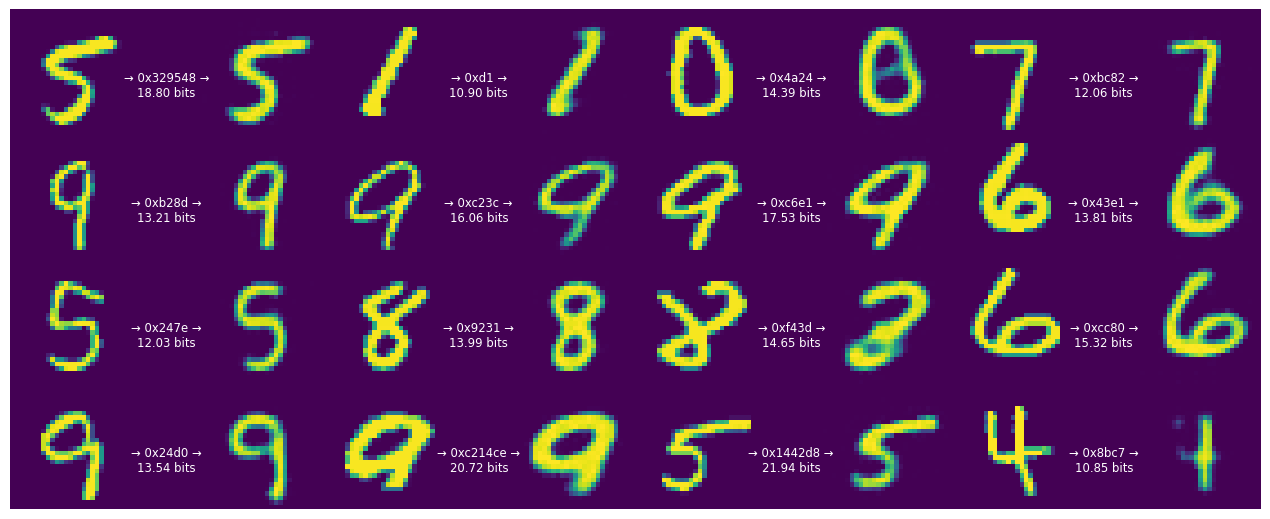

In [25]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

train_and_visualize_model(lmbda=500)


The bit rate of our code goes down, as does the fidelity of the digits. However, most of the digits remain recognizable.

Let's reduce $\lambda$ further.

Epoch 1/15


  1/469 [..............................] - ETA: 14:02 - loss: 140.1345 - distortion_loss: 0.1241 - rate_loss: 102.9071 - distortion_pass_through_loss: 0.1241 - rate_pass_through_loss: 102.9071

  4/469 [..............................] - ETA: 8s - loss: 142.1664 - distortion_loss: 0.1311 - rate_loss: 102.8384 - distortion_pass_through_loss: 0.1311 - rate_pass_through_loss: 102.8384   

  7/469 [..............................] - ETA: 8s - loss: 142.3003 - distortion_loss: 0.1319 - rate_loss: 102.7182 - distortion_pass_through_loss: 0.1319 - rate_pass_through_loss: 102.7182

 10/469 [..............................] - ETA: 8s - loss: 142.2635 - distortion_loss: 0.1322 - rate_loss: 102.6102 - distortion_pass_through_loss: 0.1322 - rate_pass_through_loss: 102.6102

 13/469 [..............................] - ETA: 8s - loss: 141.9870 - distortion_loss: 0.1316 - rate_loss: 102.5082 - distortion_pass_through_loss: 0.1316 - rate_pass_through_loss: 102.5082

 16/469 [>.............................] - ETA: 8s - loss: 141.6514 - distortion_loss: 0.1308 - rate_loss: 102.4021 - distortion_pass_through_loss: 0.1308 - rate_pass_through_loss: 102.4021

 19/469 [>.............................] - ETA: 8s - loss: 141.4325 - distortion_loss: 0.1304 - rate_loss: 102.3055 - distortion_pass_through_loss: 0.1304 - rate_pass_through_loss: 102.3055

 22/469 [>.............................] - ETA: 8s - loss: 141.2769 - distortion_loss: 0.1302 - rate_loss: 102.2227 - distortion_pass_through_loss: 0.1302 - rate_pass_through_loss: 102.2227

 25/469 [>.............................] - ETA: 8s - loss: 140.9397 - distortion_loss: 0.1294 - rate_loss: 102.1280 - distortion_pass_through_loss: 0.1294 - rate_pass_through_loss: 102.1280

 28/469 [>.............................] - ETA: 8s - loss: 140.7979 - distortion_loss: 0.1292 - rate_loss: 102.0332 - distortion_pass_through_loss: 0.1292 - rate_pass_through_loss: 102.0332

 31/469 [>.............................] - ETA: 8s - loss: 140.5287 - distortion_loss: 0.1286 - rate_loss: 101.9480 - distortion_pass_through_loss: 0.1286 - rate_pass_through_loss: 101.9480

 34/469 [=>............................] - ETA: 8s - loss: 140.2651 - distortion_loss: 0.1280 - rate_loss: 101.8631 - distortion_pass_through_loss: 0.1280 - rate_pass_through_loss: 101.8631

 37/469 [=>............................] - ETA: 8s - loss: 139.9294 - distortion_loss: 0.1272 - rate_loss: 101.7775 - distortion_pass_through_loss: 0.1272 - rate_pass_through_loss: 101.7775

 40/469 [=>............................] - ETA: 8s - loss: 139.6214 - distortion_loss: 0.1264 - rate_loss: 101.6888 - distortion_pass_through_loss: 0.1264 - rate_pass_through_loss: 101.6888

 43/469 [=>............................] - ETA: 8s - loss: 139.4008 - distortion_loss: 0.1260 - rate_loss: 101.6018 - distortion_pass_through_loss: 0.1260 - rate_pass_through_loss: 101.6018

 46/469 [=>............................] - ETA: 7s - loss: 139.1474 - distortion_loss: 0.1254 - rate_loss: 101.5205 - distortion_pass_through_loss: 0.1254 - rate_pass_through_loss: 101.5205

 49/469 [==>...........................] - ETA: 7s - loss: 138.9149 - distortion_loss: 0.1249 - rate_loss: 101.4469 - distortion_pass_through_loss: 0.1249 - rate_pass_through_loss: 101.4469

 52/469 [==>...........................] - ETA: 7s - loss: 138.6312 - distortion_loss: 0.1242 - rate_loss: 101.3855 - distortion_pass_through_loss: 0.1242 - rate_pass_through_loss: 101.3855

 55/469 [==>...........................] - ETA: 7s - loss: 138.3014 - distortion_loss: 0.1232 - rate_loss: 101.3393 - distortion_pass_through_loss: 0.1232 - rate_pass_through_loss: 101.3393

 58/469 [==>...........................] - ETA: 7s - loss: 137.9887 - distortion_loss: 0.1224 - rate_loss: 101.2781 - distortion_pass_through_loss: 0.1224 - rate_pass_through_loss: 101.2781

 61/469 [==>...........................] - ETA: 7s - loss: 137.6629 - distortion_loss: 0.1215 - rate_loss: 101.2114 - distortion_pass_through_loss: 0.1215 - rate_pass_through_loss: 101.2114

 64/469 [===>..........................] - ETA: 7s - loss: 137.3481 - distortion_loss: 0.1207 - rate_loss: 101.1433 - distortion_pass_through_loss: 0.1207 - rate_pass_through_loss: 101.1433

 67/469 [===>..........................] - ETA: 7s - loss: 137.0061 - distortion_loss: 0.1198 - rate_loss: 101.0793 - distortion_pass_through_loss: 0.1198 - rate_pass_through_loss: 101.0793

 70/469 [===>..........................] - ETA: 7s - loss: 136.6512 - distortion_loss: 0.1188 - rate_loss: 101.0153 - distortion_pass_through_loss: 0.1188 - rate_pass_through_loss: 101.0153

 73/469 [===>..........................] - ETA: 7s - loss: 136.2715 - distortion_loss: 0.1177 - rate_loss: 100.9483 - distortion_pass_through_loss: 0.1177 - rate_pass_through_loss: 100.9483

 76/469 [===>..........................] - ETA: 7s - loss: 135.9414 - distortion_loss: 0.1169 - rate_loss: 100.8848 - distortion_pass_through_loss: 0.1169 - rate_pass_through_loss: 100.8848

 79/469 [====>.........................] - ETA: 7s - loss: 135.5845 - distortion_loss: 0.1159 - rate_loss: 100.8216 - distortion_pass_through_loss: 0.1159 - rate_pass_through_loss: 100.8216

 82/469 [====>.........................] - ETA: 7s - loss: 135.2464 - distortion_loss: 0.1150 - rate_loss: 100.7573 - distortion_pass_through_loss: 0.1150 - rate_pass_through_loss: 100.7573

 85/469 [====>.........................] - ETA: 7s - loss: 134.8907 - distortion_loss: 0.1140 - rate_loss: 100.6978 - distortion_pass_through_loss: 0.1140 - rate_pass_through_loss: 100.6978

 88/469 [====>.........................] - ETA: 7s - loss: 134.5498 - distortion_loss: 0.1130 - rate_loss: 100.6398 - distortion_pass_through_loss: 0.1130 - rate_pass_through_loss: 100.6398

 91/469 [====>.........................] - ETA: 7s - loss: 134.1984 - distortion_loss: 0.1121 - rate_loss: 100.5789 - distortion_pass_through_loss: 0.1121 - rate_pass_through_loss: 100.5789

 94/469 [=====>........................] - ETA: 7s - loss: 133.8812 - distortion_loss: 0.1112 - rate_loss: 100.5155 - distortion_pass_through_loss: 0.1112 - rate_pass_through_loss: 100.5155

 97/469 [=====>........................] - ETA: 6s - loss: 133.5478 - distortion_loss: 0.1103 - rate_loss: 100.4533 - distortion_pass_through_loss: 0.1103 - rate_pass_through_loss: 100.4533

100/469 [=====>........................] - ETA: 6s - loss: 133.2536 - distortion_loss: 0.1095 - rate_loss: 100.3931 - distortion_pass_through_loss: 0.1095 - rate_pass_through_loss: 100.3931

103/469 [=====>........................] - ETA: 6s - loss: 132.9566 - distortion_loss: 0.1088 - rate_loss: 100.3307 - distortion_pass_through_loss: 0.1088 - rate_pass_through_loss: 100.3307

106/469 [=====>........................] - ETA: 6s - loss: 132.6452 - distortion_loss: 0.1079 - rate_loss: 100.2656 - distortion_pass_through_loss: 0.1079 - rate_pass_through_loss: 100.2656

109/469 [=====>........................] - ETA: 6s - loss: 132.3420 - distortion_loss: 0.1071 - rate_loss: 100.1977 - distortion_pass_through_loss: 0.1071 - rate_pass_through_loss: 100.1977

112/469 [======>.......................] - ETA: 6s - loss: 132.0694 - distortion_loss: 0.1064 - rate_loss: 100.1367 - distortion_pass_through_loss: 0.1064 - rate_pass_through_loss: 100.1367

115/469 [======>.......................] - ETA: 6s - loss: 131.8118 - distortion_loss: 0.1058 - rate_loss: 100.0709 - distortion_pass_through_loss: 0.1058 - rate_pass_through_loss: 100.0709

118/469 [======>.......................] - ETA: 6s - loss: 131.5206 - distortion_loss: 0.1051 - rate_loss: 100.0029 - distortion_pass_through_loss: 0.1051 - rate_pass_through_loss: 100.0029

121/469 [======>.......................] - ETA: 6s - loss: 131.2459 - distortion_loss: 0.1044 - rate_loss: 99.9393 - distortion_pass_through_loss: 0.1044 - rate_pass_through_loss: 99.9393  

124/469 [======>.......................] - ETA: 6s - loss: 130.9765 - distortion_loss: 0.1037 - rate_loss: 99.8727 - distortion_pass_through_loss: 0.1037 - rate_pass_through_loss: 99.8727

127/469 [=======>......................] - ETA: 6s - loss: 130.7041 - distortion_loss: 0.1030 - rate_loss: 99.8083 - distortion_pass_through_loss: 0.1030 - rate_pass_through_loss: 99.8083

130/469 [=======>......................] - ETA: 6s - loss: 130.4371 - distortion_loss: 0.1023 - rate_loss: 99.7389 - distortion_pass_through_loss: 0.1023 - rate_pass_through_loss: 99.7389

133/469 [=======>......................] - ETA: 6s - loss: 130.1687 - distortion_loss: 0.1017 - rate_loss: 99.6689 - distortion_pass_through_loss: 0.1017 - rate_pass_through_loss: 99.6689

136/469 [=======>......................] - ETA: 6s - loss: 129.9211 - distortion_loss: 0.1011 - rate_loss: 99.6008 - distortion_pass_through_loss: 0.1011 - rate_pass_through_loss: 99.6008

139/469 [=======>......................] - ETA: 6s - loss: 129.6861 - distortion_loss: 0.1005 - rate_loss: 99.5327 - distortion_pass_through_loss: 0.1005 - rate_pass_through_loss: 99.5327

142/469 [========>.....................] - ETA: 6s - loss: 129.4417 - distortion_loss: 0.0999 - rate_loss: 99.4647 - distortion_pass_through_loss: 0.0999 - rate_pass_through_loss: 99.4647

145/469 [========>.....................] - ETA: 6s - loss: 129.2108 - distortion_loss: 0.0994 - rate_loss: 99.3956 - distortion_pass_through_loss: 0.0994 - rate_pass_through_loss: 99.3956

148/469 [========>.....................] - ETA: 5s - loss: 128.9849 - distortion_loss: 0.0989 - rate_loss: 99.3260 - distortion_pass_through_loss: 0.0989 - rate_pass_through_loss: 99.3260

151/469 [========>.....................] - ETA: 5s - loss: 128.7576 - distortion_loss: 0.0983 - rate_loss: 99.2567 - distortion_pass_through_loss: 0.0983 - rate_pass_through_loss: 99.2567

154/469 [========>.....................] - ETA: 5s - loss: 128.5467 - distortion_loss: 0.0979 - rate_loss: 99.1898 - distortion_pass_through_loss: 0.0979 - rate_pass_through_loss: 99.1898

157/469 [=========>....................] - ETA: 5s - loss: 128.3311 - distortion_loss: 0.0974 - rate_loss: 99.1224 - distortion_pass_through_loss: 0.0974 - rate_pass_through_loss: 99.1224

160/469 [=========>....................] - ETA: 5s - loss: 128.1222 - distortion_loss: 0.0969 - rate_loss: 99.0523 - distortion_pass_through_loss: 0.0969 - rate_pass_through_loss: 99.0523

163/469 [=========>....................] - ETA: 5s - loss: 127.9024 - distortion_loss: 0.0964 - rate_loss: 98.9808 - distortion_pass_through_loss: 0.0964 - rate_pass_through_loss: 98.9808

166/469 [=========>....................] - ETA: 5s - loss: 127.6936 - distortion_loss: 0.0959 - rate_loss: 98.9091 - distortion_pass_through_loss: 0.0959 - rate_pass_through_loss: 98.9091

169/469 [=========>....................] - ETA: 5s - loss: 127.4899 - distortion_loss: 0.0955 - rate_loss: 98.8372 - distortion_pass_through_loss: 0.0955 - rate_pass_through_loss: 98.8372

172/469 [==========>...................] - ETA: 5s - loss: 127.2805 - distortion_loss: 0.0950 - rate_loss: 98.7660 - distortion_pass_through_loss: 0.0950 - rate_pass_through_loss: 98.7660

175/469 [==========>...................] - ETA: 5s - loss: 127.0859 - distortion_loss: 0.0946 - rate_loss: 98.6951 - distortion_pass_through_loss: 0.0946 - rate_pass_through_loss: 98.6951

178/469 [==========>...................] - ETA: 5s - loss: 126.8857 - distortion_loss: 0.0942 - rate_loss: 98.6233 - distortion_pass_through_loss: 0.0942 - rate_pass_through_loss: 98.6233

181/469 [==========>...................] - ETA: 5s - loss: 126.6942 - distortion_loss: 0.0938 - rate_loss: 98.5531 - distortion_pass_through_loss: 0.0938 - rate_pass_through_loss: 98.5531

184/469 [==========>...................] - ETA: 5s - loss: 126.5041 - distortion_loss: 0.0934 - rate_loss: 98.4795 - distortion_pass_through_loss: 0.0934 - rate_pass_through_loss: 98.4795

187/469 [==========>...................] - ETA: 5s - loss: 126.3092 - distortion_loss: 0.0930 - rate_loss: 98.4053 - distortion_pass_through_loss: 0.0930 - rate_pass_through_loss: 98.4053

190/469 [===========>..................] - ETA: 5s - loss: 126.1275 - distortion_loss: 0.0926 - rate_loss: 98.3329 - distortion_pass_through_loss: 0.0926 - rate_pass_through_loss: 98.3329

193/469 [===========>..................] - ETA: 5s - loss: 125.9463 - distortion_loss: 0.0923 - rate_loss: 98.2590 - distortion_pass_through_loss: 0.0923 - rate_pass_through_loss: 98.2590

196/469 [===========>..................] - ETA: 5s - loss: 125.7607 - distortion_loss: 0.0919 - rate_loss: 98.1880 - distortion_pass_through_loss: 0.0919 - rate_pass_through_loss: 98.1880

199/469 [===========>..................] - ETA: 5s - loss: 125.5724 - distortion_loss: 0.0915 - rate_loss: 98.1142 - distortion_pass_through_loss: 0.0915 - rate_pass_through_loss: 98.1142

202/469 [===========>..................] - ETA: 4s - loss: 125.3914 - distortion_loss: 0.0912 - rate_loss: 98.0381 - distortion_pass_through_loss: 0.0912 - rate_pass_through_loss: 98.0381

205/469 [============>.................] - ETA: 4s - loss: 125.2110 - distortion_loss: 0.0908 - rate_loss: 97.9658 - distortion_pass_through_loss: 0.0908 - rate_pass_through_loss: 97.9658

208/469 [============>.................] - ETA: 4s - loss: 125.0295 - distortion_loss: 0.0905 - rate_loss: 97.8901 - distortion_pass_through_loss: 0.0905 - rate_pass_through_loss: 97.8901

211/469 [============>.................] - ETA: 4s - loss: 124.8456 - distortion_loss: 0.0901 - rate_loss: 97.8165 - distortion_pass_through_loss: 0.0901 - rate_pass_through_loss: 97.8165

214/469 [============>.................] - ETA: 4s - loss: 124.6724 - distortion_loss: 0.0898 - rate_loss: 97.7419 - distortion_pass_through_loss: 0.0898 - rate_pass_through_loss: 97.7419

217/469 [============>.................] - ETA: 4s - loss: 124.5007 - distortion_loss: 0.0894 - rate_loss: 97.6666 - distortion_pass_through_loss: 0.0894 - rate_pass_through_loss: 97.6666

220/469 [=============>................] - ETA: 4s - loss: 124.3318 - distortion_loss: 0.0891 - rate_loss: 97.5925 - distortion_pass_through_loss: 0.0891 - rate_pass_through_loss: 97.5925

223/469 [=============>................] - ETA: 4s - loss: 124.1649 - distortion_loss: 0.0888 - rate_loss: 97.5166 - distortion_pass_through_loss: 0.0888 - rate_pass_through_loss: 97.5166

226/469 [=============>................] - ETA: 4s - loss: 123.9897 - distortion_loss: 0.0885 - rate_loss: 97.4399 - distortion_pass_through_loss: 0.0885 - rate_pass_through_loss: 97.4399

229/469 [=============>................] - ETA: 4s - loss: 123.8291 - distortion_loss: 0.0882 - rate_loss: 97.3678 - distortion_pass_through_loss: 0.0882 - rate_pass_through_loss: 97.3678

232/469 [=============>................] - ETA: 4s - loss: 123.6685 - distortion_loss: 0.0879 - rate_loss: 97.2916 - distortion_pass_through_loss: 0.0879 - rate_pass_through_loss: 97.2916

235/469 [==============>...............] - ETA: 4s - loss: 123.5052 - distortion_loss: 0.0876 - rate_loss: 97.2149 - distortion_pass_through_loss: 0.0876 - rate_pass_through_loss: 97.2149

238/469 [==============>...............] - ETA: 4s - loss: 123.3432 - distortion_loss: 0.0874 - rate_loss: 97.1376 - distortion_pass_through_loss: 0.0874 - rate_pass_through_loss: 97.1376

241/469 [==============>...............] - ETA: 4s - loss: 123.1834 - distortion_loss: 0.0871 - rate_loss: 97.0597 - distortion_pass_through_loss: 0.0871 - rate_pass_through_loss: 97.0597

244/469 [==============>...............] - ETA: 4s - loss: 123.0196 - distortion_loss: 0.0868 - rate_loss: 96.9852 - distortion_pass_through_loss: 0.0868 - rate_pass_through_loss: 96.9852

247/469 [==============>...............] - ETA: 4s - loss: 122.8730 - distortion_loss: 0.0865 - rate_loss: 96.9085 - distortion_pass_through_loss: 0.0865 - rate_pass_through_loss: 96.9085

250/469 [==============>...............] - ETA: 4s - loss: 122.7197 - distortion_loss: 0.0863 - rate_loss: 96.8325 - distortion_pass_through_loss: 0.0863 - rate_pass_through_loss: 96.8325

253/469 [===============>..............] - ETA: 4s - loss: 122.5662 - distortion_loss: 0.0860 - rate_loss: 96.7538 - distortion_pass_through_loss: 0.0860 - rate_pass_through_loss: 96.7538

256/469 [===============>..............] - ETA: 3s - loss: 122.4100 - distortion_loss: 0.0858 - rate_loss: 96.6768 - distortion_pass_through_loss: 0.0858 - rate_pass_through_loss: 96.6768

259/469 [===============>..............] - ETA: 3s - loss: 122.2584 - distortion_loss: 0.0855 - rate_loss: 96.6012 - distortion_pass_through_loss: 0.0855 - rate_pass_through_loss: 96.6012

262/469 [===============>..............] - ETA: 3s - loss: 122.1074 - distortion_loss: 0.0853 - rate_loss: 96.5254 - distortion_pass_through_loss: 0.0853 - rate_pass_through_loss: 96.5254

265/469 [===============>..............] - ETA: 3s - loss: 121.9578 - distortion_loss: 0.0850 - rate_loss: 96.4482 - distortion_pass_through_loss: 0.0850 - rate_pass_through_loss: 96.4482

268/469 [================>.............] - ETA: 3s - loss: 121.8093 - distortion_loss: 0.0848 - rate_loss: 96.3717 - distortion_pass_through_loss: 0.0848 - rate_pass_through_loss: 96.3717

271/469 [================>.............] - ETA: 3s - loss: 121.6634 - distortion_loss: 0.0846 - rate_loss: 96.2934 - distortion_pass_through_loss: 0.0846 - rate_pass_through_loss: 96.2934

274/469 [================>.............] - ETA: 3s - loss: 121.5214 - distortion_loss: 0.0844 - rate_loss: 96.2161 - distortion_pass_through_loss: 0.0844 - rate_pass_through_loss: 96.2161

277/469 [================>.............] - ETA: 3s - loss: 121.3767 - distortion_loss: 0.0841 - rate_loss: 96.1393 - distortion_pass_through_loss: 0.0841 - rate_pass_through_loss: 96.1393

280/469 [================>.............] - ETA: 3s - loss: 121.2295 - distortion_loss: 0.0839 - rate_loss: 96.0610 - distortion_pass_through_loss: 0.0839 - rate_pass_through_loss: 96.0610

283/469 [=================>............] - ETA: 3s - loss: 121.0942 - distortion_loss: 0.0837 - rate_loss: 95.9841 - distortion_pass_through_loss: 0.0837 - rate_pass_through_loss: 95.9841

286/469 [=================>............] - ETA: 3s - loss: 120.9553 - distortion_loss: 0.0835 - rate_loss: 95.9078 - distortion_pass_through_loss: 0.0835 - rate_pass_through_loss: 95.9078

289/469 [=================>............] - ETA: 3s - loss: 120.8159 - distortion_loss: 0.0833 - rate_loss: 95.8300 - distortion_pass_through_loss: 0.0833 - rate_pass_through_loss: 95.8300

292/469 [=================>............] - ETA: 3s - loss: 120.6737 - distortion_loss: 0.0831 - rate_loss: 95.7525 - distortion_pass_through_loss: 0.0831 - rate_pass_through_loss: 95.7525

295/469 [=================>............] - ETA: 3s - loss: 120.5336 - distortion_loss: 0.0829 - rate_loss: 95.6733 - distortion_pass_through_loss: 0.0829 - rate_pass_through_loss: 95.6733

298/469 [==================>...........] - ETA: 3s - loss: 120.3916 - distortion_loss: 0.0827 - rate_loss: 95.5953 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 95.5953

301/469 [==================>...........] - ETA: 3s - loss: 120.2601 - distortion_loss: 0.0825 - rate_loss: 95.5172 - distortion_pass_through_loss: 0.0825 - rate_pass_through_loss: 95.5172

304/469 [==================>...........] - ETA: 3s - loss: 120.1207 - distortion_loss: 0.0823 - rate_loss: 95.4382 - distortion_pass_through_loss: 0.0823 - rate_pass_through_loss: 95.4382

307/469 [==================>...........] - ETA: 3s - loss: 119.9880 - distortion_loss: 0.0821 - rate_loss: 95.3605 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 95.3605

310/469 [==================>...........] - ETA: 2s - loss: 119.8572 - distortion_loss: 0.0819 - rate_loss: 95.2832 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 95.2832

313/469 [===================>..........] - ETA: 2s - loss: 119.7233 - distortion_loss: 0.0817 - rate_loss: 95.2042 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 95.2042

316/469 [===================>..........] - ETA: 2s - loss: 119.5898 - distortion_loss: 0.0815 - rate_loss: 95.1259 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 95.1259

319/469 [===================>..........] - ETA: 2s - loss: 119.4573 - distortion_loss: 0.0814 - rate_loss: 95.0458 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 95.0458

322/469 [===================>..........] - ETA: 2s - loss: 119.3263 - distortion_loss: 0.0812 - rate_loss: 94.9678 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 94.9678

325/469 [===================>..........] - ETA: 2s - loss: 119.1928 - distortion_loss: 0.0810 - rate_loss: 94.8877 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 94.8877

328/469 [===================>..........] - ETA: 2s - loss: 119.0661 - distortion_loss: 0.0809 - rate_loss: 94.8100 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 94.8100

331/469 [====================>.........] - ETA: 2s - loss: 118.9361 - distortion_loss: 0.0807 - rate_loss: 94.7318 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 94.7318

334/469 [====================>.........] - ETA: 2s - loss: 118.8094 - distortion_loss: 0.0805 - rate_loss: 94.6531 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 94.6531

337/469 [====================>.........] - ETA: 2s - loss: 118.6825 - distortion_loss: 0.0804 - rate_loss: 94.5745 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 94.5745

340/469 [====================>.........] - ETA: 2s - loss: 118.5545 - distortion_loss: 0.0802 - rate_loss: 94.4954 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 94.4954

343/469 [====================>.........] - ETA: 2s - loss: 118.4272 - distortion_loss: 0.0800 - rate_loss: 94.4170 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 94.4170

346/469 [=====================>........] - ETA: 2s - loss: 118.2985 - distortion_loss: 0.0799 - rate_loss: 94.3375 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 94.3375

349/469 [=====================>........] - ETA: 2s - loss: 118.1773 - distortion_loss: 0.0797 - rate_loss: 94.2604 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 94.2604

352/469 [=====================>........] - ETA: 2s - loss: 118.0545 - distortion_loss: 0.0796 - rate_loss: 94.1801 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 94.1801

355/469 [=====================>........] - ETA: 2s - loss: 117.9298 - distortion_loss: 0.0794 - rate_loss: 94.1014 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 94.1014

358/469 [=====================>........] - ETA: 2s - loss: 117.8053 - distortion_loss: 0.0793 - rate_loss: 94.0207 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 94.0207

361/469 [======================>.......] - ETA: 2s - loss: 117.6864 - distortion_loss: 0.0791 - rate_loss: 93.9427 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 93.9427

364/469 [======================>.......] - ETA: 1s - loss: 117.5659 - distortion_loss: 0.0790 - rate_loss: 93.8641 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 93.8641

367/469 [======================>.......] - ETA: 1s - loss: 117.4448 - distortion_loss: 0.0789 - rate_loss: 93.7847 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 93.7847

370/469 [======================>.......] - ETA: 1s - loss: 117.3213 - distortion_loss: 0.0787 - rate_loss: 93.7041 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 93.7041

373/469 [======================>.......] - ETA: 1s - loss: 117.2003 - distortion_loss: 0.0786 - rate_loss: 93.6246 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 93.6246

376/469 [=======================>......] - ETA: 1s - loss: 117.0786 - distortion_loss: 0.0784 - rate_loss: 93.5442 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 93.5442

379/469 [=======================>......] - ETA: 1s - loss: 116.9591 - distortion_loss: 0.0783 - rate_loss: 93.4658 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 93.4658

382/469 [=======================>......] - ETA: 1s - loss: 116.8392 - distortion_loss: 0.0782 - rate_loss: 93.3863 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 93.3863

385/469 [=======================>......] - ETA: 1s - loss: 116.7176 - distortion_loss: 0.0780 - rate_loss: 93.3075 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 93.3075

388/469 [=======================>......] - ETA: 1s - loss: 116.6023 - distortion_loss: 0.0779 - rate_loss: 93.2281 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 93.2281

391/469 [========================>.....] - ETA: 1s - loss: 116.4825 - distortion_loss: 0.0778 - rate_loss: 93.1478 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 93.1478

394/469 [========================>.....] - ETA: 1s - loss: 116.3672 - distortion_loss: 0.0777 - rate_loss: 93.0694 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 93.0694

397/469 [========================>.....] - ETA: 1s - loss: 116.2505 - distortion_loss: 0.0775 - rate_loss: 92.9904 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 92.9904

400/469 [========================>.....] - ETA: 1s - loss: 116.1330 - distortion_loss: 0.0774 - rate_loss: 92.9112 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 92.9112

403/469 [========================>.....] - ETA: 1s - loss: 116.0110 - distortion_loss: 0.0773 - rate_loss: 92.8301 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 92.8301

406/469 [========================>.....] - ETA: 1s - loss: 115.8966 - distortion_loss: 0.0772 - rate_loss: 92.7505 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 92.7505

409/469 [=========================>....] - ETA: 1s - loss: 115.7807 - distortion_loss: 0.0770 - rate_loss: 92.6699 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 92.6699

412/469 [=========================>....] - ETA: 1s - loss: 115.6700 - distortion_loss: 0.0769 - rate_loss: 92.5917 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 92.5917

415/469 [=========================>....] - ETA: 1s - loss: 115.5576 - distortion_loss: 0.0768 - rate_loss: 92.5121 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 92.5121

418/469 [=========================>....] - ETA: 0s - loss: 115.4430 - distortion_loss: 0.0767 - rate_loss: 92.4325 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 92.4325

421/469 [=========================>....] - ETA: 0s - loss: 115.3283 - distortion_loss: 0.0766 - rate_loss: 92.3529 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 92.3529

424/469 [==========================>...] - ETA: 0s - loss: 115.2145 - distortion_loss: 0.0765 - rate_loss: 92.2747 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 92.2747

427/469 [==========================>...] - ETA: 0s - loss: 115.1038 - distortion_loss: 0.0764 - rate_loss: 92.1944 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 92.1944

430/469 [==========================>...] - ETA: 0s - loss: 114.9949 - distortion_loss: 0.0763 - rate_loss: 92.1148 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 92.1148

433/469 [==========================>...] - ETA: 0s - loss: 114.8830 - distortion_loss: 0.0762 - rate_loss: 92.0350 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 92.0350

436/469 [==========================>...] - ETA: 0s - loss: 114.7701 - distortion_loss: 0.0760 - rate_loss: 91.9562 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 91.9562

439/469 [===========================>..] - ETA: 0s - loss: 114.6591 - distortion_loss: 0.0759 - rate_loss: 91.8774 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 91.8774

442/469 [===========================>..] - ETA: 0s - loss: 114.5508 - distortion_loss: 0.0758 - rate_loss: 91.7978 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 91.7978

445/469 [===========================>..] - ETA: 0s - loss: 114.4392 - distortion_loss: 0.0757 - rate_loss: 91.7182 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 91.7182

448/469 [===========================>..] - ETA: 0s - loss: 114.3314 - distortion_loss: 0.0756 - rate_loss: 91.6385 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 91.6385

451/469 [===========================>..] - ETA: 0s - loss: 114.2229 - distortion_loss: 0.0755 - rate_loss: 91.5599 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 91.5599

454/469 [============================>.] - ETA: 0s - loss: 114.1151 - distortion_loss: 0.0755 - rate_loss: 91.4800 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 91.4800

457/469 [============================>.] - ETA: 0s - loss: 114.0076 - distortion_loss: 0.0754 - rate_loss: 91.4017 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 91.4017

460/469 [============================>.] - ETA: 0s - loss: 113.9001 - distortion_loss: 0.0753 - rate_loss: 91.3226 - distortion_pass_through_loss: 0.0753 - rate_pass_through_loss: 91.3226

463/469 [============================>.] - ETA: 0s - loss: 113.7930 - distortion_loss: 0.0752 - rate_loss: 91.2434 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 91.2434

466/469 [============================>.] - ETA: 0s - loss: 113.6882 - distortion_loss: 0.0751 - rate_loss: 91.1647 - distortion_pass_through_loss: 0.0751 - rate_pass_through_loss: 91.1647

469/469 [==============================] - ETA: 0s - loss: 113.5871 - distortion_loss: 0.0750 - rate_loss: 91.0911 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 91.0843

469/469 [==============================] - 11s 20ms/step - loss: 113.5871 - distortion_loss: 0.0750 - rate_loss: 91.0911 - distortion_pass_through_loss: 0.0750 - rate_pass_through_loss: 91.0843 - val_loss: 96.3590 - val_distortion_loss: 0.0666 - val_rate_loss: 76.3773 - val_distortion_pass_through_loss: 0.0666 - val_rate_pass_through_loss: 76.3787


Epoch 2/15


  1/469 [..............................] - ETA: 9s - loss: 95.5940 - distortion_loss: 0.0565 - rate_loss: 78.6558 - distortion_pass_through_loss: 0.0565 - rate_pass_through_loss: 78.6558

  4/469 [..............................] - ETA: 8s - loss: 96.5765 - distortion_loss: 0.0599 - rate_loss: 78.6000 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 78.6000

  7/469 [..............................] - ETA: 8s - loss: 96.7520 - distortion_loss: 0.0607 - rate_loss: 78.5338 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 78.5338

 10/469 [..............................] - ETA: 8s - loss: 96.8254 - distortion_loss: 0.0611 - rate_loss: 78.4908 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 78.4908

 13/469 [..............................] - ETA: 8s - loss: 96.6616 - distortion_loss: 0.0610 - rate_loss: 78.3486 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 78.3486

 16/469 [>.............................] - ETA: 8s - loss: 96.5684 - distortion_loss: 0.0610 - rate_loss: 78.2777 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 78.2777

 19/469 [>.............................] - ETA: 8s - loss: 96.5180 - distortion_loss: 0.0611 - rate_loss: 78.1755 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 78.1755

 22/469 [>.............................] - ETA: 8s - loss: 96.4967 - distortion_loss: 0.0612 - rate_loss: 78.1389 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 78.1389

 25/469 [>.............................] - ETA: 8s - loss: 96.4050 - distortion_loss: 0.0612 - rate_loss: 78.0466 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 78.0466

 28/469 [>.............................] - ETA: 8s - loss: 96.3482 - distortion_loss: 0.0612 - rate_loss: 77.9787 - distortion_pass_through_loss: 0.0612 - rate_pass_through_loss: 77.9787

 31/469 [>.............................] - ETA: 8s - loss: 96.2323 - distortion_loss: 0.0611 - rate_loss: 77.9086 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 77.9086

 34/469 [=>............................] - ETA: 8s - loss: 96.1567 - distortion_loss: 0.0611 - rate_loss: 77.8273 - distortion_pass_through_loss: 0.0611 - rate_pass_through_loss: 77.8273

 37/469 [=>............................] - ETA: 8s - loss: 96.0139 - distortion_loss: 0.0609 - rate_loss: 77.7398 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 77.7398

 40/469 [=>............................] - ETA: 8s - loss: 95.9258 - distortion_loss: 0.0609 - rate_loss: 77.6662 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 77.6662

 43/469 [=>............................] - ETA: 7s - loss: 95.8334 - distortion_loss: 0.0608 - rate_loss: 77.5818 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.5818

 46/469 [=>............................] - ETA: 7s - loss: 95.7270 - distortion_loss: 0.0608 - rate_loss: 77.5008 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.5008

 49/469 [==>...........................] - ETA: 7s - loss: 95.6683 - distortion_loss: 0.0608 - rate_loss: 77.4192 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.4192

 52/469 [==>...........................] - ETA: 7s - loss: 95.6117 - distortion_loss: 0.0609 - rate_loss: 77.3414 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 77.3414

 55/469 [==>...........................] - ETA: 7s - loss: 95.5246 - distortion_loss: 0.0608 - rate_loss: 77.2793 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.2793

 58/469 [==>...........................] - ETA: 7s - loss: 95.4455 - distortion_loss: 0.0608 - rate_loss: 77.2102 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.2102

 61/469 [==>...........................] - ETA: 7s - loss: 95.3718 - distortion_loss: 0.0608 - rate_loss: 77.1247 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 77.1247

 64/469 [===>..........................] - ETA: 7s - loss: 95.3197 - distortion_loss: 0.0609 - rate_loss: 77.0440 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 77.0440

 67/469 [===>..........................] - ETA: 7s - loss: 95.2540 - distortion_loss: 0.0609 - rate_loss: 76.9724 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 76.9724

 70/469 [===>..........................] - ETA: 7s - loss: 95.1710 - distortion_loss: 0.0609 - rate_loss: 76.8997 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 76.8997

 73/469 [===>..........................] - ETA: 7s - loss: 95.0699 - distortion_loss: 0.0608 - rate_loss: 76.8196 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 76.8196

 76/469 [===>..........................] - ETA: 7s - loss: 95.0057 - distortion_loss: 0.0609 - rate_loss: 76.7398 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 76.7398

 79/469 [====>.........................] - ETA: 7s - loss: 94.9254 - distortion_loss: 0.0609 - rate_loss: 76.6631 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 76.6631

 82/469 [====>.........................] - ETA: 7s - loss: 94.8456 - distortion_loss: 0.0608 - rate_loss: 76.5932 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 76.5932

 85/469 [====>.........................] - ETA: 7s - loss: 94.7577 - distortion_loss: 0.0608 - rate_loss: 76.5141 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 76.5141

 88/469 [====>.........................] - ETA: 7s - loss: 94.6725 - distortion_loss: 0.0608 - rate_loss: 76.4474 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 76.4474

 91/469 [====>.........................] - ETA: 7s - loss: 94.5742 - distortion_loss: 0.0607 - rate_loss: 76.3625 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.3625

 94/469 [=====>........................] - ETA: 7s - loss: 94.4953 - distortion_loss: 0.0607 - rate_loss: 76.2888 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.2888

 97/469 [=====>........................] - ETA: 7s - loss: 94.4030 - distortion_loss: 0.0607 - rate_loss: 76.2041 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.2041

100/469 [=====>........................] - ETA: 6s - loss: 94.3375 - distortion_loss: 0.0607 - rate_loss: 76.1358 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.1358

103/469 [=====>........................] - ETA: 6s - loss: 94.2679 - distortion_loss: 0.0607 - rate_loss: 76.0622 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 76.0622

106/469 [=====>........................] - ETA: 6s - loss: 94.1751 - distortion_loss: 0.0606 - rate_loss: 75.9877 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.9877

109/469 [=====>........................] - ETA: 6s - loss: 94.0913 - distortion_loss: 0.0606 - rate_loss: 75.9113 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.9113

112/469 [======>.......................] - ETA: 6s - loss: 94.0196 - distortion_loss: 0.0606 - rate_loss: 75.8361 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.8361

115/469 [======>.......................] - ETA: 6s - loss: 93.9656 - distortion_loss: 0.0607 - rate_loss: 75.7688 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 75.7688

118/469 [======>.......................] - ETA: 6s - loss: 93.8782 - distortion_loss: 0.0606 - rate_loss: 75.6925 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.6925

121/469 [======>.......................] - ETA: 6s - loss: 93.8008 - distortion_loss: 0.0606 - rate_loss: 75.6164 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.6164

124/469 [======>.......................] - ETA: 6s - loss: 93.7194 - distortion_loss: 0.0606 - rate_loss: 75.5426 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 75.5426

127/469 [=======>......................] - ETA: 6s - loss: 93.6340 - distortion_loss: 0.0605 - rate_loss: 75.4705 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.4705

130/469 [=======>......................] - ETA: 6s - loss: 93.5481 - distortion_loss: 0.0605 - rate_loss: 75.3917 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.3917

133/469 [=======>......................] - ETA: 6s - loss: 93.4595 - distortion_loss: 0.0605 - rate_loss: 75.3137 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.3137

136/469 [=======>......................] - ETA: 6s - loss: 93.3803 - distortion_loss: 0.0605 - rate_loss: 75.2371 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.2371

139/469 [=======>......................] - ETA: 6s - loss: 93.3077 - distortion_loss: 0.0605 - rate_loss: 75.1632 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.1632

142/469 [========>.....................] - ETA: 6s - loss: 93.2303 - distortion_loss: 0.0605 - rate_loss: 75.0909 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 75.0909

145/469 [========>.....................] - ETA: 6s - loss: 93.1511 - distortion_loss: 0.0604 - rate_loss: 75.0171 - distortion_pass_through_loss: 0.0604 - rate_pass_through_loss: 75.0171

148/469 [========>.....................] - ETA: 6s - loss: 93.0789 - distortion_loss: 0.0605 - rate_loss: 74.9425 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.9425

151/469 [========>.....................] - ETA: 5s - loss: 93.0067 - distortion_loss: 0.0605 - rate_loss: 74.8669 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.8669

154/469 [========>.....................] - ETA: 5s - loss: 92.9422 - distortion_loss: 0.0605 - rate_loss: 74.7976 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.7976

157/469 [=========>....................] - ETA: 5s - loss: 92.8728 - distortion_loss: 0.0605 - rate_loss: 74.7215 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.7215

160/469 [=========>....................] - ETA: 5s - loss: 92.8051 - distortion_loss: 0.0605 - rate_loss: 74.6492 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.6492

163/469 [=========>....................] - ETA: 5s - loss: 92.7222 - distortion_loss: 0.0605 - rate_loss: 74.5762 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.5762

166/469 [=========>....................] - ETA: 5s - loss: 92.6489 - distortion_loss: 0.0605 - rate_loss: 74.5029 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.5029

169/469 [=========>....................] - ETA: 5s - loss: 92.5778 - distortion_loss: 0.0605 - rate_loss: 74.4279 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.4279

172/469 [==========>...................] - ETA: 5s - loss: 92.5001 - distortion_loss: 0.0605 - rate_loss: 74.3489 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.3489

175/469 [==========>...................] - ETA: 5s - loss: 92.4367 - distortion_loss: 0.0605 - rate_loss: 74.2781 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.2781

178/469 [==========>...................] - ETA: 5s - loss: 92.3629 - distortion_loss: 0.0605 - rate_loss: 74.2057 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.2057

181/469 [==========>...................] - ETA: 5s - loss: 92.2969 - distortion_loss: 0.0605 - rate_loss: 74.1375 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.1375

184/469 [==========>...................] - ETA: 5s - loss: 92.2229 - distortion_loss: 0.0605 - rate_loss: 74.0608 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 74.0608

187/469 [==========>...................] - ETA: 5s - loss: 92.1452 - distortion_loss: 0.0605 - rate_loss: 73.9840 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.9840

190/469 [===========>..................] - ETA: 5s - loss: 92.0805 - distortion_loss: 0.0606 - rate_loss: 73.9155 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.9155

193/469 [===========>..................] - ETA: 5s - loss: 92.0120 - distortion_loss: 0.0606 - rate_loss: 73.8424 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.8424

196/469 [===========>..................] - ETA: 5s - loss: 91.9420 - distortion_loss: 0.0606 - rate_loss: 73.7694 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.7694

199/469 [===========>..................] - ETA: 5s - loss: 91.8625 - distortion_loss: 0.0606 - rate_loss: 73.6942 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.6942

202/469 [===========>..................] - ETA: 5s - loss: 91.7909 - distortion_loss: 0.0606 - rate_loss: 73.6200 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.6200

205/469 [============>.................] - ETA: 4s - loss: 91.7162 - distortion_loss: 0.0606 - rate_loss: 73.5490 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.5490

208/469 [============>.................] - ETA: 4s - loss: 91.6391 - distortion_loss: 0.0606 - rate_loss: 73.4738 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 73.4738

211/469 [============>.................] - ETA: 4s - loss: 91.5596 - distortion_loss: 0.0605 - rate_loss: 73.4000 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.4000

214/469 [============>.................] - ETA: 4s - loss: 91.4855 - distortion_loss: 0.0605 - rate_loss: 73.3252 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.3252

217/469 [============>.................] - ETA: 4s - loss: 91.4137 - distortion_loss: 0.0605 - rate_loss: 73.2556 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.2556

220/469 [=============>................] - ETA: 4s - loss: 91.3426 - distortion_loss: 0.0605 - rate_loss: 73.1849 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.1849

223/469 [=============>................] - ETA: 4s - loss: 91.2701 - distortion_loss: 0.0605 - rate_loss: 73.1132 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.1132

226/469 [=============>................] - ETA: 4s - loss: 91.1945 - distortion_loss: 0.0605 - rate_loss: 73.0418 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 73.0418

229/469 [=============>................] - ETA: 4s - loss: 91.1259 - distortion_loss: 0.0605 - rate_loss: 72.9706 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.9706

232/469 [=============>................] - ETA: 4s - loss: 91.0592 - distortion_loss: 0.0605 - rate_loss: 72.9015 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.9015

235/469 [==============>...............] - ETA: 4s - loss: 90.9869 - distortion_loss: 0.0605 - rate_loss: 72.8273 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.8273

238/469 [==============>...............] - ETA: 4s - loss: 90.9179 - distortion_loss: 0.0605 - rate_loss: 72.7539 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.7539

241/469 [==============>...............] - ETA: 4s - loss: 90.8462 - distortion_loss: 0.0605 - rate_loss: 72.6835 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.6835

244/469 [==============>...............] - ETA: 4s - loss: 90.7698 - distortion_loss: 0.0605 - rate_loss: 72.6115 - distortion_pass_through_loss: 0.0605 - rate_pass_through_loss: 72.6115

247/469 [==============>...............] - ETA: 4s - loss: 90.7090 - distortion_loss: 0.0606 - rate_loss: 72.5393 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.5393

250/469 [==============>...............] - ETA: 4s - loss: 90.6435 - distortion_loss: 0.0606 - rate_loss: 72.4680 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.4680

253/469 [===============>..............] - ETA: 4s - loss: 90.5724 - distortion_loss: 0.0606 - rate_loss: 72.3984 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.3984

256/469 [===============>..............] - ETA: 4s - loss: 90.5011 - distortion_loss: 0.0606 - rate_loss: 72.3269 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.3269

259/469 [===============>..............] - ETA: 3s - loss: 90.4328 - distortion_loss: 0.0606 - rate_loss: 72.2560 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.2560

262/469 [===============>..............] - ETA: 3s - loss: 90.3643 - distortion_loss: 0.0606 - rate_loss: 72.1863 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.1863

265/469 [===============>..............] - ETA: 3s - loss: 90.2926 - distortion_loss: 0.0606 - rate_loss: 72.1146 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.1146

268/469 [================>.............] - ETA: 3s - loss: 90.2223 - distortion_loss: 0.0606 - rate_loss: 72.0442 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 72.0442

271/469 [================>.............] - ETA: 3s - loss: 90.1564 - distortion_loss: 0.0606 - rate_loss: 71.9745 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.9745

274/469 [================>.............] - ETA: 3s - loss: 90.0908 - distortion_loss: 0.0606 - rate_loss: 71.9046 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.9046

277/469 [================>.............] - ETA: 3s - loss: 90.0241 - distortion_loss: 0.0606 - rate_loss: 71.8365 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.8365

280/469 [================>.............] - ETA: 3s - loss: 89.9535 - distortion_loss: 0.0606 - rate_loss: 71.7647 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.7647

283/469 [=================>............] - ETA: 3s - loss: 89.8945 - distortion_loss: 0.0607 - rate_loss: 71.6952 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.6952

286/469 [=================>............] - ETA: 3s - loss: 89.8256 - distortion_loss: 0.0607 - rate_loss: 71.6280 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.6280

289/469 [=================>............] - ETA: 3s - loss: 89.7581 - distortion_loss: 0.0607 - rate_loss: 71.5581 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.5581

292/469 [=================>............] - ETA: 3s - loss: 89.6862 - distortion_loss: 0.0607 - rate_loss: 71.4890 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.4890

295/469 [=================>............] - ETA: 3s - loss: 89.6120 - distortion_loss: 0.0607 - rate_loss: 71.4156 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.4156

298/469 [==================>...........] - ETA: 3s - loss: 89.5393 - distortion_loss: 0.0606 - rate_loss: 71.3454 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 71.3454

301/469 [==================>...........] - ETA: 3s - loss: 89.4735 - distortion_loss: 0.0607 - rate_loss: 71.2763 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.2763

304/469 [==================>...........] - ETA: 3s - loss: 89.4002 - distortion_loss: 0.0607 - rate_loss: 71.2045 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.2045

307/469 [==================>...........] - ETA: 3s - loss: 89.3344 - distortion_loss: 0.0607 - rate_loss: 71.1358 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.1358

310/469 [==================>...........] - ETA: 2s - loss: 89.2696 - distortion_loss: 0.0607 - rate_loss: 71.0651 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 71.0651

313/469 [===================>..........] - ETA: 2s - loss: 89.2019 - distortion_loss: 0.0607 - rate_loss: 70.9953 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.9953

316/469 [===================>..........] - ETA: 2s - loss: 89.1343 - distortion_loss: 0.0607 - rate_loss: 70.9277 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.9277

319/469 [===================>..........] - ETA: 2s - loss: 89.0671 - distortion_loss: 0.0607 - rate_loss: 70.8595 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.8595

322/469 [===================>..........] - ETA: 2s - loss: 89.0021 - distortion_loss: 0.0607 - rate_loss: 70.7903 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.7903

325/469 [===================>..........] - ETA: 2s - loss: 88.9329 - distortion_loss: 0.0607 - rate_loss: 70.7221 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.7221

328/469 [===================>..........] - ETA: 2s - loss: 88.8675 - distortion_loss: 0.0607 - rate_loss: 70.6552 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.6552

331/469 [====================>.........] - ETA: 2s - loss: 88.7998 - distortion_loss: 0.0607 - rate_loss: 70.5853 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.5853

334/469 [====================>.........] - ETA: 2s - loss: 88.7346 - distortion_loss: 0.0607 - rate_loss: 70.5167 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.5167

337/469 [====================>.........] - ETA: 2s - loss: 88.6679 - distortion_loss: 0.0607 - rate_loss: 70.4484 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.4484

340/469 [====================>.........] - ETA: 2s - loss: 88.6004 - distortion_loss: 0.0607 - rate_loss: 70.3796 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.3796

343/469 [====================>.........] - ETA: 2s - loss: 88.5312 - distortion_loss: 0.0607 - rate_loss: 70.3113 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.3113

346/469 [=====================>........] - ETA: 2s - loss: 88.4596 - distortion_loss: 0.0607 - rate_loss: 70.2424 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.2424

349/469 [=====================>........] - ETA: 2s - loss: 88.3973 - distortion_loss: 0.0607 - rate_loss: 70.1748 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.1748

352/469 [=====================>........] - ETA: 2s - loss: 88.3302 - distortion_loss: 0.0607 - rate_loss: 70.1054 - distortion_pass_through_loss: 0.0607 - rate_pass_through_loss: 70.1054

355/469 [=====================>........] - ETA: 2s - loss: 88.2634 - distortion_loss: 0.0608 - rate_loss: 70.0374 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 70.0374

358/469 [=====================>........] - ETA: 2s - loss: 88.1937 - distortion_loss: 0.0608 - rate_loss: 69.9683 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.9683

361/469 [======================>.......] - ETA: 2s - loss: 88.1302 - distortion_loss: 0.0608 - rate_loss: 69.9018 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.9018

364/469 [======================>.......] - ETA: 1s - loss: 88.0658 - distortion_loss: 0.0608 - rate_loss: 69.8330 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.8330

367/469 [======================>.......] - ETA: 1s - loss: 88.0007 - distortion_loss: 0.0608 - rate_loss: 69.7651 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.7651

370/469 [======================>.......] - ETA: 1s - loss: 87.9346 - distortion_loss: 0.0608 - rate_loss: 69.6949 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.6949

373/469 [======================>.......] - ETA: 1s - loss: 87.8697 - distortion_loss: 0.0608 - rate_loss: 69.6288 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.6288

376/469 [=======================>......] - ETA: 1s - loss: 87.8019 - distortion_loss: 0.0608 - rate_loss: 69.5601 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.5601

379/469 [=======================>......] - ETA: 1s - loss: 87.7355 - distortion_loss: 0.0608 - rate_loss: 69.4914 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.4914

382/469 [=======================>......] - ETA: 1s - loss: 87.6708 - distortion_loss: 0.0608 - rate_loss: 69.4243 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.4243

385/469 [=======================>......] - ETA: 1s - loss: 87.6019 - distortion_loss: 0.0608 - rate_loss: 69.3573 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.3573

388/469 [=======================>......] - ETA: 1s - loss: 87.5394 - distortion_loss: 0.0608 - rate_loss: 69.2888 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.2888

391/469 [========================>.....] - ETA: 1s - loss: 87.4700 - distortion_loss: 0.0608 - rate_loss: 69.2200 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.2200

394/469 [========================>.....] - ETA: 1s - loss: 87.4051 - distortion_loss: 0.0608 - rate_loss: 69.1526 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.1526

397/469 [========================>.....] - ETA: 1s - loss: 87.3392 - distortion_loss: 0.0608 - rate_loss: 69.0844 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.0844

400/469 [========================>.....] - ETA: 1s - loss: 87.2726 - distortion_loss: 0.0608 - rate_loss: 69.0178 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 69.0178

403/469 [========================>.....] - ETA: 1s - loss: 87.2008 - distortion_loss: 0.0608 - rate_loss: 68.9497 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.9497

406/469 [========================>.....] - ETA: 1s - loss: 87.1374 - distortion_loss: 0.0608 - rate_loss: 68.8827 - distortion_pass_through_loss: 0.0608 - rate_pass_through_loss: 68.8827

409/469 [=========================>....] - ETA: 1s - loss: 87.0714 - distortion_loss: 0.0609 - rate_loss: 68.8148 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.8148

412/469 [=========================>....] - ETA: 1s - loss: 87.0103 - distortion_loss: 0.0609 - rate_loss: 68.7481 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.7481

415/469 [=========================>....] - ETA: 1s - loss: 86.9455 - distortion_loss: 0.0609 - rate_loss: 68.6812 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.6812

418/469 [=========================>....] - ETA: 0s - loss: 86.8808 - distortion_loss: 0.0609 - rate_loss: 68.6143 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.6143

421/469 [=========================>....] - ETA: 0s - loss: 86.8161 - distortion_loss: 0.0609 - rate_loss: 68.5476 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.5476

424/469 [==========================>...] - ETA: 0s - loss: 86.7522 - distortion_loss: 0.0609 - rate_loss: 68.4835 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.4835

427/469 [==========================>...] - ETA: 0s - loss: 86.6894 - distortion_loss: 0.0609 - rate_loss: 68.4145 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.4145

430/469 [==========================>...] - ETA: 0s - loss: 86.6305 - distortion_loss: 0.0609 - rate_loss: 68.3498 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.3498

433/469 [==========================>...] - ETA: 0s - loss: 86.5679 - distortion_loss: 0.0609 - rate_loss: 68.2843 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.2843

436/469 [==========================>...] - ETA: 0s - loss: 86.5031 - distortion_loss: 0.0609 - rate_loss: 68.2185 - distortion_pass_through_loss: 0.0609 - rate_pass_through_loss: 68.2185

439/469 [===========================>..] - ETA: 0s - loss: 86.4408 - distortion_loss: 0.0610 - rate_loss: 68.1530 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 68.1530

442/469 [===========================>..] - ETA: 0s - loss: 86.3792 - distortion_loss: 0.0610 - rate_loss: 68.0852 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 68.0852

445/469 [===========================>..] - ETA: 0s - loss: 86.3145 - distortion_loss: 0.0610 - rate_loss: 68.0193 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 68.0193

448/469 [===========================>..] - ETA: 0s - loss: 86.2541 - distortion_loss: 0.0610 - rate_loss: 67.9557 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.9557

451/469 [===========================>..] - ETA: 0s - loss: 86.1901 - distortion_loss: 0.0610 - rate_loss: 67.8908 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.8908

454/469 [============================>.] - ETA: 0s - loss: 86.1269 - distortion_loss: 0.0610 - rate_loss: 67.8238 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.8238

457/469 [============================>.] - ETA: 0s - loss: 86.0653 - distortion_loss: 0.0610 - rate_loss: 67.7599 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.7599

460/469 [============================>.] - ETA: 0s - loss: 86.0024 - distortion_loss: 0.0610 - rate_loss: 67.6958 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.6958

463/469 [============================>.] - ETA: 0s - loss: 85.9395 - distortion_loss: 0.0610 - rate_loss: 67.6315 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.6315

466/469 [============================>.] - ETA: 0s - loss: 85.8804 - distortion_loss: 0.0610 - rate_loss: 67.5660 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5660

469/469 [==============================] - ETA: 0s - loss: 85.8210 - distortion_loss: 0.0610 - rate_loss: 67.5072 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5020

469/469 [==============================] - 9s 20ms/step - loss: 85.8210 - distortion_loss: 0.0610 - rate_loss: 67.5072 - distortion_pass_through_loss: 0.0610 - rate_pass_through_loss: 67.5020 - val_loss: 73.8655 - val_distortion_loss: 0.0754 - val_rate_loss: 51.2544 - val_distortion_pass_through_loss: 0.0754 - val_rate_pass_through_loss: 51.2604


Epoch 3/15


  1/469 [..............................] - ETA: 10s - loss: 74.8543 - distortion_loss: 0.0596 - rate_loss: 56.9672 - distortion_pass_through_loss: 0.0596 - rate_pass_through_loss: 56.9672

  4/469 [..............................] - ETA: 8s - loss: 75.7790 - distortion_loss: 0.0623 - rate_loss: 57.0807 - distortion_pass_through_loss: 0.0623 - rate_pass_through_loss: 57.0807 

  7/469 [..............................] - ETA: 8s - loss: 76.0067 - distortion_loss: 0.0626 - rate_loss: 57.2228 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 57.2228

 10/469 [..............................] - ETA: 8s - loss: 76.1000 - distortion_loss: 0.0630 - rate_loss: 57.1869 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 57.1869

 13/469 [..............................] - ETA: 8s - loss: 75.9417 - distortion_loss: 0.0630 - rate_loss: 57.0525 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 57.0525

 16/469 [>.............................] - ETA: 8s - loss: 75.8037 - distortion_loss: 0.0625 - rate_loss: 57.0644 - distortion_pass_through_loss: 0.0625 - rate_pass_through_loss: 57.0644

 19/469 [>.............................] - ETA: 8s - loss: 75.7569 - distortion_loss: 0.0624 - rate_loss: 57.0473 - distortion_pass_through_loss: 0.0624 - rate_pass_through_loss: 57.0473

 22/469 [>.............................] - ETA: 8s - loss: 75.7921 - distortion_loss: 0.0628 - rate_loss: 56.9652 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.9652

 25/469 [>.............................] - ETA: 8s - loss: 75.7199 - distortion_loss: 0.0628 - rate_loss: 56.8705 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.8705

 28/469 [>.............................] - ETA: 8s - loss: 75.7149 - distortion_loss: 0.0629 - rate_loss: 56.8457 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 56.8457

 31/469 [>.............................] - ETA: 8s - loss: 75.6361 - distortion_loss: 0.0628 - rate_loss: 56.8074 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.8074

 34/469 [=>............................] - ETA: 8s - loss: 75.5787 - distortion_loss: 0.0627 - rate_loss: 56.7551 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.7551

 37/469 [=>............................] - ETA: 8s - loss: 75.4386 - distortion_loss: 0.0626 - rate_loss: 56.6581 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.6581

 40/469 [=>............................] - ETA: 8s - loss: 75.3851 - distortion_loss: 0.0626 - rate_loss: 56.6139 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.6139

 43/469 [=>............................] - ETA: 7s - loss: 75.3297 - distortion_loss: 0.0626 - rate_loss: 56.5522 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.5522

 46/469 [=>............................] - ETA: 7s - loss: 75.2677 - distortion_loss: 0.0626 - rate_loss: 56.4862 - distortion_pass_through_loss: 0.0626 - rate_pass_through_loss: 56.4862

 49/469 [==>...........................] - ETA: 7s - loss: 75.2474 - distortion_loss: 0.0627 - rate_loss: 56.4501 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.4501

 52/469 [==>...........................] - ETA: 7s - loss: 75.2057 - distortion_loss: 0.0627 - rate_loss: 56.3945 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.3945

 55/469 [==>...........................] - ETA: 7s - loss: 75.1391 - distortion_loss: 0.0627 - rate_loss: 56.3355 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.3355

 58/469 [==>...........................] - ETA: 7s - loss: 75.0910 - distortion_loss: 0.0627 - rate_loss: 56.2837 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.2837

 61/469 [==>...........................] - ETA: 7s - loss: 75.0501 - distortion_loss: 0.0627 - rate_loss: 56.2434 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.2434

 64/469 [===>..........................] - ETA: 7s - loss: 75.0115 - distortion_loss: 0.0628 - rate_loss: 56.1784 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.1784

 67/469 [===>..........................] - ETA: 7s - loss: 74.9536 - distortion_loss: 0.0628 - rate_loss: 56.1136 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.1136

 70/469 [===>..........................] - ETA: 7s - loss: 74.8989 - distortion_loss: 0.0628 - rate_loss: 56.0677 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 56.0677

 73/469 [===>..........................] - ETA: 7s - loss: 74.8133 - distortion_loss: 0.0627 - rate_loss: 56.0078 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 56.0078

 76/469 [===>..........................] - ETA: 7s - loss: 74.7659 - distortion_loss: 0.0627 - rate_loss: 55.9461 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.9461

 79/469 [====>.........................] - ETA: 7s - loss: 74.7067 - distortion_loss: 0.0627 - rate_loss: 55.8868 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.8868

 82/469 [====>.........................] - ETA: 7s - loss: 74.6617 - distortion_loss: 0.0627 - rate_loss: 55.8471 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.8471

 85/469 [====>.........................] - ETA: 7s - loss: 74.5933 - distortion_loss: 0.0627 - rate_loss: 55.7792 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.7792

 88/469 [====>.........................] - ETA: 7s - loss: 74.5425 - distortion_loss: 0.0627 - rate_loss: 55.7240 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.7240

 91/469 [====>.........................] - ETA: 7s - loss: 74.4718 - distortion_loss: 0.0627 - rate_loss: 55.6670 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.6670

 94/469 [=====>........................] - ETA: 7s - loss: 74.4275 - distortion_loss: 0.0627 - rate_loss: 55.6271 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.6271

 97/469 [=====>........................] - ETA: 6s - loss: 74.3602 - distortion_loss: 0.0627 - rate_loss: 55.5607 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.5607

100/469 [=====>........................] - ETA: 6s - loss: 74.3275 - distortion_loss: 0.0627 - rate_loss: 55.5130 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.5130

103/469 [=====>........................] - ETA: 6s - loss: 74.2734 - distortion_loss: 0.0627 - rate_loss: 55.4561 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.4561

106/469 [=====>........................] - ETA: 6s - loss: 74.2109 - distortion_loss: 0.0628 - rate_loss: 55.3841 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.3841

109/469 [=====>........................] - ETA: 6s - loss: 74.1436 - distortion_loss: 0.0627 - rate_loss: 55.3266 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.3266

112/469 [======>.......................] - ETA: 6s - loss: 74.0999 - distortion_loss: 0.0627 - rate_loss: 55.2757 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 55.2757

115/469 [======>.......................] - ETA: 6s - loss: 74.0631 - distortion_loss: 0.0628 - rate_loss: 55.2234 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.2234

118/469 [======>.......................] - ETA: 6s - loss: 73.9990 - distortion_loss: 0.0628 - rate_loss: 55.1663 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.1663

121/469 [======>.......................] - ETA: 6s - loss: 73.9411 - distortion_loss: 0.0628 - rate_loss: 55.1108 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.1108

124/469 [======>.......................] - ETA: 6s - loss: 73.8862 - distortion_loss: 0.0628 - rate_loss: 55.0507 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.0507

127/469 [=======>......................] - ETA: 6s - loss: 73.8281 - distortion_loss: 0.0628 - rate_loss: 55.0009 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 55.0009

130/469 [=======>......................] - ETA: 6s - loss: 73.7609 - distortion_loss: 0.0627 - rate_loss: 54.9437 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.9437

133/469 [=======>......................] - ETA: 6s - loss: 73.7010 - distortion_loss: 0.0627 - rate_loss: 54.8861 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.8861

136/469 [=======>......................] - ETA: 6s - loss: 73.6524 - distortion_loss: 0.0627 - rate_loss: 54.8285 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.8285

139/469 [=======>......................] - ETA: 6s - loss: 73.6049 - distortion_loss: 0.0628 - rate_loss: 54.7792 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.7792

142/469 [========>.....................] - ETA: 6s - loss: 73.5488 - distortion_loss: 0.0627 - rate_loss: 54.7251 - distortion_pass_through_loss: 0.0627 - rate_pass_through_loss: 54.7251

145/469 [========>.....................] - ETA: 6s - loss: 73.5026 - distortion_loss: 0.0628 - rate_loss: 54.6716 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.6716

148/469 [========>.....................] - ETA: 6s - loss: 73.4603 - distortion_loss: 0.0628 - rate_loss: 54.6203 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.6203

151/469 [========>.....................] - ETA: 5s - loss: 73.4102 - distortion_loss: 0.0628 - rate_loss: 54.5659 - distortion_pass_through_loss: 0.0628 - rate_pass_through_loss: 54.5659

154/469 [========>.....................] - ETA: 5s - loss: 73.3692 - distortion_loss: 0.0629 - rate_loss: 54.5120 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.5120

157/469 [=========>....................] - ETA: 5s - loss: 73.3239 - distortion_loss: 0.0629 - rate_loss: 54.4606 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.4606

160/469 [=========>....................] - ETA: 5s - loss: 73.2813 - distortion_loss: 0.0629 - rate_loss: 54.4182 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.4182

163/469 [=========>....................] - ETA: 5s - loss: 73.2267 - distortion_loss: 0.0629 - rate_loss: 54.3615 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.3615

166/469 [=========>....................] - ETA: 5s - loss: 73.1837 - distortion_loss: 0.0629 - rate_loss: 54.3050 - distortion_pass_through_loss: 0.0629 - rate_pass_through_loss: 54.3050

169/469 [=========>....................] - ETA: 5s - loss: 73.1456 - distortion_loss: 0.0630 - rate_loss: 54.2570 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.2570

172/469 [==========>...................] - ETA: 5s - loss: 73.0968 - distortion_loss: 0.0630 - rate_loss: 54.2011 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.2011

175/469 [==========>...................] - ETA: 5s - loss: 73.0520 - distortion_loss: 0.0630 - rate_loss: 54.1461 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.1461

178/469 [==========>...................] - ETA: 5s - loss: 73.0036 - distortion_loss: 0.0630 - rate_loss: 54.0909 - distortion_pass_through_loss: 0.0630 - rate_pass_through_loss: 54.0909

181/469 [==========>...................] - ETA: 5s - loss: 72.9668 - distortion_loss: 0.0631 - rate_loss: 54.0458 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 54.0458

184/469 [==========>...................] - ETA: 5s - loss: 72.9271 - distortion_loss: 0.0631 - rate_loss: 53.9969 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.9969

187/469 [==========>...................] - ETA: 5s - loss: 72.8777 - distortion_loss: 0.0631 - rate_loss: 53.9363 - distortion_pass_through_loss: 0.0631 - rate_pass_through_loss: 53.9363

190/469 [===========>..................] - ETA: 5s - loss: 72.8397 - distortion_loss: 0.0632 - rate_loss: 53.8871 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.8871

193/469 [===========>..................] - ETA: 5s - loss: 72.7979 - distortion_loss: 0.0632 - rate_loss: 53.8432 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.8432

196/469 [===========>..................] - ETA: 5s - loss: 72.7529 - distortion_loss: 0.0632 - rate_loss: 53.7917 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.7917

199/469 [===========>..................] - ETA: 5s - loss: 72.7012 - distortion_loss: 0.0632 - rate_loss: 53.7291 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.7291

202/469 [===========>..................] - ETA: 4s - loss: 72.6545 - distortion_loss: 0.0633 - rate_loss: 53.6765 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.6765

205/469 [============>.................] - ETA: 4s - loss: 72.6080 - distortion_loss: 0.0632 - rate_loss: 53.6346 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.6346

208/469 [============>.................] - ETA: 4s - loss: 72.5599 - distortion_loss: 0.0632 - rate_loss: 53.5859 - distortion_pass_through_loss: 0.0632 - rate_pass_through_loss: 53.5859

211/469 [============>.................] - ETA: 4s - loss: 72.5099 - distortion_loss: 0.0633 - rate_loss: 53.5246 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.5246

214/469 [============>.................] - ETA: 4s - loss: 72.4603 - distortion_loss: 0.0633 - rate_loss: 53.4699 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.4699

217/469 [============>.................] - ETA: 4s - loss: 72.4092 - distortion_loss: 0.0633 - rate_loss: 53.4229 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.4229

220/469 [=============>................] - ETA: 4s - loss: 72.3651 - distortion_loss: 0.0633 - rate_loss: 53.3745 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.3745

223/469 [=============>................] - ETA: 4s - loss: 72.3190 - distortion_loss: 0.0633 - rate_loss: 53.3202 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.3202

226/469 [=============>................] - ETA: 4s - loss: 72.2654 - distortion_loss: 0.0633 - rate_loss: 53.2662 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.2662

229/469 [=============>................] - ETA: 4s - loss: 72.2218 - distortion_loss: 0.0633 - rate_loss: 53.2181 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.2181

232/469 [=============>................] - ETA: 4s - loss: 72.1756 - distortion_loss: 0.0633 - rate_loss: 53.1712 - distortion_pass_through_loss: 0.0633 - rate_pass_through_loss: 53.1712

235/469 [==============>...............] - ETA: 4s - loss: 72.1248 - distortion_loss: 0.0634 - rate_loss: 53.1166 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.1166

238/469 [==============>...............] - ETA: 4s - loss: 72.0814 - distortion_loss: 0.0634 - rate_loss: 53.0604 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.0604

241/469 [==============>...............] - ETA: 4s - loss: 72.0337 - distortion_loss: 0.0634 - rate_loss: 53.0103 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 53.0103

244/469 [==============>...............] - ETA: 4s - loss: 71.9837 - distortion_loss: 0.0634 - rate_loss: 52.9643 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.9643

247/469 [==============>...............] - ETA: 4s - loss: 71.9482 - distortion_loss: 0.0634 - rate_loss: 52.9164 - distortion_pass_through_loss: 0.0634 - rate_pass_through_loss: 52.9164

250/469 [==============>...............] - ETA: 4s - loss: 71.9030 - distortion_loss: 0.0635 - rate_loss: 52.8656 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.8656

253/469 [===============>..............] - ETA: 4s - loss: 71.8569 - distortion_loss: 0.0635 - rate_loss: 52.8132 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.8132

256/469 [===============>..............] - ETA: 3s - loss: 71.8064 - distortion_loss: 0.0635 - rate_loss: 52.7649 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.7649

259/469 [===============>..............] - ETA: 3s - loss: 71.7613 - distortion_loss: 0.0635 - rate_loss: 52.7133 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.7133

262/469 [===============>..............] - ETA: 3s - loss: 71.7137 - distortion_loss: 0.0635 - rate_loss: 52.6617 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6617

265/469 [===============>..............] - ETA: 3s - loss: 71.6633 - distortion_loss: 0.0635 - rate_loss: 52.6125 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.6125

268/469 [================>.............] - ETA: 3s - loss: 71.6140 - distortion_loss: 0.0635 - rate_loss: 52.5612 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5612

271/469 [================>.............] - ETA: 3s - loss: 71.5719 - distortion_loss: 0.0635 - rate_loss: 52.5109 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.5109

274/469 [================>.............] - ETA: 3s - loss: 71.5294 - distortion_loss: 0.0635 - rate_loss: 52.4647 - distortion_pass_through_loss: 0.0635 - rate_pass_through_loss: 52.4647

277/469 [================>.............] - ETA: 3s - loss: 71.4870 - distortion_loss: 0.0636 - rate_loss: 52.4176 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.4176

280/469 [================>.............] - ETA: 3s - loss: 71.4376 - distortion_loss: 0.0636 - rate_loss: 52.3640 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3640

283/469 [=================>............] - ETA: 3s - loss: 71.4022 - distortion_loss: 0.0636 - rate_loss: 52.3159 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.3159

286/469 [=================>............] - ETA: 3s - loss: 71.3585 - distortion_loss: 0.0636 - rate_loss: 52.2714 - distortion_pass_through_loss: 0.0636 - rate_pass_through_loss: 52.2714

289/469 [=================>............] - ETA: 3s - loss: 71.3171 - distortion_loss: 0.0637 - rate_loss: 52.2213 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.2213

292/469 [=================>............] - ETA: 3s - loss: 71.2690 - distortion_loss: 0.0637 - rate_loss: 52.1710 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.1710

295/469 [=================>............] - ETA: 3s - loss: 71.2201 - distortion_loss: 0.0637 - rate_loss: 52.1219 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.1219

298/469 [==================>...........] - ETA: 3s - loss: 71.1711 - distortion_loss: 0.0637 - rate_loss: 52.0721 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.0721

301/469 [==================>...........] - ETA: 3s - loss: 71.1281 - distortion_loss: 0.0637 - rate_loss: 52.0229 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 52.0229

304/469 [==================>...........] - ETA: 3s - loss: 71.0796 - distortion_loss: 0.0637 - rate_loss: 51.9719 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9719

307/469 [==================>...........] - ETA: 3s - loss: 71.0413 - distortion_loss: 0.0637 - rate_loss: 51.9290 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.9290

310/469 [==================>...........] - ETA: 2s - loss: 71.0015 - distortion_loss: 0.0637 - rate_loss: 51.8781 - distortion_pass_through_loss: 0.0637 - rate_pass_through_loss: 51.8781

313/469 [===================>..........] - ETA: 2s - loss: 70.9592 - distortion_loss: 0.0638 - rate_loss: 51.8304 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.8304

316/469 [===================>..........] - ETA: 2s - loss: 70.9175 - distortion_loss: 0.0638 - rate_loss: 51.7853 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7853

319/469 [===================>..........] - ETA: 2s - loss: 70.8763 - distortion_loss: 0.0638 - rate_loss: 51.7378 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.7378

322/469 [===================>..........] - ETA: 2s - loss: 70.8348 - distortion_loss: 0.0638 - rate_loss: 51.6866 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6866

325/469 [===================>..........] - ETA: 2s - loss: 70.7904 - distortion_loss: 0.0638 - rate_loss: 51.6383 - distortion_pass_through_loss: 0.0638 - rate_pass_through_loss: 51.6383

328/469 [===================>..........] - ETA: 2s - loss: 70.7500 - distortion_loss: 0.0639 - rate_loss: 51.5936 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.5936

331/469 [====================>.........] - ETA: 2s - loss: 70.7052 - distortion_loss: 0.0639 - rate_loss: 51.5458 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.5458

334/469 [====================>.........] - ETA: 2s - loss: 70.6657 - distortion_loss: 0.0639 - rate_loss: 51.4946 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4946

337/469 [====================>.........] - ETA: 2s - loss: 70.6244 - distortion_loss: 0.0639 - rate_loss: 51.4474 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4474

340/469 [====================>.........] - ETA: 2s - loss: 70.5807 - distortion_loss: 0.0639 - rate_loss: 51.4024 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.4024

343/469 [====================>.........] - ETA: 2s - loss: 70.5365 - distortion_loss: 0.0639 - rate_loss: 51.3524 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3524

346/469 [=====================>........] - ETA: 2s - loss: 70.4881 - distortion_loss: 0.0639 - rate_loss: 51.3045 - distortion_pass_through_loss: 0.0639 - rate_pass_through_loss: 51.3045

349/469 [=====================>........] - ETA: 2s - loss: 70.4521 - distortion_loss: 0.0640 - rate_loss: 51.2605 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.2605

352/469 [=====================>........] - ETA: 2s - loss: 70.4110 - distortion_loss: 0.0640 - rate_loss: 51.2109 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.2109

355/469 [=====================>........] - ETA: 2s - loss: 70.3664 - distortion_loss: 0.0640 - rate_loss: 51.1614 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.1614

358/469 [=====================>........] - ETA: 2s - loss: 70.3220 - distortion_loss: 0.0640 - rate_loss: 51.1148 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.1148

361/469 [======================>.......] - ETA: 2s - loss: 70.2847 - distortion_loss: 0.0640 - rate_loss: 51.0715 - distortion_pass_through_loss: 0.0640 - rate_pass_through_loss: 51.0715

364/469 [======================>.......] - ETA: 1s - loss: 70.2446 - distortion_loss: 0.0641 - rate_loss: 51.0236 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 51.0236

367/469 [======================>.......] - ETA: 1s - loss: 70.2040 - distortion_loss: 0.0641 - rate_loss: 50.9759 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.9759

370/469 [======================>.......] - ETA: 1s - loss: 70.1620 - distortion_loss: 0.0641 - rate_loss: 50.9303 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.9303

373/469 [======================>.......] - ETA: 1s - loss: 70.1190 - distortion_loss: 0.0641 - rate_loss: 50.8855 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.8855

376/469 [=======================>......] - ETA: 1s - loss: 70.0784 - distortion_loss: 0.0641 - rate_loss: 50.8376 - distortion_pass_through_loss: 0.0641 - rate_pass_through_loss: 50.8376

379/469 [=======================>......] - ETA: 1s - loss: 70.0350 - distortion_loss: 0.0642 - rate_loss: 50.7889 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.7889

382/469 [=======================>......] - ETA: 1s - loss: 69.9925 - distortion_loss: 0.0642 - rate_loss: 50.7439 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.7439

385/469 [=======================>......] - ETA: 1s - loss: 69.9480 - distortion_loss: 0.0642 - rate_loss: 50.6970 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.6970

388/469 [=======================>......] - ETA: 1s - loss: 69.9115 - distortion_loss: 0.0642 - rate_loss: 50.6504 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.6504

391/469 [========================>.....] - ETA: 1s - loss: 69.8680 - distortion_loss: 0.0642 - rate_loss: 50.6016 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.6016

394/469 [========================>.....] - ETA: 1s - loss: 69.8270 - distortion_loss: 0.0642 - rate_loss: 50.5580 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.5580

397/469 [========================>.....] - ETA: 1s - loss: 69.7841 - distortion_loss: 0.0642 - rate_loss: 50.5133 - distortion_pass_through_loss: 0.0642 - rate_pass_through_loss: 50.5133

400/469 [========================>.....] - ETA: 1s - loss: 69.7421 - distortion_loss: 0.0643 - rate_loss: 50.4651 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.4651

403/469 [========================>.....] - ETA: 1s - loss: 69.6928 - distortion_loss: 0.0643 - rate_loss: 50.4161 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.4161

406/469 [========================>.....] - ETA: 1s - loss: 69.6519 - distortion_loss: 0.0643 - rate_loss: 50.3708 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.3708

409/469 [=========================>....] - ETA: 1s - loss: 69.6098 - distortion_loss: 0.0643 - rate_loss: 50.3253 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.3253

412/469 [=========================>....] - ETA: 1s - loss: 69.5730 - distortion_loss: 0.0643 - rate_loss: 50.2811 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.2811

415/469 [=========================>....] - ETA: 1s - loss: 69.5337 - distortion_loss: 0.0643 - rate_loss: 50.2376 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.2376

418/469 [=========================>....] - ETA: 0s - loss: 69.4919 - distortion_loss: 0.0643 - rate_loss: 50.1925 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.1925

421/469 [=========================>....] - ETA: 0s - loss: 69.4494 - distortion_loss: 0.0643 - rate_loss: 50.1477 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 50.1477

424/469 [==========================>...] - ETA: 0s - loss: 69.4078 - distortion_loss: 0.0644 - rate_loss: 50.1022 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 50.1022

427/469 [==========================>...] - ETA: 0s - loss: 69.3693 - distortion_loss: 0.0644 - rate_loss: 50.0572 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 50.0572

430/469 [==========================>...] - ETA: 0s - loss: 69.3310 - distortion_loss: 0.0644 - rate_loss: 50.0116 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 50.0116

433/469 [==========================>...] - ETA: 0s - loss: 69.2912 - distortion_loss: 0.0644 - rate_loss: 49.9665 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.9665

436/469 [==========================>...] - ETA: 0s - loss: 69.2491 - distortion_loss: 0.0644 - rate_loss: 49.9223 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.9223

439/469 [===========================>..] - ETA: 0s - loss: 69.2100 - distortion_loss: 0.0644 - rate_loss: 49.8771 - distortion_pass_through_loss: 0.0644 - rate_pass_through_loss: 49.8771

442/469 [===========================>..] - ETA: 0s - loss: 69.1702 - distortion_loss: 0.0645 - rate_loss: 49.8325 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.8325

445/469 [===========================>..] - ETA: 0s - loss: 69.1289 - distortion_loss: 0.0645 - rate_loss: 49.7874 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.7874

448/469 [===========================>..] - ETA: 0s - loss: 69.0931 - distortion_loss: 0.0645 - rate_loss: 49.7435 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.7435

451/469 [===========================>..] - ETA: 0s - loss: 69.0522 - distortion_loss: 0.0645 - rate_loss: 49.6981 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.6981

454/469 [============================>.] - ETA: 0s - loss: 69.0126 - distortion_loss: 0.0645 - rate_loss: 49.6523 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.6523

457/469 [============================>.] - ETA: 0s - loss: 68.9728 - distortion_loss: 0.0645 - rate_loss: 49.6093 - distortion_pass_through_loss: 0.0645 - rate_pass_through_loss: 49.6093

460/469 [============================>.] - ETA: 0s - loss: 68.9356 - distortion_loss: 0.0646 - rate_loss: 49.5662 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 49.5662

463/469 [============================>.] - ETA: 0s - loss: 68.8971 - distortion_loss: 0.0646 - rate_loss: 49.5235 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 49.5235

466/469 [============================>.] - ETA: 0s - loss: 68.8598 - distortion_loss: 0.0646 - rate_loss: 49.4792 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 49.4792

469/469 [==============================] - ETA: 0s - loss: 68.8192 - distortion_loss: 0.0646 - rate_loss: 49.4383 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 49.4348

469/469 [==============================] - 9s 20ms/step - loss: 68.8192 - distortion_loss: 0.0646 - rate_loss: 49.4383 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 49.4348 - val_loss: 58.8346 - val_distortion_loss: 0.0914 - val_rate_loss: 31.4027 - val_distortion_pass_through_loss: 0.0914 - val_rate_pass_through_loss: 31.4040


Epoch 4/15


  1/469 [..............................] - ETA: 11s - loss: 61.1353 - distortion_loss: 0.0621 - rate_loss: 42.4919 - distortion_pass_through_loss: 0.0621 - rate_pass_through_loss: 42.4919

  4/469 [..............................] - ETA: 8s - loss: 62.1870 - distortion_loss: 0.0662 - rate_loss: 42.3402 - distortion_pass_through_loss: 0.0662 - rate_pass_through_loss: 42.3402 

  7/469 [..............................] - ETA: 8s - loss: 62.4909 - distortion_loss: 0.0674 - rate_loss: 42.2809 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.2809

 10/469 [..............................] - ETA: 8s - loss: 62.6747 - distortion_loss: 0.0675 - rate_loss: 42.4371 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 42.4371

 13/469 [..............................] - ETA: 8s - loss: 62.5476 - distortion_loss: 0.0673 - rate_loss: 42.3461 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 42.3461

 16/469 [>.............................] - ETA: 8s - loss: 62.4563 - distortion_loss: 0.0671 - rate_loss: 42.3236 - distortion_pass_through_loss: 0.0671 - rate_pass_through_loss: 42.3236

 19/469 [>.............................] - ETA: 8s - loss: 62.4562 - distortion_loss: 0.0672 - rate_loss: 42.2997 - distortion_pass_through_loss: 0.0672 - rate_pass_through_loss: 42.2997

 22/469 [>.............................] - ETA: 8s - loss: 62.5158 - distortion_loss: 0.0676 - rate_loss: 42.2210 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 42.2210

 25/469 [>.............................] - ETA: 8s - loss: 62.4570 - distortion_loss: 0.0675 - rate_loss: 42.2005 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 42.2005

 28/469 [>.............................] - ETA: 8s - loss: 62.4344 - distortion_loss: 0.0675 - rate_loss: 42.1903 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 42.1903

 31/469 [>.............................] - ETA: 8s - loss: 62.3663 - distortion_loss: 0.0674 - rate_loss: 42.1329 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.1329

 34/469 [=>............................] - ETA: 8s - loss: 62.3295 - distortion_loss: 0.0674 - rate_loss: 42.1012 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 42.1012

 37/469 [=>............................] - ETA: 8s - loss: 62.2604 - distortion_loss: 0.0673 - rate_loss: 42.0832 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 42.0832

 40/469 [=>............................] - ETA: 8s - loss: 62.2134 - distortion_loss: 0.0673 - rate_loss: 42.0303 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 42.0303

 43/469 [=>............................] - ETA: 8s - loss: 62.1904 - distortion_loss: 0.0674 - rate_loss: 41.9621 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.9621

 46/469 [=>............................] - ETA: 7s - loss: 62.1392 - distortion_loss: 0.0673 - rate_loss: 41.9581 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.9581

 49/469 [==>...........................] - ETA: 7s - loss: 62.1432 - distortion_loss: 0.0674 - rate_loss: 41.9305 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.9305

 52/469 [==>...........................] - ETA: 7s - loss: 62.1090 - distortion_loss: 0.0674 - rate_loss: 41.8984 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.8984

 55/469 [==>...........................] - ETA: 7s - loss: 62.0668 - distortion_loss: 0.0674 - rate_loss: 41.8483 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.8483

 58/469 [==>...........................] - ETA: 7s - loss: 62.0404 - distortion_loss: 0.0674 - rate_loss: 41.8197 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.8197

 61/469 [==>...........................] - ETA: 7s - loss: 62.0134 - distortion_loss: 0.0674 - rate_loss: 41.7963 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.7963

 64/469 [===>..........................] - ETA: 7s - loss: 62.0146 - distortion_loss: 0.0675 - rate_loss: 41.7503 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7503

 67/469 [===>..........................] - ETA: 7s - loss: 61.9916 - distortion_loss: 0.0676 - rate_loss: 41.7261 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 41.7261

 70/469 [===>..........................] - ETA: 7s - loss: 61.9527 - distortion_loss: 0.0675 - rate_loss: 41.7099 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.7099

 73/469 [===>..........................] - ETA: 7s - loss: 61.9056 - distortion_loss: 0.0675 - rate_loss: 41.6483 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6483

 76/469 [===>..........................] - ETA: 7s - loss: 61.8847 - distortion_loss: 0.0675 - rate_loss: 41.6215 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.6215

 79/469 [====>.........................] - ETA: 7s - loss: 61.8472 - distortion_loss: 0.0675 - rate_loss: 41.5952 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5952

 82/469 [====>.........................] - ETA: 7s - loss: 61.8188 - distortion_loss: 0.0675 - rate_loss: 41.5573 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5573

 85/469 [====>.........................] - ETA: 7s - loss: 61.7709 - distortion_loss: 0.0675 - rate_loss: 41.5181 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.5181

 88/469 [====>.........................] - ETA: 7s - loss: 61.7216 - distortion_loss: 0.0674 - rate_loss: 41.4895 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4895

 91/469 [====>.........................] - ETA: 7s - loss: 61.6589 - distortion_loss: 0.0673 - rate_loss: 41.4562 - distortion_pass_through_loss: 0.0673 - rate_pass_through_loss: 41.4562

 94/469 [=====>........................] - ETA: 7s - loss: 61.6342 - distortion_loss: 0.0674 - rate_loss: 41.4058 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.4058

 97/469 [=====>........................] - ETA: 6s - loss: 61.5842 - distortion_loss: 0.0674 - rate_loss: 41.3595 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3595

100/469 [=====>........................] - ETA: 6s - loss: 61.5717 - distortion_loss: 0.0674 - rate_loss: 41.3450 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3450

103/469 [=====>........................] - ETA: 6s - loss: 61.5401 - distortion_loss: 0.0674 - rate_loss: 41.3087 - distortion_pass_through_loss: 0.0674 - rate_pass_through_loss: 41.3087

106/469 [=====>........................] - ETA: 6s - loss: 61.4963 - distortion_loss: 0.0675 - rate_loss: 41.2585 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.2585

109/469 [=====>........................] - ETA: 6s - loss: 61.4473 - distortion_loss: 0.0675 - rate_loss: 41.2109 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.2109

112/469 [======>.......................] - ETA: 6s - loss: 61.4281 - distortion_loss: 0.0675 - rate_loss: 41.1890 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1890

115/469 [======>.......................] - ETA: 6s - loss: 61.4204 - distortion_loss: 0.0675 - rate_loss: 41.1678 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1678

118/469 [======>.......................] - ETA: 6s - loss: 61.3697 - distortion_loss: 0.0675 - rate_loss: 41.1189 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.1189

121/469 [======>.......................] - ETA: 6s - loss: 61.3391 - distortion_loss: 0.0675 - rate_loss: 41.0773 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0773

124/469 [======>.......................] - ETA: 6s - loss: 61.3023 - distortion_loss: 0.0675 - rate_loss: 41.0495 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0495

127/469 [=======>......................] - ETA: 6s - loss: 61.2619 - distortion_loss: 0.0675 - rate_loss: 41.0176 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 41.0176

130/469 [=======>......................] - ETA: 6s - loss: 61.2236 - distortion_loss: 0.0675 - rate_loss: 40.9725 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.9725

133/469 [=======>......................] - ETA: 6s - loss: 61.1757 - distortion_loss: 0.0675 - rate_loss: 40.9386 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.9386

136/469 [=======>......................] - ETA: 6s - loss: 61.1517 - distortion_loss: 0.0675 - rate_loss: 40.9002 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.9002

139/469 [=======>......................] - ETA: 6s - loss: 61.1262 - distortion_loss: 0.0675 - rate_loss: 40.8712 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8712

142/469 [========>.....................] - ETA: 6s - loss: 61.0868 - distortion_loss: 0.0675 - rate_loss: 40.8341 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.8341

145/469 [========>.....................] - ETA: 6s - loss: 61.0565 - distortion_loss: 0.0675 - rate_loss: 40.7939 - distortion_pass_through_loss: 0.0675 - rate_pass_through_loss: 40.7939

148/469 [========>.....................] - ETA: 6s - loss: 61.0280 - distortion_loss: 0.0676 - rate_loss: 40.7586 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7586

151/469 [========>.....................] - ETA: 5s - loss: 61.0012 - distortion_loss: 0.0676 - rate_loss: 40.7320 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7320

154/469 [========>.....................] - ETA: 5s - loss: 60.9823 - distortion_loss: 0.0676 - rate_loss: 40.7064 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.7064

157/469 [=========>....................] - ETA: 5s - loss: 60.9539 - distortion_loss: 0.0676 - rate_loss: 40.6680 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6680

160/469 [=========>....................] - ETA: 5s - loss: 60.9295 - distortion_loss: 0.0676 - rate_loss: 40.6402 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6402

163/469 [=========>....................] - ETA: 5s - loss: 60.8912 - distortion_loss: 0.0676 - rate_loss: 40.6076 - distortion_pass_through_loss: 0.0676 - rate_pass_through_loss: 40.6076

166/469 [=========>....................] - ETA: 5s - loss: 60.8663 - distortion_loss: 0.0677 - rate_loss: 40.5675 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.5675

169/469 [=========>....................] - ETA: 5s - loss: 60.8464 - distortion_loss: 0.0677 - rate_loss: 40.5395 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.5395

172/469 [==========>...................] - ETA: 5s - loss: 60.8149 - distortion_loss: 0.0677 - rate_loss: 40.5126 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.5126

175/469 [==========>...................] - ETA: 5s - loss: 60.7909 - distortion_loss: 0.0677 - rate_loss: 40.4837 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4837

178/469 [==========>...................] - ETA: 5s - loss: 60.7581 - distortion_loss: 0.0677 - rate_loss: 40.4408 - distortion_pass_through_loss: 0.0677 - rate_pass_through_loss: 40.4408

181/469 [==========>...................] - ETA: 5s - loss: 60.7408 - distortion_loss: 0.0678 - rate_loss: 40.4094 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.4094

184/469 [==========>...................] - ETA: 5s - loss: 60.7124 - distortion_loss: 0.0678 - rate_loss: 40.3825 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.3825

187/469 [==========>...................] - ETA: 5s - loss: 60.6873 - distortion_loss: 0.0678 - rate_loss: 40.3489 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.3489

190/469 [===========>..................] - ETA: 5s - loss: 60.6660 - distortion_loss: 0.0678 - rate_loss: 40.3114 - distortion_pass_through_loss: 0.0678 - rate_pass_through_loss: 40.3114

193/469 [===========>..................] - ETA: 5s - loss: 60.6408 - distortion_loss: 0.0679 - rate_loss: 40.2817 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.2817

196/469 [===========>..................] - ETA: 5s - loss: 60.6179 - distortion_loss: 0.0679 - rate_loss: 40.2494 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.2494

199/469 [===========>..................] - ETA: 5s - loss: 60.5840 - distortion_loss: 0.0679 - rate_loss: 40.2128 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.2128

202/469 [===========>..................] - ETA: 4s - loss: 60.5519 - distortion_loss: 0.0679 - rate_loss: 40.1804 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.1804

205/469 [============>.................] - ETA: 4s - loss: 60.5219 - distortion_loss: 0.0679 - rate_loss: 40.1497 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.1497

208/469 [============>.................] - ETA: 4s - loss: 60.4914 - distortion_loss: 0.0679 - rate_loss: 40.1179 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.1179

211/469 [============>.................] - ETA: 4s - loss: 60.4583 - distortion_loss: 0.0679 - rate_loss: 40.0872 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.0872

214/469 [============>.................] - ETA: 4s - loss: 60.4328 - distortion_loss: 0.0679 - rate_loss: 40.0536 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.0536

217/469 [============>.................] - ETA: 4s - loss: 60.4002 - distortion_loss: 0.0679 - rate_loss: 40.0159 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 40.0159

220/469 [=============>................] - ETA: 4s - loss: 60.3682 - distortion_loss: 0.0679 - rate_loss: 39.9834 - distortion_pass_through_loss: 0.0679 - rate_pass_through_loss: 39.9834

223/469 [=============>................] - ETA: 4s - loss: 60.3440 - distortion_loss: 0.0680 - rate_loss: 39.9565 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.9565

226/469 [=============>................] - ETA: 4s - loss: 60.3057 - distortion_loss: 0.0680 - rate_loss: 39.9200 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.9200

229/469 [=============>................] - ETA: 4s - loss: 60.2796 - distortion_loss: 0.0680 - rate_loss: 39.8841 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.8841

232/469 [=============>................] - ETA: 4s - loss: 60.2549 - distortion_loss: 0.0680 - rate_loss: 39.8582 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.8582

235/469 [==============>...............] - ETA: 4s - loss: 60.2252 - distortion_loss: 0.0680 - rate_loss: 39.8241 - distortion_pass_through_loss: 0.0680 - rate_pass_through_loss: 39.8241

238/469 [==============>...............] - ETA: 4s - loss: 60.1995 - distortion_loss: 0.0681 - rate_loss: 39.7842 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.7842

241/469 [==============>...............] - ETA: 4s - loss: 60.1745 - distortion_loss: 0.0681 - rate_loss: 39.7535 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.7535

244/469 [==============>...............] - ETA: 4s - loss: 60.1395 - distortion_loss: 0.0681 - rate_loss: 39.7209 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.7209

247/469 [==============>...............] - ETA: 4s - loss: 60.1176 - distortion_loss: 0.0681 - rate_loss: 39.6866 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.6866

250/469 [==============>...............] - ETA: 4s - loss: 60.0939 - distortion_loss: 0.0681 - rate_loss: 39.6511 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.6511

253/469 [===============>..............] - ETA: 4s - loss: 60.0651 - distortion_loss: 0.0681 - rate_loss: 39.6250 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.6250

256/469 [===============>..............] - ETA: 3s - loss: 60.0344 - distortion_loss: 0.0681 - rate_loss: 39.5948 - distortion_pass_through_loss: 0.0681 - rate_pass_through_loss: 39.5948

259/469 [===============>..............] - ETA: 3s - loss: 60.0091 - distortion_loss: 0.0682 - rate_loss: 39.5610 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.5610

262/469 [===============>..............] - ETA: 3s - loss: 59.9799 - distortion_loss: 0.0682 - rate_loss: 39.5307 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.5307

265/469 [===============>..............] - ETA: 3s - loss: 59.9518 - distortion_loss: 0.0682 - rate_loss: 39.4976 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.4976

268/469 [================>.............] - ETA: 3s - loss: 59.9221 - distortion_loss: 0.0682 - rate_loss: 39.4670 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.4670

271/469 [================>.............] - ETA: 3s - loss: 59.8934 - distortion_loss: 0.0682 - rate_loss: 39.4296 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.4296

274/469 [================>.............] - ETA: 3s - loss: 59.8717 - distortion_loss: 0.0682 - rate_loss: 39.3988 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3988

277/469 [================>.............] - ETA: 3s - loss: 59.8460 - distortion_loss: 0.0682 - rate_loss: 39.3714 - distortion_pass_through_loss: 0.0682 - rate_pass_through_loss: 39.3714

280/469 [================>.............] - ETA: 3s - loss: 59.8140 - distortion_loss: 0.0683 - rate_loss: 39.3357 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.3357

283/469 [=================>............] - ETA: 3s - loss: 59.7972 - distortion_loss: 0.0683 - rate_loss: 39.3020 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.3020

286/469 [=================>............] - ETA: 3s - loss: 59.7737 - distortion_loss: 0.0683 - rate_loss: 39.2783 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2783

289/469 [=================>............] - ETA: 3s - loss: 59.7476 - distortion_loss: 0.0683 - rate_loss: 39.2481 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2481

292/469 [=================>............] - ETA: 3s - loss: 59.7156 - distortion_loss: 0.0683 - rate_loss: 39.2140 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.2140

295/469 [=================>............] - ETA: 3s - loss: 59.6875 - distortion_loss: 0.0684 - rate_loss: 39.1824 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.1824

298/469 [==================>...........] - ETA: 3s - loss: 59.6561 - distortion_loss: 0.0683 - rate_loss: 39.1517 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 39.1517

301/469 [==================>...........] - ETA: 3s - loss: 59.6310 - distortion_loss: 0.0684 - rate_loss: 39.1221 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.1221

304/469 [==================>...........] - ETA: 3s - loss: 59.6001 - distortion_loss: 0.0684 - rate_loss: 39.0889 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0889

307/469 [==================>...........] - ETA: 3s - loss: 59.5815 - distortion_loss: 0.0684 - rate_loss: 39.0615 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0615

310/469 [==================>...........] - ETA: 2s - loss: 59.5588 - distortion_loss: 0.0684 - rate_loss: 39.0354 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0354

313/469 [===================>..........] - ETA: 2s - loss: 59.5333 - distortion_loss: 0.0684 - rate_loss: 39.0031 - distortion_pass_through_loss: 0.0684 - rate_pass_through_loss: 39.0031

316/469 [===================>..........] - ETA: 2s - loss: 59.5105 - distortion_loss: 0.0685 - rate_loss: 38.9708 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.9708

319/469 [===================>..........] - ETA: 2s - loss: 59.4849 - distortion_loss: 0.0685 - rate_loss: 38.9437 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.9437

322/469 [===================>..........] - ETA: 2s - loss: 59.4624 - distortion_loss: 0.0685 - rate_loss: 38.9107 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.9107

325/469 [===================>..........] - ETA: 2s - loss: 59.4350 - distortion_loss: 0.0685 - rate_loss: 38.8779 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.8779

328/469 [===================>..........] - ETA: 2s - loss: 59.4109 - distortion_loss: 0.0685 - rate_loss: 38.8479 - distortion_pass_through_loss: 0.0685 - rate_pass_through_loss: 38.8479

331/469 [====================>.........] - ETA: 2s - loss: 59.3829 - distortion_loss: 0.0686 - rate_loss: 38.8163 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.8163

334/469 [====================>.........] - ETA: 2s - loss: 59.3614 - distortion_loss: 0.0686 - rate_loss: 38.7903 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7903

337/469 [====================>.........] - ETA: 2s - loss: 59.3372 - distortion_loss: 0.0686 - rate_loss: 38.7572 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7572

340/469 [====================>.........] - ETA: 2s - loss: 59.3126 - distortion_loss: 0.0686 - rate_loss: 38.7249 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.7249

343/469 [====================>.........] - ETA: 2s - loss: 59.2819 - distortion_loss: 0.0686 - rate_loss: 38.6942 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6942

346/469 [=====================>........] - ETA: 2s - loss: 59.2524 - distortion_loss: 0.0686 - rate_loss: 38.6587 - distortion_pass_through_loss: 0.0686 - rate_pass_through_loss: 38.6587

349/469 [=====================>........] - ETA: 2s - loss: 59.2308 - distortion_loss: 0.0687 - rate_loss: 38.6304 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.6304

352/469 [=====================>........] - ETA: 2s - loss: 59.2060 - distortion_loss: 0.0687 - rate_loss: 38.6026 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.6026

355/469 [=====================>........] - ETA: 2s - loss: 59.1757 - distortion_loss: 0.0687 - rate_loss: 38.5721 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5721

358/469 [=====================>........] - ETA: 2s - loss: 59.1500 - distortion_loss: 0.0687 - rate_loss: 38.5387 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5387

361/469 [======================>.......] - ETA: 2s - loss: 59.1272 - distortion_loss: 0.0687 - rate_loss: 38.5110 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.5110

364/469 [======================>.......] - ETA: 1s - loss: 59.1019 - distortion_loss: 0.0687 - rate_loss: 38.4840 - distortion_pass_through_loss: 0.0687 - rate_pass_through_loss: 38.4840

367/469 [======================>.......] - ETA: 1s - loss: 59.0783 - distortion_loss: 0.0688 - rate_loss: 38.4494 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.4494

370/469 [======================>.......] - ETA: 1s - loss: 59.0506 - distortion_loss: 0.0688 - rate_loss: 38.4174 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.4174

373/469 [======================>.......] - ETA: 1s - loss: 59.0238 - distortion_loss: 0.0688 - rate_loss: 38.3902 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.3902

376/469 [=======================>......] - ETA: 1s - loss: 58.9962 - distortion_loss: 0.0688 - rate_loss: 38.3596 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.3596

379/469 [=======================>......] - ETA: 1s - loss: 58.9701 - distortion_loss: 0.0688 - rate_loss: 38.3297 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.3297

382/469 [=======================>......] - ETA: 1s - loss: 58.9444 - distortion_loss: 0.0688 - rate_loss: 38.2949 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2949

385/469 [=======================>......] - ETA: 1s - loss: 58.9162 - distortion_loss: 0.0688 - rate_loss: 38.2648 - distortion_pass_through_loss: 0.0688 - rate_pass_through_loss: 38.2648

388/469 [=======================>......] - ETA: 1s - loss: 58.8939 - distortion_loss: 0.0689 - rate_loss: 38.2385 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.2385

391/469 [========================>.....] - ETA: 1s - loss: 58.8665 - distortion_loss: 0.0689 - rate_loss: 38.2073 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.2073

394/469 [========================>.....] - ETA: 1s - loss: 58.8418 - distortion_loss: 0.0689 - rate_loss: 38.1787 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.1787

397/469 [========================>.....] - ETA: 1s - loss: 58.8159 - distortion_loss: 0.0689 - rate_loss: 38.1498 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.1498

400/469 [========================>.....] - ETA: 1s - loss: 58.7908 - distortion_loss: 0.0689 - rate_loss: 38.1201 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.1201

403/469 [========================>.....] - ETA: 1s - loss: 58.7600 - distortion_loss: 0.0689 - rate_loss: 38.0922 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0922

406/469 [========================>.....] - ETA: 1s - loss: 58.7354 - distortion_loss: 0.0689 - rate_loss: 38.0639 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0639

409/469 [=========================>....] - ETA: 1s - loss: 58.7092 - distortion_loss: 0.0689 - rate_loss: 38.0321 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0321

412/469 [=========================>....] - ETA: 1s - loss: 58.6870 - distortion_loss: 0.0689 - rate_loss: 38.0034 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 38.0034

415/469 [=========================>....] - ETA: 1s - loss: 58.6651 - distortion_loss: 0.0690 - rate_loss: 37.9744 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.9744

418/469 [=========================>....] - ETA: 0s - loss: 58.6403 - distortion_loss: 0.0690 - rate_loss: 37.9467 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.9467

421/469 [=========================>....] - ETA: 0s - loss: 58.6156 - distortion_loss: 0.0690 - rate_loss: 37.9189 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.9189

424/469 [==========================>...] - ETA: 0s - loss: 58.5907 - distortion_loss: 0.0690 - rate_loss: 37.8894 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.8894

427/469 [==========================>...] - ETA: 0s - loss: 58.5689 - distortion_loss: 0.0690 - rate_loss: 37.8610 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.8610

430/469 [==========================>...] - ETA: 0s - loss: 58.5457 - distortion_loss: 0.0690 - rate_loss: 37.8308 - distortion_pass_through_loss: 0.0690 - rate_pass_through_loss: 37.8308

433/469 [==========================>...] - ETA: 0s - loss: 58.5208 - distortion_loss: 0.0691 - rate_loss: 37.8007 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.8007

436/469 [==========================>...] - ETA: 0s - loss: 58.4958 - distortion_loss: 0.0691 - rate_loss: 37.7737 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7737

439/469 [===========================>..] - ETA: 0s - loss: 58.4731 - distortion_loss: 0.0691 - rate_loss: 37.7485 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7485

442/469 [===========================>..] - ETA: 0s - loss: 58.4505 - distortion_loss: 0.0691 - rate_loss: 37.7179 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.7179

445/469 [===========================>..] - ETA: 0s - loss: 58.4239 - distortion_loss: 0.0691 - rate_loss: 37.6854 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.6854

448/469 [===========================>..] - ETA: 0s - loss: 58.4034 - distortion_loss: 0.0691 - rate_loss: 37.6631 - distortion_pass_through_loss: 0.0691 - rate_pass_through_loss: 37.6631

451/469 [===========================>..] - ETA: 0s - loss: 58.3810 - distortion_loss: 0.0692 - rate_loss: 37.6351 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.6351

454/469 [============================>.] - ETA: 0s - loss: 58.3569 - distortion_loss: 0.0692 - rate_loss: 37.6041 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.6041

457/469 [============================>.] - ETA: 0s - loss: 58.3344 - distortion_loss: 0.0692 - rate_loss: 37.5746 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.5746

460/469 [============================>.] - ETA: 0s - loss: 58.3126 - distortion_loss: 0.0692 - rate_loss: 37.5496 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.5496

463/469 [============================>.] - ETA: 0s - loss: 58.2907 - distortion_loss: 0.0692 - rate_loss: 37.5239 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.5239

466/469 [============================>.] - ETA: 0s - loss: 58.2693 - distortion_loss: 0.0692 - rate_loss: 37.4952 - distortion_pass_through_loss: 0.0692 - rate_pass_through_loss: 37.4952

469/469 [==============================] - ETA: 0s - loss: 58.2441 - distortion_loss: 0.0693 - rate_loss: 37.4659 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 37.4635

469/469 [==============================] - 9s 20ms/step - loss: 58.2441 - distortion_loss: 0.0693 - rate_loss: 37.4659 - distortion_pass_through_loss: 0.0693 - rate_pass_through_loss: 37.4635 - val_loss: 48.4599 - val_distortion_loss: 0.0967 - val_rate_loss: 19.4409 - val_distortion_pass_through_loss: 0.0967 - val_rate_pass_through_loss: 19.4465


Epoch 5/15


  1/469 [..............................] - ETA: 10s - loss: 53.3688 - distortion_loss: 0.0665 - rate_loss: 33.4250 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 33.4250

  4/469 [..............................] - ETA: 8s - loss: 54.1927 - distortion_loss: 0.0683 - rate_loss: 33.7165 - distortion_pass_through_loss: 0.0683 - rate_pass_through_loss: 33.7165 

  7/469 [..............................] - ETA: 9s - loss: 54.5566 - distortion_loss: 0.0701 - rate_loss: 33.5373 - distortion_pass_through_loss: 0.0701 - rate_pass_through_loss: 33.5373

 10/469 [..............................] - ETA: 8s - loss: 54.7385 - distortion_loss: 0.0717 - rate_loss: 33.2153 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 33.2153

 13/469 [..............................] - ETA: 8s - loss: 54.5800 - distortion_loss: 0.0713 - rate_loss: 33.1880 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 33.1880

 16/469 [>.............................] - ETA: 8s - loss: 54.5388 - distortion_loss: 0.0708 - rate_loss: 33.3048 - distortion_pass_through_loss: 0.0708 - rate_pass_through_loss: 33.3048

 19/469 [>.............................] - ETA: 8s - loss: 54.5713 - distortion_loss: 0.0713 - rate_loss: 33.1775 - distortion_pass_through_loss: 0.0713 - rate_pass_through_loss: 33.1775

 22/469 [>.............................] - ETA: 8s - loss: 54.6275 - distortion_loss: 0.0720 - rate_loss: 33.0325 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 33.0325

 25/469 [>.............................] - ETA: 8s - loss: 54.5724 - distortion_loss: 0.0718 - rate_loss: 33.0319 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 33.0319

 28/469 [>.............................] - ETA: 8s - loss: 54.6044 - distortion_loss: 0.0718 - rate_loss: 33.0678 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 33.0678

 31/469 [>.............................] - ETA: 8s - loss: 54.5407 - distortion_loss: 0.0717 - rate_loss: 33.0395 - distortion_pass_through_loss: 0.0717 - rate_pass_through_loss: 33.0395

 34/469 [=>............................] - ETA: 8s - loss: 54.5289 - distortion_loss: 0.0718 - rate_loss: 32.9860 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.9860

 37/469 [=>............................] - ETA: 8s - loss: 54.4146 - distortion_loss: 0.0716 - rate_loss: 32.9445 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.9445

 40/469 [=>............................] - ETA: 7s - loss: 54.3818 - distortion_loss: 0.0716 - rate_loss: 32.8962 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.8962

 43/469 [=>............................] - ETA: 7s - loss: 54.3524 - distortion_loss: 0.0716 - rate_loss: 32.8820 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.8820

 46/469 [=>............................] - ETA: 7s - loss: 54.3338 - distortion_loss: 0.0716 - rate_loss: 32.8584 - distortion_pass_through_loss: 0.0716 - rate_pass_through_loss: 32.8584

 49/469 [==>...........................] - ETA: 7s - loss: 54.3557 - distortion_loss: 0.0718 - rate_loss: 32.8212 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.8212

 52/469 [==>...........................] - ETA: 7s - loss: 54.3509 - distortion_loss: 0.0719 - rate_loss: 32.7820 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7820

 55/469 [==>...........................] - ETA: 7s - loss: 54.3227 - distortion_loss: 0.0719 - rate_loss: 32.7656 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7656

 58/469 [==>...........................] - ETA: 7s - loss: 54.3095 - distortion_loss: 0.0719 - rate_loss: 32.7456 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7456

 61/469 [==>...........................] - ETA: 7s - loss: 54.2985 - distortion_loss: 0.0719 - rate_loss: 32.7217 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.7217

 64/469 [===>..........................] - ETA: 7s - loss: 54.3040 - distortion_loss: 0.0720 - rate_loss: 32.7065 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.7065

 67/469 [===>..........................] - ETA: 7s - loss: 54.2978 - distortion_loss: 0.0720 - rate_loss: 32.6887 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6887

 70/469 [===>..........................] - ETA: 7s - loss: 54.2681 - distortion_loss: 0.0720 - rate_loss: 32.6614 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 32.6614

 73/469 [===>..........................] - ETA: 7s - loss: 54.2153 - distortion_loss: 0.0719 - rate_loss: 32.6307 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6307

 76/469 [===>..........................] - ETA: 7s - loss: 54.1896 - distortion_loss: 0.0719 - rate_loss: 32.6092 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.6092

 79/469 [====>.........................] - ETA: 7s - loss: 54.1650 - distortion_loss: 0.0719 - rate_loss: 32.5914 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5914

 82/469 [====>.........................] - ETA: 7s - loss: 54.1377 - distortion_loss: 0.0719 - rate_loss: 32.5772 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5772

 85/469 [====>.........................] - ETA: 7s - loss: 54.0906 - distortion_loss: 0.0718 - rate_loss: 32.5430 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.5430

 88/469 [====>.........................] - ETA: 7s - loss: 54.0692 - distortion_loss: 0.0719 - rate_loss: 32.5105 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.5105

 91/469 [====>.........................] - ETA: 6s - loss: 54.0223 - distortion_loss: 0.0718 - rate_loss: 32.4886 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4886

 94/469 [=====>........................] - ETA: 6s - loss: 54.0029 - distortion_loss: 0.0718 - rate_loss: 32.4578 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4578

 97/469 [=====>........................] - ETA: 6s - loss: 53.9730 - distortion_loss: 0.0718 - rate_loss: 32.4181 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4181

100/469 [=====>........................] - ETA: 6s - loss: 53.9689 - distortion_loss: 0.0718 - rate_loss: 32.4146 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.4146

103/469 [=====>........................] - ETA: 6s - loss: 53.9444 - distortion_loss: 0.0719 - rate_loss: 32.3880 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.3880

106/469 [=====>........................] - ETA: 6s - loss: 53.9068 - distortion_loss: 0.0718 - rate_loss: 32.3566 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3566

109/469 [=====>........................] - ETA: 6s - loss: 53.8701 - distortion_loss: 0.0718 - rate_loss: 32.3289 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3289

112/469 [======>.......................] - ETA: 6s - loss: 53.8545 - distortion_loss: 0.0718 - rate_loss: 32.3137 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.3137

115/469 [======>.......................] - ETA: 6s - loss: 53.8527 - distortion_loss: 0.0719 - rate_loss: 32.2843 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.2843

118/469 [======>.......................] - ETA: 6s - loss: 53.8205 - distortion_loss: 0.0719 - rate_loss: 32.2563 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.2563

121/469 [======>.......................] - ETA: 6s - loss: 53.7882 - distortion_loss: 0.0718 - rate_loss: 32.2442 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2442

124/469 [======>.......................] - ETA: 6s - loss: 53.7621 - distortion_loss: 0.0718 - rate_loss: 32.2162 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.2162

127/469 [=======>......................] - ETA: 6s - loss: 53.7308 - distortion_loss: 0.0718 - rate_loss: 32.1872 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1872

130/469 [=======>......................] - ETA: 6s - loss: 53.7001 - distortion_loss: 0.0718 - rate_loss: 32.1580 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1580

133/469 [=======>......................] - ETA: 6s - loss: 53.6747 - distortion_loss: 0.0718 - rate_loss: 32.1463 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1463

136/469 [=======>......................] - ETA: 6s - loss: 53.6665 - distortion_loss: 0.0718 - rate_loss: 32.1225 - distortion_pass_through_loss: 0.0718 - rate_pass_through_loss: 32.1225

139/469 [=======>......................] - ETA: 6s - loss: 53.6563 - distortion_loss: 0.0719 - rate_loss: 32.0969 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0969

142/469 [========>.....................] - ETA: 6s - loss: 53.6325 - distortion_loss: 0.0719 - rate_loss: 32.0769 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0769

145/469 [========>.....................] - ETA: 5s - loss: 53.6202 - distortion_loss: 0.0719 - rate_loss: 32.0493 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0493

148/469 [========>.....................] - ETA: 5s - loss: 53.6063 - distortion_loss: 0.0719 - rate_loss: 32.0285 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0285

151/469 [========>.....................] - ETA: 5s - loss: 53.5880 - distortion_loss: 0.0719 - rate_loss: 32.0076 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 32.0076

154/469 [========>.....................] - ETA: 5s - loss: 53.5879 - distortion_loss: 0.0720 - rate_loss: 31.9907 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.9907

157/469 [=========>....................] - ETA: 5s - loss: 53.5836 - distortion_loss: 0.0720 - rate_loss: 31.9790 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.9790

160/469 [=========>....................] - ETA: 5s - loss: 53.5709 - distortion_loss: 0.0720 - rate_loss: 31.9637 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.9637

163/469 [=========>....................] - ETA: 5s - loss: 53.5466 - distortion_loss: 0.0720 - rate_loss: 31.9334 - distortion_pass_through_loss: 0.0720 - rate_pass_through_loss: 31.9334

166/469 [=========>....................] - ETA: 5s - loss: 53.5340 - distortion_loss: 0.0721 - rate_loss: 31.9066 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.9066

169/469 [=========>....................] - ETA: 5s - loss: 53.5222 - distortion_loss: 0.0721 - rate_loss: 31.8934 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.8934

172/469 [==========>...................] - ETA: 5s - loss: 53.4944 - distortion_loss: 0.0721 - rate_loss: 31.8629 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.8629

175/469 [==========>...................] - ETA: 5s - loss: 53.4894 - distortion_loss: 0.0721 - rate_loss: 31.8521 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.8521

178/469 [==========>...................] - ETA: 5s - loss: 53.4692 - distortion_loss: 0.0721 - rate_loss: 31.8279 - distortion_pass_through_loss: 0.0721 - rate_pass_through_loss: 31.8279

181/469 [==========>...................] - ETA: 5s - loss: 53.4571 - distortion_loss: 0.0722 - rate_loss: 31.8098 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.8098

184/469 [==========>...................] - ETA: 5s - loss: 53.4426 - distortion_loss: 0.0722 - rate_loss: 31.7895 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7895

187/469 [==========>...................] - ETA: 5s - loss: 53.4213 - distortion_loss: 0.0722 - rate_loss: 31.7607 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7607

190/469 [===========>..................] - ETA: 5s - loss: 53.4121 - distortion_loss: 0.0722 - rate_loss: 31.7388 - distortion_pass_through_loss: 0.0722 - rate_pass_through_loss: 31.7388

193/469 [===========>..................] - ETA: 5s - loss: 53.4016 - distortion_loss: 0.0723 - rate_loss: 31.7253 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.7253

196/469 [===========>..................] - ETA: 5s - loss: 53.3891 - distortion_loss: 0.0723 - rate_loss: 31.7059 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.7059

199/469 [===========>..................] - ETA: 4s - loss: 53.3686 - distortion_loss: 0.0723 - rate_loss: 31.6837 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.6837

202/469 [===========>..................] - ETA: 4s - loss: 53.3467 - distortion_loss: 0.0723 - rate_loss: 31.6562 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.6562

205/469 [============>.................] - ETA: 4s - loss: 53.3301 - distortion_loss: 0.0723 - rate_loss: 31.6396 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.6396

208/469 [============>.................] - ETA: 4s - loss: 53.3086 - distortion_loss: 0.0723 - rate_loss: 31.6238 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.6238

211/469 [============>.................] - ETA: 4s - loss: 53.2802 - distortion_loss: 0.0723 - rate_loss: 31.5924 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5924

214/469 [============>.................] - ETA: 4s - loss: 53.2600 - distortion_loss: 0.0723 - rate_loss: 31.5707 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5707

217/469 [============>.................] - ETA: 4s - loss: 53.2418 - distortion_loss: 0.0723 - rate_loss: 31.5527 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5527

220/469 [=============>................] - ETA: 4s - loss: 53.2252 - distortion_loss: 0.0723 - rate_loss: 31.5417 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5417

223/469 [=============>................] - ETA: 4s - loss: 53.2117 - distortion_loss: 0.0723 - rate_loss: 31.5119 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.5119

226/469 [=============>................] - ETA: 4s - loss: 53.1884 - distortion_loss: 0.0723 - rate_loss: 31.4891 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4891

229/469 [=============>................] - ETA: 4s - loss: 53.1766 - distortion_loss: 0.0723 - rate_loss: 31.4723 - distortion_pass_through_loss: 0.0723 - rate_pass_through_loss: 31.4723

232/469 [=============>................] - ETA: 4s - loss: 53.1614 - distortion_loss: 0.0724 - rate_loss: 31.4553 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.4553

235/469 [==============>...............] - ETA: 4s - loss: 53.1377 - distortion_loss: 0.0724 - rate_loss: 31.4295 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.4295

238/469 [==============>...............] - ETA: 4s - loss: 53.1215 - distortion_loss: 0.0724 - rate_loss: 31.4072 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.4072

241/469 [==============>...............] - ETA: 4s - loss: 53.1067 - distortion_loss: 0.0724 - rate_loss: 31.3853 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3853

244/469 [==============>...............] - ETA: 4s - loss: 53.0838 - distortion_loss: 0.0724 - rate_loss: 31.3695 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3695

247/469 [==============>...............] - ETA: 4s - loss: 53.0766 - distortion_loss: 0.0724 - rate_loss: 31.3491 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.3491

250/469 [==============>...............] - ETA: 4s - loss: 53.0622 - distortion_loss: 0.0725 - rate_loss: 31.3259 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.3259

253/469 [===============>..............] - ETA: 3s - loss: 53.0424 - distortion_loss: 0.0725 - rate_loss: 31.3033 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.3033

256/469 [===============>..............] - ETA: 3s - loss: 53.0170 - distortion_loss: 0.0724 - rate_loss: 31.2856 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 31.2856

259/469 [===============>..............] - ETA: 3s - loss: 53.0021 - distortion_loss: 0.0725 - rate_loss: 31.2630 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.2630

262/469 [===============>..............] - ETA: 3s - loss: 52.9875 - distortion_loss: 0.0725 - rate_loss: 31.2409 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.2409

265/469 [===============>..............] - ETA: 3s - loss: 52.9701 - distortion_loss: 0.0725 - rate_loss: 31.2210 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.2210

268/469 [================>.............] - ETA: 3s - loss: 52.9538 - distortion_loss: 0.0725 - rate_loss: 31.2045 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.2045

271/469 [================>.............] - ETA: 3s - loss: 52.9379 - distortion_loss: 0.0725 - rate_loss: 31.1794 - distortion_pass_through_loss: 0.0725 - rate_pass_through_loss: 31.1794

274/469 [================>.............] - ETA: 3s - loss: 52.9244 - distortion_loss: 0.0726 - rate_loss: 31.1582 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.1582

277/469 [================>.............] - ETA: 3s - loss: 52.9132 - distortion_loss: 0.0726 - rate_loss: 31.1413 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.1413

280/469 [================>.............] - ETA: 3s - loss: 52.8894 - distortion_loss: 0.0726 - rate_loss: 31.1179 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.1179

283/469 [=================>............] - ETA: 3s - loss: 52.8869 - distortion_loss: 0.0726 - rate_loss: 31.0999 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0999

286/469 [=================>............] - ETA: 3s - loss: 52.8751 - distortion_loss: 0.0726 - rate_loss: 31.0905 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0905

289/469 [=================>............] - ETA: 3s - loss: 52.8623 - distortion_loss: 0.0726 - rate_loss: 31.0682 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0682

292/469 [=================>............] - ETA: 3s - loss: 52.8444 - distortion_loss: 0.0726 - rate_loss: 31.0505 - distortion_pass_through_loss: 0.0726 - rate_pass_through_loss: 31.0505

295/469 [=================>............] - ETA: 3s - loss: 52.8224 - distortion_loss: 0.0727 - rate_loss: 31.0255 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.0255

298/469 [==================>...........] - ETA: 3s - loss: 52.8012 - distortion_loss: 0.0727 - rate_loss: 31.0045 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 31.0045

301/469 [==================>...........] - ETA: 3s - loss: 52.7895 - distortion_loss: 0.0727 - rate_loss: 30.9868 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9868

304/469 [==================>...........] - ETA: 3s - loss: 52.7710 - distortion_loss: 0.0727 - rate_loss: 30.9678 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9678

307/469 [==================>...........] - ETA: 2s - loss: 52.7582 - distortion_loss: 0.0727 - rate_loss: 30.9440 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9440

310/469 [==================>...........] - ETA: 2s - loss: 52.7475 - distortion_loss: 0.0727 - rate_loss: 30.9265 - distortion_pass_through_loss: 0.0727 - rate_pass_through_loss: 30.9265

313/469 [===================>..........] - ETA: 2s - loss: 52.7343 - distortion_loss: 0.0728 - rate_loss: 30.9063 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.9063

316/469 [===================>..........] - ETA: 2s - loss: 52.7224 - distortion_loss: 0.0728 - rate_loss: 30.8889 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8889

319/469 [===================>..........] - ETA: 2s - loss: 52.7083 - distortion_loss: 0.0728 - rate_loss: 30.8729 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8729

322/469 [===================>..........] - ETA: 2s - loss: 52.6973 - distortion_loss: 0.0728 - rate_loss: 30.8517 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8517

325/469 [===================>..........] - ETA: 2s - loss: 52.6800 - distortion_loss: 0.0728 - rate_loss: 30.8340 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8340

328/469 [===================>..........] - ETA: 2s - loss: 52.6674 - distortion_loss: 0.0728 - rate_loss: 30.8154 - distortion_pass_through_loss: 0.0728 - rate_pass_through_loss: 30.8154

331/469 [====================>.........] - ETA: 2s - loss: 52.6550 - distortion_loss: 0.0729 - rate_loss: 30.7945 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7945

334/469 [====================>.........] - ETA: 2s - loss: 52.6445 - distortion_loss: 0.0729 - rate_loss: 30.7757 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7757

337/469 [====================>.........] - ETA: 2s - loss: 52.6277 - distortion_loss: 0.0729 - rate_loss: 30.7579 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7579

340/469 [====================>.........] - ETA: 2s - loss: 52.6111 - distortion_loss: 0.0729 - rate_loss: 30.7434 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7434

343/469 [====================>.........] - ETA: 2s - loss: 52.5957 - distortion_loss: 0.0729 - rate_loss: 30.7193 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.7193

346/469 [=====================>........] - ETA: 2s - loss: 52.5750 - distortion_loss: 0.0729 - rate_loss: 30.6965 - distortion_pass_through_loss: 0.0729 - rate_pass_through_loss: 30.6965

349/469 [=====================>........] - ETA: 2s - loss: 52.5654 - distortion_loss: 0.0730 - rate_loss: 30.6789 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.6789

352/469 [=====================>........] - ETA: 2s - loss: 52.5504 - distortion_loss: 0.0730 - rate_loss: 30.6585 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.6585

355/469 [=====================>........] - ETA: 2s - loss: 52.5337 - distortion_loss: 0.0730 - rate_loss: 30.6406 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.6406

358/469 [=====================>........] - ETA: 2s - loss: 52.5143 - distortion_loss: 0.0730 - rate_loss: 30.6211 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.6211

361/469 [======================>.......] - ETA: 1s - loss: 52.5036 - distortion_loss: 0.0730 - rate_loss: 30.6013 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.6013

364/469 [======================>.......] - ETA: 1s - loss: 52.4903 - distortion_loss: 0.0730 - rate_loss: 30.5851 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5851

367/469 [======================>.......] - ETA: 1s - loss: 52.4732 - distortion_loss: 0.0730 - rate_loss: 30.5613 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 30.5613

370/469 [======================>.......] - ETA: 1s - loss: 52.4570 - distortion_loss: 0.0731 - rate_loss: 30.5409 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.5409

373/469 [======================>.......] - ETA: 1s - loss: 52.4419 - distortion_loss: 0.0731 - rate_loss: 30.5249 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.5249

376/469 [=======================>......] - ETA: 1s - loss: 52.4242 - distortion_loss: 0.0731 - rate_loss: 30.4997 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4997

379/469 [=======================>......] - ETA: 1s - loss: 52.4065 - distortion_loss: 0.0731 - rate_loss: 30.4807 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4807

382/469 [=======================>......] - ETA: 1s - loss: 52.3928 - distortion_loss: 0.0731 - rate_loss: 30.4670 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4670

385/469 [=======================>......] - ETA: 1s - loss: 52.3764 - distortion_loss: 0.0731 - rate_loss: 30.4445 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4445

388/469 [=======================>......] - ETA: 1s - loss: 52.3639 - distortion_loss: 0.0731 - rate_loss: 30.4252 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4252

391/469 [========================>.....] - ETA: 1s - loss: 52.3467 - distortion_loss: 0.0731 - rate_loss: 30.4069 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.4069

394/469 [========================>.....] - ETA: 1s - loss: 52.3302 - distortion_loss: 0.0731 - rate_loss: 30.3883 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 30.3883

397/469 [========================>.....] - ETA: 1s - loss: 52.3158 - distortion_loss: 0.0732 - rate_loss: 30.3697 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.3697

400/469 [========================>.....] - ETA: 1s - loss: 52.2994 - distortion_loss: 0.0732 - rate_loss: 30.3480 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.3480

403/469 [========================>.....] - ETA: 1s - loss: 52.2753 - distortion_loss: 0.0732 - rate_loss: 30.3280 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.3280

406/469 [========================>.....] - ETA: 1s - loss: 52.2620 - distortion_loss: 0.0732 - rate_loss: 30.3122 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.3122

409/469 [=========================>....] - ETA: 1s - loss: 52.2473 - distortion_loss: 0.0732 - rate_loss: 30.2921 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2921

412/469 [=========================>....] - ETA: 1s - loss: 52.2356 - distortion_loss: 0.0732 - rate_loss: 30.2701 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2701

415/469 [=========================>....] - ETA: 1s - loss: 52.2192 - distortion_loss: 0.0732 - rate_loss: 30.2530 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2530

418/469 [=========================>....] - ETA: 0s - loss: 52.2036 - distortion_loss: 0.0732 - rate_loss: 30.2351 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2351

421/469 [=========================>....] - ETA: 0s - loss: 52.1868 - distortion_loss: 0.0732 - rate_loss: 30.2194 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2194

424/469 [==========================>...] - ETA: 0s - loss: 52.1741 - distortion_loss: 0.0732 - rate_loss: 30.2042 - distortion_pass_through_loss: 0.0732 - rate_pass_through_loss: 30.2042

427/469 [==========================>...] - ETA: 0s - loss: 52.1642 - distortion_loss: 0.0733 - rate_loss: 30.1837 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1837

430/469 [==========================>...] - ETA: 0s - loss: 52.1521 - distortion_loss: 0.0733 - rate_loss: 30.1670 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1670

433/469 [==========================>...] - ETA: 0s - loss: 52.1371 - distortion_loss: 0.0733 - rate_loss: 30.1473 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1473

436/469 [==========================>...] - ETA: 0s - loss: 52.1222 - distortion_loss: 0.0733 - rate_loss: 30.1279 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1279

439/469 [===========================>..] - ETA: 0s - loss: 52.1066 - distortion_loss: 0.0733 - rate_loss: 30.1101 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.1101

442/469 [===========================>..] - ETA: 0s - loss: 52.0935 - distortion_loss: 0.0733 - rate_loss: 30.0923 - distortion_pass_through_loss: 0.0733 - rate_pass_through_loss: 30.0923

445/469 [===========================>..] - ETA: 0s - loss: 52.0765 - distortion_loss: 0.0734 - rate_loss: 30.0712 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.0712

448/469 [===========================>..] - ETA: 0s - loss: 52.0664 - distortion_loss: 0.0734 - rate_loss: 30.0520 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.0520

451/469 [===========================>..] - ETA: 0s - loss: 52.0489 - distortion_loss: 0.0734 - rate_loss: 30.0351 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.0351

454/469 [============================>.] - ETA: 0s - loss: 52.0345 - distortion_loss: 0.0734 - rate_loss: 30.0166 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 30.0166

457/469 [============================>.] - ETA: 0s - loss: 52.0233 - distortion_loss: 0.0734 - rate_loss: 29.9999 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9999

460/469 [============================>.] - ETA: 0s - loss: 52.0119 - distortion_loss: 0.0734 - rate_loss: 29.9813 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9813

463/469 [============================>.] - ETA: 0s - loss: 51.9971 - distortion_loss: 0.0734 - rate_loss: 29.9646 - distortion_pass_through_loss: 0.0734 - rate_pass_through_loss: 29.9646

466/469 [============================>.] - ETA: 0s - loss: 51.9864 - distortion_loss: 0.0735 - rate_loss: 29.9459 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 29.9459

469/469 [==============================] - ETA: 0s - loss: 51.9693 - distortion_loss: 0.0735 - rate_loss: 29.9285 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 29.9274

469/469 [==============================] - 9s 20ms/step - loss: 51.9693 - distortion_loss: 0.0735 - rate_loss: 29.9285 - distortion_pass_through_loss: 0.0735 - rate_pass_through_loss: 29.9274 - val_loss: 42.3357 - val_distortion_loss: 0.1013 - val_rate_loss: 11.9475 - val_distortion_pass_through_loss: 0.1013 - val_rate_pass_through_loss: 11.9459


Epoch 6/15


  1/469 [..............................] - ETA: 9s - loss: 47.4584 - distortion_loss: 0.0689 - rate_loss: 26.7911 - distortion_pass_through_loss: 0.0689 - rate_pass_through_loss: 26.7911

  4/469 [..............................] - ETA: 8s - loss: 49.4358 - distortion_loss: 0.0746 - rate_loss: 27.0494 - distortion_pass_through_loss: 0.0746 - rate_pass_through_loss: 27.0494

  7/469 [..............................] - ETA: 8s - loss: 49.8784 - distortion_loss: 0.0764 - rate_loss: 26.9618 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 26.9618

 10/469 [..............................] - ETA: 8s - loss: 50.0121 - distortion_loss: 0.0765 - rate_loss: 27.0606 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 27.0606

 13/469 [..............................] - ETA: 8s - loss: 49.8076 - distortion_loss: 0.0755 - rate_loss: 27.1621 - distortion_pass_through_loss: 0.0755 - rate_pass_through_loss: 27.1621

 16/469 [>.............................] - ETA: 8s - loss: 49.7243 - distortion_loss: 0.0756 - rate_loss: 27.0561 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 27.0561

 19/469 [>.............................] - ETA: 8s - loss: 49.7659 - distortion_loss: 0.0757 - rate_loss: 27.0697 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 27.0697

 22/469 [>.............................] - ETA: 8s - loss: 49.8310 - distortion_loss: 0.0759 - rate_loss: 27.0649 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 27.0649

 25/469 [>.............................] - ETA: 8s - loss: 49.7977 - distortion_loss: 0.0760 - rate_loss: 26.9881 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.9881

 28/469 [>.............................] - ETA: 8s - loss: 49.8267 - distortion_loss: 0.0762 - rate_loss: 26.9665 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 26.9665

 31/469 [>.............................] - ETA: 8s - loss: 49.7884 - distortion_loss: 0.0761 - rate_loss: 26.9689 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 26.9689

 34/469 [=>............................] - ETA: 7s - loss: 49.7708 - distortion_loss: 0.0758 - rate_loss: 27.0263 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 27.0263

 37/469 [=>............................] - ETA: 7s - loss: 49.6721 - distortion_loss: 0.0758 - rate_loss: 26.9433 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.9433

 40/469 [=>............................] - ETA: 7s - loss: 49.6352 - distortion_loss: 0.0758 - rate_loss: 26.8837 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.8837

 43/469 [=>............................] - ETA: 7s - loss: 49.5941 - distortion_loss: 0.0757 - rate_loss: 26.8989 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8989

 46/469 [=>............................] - ETA: 7s - loss: 49.5471 - distortion_loss: 0.0756 - rate_loss: 26.8650 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.8650

 49/469 [==>...........................] - ETA: 7s - loss: 49.5752 - distortion_loss: 0.0757 - rate_loss: 26.8701 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8701

 52/469 [==>...........................] - ETA: 7s - loss: 49.5866 - distortion_loss: 0.0757 - rate_loss: 26.8650 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8650

 55/469 [==>...........................] - ETA: 7s - loss: 49.5555 - distortion_loss: 0.0757 - rate_loss: 26.8357 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8357

 58/469 [==>...........................] - ETA: 7s - loss: 49.5430 - distortion_loss: 0.0757 - rate_loss: 26.8371 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8371

 61/469 [==>...........................] - ETA: 7s - loss: 49.5569 - distortion_loss: 0.0757 - rate_loss: 26.8497 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8497

 64/469 [===>..........................] - ETA: 7s - loss: 49.5440 - distortion_loss: 0.0757 - rate_loss: 26.8196 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.8196

 67/469 [===>..........................] - ETA: 7s - loss: 49.5427 - distortion_loss: 0.0759 - rate_loss: 26.7848 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7848

 70/469 [===>..........................] - ETA: 7s - loss: 49.5345 - distortion_loss: 0.0759 - rate_loss: 26.7612 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.7612

 73/469 [===>..........................] - ETA: 7s - loss: 49.5021 - distortion_loss: 0.0758 - rate_loss: 26.7655 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7655

 76/469 [===>..........................] - ETA: 7s - loss: 49.4946 - distortion_loss: 0.0758 - rate_loss: 26.7527 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7527

 79/469 [====>.........................] - ETA: 7s - loss: 49.4690 - distortion_loss: 0.0758 - rate_loss: 26.7437 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7437

 82/469 [====>.........................] - ETA: 7s - loss: 49.4590 - distortion_loss: 0.0758 - rate_loss: 26.7286 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.7286

 85/469 [====>.........................] - ETA: 7s - loss: 49.4380 - distortion_loss: 0.0757 - rate_loss: 26.7195 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.7195

 88/469 [====>.........................] - ETA: 7s - loss: 49.4097 - distortion_loss: 0.0757 - rate_loss: 26.6972 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.6972

 91/469 [====>.........................] - ETA: 7s - loss: 49.3670 - distortion_loss: 0.0756 - rate_loss: 26.6807 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6807

 94/469 [=====>........................] - ETA: 6s - loss: 49.3566 - distortion_loss: 0.0756 - rate_loss: 26.6673 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6673

 97/469 [=====>........................] - ETA: 6s - loss: 49.3178 - distortion_loss: 0.0756 - rate_loss: 26.6506 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6506

100/469 [=====>........................] - ETA: 6s - loss: 49.3135 - distortion_loss: 0.0756 - rate_loss: 26.6370 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6370

103/469 [=====>........................] - ETA: 6s - loss: 49.3093 - distortion_loss: 0.0756 - rate_loss: 26.6169 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6169

106/469 [=====>........................] - ETA: 6s - loss: 49.2812 - distortion_loss: 0.0756 - rate_loss: 26.6116 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.6116

109/469 [=====>........................] - ETA: 6s - loss: 49.2495 - distortion_loss: 0.0756 - rate_loss: 26.5820 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5820

112/469 [======>.......................] - ETA: 6s - loss: 49.2529 - distortion_loss: 0.0756 - rate_loss: 26.5602 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5602

115/469 [======>.......................] - ETA: 6s - loss: 49.2578 - distortion_loss: 0.0757 - rate_loss: 26.5532 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.5532

118/469 [======>.......................] - ETA: 6s - loss: 49.2349 - distortion_loss: 0.0756 - rate_loss: 26.5433 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5433

121/469 [======>.......................] - ETA: 6s - loss: 49.2134 - distortion_loss: 0.0756 - rate_loss: 26.5300 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5300

124/469 [======>.......................] - ETA: 6s - loss: 49.1929 - distortion_loss: 0.0756 - rate_loss: 26.5147 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.5147

127/469 [=======>......................] - ETA: 6s - loss: 49.1736 - distortion_loss: 0.0756 - rate_loss: 26.4893 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4893

130/469 [=======>......................] - ETA: 6s - loss: 49.1543 - distortion_loss: 0.0756 - rate_loss: 26.4737 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4737

133/469 [=======>......................] - ETA: 6s - loss: 49.1389 - distortion_loss: 0.0756 - rate_loss: 26.4671 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4671

136/469 [=======>......................] - ETA: 6s - loss: 49.1308 - distortion_loss: 0.0756 - rate_loss: 26.4364 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4364

139/469 [=======>......................] - ETA: 6s - loss: 49.1161 - distortion_loss: 0.0757 - rate_loss: 26.4167 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.4167

142/469 [========>.....................] - ETA: 6s - loss: 49.0976 - distortion_loss: 0.0756 - rate_loss: 26.4127 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4127

145/469 [========>.....................] - ETA: 6s - loss: 49.0932 - distortion_loss: 0.0756 - rate_loss: 26.4049 - distortion_pass_through_loss: 0.0756 - rate_pass_through_loss: 26.4049

148/469 [========>.....................] - ETA: 5s - loss: 49.0778 - distortion_loss: 0.0757 - rate_loss: 26.3710 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3710

151/469 [========>.....................] - ETA: 5s - loss: 49.0700 - distortion_loss: 0.0757 - rate_loss: 26.3642 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3642

154/469 [========>.....................] - ETA: 5s - loss: 49.0711 - distortion_loss: 0.0757 - rate_loss: 26.3519 - distortion_pass_through_loss: 0.0757 - rate_pass_through_loss: 26.3519

157/469 [=========>....................] - ETA: 5s - loss: 49.0689 - distortion_loss: 0.0758 - rate_loss: 26.3437 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3437

160/469 [=========>....................] - ETA: 5s - loss: 49.0682 - distortion_loss: 0.0758 - rate_loss: 26.3293 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3293

163/469 [=========>....................] - ETA: 5s - loss: 49.0521 - distortion_loss: 0.0758 - rate_loss: 26.3190 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3190

166/469 [=========>....................] - ETA: 5s - loss: 49.0438 - distortion_loss: 0.0758 - rate_loss: 26.3134 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.3134

169/469 [=========>....................] - ETA: 5s - loss: 49.0373 - distortion_loss: 0.0758 - rate_loss: 26.2875 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2875

172/469 [==========>...................] - ETA: 5s - loss: 49.0154 - distortion_loss: 0.0758 - rate_loss: 26.2712 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2712

175/469 [==========>...................] - ETA: 5s - loss: 49.0104 - distortion_loss: 0.0758 - rate_loss: 26.2567 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2567

178/469 [==========>...................] - ETA: 5s - loss: 48.9964 - distortion_loss: 0.0758 - rate_loss: 26.2479 - distortion_pass_through_loss: 0.0758 - rate_pass_through_loss: 26.2479

181/469 [==========>...................] - ETA: 5s - loss: 48.9922 - distortion_loss: 0.0759 - rate_loss: 26.2337 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2337

184/469 [==========>...................] - ETA: 5s - loss: 48.9793 - distortion_loss: 0.0759 - rate_loss: 26.2204 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.2204

187/469 [==========>...................] - ETA: 5s - loss: 48.9609 - distortion_loss: 0.0759 - rate_loss: 26.1960 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1960

190/469 [===========>..................] - ETA: 5s - loss: 48.9586 - distortion_loss: 0.0759 - rate_loss: 26.1882 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1882

193/469 [===========>..................] - ETA: 5s - loss: 48.9573 - distortion_loss: 0.0759 - rate_loss: 26.1813 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1813

196/469 [===========>..................] - ETA: 5s - loss: 48.9457 - distortion_loss: 0.0759 - rate_loss: 26.1625 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1625

199/469 [===========>..................] - ETA: 4s - loss: 48.9309 - distortion_loss: 0.0760 - rate_loss: 26.1436 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.1436

202/469 [===========>..................] - ETA: 4s - loss: 48.9147 - distortion_loss: 0.0759 - rate_loss: 26.1379 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1379

205/469 [============>.................] - ETA: 4s - loss: 48.9003 - distortion_loss: 0.0759 - rate_loss: 26.1187 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1187

208/469 [============>.................] - ETA: 4s - loss: 48.8887 - distortion_loss: 0.0759 - rate_loss: 26.1062 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.1062

211/469 [============>.................] - ETA: 4s - loss: 48.8697 - distortion_loss: 0.0759 - rate_loss: 26.0885 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0885

214/469 [============>.................] - ETA: 4s - loss: 48.8589 - distortion_loss: 0.0759 - rate_loss: 26.0758 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0758

217/469 [============>.................] - ETA: 4s - loss: 48.8435 - distortion_loss: 0.0759 - rate_loss: 26.0609 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0609

220/469 [=============>................] - ETA: 4s - loss: 48.8382 - distortion_loss: 0.0759 - rate_loss: 26.0548 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0548

223/469 [=============>................] - ETA: 4s - loss: 48.8254 - distortion_loss: 0.0759 - rate_loss: 26.0454 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0454

226/469 [=============>................] - ETA: 4s - loss: 48.8109 - distortion_loss: 0.0759 - rate_loss: 26.0305 - distortion_pass_through_loss: 0.0759 - rate_pass_through_loss: 26.0305

229/469 [=============>................] - ETA: 4s - loss: 48.8061 - distortion_loss: 0.0760 - rate_loss: 26.0151 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0151

232/469 [=============>................] - ETA: 4s - loss: 48.7995 - distortion_loss: 0.0760 - rate_loss: 26.0036 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 26.0036

235/469 [==============>...............] - ETA: 4s - loss: 48.7861 - distortion_loss: 0.0760 - rate_loss: 25.9855 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9855

238/469 [==============>...............] - ETA: 4s - loss: 48.7728 - distortion_loss: 0.0760 - rate_loss: 25.9738 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9738

241/469 [==============>...............] - ETA: 4s - loss: 48.7613 - distortion_loss: 0.0760 - rate_loss: 25.9638 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9638

244/469 [==============>...............] - ETA: 4s - loss: 48.7445 - distortion_loss: 0.0760 - rate_loss: 25.9405 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 25.9405

247/469 [==============>...............] - ETA: 4s - loss: 48.7436 - distortion_loss: 0.0761 - rate_loss: 25.9269 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9269

250/469 [==============>...............] - ETA: 4s - loss: 48.7367 - distortion_loss: 0.0761 - rate_loss: 25.9199 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9199

253/469 [===============>..............] - ETA: 4s - loss: 48.7242 - distortion_loss: 0.0761 - rate_loss: 25.9028 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.9028

256/469 [===============>..............] - ETA: 3s - loss: 48.7098 - distortion_loss: 0.0761 - rate_loss: 25.8883 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8883

259/469 [===============>..............] - ETA: 3s - loss: 48.7049 - distortion_loss: 0.0761 - rate_loss: 25.8798 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8798

262/469 [===============>..............] - ETA: 3s - loss: 48.6885 - distortion_loss: 0.0761 - rate_loss: 25.8625 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8625

265/469 [===============>..............] - ETA: 3s - loss: 48.6716 - distortion_loss: 0.0761 - rate_loss: 25.8485 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8485

268/469 [================>.............] - ETA: 3s - loss: 48.6584 - distortion_loss: 0.0761 - rate_loss: 25.8316 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8316

271/469 [================>.............] - ETA: 3s - loss: 48.6547 - distortion_loss: 0.0761 - rate_loss: 25.8194 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8194

274/469 [================>.............] - ETA: 3s - loss: 48.6511 - distortion_loss: 0.0761 - rate_loss: 25.8140 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8140

277/469 [================>.............] - ETA: 3s - loss: 48.6388 - distortion_loss: 0.0761 - rate_loss: 25.8021 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 25.8021

280/469 [================>.............] - ETA: 3s - loss: 48.6292 - distortion_loss: 0.0762 - rate_loss: 25.7830 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7830

283/469 [=================>............] - ETA: 3s - loss: 48.6295 - distortion_loss: 0.0762 - rate_loss: 25.7725 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7725

286/469 [=================>............] - ETA: 3s - loss: 48.6222 - distortion_loss: 0.0762 - rate_loss: 25.7599 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7599

289/469 [=================>............] - ETA: 3s - loss: 48.6168 - distortion_loss: 0.0762 - rate_loss: 25.7570 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7570

292/469 [=================>............] - ETA: 3s - loss: 48.6045 - distortion_loss: 0.0762 - rate_loss: 25.7395 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7395

295/469 [=================>............] - ETA: 3s - loss: 48.5918 - distortion_loss: 0.0762 - rate_loss: 25.7195 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7195

298/469 [==================>...........] - ETA: 3s - loss: 48.5808 - distortion_loss: 0.0762 - rate_loss: 25.7099 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 25.7099

301/469 [==================>...........] - ETA: 3s - loss: 48.5776 - distortion_loss: 0.0763 - rate_loss: 25.6965 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6965

304/469 [==================>...........] - ETA: 3s - loss: 48.5648 - distortion_loss: 0.0763 - rate_loss: 25.6816 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6816

307/469 [==================>...........] - ETA: 3s - loss: 48.5569 - distortion_loss: 0.0763 - rate_loss: 25.6708 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6708

310/469 [==================>...........] - ETA: 2s - loss: 48.5515 - distortion_loss: 0.0763 - rate_loss: 25.6595 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6595

313/469 [===================>..........] - ETA: 2s - loss: 48.5427 - distortion_loss: 0.0763 - rate_loss: 25.6469 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6469

316/469 [===================>..........] - ETA: 2s - loss: 48.5336 - distortion_loss: 0.0763 - rate_loss: 25.6356 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6356

319/469 [===================>..........] - ETA: 2s - loss: 48.5221 - distortion_loss: 0.0763 - rate_loss: 25.6255 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 25.6255

322/469 [===================>..........] - ETA: 2s - loss: 48.5146 - distortion_loss: 0.0764 - rate_loss: 25.6050 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.6050

325/469 [===================>..........] - ETA: 2s - loss: 48.5005 - distortion_loss: 0.0764 - rate_loss: 25.5918 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5918

328/469 [===================>..........] - ETA: 2s - loss: 48.4945 - distortion_loss: 0.0764 - rate_loss: 25.5823 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5823

331/469 [====================>.........] - ETA: 2s - loss: 48.4819 - distortion_loss: 0.0764 - rate_loss: 25.5653 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5653

334/469 [====================>.........] - ETA: 2s - loss: 48.4757 - distortion_loss: 0.0764 - rate_loss: 25.5549 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5549

337/469 [====================>.........] - ETA: 2s - loss: 48.4696 - distortion_loss: 0.0764 - rate_loss: 25.5435 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5435

340/469 [====================>.........] - ETA: 2s - loss: 48.4605 - distortion_loss: 0.0764 - rate_loss: 25.5305 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5305

343/469 [====================>.........] - ETA: 2s - loss: 48.4497 - distortion_loss: 0.0764 - rate_loss: 25.5188 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.5188

346/469 [=====================>........] - ETA: 2s - loss: 48.4343 - distortion_loss: 0.0764 - rate_loss: 25.4999 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 25.4999

349/469 [=====================>........] - ETA: 2s - loss: 48.4288 - distortion_loss: 0.0765 - rate_loss: 25.4892 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4892

352/469 [=====================>........] - ETA: 2s - loss: 48.4246 - distortion_loss: 0.0765 - rate_loss: 25.4789 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4789

355/469 [=====================>........] - ETA: 2s - loss: 48.4145 - distortion_loss: 0.0765 - rate_loss: 25.4652 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4652

358/469 [=====================>........] - ETA: 2s - loss: 48.4038 - distortion_loss: 0.0765 - rate_loss: 25.4554 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4554

361/469 [======================>.......] - ETA: 2s - loss: 48.3977 - distortion_loss: 0.0765 - rate_loss: 25.4431 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4431

364/469 [======================>.......] - ETA: 1s - loss: 48.3904 - distortion_loss: 0.0765 - rate_loss: 25.4303 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4303

367/469 [======================>.......] - ETA: 1s - loss: 48.3788 - distortion_loss: 0.0765 - rate_loss: 25.4166 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4166

370/469 [======================>.......] - ETA: 1s - loss: 48.3695 - distortion_loss: 0.0765 - rate_loss: 25.4064 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 25.4064

373/469 [======================>.......] - ETA: 1s - loss: 48.3591 - distortion_loss: 0.0766 - rate_loss: 25.3941 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3941

376/469 [=======================>......] - ETA: 1s - loss: 48.3535 - distortion_loss: 0.0766 - rate_loss: 25.3781 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3781

379/469 [=======================>......] - ETA: 1s - loss: 48.3427 - distortion_loss: 0.0766 - rate_loss: 25.3652 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3652

382/469 [=======================>......] - ETA: 1s - loss: 48.3316 - distortion_loss: 0.0766 - rate_loss: 25.3548 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3548

385/469 [=======================>......] - ETA: 1s - loss: 48.3219 - distortion_loss: 0.0766 - rate_loss: 25.3405 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3405

388/469 [=======================>......] - ETA: 1s - loss: 48.3141 - distortion_loss: 0.0766 - rate_loss: 25.3242 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3242

391/469 [========================>.....] - ETA: 1s - loss: 48.3014 - distortion_loss: 0.0766 - rate_loss: 25.3078 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3078

394/469 [========================>.....] - ETA: 1s - loss: 48.2928 - distortion_loss: 0.0766 - rate_loss: 25.3006 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.3006

397/469 [========================>.....] - ETA: 1s - loss: 48.2805 - distortion_loss: 0.0766 - rate_loss: 25.2859 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.2859

400/469 [========================>.....] - ETA: 1s - loss: 48.2686 - distortion_loss: 0.0767 - rate_loss: 25.2709 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2709

403/469 [========================>.....] - ETA: 1s - loss: 48.2519 - distortion_loss: 0.0766 - rate_loss: 25.2605 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 25.2605

406/469 [========================>.....] - ETA: 1s - loss: 48.2457 - distortion_loss: 0.0767 - rate_loss: 25.2435 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2435

409/469 [=========================>....] - ETA: 1s - loss: 48.2360 - distortion_loss: 0.0767 - rate_loss: 25.2294 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2294

412/469 [=========================>....] - ETA: 1s - loss: 48.2288 - distortion_loss: 0.0767 - rate_loss: 25.2186 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2186

415/469 [=========================>....] - ETA: 1s - loss: 48.2184 - distortion_loss: 0.0767 - rate_loss: 25.2046 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.2046

418/469 [=========================>....] - ETA: 0s - loss: 48.2074 - distortion_loss: 0.0767 - rate_loss: 25.1934 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1934

421/469 [=========================>....] - ETA: 0s - loss: 48.1956 - distortion_loss: 0.0767 - rate_loss: 25.1762 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1762

424/469 [==========================>...] - ETA: 0s - loss: 48.1840 - distortion_loss: 0.0767 - rate_loss: 25.1657 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1657

427/469 [==========================>...] - ETA: 0s - loss: 48.1793 - distortion_loss: 0.0767 - rate_loss: 25.1579 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 25.1579

430/469 [==========================>...] - ETA: 0s - loss: 48.1727 - distortion_loss: 0.0768 - rate_loss: 25.1412 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1412

433/469 [==========================>...] - ETA: 0s - loss: 48.1662 - distortion_loss: 0.0768 - rate_loss: 25.1286 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1286

436/469 [==========================>...] - ETA: 0s - loss: 48.1535 - distortion_loss: 0.0768 - rate_loss: 25.1138 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1138

439/469 [===========================>..] - ETA: 0s - loss: 48.1452 - distortion_loss: 0.0768 - rate_loss: 25.1063 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.1063

442/469 [===========================>..] - ETA: 0s - loss: 48.1336 - distortion_loss: 0.0768 - rate_loss: 25.0940 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0940

445/469 [===========================>..] - ETA: 0s - loss: 48.1222 - distortion_loss: 0.0768 - rate_loss: 25.0781 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0781

448/469 [===========================>..] - ETA: 0s - loss: 48.1163 - distortion_loss: 0.0768 - rate_loss: 25.0669 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0669

451/469 [===========================>..] - ETA: 0s - loss: 48.1072 - distortion_loss: 0.0768 - rate_loss: 25.0560 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 25.0560

454/469 [============================>.] - ETA: 0s - loss: 48.0987 - distortion_loss: 0.0769 - rate_loss: 25.0390 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0390

457/469 [============================>.] - ETA: 0s - loss: 48.0893 - distortion_loss: 0.0769 - rate_loss: 25.0276 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0276

460/469 [============================>.] - ETA: 0s - loss: 48.0819 - distortion_loss: 0.0769 - rate_loss: 25.0174 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0174

463/469 [============================>.] - ETA: 0s - loss: 48.0732 - distortion_loss: 0.0769 - rate_loss: 25.0015 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 25.0015

466/469 [============================>.] - ETA: 0s - loss: 48.0684 - distortion_loss: 0.0769 - rate_loss: 24.9910 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9910

469/469 [==============================] - ETA: 0s - loss: 48.0556 - distortion_loss: 0.0769 - rate_loss: 24.9786 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9773

469/469 [==============================] - 9s 20ms/step - loss: 48.0556 - distortion_loss: 0.0769 - rate_loss: 24.9786 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 24.9773 - val_loss: 39.0373 - val_distortion_loss: 0.1047 - val_rate_loss: 7.6218 - val_distortion_pass_through_loss: 0.1047 - val_rate_pass_through_loss: 7.6315


Epoch 7/15


  1/469 [..............................] - ETA: 10s - loss: 45.2844 - distortion_loss: 0.0764 - rate_loss: 22.3507 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 22.3507

  4/469 [..............................] - ETA: 8s - loss: 46.1005 - distortion_loss: 0.0767 - rate_loss: 23.0958 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 23.0958 

  7/469 [..............................] - ETA: 8s - loss: 46.6419 - distortion_loss: 0.0791 - rate_loss: 22.9235 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.9235

 10/469 [..............................] - ETA: 8s - loss: 46.7435 - distortion_loss: 0.0793 - rate_loss: 22.9489 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 22.9489

 13/469 [..............................] - ETA: 8s - loss: 46.5573 - distortion_loss: 0.0784 - rate_loss: 23.0306 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 23.0306

 16/469 [>.............................] - ETA: 8s - loss: 46.5618 - distortion_loss: 0.0786 - rate_loss: 22.9868 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.9868

 19/469 [>.............................] - ETA: 8s - loss: 46.5575 - distortion_loss: 0.0788 - rate_loss: 22.9103 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.9103

 22/469 [>.............................] - ETA: 8s - loss: 46.6713 - distortion_loss: 0.0790 - rate_loss: 22.9725 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.9725

 25/469 [>.............................] - ETA: 8s - loss: 46.5847 - distortion_loss: 0.0787 - rate_loss: 22.9883 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.9883

 28/469 [>.............................] - ETA: 8s - loss: 46.6070 - distortion_loss: 0.0788 - rate_loss: 22.9720 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.9720

 31/469 [>.............................] - ETA: 8s - loss: 46.5341 - distortion_loss: 0.0787 - rate_loss: 22.9315 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.9315

 34/469 [=>............................] - ETA: 8s - loss: 46.5408 - distortion_loss: 0.0788 - rate_loss: 22.8859 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.8859

 37/469 [=>............................] - ETA: 8s - loss: 46.4539 - distortion_loss: 0.0786 - rate_loss: 22.8814 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8814

 40/469 [=>............................] - ETA: 7s - loss: 46.4296 - distortion_loss: 0.0784 - rate_loss: 22.8953 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.8953

 43/469 [=>............................] - ETA: 7s - loss: 46.4203 - distortion_loss: 0.0784 - rate_loss: 22.8898 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 22.8898

 46/469 [=>............................] - ETA: 7s - loss: 46.4134 - distortion_loss: 0.0786 - rate_loss: 22.8464 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8464

 49/469 [==>...........................] - ETA: 7s - loss: 46.4488 - distortion_loss: 0.0786 - rate_loss: 22.8667 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8667

 52/469 [==>...........................] - ETA: 7s - loss: 46.4565 - distortion_loss: 0.0787 - rate_loss: 22.8538 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.8538

 55/469 [==>...........................] - ETA: 7s - loss: 46.4327 - distortion_loss: 0.0786 - rate_loss: 22.8487 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8487

 58/469 [==>...........................] - ETA: 7s - loss: 46.4229 - distortion_loss: 0.0786 - rate_loss: 22.8283 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.8283

 61/469 [==>...........................] - ETA: 7s - loss: 46.4212 - distortion_loss: 0.0787 - rate_loss: 22.8187 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.8187

 64/469 [===>..........................] - ETA: 7s - loss: 46.4450 - distortion_loss: 0.0788 - rate_loss: 22.8017 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.8017

 67/469 [===>..........................] - ETA: 7s - loss: 46.4421 - distortion_loss: 0.0789 - rate_loss: 22.7782 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.7782

 70/469 [===>..........................] - ETA: 7s - loss: 46.4169 - distortion_loss: 0.0788 - rate_loss: 22.7918 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.7918

 73/469 [===>..........................] - ETA: 7s - loss: 46.3876 - distortion_loss: 0.0787 - rate_loss: 22.7836 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7836

 76/469 [===>..........................] - ETA: 7s - loss: 46.3880 - distortion_loss: 0.0787 - rate_loss: 22.7776 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7776

 79/469 [====>.........................] - ETA: 7s - loss: 46.3729 - distortion_loss: 0.0786 - rate_loss: 22.7793 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7793

 82/469 [====>.........................] - ETA: 7s - loss: 46.3621 - distortion_loss: 0.0787 - rate_loss: 22.7664 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.7664

 85/469 [====>.........................] - ETA: 7s - loss: 46.3346 - distortion_loss: 0.0786 - rate_loss: 22.7610 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7610

 88/469 [====>.........................] - ETA: 7s - loss: 46.3428 - distortion_loss: 0.0786 - rate_loss: 22.7535 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7535

 91/469 [====>.........................] - ETA: 6s - loss: 46.3069 - distortion_loss: 0.0786 - rate_loss: 22.7296 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7296

 94/469 [=====>........................] - ETA: 6s - loss: 46.3168 - distortion_loss: 0.0786 - rate_loss: 22.7318 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7318

 97/469 [=====>........................] - ETA: 6s - loss: 46.2854 - distortion_loss: 0.0786 - rate_loss: 22.7103 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7103

100/469 [=====>........................] - ETA: 6s - loss: 46.2799 - distortion_loss: 0.0786 - rate_loss: 22.7108 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.7108

103/469 [=====>........................] - ETA: 6s - loss: 46.2725 - distortion_loss: 0.0786 - rate_loss: 22.6935 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6935

106/469 [=====>........................] - ETA: 6s - loss: 46.2456 - distortion_loss: 0.0786 - rate_loss: 22.6610 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6610

109/469 [=====>........................] - ETA: 6s - loss: 46.2115 - distortion_loss: 0.0785 - rate_loss: 22.6510 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.6510

112/469 [======>.......................] - ETA: 6s - loss: 46.2023 - distortion_loss: 0.0786 - rate_loss: 22.6306 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6306

115/469 [======>.......................] - ETA: 6s - loss: 46.2184 - distortion_loss: 0.0786 - rate_loss: 22.6246 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6246

118/469 [======>.......................] - ETA: 6s - loss: 46.1935 - distortion_loss: 0.0787 - rate_loss: 22.5961 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.5961

121/469 [======>.......................] - ETA: 6s - loss: 46.1841 - distortion_loss: 0.0786 - rate_loss: 22.5972 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5972

124/469 [======>.......................] - ETA: 6s - loss: 46.1734 - distortion_loss: 0.0786 - rate_loss: 22.6002 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.6002

127/469 [=======>......................] - ETA: 6s - loss: 46.1505 - distortion_loss: 0.0785 - rate_loss: 22.5866 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5866

130/469 [=======>......................] - ETA: 6s - loss: 46.1309 - distortion_loss: 0.0785 - rate_loss: 22.5695 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5695

133/469 [=======>......................] - ETA: 6s - loss: 46.1202 - distortion_loss: 0.0785 - rate_loss: 22.5695 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5695

136/469 [=======>......................] - ETA: 6s - loss: 46.1092 - distortion_loss: 0.0785 - rate_loss: 22.5606 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5606

139/469 [=======>......................] - ETA: 6s - loss: 46.1071 - distortion_loss: 0.0785 - rate_loss: 22.5560 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5560

142/469 [========>.....................] - ETA: 6s - loss: 46.0949 - distortion_loss: 0.0785 - rate_loss: 22.5444 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5444

145/469 [========>.....................] - ETA: 5s - loss: 46.0896 - distortion_loss: 0.0785 - rate_loss: 22.5296 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5296

148/469 [========>.....................] - ETA: 5s - loss: 46.0798 - distortion_loss: 0.0785 - rate_loss: 22.5182 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 22.5182

151/469 [========>.....................] - ETA: 5s - loss: 46.0714 - distortion_loss: 0.0786 - rate_loss: 22.5037 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.5037

154/469 [========>.....................] - ETA: 5s - loss: 46.0872 - distortion_loss: 0.0786 - rate_loss: 22.4984 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4984

157/469 [=========>....................] - ETA: 5s - loss: 46.0808 - distortion_loss: 0.0786 - rate_loss: 22.4905 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4905

160/469 [=========>....................] - ETA: 5s - loss: 46.0721 - distortion_loss: 0.0787 - rate_loss: 22.4694 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4694

163/469 [=========>....................] - ETA: 5s - loss: 46.0584 - distortion_loss: 0.0787 - rate_loss: 22.4539 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4539

166/469 [=========>....................] - ETA: 5s - loss: 46.0531 - distortion_loss: 0.0786 - rate_loss: 22.4584 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 22.4584

169/469 [=========>....................] - ETA: 5s - loss: 46.0536 - distortion_loss: 0.0787 - rate_loss: 22.4462 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4462

172/469 [==========>...................] - ETA: 5s - loss: 46.0417 - distortion_loss: 0.0787 - rate_loss: 22.4328 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4328

175/469 [==========>...................] - ETA: 5s - loss: 46.0430 - distortion_loss: 0.0787 - rate_loss: 22.4254 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4254

178/469 [==========>...................] - ETA: 5s - loss: 46.0352 - distortion_loss: 0.0787 - rate_loss: 22.4180 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4180

181/469 [==========>...................] - ETA: 5s - loss: 46.0323 - distortion_loss: 0.0787 - rate_loss: 22.4101 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.4101

184/469 [==========>...................] - ETA: 5s - loss: 46.0307 - distortion_loss: 0.0788 - rate_loss: 22.3980 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3980

187/469 [==========>...................] - ETA: 5s - loss: 46.0146 - distortion_loss: 0.0787 - rate_loss: 22.3898 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 22.3898

190/469 [===========>..................] - ETA: 5s - loss: 46.0181 - distortion_loss: 0.0788 - rate_loss: 22.3789 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3789

193/469 [===========>..................] - ETA: 5s - loss: 46.0123 - distortion_loss: 0.0788 - rate_loss: 22.3629 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3629

196/469 [===========>..................] - ETA: 5s - loss: 46.0095 - distortion_loss: 0.0788 - rate_loss: 22.3582 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 22.3582

199/469 [===========>..................] - ETA: 4s - loss: 45.9967 - distortion_loss: 0.0789 - rate_loss: 22.3389 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3389

202/469 [===========>..................] - ETA: 4s - loss: 45.9882 - distortion_loss: 0.0789 - rate_loss: 22.3268 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3268

205/469 [============>.................] - ETA: 4s - loss: 45.9846 - distortion_loss: 0.0789 - rate_loss: 22.3165 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3165

208/469 [============>.................] - ETA: 4s - loss: 45.9730 - distortion_loss: 0.0789 - rate_loss: 22.3045 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.3045

211/469 [============>.................] - ETA: 4s - loss: 45.9468 - distortion_loss: 0.0789 - rate_loss: 22.2877 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2877

214/469 [============>.................] - ETA: 4s - loss: 45.9383 - distortion_loss: 0.0789 - rate_loss: 22.2726 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2726

217/469 [============>.................] - ETA: 4s - loss: 45.9291 - distortion_loss: 0.0789 - rate_loss: 22.2648 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2648

220/469 [=============>................] - ETA: 4s - loss: 45.9282 - distortion_loss: 0.0789 - rate_loss: 22.2662 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2662

223/469 [=============>................] - ETA: 4s - loss: 45.9225 - distortion_loss: 0.0789 - rate_loss: 22.2519 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2519

226/469 [=============>................] - ETA: 4s - loss: 45.9053 - distortion_loss: 0.0789 - rate_loss: 22.2426 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2426

229/469 [=============>................] - ETA: 4s - loss: 45.9048 - distortion_loss: 0.0789 - rate_loss: 22.2398 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2398

232/469 [=============>................] - ETA: 4s - loss: 45.9001 - distortion_loss: 0.0789 - rate_loss: 22.2315 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2315

235/469 [==============>...............] - ETA: 4s - loss: 45.8911 - distortion_loss: 0.0789 - rate_loss: 22.2133 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2133

238/469 [==============>...............] - ETA: 4s - loss: 45.8814 - distortion_loss: 0.0789 - rate_loss: 22.2034 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.2034

241/469 [==============>...............] - ETA: 4s - loss: 45.8777 - distortion_loss: 0.0789 - rate_loss: 22.1947 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.1947

244/469 [==============>...............] - ETA: 4s - loss: 45.8628 - distortion_loss: 0.0789 - rate_loss: 22.1865 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 22.1865

247/469 [==============>...............] - ETA: 4s - loss: 45.8677 - distortion_loss: 0.0790 - rate_loss: 22.1822 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1822

250/469 [==============>...............] - ETA: 4s - loss: 45.8636 - distortion_loss: 0.0790 - rate_loss: 22.1675 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1675

253/469 [===============>..............] - ETA: 3s - loss: 45.8567 - distortion_loss: 0.0790 - rate_loss: 22.1544 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1544

256/469 [===============>..............] - ETA: 3s - loss: 45.8456 - distortion_loss: 0.0790 - rate_loss: 22.1465 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1465

259/469 [===============>..............] - ETA: 3s - loss: 45.8374 - distortion_loss: 0.0790 - rate_loss: 22.1315 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1315

262/469 [===============>..............] - ETA: 3s - loss: 45.8307 - distortion_loss: 0.0790 - rate_loss: 22.1263 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1263

265/469 [===============>..............] - ETA: 3s - loss: 45.8175 - distortion_loss: 0.0790 - rate_loss: 22.1180 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1180

268/469 [================>.............] - ETA: 3s - loss: 45.8112 - distortion_loss: 0.0790 - rate_loss: 22.1098 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.1098

271/469 [================>.............] - ETA: 3s - loss: 45.8019 - distortion_loss: 0.0790 - rate_loss: 22.0978 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.0978

274/469 [================>.............] - ETA: 3s - loss: 45.7998 - distortion_loss: 0.0791 - rate_loss: 22.0835 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0835

277/469 [================>.............] - ETA: 3s - loss: 45.7899 - distortion_loss: 0.0790 - rate_loss: 22.0776 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.0776

280/469 [================>.............] - ETA: 3s - loss: 45.7776 - distortion_loss: 0.0790 - rate_loss: 22.0640 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 22.0640

283/469 [=================>............] - ETA: 3s - loss: 45.7841 - distortion_loss: 0.0791 - rate_loss: 22.0530 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0530

286/469 [=================>............] - ETA: 3s - loss: 45.7847 - distortion_loss: 0.0791 - rate_loss: 22.0522 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0522

289/469 [=================>............] - ETA: 3s - loss: 45.7790 - distortion_loss: 0.0791 - rate_loss: 22.0437 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0437

292/469 [=================>............] - ETA: 3s - loss: 45.7672 - distortion_loss: 0.0791 - rate_loss: 22.0360 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0360

295/469 [=================>............] - ETA: 3s - loss: 45.7554 - distortion_loss: 0.0791 - rate_loss: 22.0268 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0268

298/469 [==================>...........] - ETA: 3s - loss: 45.7437 - distortion_loss: 0.0791 - rate_loss: 22.0127 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0127

301/469 [==================>...........] - ETA: 3s - loss: 45.7428 - distortion_loss: 0.0791 - rate_loss: 22.0065 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 22.0065

304/469 [==================>...........] - ETA: 3s - loss: 45.7256 - distortion_loss: 0.0791 - rate_loss: 21.9935 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.9935

307/469 [==================>...........] - ETA: 2s - loss: 45.7193 - distortion_loss: 0.0791 - rate_loss: 21.9825 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.9825

310/469 [==================>...........] - ETA: 2s - loss: 45.7121 - distortion_loss: 0.0791 - rate_loss: 21.9678 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 21.9678

313/469 [===================>..........] - ETA: 2s - loss: 45.7055 - distortion_loss: 0.0792 - rate_loss: 21.9600 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9600

316/469 [===================>..........] - ETA: 2s - loss: 45.6950 - distortion_loss: 0.0792 - rate_loss: 21.9479 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9479

319/469 [===================>..........] - ETA: 2s - loss: 45.6848 - distortion_loss: 0.0792 - rate_loss: 21.9374 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9374

322/469 [===================>..........] - ETA: 2s - loss: 45.6803 - distortion_loss: 0.0792 - rate_loss: 21.9250 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9250

325/469 [===================>..........] - ETA: 2s - loss: 45.6699 - distortion_loss: 0.0792 - rate_loss: 21.9193 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9193

328/469 [===================>..........] - ETA: 2s - loss: 45.6622 - distortion_loss: 0.0792 - rate_loss: 21.9101 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.9101

331/469 [====================>.........] - ETA: 2s - loss: 45.6519 - distortion_loss: 0.0792 - rate_loss: 21.8995 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8995

334/469 [====================>.........] - ETA: 2s - loss: 45.6470 - distortion_loss: 0.0792 - rate_loss: 21.8888 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8888

337/469 [====================>.........] - ETA: 2s - loss: 45.6411 - distortion_loss: 0.0792 - rate_loss: 21.8752 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8752

340/469 [====================>.........] - ETA: 2s - loss: 45.6355 - distortion_loss: 0.0792 - rate_loss: 21.8696 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8696

343/469 [====================>.........] - ETA: 2s - loss: 45.6263 - distortion_loss: 0.0792 - rate_loss: 21.8667 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8667

346/469 [=====================>........] - ETA: 2s - loss: 45.6126 - distortion_loss: 0.0792 - rate_loss: 21.8522 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8522

349/469 [=====================>........] - ETA: 2s - loss: 45.6091 - distortion_loss: 0.0792 - rate_loss: 21.8407 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8407

352/469 [=====================>........] - ETA: 2s - loss: 45.6055 - distortion_loss: 0.0793 - rate_loss: 21.8280 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8280

355/469 [=====================>........] - ETA: 2s - loss: 45.5968 - distortion_loss: 0.0792 - rate_loss: 21.8218 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 21.8218

358/469 [=====================>........] - ETA: 2s - loss: 45.5900 - distortion_loss: 0.0793 - rate_loss: 21.8122 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8122

361/469 [======================>.......] - ETA: 1s - loss: 45.5844 - distortion_loss: 0.0793 - rate_loss: 21.8040 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.8040

364/469 [======================>.......] - ETA: 1s - loss: 45.5778 - distortion_loss: 0.0793 - rate_loss: 21.7945 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7945

367/469 [======================>.......] - ETA: 1s - loss: 45.5707 - distortion_loss: 0.0793 - rate_loss: 21.7844 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7844

370/469 [======================>.......] - ETA: 1s - loss: 45.5637 - distortion_loss: 0.0793 - rate_loss: 21.7781 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7781

373/469 [======================>.......] - ETA: 1s - loss: 45.5551 - distortion_loss: 0.0793 - rate_loss: 21.7663 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7663

376/469 [=======================>......] - ETA: 1s - loss: 45.5468 - distortion_loss: 0.0793 - rate_loss: 21.7579 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7579

379/469 [=======================>......] - ETA: 1s - loss: 45.5414 - distortion_loss: 0.0793 - rate_loss: 21.7486 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7486

382/469 [=======================>......] - ETA: 1s - loss: 45.5335 - distortion_loss: 0.0793 - rate_loss: 21.7375 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7375

385/469 [=======================>......] - ETA: 1s - loss: 45.5248 - distortion_loss: 0.0793 - rate_loss: 21.7268 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 21.7268

388/469 [=======================>......] - ETA: 1s - loss: 45.5203 - distortion_loss: 0.0794 - rate_loss: 21.7148 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7148

391/469 [========================>.....] - ETA: 1s - loss: 45.5104 - distortion_loss: 0.0794 - rate_loss: 21.7031 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.7031

394/469 [========================>.....] - ETA: 1s - loss: 45.5032 - distortion_loss: 0.0794 - rate_loss: 21.6938 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6938

397/469 [========================>.....] - ETA: 1s - loss: 45.4978 - distortion_loss: 0.0794 - rate_loss: 21.6887 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6887

400/469 [========================>.....] - ETA: 1s - loss: 45.4875 - distortion_loss: 0.0794 - rate_loss: 21.6790 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6790

403/469 [========================>.....] - ETA: 1s - loss: 45.4707 - distortion_loss: 0.0794 - rate_loss: 21.6656 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6656

406/469 [========================>.....] - ETA: 1s - loss: 45.4619 - distortion_loss: 0.0794 - rate_loss: 21.6567 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6567

409/469 [=========================>....] - ETA: 1s - loss: 45.4541 - distortion_loss: 0.0794 - rate_loss: 21.6487 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6487

412/469 [=========================>....] - ETA: 1s - loss: 45.4513 - distortion_loss: 0.0794 - rate_loss: 21.6394 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6394

415/469 [=========================>....] - ETA: 0s - loss: 45.4454 - distortion_loss: 0.0794 - rate_loss: 21.6300 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6300

418/469 [=========================>....] - ETA: 0s - loss: 45.4383 - distortion_loss: 0.0794 - rate_loss: 21.6207 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6207

421/469 [=========================>....] - ETA: 0s - loss: 45.4290 - distortion_loss: 0.0794 - rate_loss: 21.6094 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6094

424/469 [==========================>...] - ETA: 0s - loss: 45.4177 - distortion_loss: 0.0794 - rate_loss: 21.6014 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.6014

427/469 [==========================>...] - ETA: 0s - loss: 45.4142 - distortion_loss: 0.0794 - rate_loss: 21.5892 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.5892

430/469 [==========================>...] - ETA: 0s - loss: 45.4094 - distortion_loss: 0.0794 - rate_loss: 21.5766 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.5766

433/469 [==========================>...] - ETA: 0s - loss: 45.4021 - distortion_loss: 0.0794 - rate_loss: 21.5673 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 21.5673

436/469 [==========================>...] - ETA: 0s - loss: 45.3940 - distortion_loss: 0.0795 - rate_loss: 21.5547 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5547

439/469 [===========================>..] - ETA: 0s - loss: 45.3880 - distortion_loss: 0.0795 - rate_loss: 21.5474 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5474

442/469 [===========================>..] - ETA: 0s - loss: 45.3811 - distortion_loss: 0.0795 - rate_loss: 21.5410 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5410

445/469 [===========================>..] - ETA: 0s - loss: 45.3728 - distortion_loss: 0.0795 - rate_loss: 21.5256 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5256

448/469 [===========================>..] - ETA: 0s - loss: 45.3691 - distortion_loss: 0.0795 - rate_loss: 21.5159 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5159

451/469 [===========================>..] - ETA: 0s - loss: 45.3598 - distortion_loss: 0.0795 - rate_loss: 21.5102 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.5102

454/469 [============================>.] - ETA: 0s - loss: 45.3508 - distortion_loss: 0.0795 - rate_loss: 21.4989 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.4989

457/469 [============================>.] - ETA: 0s - loss: 45.3462 - distortion_loss: 0.0795 - rate_loss: 21.4861 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.4861

460/469 [============================>.] - ETA: 0s - loss: 45.3417 - distortion_loss: 0.0795 - rate_loss: 21.4789 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.4789

463/469 [============================>.] - ETA: 0s - loss: 45.3343 - distortion_loss: 0.0796 - rate_loss: 21.4690 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4690

466/469 [============================>.] - ETA: 0s - loss: 45.3307 - distortion_loss: 0.0796 - rate_loss: 21.4614 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 21.4614

469/469 [==============================] - ETA: 0s - loss: 45.3187 - distortion_loss: 0.0795 - rate_loss: 21.4538 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.4531

469/469 [==============================] - 9s 19ms/step - loss: 45.3187 - distortion_loss: 0.0795 - rate_loss: 21.4538 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 21.4531 - val_loss: 36.2421 - val_distortion_loss: 0.1005 - val_rate_loss: 6.1012 - val_distortion_pass_through_loss: 0.1005 - val_rate_pass_through_loss: 6.1087


Epoch 8/15


  1/469 [..............................] - ETA: 9s - loss: 42.7417 - distortion_loss: 0.0777 - rate_loss: 19.4196 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 19.4196

  4/469 [..............................] - ETA: 8s - loss: 44.0236 - distortion_loss: 0.0817 - rate_loss: 19.5132 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 19.5132

  7/469 [..............................] - ETA: 8s - loss: 44.4248 - distortion_loss: 0.0816 - rate_loss: 19.9491 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 19.9491

 10/469 [..............................] - ETA: 8s - loss: 44.5435 - distortion_loss: 0.0814 - rate_loss: 20.1094 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 20.1094

 13/469 [..............................] - ETA: 8s - loss: 44.3142 - distortion_loss: 0.0810 - rate_loss: 20.0111 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 20.0111

 16/469 [>.............................] - ETA: 8s - loss: 44.2658 - distortion_loss: 0.0812 - rate_loss: 19.9092 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.9092

 19/469 [>.............................] - ETA: 8s - loss: 44.2929 - distortion_loss: 0.0812 - rate_loss: 19.9302 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.9302

 22/469 [>.............................] - ETA: 8s - loss: 44.4154 - distortion_loss: 0.0815 - rate_loss: 19.9697 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.9697

 25/469 [>.............................] - ETA: 8s - loss: 44.3569 - distortion_loss: 0.0813 - rate_loss: 19.9622 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.9622

 28/469 [>.............................] - ETA: 8s - loss: 44.4086 - distortion_loss: 0.0815 - rate_loss: 19.9478 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 19.9478

 31/469 [>.............................] - ETA: 8s - loss: 44.3316 - distortion_loss: 0.0813 - rate_loss: 19.9315 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 19.9315

 34/469 [=>............................] - ETA: 8s - loss: 44.3216 - distortion_loss: 0.0814 - rate_loss: 19.9039 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 19.9039

 37/469 [=>............................] - ETA: 7s - loss: 44.2311 - distortion_loss: 0.0811 - rate_loss: 19.9103 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.9103

 40/469 [=>............................] - ETA: 7s - loss: 44.1859 - distortion_loss: 0.0810 - rate_loss: 19.8905 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8905

 43/469 [=>............................] - ETA: 7s - loss: 44.1775 - distortion_loss: 0.0810 - rate_loss: 19.8648 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8648

 46/469 [=>............................] - ETA: 7s - loss: 44.1636 - distortion_loss: 0.0810 - rate_loss: 19.8599 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8599

 49/469 [==>...........................] - ETA: 7s - loss: 44.2016 - distortion_loss: 0.0811 - rate_loss: 19.8820 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8820

 52/469 [==>...........................] - ETA: 7s - loss: 44.2124 - distortion_loss: 0.0811 - rate_loss: 19.8750 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8750

 55/469 [==>...........................] - ETA: 7s - loss: 44.1806 - distortion_loss: 0.0811 - rate_loss: 19.8446 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8446

 58/469 [==>...........................] - ETA: 7s - loss: 44.1623 - distortion_loss: 0.0811 - rate_loss: 19.8418 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8418

 61/469 [==>...........................] - ETA: 7s - loss: 44.1741 - distortion_loss: 0.0811 - rate_loss: 19.8540 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8540

 64/469 [===>..........................] - ETA: 7s - loss: 44.2017 - distortion_loss: 0.0812 - rate_loss: 19.8464 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.8464

 67/469 [===>..........................] - ETA: 7s - loss: 44.2077 - distortion_loss: 0.0812 - rate_loss: 19.8340 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 19.8340

 70/469 [===>..........................] - ETA: 7s - loss: 44.1830 - distortion_loss: 0.0811 - rate_loss: 19.8520 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8520

 73/469 [===>..........................] - ETA: 7s - loss: 44.1345 - distortion_loss: 0.0810 - rate_loss: 19.8325 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8325

 76/469 [===>..........................] - ETA: 7s - loss: 44.1328 - distortion_loss: 0.0811 - rate_loss: 19.8143 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8143

 79/469 [====>.........................] - ETA: 7s - loss: 44.1261 - distortion_loss: 0.0811 - rate_loss: 19.8063 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8063

 82/469 [====>.........................] - ETA: 7s - loss: 44.1279 - distortion_loss: 0.0811 - rate_loss: 19.8076 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.8076

 85/469 [====>.........................] - ETA: 7s - loss: 44.1006 - distortion_loss: 0.0810 - rate_loss: 19.8040 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8040

 88/469 [====>.........................] - ETA: 6s - loss: 44.0963 - distortion_loss: 0.0810 - rate_loss: 19.8112 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.8112

 91/469 [====>.........................] - ETA: 6s - loss: 44.0703 - distortion_loss: 0.0810 - rate_loss: 19.7739 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7739

 94/469 [=====>........................] - ETA: 6s - loss: 44.0735 - distortion_loss: 0.0810 - rate_loss: 19.7741 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.7741

 97/469 [=====>........................] - ETA: 6s - loss: 44.0351 - distortion_loss: 0.0809 - rate_loss: 19.7733 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7733

100/469 [=====>........................] - ETA: 6s - loss: 44.0339 - distortion_loss: 0.0809 - rate_loss: 19.7769 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7769

103/469 [=====>........................] - ETA: 6s - loss: 44.0262 - distortion_loss: 0.0809 - rate_loss: 19.7584 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7584

106/469 [=====>........................] - ETA: 6s - loss: 44.0097 - distortion_loss: 0.0809 - rate_loss: 19.7373 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7373

109/469 [=====>........................] - ETA: 6s - loss: 43.9788 - distortion_loss: 0.0809 - rate_loss: 19.7225 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7225

112/469 [======>.......................] - ETA: 6s - loss: 43.9781 - distortion_loss: 0.0808 - rate_loss: 19.7318 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7318

115/469 [======>.......................] - ETA: 6s - loss: 43.9927 - distortion_loss: 0.0809 - rate_loss: 19.7235 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.7235

118/469 [======>.......................] - ETA: 6s - loss: 43.9634 - distortion_loss: 0.0808 - rate_loss: 19.7085 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7085

121/469 [======>.......................] - ETA: 6s - loss: 43.9508 - distortion_loss: 0.0808 - rate_loss: 19.7077 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7077

124/469 [======>.......................] - ETA: 6s - loss: 43.9385 - distortion_loss: 0.0808 - rate_loss: 19.7102 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.7102

127/469 [=======>......................] - ETA: 6s - loss: 43.9185 - distortion_loss: 0.0807 - rate_loss: 19.7011 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.7011

130/469 [=======>......................] - ETA: 6s - loss: 43.8974 - distortion_loss: 0.0807 - rate_loss: 19.6805 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6805

133/469 [=======>......................] - ETA: 6s - loss: 43.8714 - distortion_loss: 0.0806 - rate_loss: 19.6783 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.6783

136/469 [=======>......................] - ETA: 6s - loss: 43.8689 - distortion_loss: 0.0807 - rate_loss: 19.6711 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6711

139/469 [=======>......................] - ETA: 6s - loss: 43.8674 - distortion_loss: 0.0807 - rate_loss: 19.6629 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6629

142/469 [========>.....................] - ETA: 6s - loss: 43.8527 - distortion_loss: 0.0806 - rate_loss: 19.6597 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.6597

145/469 [========>.....................] - ETA: 5s - loss: 43.8451 - distortion_loss: 0.0806 - rate_loss: 19.6513 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 19.6513

148/469 [========>.....................] - ETA: 5s - loss: 43.8333 - distortion_loss: 0.0807 - rate_loss: 19.6326 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6326

151/469 [========>.....................] - ETA: 5s - loss: 43.8232 - distortion_loss: 0.0807 - rate_loss: 19.6257 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6257

154/469 [========>.....................] - ETA: 5s - loss: 43.8242 - distortion_loss: 0.0807 - rate_loss: 19.6262 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6262

157/469 [=========>....................] - ETA: 5s - loss: 43.8200 - distortion_loss: 0.0807 - rate_loss: 19.6133 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6133

160/469 [=========>....................] - ETA: 5s - loss: 43.8152 - distortion_loss: 0.0807 - rate_loss: 19.6066 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6066

163/469 [=========>....................] - ETA: 5s - loss: 43.8011 - distortion_loss: 0.0807 - rate_loss: 19.6047 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.6047

166/469 [=========>....................] - ETA: 5s - loss: 43.7937 - distortion_loss: 0.0807 - rate_loss: 19.5884 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5884

169/469 [=========>....................] - ETA: 5s - loss: 43.7906 - distortion_loss: 0.0807 - rate_loss: 19.5728 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5728

172/469 [==========>...................] - ETA: 5s - loss: 43.7717 - distortion_loss: 0.0807 - rate_loss: 19.5643 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5643

175/469 [==========>...................] - ETA: 5s - loss: 43.7785 - distortion_loss: 0.0807 - rate_loss: 19.5604 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5604

178/469 [==========>...................] - ETA: 5s - loss: 43.7636 - distortion_loss: 0.0807 - rate_loss: 19.5554 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5554

181/469 [==========>...................] - ETA: 5s - loss: 43.7695 - distortion_loss: 0.0807 - rate_loss: 19.5495 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 19.5495

184/469 [==========>...................] - ETA: 5s - loss: 43.7667 - distortion_loss: 0.0808 - rate_loss: 19.5329 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5329

187/469 [==========>...................] - ETA: 5s - loss: 43.7536 - distortion_loss: 0.0808 - rate_loss: 19.5248 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5248

190/469 [===========>..................] - ETA: 5s - loss: 43.7563 - distortion_loss: 0.0808 - rate_loss: 19.5287 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5287

193/469 [===========>..................] - ETA: 5s - loss: 43.7515 - distortion_loss: 0.0808 - rate_loss: 19.5153 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5153

196/469 [===========>..................] - ETA: 5s - loss: 43.7548 - distortion_loss: 0.0808 - rate_loss: 19.5047 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.5047

199/469 [===========>..................] - ETA: 4s - loss: 43.7436 - distortion_loss: 0.0808 - rate_loss: 19.4940 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4940

202/469 [===========>..................] - ETA: 4s - loss: 43.7354 - distortion_loss: 0.0808 - rate_loss: 19.4907 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4907

205/469 [============>.................] - ETA: 4s - loss: 43.7264 - distortion_loss: 0.0808 - rate_loss: 19.4782 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4782

208/469 [============>.................] - ETA: 4s - loss: 43.7172 - distortion_loss: 0.0808 - rate_loss: 19.4707 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4707

211/469 [============>.................] - ETA: 4s - loss: 43.6978 - distortion_loss: 0.0808 - rate_loss: 19.4561 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4561

214/469 [============>.................] - ETA: 4s - loss: 43.6931 - distortion_loss: 0.0808 - rate_loss: 19.4489 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4489

217/469 [============>.................] - ETA: 4s - loss: 43.6839 - distortion_loss: 0.0808 - rate_loss: 19.4464 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4464

220/469 [=============>................] - ETA: 4s - loss: 43.6735 - distortion_loss: 0.0808 - rate_loss: 19.4372 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4372

223/469 [=============>................] - ETA: 4s - loss: 43.6725 - distortion_loss: 0.0808 - rate_loss: 19.4360 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4360

226/469 [=============>................] - ETA: 4s - loss: 43.6600 - distortion_loss: 0.0808 - rate_loss: 19.4277 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4277

229/469 [=============>................] - ETA: 4s - loss: 43.6621 - distortion_loss: 0.0808 - rate_loss: 19.4199 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4199

232/469 [=============>................] - ETA: 4s - loss: 43.6593 - distortion_loss: 0.0808 - rate_loss: 19.4158 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4158

235/469 [==============>...............] - ETA: 4s - loss: 43.6470 - distortion_loss: 0.0808 - rate_loss: 19.4011 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.4011

238/469 [==============>...............] - ETA: 4s - loss: 43.6414 - distortion_loss: 0.0808 - rate_loss: 19.3927 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3927

241/469 [==============>...............] - ETA: 4s - loss: 43.6324 - distortion_loss: 0.0808 - rate_loss: 19.3856 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3856

244/469 [==============>...............] - ETA: 4s - loss: 43.6172 - distortion_loss: 0.0808 - rate_loss: 19.3782 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3782

247/469 [==============>...............] - ETA: 4s - loss: 43.6195 - distortion_loss: 0.0808 - rate_loss: 19.3647 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 19.3647

250/469 [==============>...............] - ETA: 4s - loss: 43.6191 - distortion_loss: 0.0809 - rate_loss: 19.3547 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3547

253/469 [===============>..............] - ETA: 4s - loss: 43.6144 - distortion_loss: 0.0809 - rate_loss: 19.3444 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3444

256/469 [===============>..............] - ETA: 3s - loss: 43.6051 - distortion_loss: 0.0809 - rate_loss: 19.3380 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3380

259/469 [===============>..............] - ETA: 3s - loss: 43.6054 - distortion_loss: 0.0809 - rate_loss: 19.3369 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3369

262/469 [===============>..............] - ETA: 3s - loss: 43.6004 - distortion_loss: 0.0809 - rate_loss: 19.3239 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3239

265/469 [===============>..............] - ETA: 3s - loss: 43.5913 - distortion_loss: 0.0809 - rate_loss: 19.3117 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3117

268/469 [================>.............] - ETA: 3s - loss: 43.5794 - distortion_loss: 0.0809 - rate_loss: 19.3029 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.3029

271/469 [================>.............] - ETA: 3s - loss: 43.5747 - distortion_loss: 0.0809 - rate_loss: 19.2961 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2961

274/469 [================>.............] - ETA: 3s - loss: 43.5721 - distortion_loss: 0.0810 - rate_loss: 19.2857 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2857

277/469 [================>.............] - ETA: 3s - loss: 43.5672 - distortion_loss: 0.0810 - rate_loss: 19.2767 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2767

280/469 [================>.............] - ETA: 3s - loss: 43.5557 - distortion_loss: 0.0809 - rate_loss: 19.2714 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 19.2714

283/469 [=================>............] - ETA: 3s - loss: 43.5596 - distortion_loss: 0.0810 - rate_loss: 19.2657 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2657

286/469 [=================>............] - ETA: 3s - loss: 43.5583 - distortion_loss: 0.0810 - rate_loss: 19.2555 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2555

289/469 [=================>............] - ETA: 3s - loss: 43.5534 - distortion_loss: 0.0810 - rate_loss: 19.2530 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2530

292/469 [=================>............] - ETA: 3s - loss: 43.5425 - distortion_loss: 0.0810 - rate_loss: 19.2491 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2491

295/469 [=================>............] - ETA: 3s - loss: 43.5289 - distortion_loss: 0.0810 - rate_loss: 19.2398 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2398

298/469 [==================>...........] - ETA: 3s - loss: 43.5204 - distortion_loss: 0.0810 - rate_loss: 19.2292 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2292

301/469 [==================>...........] - ETA: 3s - loss: 43.5205 - distortion_loss: 0.0810 - rate_loss: 19.2189 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2189

304/469 [==================>...........] - ETA: 3s - loss: 43.5043 - distortion_loss: 0.0810 - rate_loss: 19.2140 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2140

307/469 [==================>...........] - ETA: 3s - loss: 43.5026 - distortion_loss: 0.0810 - rate_loss: 19.2097 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2097

310/469 [==================>...........] - ETA: 2s - loss: 43.5008 - distortion_loss: 0.0810 - rate_loss: 19.2048 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.2048

313/469 [===================>..........] - ETA: 2s - loss: 43.4974 - distortion_loss: 0.0810 - rate_loss: 19.1980 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1980

316/469 [===================>..........] - ETA: 2s - loss: 43.4900 - distortion_loss: 0.0810 - rate_loss: 19.1864 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1864

319/469 [===================>..........] - ETA: 2s - loss: 43.4833 - distortion_loss: 0.0810 - rate_loss: 19.1765 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1765

322/469 [===================>..........] - ETA: 2s - loss: 43.4744 - distortion_loss: 0.0810 - rate_loss: 19.1696 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1696

325/469 [===================>..........] - ETA: 2s - loss: 43.4659 - distortion_loss: 0.0810 - rate_loss: 19.1639 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1639

328/469 [===================>..........] - ETA: 2s - loss: 43.4605 - distortion_loss: 0.0810 - rate_loss: 19.1566 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1566

331/469 [====================>.........] - ETA: 2s - loss: 43.4545 - distortion_loss: 0.0810 - rate_loss: 19.1448 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1448

334/469 [====================>.........] - ETA: 2s - loss: 43.4501 - distortion_loss: 0.0811 - rate_loss: 19.1350 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.1350

337/469 [====================>.........] - ETA: 2s - loss: 43.4475 - distortion_loss: 0.0811 - rate_loss: 19.1318 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.1318

340/469 [====================>.........] - ETA: 2s - loss: 43.4379 - distortion_loss: 0.0810 - rate_loss: 19.1263 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1263

343/469 [====================>.........] - ETA: 2s - loss: 43.4258 - distortion_loss: 0.0810 - rate_loss: 19.1169 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1169

346/469 [=====================>........] - ETA: 2s - loss: 43.4134 - distortion_loss: 0.0810 - rate_loss: 19.1031 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.1031

349/469 [=====================>........] - ETA: 2s - loss: 43.4121 - distortion_loss: 0.0810 - rate_loss: 19.0975 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.0975

352/469 [=====================>........] - ETA: 2s - loss: 43.4049 - distortion_loss: 0.0810 - rate_loss: 19.0956 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.0956

355/469 [=====================>........] - ETA: 2s - loss: 43.3943 - distortion_loss: 0.0810 - rate_loss: 19.0878 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.0878

358/469 [=====================>........] - ETA: 2s - loss: 43.3845 - distortion_loss: 0.0810 - rate_loss: 19.0724 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.0724

361/469 [======================>.......] - ETA: 2s - loss: 43.3801 - distortion_loss: 0.0810 - rate_loss: 19.0664 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.0664

364/469 [======================>.......] - ETA: 1s - loss: 43.3758 - distortion_loss: 0.0810 - rate_loss: 19.0609 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 19.0609

367/469 [======================>.......] - ETA: 1s - loss: 43.3690 - distortion_loss: 0.0811 - rate_loss: 19.0512 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0512

370/469 [======================>.......] - ETA: 1s - loss: 43.3632 - distortion_loss: 0.0811 - rate_loss: 19.0482 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0482

373/469 [======================>.......] - ETA: 1s - loss: 43.3565 - distortion_loss: 0.0811 - rate_loss: 19.0410 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0410

376/469 [=======================>......] - ETA: 1s - loss: 43.3495 - distortion_loss: 0.0811 - rate_loss: 19.0274 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0274

379/469 [=======================>......] - ETA: 1s - loss: 43.3417 - distortion_loss: 0.0811 - rate_loss: 19.0226 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0226

382/469 [=======================>......] - ETA: 1s - loss: 43.3337 - distortion_loss: 0.0811 - rate_loss: 19.0147 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0147

385/469 [=======================>......] - ETA: 1s - loss: 43.3232 - distortion_loss: 0.0811 - rate_loss: 19.0024 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0024

388/469 [=======================>......] - ETA: 1s - loss: 43.3210 - distortion_loss: 0.0811 - rate_loss: 19.0010 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 19.0010

391/469 [========================>.....] - ETA: 1s - loss: 43.3130 - distortion_loss: 0.0811 - rate_loss: 18.9918 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9918

394/469 [========================>.....] - ETA: 1s - loss: 43.3058 - distortion_loss: 0.0811 - rate_loss: 18.9783 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9783

397/469 [========================>.....] - ETA: 1s - loss: 43.2976 - distortion_loss: 0.0811 - rate_loss: 18.9740 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9740

400/469 [========================>.....] - ETA: 1s - loss: 43.2886 - distortion_loss: 0.0811 - rate_loss: 18.9676 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9676

403/469 [========================>.....] - ETA: 1s - loss: 43.2742 - distortion_loss: 0.0811 - rate_loss: 18.9588 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9588

406/469 [========================>.....] - ETA: 1s - loss: 43.2648 - distortion_loss: 0.0810 - rate_loss: 18.9501 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 18.9501

409/469 [=========================>....] - ETA: 1s - loss: 43.2568 - distortion_loss: 0.0810 - rate_loss: 18.9419 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 18.9419

412/469 [=========================>....] - ETA: 1s - loss: 43.2549 - distortion_loss: 0.0811 - rate_loss: 18.9333 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9333

415/469 [=========================>....] - ETA: 1s - loss: 43.2470 - distortion_loss: 0.0811 - rate_loss: 18.9283 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9283

418/469 [=========================>....] - ETA: 0s - loss: 43.2390 - distortion_loss: 0.0811 - rate_loss: 18.9237 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9237

421/469 [=========================>....] - ETA: 0s - loss: 43.2310 - distortion_loss: 0.0811 - rate_loss: 18.9137 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9137

424/469 [==========================>...] - ETA: 0s - loss: 43.2249 - distortion_loss: 0.0811 - rate_loss: 18.9051 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.9051

427/469 [==========================>...] - ETA: 0s - loss: 43.2174 - distortion_loss: 0.0811 - rate_loss: 18.8967 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8967

430/469 [==========================>...] - ETA: 0s - loss: 43.2142 - distortion_loss: 0.0811 - rate_loss: 18.8910 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8910

433/469 [==========================>...] - ETA: 0s - loss: 43.2104 - distortion_loss: 0.0811 - rate_loss: 18.8832 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8832

436/469 [==========================>...] - ETA: 0s - loss: 43.2010 - distortion_loss: 0.0811 - rate_loss: 18.8723 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8723

439/469 [===========================>..] - ETA: 0s - loss: 43.1957 - distortion_loss: 0.0811 - rate_loss: 18.8691 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8691

442/469 [===========================>..] - ETA: 0s - loss: 43.1889 - distortion_loss: 0.0811 - rate_loss: 18.8606 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8606

445/469 [===========================>..] - ETA: 0s - loss: 43.1799 - distortion_loss: 0.0811 - rate_loss: 18.8510 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8510

448/469 [===========================>..] - ETA: 0s - loss: 43.1779 - distortion_loss: 0.0811 - rate_loss: 18.8465 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8465

451/469 [===========================>..] - ETA: 0s - loss: 43.1708 - distortion_loss: 0.0811 - rate_loss: 18.8395 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8395

454/469 [============================>.] - ETA: 0s - loss: 43.1627 - distortion_loss: 0.0811 - rate_loss: 18.8328 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8328

457/469 [============================>.] - ETA: 0s - loss: 43.1570 - distortion_loss: 0.0811 - rate_loss: 18.8268 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8268

460/469 [============================>.] - ETA: 0s - loss: 43.1523 - distortion_loss: 0.0811 - rate_loss: 18.8192 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8192

463/469 [============================>.] - ETA: 0s - loss: 43.1497 - distortion_loss: 0.0811 - rate_loss: 18.8135 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8135

466/469 [============================>.] - ETA: 0s - loss: 43.1468 - distortion_loss: 0.0811 - rate_loss: 18.8064 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.8064

469/469 [==============================] - ETA: 0s - loss: 43.1370 - distortion_loss: 0.0811 - rate_loss: 18.7982 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.7976

469/469 [==============================] - 9s 20ms/step - loss: 43.1370 - distortion_loss: 0.0811 - rate_loss: 18.7982 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 18.7976 - val_loss: 34.1957 - val_distortion_loss: 0.0933 - val_rate_loss: 6.2151 - val_distortion_pass_through_loss: 0.0934 - val_rate_pass_through_loss: 6.2087


Epoch 9/15


  1/469 [..............................] - ETA: 10s - loss: 40.6274 - distortion_loss: 0.0767 - rate_loss: 17.6234 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 17.6234

  4/469 [..............................] - ETA: 9s - loss: 42.0612 - distortion_loss: 0.0816 - rate_loss: 17.5732 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5732 

  7/469 [..............................] - ETA: 9s - loss: 42.2160 - distortion_loss: 0.0819 - rate_loss: 17.6563 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.6563

 10/469 [..............................] - ETA: 8s - loss: 42.4038 - distortion_loss: 0.0827 - rate_loss: 17.5841 - distortion_pass_through_loss: 0.0827 - rate_pass_through_loss: 17.5841

 13/469 [..............................] - ETA: 8s - loss: 42.0966 - distortion_loss: 0.0819 - rate_loss: 17.5254 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.5254

 16/469 [>.............................] - ETA: 8s - loss: 42.0406 - distortion_loss: 0.0815 - rate_loss: 17.6028 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.6028

 19/469 [>.............................] - ETA: 8s - loss: 42.1002 - distortion_loss: 0.0819 - rate_loss: 17.5381 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.5381

 22/469 [>.............................] - ETA: 8s - loss: 42.2035 - distortion_loss: 0.0821 - rate_loss: 17.5745 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.5745

 25/469 [>.............................] - ETA: 8s - loss: 42.1595 - distortion_loss: 0.0818 - rate_loss: 17.6141 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.6141

 28/469 [>.............................] - ETA: 8s - loss: 42.2150 - distortion_loss: 0.0821 - rate_loss: 17.5716 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.5716

 31/469 [>.............................] - ETA: 8s - loss: 42.1901 - distortion_loss: 0.0821 - rate_loss: 17.5735 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.5735

 34/469 [=>............................] - ETA: 8s - loss: 42.2442 - distortion_loss: 0.0821 - rate_loss: 17.6290 - distortion_pass_through_loss: 0.0821 - rate_pass_through_loss: 17.6290

 37/469 [=>............................] - ETA: 8s - loss: 42.1254 - distortion_loss: 0.0819 - rate_loss: 17.5622 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.5622

 40/469 [=>............................] - ETA: 8s - loss: 42.0908 - distortion_loss: 0.0817 - rate_loss: 17.5833 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5833

 43/469 [=>............................] - ETA: 7s - loss: 42.0654 - distortion_loss: 0.0816 - rate_loss: 17.5752 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.5752

 46/469 [=>............................] - ETA: 7s - loss: 42.0397 - distortion_loss: 0.0817 - rate_loss: 17.5203 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5203

 49/469 [==>...........................] - ETA: 7s - loss: 42.0788 - distortion_loss: 0.0817 - rate_loss: 17.5777 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5777

 52/469 [==>...........................] - ETA: 7s - loss: 42.0866 - distortion_loss: 0.0818 - rate_loss: 17.5589 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.5589

 55/469 [==>...........................] - ETA: 7s - loss: 42.0662 - distortion_loss: 0.0817 - rate_loss: 17.5461 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5461

 58/469 [==>...........................] - ETA: 7s - loss: 42.0660 - distortion_loss: 0.0817 - rate_loss: 17.5548 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5548

 61/469 [==>...........................] - ETA: 7s - loss: 42.0730 - distortion_loss: 0.0818 - rate_loss: 17.5352 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.5352

 64/469 [===>..........................] - ETA: 7s - loss: 42.0970 - distortion_loss: 0.0818 - rate_loss: 17.5481 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.5481

 67/469 [===>..........................] - ETA: 7s - loss: 42.1005 - distortion_loss: 0.0819 - rate_loss: 17.5354 - distortion_pass_through_loss: 0.0819 - rate_pass_through_loss: 17.5354

 70/469 [===>..........................] - ETA: 7s - loss: 42.0663 - distortion_loss: 0.0818 - rate_loss: 17.5229 - distortion_pass_through_loss: 0.0818 - rate_pass_through_loss: 17.5229

 73/469 [===>..........................] - ETA: 7s - loss: 42.0274 - distortion_loss: 0.0817 - rate_loss: 17.5118 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5118

 76/469 [===>..........................] - ETA: 7s - loss: 42.0311 - distortion_loss: 0.0817 - rate_loss: 17.5146 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5146

 79/469 [====>.........................] - ETA: 7s - loss: 42.0157 - distortion_loss: 0.0817 - rate_loss: 17.5160 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5160

 82/469 [====>.........................] - ETA: 7s - loss: 42.0228 - distortion_loss: 0.0817 - rate_loss: 17.5060 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.5060

 85/469 [====>.........................] - ETA: 7s - loss: 41.9978 - distortion_loss: 0.0817 - rate_loss: 17.4867 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.4867

 88/469 [====>.........................] - ETA: 7s - loss: 41.9716 - distortion_loss: 0.0817 - rate_loss: 17.4758 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 17.4758

 91/469 [====>.........................] - ETA: 7s - loss: 41.9417 - distortion_loss: 0.0816 - rate_loss: 17.4637 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4637

 94/469 [=====>........................] - ETA: 7s - loss: 41.9457 - distortion_loss: 0.0816 - rate_loss: 17.4588 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4588

 97/469 [=====>........................] - ETA: 7s - loss: 41.9161 - distortion_loss: 0.0816 - rate_loss: 17.4438 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4438

100/469 [=====>........................] - ETA: 7s - loss: 41.9253 - distortion_loss: 0.0815 - rate_loss: 17.4649 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.4649

103/469 [=====>........................] - ETA: 6s - loss: 41.9318 - distortion_loss: 0.0816 - rate_loss: 17.4410 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4410

106/469 [=====>........................] - ETA: 6s - loss: 41.9097 - distortion_loss: 0.0816 - rate_loss: 17.4333 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4333

109/469 [=====>........................] - ETA: 6s - loss: 41.8745 - distortion_loss: 0.0815 - rate_loss: 17.4376 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.4376

112/469 [======>.......................] - ETA: 6s - loss: 41.8932 - distortion_loss: 0.0816 - rate_loss: 17.4195 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4195

115/469 [======>.......................] - ETA: 6s - loss: 41.9020 - distortion_loss: 0.0816 - rate_loss: 17.4142 - distortion_pass_through_loss: 0.0816 - rate_pass_through_loss: 17.4142

118/469 [======>.......................] - ETA: 6s - loss: 41.8752 - distortion_loss: 0.0815 - rate_loss: 17.4180 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.4180

121/469 [======>.......................] - ETA: 6s - loss: 41.8540 - distortion_loss: 0.0815 - rate_loss: 17.4168 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.4168

124/469 [======>.......................] - ETA: 6s - loss: 41.8330 - distortion_loss: 0.0814 - rate_loss: 17.3983 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3983

127/469 [=======>......................] - ETA: 6s - loss: 41.8181 - distortion_loss: 0.0814 - rate_loss: 17.4004 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.4004

130/469 [=======>......................] - ETA: 6s - loss: 41.7844 - distortion_loss: 0.0813 - rate_loss: 17.3895 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3895

133/469 [=======>......................] - ETA: 6s - loss: 41.7586 - distortion_loss: 0.0813 - rate_loss: 17.3790 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3790

136/469 [=======>......................] - ETA: 6s - loss: 41.7538 - distortion_loss: 0.0813 - rate_loss: 17.3663 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3663

139/469 [=======>......................] - ETA: 6s - loss: 41.7544 - distortion_loss: 0.0813 - rate_loss: 17.3677 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3677

142/469 [========>.....................] - ETA: 6s - loss: 41.7438 - distortion_loss: 0.0813 - rate_loss: 17.3611 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3611

145/469 [========>.....................] - ETA: 6s - loss: 41.7446 - distortion_loss: 0.0813 - rate_loss: 17.3505 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3505

148/469 [========>.....................] - ETA: 6s - loss: 41.7414 - distortion_loss: 0.0813 - rate_loss: 17.3450 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3450

151/469 [========>.....................] - ETA: 6s - loss: 41.7341 - distortion_loss: 0.0813 - rate_loss: 17.3406 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 17.3406

154/469 [========>.....................] - ETA: 5s - loss: 41.7453 - distortion_loss: 0.0814 - rate_loss: 17.3363 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3363

157/469 [=========>....................] - ETA: 5s - loss: 41.7499 - distortion_loss: 0.0814 - rate_loss: 17.3410 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3410

160/469 [=========>....................] - ETA: 5s - loss: 41.7486 - distortion_loss: 0.0814 - rate_loss: 17.3364 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3364

163/469 [=========>....................] - ETA: 5s - loss: 41.7332 - distortion_loss: 0.0814 - rate_loss: 17.3253 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3253

166/469 [=========>....................] - ETA: 5s - loss: 41.7257 - distortion_loss: 0.0814 - rate_loss: 17.3188 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3188

169/469 [=========>....................] - ETA: 5s - loss: 41.7326 - distortion_loss: 0.0814 - rate_loss: 17.3269 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3269

172/469 [==========>...................] - ETA: 5s - loss: 41.7249 - distortion_loss: 0.0814 - rate_loss: 17.3173 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3173

175/469 [==========>...................] - ETA: 5s - loss: 41.7264 - distortion_loss: 0.0814 - rate_loss: 17.3108 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3108

178/469 [==========>...................] - ETA: 5s - loss: 41.7145 - distortion_loss: 0.0814 - rate_loss: 17.3067 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.3067

181/469 [==========>...................] - ETA: 5s - loss: 41.7155 - distortion_loss: 0.0814 - rate_loss: 17.2971 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2971

184/469 [==========>...................] - ETA: 5s - loss: 41.7167 - distortion_loss: 0.0814 - rate_loss: 17.2930 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2930

187/469 [==========>...................] - ETA: 5s - loss: 41.7097 - distortion_loss: 0.0814 - rate_loss: 17.2937 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2937

190/469 [===========>..................] - ETA: 5s - loss: 41.7087 - distortion_loss: 0.0814 - rate_loss: 17.2858 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2858

193/469 [===========>..................] - ETA: 5s - loss: 41.7099 - distortion_loss: 0.0815 - rate_loss: 17.2747 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2747

196/469 [===========>..................] - ETA: 5s - loss: 41.7108 - distortion_loss: 0.0815 - rate_loss: 17.2739 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2739

199/469 [===========>..................] - ETA: 5s - loss: 41.7025 - distortion_loss: 0.0815 - rate_loss: 17.2624 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2624

202/469 [===========>..................] - ETA: 5s - loss: 41.6965 - distortion_loss: 0.0815 - rate_loss: 17.2536 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.2536

205/469 [============>.................] - ETA: 4s - loss: 41.6837 - distortion_loss: 0.0814 - rate_loss: 17.2505 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2505

208/469 [============>.................] - ETA: 4s - loss: 41.6741 - distortion_loss: 0.0814 - rate_loss: 17.2392 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2392

211/469 [============>.................] - ETA: 4s - loss: 41.6538 - distortion_loss: 0.0814 - rate_loss: 17.2270 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2270

214/469 [============>.................] - ETA: 4s - loss: 41.6451 - distortion_loss: 0.0814 - rate_loss: 17.2205 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2205

217/469 [============>.................] - ETA: 4s - loss: 41.6326 - distortion_loss: 0.0814 - rate_loss: 17.2149 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2149

220/469 [=============>................] - ETA: 4s - loss: 41.6294 - distortion_loss: 0.0814 - rate_loss: 17.2156 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2156

223/469 [=============>................] - ETA: 4s - loss: 41.6210 - distortion_loss: 0.0814 - rate_loss: 17.2087 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.2087

226/469 [=============>................] - ETA: 4s - loss: 41.6083 - distortion_loss: 0.0814 - rate_loss: 17.1978 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1978

229/469 [=============>................] - ETA: 4s - loss: 41.6081 - distortion_loss: 0.0814 - rate_loss: 17.1965 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1965

232/469 [=============>................] - ETA: 4s - loss: 41.6096 - distortion_loss: 0.0814 - rate_loss: 17.1995 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1995

235/469 [==============>...............] - ETA: 4s - loss: 41.5989 - distortion_loss: 0.0814 - rate_loss: 17.1882 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1882

238/469 [==============>...............] - ETA: 4s - loss: 41.5921 - distortion_loss: 0.0814 - rate_loss: 17.1851 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1851

241/469 [==============>...............] - ETA: 4s - loss: 41.5856 - distortion_loss: 0.0814 - rate_loss: 17.1764 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1764

244/469 [==============>...............] - ETA: 4s - loss: 41.5762 - distortion_loss: 0.0814 - rate_loss: 17.1682 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1682

247/469 [==============>...............] - ETA: 4s - loss: 41.5827 - distortion_loss: 0.0814 - rate_loss: 17.1661 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1661

250/469 [==============>...............] - ETA: 4s - loss: 41.5803 - distortion_loss: 0.0814 - rate_loss: 17.1577 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1577

253/469 [===============>..............] - ETA: 4s - loss: 41.5719 - distortion_loss: 0.0814 - rate_loss: 17.1538 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1538

256/469 [===============>..............] - ETA: 4s - loss: 41.5573 - distortion_loss: 0.0814 - rate_loss: 17.1487 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1487

259/469 [===============>..............] - ETA: 3s - loss: 41.5515 - distortion_loss: 0.0814 - rate_loss: 17.1400 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1400

262/469 [===============>..............] - ETA: 3s - loss: 41.5463 - distortion_loss: 0.0814 - rate_loss: 17.1390 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1390

265/469 [===============>..............] - ETA: 3s - loss: 41.5398 - distortion_loss: 0.0814 - rate_loss: 17.1333 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1333

268/469 [================>.............] - ETA: 3s - loss: 41.5288 - distortion_loss: 0.0814 - rate_loss: 17.1228 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1228

271/469 [================>.............] - ETA: 3s - loss: 41.5251 - distortion_loss: 0.0814 - rate_loss: 17.1170 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1170

274/469 [================>.............] - ETA: 3s - loss: 41.5214 - distortion_loss: 0.0814 - rate_loss: 17.1110 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1110

277/469 [================>.............] - ETA: 3s - loss: 41.5193 - distortion_loss: 0.0814 - rate_loss: 17.1032 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.1032

280/469 [================>.............] - ETA: 3s - loss: 41.5145 - distortion_loss: 0.0814 - rate_loss: 17.0949 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0949

283/469 [=================>............] - ETA: 3s - loss: 41.5240 - distortion_loss: 0.0814 - rate_loss: 17.0943 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0943

286/469 [=================>............] - ETA: 3s - loss: 41.5236 - distortion_loss: 0.0815 - rate_loss: 17.0884 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 17.0884

289/469 [=================>............] - ETA: 3s - loss: 41.5179 - distortion_loss: 0.0814 - rate_loss: 17.0877 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0877

292/469 [=================>............] - ETA: 3s - loss: 41.5084 - distortion_loss: 0.0814 - rate_loss: 17.0834 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0834

295/469 [=================>............] - ETA: 3s - loss: 41.4935 - distortion_loss: 0.0814 - rate_loss: 17.0717 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0717

298/469 [==================>...........] - ETA: 3s - loss: 41.4836 - distortion_loss: 0.0814 - rate_loss: 17.0692 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0692

301/469 [==================>...........] - ETA: 3s - loss: 41.4846 - distortion_loss: 0.0814 - rate_loss: 17.0635 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0635

304/469 [==================>...........] - ETA: 3s - loss: 41.4723 - distortion_loss: 0.0814 - rate_loss: 17.0527 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0527

307/469 [==================>...........] - ETA: 3s - loss: 41.4705 - distortion_loss: 0.0814 - rate_loss: 17.0509 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0509

310/469 [==================>...........] - ETA: 2s - loss: 41.4681 - distortion_loss: 0.0814 - rate_loss: 17.0475 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0475

313/469 [===================>..........] - ETA: 2s - loss: 41.4614 - distortion_loss: 0.0814 - rate_loss: 17.0387 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0387

316/469 [===================>..........] - ETA: 2s - loss: 41.4541 - distortion_loss: 0.0814 - rate_loss: 17.0340 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0340

319/469 [===================>..........] - ETA: 2s - loss: 41.4479 - distortion_loss: 0.0814 - rate_loss: 17.0301 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0301

322/469 [===================>..........] - ETA: 2s - loss: 41.4439 - distortion_loss: 0.0814 - rate_loss: 17.0248 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0248

325/469 [===================>..........] - ETA: 2s - loss: 41.4345 - distortion_loss: 0.0814 - rate_loss: 17.0155 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0155

328/469 [===================>..........] - ETA: 2s - loss: 41.4334 - distortion_loss: 0.0814 - rate_loss: 17.0150 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0150

331/469 [====================>.........] - ETA: 2s - loss: 41.4269 - distortion_loss: 0.0814 - rate_loss: 17.0060 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 17.0060

334/469 [====================>.........] - ETA: 2s - loss: 41.4231 - distortion_loss: 0.0814 - rate_loss: 16.9964 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9964

337/469 [====================>.........] - ETA: 2s - loss: 41.4172 - distortion_loss: 0.0814 - rate_loss: 16.9988 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9988

340/469 [====================>.........] - ETA: 2s - loss: 41.4139 - distortion_loss: 0.0814 - rate_loss: 16.9901 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9901

343/469 [====================>.........] - ETA: 2s - loss: 41.4092 - distortion_loss: 0.0814 - rate_loss: 16.9809 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9809

346/469 [=====================>........] - ETA: 2s - loss: 41.3989 - distortion_loss: 0.0814 - rate_loss: 16.9832 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9832

349/469 [=====================>........] - ETA: 2s - loss: 41.3985 - distortion_loss: 0.0814 - rate_loss: 16.9813 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9813

352/469 [=====================>........] - ETA: 2s - loss: 41.3973 - distortion_loss: 0.0814 - rate_loss: 16.9686 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9686

355/469 [=====================>........] - ETA: 2s - loss: 41.3893 - distortion_loss: 0.0814 - rate_loss: 16.9616 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9616

358/469 [=====================>........] - ETA: 2s - loss: 41.3805 - distortion_loss: 0.0814 - rate_loss: 16.9601 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9601

361/469 [======================>.......] - ETA: 2s - loss: 41.3768 - distortion_loss: 0.0814 - rate_loss: 16.9515 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9515

364/469 [======================>.......] - ETA: 1s - loss: 41.3715 - distortion_loss: 0.0814 - rate_loss: 16.9444 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9444

367/469 [======================>.......] - ETA: 1s - loss: 41.3668 - distortion_loss: 0.0814 - rate_loss: 16.9414 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9414

370/469 [======================>.......] - ETA: 1s - loss: 41.3580 - distortion_loss: 0.0814 - rate_loss: 16.9382 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9382

373/469 [======================>.......] - ETA: 1s - loss: 41.3529 - distortion_loss: 0.0814 - rate_loss: 16.9333 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9333

376/469 [=======================>......] - ETA: 1s - loss: 41.3444 - distortion_loss: 0.0814 - rate_loss: 16.9238 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9238

379/469 [=======================>......] - ETA: 1s - loss: 41.3404 - distortion_loss: 0.0814 - rate_loss: 16.9213 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9213

382/469 [=======================>......] - ETA: 1s - loss: 41.3339 - distortion_loss: 0.0814 - rate_loss: 16.9179 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9179

385/469 [=======================>......] - ETA: 1s - loss: 41.3242 - distortion_loss: 0.0814 - rate_loss: 16.9084 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9084

388/469 [=======================>......] - ETA: 1s - loss: 41.3221 - distortion_loss: 0.0814 - rate_loss: 16.9029 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9029

391/469 [========================>.....] - ETA: 1s - loss: 41.3143 - distortion_loss: 0.0814 - rate_loss: 16.9005 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.9005

394/469 [========================>.....] - ETA: 1s - loss: 41.3076 - distortion_loss: 0.0814 - rate_loss: 16.8908 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8908

397/469 [========================>.....] - ETA: 1s - loss: 41.3046 - distortion_loss: 0.0814 - rate_loss: 16.8850 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8850

400/469 [========================>.....] - ETA: 1s - loss: 41.2969 - distortion_loss: 0.0814 - rate_loss: 16.8842 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8842

403/469 [========================>.....] - ETA: 1s - loss: 41.2806 - distortion_loss: 0.0813 - rate_loss: 16.8758 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8758

406/469 [========================>.....] - ETA: 1s - loss: 41.2744 - distortion_loss: 0.0813 - rate_loss: 16.8697 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8697

409/469 [=========================>....] - ETA: 1s - loss: 41.2679 - distortion_loss: 0.0813 - rate_loss: 16.8686 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8686

412/469 [=========================>....] - ETA: 1s - loss: 41.2681 - distortion_loss: 0.0813 - rate_loss: 16.8653 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8653

415/469 [=========================>....] - ETA: 1s - loss: 41.2628 - distortion_loss: 0.0813 - rate_loss: 16.8587 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8587

418/469 [=========================>....] - ETA: 0s - loss: 41.2560 - distortion_loss: 0.0813 - rate_loss: 16.8529 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8529

421/469 [=========================>....] - ETA: 0s - loss: 41.2485 - distortion_loss: 0.0813 - rate_loss: 16.8488 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8488

424/469 [==========================>...] - ETA: 0s - loss: 41.2430 - distortion_loss: 0.0813 - rate_loss: 16.8425 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8425

427/469 [==========================>...] - ETA: 0s - loss: 41.2419 - distortion_loss: 0.0813 - rate_loss: 16.8382 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8382

430/469 [==========================>...] - ETA: 0s - loss: 41.2397 - distortion_loss: 0.0814 - rate_loss: 16.8313 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8313

433/469 [==========================>...] - ETA: 0s - loss: 41.2321 - distortion_loss: 0.0814 - rate_loss: 16.8230 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8230

436/469 [==========================>...] - ETA: 0s - loss: 41.2234 - distortion_loss: 0.0814 - rate_loss: 16.8175 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8175

439/469 [===========================>..] - ETA: 0s - loss: 41.2204 - distortion_loss: 0.0813 - rate_loss: 16.8155 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 16.8155

442/469 [===========================>..] - ETA: 0s - loss: 41.2166 - distortion_loss: 0.0814 - rate_loss: 16.8074 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8074

445/469 [===========================>..] - ETA: 0s - loss: 41.2117 - distortion_loss: 0.0814 - rate_loss: 16.8022 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.8022

448/469 [===========================>..] - ETA: 0s - loss: 41.2096 - distortion_loss: 0.0814 - rate_loss: 16.7996 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7996

451/469 [===========================>..] - ETA: 0s - loss: 41.2053 - distortion_loss: 0.0814 - rate_loss: 16.7917 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7917

454/469 [============================>.] - ETA: 0s - loss: 41.1997 - distortion_loss: 0.0814 - rate_loss: 16.7848 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7848

457/469 [============================>.] - ETA: 0s - loss: 41.1949 - distortion_loss: 0.0814 - rate_loss: 16.7814 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7814

460/469 [============================>.] - ETA: 0s - loss: 41.1905 - distortion_loss: 0.0814 - rate_loss: 16.7786 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7786

463/469 [============================>.] - ETA: 0s - loss: 41.1862 - distortion_loss: 0.0814 - rate_loss: 16.7723 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7723

466/469 [============================>.] - ETA: 0s - loss: 41.1847 - distortion_loss: 0.0814 - rate_loss: 16.7668 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7668

469/469 [==============================] - ETA: 0s - loss: 41.1743 - distortion_loss: 0.0814 - rate_loss: 16.7616 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7611

469/469 [==============================] - 9s 20ms/step - loss: 41.1743 - distortion_loss: 0.0814 - rate_loss: 16.7616 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 16.7611 - val_loss: 33.2329 - val_distortion_loss: 0.0865 - val_rate_loss: 7.2854 - val_distortion_pass_through_loss: 0.0865 - val_rate_pass_through_loss: 7.2807


Epoch 10/15


  1/469 [..............................] - ETA: 9s - loss: 38.8875 - distortion_loss: 0.0760 - rate_loss: 16.0880 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 16.0880

  4/469 [..............................] - ETA: 8s - loss: 40.1488 - distortion_loss: 0.0790 - rate_loss: 16.4585 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 16.4585

  7/469 [..............................] - ETA: 8s - loss: 40.3959 - distortion_loss: 0.0809 - rate_loss: 16.1271 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 16.1271

 10/469 [..............................] - ETA: 8s - loss: 40.6658 - distortion_loss: 0.0820 - rate_loss: 16.0651 - distortion_pass_through_loss: 0.0820 - rate_pass_through_loss: 16.0651

 13/469 [..............................] - ETA: 8s - loss: 40.5241 - distortion_loss: 0.0808 - rate_loss: 16.2868 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 16.2868

 16/469 [>.............................] - ETA: 8s - loss: 40.4445 - distortion_loss: 0.0810 - rate_loss: 16.1424 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 16.1424

 19/469 [>.............................] - ETA: 8s - loss: 40.4794 - distortion_loss: 0.0815 - rate_loss: 16.0333 - distortion_pass_through_loss: 0.0815 - rate_pass_through_loss: 16.0333

 22/469 [>.............................] - ETA: 8s - loss: 40.4841 - distortion_loss: 0.0817 - rate_loss: 15.9791 - distortion_pass_through_loss: 0.0817 - rate_pass_through_loss: 15.9791

 25/469 [>.............................] - ETA: 8s - loss: 40.3834 - distortion_loss: 0.0813 - rate_loss: 15.9984 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.9984

 28/469 [>.............................] - ETA: 8s - loss: 40.4221 - distortion_loss: 0.0814 - rate_loss: 15.9911 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.9911

 31/469 [>.............................] - ETA: 8s - loss: 40.3440 - distortion_loss: 0.0813 - rate_loss: 15.9690 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.9690

 34/469 [=>............................] - ETA: 8s - loss: 40.3524 - distortion_loss: 0.0814 - rate_loss: 15.9472 - distortion_pass_through_loss: 0.0814 - rate_pass_through_loss: 15.9472

 37/469 [=>............................] - ETA: 8s - loss: 40.2469 - distortion_loss: 0.0812 - rate_loss: 15.8970 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8970

 40/469 [=>............................] - ETA: 7s - loss: 40.2192 - distortion_loss: 0.0812 - rate_loss: 15.8516 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8516

 43/469 [=>............................] - ETA: 7s - loss: 40.2111 - distortion_loss: 0.0811 - rate_loss: 15.8798 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8798

 46/469 [=>............................] - ETA: 7s - loss: 40.1833 - distortion_loss: 0.0810 - rate_loss: 15.8937 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.8937

 49/469 [==>...........................] - ETA: 7s - loss: 40.2135 - distortion_loss: 0.0811 - rate_loss: 15.8848 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8848

 52/469 [==>...........................] - ETA: 7s - loss: 40.2142 - distortion_loss: 0.0811 - rate_loss: 15.8767 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8767

 55/469 [==>...........................] - ETA: 7s - loss: 40.2032 - distortion_loss: 0.0810 - rate_loss: 15.8954 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.8954

 58/469 [==>...........................] - ETA: 7s - loss: 40.1936 - distortion_loss: 0.0811 - rate_loss: 15.8784 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8784

 61/469 [==>...........................] - ETA: 7s - loss: 40.2046 - distortion_loss: 0.0811 - rate_loss: 15.8644 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8644

 64/469 [===>..........................] - ETA: 7s - loss: 40.2180 - distortion_loss: 0.0812 - rate_loss: 15.8650 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8650

 67/469 [===>..........................] - ETA: 7s - loss: 40.2232 - distortion_loss: 0.0813 - rate_loss: 15.8463 - distortion_pass_through_loss: 0.0813 - rate_pass_through_loss: 15.8463

 70/469 [===>..........................] - ETA: 7s - loss: 40.1988 - distortion_loss: 0.0812 - rate_loss: 15.8404 - distortion_pass_through_loss: 0.0812 - rate_pass_through_loss: 15.8404

 73/469 [===>..........................] - ETA: 7s - loss: 40.1599 - distortion_loss: 0.0811 - rate_loss: 15.8376 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8376

 76/469 [===>..........................] - ETA: 7s - loss: 40.1660 - distortion_loss: 0.0811 - rate_loss: 15.8368 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8368

 79/469 [====>.........................] - ETA: 7s - loss: 40.1606 - distortion_loss: 0.0811 - rate_loss: 15.8316 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8316

 82/469 [====>.........................] - ETA: 7s - loss: 40.1715 - distortion_loss: 0.0811 - rate_loss: 15.8406 - distortion_pass_through_loss: 0.0811 - rate_pass_through_loss: 15.8406

 85/469 [====>.........................] - ETA: 7s - loss: 40.1524 - distortion_loss: 0.0810 - rate_loss: 15.8442 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.8442

 88/469 [====>.........................] - ETA: 7s - loss: 40.1417 - distortion_loss: 0.0810 - rate_loss: 15.8342 - distortion_pass_through_loss: 0.0810 - rate_pass_through_loss: 15.8342

 91/469 [====>.........................] - ETA: 7s - loss: 40.1151 - distortion_loss: 0.0809 - rate_loss: 15.8366 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8366

 94/469 [=====>........................] - ETA: 6s - loss: 40.1109 - distortion_loss: 0.0809 - rate_loss: 15.8364 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8364

 97/469 [=====>........................] - ETA: 6s - loss: 40.0905 - distortion_loss: 0.0809 - rate_loss: 15.8225 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8225

100/469 [=====>........................] - ETA: 6s - loss: 40.0875 - distortion_loss: 0.0809 - rate_loss: 15.8233 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8233

103/469 [=====>........................] - ETA: 6s - loss: 40.0796 - distortion_loss: 0.0809 - rate_loss: 15.8127 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8127

106/469 [=====>........................] - ETA: 6s - loss: 40.0632 - distortion_loss: 0.0809 - rate_loss: 15.8034 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.8034

109/469 [=====>........................] - ETA: 6s - loss: 40.0311 - distortion_loss: 0.0808 - rate_loss: 15.7953 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.7953

112/469 [======>.......................] - ETA: 6s - loss: 40.0339 - distortion_loss: 0.0808 - rate_loss: 15.7892 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.7892

115/469 [======>.......................] - ETA: 6s - loss: 40.0425 - distortion_loss: 0.0809 - rate_loss: 15.7808 - distortion_pass_through_loss: 0.0809 - rate_pass_through_loss: 15.7808

118/469 [======>.......................] - ETA: 6s - loss: 40.0225 - distortion_loss: 0.0808 - rate_loss: 15.7756 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.7756

121/469 [======>.......................] - ETA: 6s - loss: 40.0090 - distortion_loss: 0.0808 - rate_loss: 15.7738 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.7738

124/469 [======>.......................] - ETA: 6s - loss: 39.9941 - distortion_loss: 0.0808 - rate_loss: 15.7653 - distortion_pass_through_loss: 0.0808 - rate_pass_through_loss: 15.7653

127/469 [=======>......................] - ETA: 6s - loss: 39.9742 - distortion_loss: 0.0807 - rate_loss: 15.7683 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.7683

130/469 [=======>......................] - ETA: 6s - loss: 39.9497 - distortion_loss: 0.0806 - rate_loss: 15.7649 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7649

133/469 [=======>......................] - ETA: 6s - loss: 39.9208 - distortion_loss: 0.0806 - rate_loss: 15.7519 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7519

136/469 [=======>......................] - ETA: 6s - loss: 39.9124 - distortion_loss: 0.0806 - rate_loss: 15.7404 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7404

139/469 [=======>......................] - ETA: 6s - loss: 39.9035 - distortion_loss: 0.0805 - rate_loss: 15.7446 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7446

142/469 [========>.....................] - ETA: 6s - loss: 39.8935 - distortion_loss: 0.0805 - rate_loss: 15.7515 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7515

145/469 [========>.....................] - ETA: 6s - loss: 39.8839 - distortion_loss: 0.0805 - rate_loss: 15.7378 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7378

148/469 [========>.....................] - ETA: 6s - loss: 39.8826 - distortion_loss: 0.0805 - rate_loss: 15.7211 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7211

151/469 [========>.....................] - ETA: 5s - loss: 39.8747 - distortion_loss: 0.0805 - rate_loss: 15.7178 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7178

154/469 [========>.....................] - ETA: 5s - loss: 39.8823 - distortion_loss: 0.0805 - rate_loss: 15.7180 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7180

157/469 [=========>....................] - ETA: 5s - loss: 39.8894 - distortion_loss: 0.0806 - rate_loss: 15.7174 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7174

160/469 [=========>....................] - ETA: 5s - loss: 39.8956 - distortion_loss: 0.0806 - rate_loss: 15.7243 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7243

163/469 [=========>....................] - ETA: 5s - loss: 39.8820 - distortion_loss: 0.0805 - rate_loss: 15.7199 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7199

166/469 [=========>....................] - ETA: 5s - loss: 39.8771 - distortion_loss: 0.0805 - rate_loss: 15.7140 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.7140

169/469 [=========>....................] - ETA: 5s - loss: 39.8810 - distortion_loss: 0.0806 - rate_loss: 15.7133 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7133

172/469 [==========>...................] - ETA: 5s - loss: 39.8707 - distortion_loss: 0.0806 - rate_loss: 15.7044 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.7044

175/469 [==========>...................] - ETA: 5s - loss: 39.8717 - distortion_loss: 0.0806 - rate_loss: 15.6991 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6991

178/469 [==========>...................] - ETA: 5s - loss: 39.8704 - distortion_loss: 0.0806 - rate_loss: 15.6946 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6946

181/469 [==========>...................] - ETA: 5s - loss: 39.8714 - distortion_loss: 0.0806 - rate_loss: 15.6920 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6920

184/469 [==========>...................] - ETA: 5s - loss: 39.8736 - distortion_loss: 0.0806 - rate_loss: 15.6831 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6831

187/469 [==========>...................] - ETA: 5s - loss: 39.8644 - distortion_loss: 0.0806 - rate_loss: 15.6769 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6769

190/469 [===========>..................] - ETA: 5s - loss: 39.8702 - distortion_loss: 0.0806 - rate_loss: 15.6855 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6855

193/469 [===========>..................] - ETA: 5s - loss: 39.8722 - distortion_loss: 0.0806 - rate_loss: 15.6775 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6775

196/469 [===========>..................] - ETA: 5s - loss: 39.8742 - distortion_loss: 0.0807 - rate_loss: 15.6769 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.6769

199/469 [===========>..................] - ETA: 5s - loss: 39.8651 - distortion_loss: 0.0806 - rate_loss: 15.6720 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6720

202/469 [===========>..................] - ETA: 5s - loss: 39.8543 - distortion_loss: 0.0807 - rate_loss: 15.6589 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.6589

205/469 [============>.................] - ETA: 4s - loss: 39.8453 - distortion_loss: 0.0806 - rate_loss: 15.6542 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6542

208/469 [============>.................] - ETA: 4s - loss: 39.8357 - distortion_loss: 0.0806 - rate_loss: 15.6472 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6472

211/469 [============>.................] - ETA: 4s - loss: 39.8180 - distortion_loss: 0.0806 - rate_loss: 15.6374 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6374

214/469 [============>.................] - ETA: 4s - loss: 39.8155 - distortion_loss: 0.0806 - rate_loss: 15.6365 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6365

217/469 [============>.................] - ETA: 4s - loss: 39.8036 - distortion_loss: 0.0806 - rate_loss: 15.6300 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6300

220/469 [=============>................] - ETA: 4s - loss: 39.8006 - distortion_loss: 0.0806 - rate_loss: 15.6276 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6276

223/469 [=============>................] - ETA: 4s - loss: 39.7962 - distortion_loss: 0.0806 - rate_loss: 15.6259 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6259

226/469 [=============>................] - ETA: 4s - loss: 39.7845 - distortion_loss: 0.0805 - rate_loss: 15.6199 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.6199

229/469 [=============>................] - ETA: 4s - loss: 39.7865 - distortion_loss: 0.0806 - rate_loss: 15.6149 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6149

232/469 [=============>................] - ETA: 4s - loss: 39.7859 - distortion_loss: 0.0806 - rate_loss: 15.6104 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.6104

235/469 [==============>...............] - ETA: 4s - loss: 39.7803 - distortion_loss: 0.0806 - rate_loss: 15.5978 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5978

238/469 [==============>...............] - ETA: 4s - loss: 39.7747 - distortion_loss: 0.0806 - rate_loss: 15.5925 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5925

241/469 [==============>...............] - ETA: 4s - loss: 39.7661 - distortion_loss: 0.0806 - rate_loss: 15.5838 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5838

244/469 [==============>...............] - ETA: 4s - loss: 39.7582 - distortion_loss: 0.0806 - rate_loss: 15.5833 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5833

247/469 [==============>...............] - ETA: 4s - loss: 39.7653 - distortion_loss: 0.0806 - rate_loss: 15.5804 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5804

250/469 [==============>...............] - ETA: 4s - loss: 39.7665 - distortion_loss: 0.0806 - rate_loss: 15.5769 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5769

253/469 [===============>..............] - ETA: 4s - loss: 39.7628 - distortion_loss: 0.0807 - rate_loss: 15.5671 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5671

256/469 [===============>..............] - ETA: 3s - loss: 39.7543 - distortion_loss: 0.0806 - rate_loss: 15.5608 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5608

259/469 [===============>..............] - ETA: 3s - loss: 39.7547 - distortion_loss: 0.0806 - rate_loss: 15.5635 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5635

262/469 [===============>..............] - ETA: 3s - loss: 39.7517 - distortion_loss: 0.0806 - rate_loss: 15.5585 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5585

265/469 [===============>..............] - ETA: 3s - loss: 39.7468 - distortion_loss: 0.0807 - rate_loss: 15.5506 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5506

268/469 [================>.............] - ETA: 3s - loss: 39.7363 - distortion_loss: 0.0806 - rate_loss: 15.5512 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5512

271/469 [================>.............] - ETA: 3s - loss: 39.7315 - distortion_loss: 0.0806 - rate_loss: 15.5451 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5451

274/469 [================>.............] - ETA: 3s - loss: 39.7326 - distortion_loss: 0.0807 - rate_loss: 15.5340 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5340

277/469 [================>.............] - ETA: 3s - loss: 39.7320 - distortion_loss: 0.0807 - rate_loss: 15.5317 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5317

280/469 [================>.............] - ETA: 3s - loss: 39.7243 - distortion_loss: 0.0807 - rate_loss: 15.5263 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5263

283/469 [=================>............] - ETA: 3s - loss: 39.7277 - distortion_loss: 0.0807 - rate_loss: 15.5209 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5209

286/469 [=================>............] - ETA: 3s - loss: 39.7295 - distortion_loss: 0.0807 - rate_loss: 15.5194 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5194

289/469 [=================>............] - ETA: 3s - loss: 39.7261 - distortion_loss: 0.0807 - rate_loss: 15.5203 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5203

292/469 [=================>............] - ETA: 3s - loss: 39.7161 - distortion_loss: 0.0807 - rate_loss: 15.5131 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5131

295/469 [=================>............] - ETA: 3s - loss: 39.7075 - distortion_loss: 0.0807 - rate_loss: 15.5060 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.5060

298/469 [==================>...........] - ETA: 3s - loss: 39.6941 - distortion_loss: 0.0806 - rate_loss: 15.5033 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5033

301/469 [==================>...........] - ETA: 3s - loss: 39.6952 - distortion_loss: 0.0806 - rate_loss: 15.5026 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.5026

304/469 [==================>...........] - ETA: 3s - loss: 39.6851 - distortion_loss: 0.0806 - rate_loss: 15.4945 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4945

307/469 [==================>...........] - ETA: 3s - loss: 39.6804 - distortion_loss: 0.0806 - rate_loss: 15.4908 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4908

310/469 [==================>...........] - ETA: 2s - loss: 39.6767 - distortion_loss: 0.0806 - rate_loss: 15.4868 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4868

313/469 [===================>..........] - ETA: 2s - loss: 39.6746 - distortion_loss: 0.0806 - rate_loss: 15.4819 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4819

316/469 [===================>..........] - ETA: 2s - loss: 39.6724 - distortion_loss: 0.0806 - rate_loss: 15.4794 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4794

319/469 [===================>..........] - ETA: 2s - loss: 39.6676 - distortion_loss: 0.0806 - rate_loss: 15.4776 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4776

322/469 [===================>..........] - ETA: 2s - loss: 39.6638 - distortion_loss: 0.0807 - rate_loss: 15.4681 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4681

325/469 [===================>..........] - ETA: 2s - loss: 39.6607 - distortion_loss: 0.0807 - rate_loss: 15.4655 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4655

328/469 [===================>..........] - ETA: 2s - loss: 39.6583 - distortion_loss: 0.0807 - rate_loss: 15.4627 - distortion_pass_through_loss: 0.0807 - rate_pass_through_loss: 15.4627

331/469 [====================>.........] - ETA: 2s - loss: 39.6518 - distortion_loss: 0.0806 - rate_loss: 15.4594 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4594

334/469 [====================>.........] - ETA: 2s - loss: 39.6502 - distortion_loss: 0.0806 - rate_loss: 15.4590 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4590

337/469 [====================>.........] - ETA: 2s - loss: 39.6491 - distortion_loss: 0.0806 - rate_loss: 15.4551 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4551

340/469 [====================>.........] - ETA: 2s - loss: 39.6410 - distortion_loss: 0.0806 - rate_loss: 15.4484 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4484

343/469 [====================>.........] - ETA: 2s - loss: 39.6354 - distortion_loss: 0.0806 - rate_loss: 15.4487 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4487

346/469 [=====================>........] - ETA: 2s - loss: 39.6222 - distortion_loss: 0.0806 - rate_loss: 15.4444 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4444

349/469 [=====================>........] - ETA: 2s - loss: 39.6263 - distortion_loss: 0.0806 - rate_loss: 15.4420 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4420

352/469 [=====================>........] - ETA: 2s - loss: 39.6213 - distortion_loss: 0.0806 - rate_loss: 15.4354 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4354

355/469 [=====================>........] - ETA: 2s - loss: 39.6163 - distortion_loss: 0.0806 - rate_loss: 15.4318 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4318

358/469 [=====================>........] - ETA: 2s - loss: 39.6091 - distortion_loss: 0.0806 - rate_loss: 15.4262 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4262

361/469 [======================>.......] - ETA: 2s - loss: 39.6055 - distortion_loss: 0.0806 - rate_loss: 15.4224 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4224

364/469 [======================>.......] - ETA: 1s - loss: 39.6035 - distortion_loss: 0.0806 - rate_loss: 15.4205 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4205

367/469 [======================>.......] - ETA: 1s - loss: 39.6013 - distortion_loss: 0.0806 - rate_loss: 15.4129 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4129

370/469 [======================>.......] - ETA: 1s - loss: 39.5978 - distortion_loss: 0.0806 - rate_loss: 15.4109 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4109

373/469 [======================>.......] - ETA: 1s - loss: 39.5937 - distortion_loss: 0.0806 - rate_loss: 15.4077 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4077

376/469 [=======================>......] - ETA: 1s - loss: 39.5882 - distortion_loss: 0.0806 - rate_loss: 15.4008 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.4008

379/469 [=======================>......] - ETA: 1s - loss: 39.5829 - distortion_loss: 0.0806 - rate_loss: 15.3971 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3971

382/469 [=======================>......] - ETA: 1s - loss: 39.5751 - distortion_loss: 0.0806 - rate_loss: 15.3919 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3919

385/469 [=======================>......] - ETA: 1s - loss: 39.5676 - distortion_loss: 0.0806 - rate_loss: 15.3875 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3875

388/469 [=======================>......] - ETA: 1s - loss: 39.5676 - distortion_loss: 0.0806 - rate_loss: 15.3838 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3838

391/469 [========================>.....] - ETA: 1s - loss: 39.5596 - distortion_loss: 0.0806 - rate_loss: 15.3808 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3808

394/469 [========================>.....] - ETA: 1s - loss: 39.5540 - distortion_loss: 0.0806 - rate_loss: 15.3775 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3775

397/469 [========================>.....] - ETA: 1s - loss: 39.5485 - distortion_loss: 0.0806 - rate_loss: 15.3724 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3724

400/469 [========================>.....] - ETA: 1s - loss: 39.5418 - distortion_loss: 0.0806 - rate_loss: 15.3652 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3652

403/469 [========================>.....] - ETA: 1s - loss: 39.5291 - distortion_loss: 0.0805 - rate_loss: 15.3646 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3646

406/469 [========================>.....] - ETA: 1s - loss: 39.5241 - distortion_loss: 0.0806 - rate_loss: 15.3587 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3587

409/469 [=========================>....] - ETA: 1s - loss: 39.5166 - distortion_loss: 0.0805 - rate_loss: 15.3517 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3517

412/469 [=========================>....] - ETA: 1s - loss: 39.5153 - distortion_loss: 0.0806 - rate_loss: 15.3496 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3496

415/469 [=========================>....] - ETA: 1s - loss: 39.5097 - distortion_loss: 0.0806 - rate_loss: 15.3429 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3429

418/469 [=========================>....] - ETA: 0s - loss: 39.5035 - distortion_loss: 0.0806 - rate_loss: 15.3382 - distortion_pass_through_loss: 0.0806 - rate_pass_through_loss: 15.3382

421/469 [=========================>....] - ETA: 0s - loss: 39.4950 - distortion_loss: 0.0805 - rate_loss: 15.3343 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3343

424/469 [==========================>...] - ETA: 0s - loss: 39.4873 - distortion_loss: 0.0805 - rate_loss: 15.3284 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3284

427/469 [==========================>...] - ETA: 0s - loss: 39.4845 - distortion_loss: 0.0805 - rate_loss: 15.3231 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3231

430/469 [==========================>...] - ETA: 0s - loss: 39.4837 - distortion_loss: 0.0805 - rate_loss: 15.3227 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3227

433/469 [==========================>...] - ETA: 0s - loss: 39.4783 - distortion_loss: 0.0805 - rate_loss: 15.3191 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3191

436/469 [==========================>...] - ETA: 0s - loss: 39.4710 - distortion_loss: 0.0805 - rate_loss: 15.3118 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3118

439/469 [===========================>..] - ETA: 0s - loss: 39.4663 - distortion_loss: 0.0805 - rate_loss: 15.3078 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3078

442/469 [===========================>..] - ETA: 0s - loss: 39.4638 - distortion_loss: 0.0805 - rate_loss: 15.3052 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.3052

445/469 [===========================>..] - ETA: 0s - loss: 39.4564 - distortion_loss: 0.0805 - rate_loss: 15.2991 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2991

448/469 [===========================>..] - ETA: 0s - loss: 39.4551 - distortion_loss: 0.0805 - rate_loss: 15.2958 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2958

451/469 [===========================>..] - ETA: 0s - loss: 39.4506 - distortion_loss: 0.0805 - rate_loss: 15.2903 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2903

454/469 [============================>.] - ETA: 0s - loss: 39.4430 - distortion_loss: 0.0805 - rate_loss: 15.2846 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2846

457/469 [============================>.] - ETA: 0s - loss: 39.4386 - distortion_loss: 0.0805 - rate_loss: 15.2807 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2807

460/469 [============================>.] - ETA: 0s - loss: 39.4376 - distortion_loss: 0.0805 - rate_loss: 15.2768 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2768

463/469 [============================>.] - ETA: 0s - loss: 39.4339 - distortion_loss: 0.0805 - rate_loss: 15.2767 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2767

466/469 [============================>.] - ETA: 0s - loss: 39.4293 - distortion_loss: 0.0805 - rate_loss: 15.2703 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2703

469/469 [==============================] - ETA: 0s - loss: 39.4184 - distortion_loss: 0.0805 - rate_loss: 15.2631 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2625

469/469 [==============================] - 9s 20ms/step - loss: 39.4184 - distortion_loss: 0.0805 - rate_loss: 15.2631 - distortion_pass_through_loss: 0.0805 - rate_pass_through_loss: 15.2625 - val_loss: 32.7048 - val_distortion_loss: 0.0833 - val_rate_loss: 7.7035 - val_distortion_pass_through_loss: 0.0834 - val_rate_pass_through_loss: 7.7043


Epoch 11/15


  1/469 [..............................] - ETA: 9s - loss: 37.3603 - distortion_loss: 0.0747 - rate_loss: 14.9515 - distortion_pass_through_loss: 0.0747 - rate_pass_through_loss: 14.9515

  4/469 [..............................] - ETA: 8s - loss: 38.2997 - distortion_loss: 0.0772 - rate_loss: 15.1499 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 15.1499

  7/469 [..............................] - ETA: 8s - loss: 38.6520 - distortion_loss: 0.0795 - rate_loss: 14.8165 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.8165

 10/469 [..............................] - ETA: 8s - loss: 38.8269 - distortion_loss: 0.0802 - rate_loss: 14.7748 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.7748

 13/469 [..............................] - ETA: 8s - loss: 38.6250 - distortion_loss: 0.0794 - rate_loss: 14.7929 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.7929

 16/469 [>.............................] - ETA: 8s - loss: 38.5448 - distortion_loss: 0.0795 - rate_loss: 14.6892 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.6892

 19/469 [>.............................] - ETA: 8s - loss: 38.6122 - distortion_loss: 0.0800 - rate_loss: 14.6004 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.6004

 22/469 [>.............................] - ETA: 8s - loss: 38.6874 - distortion_loss: 0.0803 - rate_loss: 14.5828 - distortion_pass_through_loss: 0.0803 - rate_pass_through_loss: 14.5828

 25/469 [>.............................] - ETA: 8s - loss: 38.6466 - distortion_loss: 0.0802 - rate_loss: 14.5765 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5765

 28/469 [>.............................] - ETA: 8s - loss: 38.7090 - distortion_loss: 0.0804 - rate_loss: 14.5982 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.5982

 31/469 [>.............................] - ETA: 8s - loss: 38.6950 - distortion_loss: 0.0804 - rate_loss: 14.5785 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.5785

 34/469 [=>............................] - ETA: 8s - loss: 38.7016 - distortion_loss: 0.0804 - rate_loss: 14.5735 - distortion_pass_through_loss: 0.0804 - rate_pass_through_loss: 14.5735

 37/469 [=>............................] - ETA: 8s - loss: 38.6164 - distortion_loss: 0.0801 - rate_loss: 14.5787 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 14.5787

 40/469 [=>............................] - ETA: 7s - loss: 38.5983 - distortion_loss: 0.0802 - rate_loss: 14.5425 - distortion_pass_through_loss: 0.0802 - rate_pass_through_loss: 14.5425

 43/469 [=>............................] - ETA: 7s - loss: 38.5665 - distortion_loss: 0.0800 - rate_loss: 14.5526 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5526

 46/469 [=>............................] - ETA: 7s - loss: 38.5537 - distortion_loss: 0.0799 - rate_loss: 14.5826 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5826

 49/469 [==>...........................] - ETA: 7s - loss: 38.5727 - distortion_loss: 0.0800 - rate_loss: 14.5800 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5800

 52/469 [==>...........................] - ETA: 7s - loss: 38.5847 - distortion_loss: 0.0801 - rate_loss: 14.5656 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 14.5656

 55/469 [==>...........................] - ETA: 7s - loss: 38.5628 - distortion_loss: 0.0799 - rate_loss: 14.5814 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5814

 58/469 [==>...........................] - ETA: 7s - loss: 38.5592 - distortion_loss: 0.0799 - rate_loss: 14.5762 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5762

 61/469 [==>...........................] - ETA: 7s - loss: 38.5803 - distortion_loss: 0.0800 - rate_loss: 14.5739 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5739

 64/469 [===>..........................] - ETA: 7s - loss: 38.5998 - distortion_loss: 0.0800 - rate_loss: 14.5988 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5988

 67/469 [===>..........................] - ETA: 7s - loss: 38.6071 - distortion_loss: 0.0801 - rate_loss: 14.5847 - distortion_pass_through_loss: 0.0801 - rate_pass_through_loss: 14.5847

 70/469 [===>..........................] - ETA: 7s - loss: 38.5897 - distortion_loss: 0.0800 - rate_loss: 14.5829 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 14.5829

 73/469 [===>..........................] - ETA: 7s - loss: 38.5466 - distortion_loss: 0.0799 - rate_loss: 14.5860 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5860

 76/469 [===>..........................] - ETA: 7s - loss: 38.5454 - distortion_loss: 0.0799 - rate_loss: 14.5771 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5771

 79/469 [====>.........................] - ETA: 7s - loss: 38.5422 - distortion_loss: 0.0799 - rate_loss: 14.5807 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5807

 82/469 [====>.........................] - ETA: 7s - loss: 38.5408 - distortion_loss: 0.0799 - rate_loss: 14.5750 - distortion_pass_through_loss: 0.0799 - rate_pass_through_loss: 14.5750

 85/469 [====>.........................] - ETA: 7s - loss: 38.5094 - distortion_loss: 0.0798 - rate_loss: 14.5616 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.5616

 88/469 [====>.........................] - ETA: 7s - loss: 38.4997 - distortion_loss: 0.0798 - rate_loss: 14.5606 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.5606

 91/469 [====>.........................] - ETA: 7s - loss: 38.4690 - distortion_loss: 0.0797 - rate_loss: 14.5470 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.5470

 94/469 [=====>........................] - ETA: 7s - loss: 38.4686 - distortion_loss: 0.0798 - rate_loss: 14.5411 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 14.5411

 97/469 [=====>........................] - ETA: 6s - loss: 38.4544 - distortion_loss: 0.0797 - rate_loss: 14.5485 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.5485

100/469 [=====>........................] - ETA: 6s - loss: 38.4580 - distortion_loss: 0.0797 - rate_loss: 14.5463 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.5463

103/469 [=====>........................] - ETA: 6s - loss: 38.4539 - distortion_loss: 0.0797 - rate_loss: 14.5373 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.5373

106/469 [=====>........................] - ETA: 6s - loss: 38.4240 - distortion_loss: 0.0796 - rate_loss: 14.5290 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.5290

109/469 [=====>........................] - ETA: 6s - loss: 38.3987 - distortion_loss: 0.0796 - rate_loss: 14.5118 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.5118

112/469 [======>.......................] - ETA: 6s - loss: 38.4044 - distortion_loss: 0.0796 - rate_loss: 14.5163 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.5163

115/469 [======>.......................] - ETA: 6s - loss: 38.4230 - distortion_loss: 0.0797 - rate_loss: 14.5257 - distortion_pass_through_loss: 0.0797 - rate_pass_through_loss: 14.5257

118/469 [======>.......................] - ETA: 6s - loss: 38.3971 - distortion_loss: 0.0796 - rate_loss: 14.5088 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.5088

121/469 [======>.......................] - ETA: 6s - loss: 38.3897 - distortion_loss: 0.0796 - rate_loss: 14.5021 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.5021

124/469 [======>.......................] - ETA: 6s - loss: 38.3842 - distortion_loss: 0.0796 - rate_loss: 14.5154 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.5154

127/469 [=======>......................] - ETA: 6s - loss: 38.3689 - distortion_loss: 0.0795 - rate_loss: 14.5089 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.5089

130/469 [=======>......................] - ETA: 6s - loss: 38.3526 - distortion_loss: 0.0795 - rate_loss: 14.5010 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.5010

133/469 [=======>......................] - ETA: 6s - loss: 38.3357 - distortion_loss: 0.0794 - rate_loss: 14.5073 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.5073

136/469 [=======>......................] - ETA: 6s - loss: 38.3386 - distortion_loss: 0.0795 - rate_loss: 14.4951 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4951

139/469 [=======>......................] - ETA: 6s - loss: 38.3408 - distortion_loss: 0.0795 - rate_loss: 14.4941 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4941

142/469 [========>.....................] - ETA: 6s - loss: 38.3331 - distortion_loss: 0.0795 - rate_loss: 14.4916 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4916

145/469 [========>.....................] - ETA: 6s - loss: 38.3348 - distortion_loss: 0.0795 - rate_loss: 14.4822 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4822

148/469 [========>.....................] - ETA: 6s - loss: 38.3324 - distortion_loss: 0.0795 - rate_loss: 14.4821 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4821

151/469 [========>.....................] - ETA: 5s - loss: 38.3325 - distortion_loss: 0.0795 - rate_loss: 14.4774 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4774

154/469 [========>.....................] - ETA: 5s - loss: 38.3446 - distortion_loss: 0.0796 - rate_loss: 14.4735 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4735

157/469 [=========>....................] - ETA: 5s - loss: 38.3489 - distortion_loss: 0.0796 - rate_loss: 14.4808 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4808

160/469 [=========>....................] - ETA: 5s - loss: 38.3452 - distortion_loss: 0.0796 - rate_loss: 14.4746 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4746

163/469 [=========>....................] - ETA: 5s - loss: 38.3263 - distortion_loss: 0.0795 - rate_loss: 14.4672 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4672

166/469 [=========>....................] - ETA: 5s - loss: 38.3231 - distortion_loss: 0.0795 - rate_loss: 14.4639 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4639

169/469 [=========>....................] - ETA: 5s - loss: 38.3208 - distortion_loss: 0.0795 - rate_loss: 14.4601 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4601

172/469 [==========>...................] - ETA: 5s - loss: 38.3092 - distortion_loss: 0.0795 - rate_loss: 14.4519 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4519

175/469 [==========>...................] - ETA: 5s - loss: 38.3132 - distortion_loss: 0.0795 - rate_loss: 14.4502 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4502

178/469 [==========>...................] - ETA: 5s - loss: 38.3103 - distortion_loss: 0.0795 - rate_loss: 14.4464 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4464

181/469 [==========>...................] - ETA: 5s - loss: 38.3132 - distortion_loss: 0.0796 - rate_loss: 14.4457 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4457

184/469 [==========>...................] - ETA: 5s - loss: 38.3153 - distortion_loss: 0.0796 - rate_loss: 14.4396 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4396

187/469 [==========>...................] - ETA: 5s - loss: 38.3061 - distortion_loss: 0.0796 - rate_loss: 14.4384 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4384

190/469 [===========>..................] - ETA: 5s - loss: 38.3120 - distortion_loss: 0.0796 - rate_loss: 14.4422 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4422

193/469 [===========>..................] - ETA: 5s - loss: 38.3148 - distortion_loss: 0.0796 - rate_loss: 14.4365 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4365

196/469 [===========>..................] - ETA: 5s - loss: 38.3167 - distortion_loss: 0.0796 - rate_loss: 14.4316 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4316

199/469 [===========>..................] - ETA: 5s - loss: 38.3030 - distortion_loss: 0.0796 - rate_loss: 14.4268 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4268

202/469 [===========>..................] - ETA: 4s - loss: 38.2963 - distortion_loss: 0.0796 - rate_loss: 14.4240 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4240

205/469 [============>.................] - ETA: 4s - loss: 38.2874 - distortion_loss: 0.0796 - rate_loss: 14.4200 - distortion_pass_through_loss: 0.0796 - rate_pass_through_loss: 14.4200

208/469 [============>.................] - ETA: 4s - loss: 38.2783 - distortion_loss: 0.0795 - rate_loss: 14.4172 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4172

211/469 [============>.................] - ETA: 4s - loss: 38.2622 - distortion_loss: 0.0795 - rate_loss: 14.4089 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4089

214/469 [============>.................] - ETA: 4s - loss: 38.2626 - distortion_loss: 0.0795 - rate_loss: 14.4015 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4015

217/469 [============>.................] - ETA: 4s - loss: 38.2573 - distortion_loss: 0.0795 - rate_loss: 14.4118 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4118

220/469 [=============>................] - ETA: 4s - loss: 38.2554 - distortion_loss: 0.0795 - rate_loss: 14.4129 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4129

223/469 [=============>................] - ETA: 4s - loss: 38.2566 - distortion_loss: 0.0795 - rate_loss: 14.4036 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4036

226/469 [=============>................] - ETA: 4s - loss: 38.2482 - distortion_loss: 0.0795 - rate_loss: 14.4038 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4038

229/469 [=============>................] - ETA: 4s - loss: 38.2493 - distortion_loss: 0.0795 - rate_loss: 14.4047 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.4047

232/469 [=============>................] - ETA: 4s - loss: 38.2471 - distortion_loss: 0.0795 - rate_loss: 14.3965 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3965

235/469 [==============>...............] - ETA: 4s - loss: 38.2399 - distortion_loss: 0.0795 - rate_loss: 14.3887 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3887

238/469 [==============>...............] - ETA: 4s - loss: 38.2335 - distortion_loss: 0.0795 - rate_loss: 14.3828 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3828

241/469 [==============>...............] - ETA: 4s - loss: 38.2236 - distortion_loss: 0.0795 - rate_loss: 14.3827 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3827

244/469 [==============>...............] - ETA: 4s - loss: 38.2103 - distortion_loss: 0.0795 - rate_loss: 14.3746 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3746

247/469 [==============>...............] - ETA: 4s - loss: 38.2185 - distortion_loss: 0.0795 - rate_loss: 14.3723 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3723

250/469 [==============>...............] - ETA: 4s - loss: 38.2158 - distortion_loss: 0.0795 - rate_loss: 14.3711 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3711

253/469 [===============>..............] - ETA: 4s - loss: 38.2149 - distortion_loss: 0.0795 - rate_loss: 14.3693 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3693

256/469 [===============>..............] - ETA: 3s - loss: 38.2034 - distortion_loss: 0.0795 - rate_loss: 14.3643 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3643

259/469 [===============>..............] - ETA: 3s - loss: 38.2001 - distortion_loss: 0.0795 - rate_loss: 14.3622 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3622

262/469 [===============>..............] - ETA: 3s - loss: 38.1905 - distortion_loss: 0.0794 - rate_loss: 14.3594 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3594

265/469 [===============>..............] - ETA: 3s - loss: 38.1868 - distortion_loss: 0.0794 - rate_loss: 14.3534 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3534

268/469 [================>.............] - ETA: 3s - loss: 38.1781 - distortion_loss: 0.0794 - rate_loss: 14.3546 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3546

271/469 [================>.............] - ETA: 3s - loss: 38.1767 - distortion_loss: 0.0794 - rate_loss: 14.3499 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3499

274/469 [================>.............] - ETA: 3s - loss: 38.1778 - distortion_loss: 0.0794 - rate_loss: 14.3505 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3505

277/469 [================>.............] - ETA: 3s - loss: 38.1769 - distortion_loss: 0.0794 - rate_loss: 14.3464 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3464

280/469 [================>.............] - ETA: 3s - loss: 38.1696 - distortion_loss: 0.0794 - rate_loss: 14.3355 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3355

283/469 [=================>............] - ETA: 3s - loss: 38.1764 - distortion_loss: 0.0795 - rate_loss: 14.3355 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3355

286/469 [=================>............] - ETA: 3s - loss: 38.1766 - distortion_loss: 0.0795 - rate_loss: 14.3367 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3367

289/469 [=================>............] - ETA: 3s - loss: 38.1751 - distortion_loss: 0.0795 - rate_loss: 14.3316 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3316

292/469 [=================>............] - ETA: 3s - loss: 38.1649 - distortion_loss: 0.0795 - rate_loss: 14.3295 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.3295

295/469 [=================>............] - ETA: 3s - loss: 38.1526 - distortion_loss: 0.0794 - rate_loss: 14.3231 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3231

298/469 [==================>...........] - ETA: 3s - loss: 38.1416 - distortion_loss: 0.0794 - rate_loss: 14.3169 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3169

301/469 [==================>...........] - ETA: 3s - loss: 38.1409 - distortion_loss: 0.0794 - rate_loss: 14.3167 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3167

304/469 [==================>...........] - ETA: 3s - loss: 38.1302 - distortion_loss: 0.0794 - rate_loss: 14.3096 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3096

307/469 [==================>...........] - ETA: 3s - loss: 38.1300 - distortion_loss: 0.0794 - rate_loss: 14.3038 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3038

310/469 [==================>...........] - ETA: 2s - loss: 38.1327 - distortion_loss: 0.0794 - rate_loss: 14.3047 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3047

313/469 [===================>..........] - ETA: 2s - loss: 38.1319 - distortion_loss: 0.0794 - rate_loss: 14.3029 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.3029

316/469 [===================>..........] - ETA: 2s - loss: 38.1288 - distortion_loss: 0.0794 - rate_loss: 14.2977 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2977

319/469 [===================>..........] - ETA: 2s - loss: 38.1227 - distortion_loss: 0.0794 - rate_loss: 14.2958 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2958

322/469 [===================>..........] - ETA: 2s - loss: 38.1216 - distortion_loss: 0.0794 - rate_loss: 14.2916 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2916

325/469 [===================>..........] - ETA: 2s - loss: 38.1178 - distortion_loss: 0.0794 - rate_loss: 14.2884 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2884

328/469 [===================>..........] - ETA: 2s - loss: 38.1177 - distortion_loss: 0.0794 - rate_loss: 14.2832 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2832

331/469 [====================>.........] - ETA: 2s - loss: 38.1150 - distortion_loss: 0.0794 - rate_loss: 14.2802 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2802

334/469 [====================>.........] - ETA: 2s - loss: 38.1147 - distortion_loss: 0.0795 - rate_loss: 14.2756 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 14.2756

337/469 [====================>.........] - ETA: 2s - loss: 38.1103 - distortion_loss: 0.0794 - rate_loss: 14.2765 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2765

340/469 [====================>.........] - ETA: 2s - loss: 38.1046 - distortion_loss: 0.0794 - rate_loss: 14.2741 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2741

343/469 [====================>.........] - ETA: 2s - loss: 38.0985 - distortion_loss: 0.0794 - rate_loss: 14.2700 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2700

346/469 [=====================>........] - ETA: 2s - loss: 38.0894 - distortion_loss: 0.0794 - rate_loss: 14.2609 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2609

349/469 [=====================>........] - ETA: 2s - loss: 38.0927 - distortion_loss: 0.0794 - rate_loss: 14.2619 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2619

352/469 [=====================>........] - ETA: 2s - loss: 38.0908 - distortion_loss: 0.0794 - rate_loss: 14.2609 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2609

355/469 [=====================>........] - ETA: 2s - loss: 38.0822 - distortion_loss: 0.0794 - rate_loss: 14.2557 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2557

358/469 [=====================>........] - ETA: 2s - loss: 38.0784 - distortion_loss: 0.0794 - rate_loss: 14.2536 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2536

361/469 [======================>.......] - ETA: 2s - loss: 38.0771 - distortion_loss: 0.0794 - rate_loss: 14.2498 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2498

364/469 [======================>.......] - ETA: 1s - loss: 38.0760 - distortion_loss: 0.0794 - rate_loss: 14.2446 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2446

367/469 [======================>.......] - ETA: 1s - loss: 38.0726 - distortion_loss: 0.0794 - rate_loss: 14.2423 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2423

370/469 [======================>.......] - ETA: 1s - loss: 38.0673 - distortion_loss: 0.0794 - rate_loss: 14.2408 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2408

373/469 [======================>.......] - ETA: 1s - loss: 38.0647 - distortion_loss: 0.0794 - rate_loss: 14.2359 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2359

376/469 [=======================>......] - ETA: 1s - loss: 38.0592 - distortion_loss: 0.0794 - rate_loss: 14.2326 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2326

379/469 [=======================>......] - ETA: 1s - loss: 38.0529 - distortion_loss: 0.0794 - rate_loss: 14.2266 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2266

382/469 [=======================>......] - ETA: 1s - loss: 38.0499 - distortion_loss: 0.0794 - rate_loss: 14.2233 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2233

385/469 [=======================>......] - ETA: 1s - loss: 38.0446 - distortion_loss: 0.0794 - rate_loss: 14.2204 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2204

388/469 [=======================>......] - ETA: 1s - loss: 38.0460 - distortion_loss: 0.0794 - rate_loss: 14.2149 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2149

391/469 [========================>.....] - ETA: 1s - loss: 38.0405 - distortion_loss: 0.0794 - rate_loss: 14.2128 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2128

394/469 [========================>.....] - ETA: 1s - loss: 38.0364 - distortion_loss: 0.0794 - rate_loss: 14.2118 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2118

397/469 [========================>.....] - ETA: 1s - loss: 38.0296 - distortion_loss: 0.0794 - rate_loss: 14.2072 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2072

400/469 [========================>.....] - ETA: 1s - loss: 38.0228 - distortion_loss: 0.0794 - rate_loss: 14.2016 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.2016

403/469 [========================>.....] - ETA: 1s - loss: 38.0115 - distortion_loss: 0.0794 - rate_loss: 14.1996 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1996

406/469 [========================>.....] - ETA: 1s - loss: 38.0067 - distortion_loss: 0.0794 - rate_loss: 14.1957 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1957

409/469 [=========================>....] - ETA: 1s - loss: 38.0026 - distortion_loss: 0.0794 - rate_loss: 14.1905 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1905

412/469 [=========================>....] - ETA: 1s - loss: 38.0027 - distortion_loss: 0.0794 - rate_loss: 14.1877 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1877

415/469 [=========================>....] - ETA: 1s - loss: 38.0026 - distortion_loss: 0.0794 - rate_loss: 14.1856 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1856

418/469 [=========================>....] - ETA: 0s - loss: 37.9987 - distortion_loss: 0.0794 - rate_loss: 14.1848 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1848

421/469 [=========================>....] - ETA: 0s - loss: 37.9933 - distortion_loss: 0.0794 - rate_loss: 14.1800 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1800

424/469 [==========================>...] - ETA: 0s - loss: 37.9874 - distortion_loss: 0.0794 - rate_loss: 14.1757 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1757

427/469 [==========================>...] - ETA: 0s - loss: 37.9853 - distortion_loss: 0.0794 - rate_loss: 14.1699 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1699

430/469 [==========================>...] - ETA: 0s - loss: 37.9848 - distortion_loss: 0.0794 - rate_loss: 14.1667 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1667

433/469 [==========================>...] - ETA: 0s - loss: 37.9795 - distortion_loss: 0.0794 - rate_loss: 14.1635 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1635

436/469 [==========================>...] - ETA: 0s - loss: 37.9719 - distortion_loss: 0.0794 - rate_loss: 14.1605 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1605

439/469 [===========================>..] - ETA: 0s - loss: 37.9669 - distortion_loss: 0.0794 - rate_loss: 14.1609 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1609

442/469 [===========================>..] - ETA: 0s - loss: 37.9651 - distortion_loss: 0.0794 - rate_loss: 14.1544 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1544

445/469 [===========================>..] - ETA: 0s - loss: 37.9585 - distortion_loss: 0.0794 - rate_loss: 14.1481 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1481

448/469 [===========================>..] - ETA: 0s - loss: 37.9576 - distortion_loss: 0.0794 - rate_loss: 14.1471 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1471

451/469 [===========================>..] - ETA: 0s - loss: 37.9527 - distortion_loss: 0.0794 - rate_loss: 14.1431 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1431

454/469 [============================>.] - ETA: 0s - loss: 37.9484 - distortion_loss: 0.0794 - rate_loss: 14.1401 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1401

457/469 [============================>.] - ETA: 0s - loss: 37.9463 - distortion_loss: 0.0794 - rate_loss: 14.1375 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1375

460/469 [============================>.] - ETA: 0s - loss: 37.9429 - distortion_loss: 0.0794 - rate_loss: 14.1360 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1360

463/469 [============================>.] - ETA: 0s - loss: 37.9399 - distortion_loss: 0.0794 - rate_loss: 14.1321 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1321

466/469 [============================>.] - ETA: 0s - loss: 37.9390 - distortion_loss: 0.0794 - rate_loss: 14.1287 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 14.1287

469/469 [==============================] - ETA: 0s - loss: 37.9319 - distortion_loss: 0.0793 - rate_loss: 14.1282 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1282

469/469 [==============================] - 9s 20ms/step - loss: 37.9319 - distortion_loss: 0.0793 - rate_loss: 14.1282 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 14.1282 - val_loss: 32.4213 - val_distortion_loss: 0.0820 - val_rate_loss: 7.8242 - val_distortion_pass_through_loss: 0.0820 - val_rate_pass_through_loss: 7.8276


Epoch 12/15


  1/469 [..............................] - ETA: 9s - loss: 35.4990 - distortion_loss: 0.0731 - rate_loss: 13.5620 - distortion_pass_through_loss: 0.0731 - rate_pass_through_loss: 13.5620

  4/469 [..............................] - ETA: 8s - loss: 36.9115 - distortion_loss: 0.0787 - rate_loss: 13.2930 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.2930

  7/469 [..............................] - ETA: 8s - loss: 37.4476 - distortion_loss: 0.0795 - rate_loss: 13.6003 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.6003

 10/469 [..............................] - ETA: 8s - loss: 37.6148 - distortion_loss: 0.0800 - rate_loss: 13.6044 - distortion_pass_through_loss: 0.0800 - rate_pass_through_loss: 13.6044

 13/469 [..............................] - ETA: 8s - loss: 37.4406 - distortion_loss: 0.0794 - rate_loss: 13.6077 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.6077

 16/469 [>.............................] - ETA: 8s - loss: 37.3081 - distortion_loss: 0.0791 - rate_loss: 13.5821 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5821

 19/469 [>.............................] - ETA: 8s - loss: 37.3280 - distortion_loss: 0.0792 - rate_loss: 13.5671 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.5671

 22/469 [>.............................] - ETA: 8s - loss: 37.4557 - distortion_loss: 0.0798 - rate_loss: 13.5222 - distortion_pass_through_loss: 0.0798 - rate_pass_through_loss: 13.5222

 25/469 [>.............................] - ETA: 8s - loss: 37.3723 - distortion_loss: 0.0795 - rate_loss: 13.5335 - distortion_pass_through_loss: 0.0795 - rate_pass_through_loss: 13.5335

 28/469 [>.............................] - ETA: 8s - loss: 37.4347 - distortion_loss: 0.0794 - rate_loss: 13.6143 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.6143

 31/469 [>.............................] - ETA: 8s - loss: 37.4029 - distortion_loss: 0.0793 - rate_loss: 13.6038 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.6038

 34/469 [=>............................] - ETA: 8s - loss: 37.4051 - distortion_loss: 0.0794 - rate_loss: 13.5906 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.5906

 37/469 [=>............................] - ETA: 8s - loss: 37.3115 - distortion_loss: 0.0791 - rate_loss: 13.5681 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5681

 40/469 [=>............................] - ETA: 8s - loss: 37.2981 - distortion_loss: 0.0791 - rate_loss: 13.5613 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5613

 43/469 [=>............................] - ETA: 7s - loss: 37.2879 - distortion_loss: 0.0791 - rate_loss: 13.5687 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5687

 46/469 [=>............................] - ETA: 7s - loss: 37.2672 - distortion_loss: 0.0790 - rate_loss: 13.5672 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5672

 49/469 [==>...........................] - ETA: 7s - loss: 37.3211 - distortion_loss: 0.0792 - rate_loss: 13.5520 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.5520

 52/469 [==>...........................] - ETA: 7s - loss: 37.3434 - distortion_loss: 0.0793 - rate_loss: 13.5574 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.5574

 55/469 [==>...........................] - ETA: 7s - loss: 37.3442 - distortion_loss: 0.0793 - rate_loss: 13.5497 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.5497

 58/469 [==>...........................] - ETA: 7s - loss: 37.3598 - distortion_loss: 0.0794 - rate_loss: 13.5515 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.5515

 61/469 [==>...........................] - ETA: 7s - loss: 37.3643 - distortion_loss: 0.0793 - rate_loss: 13.5674 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.5674

 64/469 [===>..........................] - ETA: 7s - loss: 37.3979 - distortion_loss: 0.0794 - rate_loss: 13.5644 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.5644

 67/469 [===>..........................] - ETA: 7s - loss: 37.4178 - distortion_loss: 0.0794 - rate_loss: 13.5881 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.5881

 70/469 [===>..........................] - ETA: 7s - loss: 37.3934 - distortion_loss: 0.0794 - rate_loss: 13.5880 - distortion_pass_through_loss: 0.0794 - rate_pass_through_loss: 13.5880

 73/469 [===>..........................] - ETA: 7s - loss: 37.3551 - distortion_loss: 0.0793 - rate_loss: 13.5536 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.5536

 76/469 [===>..........................] - ETA: 7s - loss: 37.3577 - distortion_loss: 0.0793 - rate_loss: 13.5692 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.5692

 79/469 [====>.........................] - ETA: 7s - loss: 37.3471 - distortion_loss: 0.0792 - rate_loss: 13.5781 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.5781

 82/469 [====>.........................] - ETA: 7s - loss: 37.3552 - distortion_loss: 0.0793 - rate_loss: 13.5645 - distortion_pass_through_loss: 0.0793 - rate_pass_through_loss: 13.5645

 85/469 [====>.........................] - ETA: 7s - loss: 37.3306 - distortion_loss: 0.0792 - rate_loss: 13.5783 - distortion_pass_through_loss: 0.0792 - rate_pass_through_loss: 13.5783

 88/469 [====>.........................] - ETA: 7s - loss: 37.3197 - distortion_loss: 0.0791 - rate_loss: 13.5827 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5827

 91/469 [====>.........................] - ETA: 7s - loss: 37.2935 - distortion_loss: 0.0791 - rate_loss: 13.5607 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5607

 94/469 [=====>........................] - ETA: 6s - loss: 37.2896 - distortion_loss: 0.0791 - rate_loss: 13.5726 - distortion_pass_through_loss: 0.0791 - rate_pass_through_loss: 13.5726

 97/469 [=====>........................] - ETA: 6s - loss: 37.2581 - distortion_loss: 0.0790 - rate_loss: 13.5622 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5622

100/469 [=====>........................] - ETA: 6s - loss: 37.2671 - distortion_loss: 0.0790 - rate_loss: 13.5583 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5583

103/469 [=====>........................] - ETA: 6s - loss: 37.2610 - distortion_loss: 0.0790 - rate_loss: 13.5470 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5470

106/469 [=====>........................] - ETA: 6s - loss: 37.2421 - distortion_loss: 0.0790 - rate_loss: 13.5503 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5503

109/469 [=====>........................] - ETA: 6s - loss: 37.2186 - distortion_loss: 0.0789 - rate_loss: 13.5336 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.5336

112/469 [======>.......................] - ETA: 6s - loss: 37.2263 - distortion_loss: 0.0790 - rate_loss: 13.5393 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5393

115/469 [======>.......................] - ETA: 6s - loss: 37.2473 - distortion_loss: 0.0790 - rate_loss: 13.5479 - distortion_pass_through_loss: 0.0790 - rate_pass_through_loss: 13.5479

118/469 [======>.......................] - ETA: 6s - loss: 37.2223 - distortion_loss: 0.0789 - rate_loss: 13.5411 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.5411

121/469 [======>.......................] - ETA: 6s - loss: 37.2122 - distortion_loss: 0.0789 - rate_loss: 13.5470 - distortion_pass_through_loss: 0.0789 - rate_pass_through_loss: 13.5470

124/469 [======>.......................] - ETA: 6s - loss: 37.1989 - distortion_loss: 0.0788 - rate_loss: 13.5559 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.5559

127/469 [=======>......................] - ETA: 6s - loss: 37.1841 - distortion_loss: 0.0788 - rate_loss: 13.5401 - distortion_pass_through_loss: 0.0788 - rate_pass_through_loss: 13.5401

130/469 [=======>......................] - ETA: 6s - loss: 37.1594 - distortion_loss: 0.0787 - rate_loss: 13.5384 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5384

133/469 [=======>......................] - ETA: 6s - loss: 37.1369 - distortion_loss: 0.0787 - rate_loss: 13.5396 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5396

136/469 [=======>......................] - ETA: 6s - loss: 37.1286 - distortion_loss: 0.0787 - rate_loss: 13.5263 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5263

139/469 [=======>......................] - ETA: 6s - loss: 37.1330 - distortion_loss: 0.0787 - rate_loss: 13.5275 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5275

142/469 [========>.....................] - ETA: 6s - loss: 37.1248 - distortion_loss: 0.0786 - rate_loss: 13.5365 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5365

145/469 [========>.....................] - ETA: 6s - loss: 37.1287 - distortion_loss: 0.0787 - rate_loss: 13.5276 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5276

148/469 [========>.....................] - ETA: 5s - loss: 37.1258 - distortion_loss: 0.0787 - rate_loss: 13.5208 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5208

151/469 [========>.....................] - ETA: 5s - loss: 37.1191 - distortion_loss: 0.0786 - rate_loss: 13.5242 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5242

154/469 [========>.....................] - ETA: 5s - loss: 37.1306 - distortion_loss: 0.0787 - rate_loss: 13.5261 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5261

157/469 [=========>....................] - ETA: 5s - loss: 37.1356 - distortion_loss: 0.0787 - rate_loss: 13.5263 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5263

160/469 [=========>....................] - ETA: 5s - loss: 37.1369 - distortion_loss: 0.0787 - rate_loss: 13.5323 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5323

163/469 [=========>....................] - ETA: 5s - loss: 37.1221 - distortion_loss: 0.0786 - rate_loss: 13.5320 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5320

166/469 [=========>....................] - ETA: 5s - loss: 37.1171 - distortion_loss: 0.0787 - rate_loss: 13.5187 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5187

169/469 [=========>....................] - ETA: 5s - loss: 37.1222 - distortion_loss: 0.0787 - rate_loss: 13.5209 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5209

172/469 [==========>...................] - ETA: 5s - loss: 37.1110 - distortion_loss: 0.0786 - rate_loss: 13.5252 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5252

175/469 [==========>...................] - ETA: 5s - loss: 37.1179 - distortion_loss: 0.0787 - rate_loss: 13.5166 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5166

178/469 [==========>...................] - ETA: 5s - loss: 37.1155 - distortion_loss: 0.0787 - rate_loss: 13.5193 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5193

181/469 [==========>...................] - ETA: 5s - loss: 37.1219 - distortion_loss: 0.0787 - rate_loss: 13.5147 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5147

184/469 [==========>...................] - ETA: 5s - loss: 37.1198 - distortion_loss: 0.0787 - rate_loss: 13.5131 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5131

187/469 [==========>...................] - ETA: 5s - loss: 37.1084 - distortion_loss: 0.0786 - rate_loss: 13.5161 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5161

190/469 [===========>..................] - ETA: 5s - loss: 37.1085 - distortion_loss: 0.0786 - rate_loss: 13.5136 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.5136

193/469 [===========>..................] - ETA: 5s - loss: 37.1100 - distortion_loss: 0.0787 - rate_loss: 13.5037 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5037

196/469 [===========>..................] - ETA: 5s - loss: 37.1095 - distortion_loss: 0.0787 - rate_loss: 13.5004 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5004

199/469 [===========>..................] - ETA: 5s - loss: 37.1000 - distortion_loss: 0.0787 - rate_loss: 13.5011 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.5011

202/469 [===========>..................] - ETA: 4s - loss: 37.0969 - distortion_loss: 0.0787 - rate_loss: 13.4920 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.4920

205/469 [============>.................] - ETA: 4s - loss: 37.0888 - distortion_loss: 0.0787 - rate_loss: 13.4872 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.4872

208/469 [============>.................] - ETA: 4s - loss: 37.0878 - distortion_loss: 0.0787 - rate_loss: 13.4827 - distortion_pass_through_loss: 0.0787 - rate_pass_through_loss: 13.4827

211/469 [============>.................] - ETA: 4s - loss: 37.0692 - distortion_loss: 0.0786 - rate_loss: 13.4791 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4791

214/469 [============>.................] - ETA: 4s - loss: 37.0659 - distortion_loss: 0.0786 - rate_loss: 13.4850 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4850

217/469 [============>.................] - ETA: 4s - loss: 37.0544 - distortion_loss: 0.0786 - rate_loss: 13.4850 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4850

220/469 [=============>................] - ETA: 4s - loss: 37.0504 - distortion_loss: 0.0786 - rate_loss: 13.4800 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4800

223/469 [=============>................] - ETA: 4s - loss: 37.0437 - distortion_loss: 0.0786 - rate_loss: 13.4786 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4786

226/469 [=============>................] - ETA: 4s - loss: 37.0321 - distortion_loss: 0.0785 - rate_loss: 13.4698 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4698

229/469 [=============>................] - ETA: 4s - loss: 37.0344 - distortion_loss: 0.0785 - rate_loss: 13.4723 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4723

232/469 [=============>................] - ETA: 4s - loss: 37.0387 - distortion_loss: 0.0786 - rate_loss: 13.4698 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4698

235/469 [==============>...............] - ETA: 4s - loss: 37.0320 - distortion_loss: 0.0786 - rate_loss: 13.4645 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4645

238/469 [==============>...............] - ETA: 4s - loss: 37.0224 - distortion_loss: 0.0785 - rate_loss: 13.4584 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4584

241/469 [==============>...............] - ETA: 4s - loss: 37.0161 - distortion_loss: 0.0785 - rate_loss: 13.4530 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4530

244/469 [==============>...............] - ETA: 4s - loss: 37.0067 - distortion_loss: 0.0785 - rate_loss: 13.4507 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4507

247/469 [==============>...............] - ETA: 4s - loss: 37.0115 - distortion_loss: 0.0785 - rate_loss: 13.4481 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4481

250/469 [==============>...............] - ETA: 4s - loss: 37.0115 - distortion_loss: 0.0785 - rate_loss: 13.4481 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4481

253/469 [===============>..............] - ETA: 4s - loss: 37.0044 - distortion_loss: 0.0785 - rate_loss: 13.4463 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4463

256/469 [===============>..............] - ETA: 3s - loss: 37.0014 - distortion_loss: 0.0785 - rate_loss: 13.4479 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4479

259/469 [===============>..............] - ETA: 3s - loss: 37.0029 - distortion_loss: 0.0785 - rate_loss: 13.4462 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4462

262/469 [===============>..............] - ETA: 3s - loss: 37.0021 - distortion_loss: 0.0785 - rate_loss: 13.4420 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4420

265/469 [===============>..............] - ETA: 3s - loss: 36.9993 - distortion_loss: 0.0785 - rate_loss: 13.4392 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4392

268/469 [================>.............] - ETA: 3s - loss: 36.9893 - distortion_loss: 0.0785 - rate_loss: 13.4361 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4361

271/469 [================>.............] - ETA: 3s - loss: 36.9872 - distortion_loss: 0.0785 - rate_loss: 13.4347 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4347

274/469 [================>.............] - ETA: 3s - loss: 36.9914 - distortion_loss: 0.0785 - rate_loss: 13.4294 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4294

277/469 [================>.............] - ETA: 3s - loss: 36.9903 - distortion_loss: 0.0785 - rate_loss: 13.4268 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4268

280/469 [================>.............] - ETA: 3s - loss: 36.9844 - distortion_loss: 0.0785 - rate_loss: 13.4256 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4256

283/469 [=================>............] - ETA: 3s - loss: 36.9908 - distortion_loss: 0.0785 - rate_loss: 13.4277 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4277

286/469 [=================>............] - ETA: 3s - loss: 36.9920 - distortion_loss: 0.0785 - rate_loss: 13.4291 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4291

289/469 [=================>............] - ETA: 3s - loss: 36.9920 - distortion_loss: 0.0786 - rate_loss: 13.4252 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4252

292/469 [=================>............] - ETA: 3s - loss: 36.9840 - distortion_loss: 0.0786 - rate_loss: 13.4177 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 13.4177

295/469 [=================>............] - ETA: 3s - loss: 36.9768 - distortion_loss: 0.0785 - rate_loss: 13.4164 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4164

298/469 [==================>...........] - ETA: 3s - loss: 36.9645 - distortion_loss: 0.0785 - rate_loss: 13.4133 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4133

301/469 [==================>...........] - ETA: 3s - loss: 36.9632 - distortion_loss: 0.0785 - rate_loss: 13.4076 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4076

304/469 [==================>...........] - ETA: 3s - loss: 36.9533 - distortion_loss: 0.0785 - rate_loss: 13.4081 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4081

307/469 [==================>...........] - ETA: 3s - loss: 36.9544 - distortion_loss: 0.0785 - rate_loss: 13.4041 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4041

310/469 [==================>...........] - ETA: 2s - loss: 36.9517 - distortion_loss: 0.0785 - rate_loss: 13.4023 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4023

313/469 [===================>..........] - ETA: 2s - loss: 36.9510 - distortion_loss: 0.0785 - rate_loss: 13.4018 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.4018

316/469 [===================>..........] - ETA: 2s - loss: 36.9481 - distortion_loss: 0.0785 - rate_loss: 13.3950 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3950

319/469 [===================>..........] - ETA: 2s - loss: 36.9436 - distortion_loss: 0.0785 - rate_loss: 13.3966 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3966

322/469 [===================>..........] - ETA: 2s - loss: 36.9428 - distortion_loss: 0.0785 - rate_loss: 13.3961 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3961

325/469 [===================>..........] - ETA: 2s - loss: 36.9349 - distortion_loss: 0.0785 - rate_loss: 13.3898 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3898

328/469 [===================>..........] - ETA: 2s - loss: 36.9330 - distortion_loss: 0.0785 - rate_loss: 13.3865 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3865

331/469 [====================>.........] - ETA: 2s - loss: 36.9298 - distortion_loss: 0.0785 - rate_loss: 13.3879 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3879

334/469 [====================>.........] - ETA: 2s - loss: 36.9271 - distortion_loss: 0.0785 - rate_loss: 13.3867 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3867

337/469 [====================>.........] - ETA: 2s - loss: 36.9245 - distortion_loss: 0.0785 - rate_loss: 13.3847 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3847

340/469 [====================>.........] - ETA: 2s - loss: 36.9193 - distortion_loss: 0.0785 - rate_loss: 13.3823 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3823

343/469 [====================>.........] - ETA: 2s - loss: 36.9131 - distortion_loss: 0.0785 - rate_loss: 13.3777 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3777

346/469 [=====================>........] - ETA: 2s - loss: 36.9040 - distortion_loss: 0.0784 - rate_loss: 13.3756 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3756

349/469 [=====================>........] - ETA: 2s - loss: 36.9050 - distortion_loss: 0.0784 - rate_loss: 13.3760 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3760

352/469 [=====================>........] - ETA: 2s - loss: 36.9047 - distortion_loss: 0.0784 - rate_loss: 13.3724 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3724

355/469 [=====================>........] - ETA: 2s - loss: 36.9008 - distortion_loss: 0.0784 - rate_loss: 13.3729 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3729

358/469 [=====================>........] - ETA: 2s - loss: 36.8974 - distortion_loss: 0.0784 - rate_loss: 13.3693 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3693

361/469 [======================>.......] - ETA: 2s - loss: 36.8978 - distortion_loss: 0.0784 - rate_loss: 13.3646 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3646

364/469 [======================>.......] - ETA: 1s - loss: 36.8967 - distortion_loss: 0.0784 - rate_loss: 13.3636 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3636

367/469 [======================>.......] - ETA: 1s - loss: 36.8959 - distortion_loss: 0.0784 - rate_loss: 13.3619 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3619

370/469 [======================>.......] - ETA: 1s - loss: 36.8928 - distortion_loss: 0.0784 - rate_loss: 13.3582 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3582

373/469 [======================>.......] - ETA: 1s - loss: 36.8909 - distortion_loss: 0.0785 - rate_loss: 13.3559 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 13.3559

376/469 [=======================>......] - ETA: 1s - loss: 36.8856 - distortion_loss: 0.0784 - rate_loss: 13.3530 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3530

379/469 [=======================>......] - ETA: 1s - loss: 36.8830 - distortion_loss: 0.0784 - rate_loss: 13.3484 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3484

382/469 [=======================>......] - ETA: 1s - loss: 36.8782 - distortion_loss: 0.0784 - rate_loss: 13.3453 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3453

385/469 [=======================>......] - ETA: 1s - loss: 36.8744 - distortion_loss: 0.0784 - rate_loss: 13.3450 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3450

388/469 [=======================>......] - ETA: 1s - loss: 36.8742 - distortion_loss: 0.0784 - rate_loss: 13.3423 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3423

391/469 [========================>.....] - ETA: 1s - loss: 36.8691 - distortion_loss: 0.0784 - rate_loss: 13.3381 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3381

394/469 [========================>.....] - ETA: 1s - loss: 36.8645 - distortion_loss: 0.0784 - rate_loss: 13.3348 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3348

397/469 [========================>.....] - ETA: 1s - loss: 36.8601 - distortion_loss: 0.0784 - rate_loss: 13.3335 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3335

400/469 [========================>.....] - ETA: 1s - loss: 36.8557 - distortion_loss: 0.0784 - rate_loss: 13.3330 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3330

403/469 [========================>.....] - ETA: 1s - loss: 36.8458 - distortion_loss: 0.0784 - rate_loss: 13.3288 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3288

406/469 [========================>.....] - ETA: 1s - loss: 36.8410 - distortion_loss: 0.0784 - rate_loss: 13.3275 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3275

409/469 [=========================>....] - ETA: 1s - loss: 36.8379 - distortion_loss: 0.0784 - rate_loss: 13.3231 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3231

412/469 [=========================>....] - ETA: 1s - loss: 36.8381 - distortion_loss: 0.0784 - rate_loss: 13.3214 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3214

415/469 [=========================>....] - ETA: 1s - loss: 36.8359 - distortion_loss: 0.0784 - rate_loss: 13.3218 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3218

418/469 [=========================>....] - ETA: 0s - loss: 36.8322 - distortion_loss: 0.0784 - rate_loss: 13.3187 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3187

421/469 [=========================>....] - ETA: 0s - loss: 36.8267 - distortion_loss: 0.0784 - rate_loss: 13.3142 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3142

424/469 [==========================>...] - ETA: 0s - loss: 36.8230 - distortion_loss: 0.0784 - rate_loss: 13.3115 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3115

427/469 [==========================>...] - ETA: 0s - loss: 36.8195 - distortion_loss: 0.0784 - rate_loss: 13.3084 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3084

430/469 [==========================>...] - ETA: 0s - loss: 36.8181 - distortion_loss: 0.0784 - rate_loss: 13.3065 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3065

433/469 [==========================>...] - ETA: 0s - loss: 36.8129 - distortion_loss: 0.0784 - rate_loss: 13.3015 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.3015

436/469 [==========================>...] - ETA: 0s - loss: 36.8064 - distortion_loss: 0.0784 - rate_loss: 13.2972 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.2972

439/469 [===========================>..] - ETA: 0s - loss: 36.8005 - distortion_loss: 0.0784 - rate_loss: 13.2949 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.2949

442/469 [===========================>..] - ETA: 0s - loss: 36.7990 - distortion_loss: 0.0784 - rate_loss: 13.2917 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.2917

445/469 [===========================>..] - ETA: 0s - loss: 36.7917 - distortion_loss: 0.0783 - rate_loss: 13.2895 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2895

448/469 [===========================>..] - ETA: 0s - loss: 36.7917 - distortion_loss: 0.0783 - rate_loss: 13.2890 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2890

451/469 [===========================>..] - ETA: 0s - loss: 36.7891 - distortion_loss: 0.0784 - rate_loss: 13.2838 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.2838

454/469 [============================>.] - ETA: 0s - loss: 36.7839 - distortion_loss: 0.0783 - rate_loss: 13.2792 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2792

457/469 [============================>.] - ETA: 0s - loss: 36.7825 - distortion_loss: 0.0783 - rate_loss: 13.2780 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2780

460/469 [============================>.] - ETA: 0s - loss: 36.7821 - distortion_loss: 0.0784 - rate_loss: 13.2748 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.2748

463/469 [============================>.] - ETA: 0s - loss: 36.7797 - distortion_loss: 0.0784 - rate_loss: 13.2741 - distortion_pass_through_loss: 0.0784 - rate_pass_through_loss: 13.2741

466/469 [============================>.] - ETA: 0s - loss: 36.7783 - distortion_loss: 0.0783 - rate_loss: 13.2745 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2745

469/469 [==============================] - ETA: 0s - loss: 36.7734 - distortion_loss: 0.0783 - rate_loss: 13.2686 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2680

469/469 [==============================] - 9s 20ms/step - loss: 36.7734 - distortion_loss: 0.0783 - rate_loss: 13.2686 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 13.2680 - val_loss: 32.1318 - val_distortion_loss: 0.0808 - val_rate_loss: 7.8993 - val_distortion_pass_through_loss: 0.0808 - val_rate_pass_through_loss: 7.9013


Epoch 13/15


  1/469 [..............................] - ETA: 10s - loss: 34.3373 - distortion_loss: 0.0719 - rate_loss: 12.7629 - distortion_pass_through_loss: 0.0719 - rate_pass_through_loss: 12.7629

  4/469 [..............................] - ETA: 8s - loss: 36.0085 - distortion_loss: 0.0761 - rate_loss: 13.1867 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 13.1867 

  7/469 [..............................] - ETA: 8s - loss: 36.3121 - distortion_loss: 0.0776 - rate_loss: 13.0419 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 13.0419

 10/469 [..............................] - ETA: 8s - loss: 36.4618 - distortion_loss: 0.0786 - rate_loss: 12.8696 - distortion_pass_through_loss: 0.0786 - rate_pass_through_loss: 12.8696

 13/469 [..............................] - ETA: 8s - loss: 36.2237 - distortion_loss: 0.0779 - rate_loss: 12.8567 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8567

 16/469 [>.............................] - ETA: 8s - loss: 36.1523 - distortion_loss: 0.0777 - rate_loss: 12.8532 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.8532

 19/469 [>.............................] - ETA: 8s - loss: 36.2383 - distortion_loss: 0.0781 - rate_loss: 12.8121 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.8121

 22/469 [>.............................] - ETA: 8s - loss: 36.3524 - distortion_loss: 0.0785 - rate_loss: 12.8108 - distortion_pass_through_loss: 0.0785 - rate_pass_through_loss: 12.8108

 25/469 [>.............................] - ETA: 8s - loss: 36.3006 - distortion_loss: 0.0781 - rate_loss: 12.8686 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.8686

 28/469 [>.............................] - ETA: 8s - loss: 36.3788 - distortion_loss: 0.0783 - rate_loss: 12.8879 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8879

 31/469 [>.............................] - ETA: 8s - loss: 36.3259 - distortion_loss: 0.0783 - rate_loss: 12.8334 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.8334

 34/469 [=>............................] - ETA: 8s - loss: 36.3685 - distortion_loss: 0.0782 - rate_loss: 12.9019 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.9019

 37/469 [=>............................] - ETA: 8s - loss: 36.2958 - distortion_loss: 0.0780 - rate_loss: 12.8819 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8819

 40/469 [=>............................] - ETA: 8s - loss: 36.2812 - distortion_loss: 0.0781 - rate_loss: 12.8630 - distortion_pass_through_loss: 0.0781 - rate_pass_through_loss: 12.8630

 43/469 [=>............................] - ETA: 7s - loss: 36.2565 - distortion_loss: 0.0780 - rate_loss: 12.8422 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.8422

 46/469 [=>............................] - ETA: 7s - loss: 36.2059 - distortion_loss: 0.0779 - rate_loss: 12.8499 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8499

 49/469 [==>...........................] - ETA: 7s - loss: 36.2256 - distortion_loss: 0.0779 - rate_loss: 12.8602 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8602

 52/469 [==>...........................] - ETA: 7s - loss: 36.2351 - distortion_loss: 0.0779 - rate_loss: 12.8578 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8578

 55/469 [==>...........................] - ETA: 7s - loss: 36.1891 - distortion_loss: 0.0778 - rate_loss: 12.8574 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8574

 58/469 [==>...........................] - ETA: 7s - loss: 36.1934 - distortion_loss: 0.0778 - rate_loss: 12.8522 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8522

 61/469 [==>...........................] - ETA: 7s - loss: 36.2081 - distortion_loss: 0.0778 - rate_loss: 12.8673 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8673

 64/469 [===>..........................] - ETA: 7s - loss: 36.2364 - distortion_loss: 0.0779 - rate_loss: 12.8749 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8749

 67/469 [===>..........................] - ETA: 7s - loss: 36.2455 - distortion_loss: 0.0779 - rate_loss: 12.8692 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.8692

 70/469 [===>..........................] - ETA: 7s - loss: 36.2236 - distortion_loss: 0.0778 - rate_loss: 12.8722 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8722

 73/469 [===>..........................] - ETA: 7s - loss: 36.1828 - distortion_loss: 0.0778 - rate_loss: 12.8495 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8495

 76/469 [===>..........................] - ETA: 7s - loss: 36.1837 - distortion_loss: 0.0778 - rate_loss: 12.8397 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8397

 79/469 [====>.........................] - ETA: 7s - loss: 36.1760 - distortion_loss: 0.0778 - rate_loss: 12.8501 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8501

 82/469 [====>.........................] - ETA: 7s - loss: 36.1830 - distortion_loss: 0.0778 - rate_loss: 12.8350 - distortion_pass_through_loss: 0.0778 - rate_pass_through_loss: 12.8350

 85/469 [====>.........................] - ETA: 7s - loss: 36.1604 - distortion_loss: 0.0777 - rate_loss: 12.8371 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.8371

 88/469 [====>.........................] - ETA: 7s - loss: 36.1445 - distortion_loss: 0.0777 - rate_loss: 12.8432 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.8432

 91/469 [====>.........................] - ETA: 7s - loss: 36.1139 - distortion_loss: 0.0776 - rate_loss: 12.8446 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.8446

 94/469 [=====>........................] - ETA: 7s - loss: 36.1140 - distortion_loss: 0.0776 - rate_loss: 12.8483 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.8483

 97/469 [=====>........................] - ETA: 7s - loss: 36.0903 - distortion_loss: 0.0775 - rate_loss: 12.8322 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8322

100/469 [=====>........................] - ETA: 6s - loss: 36.0968 - distortion_loss: 0.0775 - rate_loss: 12.8448 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8448

103/469 [=====>........................] - ETA: 6s - loss: 36.1042 - distortion_loss: 0.0775 - rate_loss: 12.8462 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8462

106/469 [=====>........................] - ETA: 6s - loss: 36.0886 - distortion_loss: 0.0775 - rate_loss: 12.8360 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8360

109/469 [=====>........................] - ETA: 6s - loss: 36.0674 - distortion_loss: 0.0775 - rate_loss: 12.8312 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8312

112/469 [======>.......................] - ETA: 6s - loss: 36.0783 - distortion_loss: 0.0775 - rate_loss: 12.8276 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8276

115/469 [======>.......................] - ETA: 6s - loss: 36.0911 - distortion_loss: 0.0775 - rate_loss: 12.8277 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8277

118/469 [======>.......................] - ETA: 6s - loss: 36.0707 - distortion_loss: 0.0775 - rate_loss: 12.8314 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.8314

121/469 [======>.......................] - ETA: 6s - loss: 36.0582 - distortion_loss: 0.0774 - rate_loss: 12.8337 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.8337

124/469 [======>.......................] - ETA: 6s - loss: 36.0461 - distortion_loss: 0.0774 - rate_loss: 12.8234 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.8234

127/469 [=======>......................] - ETA: 6s - loss: 36.0270 - distortion_loss: 0.0773 - rate_loss: 12.8226 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8226

130/469 [=======>......................] - ETA: 6s - loss: 36.0135 - distortion_loss: 0.0773 - rate_loss: 12.8182 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8182

133/469 [=======>......................] - ETA: 6s - loss: 35.9928 - distortion_loss: 0.0773 - rate_loss: 12.8137 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8137

136/469 [=======>......................] - ETA: 6s - loss: 35.9872 - distortion_loss: 0.0773 - rate_loss: 12.7984 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7984

139/469 [=======>......................] - ETA: 6s - loss: 35.9933 - distortion_loss: 0.0773 - rate_loss: 12.8020 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8020

142/469 [========>.....................] - ETA: 6s - loss: 35.9842 - distortion_loss: 0.0773 - rate_loss: 12.8078 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8078

145/469 [========>.....................] - ETA: 6s - loss: 35.9813 - distortion_loss: 0.0773 - rate_loss: 12.8019 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8019

148/469 [========>.....................] - ETA: 6s - loss: 35.9848 - distortion_loss: 0.0773 - rate_loss: 12.7997 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7997

151/469 [========>.....................] - ETA: 6s - loss: 35.9724 - distortion_loss: 0.0773 - rate_loss: 12.7955 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7955

154/469 [========>.....................] - ETA: 5s - loss: 35.9822 - distortion_loss: 0.0773 - rate_loss: 12.7935 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7935

157/469 [=========>....................] - ETA: 5s - loss: 35.9885 - distortion_loss: 0.0773 - rate_loss: 12.8007 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8007

160/469 [=========>....................] - ETA: 5s - loss: 35.9931 - distortion_loss: 0.0773 - rate_loss: 12.8015 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.8015

163/469 [=========>....................] - ETA: 5s - loss: 35.9779 - distortion_loss: 0.0773 - rate_loss: 12.7947 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7947

166/469 [=========>....................] - ETA: 5s - loss: 35.9713 - distortion_loss: 0.0773 - rate_loss: 12.7819 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7819

169/469 [=========>....................] - ETA: 5s - loss: 35.9785 - distortion_loss: 0.0773 - rate_loss: 12.7880 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7880

172/469 [==========>...................] - ETA: 5s - loss: 35.9723 - distortion_loss: 0.0773 - rate_loss: 12.7907 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7907

175/469 [==========>...................] - ETA: 5s - loss: 35.9799 - distortion_loss: 0.0773 - rate_loss: 12.7864 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7864

178/469 [==========>...................] - ETA: 5s - loss: 35.9800 - distortion_loss: 0.0773 - rate_loss: 12.7889 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7889

181/469 [==========>...................] - ETA: 5s - loss: 35.9853 - distortion_loss: 0.0773 - rate_loss: 12.7838 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7838

184/469 [==========>...................] - ETA: 5s - loss: 35.9863 - distortion_loss: 0.0773 - rate_loss: 12.7857 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7857

187/469 [==========>...................] - ETA: 5s - loss: 35.9783 - distortion_loss: 0.0773 - rate_loss: 12.7829 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7829

190/469 [===========>..................] - ETA: 5s - loss: 35.9833 - distortion_loss: 0.0773 - rate_loss: 12.7806 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7806

193/469 [===========>..................] - ETA: 5s - loss: 35.9866 - distortion_loss: 0.0774 - rate_loss: 12.7731 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7731

196/469 [===========>..................] - ETA: 5s - loss: 35.9881 - distortion_loss: 0.0774 - rate_loss: 12.7713 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7713

199/469 [===========>..................] - ETA: 5s - loss: 35.9757 - distortion_loss: 0.0774 - rate_loss: 12.7651 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7651

202/469 [===========>..................] - ETA: 5s - loss: 35.9673 - distortion_loss: 0.0774 - rate_loss: 12.7592 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7592

205/469 [============>.................] - ETA: 4s - loss: 35.9639 - distortion_loss: 0.0774 - rate_loss: 12.7549 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7549

208/469 [============>.................] - ETA: 4s - loss: 35.9612 - distortion_loss: 0.0774 - rate_loss: 12.7554 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7554

211/469 [============>.................] - ETA: 4s - loss: 35.9504 - distortion_loss: 0.0773 - rate_loss: 12.7499 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7499

214/469 [============>.................] - ETA: 4s - loss: 35.9476 - distortion_loss: 0.0773 - rate_loss: 12.7448 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7448

217/469 [============>.................] - ETA: 4s - loss: 35.9399 - distortion_loss: 0.0773 - rate_loss: 12.7490 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7490

220/469 [=============>................] - ETA: 4s - loss: 35.9399 - distortion_loss: 0.0773 - rate_loss: 12.7480 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7480

223/469 [=============>................] - ETA: 4s - loss: 35.9370 - distortion_loss: 0.0773 - rate_loss: 12.7425 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7425

226/469 [=============>................] - ETA: 4s - loss: 35.9303 - distortion_loss: 0.0773 - rate_loss: 12.7417 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7417

229/469 [=============>................] - ETA: 4s - loss: 35.9344 - distortion_loss: 0.0773 - rate_loss: 12.7370 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7370

232/469 [=============>................] - ETA: 4s - loss: 35.9395 - distortion_loss: 0.0773 - rate_loss: 12.7349 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7349

235/469 [==============>...............] - ETA: 4s - loss: 35.9376 - distortion_loss: 0.0774 - rate_loss: 12.7315 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7315

238/469 [==============>...............] - ETA: 4s - loss: 35.9350 - distortion_loss: 0.0774 - rate_loss: 12.7289 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7289

241/469 [==============>...............] - ETA: 4s - loss: 35.9320 - distortion_loss: 0.0774 - rate_loss: 12.7241 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7241

244/469 [==============>...............] - ETA: 4s - loss: 35.9221 - distortion_loss: 0.0773 - rate_loss: 12.7228 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7228

247/469 [==============>...............] - ETA: 4s - loss: 35.9306 - distortion_loss: 0.0774 - rate_loss: 12.7192 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7192

250/469 [==============>...............] - ETA: 4s - loss: 35.9345 - distortion_loss: 0.0774 - rate_loss: 12.7172 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7172

253/469 [===============>..............] - ETA: 4s - loss: 35.9295 - distortion_loss: 0.0774 - rate_loss: 12.7129 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7129

256/469 [===============>..............] - ETA: 4s - loss: 35.9248 - distortion_loss: 0.0774 - rate_loss: 12.7150 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7150

259/469 [===============>..............] - ETA: 3s - loss: 35.9230 - distortion_loss: 0.0774 - rate_loss: 12.7171 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.7171

262/469 [===============>..............] - ETA: 3s - loss: 35.9181 - distortion_loss: 0.0773 - rate_loss: 12.7131 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7131

265/469 [===============>..............] - ETA: 3s - loss: 35.9133 - distortion_loss: 0.0773 - rate_loss: 12.7117 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7117

268/469 [================>.............] - ETA: 3s - loss: 35.9070 - distortion_loss: 0.0773 - rate_loss: 12.7068 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7068

271/469 [================>.............] - ETA: 3s - loss: 35.9080 - distortion_loss: 0.0773 - rate_loss: 12.7069 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7069

274/469 [================>.............] - ETA: 3s - loss: 35.9062 - distortion_loss: 0.0773 - rate_loss: 12.7051 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7051

277/469 [================>.............] - ETA: 3s - loss: 35.9028 - distortion_loss: 0.0773 - rate_loss: 12.7001 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.7001

280/469 [================>.............] - ETA: 3s - loss: 35.8958 - distortion_loss: 0.0773 - rate_loss: 12.6966 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6966

283/469 [=================>............] - ETA: 3s - loss: 35.9032 - distortion_loss: 0.0774 - rate_loss: 12.6946 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6946

286/469 [=================>............] - ETA: 3s - loss: 35.9034 - distortion_loss: 0.0774 - rate_loss: 12.6944 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6944

289/469 [=================>............] - ETA: 3s - loss: 35.9041 - distortion_loss: 0.0774 - rate_loss: 12.6925 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6925

292/469 [=================>............] - ETA: 3s - loss: 35.8972 - distortion_loss: 0.0773 - rate_loss: 12.6923 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6923

295/469 [=================>............] - ETA: 3s - loss: 35.8898 - distortion_loss: 0.0773 - rate_loss: 12.6893 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6893

298/469 [==================>...........] - ETA: 3s - loss: 35.8791 - distortion_loss: 0.0773 - rate_loss: 12.6826 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6826

301/469 [==================>...........] - ETA: 3s - loss: 35.8820 - distortion_loss: 0.0773 - rate_loss: 12.6808 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6808

304/469 [==================>...........] - ETA: 3s - loss: 35.8741 - distortion_loss: 0.0773 - rate_loss: 12.6796 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6796

307/469 [==================>...........] - ETA: 3s - loss: 35.8778 - distortion_loss: 0.0773 - rate_loss: 12.6747 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6747

310/469 [==================>...........] - ETA: 2s - loss: 35.8780 - distortion_loss: 0.0773 - rate_loss: 12.6751 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6751

313/469 [===================>..........] - ETA: 2s - loss: 35.8775 - distortion_loss: 0.0773 - rate_loss: 12.6767 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6767

316/469 [===================>..........] - ETA: 2s - loss: 35.8808 - distortion_loss: 0.0774 - rate_loss: 12.6692 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6692

319/469 [===================>..........] - ETA: 2s - loss: 35.8804 - distortion_loss: 0.0774 - rate_loss: 12.6726 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6726

322/469 [===================>..........] - ETA: 2s - loss: 35.8812 - distortion_loss: 0.0774 - rate_loss: 12.6716 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6716

325/469 [===================>..........] - ETA: 2s - loss: 35.8783 - distortion_loss: 0.0774 - rate_loss: 12.6689 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6689

328/469 [===================>..........] - ETA: 2s - loss: 35.8759 - distortion_loss: 0.0774 - rate_loss: 12.6680 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6680

331/469 [====================>.........] - ETA: 2s - loss: 35.8734 - distortion_loss: 0.0774 - rate_loss: 12.6647 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6647

334/469 [====================>.........] - ETA: 2s - loss: 35.8723 - distortion_loss: 0.0774 - rate_loss: 12.6639 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6639

337/469 [====================>.........] - ETA: 2s - loss: 35.8692 - distortion_loss: 0.0774 - rate_loss: 12.6622 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6622

340/469 [====================>.........] - ETA: 2s - loss: 35.8650 - distortion_loss: 0.0774 - rate_loss: 12.6596 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.6596

343/469 [====================>.........] - ETA: 2s - loss: 35.8617 - distortion_loss: 0.0773 - rate_loss: 12.6579 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6579

346/469 [=====================>........] - ETA: 2s - loss: 35.8518 - distortion_loss: 0.0773 - rate_loss: 12.6571 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6571

349/469 [=====================>........] - ETA: 2s - loss: 35.8539 - distortion_loss: 0.0773 - rate_loss: 12.6584 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6584

352/469 [=====================>........] - ETA: 2s - loss: 35.8526 - distortion_loss: 0.0773 - rate_loss: 12.6562 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6562

355/469 [=====================>........] - ETA: 2s - loss: 35.8480 - distortion_loss: 0.0773 - rate_loss: 12.6520 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6520

358/469 [=====================>........] - ETA: 2s - loss: 35.8434 - distortion_loss: 0.0773 - rate_loss: 12.6503 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6503

361/469 [======================>.......] - ETA: 2s - loss: 35.8438 - distortion_loss: 0.0773 - rate_loss: 12.6509 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6509

364/469 [======================>.......] - ETA: 1s - loss: 35.8413 - distortion_loss: 0.0773 - rate_loss: 12.6494 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6494

367/469 [======================>.......] - ETA: 1s - loss: 35.8416 - distortion_loss: 0.0773 - rate_loss: 12.6470 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6470

370/469 [======================>.......] - ETA: 1s - loss: 35.8350 - distortion_loss: 0.0773 - rate_loss: 12.6415 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6415

373/469 [======================>.......] - ETA: 1s - loss: 35.8333 - distortion_loss: 0.0773 - rate_loss: 12.6403 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6403

376/469 [=======================>......] - ETA: 1s - loss: 35.8287 - distortion_loss: 0.0773 - rate_loss: 12.6361 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6361

379/469 [=======================>......] - ETA: 1s - loss: 35.8264 - distortion_loss: 0.0773 - rate_loss: 12.6312 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6312

382/469 [=======================>......] - ETA: 1s - loss: 35.8248 - distortion_loss: 0.0773 - rate_loss: 12.6299 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6299

385/469 [=======================>......] - ETA: 1s - loss: 35.8197 - distortion_loss: 0.0773 - rate_loss: 12.6292 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6292

388/469 [=======================>......] - ETA: 1s - loss: 35.8214 - distortion_loss: 0.0773 - rate_loss: 12.6253 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6253

391/469 [========================>.....] - ETA: 1s - loss: 35.8174 - distortion_loss: 0.0773 - rate_loss: 12.6209 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6209

394/469 [========================>.....] - ETA: 1s - loss: 35.8126 - distortion_loss: 0.0773 - rate_loss: 12.6197 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6197

397/469 [========================>.....] - ETA: 1s - loss: 35.8109 - distortion_loss: 0.0773 - rate_loss: 12.6199 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6199

400/469 [========================>.....] - ETA: 1s - loss: 35.8055 - distortion_loss: 0.0773 - rate_loss: 12.6170 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6170

403/469 [========================>.....] - ETA: 1s - loss: 35.7956 - distortion_loss: 0.0773 - rate_loss: 12.6162 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6162

406/469 [========================>.....] - ETA: 1s - loss: 35.7941 - distortion_loss: 0.0773 - rate_loss: 12.6146 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6146

409/469 [=========================>....] - ETA: 1s - loss: 35.7893 - distortion_loss: 0.0773 - rate_loss: 12.6100 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6100

412/469 [=========================>....] - ETA: 1s - loss: 35.7901 - distortion_loss: 0.0773 - rate_loss: 12.6097 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6097

415/469 [=========================>....] - ETA: 1s - loss: 35.7883 - distortion_loss: 0.0773 - rate_loss: 12.6084 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6084

418/469 [=========================>....] - ETA: 0s - loss: 35.7828 - distortion_loss: 0.0773 - rate_loss: 12.6049 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6049

421/469 [=========================>....] - ETA: 0s - loss: 35.7790 - distortion_loss: 0.0773 - rate_loss: 12.6022 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6022

424/469 [==========================>...] - ETA: 0s - loss: 35.7769 - distortion_loss: 0.0773 - rate_loss: 12.6017 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.6017

427/469 [==========================>...] - ETA: 0s - loss: 35.7767 - distortion_loss: 0.0773 - rate_loss: 12.5964 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5964

430/469 [==========================>...] - ETA: 0s - loss: 35.7794 - distortion_loss: 0.0773 - rate_loss: 12.5961 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5961

433/469 [==========================>...] - ETA: 0s - loss: 35.7770 - distortion_loss: 0.0773 - rate_loss: 12.5954 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5954

436/469 [==========================>...] - ETA: 0s - loss: 35.7711 - distortion_loss: 0.0773 - rate_loss: 12.5911 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5911

439/469 [===========================>..] - ETA: 0s - loss: 35.7684 - distortion_loss: 0.0773 - rate_loss: 12.5882 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5882

442/469 [===========================>..] - ETA: 0s - loss: 35.7674 - distortion_loss: 0.0773 - rate_loss: 12.5891 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5891

445/469 [===========================>..] - ETA: 0s - loss: 35.7613 - distortion_loss: 0.0772 - rate_loss: 12.5872 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5872

448/469 [===========================>..] - ETA: 0s - loss: 35.7619 - distortion_loss: 0.0773 - rate_loss: 12.5859 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.5859

451/469 [===========================>..] - ETA: 0s - loss: 35.7581 - distortion_loss: 0.0772 - rate_loss: 12.5850 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5850

454/469 [============================>.] - ETA: 0s - loss: 35.7558 - distortion_loss: 0.0772 - rate_loss: 12.5810 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5810

457/469 [============================>.] - ETA: 0s - loss: 35.7547 - distortion_loss: 0.0772 - rate_loss: 12.5807 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5807

460/469 [============================>.] - ETA: 0s - loss: 35.7522 - distortion_loss: 0.0772 - rate_loss: 12.5800 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5800

463/469 [============================>.] - ETA: 0s - loss: 35.7490 - distortion_loss: 0.0772 - rate_loss: 12.5780 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5780

466/469 [============================>.] - ETA: 0s - loss: 35.7475 - distortion_loss: 0.0772 - rate_loss: 12.5749 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5749

469/469 [==============================] - ETA: 0s - loss: 35.7413 - distortion_loss: 0.0772 - rate_loss: 12.5748 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5750

469/469 [==============================] - 9s 20ms/step - loss: 35.7413 - distortion_loss: 0.0772 - rate_loss: 12.5748 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.5750 - val_loss: 31.8718 - val_distortion_loss: 0.0788 - val_rate_loss: 8.2290 - val_distortion_pass_through_loss: 0.0789 - val_rate_pass_through_loss: 8.2357


Epoch 14/15


  1/469 [..............................] - ETA: 10s - loss: 33.9903 - distortion_loss: 0.0730 - rate_loss: 12.1006 - distortion_pass_through_loss: 0.0730 - rate_pass_through_loss: 12.1006

  4/469 [..............................] - ETA: 8s - loss: 35.1124 - distortion_loss: 0.0771 - rate_loss: 11.9758 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 11.9758 

  7/469 [..............................] - ETA: 9s - loss: 35.4858 - distortion_loss: 0.0779 - rate_loss: 12.1270 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.1270

 10/469 [..............................] - ETA: 8s - loss: 35.7178 - distortion_loss: 0.0782 - rate_loss: 12.2506 - distortion_pass_through_loss: 0.0782 - rate_pass_through_loss: 12.2506

 13/469 [..............................] - ETA: 8s - loss: 35.4939 - distortion_loss: 0.0776 - rate_loss: 12.2194 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.2194

 16/469 [>.............................] - ETA: 8s - loss: 35.4480 - distortion_loss: 0.0776 - rate_loss: 12.1589 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.1589

 19/469 [>.............................] - ETA: 8s - loss: 35.4699 - distortion_loss: 0.0779 - rate_loss: 12.0870 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.0870

 22/469 [>.............................] - ETA: 8s - loss: 35.5464 - distortion_loss: 0.0783 - rate_loss: 12.0581 - distortion_pass_through_loss: 0.0783 - rate_pass_through_loss: 12.0581

 25/469 [>.............................] - ETA: 8s - loss: 35.4806 - distortion_loss: 0.0779 - rate_loss: 12.1162 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.1162

 28/469 [>.............................] - ETA: 8s - loss: 35.5013 - distortion_loss: 0.0780 - rate_loss: 12.1154 - distortion_pass_through_loss: 0.0780 - rate_pass_through_loss: 12.1154

 31/469 [>.............................] - ETA: 8s - loss: 35.4808 - distortion_loss: 0.0779 - rate_loss: 12.1056 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.1056

 34/469 [=>............................] - ETA: 8s - loss: 35.4878 - distortion_loss: 0.0779 - rate_loss: 12.1073 - distortion_pass_through_loss: 0.0779 - rate_pass_through_loss: 12.1073

 37/469 [=>............................] - ETA: 8s - loss: 35.4373 - distortion_loss: 0.0777 - rate_loss: 12.1267 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.1267

 40/469 [=>............................] - ETA: 8s - loss: 35.4270 - distortion_loss: 0.0777 - rate_loss: 12.1238 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.1238

 43/469 [=>............................] - ETA: 8s - loss: 35.3947 - distortion_loss: 0.0775 - rate_loss: 12.1315 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1315

 46/469 [=>............................] - ETA: 8s - loss: 35.3742 - distortion_loss: 0.0775 - rate_loss: 12.1189 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1189

 49/469 [==>...........................] - ETA: 7s - loss: 35.4098 - distortion_loss: 0.0776 - rate_loss: 12.1402 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.1402

 52/469 [==>...........................] - ETA: 7s - loss: 35.4096 - distortion_loss: 0.0775 - rate_loss: 12.1600 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1600

 55/469 [==>...........................] - ETA: 7s - loss: 35.3779 - distortion_loss: 0.0775 - rate_loss: 12.1340 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1340

 58/469 [==>...........................] - ETA: 7s - loss: 35.3776 - distortion_loss: 0.0774 - rate_loss: 12.1463 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.1463

 61/469 [==>...........................] - ETA: 7s - loss: 35.4069 - distortion_loss: 0.0775 - rate_loss: 12.1651 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1651

 64/469 [===>..........................] - ETA: 7s - loss: 35.4276 - distortion_loss: 0.0776 - rate_loss: 12.1487 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.1487

 67/469 [===>..........................] - ETA: 7s - loss: 35.4508 - distortion_loss: 0.0777 - rate_loss: 12.1549 - distortion_pass_through_loss: 0.0777 - rate_pass_through_loss: 12.1549

 70/469 [===>..........................] - ETA: 7s - loss: 35.4341 - distortion_loss: 0.0776 - rate_loss: 12.1666 - distortion_pass_through_loss: 0.0776 - rate_pass_through_loss: 12.1666

 73/469 [===>..........................] - ETA: 7s - loss: 35.3950 - distortion_loss: 0.0775 - rate_loss: 12.1575 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1575

 76/469 [===>..........................] - ETA: 7s - loss: 35.3976 - distortion_loss: 0.0775 - rate_loss: 12.1489 - distortion_pass_through_loss: 0.0775 - rate_pass_through_loss: 12.1489

 79/469 [====>.........................] - ETA: 7s - loss: 35.3746 - distortion_loss: 0.0773 - rate_loss: 12.1718 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.1718

 82/469 [====>.........................] - ETA: 7s - loss: 35.3904 - distortion_loss: 0.0774 - rate_loss: 12.1651 - distortion_pass_through_loss: 0.0774 - rate_pass_through_loss: 12.1651

 85/469 [====>.........................] - ETA: 7s - loss: 35.3575 - distortion_loss: 0.0773 - rate_loss: 12.1565 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.1565

 88/469 [====>.........................] - ETA: 7s - loss: 35.3538 - distortion_loss: 0.0773 - rate_loss: 12.1714 - distortion_pass_through_loss: 0.0773 - rate_pass_through_loss: 12.1714

 91/469 [====>.........................] - ETA: 7s - loss: 35.3233 - distortion_loss: 0.0772 - rate_loss: 12.1698 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.1698

 94/469 [=====>........................] - ETA: 7s - loss: 35.3267 - distortion_loss: 0.0772 - rate_loss: 12.1706 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.1706

 97/469 [=====>........................] - ETA: 7s - loss: 35.3005 - distortion_loss: 0.0771 - rate_loss: 12.1651 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1651

100/469 [=====>........................] - ETA: 7s - loss: 35.3078 - distortion_loss: 0.0771 - rate_loss: 12.1736 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1736

103/469 [=====>........................] - ETA: 6s - loss: 35.3048 - distortion_loss: 0.0771 - rate_loss: 12.1669 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1669

106/469 [=====>........................] - ETA: 6s - loss: 35.2961 - distortion_loss: 0.0771 - rate_loss: 12.1645 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1645

109/469 [=====>........................] - ETA: 6s - loss: 35.2774 - distortion_loss: 0.0771 - rate_loss: 12.1524 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1524

112/469 [======>.......................] - ETA: 6s - loss: 35.2835 - distortion_loss: 0.0771 - rate_loss: 12.1503 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1503

115/469 [======>.......................] - ETA: 6s - loss: 35.2995 - distortion_loss: 0.0772 - rate_loss: 12.1457 - distortion_pass_through_loss: 0.0772 - rate_pass_through_loss: 12.1457

118/469 [======>.......................] - ETA: 6s - loss: 35.2746 - distortion_loss: 0.0771 - rate_loss: 12.1425 - distortion_pass_through_loss: 0.0771 - rate_pass_through_loss: 12.1425

121/469 [======>.......................] - ETA: 6s - loss: 35.2612 - distortion_loss: 0.0770 - rate_loss: 12.1517 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1517

124/469 [======>.......................] - ETA: 6s - loss: 35.2469 - distortion_loss: 0.0770 - rate_loss: 12.1515 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1515

127/469 [=======>......................] - ETA: 6s - loss: 35.2329 - distortion_loss: 0.0770 - rate_loss: 12.1474 - distortion_pass_through_loss: 0.0770 - rate_pass_through_loss: 12.1474

130/469 [=======>......................] - ETA: 6s - loss: 35.2150 - distortion_loss: 0.0769 - rate_loss: 12.1449 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1449

133/469 [=======>......................] - ETA: 6s - loss: 35.1944 - distortion_loss: 0.0768 - rate_loss: 12.1415 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1415

136/469 [=======>......................] - ETA: 6s - loss: 35.1915 - distortion_loss: 0.0768 - rate_loss: 12.1383 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1383

139/469 [=======>......................] - ETA: 6s - loss: 35.1909 - distortion_loss: 0.0768 - rate_loss: 12.1461 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1461

142/469 [========>.....................] - ETA: 6s - loss: 35.1843 - distortion_loss: 0.0768 - rate_loss: 12.1450 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1450

145/469 [========>.....................] - ETA: 6s - loss: 35.1883 - distortion_loss: 0.0768 - rate_loss: 12.1438 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1438

148/469 [========>.....................] - ETA: 6s - loss: 35.1913 - distortion_loss: 0.0768 - rate_loss: 12.1429 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1429

151/469 [========>.....................] - ETA: 6s - loss: 35.1897 - distortion_loss: 0.0768 - rate_loss: 12.1383 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1383

154/469 [========>.....................] - ETA: 5s - loss: 35.2006 - distortion_loss: 0.0769 - rate_loss: 12.1399 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1399

157/469 [=========>....................] - ETA: 5s - loss: 35.2042 - distortion_loss: 0.0769 - rate_loss: 12.1424 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1424

160/469 [=========>....................] - ETA: 5s - loss: 35.2073 - distortion_loss: 0.0769 - rate_loss: 12.1444 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1444

163/469 [=========>....................] - ETA: 5s - loss: 35.1968 - distortion_loss: 0.0768 - rate_loss: 12.1424 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1424

166/469 [=========>....................] - ETA: 5s - loss: 35.1922 - distortion_loss: 0.0768 - rate_loss: 12.1391 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1391

169/469 [=========>....................] - ETA: 5s - loss: 35.1928 - distortion_loss: 0.0769 - rate_loss: 12.1362 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1362

172/469 [==========>...................] - ETA: 5s - loss: 35.1851 - distortion_loss: 0.0768 - rate_loss: 12.1357 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1357

175/469 [==========>...................] - ETA: 5s - loss: 35.1939 - distortion_loss: 0.0769 - rate_loss: 12.1315 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1315

178/469 [==========>...................] - ETA: 5s - loss: 35.1897 - distortion_loss: 0.0769 - rate_loss: 12.1308 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1308

181/469 [==========>...................] - ETA: 5s - loss: 35.2036 - distortion_loss: 0.0769 - rate_loss: 12.1376 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1376

184/469 [==========>...................] - ETA: 5s - loss: 35.2065 - distortion_loss: 0.0769 - rate_loss: 12.1366 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1366

187/469 [==========>...................] - ETA: 5s - loss: 35.1986 - distortion_loss: 0.0769 - rate_loss: 12.1330 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1330

190/469 [===========>..................] - ETA: 5s - loss: 35.2028 - distortion_loss: 0.0769 - rate_loss: 12.1350 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1350

193/469 [===========>..................] - ETA: 5s - loss: 35.2059 - distortion_loss: 0.0769 - rate_loss: 12.1341 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1341

196/469 [===========>..................] - ETA: 5s - loss: 35.2107 - distortion_loss: 0.0769 - rate_loss: 12.1339 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1339

199/469 [===========>..................] - ETA: 5s - loss: 35.2043 - distortion_loss: 0.0769 - rate_loss: 12.1239 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1239

202/469 [===========>..................] - ETA: 5s - loss: 35.2013 - distortion_loss: 0.0769 - rate_loss: 12.1198 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1198

205/469 [============>.................] - ETA: 5s - loss: 35.1967 - distortion_loss: 0.0769 - rate_loss: 12.1243 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1243

208/469 [============>.................] - ETA: 4s - loss: 35.1942 - distortion_loss: 0.0769 - rate_loss: 12.1248 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1248

211/469 [============>.................] - ETA: 4s - loss: 35.1830 - distortion_loss: 0.0769 - rate_loss: 12.1160 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1160

214/469 [============>.................] - ETA: 4s - loss: 35.1834 - distortion_loss: 0.0769 - rate_loss: 12.1199 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1199

217/469 [============>.................] - ETA: 4s - loss: 35.1756 - distortion_loss: 0.0769 - rate_loss: 12.1175 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1175

220/469 [=============>................] - ETA: 4s - loss: 35.1724 - distortion_loss: 0.0769 - rate_loss: 12.1164 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1164

223/469 [=============>................] - ETA: 4s - loss: 35.1707 - distortion_loss: 0.0768 - rate_loss: 12.1206 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1206

226/469 [=============>................] - ETA: 4s - loss: 35.1616 - distortion_loss: 0.0768 - rate_loss: 12.1146 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1146

229/469 [=============>................] - ETA: 4s - loss: 35.1667 - distortion_loss: 0.0769 - rate_loss: 12.1096 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1096

232/469 [=============>................] - ETA: 4s - loss: 35.1675 - distortion_loss: 0.0769 - rate_loss: 12.1114 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1114

235/469 [==============>...............] - ETA: 4s - loss: 35.1610 - distortion_loss: 0.0769 - rate_loss: 12.1049 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1049

238/469 [==============>...............] - ETA: 4s - loss: 35.1613 - distortion_loss: 0.0769 - rate_loss: 12.1025 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.1025

241/469 [==============>...............] - ETA: 4s - loss: 35.1570 - distortion_loss: 0.0768 - rate_loss: 12.1038 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.1038

244/469 [==============>...............] - ETA: 4s - loss: 35.1459 - distortion_loss: 0.0768 - rate_loss: 12.0972 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0972

247/469 [==============>...............] - ETA: 4s - loss: 35.1581 - distortion_loss: 0.0769 - rate_loss: 12.0965 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0965

250/469 [==============>...............] - ETA: 4s - loss: 35.1600 - distortion_loss: 0.0769 - rate_loss: 12.0985 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0985

253/469 [===============>..............] - ETA: 4s - loss: 35.1547 - distortion_loss: 0.0769 - rate_loss: 12.0974 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 12.0974

256/469 [===============>..............] - ETA: 4s - loss: 35.1469 - distortion_loss: 0.0768 - rate_loss: 12.0955 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0955

259/469 [===============>..............] - ETA: 4s - loss: 35.1440 - distortion_loss: 0.0768 - rate_loss: 12.0925 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0925

262/469 [===============>..............] - ETA: 3s - loss: 35.1396 - distortion_loss: 0.0768 - rate_loss: 12.0964 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0964

265/469 [===============>..............] - ETA: 3s - loss: 35.1367 - distortion_loss: 0.0768 - rate_loss: 12.0923 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0923

268/469 [================>.............] - ETA: 3s - loss: 35.1297 - distortion_loss: 0.0768 - rate_loss: 12.0895 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0895

271/469 [================>.............] - ETA: 3s - loss: 35.1299 - distortion_loss: 0.0768 - rate_loss: 12.0904 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0904

274/469 [================>.............] - ETA: 3s - loss: 35.1295 - distortion_loss: 0.0768 - rate_loss: 12.0867 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0867

277/469 [================>.............] - ETA: 3s - loss: 35.1301 - distortion_loss: 0.0768 - rate_loss: 12.0873 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0873

280/469 [================>.............] - ETA: 3s - loss: 35.1250 - distortion_loss: 0.0768 - rate_loss: 12.0896 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0896

283/469 [=================>............] - ETA: 3s - loss: 35.1358 - distortion_loss: 0.0768 - rate_loss: 12.0854 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0854

286/469 [=================>............] - ETA: 3s - loss: 35.1363 - distortion_loss: 0.0768 - rate_loss: 12.0902 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0902

289/469 [=================>............] - ETA: 3s - loss: 35.1346 - distortion_loss: 0.0768 - rate_loss: 12.0891 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0891

292/469 [=================>............] - ETA: 3s - loss: 35.1259 - distortion_loss: 0.0768 - rate_loss: 12.0823 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0823

295/469 [=================>............] - ETA: 3s - loss: 35.1180 - distortion_loss: 0.0768 - rate_loss: 12.0821 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0821

298/469 [==================>...........] - ETA: 3s - loss: 35.1101 - distortion_loss: 0.0768 - rate_loss: 12.0789 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0789

301/469 [==================>...........] - ETA: 3s - loss: 35.1133 - distortion_loss: 0.0768 - rate_loss: 12.0765 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0765

304/469 [==================>...........] - ETA: 3s - loss: 35.1057 - distortion_loss: 0.0768 - rate_loss: 12.0737 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0737

307/469 [==================>...........] - ETA: 3s - loss: 35.1047 - distortion_loss: 0.0768 - rate_loss: 12.0746 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0746

310/469 [==================>...........] - ETA: 3s - loss: 35.1081 - distortion_loss: 0.0768 - rate_loss: 12.0723 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0723

313/469 [===================>..........] - ETA: 2s - loss: 35.1064 - distortion_loss: 0.0768 - rate_loss: 12.0679 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0679

316/469 [===================>..........] - ETA: 2s - loss: 35.1065 - distortion_loss: 0.0768 - rate_loss: 12.0667 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0667

319/469 [===================>..........] - ETA: 2s - loss: 35.1053 - distortion_loss: 0.0768 - rate_loss: 12.0642 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0642

322/469 [===================>..........] - ETA: 2s - loss: 35.1046 - distortion_loss: 0.0768 - rate_loss: 12.0633 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0633

325/469 [===================>..........] - ETA: 2s - loss: 35.0997 - distortion_loss: 0.0768 - rate_loss: 12.0600 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0600

328/469 [===================>..........] - ETA: 2s - loss: 35.0977 - distortion_loss: 0.0768 - rate_loss: 12.0599 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0599

331/469 [====================>.........] - ETA: 2s - loss: 35.0945 - distortion_loss: 0.0768 - rate_loss: 12.0551 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0551

334/469 [====================>.........] - ETA: 2s - loss: 35.0952 - distortion_loss: 0.0768 - rate_loss: 12.0565 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0565

337/469 [====================>.........] - ETA: 2s - loss: 35.0941 - distortion_loss: 0.0768 - rate_loss: 12.0578 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0578

340/469 [====================>.........] - ETA: 2s - loss: 35.0907 - distortion_loss: 0.0768 - rate_loss: 12.0592 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0592

343/469 [====================>.........] - ETA: 2s - loss: 35.0868 - distortion_loss: 0.0768 - rate_loss: 12.0585 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0585

346/469 [=====================>........] - ETA: 2s - loss: 35.0785 - distortion_loss: 0.0767 - rate_loss: 12.0545 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0545

349/469 [=====================>........] - ETA: 2s - loss: 35.0819 - distortion_loss: 0.0768 - rate_loss: 12.0569 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0569

352/469 [=====================>........] - ETA: 2s - loss: 35.0777 - distortion_loss: 0.0768 - rate_loss: 12.0518 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0518

355/469 [=====================>........] - ETA: 2s - loss: 35.0732 - distortion_loss: 0.0768 - rate_loss: 12.0477 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0477

358/469 [=====================>........] - ETA: 2s - loss: 35.0691 - distortion_loss: 0.0767 - rate_loss: 12.0467 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0467

361/469 [======================>.......] - ETA: 2s - loss: 35.0703 - distortion_loss: 0.0768 - rate_loss: 12.0450 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0450

364/469 [======================>.......] - ETA: 2s - loss: 35.0708 - distortion_loss: 0.0768 - rate_loss: 12.0440 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0440

367/469 [======================>.......] - ETA: 1s - loss: 35.0683 - distortion_loss: 0.0768 - rate_loss: 12.0421 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0421

370/469 [======================>.......] - ETA: 1s - loss: 35.0630 - distortion_loss: 0.0767 - rate_loss: 12.0404 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0404

373/469 [======================>.......] - ETA: 1s - loss: 35.0619 - distortion_loss: 0.0767 - rate_loss: 12.0399 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0399

376/469 [=======================>......] - ETA: 1s - loss: 35.0603 - distortion_loss: 0.0767 - rate_loss: 12.0387 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0387

379/469 [=======================>......] - ETA: 1s - loss: 35.0613 - distortion_loss: 0.0768 - rate_loss: 12.0350 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0350

382/469 [=======================>......] - ETA: 1s - loss: 35.0592 - distortion_loss: 0.0768 - rate_loss: 12.0308 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0308

385/469 [=======================>......] - ETA: 1s - loss: 35.0575 - distortion_loss: 0.0767 - rate_loss: 12.0329 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0329

388/469 [=======================>......] - ETA: 1s - loss: 35.0622 - distortion_loss: 0.0768 - rate_loss: 12.0298 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0298

391/469 [========================>.....] - ETA: 1s - loss: 35.0564 - distortion_loss: 0.0768 - rate_loss: 12.0258 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0258

394/469 [========================>.....] - ETA: 1s - loss: 35.0520 - distortion_loss: 0.0768 - rate_loss: 12.0237 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0237

397/469 [========================>.....] - ETA: 1s - loss: 35.0511 - distortion_loss: 0.0768 - rate_loss: 12.0237 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0237

400/469 [========================>.....] - ETA: 1s - loss: 35.0474 - distortion_loss: 0.0768 - rate_loss: 12.0198 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 12.0198

403/469 [========================>.....] - ETA: 1s - loss: 35.0381 - distortion_loss: 0.0767 - rate_loss: 12.0187 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0187

406/469 [========================>.....] - ETA: 1s - loss: 35.0372 - distortion_loss: 0.0767 - rate_loss: 12.0164 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0164

409/469 [=========================>....] - ETA: 1s - loss: 35.0336 - distortion_loss: 0.0767 - rate_loss: 12.0118 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0118

412/469 [=========================>....] - ETA: 1s - loss: 35.0330 - distortion_loss: 0.0767 - rate_loss: 12.0108 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0108

415/469 [=========================>....] - ETA: 1s - loss: 35.0347 - distortion_loss: 0.0767 - rate_loss: 12.0100 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0100

418/469 [=========================>....] - ETA: 0s - loss: 35.0319 - distortion_loss: 0.0767 - rate_loss: 12.0101 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0101

421/469 [=========================>....] - ETA: 0s - loss: 35.0286 - distortion_loss: 0.0767 - rate_loss: 12.0091 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0091

424/469 [==========================>...] - ETA: 0s - loss: 35.0268 - distortion_loss: 0.0767 - rate_loss: 12.0075 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0075

427/469 [==========================>...] - ETA: 0s - loss: 35.0260 - distortion_loss: 0.0767 - rate_loss: 12.0043 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0043

430/469 [==========================>...] - ETA: 0s - loss: 35.0270 - distortion_loss: 0.0767 - rate_loss: 12.0029 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0029

433/469 [==========================>...] - ETA: 0s - loss: 35.0249 - distortion_loss: 0.0767 - rate_loss: 12.0021 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 12.0021

436/469 [==========================>...] - ETA: 0s - loss: 35.0192 - distortion_loss: 0.0767 - rate_loss: 11.9993 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9993

439/469 [===========================>..] - ETA: 0s - loss: 35.0151 - distortion_loss: 0.0767 - rate_loss: 11.9971 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9971

442/469 [===========================>..] - ETA: 0s - loss: 35.0143 - distortion_loss: 0.0767 - rate_loss: 11.9982 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9982

445/469 [===========================>..] - ETA: 0s - loss: 35.0087 - distortion_loss: 0.0767 - rate_loss: 11.9944 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9944

448/469 [===========================>..] - ETA: 0s - loss: 35.0094 - distortion_loss: 0.0767 - rate_loss: 11.9934 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9934

451/469 [===========================>..] - ETA: 0s - loss: 35.0071 - distortion_loss: 0.0767 - rate_loss: 11.9924 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9924

454/469 [============================>.] - ETA: 0s - loss: 35.0035 - distortion_loss: 0.0767 - rate_loss: 11.9889 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9889

457/469 [============================>.] - ETA: 0s - loss: 35.0021 - distortion_loss: 0.0767 - rate_loss: 11.9874 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9874

460/469 [============================>.] - ETA: 0s - loss: 35.0008 - distortion_loss: 0.0767 - rate_loss: 11.9873 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9873

463/469 [============================>.] - ETA: 0s - loss: 35.0011 - distortion_loss: 0.0767 - rate_loss: 11.9870 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9870

466/469 [============================>.] - ETA: 0s - loss: 34.9998 - distortion_loss: 0.0767 - rate_loss: 11.9866 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9866

469/469 [==============================] - ETA: 0s - loss: 34.9921 - distortion_loss: 0.0767 - rate_loss: 11.9826 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9821

469/469 [==============================] - 9s 20ms/step - loss: 34.9921 - distortion_loss: 0.0767 - rate_loss: 11.9826 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.9821 - val_loss: 31.6609 - val_distortion_loss: 0.0783 - val_rate_loss: 8.1636 - val_distortion_pass_through_loss: 0.0784 - val_rate_pass_through_loss: 8.1657


Epoch 15/15


  1/469 [..............................] - ETA: 10s - loss: 33.0691 - distortion_loss: 0.0724 - rate_loss: 11.3501 - distortion_pass_through_loss: 0.0724 - rate_pass_through_loss: 11.3501

  4/469 [..............................] - ETA: 8s - loss: 34.3293 - distortion_loss: 0.0754 - rate_loss: 11.7039 - distortion_pass_through_loss: 0.0754 - rate_pass_through_loss: 11.7039 

  7/469 [..............................] - ETA: 8s - loss: 34.6322 - distortion_loss: 0.0761 - rate_loss: 11.7965 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7965

 10/469 [..............................] - ETA: 8s - loss: 34.9070 - distortion_loss: 0.0768 - rate_loss: 11.8535 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.8535

 13/469 [..............................] - ETA: 8s - loss: 34.7026 - distortion_loss: 0.0762 - rate_loss: 11.8358 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.8358

 16/469 [>.............................] - ETA: 8s - loss: 34.6685 - distortion_loss: 0.0763 - rate_loss: 11.7690 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7690

 19/469 [>.............................] - ETA: 8s - loss: 34.6916 - distortion_loss: 0.0765 - rate_loss: 11.7444 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7444

 22/469 [>.............................] - ETA: 8s - loss: 34.8023 - distortion_loss: 0.0768 - rate_loss: 11.7726 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.7726

 25/469 [>.............................] - ETA: 8s - loss: 34.7440 - distortion_loss: 0.0768 - rate_loss: 11.6961 - distortion_pass_through_loss: 0.0768 - rate_pass_through_loss: 11.6961

 28/469 [>.............................] - ETA: 8s - loss: 34.7915 - distortion_loss: 0.0769 - rate_loss: 11.7087 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.7087

 31/469 [>.............................] - ETA: 8s - loss: 34.7644 - distortion_loss: 0.0769 - rate_loss: 11.7081 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.7081

 34/469 [=>............................] - ETA: 8s - loss: 34.7805 - distortion_loss: 0.0769 - rate_loss: 11.7214 - distortion_pass_through_loss: 0.0769 - rate_pass_through_loss: 11.7214

 37/469 [=>............................] - ETA: 8s - loss: 34.7094 - distortion_loss: 0.0767 - rate_loss: 11.7083 - distortion_pass_through_loss: 0.0767 - rate_pass_through_loss: 11.7083

 40/469 [=>............................] - ETA: 8s - loss: 34.6970 - distortion_loss: 0.0766 - rate_loss: 11.7238 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.7238

 43/469 [=>............................] - ETA: 8s - loss: 34.6602 - distortion_loss: 0.0765 - rate_loss: 11.7167 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7167

 46/469 [=>............................] - ETA: 8s - loss: 34.6167 - distortion_loss: 0.0763 - rate_loss: 11.7151 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7151

 49/469 [==>...........................] - ETA: 7s - loss: 34.6510 - distortion_loss: 0.0764 - rate_loss: 11.7266 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7266

 52/469 [==>...........................] - ETA: 7s - loss: 34.6466 - distortion_loss: 0.0764 - rate_loss: 11.7184 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7184

 55/469 [==>...........................] - ETA: 7s - loss: 34.6362 - distortion_loss: 0.0763 - rate_loss: 11.7315 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7315

 58/469 [==>...........................] - ETA: 7s - loss: 34.6479 - distortion_loss: 0.0764 - rate_loss: 11.7301 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7301

 61/469 [==>...........................] - ETA: 7s - loss: 34.6703 - distortion_loss: 0.0765 - rate_loss: 11.7221 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7221

 64/469 [===>..........................] - ETA: 7s - loss: 34.6916 - distortion_loss: 0.0765 - rate_loss: 11.7320 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7320

 67/469 [===>..........................] - ETA: 7s - loss: 34.7082 - distortion_loss: 0.0766 - rate_loss: 11.7326 - distortion_pass_through_loss: 0.0766 - rate_pass_through_loss: 11.7326

 70/469 [===>..........................] - ETA: 7s - loss: 34.7048 - distortion_loss: 0.0765 - rate_loss: 11.7425 - distortion_pass_through_loss: 0.0765 - rate_pass_through_loss: 11.7425

 73/469 [===>..........................] - ETA: 7s - loss: 34.6712 - distortion_loss: 0.0764 - rate_loss: 11.7448 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7448

 76/469 [===>..........................] - ETA: 7s - loss: 34.6775 - distortion_loss: 0.0764 - rate_loss: 11.7470 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7470

 79/469 [====>.........................] - ETA: 7s - loss: 34.6684 - distortion_loss: 0.0764 - rate_loss: 11.7510 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7510

 82/469 [====>.........................] - ETA: 7s - loss: 34.6815 - distortion_loss: 0.0764 - rate_loss: 11.7548 - distortion_pass_through_loss: 0.0764 - rate_pass_through_loss: 11.7548

 85/469 [====>.........................] - ETA: 7s - loss: 34.6545 - distortion_loss: 0.0763 - rate_loss: 11.7499 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7499

 88/469 [====>.........................] - ETA: 7s - loss: 34.6360 - distortion_loss: 0.0763 - rate_loss: 11.7464 - distortion_pass_through_loss: 0.0763 - rate_pass_through_loss: 11.7464

 91/469 [====>.........................] - ETA: 7s - loss: 34.6083 - distortion_loss: 0.0762 - rate_loss: 11.7470 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7470

 94/469 [=====>........................] - ETA: 7s - loss: 34.6002 - distortion_loss: 0.0762 - rate_loss: 11.7399 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7399

 97/469 [=====>........................] - ETA: 7s - loss: 34.5777 - distortion_loss: 0.0762 - rate_loss: 11.7284 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7284

100/469 [=====>........................] - ETA: 7s - loss: 34.5858 - distortion_loss: 0.0762 - rate_loss: 11.7314 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7314

103/469 [=====>........................] - ETA: 6s - loss: 34.5839 - distortion_loss: 0.0762 - rate_loss: 11.7212 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7212

106/469 [=====>........................] - ETA: 6s - loss: 34.5678 - distortion_loss: 0.0762 - rate_loss: 11.7186 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7186

109/469 [=====>........................] - ETA: 6s - loss: 34.5498 - distortion_loss: 0.0761 - rate_loss: 11.7059 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7059

112/469 [======>.......................] - ETA: 6s - loss: 34.5663 - distortion_loss: 0.0762 - rate_loss: 11.7175 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7175

115/469 [======>.......................] - ETA: 6s - loss: 34.5871 - distortion_loss: 0.0762 - rate_loss: 11.7134 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7134

118/469 [======>.......................] - ETA: 6s - loss: 34.5656 - distortion_loss: 0.0762 - rate_loss: 11.7109 - distortion_pass_through_loss: 0.0762 - rate_pass_through_loss: 11.7109

121/469 [======>.......................] - ETA: 6s - loss: 34.5547 - distortion_loss: 0.0761 - rate_loss: 11.7114 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7114

124/469 [======>.......................] - ETA: 6s - loss: 34.5469 - distortion_loss: 0.0761 - rate_loss: 11.7153 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7153

127/469 [=======>......................] - ETA: 6s - loss: 34.5248 - distortion_loss: 0.0761 - rate_loss: 11.7097 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.7097

130/469 [=======>......................] - ETA: 6s - loss: 34.5099 - distortion_loss: 0.0760 - rate_loss: 11.6983 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6983

133/469 [=======>......................] - ETA: 6s - loss: 34.4886 - distortion_loss: 0.0760 - rate_loss: 11.6962 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6962

136/469 [=======>......................] - ETA: 6s - loss: 34.4913 - distortion_loss: 0.0760 - rate_loss: 11.6894 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6894

139/469 [=======>......................] - ETA: 6s - loss: 34.4902 - distortion_loss: 0.0760 - rate_loss: 11.6925 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6925

142/469 [========>.....................] - ETA: 6s - loss: 34.4795 - distortion_loss: 0.0760 - rate_loss: 11.6868 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6868

145/469 [========>.....................] - ETA: 6s - loss: 34.4855 - distortion_loss: 0.0760 - rate_loss: 11.6871 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6871

148/469 [========>.....................] - ETA: 6s - loss: 34.4839 - distortion_loss: 0.0760 - rate_loss: 11.6825 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6825

151/469 [========>.....................] - ETA: 6s - loss: 34.4838 - distortion_loss: 0.0760 - rate_loss: 11.6817 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6817

154/469 [========>.....................] - ETA: 5s - loss: 34.4996 - distortion_loss: 0.0760 - rate_loss: 11.6852 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6852

157/469 [=========>....................] - ETA: 5s - loss: 34.5070 - distortion_loss: 0.0761 - rate_loss: 11.6895 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6895

160/469 [=========>....................] - ETA: 5s - loss: 34.5146 - distortion_loss: 0.0761 - rate_loss: 11.6907 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6907

163/469 [=========>....................] - ETA: 5s - loss: 34.5048 - distortion_loss: 0.0761 - rate_loss: 11.6884 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6884

166/469 [=========>....................] - ETA: 5s - loss: 34.5032 - distortion_loss: 0.0761 - rate_loss: 11.6845 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6845

169/469 [=========>....................] - ETA: 5s - loss: 34.5077 - distortion_loss: 0.0761 - rate_loss: 11.6856 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6856

172/469 [==========>...................] - ETA: 5s - loss: 34.4992 - distortion_loss: 0.0760 - rate_loss: 11.6848 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6848

175/469 [==========>...................] - ETA: 5s - loss: 34.5055 - distortion_loss: 0.0761 - rate_loss: 11.6841 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6841

178/469 [==========>...................] - ETA: 5s - loss: 34.5066 - distortion_loss: 0.0761 - rate_loss: 11.6803 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6803

181/469 [==========>...................] - ETA: 5s - loss: 34.5135 - distortion_loss: 0.0761 - rate_loss: 11.6798 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6798

184/469 [==========>...................] - ETA: 5s - loss: 34.5129 - distortion_loss: 0.0761 - rate_loss: 11.6805 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6805

187/469 [==========>...................] - ETA: 5s - loss: 34.5110 - distortion_loss: 0.0761 - rate_loss: 11.6818 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6818

190/469 [===========>..................] - ETA: 5s - loss: 34.5110 - distortion_loss: 0.0761 - rate_loss: 11.6808 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6808

193/469 [===========>..................] - ETA: 5s - loss: 34.5113 - distortion_loss: 0.0761 - rate_loss: 11.6783 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6783

196/469 [===========>..................] - ETA: 5s - loss: 34.5139 - distortion_loss: 0.0761 - rate_loss: 11.6757 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6757

199/469 [===========>..................] - ETA: 5s - loss: 34.5066 - distortion_loss: 0.0761 - rate_loss: 11.6695 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6695

202/469 [===========>..................] - ETA: 5s - loss: 34.5017 - distortion_loss: 0.0761 - rate_loss: 11.6672 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6672

205/469 [============>.................] - ETA: 4s - loss: 34.4946 - distortion_loss: 0.0761 - rate_loss: 11.6685 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6685

208/469 [============>.................] - ETA: 4s - loss: 34.4892 - distortion_loss: 0.0761 - rate_loss: 11.6650 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6650

211/469 [============>.................] - ETA: 4s - loss: 34.4812 - distortion_loss: 0.0761 - rate_loss: 11.6584 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6584

214/469 [============>.................] - ETA: 4s - loss: 34.4831 - distortion_loss: 0.0761 - rate_loss: 11.6591 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6591

217/469 [============>.................] - ETA: 4s - loss: 34.4759 - distortion_loss: 0.0760 - rate_loss: 11.6617 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6617

220/469 [=============>................] - ETA: 4s - loss: 34.4738 - distortion_loss: 0.0760 - rate_loss: 11.6643 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6643

223/469 [=============>................] - ETA: 4s - loss: 34.4761 - distortion_loss: 0.0760 - rate_loss: 11.6677 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6677

226/469 [=============>................] - ETA: 4s - loss: 34.4668 - distortion_loss: 0.0760 - rate_loss: 11.6590 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6590

229/469 [=============>................] - ETA: 4s - loss: 34.4705 - distortion_loss: 0.0760 - rate_loss: 11.6587 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6587

232/469 [=============>................] - ETA: 4s - loss: 34.4743 - distortion_loss: 0.0760 - rate_loss: 11.6607 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6607

235/469 [==============>...............] - ETA: 4s - loss: 34.4713 - distortion_loss: 0.0761 - rate_loss: 11.6552 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6552

238/469 [==============>...............] - ETA: 4s - loss: 34.4728 - distortion_loss: 0.0761 - rate_loss: 11.6543 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6543

241/469 [==============>...............] - ETA: 4s - loss: 34.4697 - distortion_loss: 0.0760 - rate_loss: 11.6569 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6569

244/469 [==============>...............] - ETA: 4s - loss: 34.4646 - distortion_loss: 0.0760 - rate_loss: 11.6520 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6520

247/469 [==============>...............] - ETA: 4s - loss: 34.4738 - distortion_loss: 0.0761 - rate_loss: 11.6492 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6492

250/469 [==============>...............] - ETA: 4s - loss: 34.4769 - distortion_loss: 0.0761 - rate_loss: 11.6499 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6499

253/469 [===============>..............] - ETA: 4s - loss: 34.4767 - distortion_loss: 0.0761 - rate_loss: 11.6473 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6473

256/469 [===============>..............] - ETA: 4s - loss: 34.4699 - distortion_loss: 0.0761 - rate_loss: 11.6480 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6480

259/469 [===============>..............] - ETA: 3s - loss: 34.4678 - distortion_loss: 0.0761 - rate_loss: 11.6480 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6480

262/469 [===============>..............] - ETA: 3s - loss: 34.4656 - distortion_loss: 0.0761 - rate_loss: 11.6459 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6459

265/469 [===============>..............] - ETA: 3s - loss: 34.4612 - distortion_loss: 0.0761 - rate_loss: 11.6435 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6435

268/469 [================>.............] - ETA: 3s - loss: 34.4551 - distortion_loss: 0.0760 - rate_loss: 11.6450 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6450

271/469 [================>.............] - ETA: 3s - loss: 34.4565 - distortion_loss: 0.0761 - rate_loss: 11.6403 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6403

274/469 [================>.............] - ETA: 3s - loss: 34.4607 - distortion_loss: 0.0761 - rate_loss: 11.6417 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6417

277/469 [================>.............] - ETA: 3s - loss: 34.4602 - distortion_loss: 0.0761 - rate_loss: 11.6423 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6423

280/469 [================>.............] - ETA: 3s - loss: 34.4586 - distortion_loss: 0.0761 - rate_loss: 11.6410 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6410

283/469 [=================>............] - ETA: 3s - loss: 34.4684 - distortion_loss: 0.0761 - rate_loss: 11.6425 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6425

286/469 [=================>............] - ETA: 3s - loss: 34.4703 - distortion_loss: 0.0761 - rate_loss: 11.6472 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6472

289/469 [=================>............] - ETA: 3s - loss: 34.4689 - distortion_loss: 0.0761 - rate_loss: 11.6473 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6473

292/469 [=================>............] - ETA: 3s - loss: 34.4622 - distortion_loss: 0.0761 - rate_loss: 11.6439 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6439

295/469 [=================>............] - ETA: 3s - loss: 34.4536 - distortion_loss: 0.0760 - rate_loss: 11.6403 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6403

298/469 [==================>...........] - ETA: 3s - loss: 34.4468 - distortion_loss: 0.0760 - rate_loss: 11.6359 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6359

301/469 [==================>...........] - ETA: 3s - loss: 34.4497 - distortion_loss: 0.0761 - rate_loss: 11.6341 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6341

304/469 [==================>...........] - ETA: 3s - loss: 34.4395 - distortion_loss: 0.0760 - rate_loss: 11.6311 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6311

307/469 [==================>...........] - ETA: 3s - loss: 34.4407 - distortion_loss: 0.0760 - rate_loss: 11.6295 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6295

310/469 [==================>...........] - ETA: 2s - loss: 34.4426 - distortion_loss: 0.0760 - rate_loss: 11.6292 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6292

313/469 [===================>..........] - ETA: 2s - loss: 34.4430 - distortion_loss: 0.0761 - rate_loss: 11.6266 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6266

316/469 [===================>..........] - ETA: 2s - loss: 34.4441 - distortion_loss: 0.0761 - rate_loss: 11.6276 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6276

319/469 [===================>..........] - ETA: 2s - loss: 34.4416 - distortion_loss: 0.0760 - rate_loss: 11.6287 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6287

322/469 [===================>..........] - ETA: 2s - loss: 34.4427 - distortion_loss: 0.0761 - rate_loss: 11.6277 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6277

325/469 [===================>..........] - ETA: 2s - loss: 34.4366 - distortion_loss: 0.0760 - rate_loss: 11.6236 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6236

328/469 [===================>..........] - ETA: 2s - loss: 34.4379 - distortion_loss: 0.0761 - rate_loss: 11.6213 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6213

331/469 [====================>.........] - ETA: 2s - loss: 34.4364 - distortion_loss: 0.0761 - rate_loss: 11.6182 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6182

334/469 [====================>.........] - ETA: 2s - loss: 34.4394 - distortion_loss: 0.0761 - rate_loss: 11.6189 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6189

337/469 [====================>.........] - ETA: 2s - loss: 34.4384 - distortion_loss: 0.0761 - rate_loss: 11.6182 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6182

340/469 [====================>.........] - ETA: 2s - loss: 34.4355 - distortion_loss: 0.0761 - rate_loss: 11.6181 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6181

343/469 [====================>.........] - ETA: 2s - loss: 34.4341 - distortion_loss: 0.0761 - rate_loss: 11.6181 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6181

346/469 [=====================>........] - ETA: 2s - loss: 34.4252 - distortion_loss: 0.0760 - rate_loss: 11.6122 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6122

349/469 [=====================>........] - ETA: 2s - loss: 34.4264 - distortion_loss: 0.0760 - rate_loss: 11.6136 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6136

352/469 [=====================>........] - ETA: 2s - loss: 34.4271 - distortion_loss: 0.0761 - rate_loss: 11.6120 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6120

355/469 [=====================>........] - ETA: 2s - loss: 34.4232 - distortion_loss: 0.0760 - rate_loss: 11.6101 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6101

358/469 [=====================>........] - ETA: 2s - loss: 34.4210 - distortion_loss: 0.0760 - rate_loss: 11.6095 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6095

361/469 [======================>.......] - ETA: 2s - loss: 34.4244 - distortion_loss: 0.0761 - rate_loss: 11.6077 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6077

364/469 [======================>.......] - ETA: 1s - loss: 34.4249 - distortion_loss: 0.0761 - rate_loss: 11.6093 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6093

367/469 [======================>.......] - ETA: 1s - loss: 34.4231 - distortion_loss: 0.0761 - rate_loss: 11.6065 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.6065

370/469 [======================>.......] - ETA: 1s - loss: 34.4192 - distortion_loss: 0.0760 - rate_loss: 11.6059 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6059

373/469 [======================>.......] - ETA: 1s - loss: 34.4172 - distortion_loss: 0.0760 - rate_loss: 11.6038 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.6038

376/469 [=======================>......] - ETA: 1s - loss: 34.4125 - distortion_loss: 0.0760 - rate_loss: 11.5999 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5999

379/469 [=======================>......] - ETA: 1s - loss: 34.4112 - distortion_loss: 0.0760 - rate_loss: 11.5966 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5966

382/469 [=======================>......] - ETA: 1s - loss: 34.4079 - distortion_loss: 0.0760 - rate_loss: 11.5950 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5950

385/469 [=======================>......] - ETA: 1s - loss: 34.4054 - distortion_loss: 0.0760 - rate_loss: 11.5931 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5931

388/469 [=======================>......] - ETA: 1s - loss: 34.4089 - distortion_loss: 0.0761 - rate_loss: 11.5910 - distortion_pass_through_loss: 0.0761 - rate_pass_through_loss: 11.5910

391/469 [========================>.....] - ETA: 1s - loss: 34.4047 - distortion_loss: 0.0760 - rate_loss: 11.5903 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5903

394/469 [========================>.....] - ETA: 1s - loss: 34.4017 - distortion_loss: 0.0760 - rate_loss: 11.5890 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5890

397/469 [========================>.....] - ETA: 1s - loss: 34.3997 - distortion_loss: 0.0760 - rate_loss: 11.5891 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5891

400/469 [========================>.....] - ETA: 1s - loss: 34.3972 - distortion_loss: 0.0760 - rate_loss: 11.5864 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5864

403/469 [========================>.....] - ETA: 1s - loss: 34.3879 - distortion_loss: 0.0760 - rate_loss: 11.5827 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5827

406/469 [========================>.....] - ETA: 1s - loss: 34.3876 - distortion_loss: 0.0760 - rate_loss: 11.5827 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5827

409/469 [=========================>....] - ETA: 1s - loss: 34.3858 - distortion_loss: 0.0760 - rate_loss: 11.5811 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5811

412/469 [=========================>....] - ETA: 1s - loss: 34.3880 - distortion_loss: 0.0760 - rate_loss: 11.5791 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5791

415/469 [=========================>....] - ETA: 1s - loss: 34.3893 - distortion_loss: 0.0760 - rate_loss: 11.5787 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5787

418/469 [=========================>....] - ETA: 0s - loss: 34.3863 - distortion_loss: 0.0760 - rate_loss: 11.5777 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5777

421/469 [=========================>....] - ETA: 0s - loss: 34.3814 - distortion_loss: 0.0760 - rate_loss: 11.5773 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5773

424/469 [==========================>...] - ETA: 0s - loss: 34.3810 - distortion_loss: 0.0760 - rate_loss: 11.5793 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5793

427/469 [==========================>...] - ETA: 0s - loss: 34.3819 - distortion_loss: 0.0760 - rate_loss: 11.5742 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5742

430/469 [==========================>...] - ETA: 0s - loss: 34.3859 - distortion_loss: 0.0760 - rate_loss: 11.5742 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5742

433/469 [==========================>...] - ETA: 0s - loss: 34.3837 - distortion_loss: 0.0760 - rate_loss: 11.5730 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5730

436/469 [==========================>...] - ETA: 0s - loss: 34.3804 - distortion_loss: 0.0760 - rate_loss: 11.5726 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5726

439/469 [===========================>..] - ETA: 0s - loss: 34.3798 - distortion_loss: 0.0760 - rate_loss: 11.5712 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5712

442/469 [===========================>..] - ETA: 0s - loss: 34.3796 - distortion_loss: 0.0760 - rate_loss: 11.5694 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5694

445/469 [===========================>..] - ETA: 0s - loss: 34.3756 - distortion_loss: 0.0760 - rate_loss: 11.5697 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5697

448/469 [===========================>..] - ETA: 0s - loss: 34.3756 - distortion_loss: 0.0760 - rate_loss: 11.5682 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5682

451/469 [===========================>..] - ETA: 0s - loss: 34.3722 - distortion_loss: 0.0760 - rate_loss: 11.5660 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5660

454/469 [============================>.] - ETA: 0s - loss: 34.3708 - distortion_loss: 0.0760 - rate_loss: 11.5627 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5627

457/469 [============================>.] - ETA: 0s - loss: 34.3690 - distortion_loss: 0.0760 - rate_loss: 11.5619 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5619

460/469 [============================>.] - ETA: 0s - loss: 34.3670 - distortion_loss: 0.0760 - rate_loss: 11.5609 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5609

463/469 [============================>.] - ETA: 0s - loss: 34.3672 - distortion_loss: 0.0760 - rate_loss: 11.5579 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5579

466/469 [============================>.] - ETA: 0s - loss: 34.3681 - distortion_loss: 0.0760 - rate_loss: 11.5580 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5580

469/469 [==============================] - ETA: 0s - loss: 34.3623 - distortion_loss: 0.0760 - rate_loss: 11.5580 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5578

469/469 [==============================] - 9s 20ms/step - loss: 34.3623 - distortion_loss: 0.0760 - rate_loss: 11.5580 - distortion_pass_through_loss: 0.0760 - rate_pass_through_loss: 11.5578 - val_loss: 31.5164 - val_distortion_loss: 0.0762 - val_rate_loss: 8.6582 - val_distortion_pass_through_loss: 0.0762 - val_rate_pass_through_loss: 8.6660


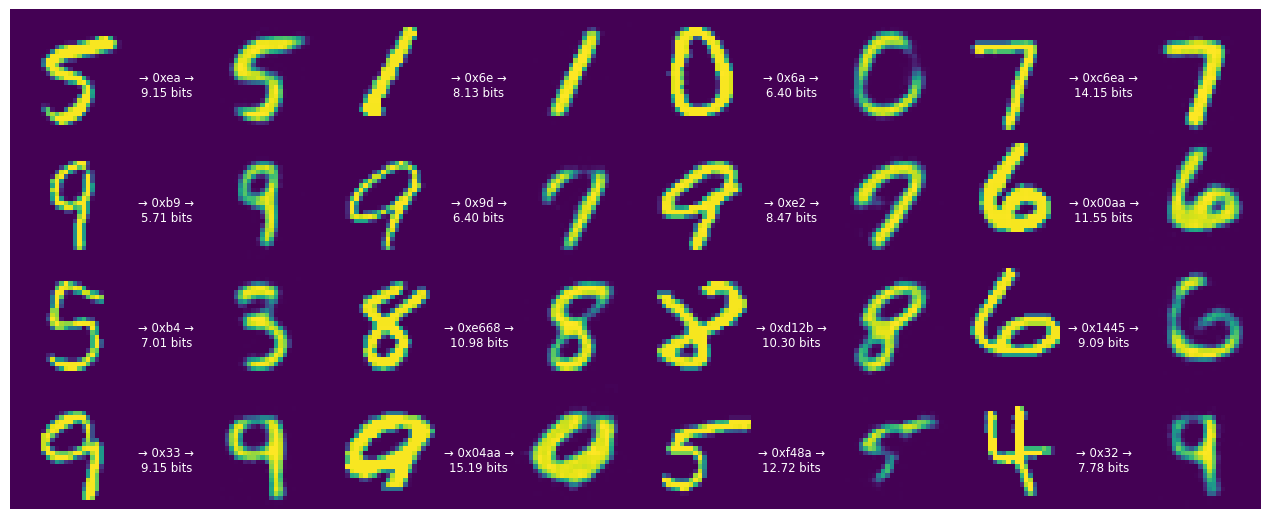

In [26]:
train_and_visualize_model(lmbda=300)


The strings begin to get much shorter now, on the order of one byte per digit. However, this comes at a cost. More digits are becoming unrecognizable.

This demonstrates that this model is agnostic to human perceptions of error, it just measures the absolute deviation in terms of pixel values. To achieve a better perceived image quality, we would need to replace the pixel loss with a perceptual loss.

## Use the decoder as a generative model.

If we feed the decoder random bits, this will effectively sample from the distribution that the model learned to represent digits.

First, re-instantiate the compressor/decompressor without a sanity check that would detect if the input string isn't completely decoded.

In [27]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)


Now, feed long enough random strings into the decompressor so that it can decode/sample digits from them.

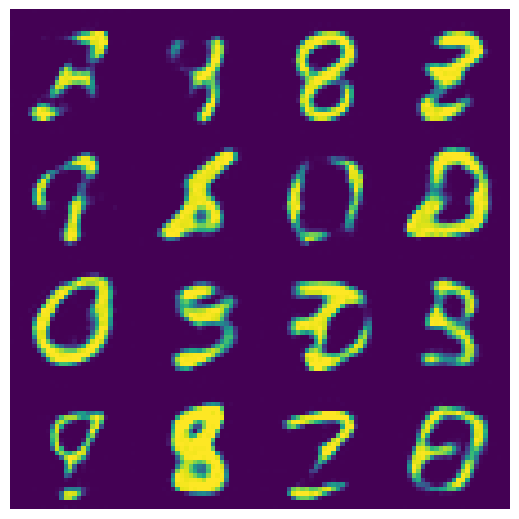

In [28]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
